/gpfs/f5/scratch/Luan.Santos/gfdl_w/solo_nh/C96.nh.bc.g0.hord8.T15.32bit/rundir/
/gpfs/f5/scratch/Luan.Santos/gfdl_w/solo_nh/C96.nh.bc.g0.hord8.T15.64bit/rundir/
/gpfs/f5/scratch/Luan.Santos/gfdl_w/solo_nh/C96.nh.bc.g0.hord8.T15.32bit/rundir/ 0
/gpfs/f5/scratch/Luan.Santos/gfdl_w/solo_nh/C96.nh.bc.g0.hord8.T15.32bit/rundir/ 1
/gpfs/f5/scratch/Luan.Santos/gfdl_w/solo_nh/C96.nh.bc.g0.hord8.T15.32bit/rundir/ 2
/gpfs/f5/scratch/Luan.Santos/gfdl_w/solo_nh/C96.nh.bc.g0.hord8.T15.32bit/rundir/ 3
/gpfs/f5/scratch/Luan.Santos/gfdl_w/solo_nh/C96.nh.bc.g0.hord8.T15.32bit/rundir/ 4
/gpfs/f5/scratch/Luan.Santos/gfdl_w/solo_nh/C96.nh.bc.g0.hord8.T15.32bit/rundir/ 5
/gpfs/f5/scratch/Luan.Santos/gfdl_w/solo_nh/C96.nh.bc.g0.hord8.T15.64bit/rundir/ 0
/gpfs/f5/scratch/Luan.Santos/gfdl_w/solo_nh/C96.nh.bc.g0.hord8.T15.64bit/rundir/ 1
/gpfs/f5/scratch/Luan.Santos/gfdl_w/solo_nh/C96.nh.bc.g0.hord8.T15.64bit/rundir/ 2
/gpfs/f5/scratch/Luan.Santos/gfdl_w/solo_nh/C96.nh.bc.g0.hord8.T15.64bit/rundir/ 3
/gpfs/f5

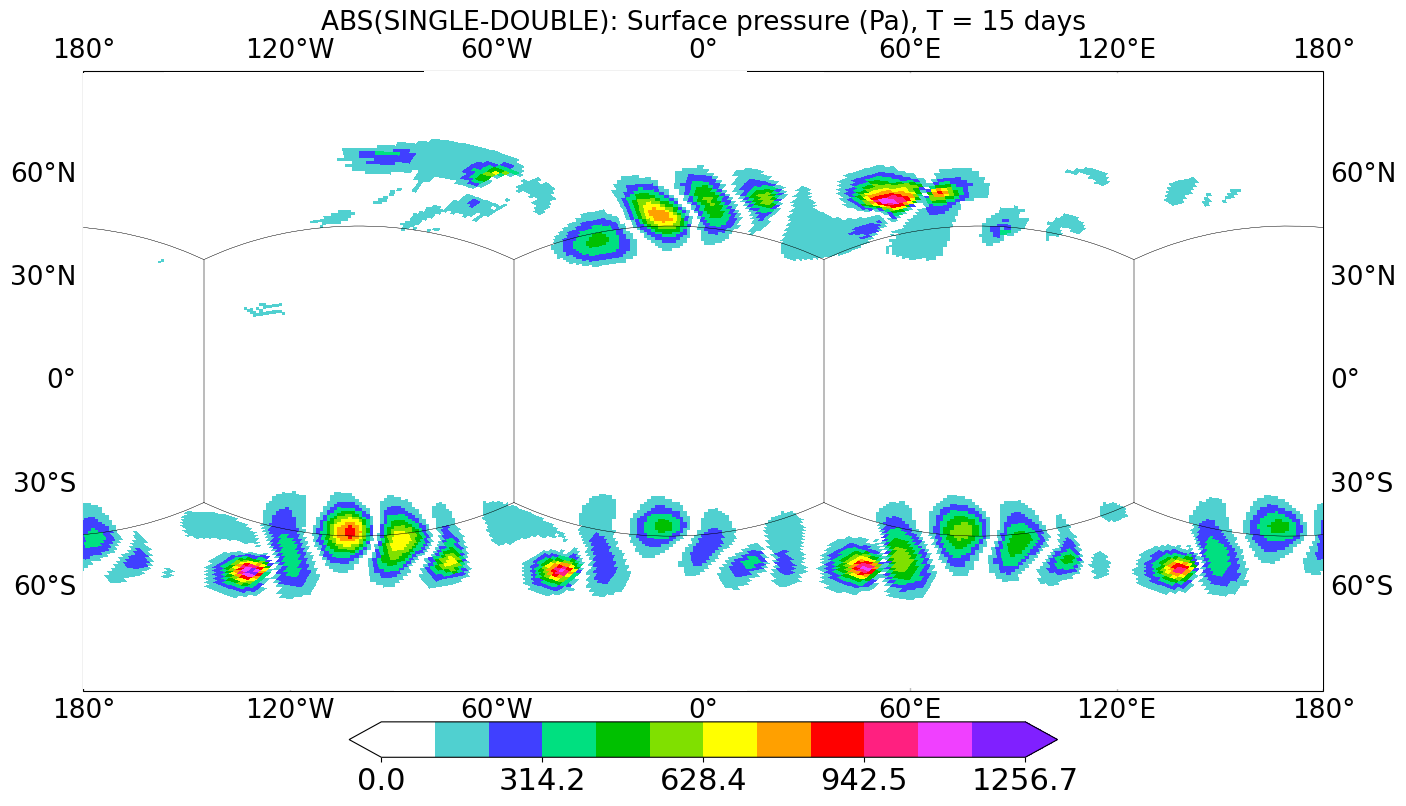

plotting /gpfs/f5/scratch/Luan.Santos/gfdl_w/graphs_solo_nh/bc_diff_ps_av_t15_C96.nh.bc.g0.hord8.T15.


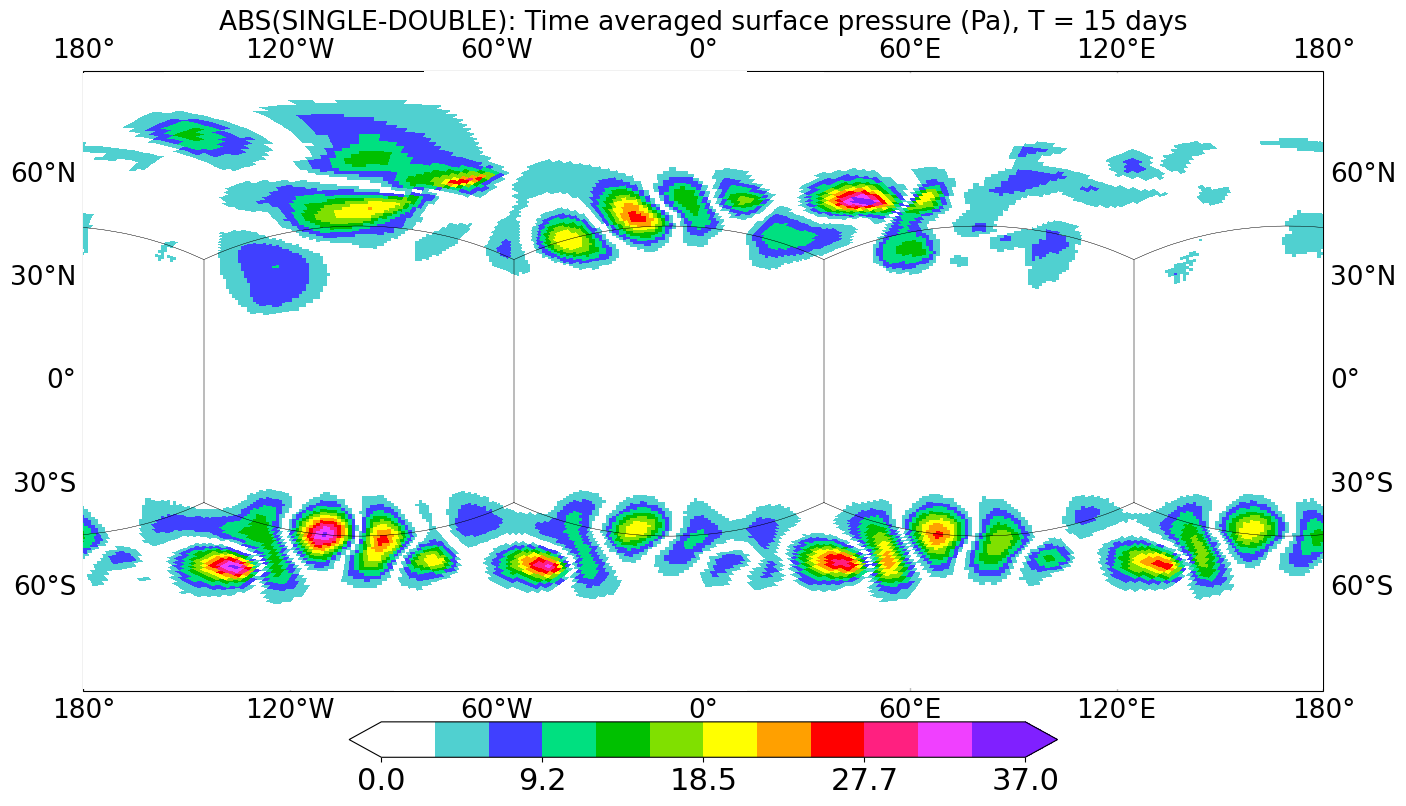

MAE : 5.054353415028515
RMSE: 2.53892093234592


In [5]:
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from matplotlib import ticker, cm, colors, colorbar
from matplotlib.colors import ListedColormap
import os
from plot_cs import *


#----------------------------------------------------------------------------------------------
# directories
hydro="nh"
inputdir='/gpfs/f5/scratch/Luan.Santos/gfdl_w/solo_'+hydro+'/'
outdir = '/gpfs/f5/scratch/Luan.Santos/gfdl_w/graphs_solo_'+hydro+'/'
#----------------------------------------------------------------------------------------------


#----------------------------------------------------------------------------------------------
#simulation parameters
N=96             # N
gtype = 0        # grid type
hord  = 8        # PPM option
modes = (32, 64) # single (32) and double (64) precisions"
Tf    = 15        # time of integration (days)
testname='bc'
basename= "C"+str(N)+"."+hydro+"."+testname+".g"+str(gtype)+".hord"+str(hord)+".T"+str(Tf)+"."
#----------------------------------------------------------------------------------------------

# Create filepaths list
filepaths = []
for mode in modes: 
    filepath = inputdir+basename+str(mode)+"bit"+"/rundir/"
    if( not os.path.exists(filepath) ):
       print("ERROR: filepath below does not exist")
       print(filepath)
       exit()
    filepaths.append(filepath)
    print(filepath)

# Get the number of plots
atmos_file = filepaths[0]+"atmos_daily.tile1.nc"
data = xr.open_dataset(atmos_file, decode_times=False)
times = data.time.values
nplots = len(times)

#-----------------------------------------------------------------------------------------
# Arrays to store the data that will be plotted
# FV3 data
ps    = np.zeros((N,N,6,len(modes)),dtype=np.float32)
ps_av = np.zeros((N,N,6,len(modes)),dtype=np.float32)
te    = np.zeros((N,N,6,nplots,len(modes)),dtype=np.float32)
Te = np.zeros((nplots,len(modes)))

# This loop over tiles computes the maximum errors
for k, filepath in enumerate(filepaths):
    for tile in range(0,6):
        print(filepath, tile)
        # Files to be opened
        atmos_file = filepath+"atmos_daily.tile"+str(tile+1)+".nc"
        grid_file  = filepath+"grid_spec.tile"+str(tile+1)+".nc"

        # Load the files
        data = xr.open_dataset(atmos_file, decode_times=False)
        grid = xr.open_dataset(grid_file , decode_times=False)
        area = grid['area'].values

        # Variable to be plotted
        t = nplots-1
        ps   [:,:,tile,k] = data['ps'][t,:,:].values
        ps_av[:,:,tile,k] = data['ps_av'][t,:,:].values

        for t in range(0, nplots):
           te[:,:,tile,t,k] = data['te'][t,:,:].values
           Te[t, k] =  np.sum(te[:,:,tile,t,k]*area)
           #print(t,Te[t, k], np.amin(area), np.amax(area))

#exit()
# fields to be plotted
fields = [ps,ps_av]
fnames = ['ps', 'ps_av']
titles = ['Surface pressure (Pa)', 'Time averaged surface pressure (Pa)']

# fields to be plotted
#fields = [ps_av,]
#fnames = ['ps_av',]
#fdifs = [ps_av_dif]

# plot
##############################################################################################
for field, fname, title in zip(fields, fnames, titles):
    field_32 = field[:,:,:,0]
    field_64 = field[:,:,:,1]

    fmin = min(np.amin(field_32), np.amin(field_64))
    fmax = max(np.amax(field_32), np.amax(field_64))

    # difference
    dif = abs(field_64-field_32)#/field_64
    difabs = np.amax(dif)
    auxtitle = testname+'_diff_'+fname+'_t'+str(Tf)+'_'+basename
    filename = outdir+auxtitle
    auxtitle = 'ABS(SINGLE-DOUBLE): '+title+ ', T = '+str(Tf)+' days'
    plot_scalarfield(dif, auxtitle, filename, filepaths[1], cmap_precp, 0, difabs)

    # Compute spatial mean absolute error
    spatial_mae  = np.sum(dif)/(6*N*N)

    # Compute spatial root-mean absolute error
    spatial_rmse = np.sqrt(np.sum(dif*dif)/(6*N*N))

    if(fname=='ps_av'):
       print('MAE :', spatial_rmse)
       print('RMSE:', spatial_mae)


    ##############################################################################################

In [ ]:
data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAABX4AAAMdata:image/png;base64,iVBORw0KGgoAAAANSUhEUgAABX4AAAMmCAYAAABCQZnNAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy81sbWrAAAACXBIWXMAAA9hAAAPYQGoP6dpAAEAAElEQVR4nOzdd5hU5d3G8Xu2N9pSpMnSBQUBFUGl2VABBTRiDCoYS2I3QSViAYy+sWtsMVawd0FBBUWKFFFBUJGqNOnLNtgFtj3vH2TG2enlzE7Z7ycXV9Y57Tl1ztzzzO/YjDFGAAAAAAAAAICEkRTtBgAAAAAAAAAArEXwCwAAAAAAAAAJhuAXAAAAAAAAABIMwS8AAAAAAAAAJBiCXwAAAAAAAABIMAS/AAAAAAAAAJBgCH4BAAAAAAAAIMEQ/AIAAAAAAABAgiH4BQAAAAAAAIAEQ/ALAEAANm3aJJvNFtY/53nMmzcv2qsEBGXs2LGy2WwaNGhQtJsSUcYYPf/88zr55JPVsGFDJSUlyWazacSIEdFuGhARO3bsUHZ2turVq6e9e/e6Dff2npadna2OHTtq9OjR+vLLLy1v16effiqbzaYTTjhBxhjL5w8AQF1A8AsAAAD8z/jx43X11VdryZIlKi4uJnBCwrv77rtVVlam66+/Xo0bNw54urKyMv3yyy964403dPrpp+uqq66y9Hw555xzdOKJJ2rZsmV68803LZsvAAB1CcEvAAAByMvL0759+zz+++STTxzjPfvss17HI0ACYtv+/fv173//W5J0/vnna82aNSouLta+ffv01ltvRbl1gPVWrVqll19+WTk5Obrlllt8jjt69Oga72nbtm3Ta6+9piOPPFKS9MILL+iBBx6wtH0TJ06UJE2YMEGHDh2ydN4AANQFKdFuAAAA8cBmsyknJ8fjsMzMTMff6enpXsfLyckh/AVi2OrVq1VeXi5Juuuuu3TUUUdFuUVAZP3rX/9SVVWVRo8e7be3b0pKSo33t5ycHI0ePVq9e/dW9+7dVV5ergceeEDjxo1TamqqJe0bMmSIOnbsqA0bNujVV1/VlVdeacl8AQCoK+jxCwAAAOjwT9ftGjZsGL2GALWgoKBA7733niTpkksuCXk+nTt31sUXXyxJKioq0rJlyyxpn92f/vQnSdJzzz1n6XwBAKgLCH4BAKgl/h7u1rZtW9lsNk2aNEmS9M477+jUU09V48aNVb9+ffXp08etzuG6det01VVXqV27dsrIyNCRRx6pG264QQUFBX7bs27dOt1www06+uijVa9ePWVlZemoo47SjTfeqC1btoS1rj/99JP+7//+T4MGDdIRRxyh1NRU1a9fX8cee6zGjRunrVu3epxu1KhRstls6tKli99l3HPPPbLZbMrMzFRJSYnb8MrKSr300ks6++yz1bx5c6Wlpalp06YaPHiwXn/9da+9r6dMmeLYT5K0ZcsW3XjjjerUqZOysrJks9lUVFQU9ro6279/v+6++2517dpVmZmZatasmQYPHqyZM2dKCuzBasYYvf/++xo5cqRatWql9PR05ebmqn///nrmmWdUUVHhsw1lZWW65557dMwxxygzM9OxrT7++GO/7Q9EaWmpHnzwQZ188snKzc1VamqqmjRpoq5du+rCCy/U888/r9LS0hrTTJo0STabTW3btvU570GDBslms2ns2LFuw1y33aJFi3TRRRfpyCOPVGpqqnr27OlYjvP2bdeuXY0HWTn75Zdf9Pjjj+uss85Sq1atlJaWppycHHXp0kV//etftXr16oC2ya+//qq///3v6tGjhxo1aqTMzEx16NBBQ4YM0QsvvFDjOHMW7r72xfU69PLLL+uUU05Ro0aNlJOTo+OPP15PPPGEKisrPU7vep07cOCA/u///k/HHXecGjZsKJvNpmnTptWYprCwUPfee6/69Omjxo0bKz09Xa1bt9bFF1+sJUuW+Gzv4sWLdckll6h9+/bKzMxUVlaW8vLydNJJJ+kf//iHvv32W7dpjDF68803NWTIELVo0UJpaWlq0KCBOnbsqDPPPFMPPvig2zVw3rx5NR7U6Y2vYzbYa4sU2ev01KlTdejQIeXl5emUU04Ja17dunVz/O18zbPi+jh69GhJ0rfffqsVK1aE1U4AAOocAwAAwjJ37lwjyUgyL7/8stfxNm7c6Bhv7ty5bsPz8vKMJDNx4kRz9dVXO8Z1/Tdp0iRjjDGffvqpycnJ8TjOMcccY0pKSry25eGHHzYpKSlel5GVlWU+/vjjkLbHihUrvM7X/q9evXpm9uzZbtN+9NFHjnG++eYbn8vp3LmzkWRGjRrlNmzz5s2mR48ePttwzjnnmP3797tN+/LLLzvGWbJkiWnYsKHbtIWFhWGvq91vv/1mOnbs6HX6u+++24wZM8ZIMgMHDvQ4j4KCAnPaaaf5bMcJJ5xgdu3a5XH6nTt3mq5du3qd9s477/TbBl+2b99uOnXq5HdbffvttzWmmzhxopFk8vLyfM5/4MCBRpIZM2aM2zDndj/99NMmKSmpxjJ79OjhWI6vf3ZFRUV+x01NTTWvvPKKzzY/8sgjPs9BSeaxxx5zmy7cfe2P83Vo9OjRXpcxYMAAj+eP83XuvffeM8ccc4zbtB9++KFj/C+//NLk5ub6XJ+77rrLY1sfeughv/ti6NChNaaprKw0w4cP9zvdQw89VGM65+v8xo0bvW4/X8dsMNcWYyJ7nTbGmJNOOslIMn/5y198jmdfnqfzy+7RRx91jPf2228bY6y5Ptq1b9/eSDITJkwIah0BAKjr6PELAECMeeWVV/Tcc8/phhtu0MqVK7V3714tXbpUJ598sqTDPV1nz56tiy66SF27dtWnn36qPXv2aNOmTbrzzjslHX5gz7/+9S+P83/66ad1yy23qLKyUsOGDdOsWbO0c+dO7dmzR7Nnz1b//v1VVlamCy+8UD/++GPQ7bfZbOrTp4/uv/9+zZ8/X+vWrdPevXu1Zs0avfHGG+rdu7f27dunUaNGaefOnTWmPfvss9WkSRNJ0muvveZ1Gd9++63WrVsnyf0nyiUlJTrttNO0cuVKNW7cWI888ohWr16twsJCrVu3Tv/617+UmZmpTz/9VH/5y198rssf/vAH1atXT1OnTtXWrVu1c+dOffzxx8rIyAh7XSWpurpaF1xwgTZs2KCkpCTdcsst+vnnn5Wfn69FixZp6NChuueee7RgwQKvbaysrNTQoUP15ZdfKisrSxMnTtTKlStVUFCgjRs36umnn1Zubq6+++47XXjhhaqurq4xvTFGF154oVavXi2bzaabb75ZP/30k/Lz87Vw4UINHjxY9957r+bPn+9zW/ly2223af369crKytKDDz7omP+mTZv01Vdf6dFHH9Xxxx/v1rPWSmvWrNFNN92kk046SbNmzdKuXbu0efNm/d///Z8mTJjg9qDGVatW1XiQlbPu3bvr7rvv1pw5c7R69Wrl5+dr/fr1mjZtms444wxVVFToyiuv9Hr+PP744xo3bpwqKyvVpUsXTZ06VRs3blRhYaHWrl2rV155RUOHDlVSUs1b9XD3dTCmTp2q119/XaNHj9Z3332n/Px8LVu2zHG+LViwQH/96199zuOmm27Sr7/+qnvvvVdr1qxRfn6+Fi9e7Ogdunz5cp1zzjkqKChQt27d9Nprr2nTpk0qKCjQsmXL9Oc//1mS9M9//lMvvPBCjXmvW7dO//jHPyRJp59+uj777DNt3rxZ+fn5+uGHHzR9+nSNHTtWDRo0qDHdlClTNH36dEnSNddco6+//lrbt2/Xjh079M0332jq1KkaMmSIZTVqvfF3bYn0dfrAgQP67rvvJEm9e/cOe31+/vlnx98tW7aUFP710dmJJ54oST6vhQAAwINoJ88AAMQ7q3v8SjL333+/2/C9e/eaevXqGUkmJSXFnHDCCebAgQNu49l76TVv3txt2Pbt2016erqRZK6++mqP7ayoqDCDBg3y2FvOChUVFeaUU04x0uHerK6uu+46I8k0a9bMVFZWepzHTTfdZCSZJk2amPLy8hrDbrjhBkdPsjVr1nic/vPPP/fay9S5V17jxo3N1q1bQ1xT/+v6xhtvOJb18MMPuw2vqqoyQ4YMcYzjqbftI4884jgm5s+f77EdP/74o8nIyDCSzLvvvltj2LvvvuuY/3333ec2bWVlpTnjjDN8tsEfe4/Oxx9/PKjprOzxK8n069fPHDp0yOt8Au3V6c8f//hHI8lcdtllbsM2b95sUlNTjSRz8skne+w1a1dRUVHjv8Pd14Fwvg5deeWVHse58sorHeN89913NYY5X+ckmZkzZ3pd1rHHHmukw72uy8rKPI5z5513Os5153GeeOIJx3XC1z51df755xtJZsSIEQFPY4z1PX59XVtq4zo9Z84cR1tWrlzpc1z7eN56/G7evNlkZmYaSSYnJ8fj+5In/q6Pzh577DEjyaSnpwc8fwAAQI9fAABiTps2bXTLLbe4vZ6bm6vBgwdLOtzz7/7773f0DnP2xz/+UZK0c+dOtxqQzz77rA4dOqTGjRvriSee8Lj8lJQU3XPPPZKkTz75xGud0VClpKQ4Htbz+eefuw239yjcvXu3x+FVVVV66623JEkXXXRRjZ55paWlevHFFyVJd999t4466iiPbTjjjDN02mmnSZJef/11r2299dZb1bp160BWyyN/6/rKK69IkvLy8nTzzTe7DU9KStJjjz3mcxn2/fiXv/xFAwYM8DhOt27dHO1wXd8pU6ZIklq1aqXbbrvNbdrk5GQ9/vjjPtvgj70ebKtWrcKaT7gefvhhpaWlRXw5l156qSTP+/w///mPKioqlJSUpKlTpyo7O9vrfFJSUmr8d7j7OhgZGRl68MEHPQ578MEHHdeel19+2es8zj77bA0ZMsTjsLlz5+qHH36QJL3wwgvKzMz0ON6ECROUnZ2t/Px8zZ492/G6/Zhq2rRpUPs0Vo5FX9eW2rhOO/fQ7dChQ1DT2u3bt08ff/yxzjzzTB04cEDS4V7ent6XPPF3fXRmb+OhQ4e0YcOGkNoLAEBdRPALAECMOeOMM5ScnOxxmP3Db3p6ugYOHOhzHEluP5/94osvJEn9+/dXRUWF9u/f7/Gf/eFqxpiQn9D+4YcfatSoUerQoYOys7NrPCjruuuukyStXbvWbbq+ffuqU6dOkjyXe/jiiy+0a9cuSe5lHhYvXqyysjJJ0sCBA72u3/79+3XsscdKkuPnzp4MHTo0YutqjHE8uGro0KFe93nnzp29Puxu/fr12rx5s6TDDzjztb7du3d3W19jjBYtWiRJOvfcc92CRrtjjjlGnTt3DmhbeNKrVy9J0u2336758+d7fbBeJDVu3Fh9+vSxbH5ffvmlxowZoy5duqhevXpKSkpy7HP7cbNjxw63MhFz5syRJPXr108dO3YMeHnh7utgDRo0SI0aNfI4rFGjRo7rj/348cTX+WO/FjVu3FhHHXWU13WpqqpyHP/O62M/platWqV//OMf2rt3b0DrZZ/upZde0quvvqpDhw4FNJ3VAtk2kbxO79mzR5KUlpbm88sHZ1OnTq1xbatfv77OO+88R9mdkSNHOh4K6CzU9wJnubm5jr/z8/MDai8AAJA8390DAICosddH9MTeK65p06ZeQzrnnnP2Xlh29g/X06ZNU7169QJqjz0gCFRZWZnOP/98zZo1y++4xcXFHl8fPXq0Jk2apGnTpqm0tLRGMGEPgzt27Ki+ffvWmM45PLDXhPTH1/q1b9/e57ThrGtRUZHjNW89k+26dOmiNWvWuL3uvL4XXnih3zZINde3uLjY0VPQW7hs17VrV0fAE6wHH3xQ/fv314YNGzRo0CAdccQRGjBggPr376/TTjtNxxxzTEjzDYa/fRmoqqoqXXnllY6e0v4UFxfXONd++eUXSVLPnj2DWm64+zpY/o6HLl26aNasWY4w2hNf29y+Pnv37lX9+vUDapPz+gwaNEgjRozQtGnT9MADD+jhhx/WCSecoH79+mnAgAE6/fTTPQaaf/vb3zRlyhRt3rxZl112ma655hqdcsop6tevnwYNGqSTTz7Z65cwVgpk20TyOm0f31u4H6imTZuqT58+uvzyy3X++efXGGbFe4Gdc/AbznENAEBdQ49fAABiTCChQ6DBhGvPSn8frj05ePBgUOOPGzfO8UF/zJgxmjFjhjZs2KD8/HzHg7KeeeYZSYdDNE/sPXlLS0v14YcfOl4vKyvTtGnTaozjzOr1y8rK8jltOOtaWlrq+Ntfj7ucnByPr4eyvs49HPfv3+93GYEO9+XEE0/UN998o5EjRyotLU27du3Su+++qxtvvFHdunVTz5499dlnn4U8/0D425eBevjhhx2h77nnnqv333/f8eAy+z6fOXOmY3x7aQG7kpISSQo40LMLd18HK9DjwbVHszNf29yKc/Wdd97RQw89pPbt26uqqkpLly7VI488ouHDh6tZs2a64YYbHNvbrkGDBvrmm290ww03qFGjRiotLdXs2bN19913a8CAATryyCP173//O6wH4wUi0tsmEkaPHu04xvfv36/Kykrt3r1bH3/8sVvoK1nzXgAAAMJDj18AAOqQnJwcFRUV6ZZbbtFDDz1k+fzLysocodj48eN1//33exzPX0jRoUMHnXTSSVqyZIlee+01R8g7bdo0R1g5evRot+mcw6p9+/aFFVb6E+66Ooe9ziGwJ84BrTPn9fvpp5+C7jnrPL23ZQQ63J8ePXrogw8+UFlZmZYuXarFixfr888/11dffaWVK1dqyJAhev/99zVy5EjHNDabLaB5u4arkfT0009LOlxf2l5r2pWvwLVevXoqLCz0GZh6Eu6+Dlagx0OwAbadfX1OOOEEffvttyHNIzU1VbfccotuueUWbdiwQUuWLNGCBQs0Y8YM7dy5U0899ZS+/vprLVmypMYvJJo1a6YnnnhCjz32mFasWKElS5Zo7ty5+uyzz7Rjxw7dfPPN2rRpU4362rV5LEb6Oi0d7qkrSQUFBQFPk5KSEvA11ar3AjvndtrbDgAA/KPHLwAAdYj958Xff/99ROa/Zs0axwf5iy++2Ot4P/74o9952R+Q5VzT1/6wqr59+3qsj+r88+kVK1YE3O5QhLuuDRs2VIMGDSTJbwkFb/Uvndc3lH3aoEEDNWzYUJI8lpJwtnr16qDn70lWVpZOPfVU3XHHHZo3b55++OEHNW3aVMYYTZ48uca49odEuZYscbV9+3ZL2uZPQUGBtm7dKin049t+3AZ7fIa7r4Pl73iwD8/Lywtp/vb1Wb16tSV1djt27KhLL71Uzz//vLZu3aobb7xR0uG6wDNmzPA4TXJyso4//nhdf/31ev/997V161b169dPkvTkk0/WqBvs/MAyX8ejFcdipK/T0u/hqb2GsNWsfC+QCH4BAAgVwS8AAHXI4MGDJUnz58/Xxo0bLZ+/c4Dj7ae7+/fvd5Rr8OWiiy5Samqqqqqq9NZbb2nPnj2aPXu2JM9lHqTDD3RLT0+XJL388stBtj444a6rzWbTSSedJEmaOXOm15+Wr1+/3mvo2q1bN7Vo0UJSaOtrs9l0yimnSJJmzJjhtbfiqlWrQq7v688xxxzjCIZc19O+bnv27FFhYaHH6deuXRuRY9mTQPZ5dXW13njjDa/zOPPMMyVJCxcu1K+//hrwssPd18GaN2+e121eWFio+fPnS5Lj+AmW/VpUWlqqd955J7RGepGSklLjIWOBfmmRm5urv//975IO71/nY96+7SXvX8RUVVU5HswWjkhfpyXV6DFurzttJSvfC6Tf25ienl7jAaYAAMA3gl8AAOqQ6667Tunp6aqsrNSll17qt6eXvyetu2rXrp3j7+nTp7sNN8boxhtv9BooOcvNzdWQIUMkHX6g29tvv63Kykqlpqbqoosu8jhN/fr1dcUVV0iSpkyZovfff9/nMkpKSrRjxw6/bfHEinW192retGmTnnjiCbfh1dXVGjdunNfpbTab/va3v0mSvvzyyxo/Tffk0KFDbg/jGjt2rCTpt99+04MPPug2TVVVlWMZoSgtLXX0kvXGHuo0bty4xut9+vSRdHhbvvLKK27TVVZW6uabbw65bcFq1qyZ46funva5JN1zzz0+z5u//vWvSktLU3V1tcaMGaOysjKv4zoH8Vbs62AcPHhQ48eP9zhs/Pjxjt6cl19+eUjzHzx4sLp16ybpcC1Yf18sbNq0qUaYuH79ep91eJ3DTOfjyl9PZm/TtWnTxhH+Tp061eO0999/v99jPRCRvk5Lh381kZqaKklaunRpSO30xcr3Aun3Nvbu3btG72sAAOCHAQAAYZk7d66RZCSZl19+2et4GzdudIw3d+5ct+F5eXlGkpk4caLXeUycONFIMnl5eSEv5z//+Y9jeIcOHcyzzz5r1q5dawoLC8327dvNokWLzMMPP2xOPPFE061bN+8r7sXAgQONJJOammomTZpk1qxZY/Lz8838+fPN0KFDjSRz9NFHO9rgy7vvvusYr23btkaSOffcc31OU1RUZI466igjydhsNvPnP//ZzJs3z+zcudMUFBSYdevWmffee89cccUVpn79+ubdd9+tMf3LL78cUNusWNeqqirTu3dvI8kkJSWZW2+91axevdrs3bvXLFmyxAwbNsxIMu3atTOSzMCBA93mUV5ebvr37+9YxsiRI82nn35qtm/fbgoLC82vv/5qPv74Y3PjjTeaZs2amYceeqjG9NXV1Y7pbTab+dvf/mZ+/vlns3fvXrNo0SIzePDgGtvfUxt82bhxo0lJSTHnnXeeeemll8wPP/xg9uzZY3bu3GkWL15sxo4d62j73//+d7fpTz75ZCPJZGRkmCeffNL89ttvZs+ePWb27NlmwIABJj093bRq1cpIMmPGjHGbfsyYMQG32/lc3rhxo8dx7POTZG688Ubz448/mvz8fPPNN984hjnvc0/zefzxxx3Djz76aPPKK6+YTZs2mcLCQrN+/XrzxhtvmPPOO8/8+9//rjFduPs6EPbrkH1/X3LJJWbZsmVm7969Zvny5ebSSy91LP+SSy5xm97f9cfZ8uXLTWZmppFk6tevbyZNmmSWL19u9u7da3bv3m1WrlxpXnzxRXPuueea5ORks2fPnhr7oW3btuYf//iHmT17ttmyZYspLCw0GzZsMC+99JI58sgjjSSTnZ1ttm/f7piubdu2pk+fPubhhx82ixcvNjt27DB79+41P/30k7n33ntNenq6kWSOO+44t/ZOmDDBsW7XXnutWbt2rSkoKDDfffedueqqqxzXVG/X6GCuLZG+Thvz+7l1xRVX+BzP3g5P55cvVr4XtG/f3kgyEyZMCKoNAADUdQS/AACEKd6CX2OM+e9//+sIOHz98xR++LN69WrTuHFjr/O86KKLzIsvvhjQh/2DBw+ahg0b1pj+7bff9tuG7du3m1NOOcXv+kky06dPrzFtMOGMFeu6ZcsWR6jh6d9dd91lLrvsMiPJnH766R7nUVxcbIYPHx7Q+j7xxBNu0+/cudN07drV6zQTJkwIKkB15nw8+vp3xhlnmP3797tN/9NPP5nc3FyP06Snp5u33nrLETDVRvC7c+dORxDv6d+AAQPMJ5984nc+DzzwgElOTva5TR577DG36cLd1/44X4f+9Kc/+VxPT/srmODXGGMWLVrkCO59/UtOTjYFBQWO6ZwDeG//MjMzzYcffuhx/Xz9a9u2rVm7dq1bW/fv32969erldbqbb77Z5zU6mGuLMZG9ThtjzKOPPmokmSOPPNJUV1d7Hc++nGCDX6veC9avX+8YZ/ny5UG1AQCAuo5SDwAA1EFXX321fv31V91xxx068cQTlZubq+TkZNWrV09HH320xo4dq+nTp2vRokVBz7tLly5avny5rrzySrVu3Vqpqalq2rSpTjvtNL366qt66623lJQU2C1Ienq6LrzwQsd/169fX+edd57f6Vq0aKGvvvpKH374oS688EK1adNGGRkZSktLU4sWLXTqqafq/vvv1/r16wOaXyTX9cgjj9SKFSt055136qijjlJ6eroaN26s008/XdOmTdM999zj+Kl3vXr1PM6jfv36mjZtmubMmaMxY8aoQ4cOys7OdrTnlFNO0d13360VK1bohhtucJv+iCOO0HfffadJkyapa9euysjIUOPGjXXaaafpww8/1H333RfyNmrTpo0WLVqkyZMn6/TTT3e0LS0tTa1bt9Z5552nt99+W7Nnz1Z2drbb9Mccc4y+++47XX755WrVqpVSU1PVokUL/elPf9I333zjtexHpBxxxBH69ttv9fe//13t27dXamqqcnNzddJJJ+nJJ5/Ul19+qczMTL/zue2227Rq1Spdd9116tKli7Kzs5WVlaWOHTtqyJAhevHFFz2WUQh3Xwfjtdde03PPPae+ffuqQYMGysrKUq9evfT4449rzpw5HvdXsE4++WStW7dOTz75pM4880wdccQRSk1NVWZmptq1a6fhw4frxRdf1K5du9SoUSPHdA888IBeffVVjR07Vj179tQRRxyhlJQU1atXT7169dKtt96qNWvWaMSIETWWN2vWLD3xxBMaMWKEunbtqkaNGiklJUVNmjTRgAED9Mgjj+inn35S586d3dqanZ2t+fPn1zhXc3Nzdfrpp2v69Ol+y28EK5LXaUkaM2aMMjIytHXrVi1YsMDStkvWvRe89tprkqQTTjhBvXr1srydAAAkMpsxxkS7EQAAAPCuR48e+uGHH3T99dfrySefjHZzkMDatm2rzZs3a+LEiTUekIbEdOmll+q1117TVVddpeeeey7azfGoc+fOWr9+vZ577jldddVV0W4OAABxhR6/AAAAMWzTpk366aefJEnHH398lFsDIJHcfvvtSk5O1ptvvqn8/PxoN8fNp59+qvXr1ysvL0+XXXZZtJsDAEDcIfgFAACIoqKiIlVXV3scVlVVpRtuuEHV1dVKT0/X8OHDa7l1ABLZ0Ucfrcsvv1z79+/Xww8/HO3muJk8ebIk6b777lN6enqUWwMAQPwh+AUAAIiizz77TD179tTTTz+tn376SYWFhdq+fbs++ugjDRo0SDNmzJAk/f3vf69R4xQArHDPPfcoOztbTz/9dEz1+v3ss8+0dOlSHXfccfrTn/4U7eYAABCXUqLdAAAAgLruxx9/1PXXX+91+KhRo6i3CiAiWrRo4XiAZCw5++yzxeNoAAAID8EvAABAFJ122ml69NFHNXv2bK1fv167d+9WeXm5mjRpoj59+mjs2LE699xzo91MAAAAAHHGZvgaFQAAAAAAAAASCjV+AQAAAAAAACDBJHTwa4zR6tWrNXXqVF133XXq3bu30tPTZbPZZLPZAp7PggULdMkll6hDhw7KyspSRkaGWrdureHDh+udd94JqPZUfn6+JkyYoKOPPlrZ2dnKzc3VSSedpKeeekqVlZV+p581a5ZOPvlkZWZmqlmzZrruuutUUlIS8Dqgbgr3HNizZ49efPFFjR49WkcffbRycnKUnp6uVq1a6bzzztNbb72lqqqqgNpSW+fAZZddJpvNpszMTJWXl3ud36pVqxzbIT09XQcPHvQ67tq1ax3j3nvvvQGtL+qWzz//XJdeeqnat2+vzMxMNWrUSMccc4zGjh2rt99+2+t0lZWVeuqpp3TSSScpNzdX2dnZOvroozVhwoSAHrCzbt06nX/++WrQoIFycnI0bNgwrVu3zm28l156yXEML1iwwOc8mzVr5hj3yy+/9Dluy5YtZbPZdMYZZ/htK1AbZsyYoWHDhqlFixbKyMhQXl6errjiCv34448+pyspKdGNN96oli1bKiMjQ8cff7w+++yzWmo1EL5Yfx+yGzRokOM9JpB/jz/+eCibA3VUXfzsYxfMeWWz2bRixYqA1gOwI1+LYyaBbdy40Ujy+s+f6upqc+211/qchyRz2mmnmZKSEq/zWb58uWnevLnX6fv27WuKioq8Tv/mm28am83mNl379u3Nnj17Qto2qBvCOQeWLl1qUlJS/B7/p5xyit/jsDbPgeeff94xfOHChV7n+Z///KfGvObNm+d1XOd5zp8/3+e6om7Zv3+/ueCCC3yeI3l5eR6nLSoqMn369PE6XYsWLcz333/vddlr1qwxDRs2dJsuMzPTLFq0qMa469evdwy/9957vc5z9erVNeY1adIkr+M6z3Py5Mk+txNQG/761796PZ/S09PN1KlTPU5XVlZmjjvuOI/TPfLII7W8FkBw4uV9yG7gwIF+7y2d/z322GPhbyTUGXXxs49dMOeVJJ/nNuAJ+Vr8qjPBb6tWrczIkSNN//79Az4wH3nkEce4xx57rPnggw/Mxo0bzW+//WY+++wzc8oppziGjx492uM89u7da1q1amUkmYYNG5qXX37ZbN++3WzYsMFMmDDBccCdc845HqcvLy83TZs2NRkZGea5554z27dvN6tWrTKjRo0ykszf//73sLYREls458DcuXONJJObm2tuuOEG8+mnn5otW7aYvXv3mkWLFpnzzz+/xsW1qqrK43xq+xxYu3ato13/+te/vK7fn/70J0cYIMn885//9DruZZdd5hj3wIEDPrcb6o6DBw+aAQMGGEkmKSnJXH311WbhwoVm165dZteuXearr74yt956qzn55JM9Tn/OOecYScZms5kJEyaYDRs2mO3bt5uXX37ZNGjQwHHe7t271+P0w4cPN5LMTTfdZH755RezZcsWc++99xqbzWaOO+44t/FbtmxpJJmzzjrL6zo999xzNc6L008/3eu4L730kuNcmzt3ru+NBUTYAw884DgeR4wYYZYtW2Z2795tZs2aZbp162YkmZSUFI9fCD722GNGkjnjjDPMsmXLzM6dO82bb75pcnNzTXp6utm9e3cU1gjwL97eh4z5Pfht06aN2bdvn99/5eXllm0vJL66+NnHzjmXCOTc8tZ+wBvytfiV0MFvSUmJmTZtmtmxY4fjtYkTJwZ8YLZu3dpIMq1btzYFBQVuww8ePGh69uxpJJnk5GSTn5/vNs5tt93muKFasGCB2/B7773X0Z5PP/3Ubfh3331nJJk777yzxuuVlZWmTZs25thjj/W7Hqi7wjkHli9fbh5++GGfQedVV13lmNfbb7/tcZxonAP2bwC9XfCNMebII480ksxf/vIXI8mceeaZXsdt166dkWT69+/vdRzUPRMmTHBc/z/44IOgpv3kk08cx72nHrgLFixw3LiMHz/e4zxycnJMv3793F4fPXq0keT2Qf2iiy4ykky9evVMZWWlx3leeumlNc6LrKwsrx+6L7/8ciPJpKWlmbKyMn+rDETM7t27TU5OjpFkBg8ebKqrq2sMz8/PN0cccYSRZPr06eM2/bBhw0xGRobZv39/jdftv/YI9vwGaku8vQ8Z83vw660XMhCOuvrZx5jfg98xY8b4WEsgdORr8Suha/zWq1dPw4cPV/PmzYOeNj8/X7/99pskaejQoWrUqJHbOOnp6brwwgslSVVVVdqwYUON4ZWVlXr++eclScOGDVP//v3d5nHrrbeqcePGkqRnnnnGbXh1dbUkKSmp5q6y2WxKSkpyDAc8Cecc6NWrl8aNG6eMjAyv49x3332OY/PTTz91Gx6tc8C+nMWLF3scvnnzZm3dulXp6em6+eabJUlLlizxWLNr27Zt2rhxoyRpwIABbsNRN23fvl0PPfSQJOnaa6/VyJEjg5r+6aefliQ1adJEt956q9vw/v37a9iwYZKk559/3mOtqurqarfzQpKSk5Mdw53Zj999+/Z5rev21VdfSZIuvvhitWnTRmVlZVq+fLnPcXv37q3MzEyP4wC1YerUqdq/f78k6V//+pdbnbnGjRvrtttukyQtXbrU7Ziurq72WJ/O27kExIJ4fB8CIq2ufvYBagP5WvxK6OA3HOnp6Y6/fRWqtt/YSIcfiOPsq6++UmFhoSRp1KhRHqdPS0vTiBEjJB1+KMOBAwdqDO/evbsaNGighx56SC+++KJ27typNWvW6LLLLtOmTZt06qmnBrVegJWaNm3qOO63b9/uNjxa54D9TaC4uFg//PCDx3ZJhwOrLl26qFWrVtq/f7++//57r+NKBL/43UsvvaSKigrZbDaNGzcuqGkPHDigOXPmSJKGDx+utLQ0j+PZz5mCggItXLjQbXj//v21YMECjRs3Ths3btRvv/2mBx98UK+99pq6d++uJk2auI1v53xc2/3222/atGmTUlNTdeKJJ6pfv35ex925c6fjZozzAtH28ccfS5I6dOig4447zuM4zu9BH330UY1h/fv314EDB3T++edrxYoV2r17t95//32NHz9eaWlpOuWUUyLXeCBE8fg+BMS7WP3sA8Q68rXoIvj1ol69eurUqZMk6bPPPnP0JHFWWVmp999/X5J09NFHq23btjWGL1u2zPF33759vS7LPuzgwYNavXp1jWEZGRl66KGHdODAAV155ZVq0aKFunbtqtdff11t2rTRnXfeGdL6AVaoqKhwXHwbNGjgNjxa54BzEOUptLK/Zg/C7B/qfY2bkpKik08+2es6oG755JNPJEk9e/ZUXl6e4/XKykq/T6JdtWqVDh48KCmw80KSx163999/v7Kzs/Xoo4+qffv2OvLIIzV+/HilpKToqaeechu/W7duys3NleT7WD/hhBOUmZnpM/jlCxHEEvv54et8at26tVq1alVjfLvrrrtOXbp00axZs9SrVy8dccQR+sMf/qA9e/bonnvuCalnCxBp8fg+BMS7WP3sA8Q68rXoIvj1YfLkyZKkTZs2afDgwZozZ44KCgpUUlKixYsX69xzz9W3336r+vXr6/nnn3f75mLt2rWSDncjd74hc9WuXTvH32vWrHEbftVVV+mDDz7QCSecoPT0dDVu3FhjxozR119/7fYtCFCbZsyYoUOHDkmSx1A0WudA9+7dHT8fWbBggdtwe2hlD7bs/+9r3F69eiknJ8frOqDuqKysdPQO7927t8rKyjRx4kR16tRJ6enpSk1NVadOnfT3v//dY28Q+3khSe3bt/e6nLy8PMfPkDydFz179tTixYs1ZMgQ5eTkKCsrS2eeeaYWLlzoMYy12WwBhbmu58XChQvdQgT7uMnJyfSGRFRt27bN8eHB1/kk/f5e43o+1atXTwsXLtRVV12lZs2aKS0tTT169NDrr7+u8ePHR6bhQBji9X0IiHex+tkHiAfka9GTEu0GxLKLL75YJSUluuWWW7RkyRKdccYZNYZnZmZqzJgxuv3223XUUUe5TZ+fny9JatSokVJTU70ux/ng2rt3r8dxRo4cGXTtLiCSysvLNWHCBEmHPzRfcsklbuNE6xxISkrSKaecohkzZrgFXPn5+VqzZo2SkpIcN2yuAZf9TaawsFA//fSTJHo14nd79uxx9JTKyspS79699fPPP9cYZ8OGDXrsscc0ZcoUTZs2rcbxYz8vJPefMDlLTU1Vw4YNVVBQ4PW8OPbYYzVz5syA2z5gwAB99NFH2rNnj9asWaMuXbo4hrkGv926dXMsf9WqVerWrZvbuD179lS9evUCXj5gtUDPJ+fhns6nxo0b67nnntNzzz1nbQOBCIjn9yE7Y4zHHl+u+NIdsSKWP/s4q6ys9HtuJScn83wG1Dryteihx68fV111laZOneqx+PTBgwf122+/aevWrR6nLS0tlSSfBeIl1bjoBnIDBMSCG2+80fEN2uTJkz3WcYvmOWD/gLNr1y6tX7/e8bo93LWHWtLhDy316tVzhMJ2ixYtcvR0JPiFXXFxsePvZ555Rj///LOGDx+u77//XgcPHtT27dv18MMPKz09XYWFhRo5cqS2bdvmmMZ+XkiBnxtWnxdSzV6/hYWFWrVqlWw2m6MHr81m00knneQ2bklJiaN2NucFoi2a5xMQLfH8PmS3ZcsW1atXz+8/IFbE+mcfu9dff93veXXOOedYukwgUORr0UHw60NhYaFOP/10XXDBBWrVqpXee+89bd++Xfn5+Zo/f76GDRumOXPm6KyzztKzzz7rNr09MPJVvNp5PCBePPPMM/rvf/8rSTrnnHN08803exwvmueA84OsnEs4uPZqlA5/622vBeRpXOefyAPOT3stLy/XkCFD9OGHH6pnz55KT09XixYtNG7cOL3yyiuSDj8U58EHH3RM43y81/a54VyyxPlYt38h0rVrV8eTcCXPZVAWLVrk2AYEv4i2aJ5PQLTE8/sQEI/i4bMPEOvI16KH4NeHkSNHat68eeratauWLFmiCy64QC1atFDjxo0dP5e95JJLVF1dreuvv16rVq2qMb39w7XrkwRd2X+q5TwNEKveffdd3XDDDZIOPwTqnXfe8XrxjeY5cMIJJyg7O1tSzd6Krg92s/NU+9T+t/NDsQDXY3TSpEkez4FRo0ape/fukqRp06Z5nD7Qc8Oq8yIlJcVjL95QzgubzeY2PlDbonk+AdESz+9Ddnl5eTLG+P0HRFu8fPaxGzNmjN/zat68eZYuEwgE+Vr0EPx6sWTJEs2fP1+SdPvtt3s9YO677z5JUlVVlV5++eUaw+w//ygsLFRFRYXXZe3evdvxt3NPKyDWzJo1y3ExPuaYY/TZZ5/5vJhG8xxISUlx9OK1B1WlpaWOh6G49uB1DbgOHDjgeHIovRrhrHHjxo4b/szMTB1//PFex7UHo1u2bHH81Mj5p4HOx76riooKFRUVOZZpFfvxvHnzZsdPqTz1hJekE088UWlpadq2bZs2btxYY9yjjz6a9yxEXaDnk/NwjlvEu3h/HwLiRTx99gFiGfladBH8evH11187/j7hhBO8jtemTRtH8WjXhyrYC1JXV1dr8+bNXudh/zAtqcaDdoBYsnDhQp1//vkqLy9Xhw4d9Pnnn/u9kEb7HLAHXL/++qu2b9+uJUuWqLKyUnl5eWrdunWNcfv27auUlBRt2bJFW7Zs0dKlS1VeXl5jPoAkZWdn68gjj5QkNWjQwPHEc0+c61eVlJRIUo2HFfz6669ep928ebPj57yROC+kwyGu85ccrsFvRkaGI1D46quvdOjQIX377bdu8wGipVWrVo4PD77OJ+n39xrutRDv4v19CIgH8fjZB4hV5GvRRfDrhXP3cH8/M7LfELn+5MP52/elS5d6nd5+EmRkZKhr165BtxWItOXLl2vo0KEqKytTq1at9MUXX6hFixZ+p4v2OeAcTC1YsMDrz9mlw0/F7tWrl9u4rvMBJKl3796SpKKiohq1Fl05P0nW/jDBY445xvFQgkDOC0k67rjjwmluDX369FF6erqkw8f6119/rYqKCrVu3Vpt27Z1G9+5zu8333yjQ4cOSeK8QOywnx++zqdt27Y5Hm5l5fkEREs8vw8BsS5eP/sAsYp8LboIfr1wvrDbe0J5snnzZuXn50s6XKvKWf/+/R3fsr/77rsepy8vL9dHH30kSTrzzDNrPIEQiAWrV6/WWWedpZKSEjVp0kSff/65x3DIk2ifA3369FFaWpqkw70Vvf2c3c653IN93E6dOql58+aWtQmJYcSIEZIO38T4uvGw/6Spc+fOysrKknT4Z7mnn366JGn69OmOnuWu7OdMo0aNLH24YHp6uiMwCPW8kAh+ETvOPfdcSdKGDRsc5XxcvfPOO46/zzvvvFppFxBJ8fw+BMSyeP7sA8Qq8rXoIvj14rTTTnP8bOr+++9XaWmpx/HuuOMOx99nn312jWEpKSm66qqrJEkff/yxFi1a5Db9I488oj179kiSrr32WkvaDlhl06ZNOvPMM5Wfn68GDRpo9uzZQX1rFu1zIDMz0/FTki+//NLxwchfwDV37lwtWbJEEuEWPLM/jVaS7rrrLlVVVbmNM3XqVK1evVqSdPHFF9cYdt1110mS9uzZo0ceecRt2kWLFmnGjBmSpKuvvlopKSmWtt9+XK9evdrxwB9v58Upp5wim82mdevW6b333pMkdejQQS1btrS0TUCoxowZ4yj3MGHCBLeeJAUFBXrwwQclHf5CkJ6LSATx/j4ExKJ4/+wDxCrytSgzCW7VqlVmyZIljn9XXHGFkWQk1Xh9yZIlZvfu3TWm/fOf/+wY99hjjzUffPCB2bFjh9m7d69ZsGCBOe+88xzDe/fubaqrq92Wv3fvXtOqVSsjyTRq1MhMmTLF7Nixw/zyyy/mjjvuMElJSUaSOeecc2prk6COCfUc2Llzp+nQoYORZNLT082nn35q9u3b5/VfaWmpx+VH+xz4xz/+4VhfSSY3N9fjuWqMMbt27aoxriQzderUiLQL8e/tt992HCdnnnmmWbhwodm7d69Zv369mTx5sklNTTWSTPv27U1RUZHb9Oecc46RZJKSkswdd9xhfvnlF7Njxw4zZcoU06hRIyPJtGrVyuzdu9fytn/22Wdux/rKlSu9jt+1a9ca415++eWWtwkIxwMPPOA4Ps8//3zz/fffmz179pjZs2eb7t27G0kmJSXFLFy4MNpNBSwTj+9DAwcONJJMmzZtfN5X2v8dPHjQsmWjbqirn33s6zh69OiAzq2KigpLl4+6gXwtPiV88Gu/uQjk38svv1xj2gMHDtQ4+Lz969mzp9m2bZvXNixfvtw0b97c6/R9+/b1eDMGWCHUc+Dll18OeDpJJi8vz2sbonkOfPLJJzWWde655/ocv1OnTjXG37hxY0TahcTw6KOPmpSUFK/HdseOHc3atWs9TltUVGT69OnjddoWLVqY77//PiLt3rdvn0lOTnYsq0GDBqaqqsrr+FdddZXP90sgFvz1r3/1ej6lpaXxRR4SUry9DwVzXyrJjBkzxtLlI/HV1c8+wbSdezmEinwtPlHqwYeMjAxNnz5dH3/8sUaNGqW2bdsqIyNDqampat68uc4++2y9+OKLWrp0qc+fvPbq1Us//vij/vGPf6hr167KyspSw4YN1bdvXz355JP66quv1KBBg1pcM6B2RfMcOOWUU5ScnOz4b3816pyHe3vYFWD3t7/9TUuXLtXYsWOVl5en9PR0NWjQQH379tXDDz+slStXqnPnzh6nbdCggRYuXKgnn3xSffr0UcOGDZWVlaWuXbvqH//4h3744Qf17NkzIu3OyclxPMxQkk4++WSfT4V3PW8ogYJY9J///Ecff/yxhgwZoiOOOEJpaWlq06aNLr/8cn333Xe67LLLot1EwHLx+j4EJDI+/wPuyNeix2aMn0fqAQAAAAAAAADiCj1+AQAAAAAAACDBEPwCAAAAAAAAQIIh+AUAAAAAAACABEPwCwAAAAAAAAAJhuAXAAAAAAAAABIMwS8AAAAAAAAAJBiCXwAAAAAAAABIMAS/AAAAAAAAAJBgCH4BAAAAAAAAIMEQ/AIAAAAAAABAgiH4BQAAAAAAAIAEkxLtBiSSgwcPqry8PNrNAAAAAAAAAOJSWlqaMjIyot2MhEDwa5GDBw+qTZs22rNnT7SbAgAJwRgT7SYAQNTZbLZoNwEAAKBWNW/eXBs3biT8tQDBr0XKy8u1Z88erV69Wi1btox2c+JW/fr1o90EAACAmMGXYMErKSmJdhMSzr59+7RixQr17NlT9erVi3ZzgLjBuQMEb/v27eratavKy8sJfi1gM9xNWqKkpITQEgAAAEDCqaqq0sGDB5WRkaHk5ORoNweIG5w7QGhsNpuKi4vJ2SxAj18AAAAAgFfJycnKzs6OdjOAuMO5AyDakqLdAAAAAAAAAACAtQh+AQAAAAAAACDBEPwCAAAAAAAAQIIh+AUAAAAAAACABEPwCwAAAAAAAAAJhuAXAAAAAAAAABIMwS8AAAAAAAAAJBiCXwAAAAAAAABIMAS/AAAAAAAAAJBgCH4BAAAAAAAAIMEQ/AIAAAAAAABAgiH4BQAAAAAAAIAEQ/ALAAAAAAAAAAmG4BcAAAAAAAAAEgzBLwAAAAAAAAAkGIJfAAAAAAAAAEgwBL8AAAAAAAAAkGAIfgEAAAAAAAAgwRD8AgAAAAAAAECCIfgFAAAAAAAAgARD8AsAAAAAAAAACYbgFwAAAAAAAAASDMEvAAAAAAAAACQYgl8AAAAAAAAASDAEvwAAAAAAAACQYAh+AQAAAAAAACDBEPwCAAAAAAAAQIIh+AUAAAAAAACABEPwCwAAAAAAAAAJhuAXAAAAAAAAABIMwS8AAAAAAAAAJBiCXwAAAAAAAABIMAS/AAAAAAAAAJBgCH4BAAAAAAAAIMEQ/AIAAAAAAABAgiH4BQAAAAAAAIAEQ/ALAAAAAAAAAAmG4BcAAAAAAAAAEgzBLwAAAAAAAAAkGIJfAAAAAAAAAEgwBL8AAAAAAAAAkGAIfgEAAAAAAAAgwRD8AgAAAAAAAECCIfgFAAAAAAAAgARD8AsAAAAAAAAACYbgFwAAAAAAAAASDMEvAAAAAAAAACQYgl8AAAAAAAAASDAEvwAAAAAAAACQYAh+AQAAAAAAACDBEPwCAAAAAAAAQIIh+AUAAAAAAACABEPwCwAAAAAAAAAJhuAXAAAAAAAAABIMwS8AAAAAAAAAJBiCXwAAAAAAAABIMAS/AAAAAAAAAJBgCH4BAAAAAAAAIMEQ/AIAAAAAAABAgiH4BQAAAAAAAIAEQ/ALAAAAAAAAAAmG4BcAAAAAAAAAEgzBLwAAAAAAAAAkGIJfAAAAAAAAAEgwKdFuAAAAwRq5cqXfcT7s0aMWWgIAAAAAQGwi+AUAxJVAQt9AxyMcBgAAAAAkKoJfAEBUBRPQBhr6hrNswmAAAAAAQCKwGWNMtBuRCEpKSlS/fv1oNwMAIsrqXrRWB7mRQBAMAAAAALXHZrOpuLiYnM0C9PgFAFgq0HA4HkJfyf/6EAwDAAAAAGIRPX4tQo9fAIkuXoLaaCMIBgAAAIDQ0ePXOvT4BYAEZlVYS5gZONdtzrYDAAAAAEQDwS8AwC96+4aOIBgAAAAAEA0EvwAA1CKCYAAAAABAbSD4BQCL0TsWwSAIBgAAAABEAsEvAMCropvDDyEbPk4QHgznIJgQGAAAAAAQKoJfAABilLfe4wTCAAAAAAB/CH4BwGIf9ugRdrmHcHvazpsy2e84I4pGhLUMRA+9ggEAAAAA/hD8AkAdNa3hNP8jTfE+zqCxE/1OTpmHyLOHwATAAAAAAABnBL8AgIjx1XOZUNhaBMAAAAAAAGcEvwAAJBDKQAAAAAAAJMlmjDHRbkQiKCkpUf369aPdDAAxJJw6v+HW+I2keVMmB1TmwRd6+9Y+QmAAAAAA8cBms6m4uJiczQL0+AUABIXQNz7RExgAAAAA6haCXwBArSH0jQ2EwAAAAACQ+Ah+ASAM4ZRz8CWcgDSWy0Qg9hACAwAAAEBiSop2AwAAdQO9fWPfyJUrI/ZlBgAAAACgdhH8AgAijtAXAAAAAIDaRakHAAhDOD+ND7VnJaUcEpvz/q3twJxSDwAAAACQOCzp8fv555/r0ksvVfv27ZWZmalGjRrpmGOO0dixY/X22297na6yslJPPfWUTjrpJOXm5io7O1tHH320JkyYoPz8fL/LXbdunc4//3w1aNBAOTk5GjZsmNatW+d1/EGDBslms8lms6lx48YqKSnxOX/7+IMGDfLbFgBIZA0fX+n1XyDT4nCg6+mf63Bv04S6LAAAAACoC8gn3dmMMSboqf6ntLRUY8aM0fvvv+91nLy8PG3atMnt9eLiYp111llaunSpx+latGihTz75RD179vQ4fO3aterbt6+KiopqvJ6ZmakvvvhCJ598sts0gwYN0vz58x3/PWnSJE2cONFr2+3jDxw4UPPmzfM6niSVlJSofv36PscBAGfx1OM31PC26OYedT74jcT+8rVNfS0v0H1Bz18AAAAA0WKz2VRcXBxwzkY+6V3IpR4OHTqkIUOGaMGCBUpKStKVV16pyy67TJ06dZJ0OO3+6KOPtGjRIo/TX3zxxVq6dKlsNptuv/12/fnPf1ZWVpZmzZqlm2++WTt27NCwYcP0ww8/KDc312368ePHq6ioSDfddJNuvPFGpaam6pVXXtFdd92lG264QcuWLfO7Do899phuuukmNWzYMNTNAAA+ReJBWeGEsLWtroa+kd7WnspBBLLMQMtI2I9bAmAAAAAAsYx80reQg9977rlHCxYsUHJyst59912NHDmyxvBmzZqpX79+Hqf99NNP9emnn0qS/vnPf+qOO+5wDBs7dqw6dOiggQMHatu2bXrwwQd1//33u81jzpw56tevnx5//HHHa3fccYdWr16t119/XQUFBR53iHQ45f/tt99UXFysRx55RP/85z+DXX0AiDt1NYStbVaFvvOmTHb8PWis929/pzWcdviPKdN8jufK3k4CYCQqX1+8cUwjnvj7EpnjGQBQl5FP+hZSjd/t27froYcekiRde+21bhvVn6efflqS1KRJE916661uw/v3769hw4ZJkp5//nlVVla6jVNdXa2kJPfmJycnO4Z707ZtW11yySWSpH//+9/au3dvUO0HAMATK0LfeVMm1wh9Q3nN9fVwRaLnOgDAu5ErVzr+BTKuv3lwHQcAJCLySf9C6vH70ksvqaKiQjabTePGjQtq2gMHDmjOnDmSpOHDhystLc3jeKNGjdLHH3+sgoICLVy40K2Acf/+/TVr1iyNGzdO119/vVJTU/XGG2/otddeU/fu3dWkSROf7bj77rv1+uuva9++fXrooYc8pvYAEC5fvXD4EJY4wg18Aw1q502yOf3XpIDn6a0nML3AURfROxKxKpz7gkADYo5/1EX8gglIXOST/oUU/H7yySeSpJ49eyovL8/xemVlpZKTk2Wz2bxNqlWrVungwYOSpL59+3odz3nY8uXL3Tbs/fffr4ULF+rRRx/Vo48+6ng9LS1NTz31lN91aN++vcaOHasXXnhBTz31lMaNG6emTZv6nQ4AAGe+Qt9AwteAQt9Nk3y/1tbDcA/LsLchmMCXD0mIprr8BRmlKhJXNI/ruhD+Wr19E317xTt/oa7z8eDt2GAfA/GLfNK/oIPfyspKff/995Kk3r17q6ysTA888IDeeOMN/frrr7LZbGrXrp3OPfdc3XLLLWrZsmWN6deuXev4u3379l6Xk5eXp6SkJFVXV2vNmjVuw3v27KnFixfr9ttv14IFC1RdXa1TTjlF9913n3r37h3Qutx111165ZVXVFpaqgceeEAPP/xwQNMBAOCvl6+nMgx29gDWb+jrKfD1N56PENh5eSOKRgQ2byDBxMMHf3/BVTysA9zFyhcZ8RT+xso2Q3T4O1YDCXUDXY5dvJwbAMgnAxV08Ltnzx5HIp6VlaXevXvr559/rjHOhg0b9Nhjj2nKlCmaNm2aBgwY4BiWn5/v+LtZs2Zel5OamqqGDRuqoKDAa42LY489VjNnzgx2FRzatGmjK664Qv/5z3/0zDPP6JZbblHz5s1Dnh8AwLtAemLEi2BD32CHSwo89PU2nZ9ewPaHwvkLgPl5JGC9SF33CC9iT6y+x8VT+Iu6yX7ueLuucR0FQD4ZmKCD3+LiYsffzzzzjMrLyzV8+HBNmjRJXbt2VUFBgd544w3dcccdKiws1MiRI/XDDz+oVatWkqTS0lLH9BkZGT6XlZmZKUnav39/sM0M2B133KGXXnpJBw4c0L/+9S/9+9//jtiyAMBZKDeTsfoBsi4JpJ6va1mHoB+25iP0NQN//9s23/ssJjnVAJ7kox6wPQCW6AWM6IiF61ptfrivrfUlvIieWDimA0E5kcCwnWqfrwcWRqsd7Gsg9pBPBibo4Nf5aXTl5eUaMmSIPvzwQ0fdjBYtWmjcuHE68sgjddFFF6mgoEAPPvigo8HGGMf0vmptuI4bKa1atdLVV1+tJ598Us8995xuu+02x0EAAHWV1aF0It0sN3x8ZdgPc/PGEdC2dXpt0+H/dw587eyvOQfAk9q6j2efr68AWPLcCziR9h3gSSKGvs44h2tHbexbX+89Vj+sM1Z6BH/Yo0fcBOmIvkgeL4TAQOwhnwxM0MFvTk5Ojf+eNGmSxw00atQo3Xvvvfrxxx81bdo0x4Z1nv7AgQM+l2Xvsu26TKvdfvvteuGFF3TgwAH93//9n55++umILg8AElFd6sHs/AE73LIPku9A1h7kTt4sTczzMlKNsg7e5+Uc6Dr39PWGDzaoCxL1S6t4bnusq833rkC/aAxkvGDDYX/rafUxFq/3BLBeKOXB7NNQDgKoO8gnAxN08Nu4cWPZbDYZY5SZmanjjz/e67j9+/fXjz/+qC1btmj//v3KyclRkyZNHMN3797tddqKigoVFRU5lhlJLVq00DXXXKNHH31UL7zwgsaPH682bdpEdJkAEIrauLmMxs+QE5XP0LfGA9kCm9/kzYf/3x4A2zZPchvHU+/eFUUr3Mazh8C+Sj1Q3xexylvIZXWvRyvxE+X4V1v7MFK/Kim6uYel50is9ApG3eEt1PV2HEY6BOb4B6KLfDIwQQe/2dnZOvLII7VlyxY1aNBASUlJXsdt1KiR4++SkhLl5OToqKOOcrz266+/6rTTTvM47ebNmx3dtrt06RJsM4M2fvx4/fe//1VpaanuvfdePffccxFfJgDEIm5iA+Prg7nfXr4uNXzt5Rwkz6UaXI1cuUKSNELee+5OzPv950gji7x/2DF5EwMaD/ElUXux+hNsYOYrBLNyO0X7iy5C4NBFet9FKuQNZXmhhMJWhr+UdUAwgj3uXMcP91jjWgpEH/lkYIIOfiWpd+/e2rJli4qKilRdXe114zo/7a5hw4aSpGOOOUYZGRk6ePCgli5dqiuvvNLjtF9//bXj7+OOOy6UZgalWbNmuu666/Tggw9qypQpuv322yO+TACoq+L5g13YpR18PLhNqhkCO15re/j/A+m56xzk2tk/nPgLf1zH40NNbInn8yZW+eo57Gl7h3pOhPKz5Uixcr3qAk/Xz3AFG/Z6e19xfZBouKzuERwKwl/UBo4xIHGQT/oXUvA7YsQIvf/++46Nc9JJJ3kcb/78w0+b6dy5s7KysiQdfhLe6aefrpkzZ2r69Ol6+umnlZaW5jbtu+++K+lwKt+vX79Qmhm02267Tf/5z3+0b98+3XPPPbWyTACoa6y+2fYUWETqhj7Soa83jt67ed7XzVPg6yrQcMeqEIgAOb54O7Zibf/Vdg/JSImV4CHW9m+sCjcAtirsDXacYMPhUHoEx3LJh0iXhYmX6yZ+Z9W1l19SWI9tilCQT/oXUvB7wQUX6B//+Ie2bdumu+66S7NmzVJycnKNcaZOnarVq1dLki6++OIaw6677jrNnDlTe/bs0SOPPOKWXi9atEgzZsyQJF199dVKSQmpmUFr3LixbrzxRt1333169dVX1bp161pZLgAgNIHUdHMWzs1+IB/aXT9gOz6Uhxj4SpIZWPMJsvHQK9d1O8dyKFAXxUrgGG8SqfSDHedl4ILZZ6F+ORFIkBvKPK3qGeyrR3BtlZdJlC9+kDi4jobP0/WDe0cEinzSP5sxxvgfzd0777yjiy66SJJ05plnauLEieratasKCgr0xhtv6N5771VFRYXat2+v5cuXq0GDBjWmHzJkiD799FMlJSXp9ttv15///GdlZWVp1qxZ+tvf/qbCwkK1atVKP/zwg3Jzc0NeQWeDBg3S/PnzNXDgQM2bN8/jOIWFhWrXrp2Ki4sdr/ka366kpET169e3pJ0AkKisDDus7pUarEA+fNb4EB9C+Osa+kZLICFzINuRG/jwRCssjPR+C3a9ohH8zJ1r3bysvuaE2nOR89G/SB6bkQh5Q2FluYhQamZ728aRPs8jXdKC8yu+hHpdZj8HL9htzTauu2w2m4qLiwPK2cgnfQs5+JWkxx57TLfddpsqKys9Du/YsaNmzpypzp07uw0rLi7WWWedpaVLl3qctkWLFvrkk0/Us2fPUJvnJpANK0mTJk3S5Mm/34wR/AJA5IRys10bN4GhtMv+QdXnB/oAAuARDVe4vRaNG99AfsIazHbi5j04sdIr1Bcr9mlt9KQMl7eQKJT1D+faEijC4PDU1jEZcnmgtl5eD5Gv8DfY+sLBhr/RCn69sSIQ5jyKX4SS1onFzh6IL8EEvxL5pC9hBb+StHz5cj355JOaO3eudu7cqYyMDHXt2lV/+MMfdM011zhqZ3hSWVmpZ599Vq+99prWrl2r8vJy5eXlafjw4Ro3bpyaNGkSTtPcBLphi4uL1a5dOxUWFkoi+AWASIrVm+xww5mgenP978O9p8DXLpaC32Bwsx46gl933sKgYM63UHo4WhX81kbo60sooVZdOYfDPd/CCoAn2cJathuLg2Fvgg1/rer1G8mH3RH8gt6/oYvkfQvbt+4JNviVyCe9CTv4xWEEvwAQmlh8wryV4UwggdSIohE+h8fj9nDm78N+tNcvVhH8urMi+PXGqhDLm2iHvs4CDbfq4rlZmwFwuOWAfPIV/obSkziIaby9p/k6nk491fPrkf5SxxXBb90Vzrlf1/d5bd2v1PXtXNeEEvzCM4JfixD8AkDwEj309cb+QdZf4CtFf3tI1vf85SnogYml4NfbQ53C3WdW/cw7ksGvJ8HW/I3lOsZWlrFIJJHaZ+GWAqoNk9p6eG2TjwmCCH+9iVZv/kARCCc+evoGjqAXtYHg1zq18zg6AABcxGLo66kNgdzcun4g9BcA1KXAN5h51fUnOEfqg1S0amXWlmg8JCuYLy9iKcD3xNPxYeXD7OKN1fV9gzo+/xegTtIkj4N9ha+ewtpQp/E2rtd5eQisp2mSz/JFrho+vjK4a5WHZc6bNMljCB3JQBiJI9jrd12+XwEQXwh+AQDwIZQgxzkIdv0g66/XULQ/SEQ7pKrL4e+HPXrEdM/QhODj5+quAZ1VYVGw1xAr92kotVAbPr5SIz00L9HPy1Cuffbruad9FnDg6+GYnCQvvW49vOZPKNOEMi+fPYID1PDxlZpW1LPmixbMFwiV/brnfH1I9GthIEK5XwlFXb4nBKxEqQeLUOoBAAIXq719QxHoja+3n8rbRXv9ox34uor29oiWeAt+wy0TUOv1fYOoUxrJmr+RKHHh2t5ge0IH+tN8q87NWA1SwrkWTms4LfCRAyzrYGVwG2mewl9vvX69bqtwy11Y0OPXirIOrmLpGAesQskHRBKlHqxDj18AQK1KpNBX8twbxJPDP512r3Mbz+seSXV1+0S6F42nMDAhfwZdy7VSox36evrvYNmDOH8BsBWBres2iKUQONBrujP7vhukHpbV8K3twHdinvtrkzcHN49JbaV5Y2v2KSqS59Ihts3Tgpu5j2W6vOJWKsPXPknI6x8QIQS9QHwi+AUABCzc0DbWepVayVttYG/bJ9ZuakMJO2pDXfyZXzDhb9B1MeGZSyA3aJLnH8SF+4C7WHqYnTfOPTG9hcDhnJP+ju1of+kTzK84PLEHiR73UdtJPsPfUMJeT4Gt5Du09TaNp/G8zcdbaYdBHl479VT38NfkTZRts+dtZOZNcn99jOflBRtOAwBQ1xD8AgBqRTAPQ0oEibpeqLvmTZns1jvOWwmTQL8kitWHoXnrGe0a9lnxELRaCX2DKHEh/R5eFrm8Hs76BrtfazMADqRtge4nv/vHzwPcfAk0sA12XH/zsSJcPfVU99cGaaLmzrWFP3MAtaIu1/YNZr1jre0AwS8AoAZvgU0kSjRwYxQ7YiFsc1VXjo9ob/tI9h6NNI9tj0CNUG+CuS5628+egvOg6xmHus4B9nSWaj70rbZ+6VFb14BAfvHgr3d9sA9zmyTfPXxDCm6nenjNS0/ZcE1q67nX77xJNq91fSPx6wRPwfQkTfLcIzmIcxuAZ5EMf+vKfR9Q2wh+AQAB4WasborVEhCJJFIfouI50I0aPz1gQ2XF/rU89HXVdpJjGa7r6xpOB1OT11sZnGCmqS3+rnf27eApwBw0dmLQ9X0nbXIPfwMOfD2FvN7G8xb+epuHy/jeev16C3/DNkaSa0fgsZKmeBl/UATaAKAG7gOB+GUzxnj/ah8BKykp4WmDABJCbTx8LRZ/woXD/P28urZv/OvKcRLKg6QCURvhr6dQNJxauJ62RVA9YK1+sJuXMNhT/dtI1fu1KvR1DhlrBHY+ekL6ethbsOdnsNeP2j7//bUv4HIPk4IvX2AGBjhioIFvuALsKWyb7/l1b71+pxX1dHvNbPIw4lgPr03xvKzJg9xfC6bHb6DXsHDUlfcyJC4e7Fb3ytZFm81mU3FxMTmbBejxCwBw4KYOgfbeo+eHtWr1gW6BhoUx/rPoWgl9fQin3m+0Q1/n//ZVa3bQ2IludX6l0Gr9hnLNqK06v5YFvo59Nenw/3nZRwGHvHahhL1jPbw2xYJlugTCZqDn8HdaUU+Zge79i7wFxW6myH0dxsrjOkyc5x7+euyNvGlSzF/XgFhVW/d/oXYOiUTHFe51kSgIfgEAPhHS+uZ6U1hXtlckPwDUlW3oyoqSD9EOQ+sKTz0EA/3QGUzo65WXfeqrZqzH8TdJ8hD8eqv1a+8FOdJlFfyds6Ee17FS49dXiQfJRzjv5UFukzf7KekQbNA71oLxpgQ4j/+1bfKg31+a1Dbwh9WZgUa2+TV7RNvaeun1661NnnojW/AAOgC+UdvXM37JiFhHqQeLUOoBQCKojTIPicTfDXBd2HZ8CLBWuCUfoln6wFltlH+Y1nCa+4i1EHL7C0WdBbp+p57q+fVA92doga8XHvZvqOUeYj3w9SaUHsD+9pW3fTRxXuDtkhR4yGvn6Xz1dp5MCXy2kwe5v+Yp/DV5nutjT97sXg4j4G3hIfj1WIN4k/trvh5g6MzKUg/RPp6BcFl9rxeJcyJSZRgo7xA9lHqwDsGvRQh+AcQTAt7wxHqdytpQGz9/S8TtFohAt20kywL4FCPBr+v611pvZw/r72l9wy39EEqwHWwAXGNaLz02Qwl94yEk8CfU8g++6vs6758aPX599fAd67MZ3vk7T4M5N6Z4fnnyIPfXVhStcHvN48PwpoQR/OpwL2G/AjxXPSH4BX4XL9d0q3rexvJDSOsSgl/rUOoBAIAghFOn0i4RbhY9lSWwuvxDbdX3jDXBlHyojYe3JZpAw9FAHw7lLUgK9Lz3tq9d5xvIA8Oc2xxMCFyj5IPTOoba0zeYEhf+ROv8D7T8g3tAP+nw/3nqmb3JS33fMXIPf8cG1Ex3gdaw9Taep0B4rLzW1nUNYEc0dB8v0Lrkkwf5HeV3m4IYF0BYInF/Z9W1PVp1eCnvgHhCj1+L0OMXQKwK9IaImxf/4qXHg7NohqdWbq+6eHy6br+gevi6CrHnq6fwMNBA1FUgvYADDQzDKXMRcvAbROgbaO/msB/yZkGtX29lH0Y0XOF1mmDPx1CuBdE650Ppce/zPPSwj7w+3M1/tl9D8SDPH+MabArzCyFv1wsPi/P0sDZvx45rSB5oXWBPfJYrsfNyXQr0Fwmu6uL7EGAXq890qM2HunENqF30+LUOPX4BANzIBCDYG17X4MbTh8pIh7LOba6rvWcTSaC95rwJpwxAXLIy9A1CMCUtPL3uqd5voAG/VbV+B00yKvLwejDlK+xCDQuidc3y1+PeY9mCsRN9P+DN5Vi0h6VuAbCRz/DXW9DrNl5bz19IBBwIe2hzMKYV9fT5xYEVAn2gXKClHQB4Fo9f4lvRG5f7ZSQSgl8AAP7HqtIFnoIB+2u+AmBPy45HVnxIiOf1r01eA6daeMhZPPIUdLqGpeGEvpL7+R9srd+Gj9d8zWOtX8lrKQG319p6X57rsHljvQeLwYa+8VzyxVf46+0LGL/hr9yDysmbXWr9Sr/3qm03Sa4abJrsNdQNRHHbieGFvza59fo1A6WRK1eE1J5J//uf2+ubApxB25AWCyCBeLteBxv+RqtkBFAbKPVgEUo9AIgF8VZDMZZYccMXTG/MQB8cY9XP1WqzrEQ4OBZrCrnMQRi9XZ1NzDscTvkT6s+uXXvjBRIueuoRKwW2DTwJNfgdNCmwW+hAegAHU/JBCqzerxRkyQcvvSdNXvBBY6Q+QMdayRqv+8dHD21v29njg80meR43nPBXCrIUxEb3NriWdwimd28oDy30KsQSM6H0XAfqOquu67Vd2zfUh8hyPxp9lHqwDsGvRQh+AcQCnkIbmtoOfaXgnxgey/stHn8GGE9CqvUbYu1Xt96Hir3g18owXAqjx6/L+gRa7zfQYzzggFsKO+j3FkY6P9wtkHbXVo+p2r5O+FuvYAPgoMJfyeOD3gIt++CN1/DXNWwe43m0UMNfS4NfBfYFTKjnIAB34V7nayP4DXUZhL+xheDXOgS/FiH4BRALCH6DFw+hryexth8JfyOnNnv91sXg11k4D7ML9eF13riuZ1AlH9oGvJia6+e0Xs6hr7No/3Q2mteHUALgsMJf59DVQydvT+Gvt0DXa93feS4znuJhJC/hr8envbnwtM28HsshCKSGL8EvYK1YeWAnD2FLbAS/1iH4tQjBLwDEn0iEEr5CYCsCX1eebm6j2WOBcg+RYVWv31CC30B4Cof9hsEewlPXsDGQY8HK0g8BBb8hhr6eeFu/gMPtAEs+SEGE2vLeezOaoW+slXnwJpjyHN7OR6/nYaC721sJhEB71k5xf+nUKe4fGUP9okZy306BPsDQVSjBr8T7DGCFSPS6taINnN+JgeDXOgS/FiH4BYDaF07AGamfJHv70B+J0NfO30Po4iUw4Ubdu5CCXymg8DfUsNdZNIPfQELSULdNqD2ZvfWWdRXIFzdSePs7WJ5+Oh/sA+pqQ6x/oRVuUG8GBrGwwGcb+Czn1fxvbyUVrOqlH2jwG2rQ6yoR32+CfZgVYIVoPIDT0/JdcS7EP4Jf66REuwEAAITC2xN8nQXTm84Knj7oWxX4+gp3E+Wmlw+tgWv4+Eq3423Q2Ikh95rDYQHX9/XDdd8E0+PQ9XVPPZq97mfXEDqIIDicYM+Zvy+iwhWNa0Qo6+TxHP3fNg4ktHetoevMLRS277qpLq+P9ddKD/Nw+k/nNsybZPN4jJx6qv9j5MMePfxuu0ACXfjnvJ15P0VtiPZxZr++RLsdQCyjx69F6PELAJERTngQaG86q9k/7Fsd+jqLhZ/XeRIrD/1IRCH1mrOqx69roOS15ufv/NUG9hSyugZLgdTmtLLHb9AiXOvX8vqoXtY53F6+vsTak+DDZVnv32C+pAniYY1uD4gb62HCID79jVy5osZ/h7MfvJVlsVq89/gNNcTiwVQAEgk9fq1Dj18AQEKKVugrRbasgz/x+kEvXttdmwLpNeem7SS/AefkzdaUe4gVtRb6ehBqrV9PvAXag+T/XAm0R7C3XpYNH1+pkS6LtyKICke0f05s52v53tbXWw99b9z2X9tJnsef4l7jYfIglxc2BXd+2zZPqvHfI1yGBxNKum+PyO27aL7vRkJt3a8AABIfPX4tQo9fALCelT3FEuFDlK+fG0c7DHEWzLaOpXZHitU/QfRX79dfr1+PvQT9BUNx1OM3mr19XXkK60LtSRtob8lwyn14q00c7PFbG9fbWL52BPJAM+djO9AyQZ7GG+QU/k7SJI9/S97PcbeSEgHWrHbd/oHsc18PPw1XsMFvPB4/Vorl9QcAiR6/ViL4tQjBL1B38RCryEmEsDbSYvFYCmS/xWK7rRLpmsu1Evy6Br2hcAmHXYNgt+A3gLIJ/oLggOvhhhv8BhD6SpEt+xB2+QAPAgn4/KnN63YsX0eC3Q7O+9P+5UBYD/qTe/grhf7AQpPnvwZvNMPfeC/vYJeID0cEgFAQ/FqHUg8AgKjzVJcukh9+QumpFGti8UNbMNsxkR7EEWvHj9tD3lzKPUza5Dn8TQSu4U/RzT3cwtd5UybXDLZCCYE9TRNAGQUryz64zius2r8KP/SNxnkQK+UfPAm2JETDx92viZ7eCz0dQyOKRnjc/5M0KeTj2wwMvm9Qbf66JtFKOwAAECkEvwAQBTyAw7dIPQwoUcLGWF0HX6Uo4plV62PV8ecarniqHxoTXHoNT/RTHmJSxBpSCwLoAewpqAr0eHAeL9Dav956gQYaSAd7rEbzC7V4e08Npn3exnVdZ3tw734tmKh5k9xrAbses67Bf6DXq2D3c8xerxJYrJ8PAIDIotSDRSj1ACS2SH+ArSs35dHu2etJIPVyrWijFfOMt+Mk0iUPIiUezvdwyz1I7r1+I1LuwVmYpR9cg6lAtmNApR8iUPbB14O77CJZ8iEYVoS+rmLhy59Yv85YJdxyEM5C7fUdyv6OxHHrTyweE9TzdZcoX9IDCA+lHqxDj18AQNTEQs9e1550nqYLN7S1qpdnvHEN9mN5HaLZO1EKf9u49qLzV+6hrvIYfoVb9sHPcmq75EOggZq3NoRzLMZC4GsXy2UgrOStHEQoweq0htMCquUbSBusQDmH8MXb8W8/juKtFz8AxDKCXwCIAm5gIyvU7Wv1fgn0J7qhzCNexEv7a7M2pRXirb2euPUwdjGpVlpR+0LtYWvlg7MStZevJ/EeAAfyRZGndXPt7O72ZdD/hBL0emtXMOpqqBur50msIwgGgNAR/AKAuBGvDZHaxrV98+/vQ7ivkCHQ0gfxHlQgeJHoBezGz0PeJm92CWNda/JaXfohSK6h5kg/pRJGrlypho///t/hPvzMIz+1fQMp+RDKrxOk0Eo+JHovX1/i5boayPYM5Fctc+e6lzoZNHai2zEwsiixf1afyOuWSIK9jsTLr4kAIBYQ/AKAEqP3XCxLlNDXeZneQoRge/kGUloCdVOwdQ79lnuo41xD2LBr/YYQ+noKXkPpyWZV6BuJhw3GOk/nVSRDJH/zDnXbhRr+Ft3cwz38paYqapHr8Rbu9YMQGAB84+FuFuHhbkD8i4cHOsWjSD0YLV62Z7w+4CyR1VZI5RrGhfrTZl/HSrgPefP1gDe3HsCStb1+g3jY26BJNW9XAwkxg942FvPX2zeUIDbQYzeQYy8S16B4CoD9CeZLPCsD3VD4C9E8fTEwd25oy4q3fRzN99p42la1tZ2i/UBfAPGDh7tZhx6/AOqseLohR03xcnNP6BubItVD0V+vS0897SJtRNEIl3bV7AU8KUEe+Oav57xrr8dY7AkdyHUhkAdNBtL7l9DXP389gwN5PRq8PezNXWDHQCytWyji6YtiV77O5bpaIxkAEDyCXwAJLd4/sNRFrj2X4vUDG6Fv4gv0QVr+pgnnA7zb8TSX614gnHvjRiIEDra3byjXhUBDX2/lJay8FiXqMRdr62Xfv/5KNbiWJPIk0GMg3kp5IHZF+jiK53tGAIgkgl8ACSeaH1Dq+g2n1ds+nrdnoA98Q2wLJdwNZRm+wt/a/DDr6YFvzia6PvDNlXMpCH/jOvFV5kFyD2dHFI0IfOa1LFqhr6d5BzIPq+r8us4X1nG9DgVap9dbaBvsPif8TWyRqGsdaG95q3G/BQDuCH4B1DnRuhmFf4l6o56o6xVPQq2NWlusqgcsuYc0Ph/61nZS8A81izMjV65Uw8d//2/nbWF1b19/oW+sieSDzGAd13NYCi78DUU878tEec+tjXIOkboGRPv44YFvAPA7gl8ACYcbvNpB717EumCO0WgFvt7EUi/goITRyzcaXIPaSNf+jWRv32BR6iG2+CvTEWgIGLPXhjqA8yD2cC4AAMEvALjhJrH2sc1hpVA+fHvqUReueVMmh9UD1Dn8tTpQqNku3w9881n6Ic/SZgVk0NiJKnL677lzvY8by0FMqNc9K8oqEPrGhkAeCOmJpxDY6vfReC7vEI/hdzDvP1b1BI63bQQACA3BL4A6Kxo/A6uurtaBAwdUVlamffv2Of4ZYyRJxhglJSXV+G9JSklJUf369VW/fn1lZ2crOztb6enpstlstdJuT8IJH/iwgUiqrcAi3N6h4QbDvvgr92Cl6mrpwAGprEzat08qKZH275f+d/mSMVJSUs3/lqQt+VJ6zuF/aVlSaqaUki5F+rJmD01ct0ew+zPYfefpZ/nOauu6SOgbPVadg4GWeQgF+/Qw1/u1kpIS7d+/3+f9Wv6GDbIlJys1O1spOTlKycxUcmamktLSLL1fcz6OaqMcRDBird43NX9R11VUVOjQoUOSal7XSktLdeDAAR04cEDJyclKSUlx/EtNTXX779TUVCUnJ7tdy1JSUpSdnR3Vz6Twj+AXALwwxmjv3r3auHGj1q9fr8LCQu3bt09VVVUexw3kDc9msyk9PV3p6enKyMhQvXr1lJWVpaSkJMf0NpvN8UHCPu+Kigpt3LhRpaWlOnjwoA4dOqTy8vKQ2yFJaWlpql+/vpo2barOnTsrLy9P9erVC2jacHDzjVgRaggTTEDob9xwwt9Qgp7D15O9Onhwo8rK1quyslBVVfukpxb8PlKhJPslyCZN8jG/BY0O/39KmpScfji4Tc8+HOLKJtmSvDVEqqqQirZK5WXSjB2SyiVV/m94o9Mc48kYyTbfkQhv2nRfjXD4vvt+/9v1ulZRWqrU7Gy/20XyHeSGG/L7C2dqq+RDJHqF2sVCyBOLrPzCxd9xFI89Xa1gjFF5UZFKt21T6ZYtqigp0f2ffmrZ/VpmZqZycnL83q9VlpWpuqJCZdu2qfLgQVUfOqSq8nKZysMXtoMzm9doh2RzXMuMmeH1Sy+bLU0pKfWVmtpUmZmdlZGRp5SU8O7XIn2cxNL1oC6eE4h/xhjt2bNHGzZs0MaNG1VSUqKysjIdPHjQbTxJXq9rycnJSktLc4xj/wyamZmpjIwMpaWlqbq6WlVVVaqqqlJlZaUqKyvd/tv+mutyKisrdejQoRrXwkBkZGQoNzdXrVu3dvzLyckhQI4Qmwl2D8GjkpISvf766yooKJB0+ATMzc3Vscceq549eyonJyfKLQQgSeXl5crPz9cvv/yiG+fM0aGCApmqKo1u0aLGePY3nXr16qlVq1bq0KGDWrRoodzcXKWmpkaj6ZY7cOCA9u7dq99++00bNmzQ7t27VVZW5nX8tLQ0tW7dWkcddZTy8vLUqFEjJScn+7259xUMcDMOq9R2PV8ra8H6C359hT0f9uhR47q2bt067d69W1VVVXp9x46aI//vupaana2qGScqM7OD0tNbKCUlV0lJv1/X3NbNx8PfnMtAhGPSJpcX2npf5oiiEY6/Xa8hzte167/8UocKClR54IDH+Rz8pIVstjSlp7dWVtZRysjIU2pqI9lsyaGthBexEPrWpZAn2iJdL7w2yjzEwv6srqjQocJClf72m/Zv3uy4X3PjdF2beOKJUb1f87fdAj02XPfx3hs6q6Jirw4d+k0HDmxQefluVVcfvl/LGLLDbfqk1FRlNm+unLw8ZbVoobT69WVLrnldi+Q1IdQvpSJ13HGviVhy8OBB/fjjj/rhhx8c92vOnIPPBg0aqE2bNmrbtq2aNGmihg0bKjMzM+7DUWOM9u/fr507d+q3337Ttm3btGvXLrdQ+84771RxcbHq168fpZYmDoJfi5SUlNQ4II0x2rVrl5YtW6bVq1c7utc7b+7k5GS1bNlSxx57rDp27FgrPe2ARGaMUUFBgVatWqUVK1aopKTEbZyUlBTHm2iXLl3Upk2bhAlyI62srEy//PKL1qxZox07dmj//v16dds2t/EymjRRw65dlZOXp49POqnGMKuDX18fErjRrxtC/aAYbjhj9UPAvIW/xhhlTV6gfb/8ouK1a1Wxf3+N4aNbtAj4uua8rXytfzwHv858HRv29a+sLNPBg7+orGyNDh3aoerq/TKm2m38tLTmqlfveGVmdlJKiu8v84P56XW8h76xEBDGktp6SKSvutbhqK39aYxReXGx1+uaJCWlpCglJ0dZzZsrp107ZTVvriQ/92vRft+PVPDrazpP15vKAwdU+ttv2rdxow7l56uyrEymuuZ1bXSLFmrevLmOP/54derUybJOSpH6JYIVx2a0jw8kNmOMCgsLtXbtWv3444/as2eP43VnKSkp6tSpk3r27MnnUD9sNhvBr0Uo9RAhNptNzZs319ChQzV06FCP45SXl+vXX3/VihUr9OWXXzp62tl/NpSSkqLu3burd+/eatasWdx/swNY5eDBg1q0aJGWLVvm+FJFOnzu1KtXTx07dtTFF1+spk2bRrGViScrK0vdu3dX9+7dHa9963Ij/sGxx+rXX3/Vd999p62LFumfX3xRY/gvpaVq3LOn6nfurOnHHRfwsj0FxgQOkOKnnq8/VVUHVVy8SPv2LZMxh5yG2JR8RT1lZnZU/frnKi2taY0P+ndG4IOsawg9b4rLCE5BsFtgGwFuobiFNS1TUrKUk9NdOTndvY5jjNGBA79q377vVFg4R9XVNXsQp6Q0VP36/ZSTc6xyn/jJ5/Ii+WVXJJbnC9fg39VG4Ot83o9cac2+jfQ+rDp0SHtXrFDR6tWqdilPlZqdrew2bdT67LOVnpsb0XbUNSmZmWrQqZMadOrkeM31eDHGOO7X5syZowMuv4xo2LCh+vXrp2OPPVbJyYH9CiKSx5O9/bHwQEvUXdXV1dq6dasWL16sX375RVLNUgv169dXmzZtNHjwYB155JEBnztApBH8RlFaWpq6dOmiLl26eBx+6NAhffvtt3r77bdVXFzsCISTkpLUuXNnDR48WA0aNKjlVgO1o6KiQqtXr9bixYsd35hKh99UU1JSdPzxx+vaa6+ljEqMsdls6tChgzp06OBx+NW7dmn+/Pla98kn+ufMmTWua3l5eerXr5/atGmjpCRvhUF/5+tDADf4cBVKMGN52FtRJW3YIy3bKhXULKvy1clfSce0lI5vLWWnR+ShbzXKrgTRoyxeuV4HQg0MbDabsrI6KCvL83Xt0KFdKiqar7K+L2j3czWny2zZUo179VJW8+aa1qtXSMu3I/SNXc6hbKTOJdcHuoVaz9fqfVddUaGSjRtVsHKlygsLawxLSklRw65d1e7CCwOutQ1pWsNpNV+YMs3TaJJq/gIiGP7u13b9735t5syZjrrIod6v+RPoA9hioa456o6NGzfq888/165duxyvJSUlqUmTJjrppJM0atQogl3EDYLfGJaenq5+/fqpX79+NV6vqqrSihUr9MILL+jAgQOOb5mSkpLUq1cvnXrqqcrMzIxGk4GQbNq0STNnztTevXsdN5apqalq06aNhg4dqtatW9PjPUYFe0N9xBFHaNSoUW6vV1VVafXq1Zo9e7b27NlTo95V+/btVd6mjdL+90WX6zK5qa+bAvkAGGgAE5HevFsLpS/XS0Vlh2tQGiOlJEutGkindZJaNJDXJ/kEgbrZoQnmp9T+pKcfoSOOGKWGVx9V43VTVaWSjRu1e/FiXZiRoXs+/tgxrH379ho6dKgaNWoU0DKCqaVeG3iom7va+PKk6OYeQZd5sHL/lG7bpl1ffaXy4mLHdS0pJUWZzZuref/+yjziCO7XYkg414VQ7te2pKSoeb9+jvu12mprbc4TiWf37t2aNWuWNm7cWOP61bx5cw0ePFh5eXlc1xD3qPFrEdcav9FQWVmpxYsX6+uvv3b8/P1wL5UsDRw4UMcddxwXLURVRUWFFixYoGXLltUo3t6iRQsNHTpULVu2jGLrEIuMMVq1apVmz56t/f+rAWgv6XHaaaepe/fuXNfqGCsDX2chh78VVdI3m6Uftkvllf9rwDypsaS+kk6YFNJsffX49fewt0AEUv/WG5/bykc94Bp81PCVAl//YD7Yh7POnpbtOl2g+yXc61oshf2EvrUT+IZb0zfY/VRdUaH85ctV9PPPNUo0ZDRpoiMGDFBmjJbSinbQZ9VDRoN5P/LV47c2t4cxRmd88IF2LVmiKvuDgm02pWRlqemJJ6p+p04+r2vBtjXWvgxD7KuoqNCXX36p77//XuVO17VGjRrptNNO09FHH81nihhDjV/r0OM3gaSkpGjAgAEaMGBAjdcLCwv1+eef69NPP3X0Ds7KytKZZ56pbt26WfITHcCTDRs2aPr06SotLZV0+Bjt2bOnrr/+emVlZUW5dYgHNptN3bp1U7du3Wq8vmfPHs2aNUvTp093XNdatGihCy64QLnUCkxogdT0bfj4ysiFMZv2Sp+vlcr+96EhJUlq/KV0qqSMyCwyGM7bxtcHX6vKINR1wTzIzS6c61qshL51/XiJdNjrelyFW9PX27T2/bh/yxbtmDdPVf+r82pLTlaDo45S+z/+USn8ijCmxErQ68pms6l+x46q37FjjdcPFhRo95Il2jFv3uFfvkhKb9JELc84Q+lOPYMDLfdg5+tXB4S+qKio0KJFi7Ro0SJVV1c7np904okn6qabbuLX0ahzCH7rgEaNGrn9VKe4uFgzZ87URx99pOrqatlsNvXo0UPnnHMOT5ZESAoLCzV9+nRt3brV8VrLli11xRVXqGHDhtFrGBJS06ZNdckll9R4bePGjZo6dar27dsnm83muK4NHjxY6enpUWopYp3PnlVFB6TP10g7Sn5/7Yh60qheUuEDgS3AtQesn56ugQi0l2mk+OqN6/YgOAvmWRt8bcdQQ75gwwd/17U3/1dnsMFRR6nZSSfpo969Q2pXuOp66Ct5/nLJfgx5Ol4CKS3i71wOpaavp0DM+X7tOElv7NypjKZNlTdihNLoVRU0zgffMnJz1cblQeelv/2mrR99pMqyMkfJowZHHaX5f/lLSMsg6EVRUZHee+89bd++XdLhzkY9evTQrbfeqrS0tCi3Dog+Sj1YJBZKPYSjurpaixYt0oIFCxy1mlq2bKmLLrpI9erVi3LrEGuMMVqyZInmz5+vysrDP23Ozs7W0KFDddRRR/mZGqgd9uvawoULVVlZKWOM6tWrp/POO8/rw0wQuwL9cB1ymQdjDj907ZvNUmX14QGZqYfr8Xbw8LPmQEsauAoh+I102QfJmjIIUuglM6K9jpEQiTAi2tc1Qi5reQuPnYVzHBljNPCVV7R32TJV/+/+PjkzU83791e9tm1Dnm+sikYAGOo54eu66nocBFpTO9oBaKgPX4v2dQ3xZ/PmzXr33XdV9r+yItnZ2TrvvPPUqVOnKLcMVqLUg3Xo8QtJhx8M179/f/Xv39/x2i+//KL//Oc/jlqsOTk5GjlypNq1axetZiJKjDFasGCB5s+f73ite/fuuvnmm/mpDGKWp+tafn6+PvzwQ73++uuSpLS0NI0cOZIvLGJYsB8kAy3zYIxRcfECFRXNl/497/CLRx0h/bmvlMEvXxCbon1d46Fu4fN1fbIPC7Wmr6f7tb91766zH3igxv0a+y5+RTvcDZSvdroef9G+riG2GWP0zTff6IsvvnB0UDviiCN0xRVXBPyAVKCuo8evReK9x28gCgoK9N5772nnzp2SpPT0dI0YMYI34ARkjNHixYs1b948xxvsCSecoLPPPpua0EgopaWleueddxwlSrKysjRy5Eh6mMSYYEMKT8HK4aB3sYqL58mYKm0aMVfq0VIa2FEK9LoWai9fbwLs/RtrvWFr42FWgZawqGs9fgNRG9c1gsPABXK+hNrTN9T7tUTdf9EORcPZrr5K+ER7vQIVaI35UHC/VncYYzR//nwtXLhQ1dWHf4F1zDHHaNiwYZRuq2Po8Wsdgl+L1IXg19X+/fv1zjvvaMuWLbLZbMrNzdWf/vQnNW7cONpNQwgKCgr06quvqrCwUDabTd27d9ewYcOoi4Q6pbCwUO+++6527NghSerQoYMuuugiap9HWSAfpj2FK+XlBdq9+1VVVBRKsiknp7saNx6mpKS00EoSJHDw68zf9o528Bup9bJarIQ1Vl/XEjU0jKRQavpKno8hK+7XEnUfRvuci9R2jfZ6BSqSwa8r7tcSyy+//KJ33nlHhw4dks1m0/HHH6+zzz5bKSn8QL0uI/i1DmcSQpaTk6M///nPjv/etm2bpk6dqpKSEiUlJWnQoEHq37+/bP8r2o/YYozRzJkz9d133ykpKUnZ2dkaPXq0mjdvHu2mAVHTqFEjXX311Y7//uGHH/TAAw+oqqpKNptNw4cPV484+QCWCIINfI0x2rt3pvbt+042W5KSk7PVrNlopacn7nXNV41QnnReu2J1+1p5XUvUwDDSgnkIo+txFOr9GvsKiYz7tfhWXl6ud999V+vXr5fNZlPLli114403Kjs7O9pNAxISPX4tUhd7/PpSVVWljz/+WCv/d9OZl5enSy65hG/tomzDhg364IMPHHWbBw4cqAEDBhDOAwGorKzU22+/rV9++UXGGDVr1kx//OMfqS8WYf7Ci/1bt+rXm35WdfXh61qDBgPVsKH/61qi9Ph1Fe2esqH2Bg4nGAtUpIOwWA1+fQn0ukaIGFmux44V92t1cZ9F+xykx2/t9fj1hfu12LR3715NmTJF+/btU0pKioYMGaJevXrxORRe0ePXOgS/FiH49e2nn37Shx9+qOrqamVlZWnMmDFq1qxZtJuV8Iwx+uKLL7Ro0SJJUqtWrXTRRRdxrAIW2Lhxo95//33t379fKSkpuvDCC6l5HgGuH6SNMdrz9dfau2KFJCmjWTPlfHmLUlP9X9diIux1RvDrUBvBrzOrApp4CWQCFch1rS4GipFmjNF1e/ZYer9WV/ZTLJ2DXFdiE/dr0bNy5UpNmzZNxhjVq1dPY8aMUZMmTaLdLMQJgl/r0P0StaJbt27q1q2bJKmoqEhTpkxRcXGxbDabzjrrLJ144ol822cR+7fcGzZskDFGffr00cSJE9m+gMXatWunW265RZJ08OBBvf7663rzzTclSaeddhqlbixg/xBdXVmpbbNnq3TLFhlj1Kh7d3X5618d27foqzi6IQww7AWiwd917dH69bmuWcT1unZ39+5abOH9mnN4WFdCYMAT7tdqT1VVlaZPn64ffvhBktSxY0fdeeedSk5OjnLLgLqNHr8WocdvaKqqqvTBBx9o1apVkqRjjz1WI0aM8PkkYrgrKyvT66+/ru3bt8tms+ncc89Vr169ot0soE4yxuijjz7S999/L0k6/vjjNXToUK5rQbJf1x5dvlyy2dR8wAA17NrV47iB9jKNiR6/IQS/0e7x6yoRHpIWzDrQ++7wda3vE0+oePVqSVLDo49W8/79ZeO6FpTKAwe09ZNPdGjPHsd1be4f/xjx5SZy8BvL56ev7R7L7a4ruF+zRllZmV599VXt3LlTNptNZ5xxhk466STCdISNHr/Woccvoio5OVkXXnihLrzwQhljtHDhQt1zzz2SpJ49e2r48OG8aXhRXV2tN998U+vXr1daWpouuOACfrYExAD7Q0WGDx8uY4zmzp3ruK6ddtppGjBgQJRbGLs8Xdc+OfHEaDcLqPNsNptaDhqkloMGyRij/G+/1Zr//leS1PTEE9Xk+OOj3MLYZaqrtfXTT1W6ZYuSUlPV8owz9MXw4dFuFlDncb8WuvLycr300kvauXOnUlNTddFFF6ljx47RbhYAL+jxaxF6/Frvq6++0pw5cyRJffv21VlnnUUILOnjjz/WsmXLJEnDhw+nZy8QJ1x7llxwwQXq3r17lFsVG1yva/cE2dsmpnv8WlDagR6/9IyLBZ72uzFGO+fNU9GaNZKklmecoQadOtV202LSjvnzVfTzz5KkFqeeqrkXXVSry0/kXr7OYvn6QI/f+MT9mmeHDh3S66+/rs2bNyslJUWjR49W+/bto90sJDB6/FqH4NciBL+RY4zRrFmztGTJEiUnJ+uSSy6pc28yCxYs0JdffiljjE499VQNGjQo2k0CEIbq6mq99tpr+vXXXx03z+3atYt2s2qVr+tasIFFRINfZ4GGwBbX8Y214NdZXX+KfV3ib19XV1frt5kzVfrbb7IlJ+vIoUOV3apVLbUuNuQvW6Y933wjSWrSu7eannCCY1htHNN1Jex1xrUCkcT9mvTll19q3rx5SklJ0R/+8AcdffTR0W4S6giCX+tQ6gExz2az6eyzz9bZZ5+tQ4cO6cUXX9SuXbuUm5urv/zlL8rIyIh2EyNi+fLlmjFjhqqrq9WrVy8e0AYkkKSkJF122WWSDj9o5OWXX9auXbuUlZWlyy67TM2bN49yCyMjoa5rPKQNqCEpKUltzj1XklR16JA2T5+uQ3v3KjkjQ22GDVNG06ZRbmFkFK1erZ0LFshUV6thly41HjwZTYn6cDeCXtSmunq/9ttvv+mll15SVVWVTjjhBE2ePDkmrmsAQkPwi7iSnp6ua6+9VtLhN6SHHnpIFRUVOuGEE3TuuefG/RtSSUmJ/vvf/2rfvn3q1KmTbr/9dqWmpka7WQAiKCMjQ9dcc40kqaCgQK+88ooKCgrUvn17XXrppXH/JOSEuq4R9rpxDWECDZgIbxJbcnq62o8aJUkqLy7Wlo8/VkVJibJbt1broUOVFOfXtfL9+7X5vfdUWVqq7Lw8df7zn5Xk4brGcQ4kjkS/XysvL9cLL7ygnTt3qnHjxrrtttsStoMVUNdQ6sEilHqIrnnz5mnu3Lmy2Wz64x//qC5dukS7SQEzxmj69Olavny5MjMzddVVV6lJkybRbhaAKPvhhx/0/vvvyxijCy64QD3iKEAI97oWqVIPzsIu+xBhwZR3cFbbpR5cEfwmLit6jRavW6ftX3whY4xannGGGsbRQ2mNMdoxd66K16xRcnq68s4/X+mNGrmNF81j23kf0eMXqB3xfr82e/ZsLVq0SMnJybrsssvqXCkLxC5KPViH4NciBL+xoaKiQlOnTtWWLVvUqFEjXXHFFTG7X3755Re98cYbqqio0Omnn66BAwdGu0kAYpC9vtyGDRvq5HUtkMCC4Pd3BL+IFCvDQ0c94K1blVq/vtqMGKG0nBzL5m+l/Vu36rdPP5WpqFCTPn1q1O21i5XjmeAXiJ54ul/bsGGD3nrrLZWXl+vkk0/mIeqISQS/1iH4tQjBb+zZsWOHpkyZorKyMp1zzjk6+eSTo90kGWM0bdo0LVu2TC1atNDll1+urKysaDcLQJzYtm2bpk6dqoMHD+r8889Xz549o92kiF/XIhX8OovFEDjQ4NdX0OuKwAThiFR4WLZ7t7Z+9JGqDh1Sy9NPV8MY+NWWMUbbv/xSxatXK6NpU7U57zylZGZ6HDeWziuCXyA2xOr92ltvvaWff/5ZLVq00NixY/kciphG8Gsdgl+LEPzGLmOM3n33Xf30009q0qSJ/vKXvyg9Pb1W21BaWqqnn35aJSUlOuOMM2o8vR4AglVdXa1XXnlFGzZsUMeOHTVmzJha76lRW9e1ulL2IRI9fF0RmCAckQ4PTXW1tnz8sUq3blX2kUeqzXnn1fp1raKsTBvffluVpaVq2qePmvbu7XXcWDyfCH6B2BIL92u7d+/Wf//7X5WXl2vYsGHq06dPrS4fCBXBr3UIfi1C8BsfNm/erClTpsgYo9GjR6tTp04RXd7KlSv17rvvKj09Xddccw21ewFYbsWKFXr//feVmpqqa6+9NuLXmdq+rtVG8Oss0iFwqAGvNwS/qC21GR4WrVmj7XPmKCklRe1GjfJYS9fS5a1dq+2ff66ktDS1u/BCr8uL9XOI4BeIXbV9v/b5559rwYIFatCgga699lp69yLuEPxah+DXIgS/8aW8vFzPP/+8tm/frkGDBunMM8+0bN7O3+x26tRJl156qZKSkiybPwB4UlpaqqeeekolJSUaPHiwpXXDY+W6Fo2yD85BbaChsNXhrqtgwl5nBCawSm0FiZVlZfr17bdVUVqqI/r2VRMP9XVDZaqrtWXGDJVu2aLsNm303R136IIff3QbLxHOG4JfIHZE8n6tqqpKL730kjZt2qS+fftq2LBh1O5F3CL4tQ7Br0UIfuOTMUYzZszQ0qVLlZeXpyuuuCLkMGPXrl16/vnndejQIZ1//vnq1auXxa0FAP+ca+62bNlSV1xxRcjlbWLtuhZs8OsakEaqN3Ckg15XBL+IttoOEo0x2vHllyr6X83dvJEjlZyWFtK8Dubna/MHH6iqokItTz9dcy+6yDHMvl6Jfq7EcxCc6PsGdYeV92vFxcV66qmndOjQIV144YXq3r27xa0Fah/Br3UIfi1C8Bv/Vq1apbfeeksZGRm6/vrr1aBBg4Cm+/bbbzVt2jQ1atRIV199NccBgJixfv16vf7667LZbPrLX/6i5s2bBzRdrF7Xwg0rwg1+Y0WgwS8BCSIlmsHh/i1btPWTT2ST1PYPf1BGgD+XLvjpJ+2YN09pOTlaPHlyzFzXoiHWS0Jw7UJdE+r92s8//6w333xTmZmZuvbaa9WwYcPINhSoRQS/1iH4tQjBb+IoLi7WM888o9LSUl188cU65phjPI73wQcfaNmyZerSpYtGjx5NOQcAMWv//v169tlnVVhYqAsuuEDHHXecx/Hs17WjjjpKl1xyScxd16wMJeIpBKaHL2JNLASEFWVl2vTuu6ooKVGLM85Qo65dHcOcj/1Yv67FkljYrxLXLtRdgd6vzZgxQ19//XXYv1gFYhnBr3UIfi1C8Jt4qqur9cILL2jz5s3q06ePzjvvPFVVVenpp5/Wrl27dOaZZ0bsKfYAEAnGGE2dOlXr16/XCSecoJEjR8bVdc3KXmqxFvyGGu76QniC2lBbYaGnc/7DHj3i/roWS7xdY12HBSrUeXDtQl3n7br2n//8R7t27dKAAQMsfUYNEIsIfq1D8GsRgt/Q+brJjBVffPGF3nzzTTVq1EjXXXed2rVrF+0mAUBY5syZozfffFMNGzaM++taPPUEtjrgjdX3TdRN3s5Fb1/U2F8P5EsdTyGi62tz5szR66+/rtzc3Li/rsUaX9fZQK9DBL9A8ObMmaM33nhDubm5uuaaa9S+fftoNwmoFQS/1kmJdgOAeHDGGWc4nojKhwgAieD00093/B3v17VI1qh0DmoDDYUj0XsXiAeBnIsf9ujhNsxb0OcrAPQ0LJGua7HG6jCWcBcIjPN1jdAXQCgIfhEVsVJDDAAAZ4GGtoS7gG/BhrZIfOx3AABqH8Evoo6bQACAVWqr9y8AAAAAxDqCX0QFYS8AoLZFMhS2Gu+TAAAAAMJF8AsAABJSoOFptAJhwl0AAAAAkZQU7ARbt27V008/rcsvv1wnnHCCjjzySGVkZCg7O1udO3fW2LFj9dVXXwU0r8rKSj311FM66aSTlJubq+zsbB199NGaMGGC8vPz/U6/bt06nX/++WrQoIFycnI0bNgwrVu3zuv4gwYNks1mk81mU+PGjVVSUuJz/vbxBw0aFND6AACA+PBhjx6Of7U1jes/AAAAAKEhnwxM0D1+p0+frhtuuMHjsPXr12v9+vWaOnWqrrzySj377LNKTk72OG5xcbHOOussLV26tMbrq1ev1urVqzVlyhR98skn6tmzp8fp165dq759+6qoqMjx2syZM/Xll1/qiy++0Mknn+xzPQoKCvTYY49p4sSJPscDAAB1hxWBLKEuAAAAEFnkk4EJusdvZmamhgwZooceekhffPGFVq9erfz8fK1Zs0ZvvPGGY0O88MILuuOOO7zO5+KLL9bSpUtls9k0YcIEbdiwQdu3b9fLL7+sBg0aaMeOHRo2bJgKCgo8Tj9+/HgVFRXppptu0i+//KItW7bo3nvv1cGDB73ueFePPfZYjR0DAAAQCHryAgAAANFDPhkgY7GDBw+aXr16GUkmKyvLlJaWuo3zySefGElGkrn33nvdhi9YsMDYbDYjyYwfP97jcnJycky/fv3cXh89erSRZPbu3es2bODAgUaSycvLM8nJyUaSufPOO72ui338gQMH+ljjw4qLi/2Og/j2xRdfmC+++CLazQAAy3BdA5BouK4BSDRc11AXSQo7Z6ur+aSroHv8+pOenq5LLrlEklRWVqbVq1e7jfP0009Lkpo0aaJbb73VbXj//v01bNgwSdLzzz+vyspKt3Gqq6uVlOTefHvX7erqaq9tbNu2raON//73v7V3715/qwUAAAAAAAAgDpBPHmZ58CtJqampjr8zMjJqDDtw4IDmzJkjSRo+fLjS0tI8zmPUqFGSDte6WLhwodvw/v37a8GCBRo3bpw2btyo3377TQ8++KBee+01de/eXU2aNPHZxrvvvlspKSnat2+fHnrooaDWDwAAAAAAAEDsIp+MQPBbXV2t9957T5LUsGFDdezYscbwVatW6eDBg5Kkvn37ep2P87Dly5e7Db///vuVnZ2tRx99VO3bt9eRRx6p8ePHKyUlRU899ZTfdrZv315jx46VJD311FPas2eP32kAAAAAAAAAxDbyycMsCX6NMdq1a5c+//xznXXWWVqwYIEk6Z577lF6enqNcdeuXev4u3379l7nmZeX5+gqvWbNGrfhPXv21OLFizVkyBDl5OQoKytLZ555phYuXKgBAwYE1O677rpLaWlpKi0t1QMPPBDQNAAAAAAAAABiC/mku7CC3z/84Q+y2WxKSkpS8+bNNXjwYH3xxRdq1qyZnn32WY9Pr8vPz3f83axZM6/zTk1NVcOGDSXJa42LY489VjNnztS+fftUWlqq2bNnq3fv3gG3v02bNrriiiskSc8884x27twZ8LQAAAAAAAAAoot80jvLSz2kpaXpmmuu0bnnnutxeGlpqeNv1/oarjIzMyVJ+/fvt66BLu644w6lp6frwIED+te//hWx5QAAAAAAAACIPPLJw8IKfl977TXt27dPJSUl2rhxo1599VV17NhRkydPVo8ePbR48WK3aYwxjr9tNpvP+TuPGymtWrXS1VdfLUl67rnntG3btogvEwAAAAAAAED4yCe9Cyv4zcjIUE5OjurVq6e2bdvqkksu0Xfffac+ffooPz9fw4cPV1FRUY1pcnJyHH8fOHDA5/ztRZadp4mE22+/XZmZmTp48KD+7//+L6LLAgAAAAAAAGAN8knvLC/1kJmZqfvvv1/S4XoZb7/9do3hTZo0cfy9e/dur/OpqKhw7JTGjRtb3cwaWrRooWuuuUaS9MILL2jLli0RXR4AAAAAAACAyCCfPMzy4FeS+vTp4/j7hx9+qDHsqKOOcvz966+/ep3H5s2bVV1dLUnq0qWLxS10N378eGVnZ6u8vFz33ntvxJcHAAAAAAAAIDLIJyMU/FZWVjr+dq2TccwxxziKJi9dutTrPL7++mvH38cdd5zFLXTXrFkzXXfddZKkKVOmaOPGjRFfJgAAAAAAAADrkU9GKPhdsGCB4+8OHTrUGJaZmanTTz9dkjR9+nSVl5d7nMe7774rSWrUqJH69esXiWa6ue2221SvXj1VVFTonnvuqZVlAgAAAAAAALAW+WQIwe+aNWt8Di8sLNT48eMlScnJyTrvvPPcxrEn13v27NEjjzziNnzRokWaMWOGJOnqq69WSkpKsM0MSePGjXXjjTdKkl599VVt2rSpVpYLAAAAAAAAIDDkk4EJOvjt1q2bRowYoalTp+qnn35Sfn6+CgoK9NNPP+mJJ55Qjx49tGrVKknSLbfc4paoS9I555yjc845R5J055136s4779Svv/6qnTt3aurUqTr33HNVXV2tVq1a6bbbbgt55UIxbtw4NWjQQFVVVdq8eXOtLhsAAAAAAACAb+STgQk6qq6qqtL06dM1ffp0r+MkJyfrtttu03333ed1nDfffFNnnXWWli5dqvvuu89t3BYtWmjGjBnKzc0NtolhadSokW6++WZNnjy5VpcLAAAAAAAAwD/yycAEHfwuWLBAc+fO1YIFC7Rp0ybt3r1bBw8eVIMGDdS5c2cNGDBAl19+uTp37uxzPg0aNNDChQv17LPP6rXXXtPatWtVXl6uvLw8DR8+XOPGjVOTJk1CXrFw/O1vf9MTTzyhwsLCqCwfAAAAAAAAgGfkk4GxGWOMhW2qs0pKSlS/fv1oNwMRNGfOHElyFP8GgHjHdQ1AouG6BiDRcF1DXWSz2VRcXEzOZoGga/wCAAAAAAAAAGIbwS8AAAAAAAAAJBiCXwAAAAAAAABIMAS/AAAAAAAAAJBgCH4BAAAAAAAAIMEQ/AIAAAAAAABAgiH4BQAAAAAAAIAEQ/ALAAAAAAAAAAmG4BcAAAAAAAAAEgzBLwAAAAAAAAAkGIJfAAAAAAAAAEgwBL8AAAAAAAAAkGAIfgEAAAAAAAAgwRD8AgAAAAAAAECCIfgFAAAAAAAAgARD8AsAAAAAAAAACYbgFwAAAAAAAAASTEq0GwAgNoxcudLrsA979AhrfqFMDwAAAAAAgNAR/AIIma+wGAAAAAAAANFD8AvALwJeAAAAAACA+ELwC0CSezmGcMNeyjsAAAAAAABED8EvkECCrasbbh1ewl0AAAAAAIDYRPAL1AEEvAAAAAAAAHULwS+QoIIt1eA6PmEvAAAAAABA/CL4BRKIc1gbSPAb7PiuAp2GEBkAAAAAAKB2EfwCdUwoZR/CfdAbAAAAAAAAahfBL5Cgaqs3b7DzovcvAAAAAABA5BH8AnWY1T15vYW69BgGAAAAAACoXQS/QB0Qbu9fb/MCAAAAAABAbCL4BeCRlQEvYTEAAAAAAEDtIvgF6jACWQAAAAAAgMRE8AvUMYS9AAAAAAAAiS8p2g0AAAAAAAAAAFiL4BcAAAAAAAAAEgzBLwAAAAAAAAAkGIJfAAAAAAAAAEgwBL8AAAAAAAAAkGAIfgEAAAAAAAAgwRD8AgAAAAAAAECCIfgFAAAAAAAAgARD8AsAAAAAAAAACYbgFwAAAAAAAAASDMEvAAAAAAAAACQYgl8AAAAAAAAASDAEvwAAAAAAAACQYAh+AQAAAAAAACDBEPwCAAAAAAAAQIIh+AUAAAAAAACABEPwCwAAAAAAAAAJhuAXAAAAAAAAABIMwS8AAAAAAAAAJBiCXwAAAAAAAABIMAS/AAAAAAAAAJBgCH4BAAAAAAAAIMEQ/AIAAAAAAABAgiH4BQAAAAAAAIAEQ/ALAAAAAAAAAAmG4BcAAAAAAAAAEgzBLwAAAAAAAAAkGIJfAAAAAAAAAEgwBL8AAAAAAAAAkGAIfgEAAAAAAAAgwRD8AgAAAAAAAECCIfgFAAAAAAAAgARD8AsAAAAAAAAACYbgFwAAAAAAAAASDMEvAAAAAAAAACQYgl8AAAAAAAAASDAEvwAAAAAAAACQYAh+AQAAAAAAACDBEPwCAAAAAAAAQIIh+AUAAAAAAACABEPwCwAAAAAAAAAJhuAXAAAAAAAAABIMwS8AAAAAAAAAJBiCXwAAAAAAAABIMAS/AAAAAAAAAJBgCH4BAAAAAAAAIMEQ/AIAAAAAAABAgiH4BQAAAAAAAIAEQ/ALAAAAAAAAAAmG4BcAAAAAAAAAEkzCBb8zZszQsGHD1KJFC2VkZCgvL09XXHGFfvzxR5/TlZSU6MYbb1TLli2VkZGh448/Xp999lkttRoAAAAAAABAKMgDPUuo4Peaa67Rueeeq5kzZ2rnzp06dOiQtmzZopdeekm9e/fWK6+84nG6AwcO6NRTT9WTTz6pHTt26NChQ1q+fLnOOeccPfroo7W8FgAAAAAAAAACQR7oXcIEvw8++KCeffZZSdKIESO0bNky7d69W7NmzVK3bt106NAhXXHFFVq0aJHbtP/973+1fPlynXHGGVq2bJl27typN998U7m5uZowYYL27NlT26sDAAAAAAAAwAfyQN8SIvjds2eP/vnPf0qSBg8erA8++EDHHXecmjZtqsGDB2vevHk64ogjVFlZqXHjxrlNP2fOHGVkZGjatGk67rjjdMQRR+iPf/yjHnjgAR06dEgLFy6s7VUCAAAAAAAA4AV5oH8JEfxOnTpV+/fvlyT961//ks1mqzG8cePGuu222yRJS5cu1fLly2sMr66uls1mc5suOTnZMRwAAAAAAABAbCAP9C8hgt+PP/5YktShQwcdd9xxHscZNWqU4++PPvqoxrD+/fvrwIEDOv/887VixQrt3r1b77//vsaPH6+0tDSdcsopkWs8AAAAAAAAgKCQB/qXEu0GWMGe2Pft29frOK1bt1arVq20bds2t4T/uuuu09SpUzVr1izNmjWrxrD7779fzZs3t77RAAAAAAAAAEJCHuhf3Pf43bZtm6Nbd/v27X2O265dO0nSmjVrarxer149LVy4UFdddZWaNWumtLQ09ejRQ6+//rrGjx8fmYYDAAAAAAAACBp5YGDivsdvfn6+4+9mzZr5HNc+fO/evW7DGjdurOeee07PPfectQ0EAAAAAAAAYBnywMDEfY/f0tJSx98ZGRk+x83MzJQkxzcCAAAAAAAAAOILeWBg4j74NcY4/nZ9Cp+vcQEAAAAAAADEH/LAwMR98JuTk+P4+8CBAz7HPXjwoNs0AAAAAAAAAOIHeWBg4j74bdKkiePv3bt3+xzXPrxx48YRbRMAAAAAAACAyCAPDEzcB7+tWrVyJPa//vqrz3E3btwoSerSpUvE2wUAAAAAAADAeuSBgYn74FeSjjvuOEnS0qVLvY6zbds2bdu2rcb4AAAAAAAAAOIPeaB/CRH8nnvuuZKkDRs26Pvvv/c4zjvvvOP4+7zzzquVdgEAAAAAAACwHnmgfwkR/I4ZM8bRvXvChAluT+srKCjQgw8+KEnq06dPnUz4AQAAAAAAgERBHuhfQgS/TZs21V133SVJ+uyzz/SHP/xBK1asUH5+vj7//HMNGjRIO3fuVEpKih555JEotxYAAAAAAABAOMgD/UuJdgOsctttt2njxv9n787jnKjvP46/s/fBsrAgh8iNCHgACqKgAlqlKoqKlbZaQYt3rVqteLQFr7Y/W6u2Vq1HUYtab/DGExFUPAG1HKIccsgNy7XsNb8/loRsdiaZJDOZZPJ69uGjSzLJfJPMfOf7/cz3+/ku1f3336/nn39ezz//fKPnCwoK9OCDD2rIkCEelRAAAAAAAACAU4gHRueLEb9B9913n1566SWddNJJatu2rQoKCtSpUyedd955+vTTT3Xuued6XUQAAAAAAAAADiEeaM03I36DRo4cqZEjR3pdDAAAAAAAAAApQDzQnK9G/AIAAAAAAAAACPwCAAAAAAAAgO8Q+AUAAAAAAAAAnyHwCwAAAAAAAAA+Q+AXAAAAAAAAAHyGwC8AAAAAAAAA+AyBXwAAAAAAAADwGQK/AAAAAAAAAOAzBH4BAAAAAAAAwGcI/AIAAAAAAACAzxD4BQAAAAAAAACfIfALAAAAAAAAAD5D4BcAAAAAAAAAfIbALwAAAAAAAAD4DIFfAAAAAAAAAPAZAr8AAAAAAAAA4DMEfgEAAAAAAADAZwj8AgAAAAAAAIDPEPgFAAAAAAAAAJ8h8AsAAAAAAAAAPkPgFwAAAAAAAAB8hsAvAAAAAAAAAPgMgV8AAAAAAAAA8BkCvwAAAAAAAADgMwR+AQAAAAAAAMBnCPwCAAAAAAAAgM8Q+AUAAAAAAAAAnyHwCwAAAAAAAAA+Q+AXAAAAAAAAAHyGwC8AAAAAAAAA+AyBXwAAAAAAAADwGQK/AAAAAAAAAOAzBH4BAAAAAAAAwGcI/AIAAAAAAACAzxD4BQAAAAAAAACfIfALAAAAAAAAAD5D4BcAAAAAAAAAfIbALwAAAAAAAAD4DIFfAAAAAAAAAPAZAr8AAAAAAAAA4DMEfgEAAAAAAADAZwj8AgAAAAAAAIDPEPgFAAAAAAAAAJ8h8AsAAAAAAAAAPkPgFwAAAAAAAAB8hsAvAAAAAAAAAPgMgV8AAAAAAAAA8BkCvwAAAAAAAADgMwR+AQAAAAAAAMBnCPwCAAAAAAAAgM8Q+AUAAAAAAAAAnyHwCwAAAAAAAAA+Q+AXAAAAAAAAAHyGwC8AAAAAAAAA+AyBXwAAAAAAAADwGQK/AAAAAAAAAOAzBH4BAAAAAAAAwGcI/AIAAAAAAACAzxD4BQAAAAAAAACfIfALAAAAAAAAAD5D4BcAAAAAAAAAfIbALwAAAAAAAAD4DIFfAAAAAAAAAPAZAr8AAAAAAAAA4DMEfgEAAAAAAADAZwj8AgAAAAAAAIDPEPgFAAAAAAAAAJ8h8AsAAAAAAAAAPkPgFwAAAAAAAAB8hsAvAAAAAAAAAPgMgV8AAAAAAAAA8BkCvwAAAAAAAADgMwR+AQAAAAAAAMBnCPwCAAAAAAAAgM8Q+AUAAAAAAAAAnyHwCwAAAAAAAAA+Q+AXAAAAAAAAAHyGwC8AAAAAAAAA+AyBXwAAAAAAAADwGQK/AAAAAAAAAOAzBH4BAAAAAAAAwGcI/AIAAAAAAACAzxD4BQAAAAAAAACfSSrw+/333+uf//ynzjvvPA0YMEAdO3ZUUVGRSktL1bNnT40bN07vv/++rfeqra3VPffcoyOPPFIVFRUqLS1Vnz59dMMNN2jDhg0xX7948WKdccYZKi8vV7NmzTRy5EgtXrw46msMw9CLL76os846S127dlVJSYlKS0vVrVs3DR48WJdddpmeeuoprV271tZnAAAAAAAAAOAuYpL2BAzDMBJ98T333KPLL7885nbjx4/X/fffr9zcXNPnt27dqhEjRmjOnDmmz7dv316vvvqq+vXrZ/r8okWLdMQRR2jLli2NHi8uLtZbb72lwYMHm+5z9OjRevvtt2OW/+STT9bLL78cdZvKyko1b9485nshcwWPleOOO87jkgCAM6jXAPgN9RoAv6FeQzYKBALaunVr1DgbMUl7khrxW1xcrJNOOkl/+ctf9NZbb2nBggXasGGDFi5cqCeeeCL0pTz00EO68cYbLd/nZz/7mebMmaNAIKAbbrhBS5Ys0erVqzV58mSVl5drzZo1GjlypDZt2mT6+gkTJmjLli264oor9O2332rFihW69dZbVVVVZXkQnHnmmaEveMSIEZo2bZoWLVqkjRs3asmSJXr++ed10UUXaZ999knmKwIAAAAAAADgIGKS9iQ14jeW3bt368gjj9QXX3yhkpISrV+/XiUlJY22ee2113TSSSdJkm699dYmP8b777+voUOHyjAMTZgwQX/+85+b7KesrEz9+vVrMoT7nHPO0eOPP66NGzeqoqIi9Pg777wTult25ZVX6s4774z6Gb744gsdccQRUT8rI379jzutAPyGeg2A31CvAfAb6jVkIzsjfmPJpphkNK4u7lZYWKhzzjlHkrRz504tWLCgyTb//Oc/JUmtW7fWb3/72ybPH3300Ro5cqQk6cEHH1RtbW2Tberr65WT0/SjBIdx19fXN3r8rbfeCv1tts/Iz5DMFwwAAAAAAAAgdYhJNnA18CtJ+fn5ob+LiooaPbdr167Q3atRo0apoKDA9D3OOussSdKmTZs0a9asJs8fffTRmjlzpq6++motXbpUK1eu1O23364pU6bo4IMPVuvWrRttH56YuaysLLEPBgAAAAAAACAtEZN0OfBbX1+vZ599VpLUokUL9ejRo9HzX3/9taqqqiQpagQ7/LnPP/+8yfN//vOfVVpaqr/97W/q1q2bOnbsqAkTJigvL0/33HNPk+1btmwZ+js80g4AAAAAAAAgsxGTbOB44NcwDK1du1ZvvvmmRowYoZkzZ0qSbr75ZhUWFjbadtGiRaG/u3XrZvmenTt3Dg2bXrhwYZPn+/Xrpw8++EAnnXSSmjVrppKSEh1//PGaNWuWjjnmmCbbh+fGueCCC/Tggw+qsrIyvg8KAAAAAAAAIC0Qk2wqz6k3OvPMM/Xcc881ebxNmza6+eabddFFFzV5Lnx4c5s2bSzfOz8/Xy1atNCmTZu0ceNG020OOeQQvfLKK7bKesIJJ+iEE07QG2+8oY0bN+rCCy/UpZdeqr59+2rAgAEaNGiQhg8fri5duth6PwAAAAAAAACpR0zSmqupHgoKCnTJJZfolFNOMX1+x44dob8jc21EKi4uliRt377dkbK98MILuuiii0LJlmtra/XZZ5/pX//6l84//3x17dpVRx99tN577z1H9gcAAAAAAADAfcQkGzgW+J0yZYq2bdumyspKLV26VP/5z3/Uo0cP3XTTTerbt68++OCDJq8xDCP0dyAQiPr+4ds6oaSkRPfff7++++47/d///Z9OOOEElZeXN9pm1qxZGj58uO6++25H9w0AAAAAAAAgecQkrTkW+C0qKlKzZs1UVlamLl266JxzztGnn36qQYMGacOGDRo1apS2bNnS6DXNmjUL/b1r166o7x9MuBz+Gid06tRJ1157raZPn67Nmzdr0aJFuueee3TwwQdLavhxf/Ob3+jTTz91dL8AAAAAAAAAkkNM0pqrqR6Ki4v15z//WVJD7oynnnqq0fOtW7cO/b1u3TrL96mpqQn9QK1atXK+oHsEAgH17NlTl112mb744gv99Kc/ldSwEuB9993n2n4BAAAAAAAAOIOYZANXA7+SNGjQoNDf8+fPb/TcAQccEPr7u+++s3yP5cuXq76+XpLUq1cvh0toLjc3V//4xz9C//78889Tsl8AAAAAAAAAySEmmYLAb21tbejvyJwZBx54YCiB8pw5cyzf46OPPgr9feihhzpcQmutW7cOrey3c+fOlO0XAAAAAAAAQOKISaYg8Dtz5szQ3927d2/0XHFxsY477jhJ0rRp01RdXW36Hs8884wkqWXLljrqqKNcKmlTO3bsCA3n3nfffVO2XwAAAAAAAACJIyaZZOB34cKFUZ/fvHmzJkyYIKlhmPKpp57aZJvLLrtMkrR+/XrdcccdTZ6fPXu2Xn75ZUnShRdeqLy8vGSKLEl66KGH9Oyzz4aGalu55ZZbQj/88ccfn/R+AQAAAAAAACSHmKQ9SZX4oIMO0siRI3X66afrsMMOU7t27ZSTk6PVq1frnXfe0V//+ld9//33kqRrrrmmSXRdkk488USdeOKJeu211/S73/1OO3bs0Pnnn6+SkhJNnz5dV111lerr69WhQwdde+21yRQ3ZOHChbrjjjvUqVMnnX322Ro6dKh69eqlFi1aaNu2bZo3b54efPBBTZs2TVJDZD14MAAAAAAAAADwDjFJewKGYRgJvzgiP4aZ3NxcXXvttbrtttsst9+6datGjBhhmVOjffv2evXVV9WvX79Ei9rIzTffrIkTJ9ratlevXnrhhRdiJnCurKxU8+bNnSge0tTbb78tSaGpAACQ6ajXAPgN9RoAv6FeQzYKBALaunVr1DgbMUl7khrxO3PmTL377ruaOXOmli1bpnXr1qmqqkrl5eXq2bOnjjnmGJ133nnq2bNn1PcpLy/XrFmzdP/992vKlClatGiRqqur1blzZ40aNUpXX321WrdunUxRG/nDH/6gn/70p3rttdc0e/ZsffXVV1q5cqV27typ4uJitWvXTv369dNpp52ms846S/n5+Y7tG4C10+fNa/TvF/r29agkAAAAAAAgXRGTtCepEb/YixG//sed1sSFB3SjBXMzJfAbWc5w6VpmwAz1GgC/oV4D4DfUa8hGdkb8wp7ksxIDQByiBU39IJ7PR5AYAAAAAAC4hcAvAMc4HdS1O1IYANIJswIAAAAApAMCvwAygpeBFL+PUpYIVAGpYnWucZ4BQPzsttGoYwH4AX02JILAL4CEZUNA1E2MaAYyVzbVf4l+Vuo1AOkiVj1GfQUg0xEUhhUCvwCAqGhEAAAAAMgEDK4BGiPwCwBZKptGLAJO4JwBAG9RDwOIRyYOYKGeg9MI/AJAGoi8wKdrQyQW7rADiUmnOsCpDkcmdrYAZCfqKyCzJdJ2yaZ+C3VcdiPwCwBIGHekAQAA0k82BbUAANYI/AKIS7YE+vz4Of34mfzCTucsuE3483TqAADJsGobpNM1JdvbL9n++YEgv7Z7OcfhNgK/gA3ffvut7r77brVq1UpHHnmkSkpKvC4S0sSWK51pdLS4q/EF3w8NGy+nrvvh+5PMG4JWjcNon/n0efOaPLZ06VLdfffdqqiooF5DyjsdsfaXyectvLN06VLdddddat26ddbXa0zrdY5f2hRIXqI36pMRbK+1atVKRxxxhEpLSx1530xHsNQ56ZRuDO4g8OsgOjH+88Ybb+i9995T+/bt9Z///EebN2/W7bffrtraWv3yl79U165dvS5iSnBhRSbwy3Hq9OeIfL8ZM2bojTfeyPp6zS6/HFeAn4XXa1OmTKFeiyHd67V0L18mIrDjrlg36hP5viPba1u2bNFf//pXVVdXa9y4cdp///2TKjMa4xxJH1wDnEfgF4hQV1enhx56SMuXL9eRRx6p2267LfRceXm5Jk2apJqaGv3zn//U+vXrNWLECB1zzDEelhip5tQoX6RGNjbkIj+zUV+vxx57TAsXLtShhx6qP/7xj6HnqNeyE41qZLr6+npNmTKFei1Mtp/X0dpnkTOr0lm2/46ZItHFxKK1Q2PVaxMnTlRdXZ3uv/9+PfLIIzrmmGM0YsSIhMqPzBdZ52VSPReOOs99AcMwDK8L4QeVlZUau3Rpwq/PhkBEutuyZYvuueceVVVV6ec//7n69OkT8zWGYeiZZ57RvHnzdMABB+jss89Wbm5uCkqbWuleGbtx/kT7zKkI/Ea7cCf6eb3+Hd2u5+x+vnSsb936bWp27NCyZ59V9bZtmnLBBTr88MOb7C/y+8iWes2K1+dJULqcL2bs1oFOdUDS8ZyFd7Zt26Z//etf2rx5s0aNGhWq16LJlnrNzfrLq3RN8XAr/VY0qW6DuoE61j4nfhuz7zuRek2SXn75ZX344Yfq2LGjLrjgAl/Wa+FSeW74rc5LtE2Wiu/B6vNP7ddPW7duVfPmzV0vg98x4hdZb/78+XrmmWdUUlKiyy+/XOXl5bZfGwgEdNZZZ+mss87SJ598optuukn5+fm65JJL1Lp1axdLDaelS7AnXaQ6sJMIfjNrWxYt0uq33lJuQYE6jRql4jZt9CdJsjEVkXoNQDqaN2+enn32WRUWFur888/Xvvvua/u1fq7X/HIt9MvngP+4mYJrkpRwvSZJI0eO1MiRI/W///1PEydOVFFRkS699FJVVFQ4WmYv+bVu8OvnQnoi8JsmsnEqspcMw9C0adP0ySefqGvXrpo0aVLSd0gHDhyogQMHatu2bbrvvvtUWVmpE044wffTCuOViVNSogVBZzxyU6N/Dxs30e3iuCIVo5hZHMVd9fX1+v7ll7VjxQqVduyo3pdcokBOTlzvETkFkXoNgJfq6+v1n//8R99884169Oihm266STlx1muRqNcyG+m2kOnC22vndeyoTmecoan9+yf1nn369NGtt96qLVu26L777tOOHTv0k5/8RH1pb2c86jw4gcAvssquXbt0//33a8OGDTr22GMb5e91SllZma699lpJ0nPPPaff/e53ateunS6++GLl5XHK+V1kINiuyIBx+EU+MjieTjeKMjGQ7ze7N2/W0qefVn1Njfb90Y/U+dRTk3o/s/xz1GvZLdFOhx/zbXLTKjU2bNige++9V9XV1Ro9erTGjh3r+D4ytV7zapRYNp0H8dRdfvhe0qld6WfR2muxcv/a1aJFC11//fWqra3VI488omeeeUYHHHCAzjnnHAUCgaTfH5kr0TYZ9YM/pG+rBnDQ559/rueee06FhYX65S9/qQ4dOqRkv6NHj9bo0aP17bff6uabb1YgENC4ceOyYnVp7k4iGi8bEX7opEnS+k8/1foPP1Res2bq/otfKL+kxLH3jvYdZXO9Bv9iymV6eO+99/TGG2+oefPmuvrqq1VaWpqS/VKvpTfalMhkbrbXrOTl5Wn8+PGSpI8//li///3vlZ+fr4svvlht27Z1ff8A0guBX/jW7t27NXnyZK1atUo9e/bULbfckvT0wER1795dN998s3bv3q0HHnhAP/zwgwYOHKhRo0al7d3XVHWCo41s9VI86R0yFR2pzFO3e7eWT52qqvXrVd6rl3r/6leu1yFWQeBMrNeyHcFNpKOqqqpQe61///669dZbPatDqNcyW7T2Waam4vKCX26Qeyne9pqb3/Phhx+uww8/XLt27dK9996rTZs2adCgQTrllFPStl7L9vZKNvTRsv03TjUCv/Cdd955RzNmzFBeXp7GjBmjAw44QJJ55ZLqxkxhYaEuv/xySdLbb7+tiRMnKi8vT+edd546duyY0rK4IRsuUjEtm5TQy2Y8Yv1cZGclnQLkkdI1kG8lUzo3G+fO1brZsxXIy9N+P/6xmnXu7Ek5zL4vv9dr2SgVdXmsfYTXH+k0zTCdypJqdurLeOrUDz74QK+//rry8vL005/+VD179nSmoA6gXnNfqjv98dy0jxYkjpbiKpvrBzRItL3mVKqHaIqLi3X11VdL2luv5ebm6uyzz1aPHj1c3Te8EV7vxVOvhUvnlIOwj8AvfOH777/X5MmTVVtbq4EDB+qmm24K3cGM1rB0s9EZqxI87rjjdNxxx6mqqkoPPPCANmzYoI4dO+q8885L69xyfsKdRqSz6spKLXvmGdVVVan5/vur16WXptXIDLMAD/UaMgX1v3Pi+S43b96s+++/X7t27dLBBx/cqL2WrtKhXuN4hR1+yaueadK9vWYmWK/t3r1bjzzyiB577DFVVFTo4osvVlFRkdfF8yXqcXiJXliaypRRaF6qrq7WAw88oHXr1mmfffbRhAkTVFhY2GgbLytYu79hUVGRfv3rX0uS/ve//+mWW26RJB1//PEaMmRI2jccskHUUSIJjvDNBiz8Fr/62lqtfvttbVuyRLnFxeryk5+ooHlzr4sVU+RIlUyr1/zaGI/nczFjIzHZ2l6zc2wFt6mvrdXPlyzR119/rdLSUl1yySVq0aKFyyV0XqbVa9nCL+m3EkXd7Q2n22teXT8KCwt10UUXSZJWrVqlv/zlL6qpqdGhhx5KipsMkO31H+wj8IuMYhiGXnvtNX300UfKzc3V2LFj1aVLF8vtwy+i6RIENhMsZ58+fXTTTTeptrZWU6dODU3BOeuss9S7d+9UFBUOm9QlynPLwv4RGUDuEvHvME0a+e/GV6ZkuZFDL1uDJ1JDvfbDrFnaPH++AoGA9jnySO03YoTXxYpb8DeM/P2o1zKfGx0L8m36m2EYWjt7dqhe63juuRozZozXxXIM9Zq/xdPOyZQUV+l6Mz6T2n+R9ZqT7TWrNlQqdejQQb///e8lNSy0OXHiROXk5OinP/2pevXq5Vm54IxE+2+x6o5MOoezGYHfDEAeFWnx4sX673//q9raWh111FG6+eabbb0uU0ZxRVaYeXl5OvPMM3XmmWequrpaU6ZM0ZNPPqn8/Hydd9552m+//Tws7V5+GmUQ+Vmy7Q5qKj5vpnSOUuWjjz7Sq6++qkAgoEC7dup1ySW+GFlh1XnJlHoNSJQf22vxtqM2zZ+vH95/X4GcHFX07Ruq1/4i6QV3iugp6jV3ZMMCu5nCjXotU/pnQVb1mhtSkevXjqFDh2ro0KGqqanRo48+qieeeEItW7bU+eefr/Lycsf3l2nHhNP81KdGeiLwi7S1Zs0aTZ48WdXV1Wrfvr2uvfZa2zmHMvniERkELigo0Pnnny9J2rVrlx566CFt2LBBpaWlGj9+vCoqKrwqavYKG50bbURvqqTTnVa7iwhkqwULFuipp55SfX29DjzwQE2aNEk5OTm6SZldb5mJdlxSr3kvkwMr6VTn+VG8ddG2777TyunTJcNQWffu6nXJJcrJyTF9Xz//Xulcr6XraE/XxZOOK8pMq3RCgCg1wttrlx54oJ6wqNf8Lj8/X+PHj5fUkAri/vvv186dO9W6dWuNHz9excXFHpcw+6R7Gw3picCvy0iyH5/Vq1frscce065du1RRUaErrrhCpaWlcb2Hn4InkZ3b4uLi0CrTmzZt0sMPP6xt27apTZs2Gjt2rMrKyrwqqiPc7ph4fWxMtLewryRpUlhnZcYjjZ8joJpZli1bpieeeEK7d+9Wp06d9Lvf/a7RgkBeH5epEC1Q5/d6DeYiOy6ZOn3aDxKpg3auXq3vX31V9TU1Km7XTgdccIFybCx05vfgb5BX9Zrd84bzy0R4kDhKEDhW3RUunWcBcAw0Fa29NkbeLgqeDjp06KAJEyZIklasWKG//e1vqq6uVrt27TR27FiVlJR4XEJnZdNN5njqNWQmAr8O4y5s/L788ktNmzZNtbW1atmypS655JKkppCkS15fp0VefCoqKvTb3/5WUkND5Z577tHu3btVXl6u8847LyMXTklbLODmOCeC/JGNsGTPdycbeN98842eeuop1dbWqnXr1rr88ssJYO4RLY8d9Vryop0H2d5G8VObwAvbli/XqunTZdTVqaBlS3X72c+UH+fNeSk9clmmklf1mt3znQAgslk87bVgneXUtSST68BOnTrpxhtvlCR9++23uvPOO1VbW6tmzZrpnHPOUdu2bT0uoX8wwhdOIPDroWxtaNXX1+ull17S3LlzZRiGunXrpmuuucZ2GodY/N6xM2skdOnSRddff70kae3atXrggQe0c+dO5efn6+c//7m6du2a6mL6WrT0DvGM6rW77aSIwHPkCODTtpxmf6cplOjd43QeIWPFMAzNnj1bb731lqSGURF267UX+vb1fb0Vyc5vmm31WiYc56ai3RiLY+o0o03Sj2EY2jh3rtZ/9JEkqbhNG/UYO1Z5hYWOvH82jaYKyrZ6LeWculGfYL2WqSk10qXcqWj/JdNeCy9Xsu02P9V53bt3DwWB169frylTpmjr1q3KycnRqaeeqn79+qWkHNkaW4kqwbosWuq+dKkvEB8Cvw5K1UiaTGwob9++XZMnT9amTZtkGIaOO+44TZzoTqfOz0EUO79327Ztde2110pqyDH3yCOPaO3atcrNzdXgwYM1fPjwrMxRZSbbR7/Z5sMceU6oqqrSCy+8oEWLFkmS+vbtq4kTJya04IfTo0j8hnotQ0XWHVlUP6Q7q7qmbvdurX77bW1fvlySVN6zp3pdfLErCxllShvWLZlcr2XiDVpkLyfba0FW7bZY/VC/nyv77LOPrrrqKklSXV2dnnrqKU2dOlWSdOCBB+qMM85Qbm6u6+Ww6uOlOkjJLKzE8N04j8AvXLN48WI9++yzqqmpUWFhoc4555yUrW7s1+BvvEH/4uJiXXLJJZKkmpoaTZ8+XbfeeqsMw2AqToQm02iyPb2DC5/fDwu/zZ8/Xy+++KLq6uqUn5+vE044QT/96U8dC4r4te6KlMwNTOo1ZIpMuVG/ZfFi/TBjhoz6euXk5anN4MHa78QTXVu1Pihb8v3aEateq+rfX0WtWrlejnQdMRd1qnO2t9dSLFPqNbfba0Hh7bbg9xHZlkvn78lNubm5+vnPfx7695w5c3Tbbbepvr5eFRUV+sUvfqGWLVsm/P4EBwH7CPymCT8Mma+pqdGLL76or776SoZhqGPHjrrqqqtSutpnNgRMguJtUOTn52vkyJEaOXKkJGnjxo2aMmWKNm/eLEk66KCDdPrpp6fkLqyfxEzX8KjNNxpr/b6TlsVRIK/ZXBwlU2zbtk3/+c9/tG7dOklSjx49NGHCBOXn57uyv2yqw4KS6RxRrzknrhxyiQZaEqwf/NBGSifbtm3Td089pd2bNkmSSjt10v7nnadcl+q1aAj+NmVWr+WF1WuvNmum9sceq5w99RrBj8RES9sVT7srFTe1U/0bp+sNgGhS3V4LZ1aHUa81NWjQIA0aNEiStGrVKj388MPavn27cnNztaFDB7U69FDXbzj6XjztM5tpIPyyoGW2I/CLhBmGoY8++khvvvmmDMNQbm6ufvSjH+mMM87wrNLO1unSiQROWrVqpSuuuCL0748++ih0F7awsFCVBxyg5t27N3kdHQw4IVojwstOhlFXp/WffKKbp02TYRgqLi7WT3/6U3Xq1MmzMmWTZEfIxKrXRo0apT59+jhSViBT1NXV6d1339Xlzz/f0F4rLNR+P/6xStq396xMdAbti6zX3v3Pf7T4oYcaRmgXFKjZjotVWkq9hqai3dDL1JlXQcF67YMPPqC9loGCuZUlqba2Voe88ormTpsmSSoqKtJbBx6oZh07Nnkd/VAgMQR+01Q63mmtr6/X7Nmz9f7776u2tlZSw2iqG264QXl56XUoZct0aTOJBk6OOOIIHXHEETp93jzV7NypzW++qdV7Fj7IKy5WhxNOUHG7do6XNxNEjgqJZwG3dBLZWHJ9lViH8nu6PV1u89dfa90HH8ior5cktezTRzfeeKMno0Sz9eaVmcipk4kI1muStGPHDj3zzDN69tlnJUnNmjXTT37yE3U06VgAme7TTz/V9OnTVVdXJ0kaOHCgDhg/XoE0Gf3OSN/EnD5vnioOOUQVhxwiSarZuVOrWz+rH374oeHfb/TQPvv8REVFyddrjLTPDG635bw8DiLbf2b1mlftNTgnLy9Po0aN0qhRoyQ1jN5+8vbbtfLVV6VAQLmFhWo3dKjKunTxtqAp5HofDVknvaJ1iJubw+mrq6v1wgsvaOHChQoEAgoEAurXr5+uueYaFRQUOLYfJxEs2SuRYyH4/eWXlKjznouvJO3eskWr3nhDuzdtUqD3ngvwsGGqvfPUtJ+Sk/JjIlpqh3ER/34kyuvCUj9EBp4nRWzaqFH+bpT9u6BJ2ZYl/55udjKMujotO3+7tm59r2GEyEk/qKxrV/UYO1a5YfXamV995WlQIptvXoVz8jcoLS3VuHHjQv/etGmTnnrqKa1fv1791ZBjc9SoUbp25860r9eAcHV1dZo9e7bee6+hXpOkPn366JprrlFhYWFouxOVXu0kJ27uZBOz3y6yvbZuXketX/+UamrWS5JycorVqtUolZTsn5X1WrR0DvG8rlHbxieLVjqRosLNfqhRV6cNc+dq42efSYah3pJuOfbYJvUa/Ofc775T1zPPDP27urJSq995R6umT1fVsnaSAmrRYriaNx+ctgtgpkwa5DhPxwGLaIrAbwZI1Z3WDRs26Omnn9aGDRskNSRkHzFihMaMGePK/tzAaLkGiTa8Il8X/B4LW7RQt7POCj1es327lvxykXbvvkVSQFJApaUHqaLix8rNLUq02EhTiXac0sHuzZv17UXfqbp65Z5HAmrWrJ86dbpeOTl5anGRdV3h5Yi0bK/DUqGioiK0mJIkVVZWatidd2rX2rVSICAFAmrevbvaDBmiPDqZSCMbN27UtGnTtHJlQ70WvDF//fXXx5yBlY43lRj9a0/4d2T2G265sq8KCqQOHfbWazU1ldqw4VmtX/9fpXt7jSnc2W335s1a8957qlq7tuGBQEDlBxygnuefr5w99drjks7keux7kf35gubN1eW00yRJWxb0VX19nTZtekUrVtwaek1JSR+1ajUyZr3GTAZkKwK/WcowDM2fP19vvfWWduzYIUlq3ry5Ro8e7Ytpr+nYsUmlZKfGx/rudvxuiNq3HxL6t2HUqbLyY61ceacMoyENSCCQp5Ytj1dZ2WGurKCbNuwu3pbuXLhj3HTETNg+XBghU19bq3UffqgtCxaEHssrKVGLFhequLiH6XG45cq+URt9BCS8lcpVsccuXarOezoWUsNoo81ffaXvpkxR/Z5ppTk5OdrnyCPVok+frBw9h9Srra3V9OnT9fnnn4ceKysr08knn6wePczrNTPp3iZi9K99VkFfM/n5zdW+/fmhfwfba+8fOVKqbajXur5wgmvtNVekwQg3L/lhCrhVe63dMceotGPHzDgOkXLBei4nJ1etW5+q1q1PldQQ16is/GRPP7RGkpSf30atWp2koiKf53yO7E9lef0IawR+UyieFRGdZBiGFixYoNdff13bt28PPd6jRw+df/75atmyZUrKkWqM/m0Qb+Ak1vdl1rkIBHJVXn6kysuPDD1WX79bGza8qE2bXtvziKH8/NaqqDhRRUVdbDXqnJ464sloknE2n3skjvdsclFPnwU6Eh0dHO+Uw7q6On3xxReaMWOGdu7cKUn6Zt06tTr0UPUcP77x1K9zdmrLlU2PN7vHlBcBiWy/eWXGzd/B7LsO5Oaqom9fVYTtr273bv3w3ntaO3t2wwOGoYIWLdTmqKNUuu++dFZdkuoROdGuFYmWxc6UaLN6LTc3V8ccc4xuvPHGpKa0pnOdQrDXvniCvmYCgVx98cIbko4OPbb0op1a+tbt0rfr1eX5Y2XVXmM6r3+52Uc1q9cOz83V6+3bN22vRUE9kV3M6rpgvRNZ5wUCAZWXH67y8sMlNcQ+du9eoY0bXw2lvZGk/Py2at16pAoL93Wx5EB6IvDrM5s3b9b06dO1ZMmSUJ43SercubPGjRuniooKD0vnjXTu7KSS3QaTVboHKb7ORU5Oodq0+Umjx3bt+l6bNr2mmpofwrYrUosWw9Ws2WG2G39u5hRDA9fTO8SRI6+uulrrP/5YWxYs0C1t20pqGHnZo0cPXXDBBSovL5ckfZFkhziWVI3+pb6ylqqgr5XcwkJ1OOGERo/t/OEHrZ01Sys3bty7XUGBWg8cqPI+fcg/lyFSfWOwurpab7/9tj777LNQe82sXnNSuraHmFlhX/j3NHx47O1tjQ4tzJNOPlCS1OXz30uK3V6LlMrZGfBWtBsA8dRrNyq+6y/1RHZw4hoVCARUVNRZHTpc3OjxXbuWasOGF1RTs0lSw/FZ8vAGlffpo9aHHdZorY9o5UrFcRh+88UPo/zhPQK/HkomqX7trl1a//HHqly8uFGA95jiYj129tn6yU9+ktUrnKZjx8ZLbqR7SERxcUd16HBho8dqa3do8+bXtWnT9NBjgUBA+flt1Lz5YJWW9lIgkL3HclapqpHmr9bKlf9Qbe3WPQ8aKv7PerXq21c9zztPvz+saYczKN6gRqw0D5HvDZgpadeu0SIkklSzc6fWffCB1n7wQeixQCCggooKterbV2VduyoQcY3OqBta4TdqPJhWaPe7ceM6Fm9+wLrdu7X566+1ddEi1WzbFnr8jv320+DBg3XdddfFzMubrExoE5HqIT6nz5unFnc1fizy2Iw3WBDeF4nVXlv3wBpJseu1VMvkNQnS6TyN1Uetq6vStm2faOOTrzSq1/rl5uq+0aNTUq/Bf+ycA8ncpC0u7qoOHS5r9Fjd3CptfW+Wftj2lgpPXBl6PKegQK0PO0wt+/TxvF4DnECN7LJk79DU1GxVZeUH2rHja9XX72p48DQpEChUeflg7dP8UlX8/etGr+mfZKM5ozqfFkjz0JhT6R6sptgkIy+vVPvsM1r77LP3McOoU1XVcm3d+oE2bJiqopNW64cHGp4LBAIq7dxZrQ87TEWtWiW177S+gxqeO3iYV4VoMLGz/W1vWh5jA0PSKklzJW0Ke7zFe1J+rrR/a+2zzxgVFOwTml7a4pd7j8dYIz4ig78t7poX9XiNJ/ibKuk6Ki8duDHiwo3rRX5JiTr86EeNHjPq6rRjzRptmjtXa2bMkFFfH3rOyXotrcSRyztV6a/cYBiGdnz/vTZ88omqwkZ+S1JOfr7KunZVhxNOUGFFRaheu57UMZIys43pNTvpHhJp38QK9oW311pc2FAGs3qt957tA4GAJh1zjIYNG6Y2bdrEXR44INqNuVj1s2FIyzZp9eoHVV29ttFTgUCBSkt7qWzmb9Tm3tWN0hwNjeOcjrduYtSvv8Vqj7kxMyc3t0gVFT9SRcWPQvWa1LCQ+fo5c7T4o48aDbIraN5cs7Zt04ABA1RUlF4LZCbFhbVXkF4I/Hptd630/WbNOONM6YdKqao29FSX549Vbm6xmjXrr333vVB5ec1N38LpwEXkRTiTL7Lp3Nnxip3AvlPpHhIVCOSquLibiou7NTm26+vrVbl4sVZNn66a7dt1dvv2uvWllyQ1LHjTtWtXDRw4UO3atSPfpkfq66RNy6XVX0rb1kq1VQ2PB2elNm8nTTtMUvuwF3UZGvrzwx/dFzUI5EXwN9X1IDevYnMyCOzE9xzrOArk5qrZfvup2X77NXmOei314r2WGUaddu36VpWVn6m6epXq6xsqtqI9Ix+L27TRPkccodIOHRwvqxPStT2UyW1Mr8RK9+DETe1oQeDwei5Wvba/pKeeekpbt25t9FxZWZnWSGp54IEqbN2aes0p8c7AqKuXlm+Svlwtrd3WqB8qSWrXXIsfztGw399l+RZbr2qTVD+U4C/scLv/GXkM5zdrpn2PO0467rjQY4ZhqGrjRm3evFl33nmnamtrQ3WXYRhq3ry5OnfurH79+qljx45ZPfsa6YfAr4sMw2i4iH61WlqyoSHIK0nhjZu8HKlNM6l3W+m4nlJpYeipLp//zvK93V6F3m/BX4kASiQvp8omIycnRy169VKLXr2afIaNGzdq4cKFmjp1qjZt2qTH16xp9HzV8k7Kz2+t4uJuKinp2dDgzU3T/Jtjw/6OHEUbx13Zxr9f8ufw7t3SypXSokXS999LGzdK9fV7q7U8Nfw9oIP04f7SAT+SCkubvk9/SZOWWe9nxiM3hTqbZgG1eIO/saRj8FdK32CNF6J9F15PEw92SIL/H28nOJ56LVJ+fr5at26tbt26qWfPnjLq6hKalphwPrkER4nEGuGbypH49fW7tXv3Su3YsUi7d3+vmpqNkuojglEBFRR0ULNm/dS69SnKy2vWUM4L4yunl22pdK1PvD5/M5VZuoepLaY6ug+z89TuIm85OTnq37ev+vfv3+S5jRs36rmXXtLqd99VTTAofODe56tezaD2mgscCXJVS1ovaYWkdZIq1TDrKlStTWr4u7Wk7pLOvr5RPzRceJssllS0lTK5X4roUjnrNJydei0QCKi4dWud0revTjnllCbPb9y4UYsWLdKbb76p9evXq76+XofteZ0kPb5mjQK5uSrt3FktevWSYRzkfDpDD0buptvMSZgj8OugVavu0zenPtP4wenFUp920tkDpGbmF9NExApSuHFBzPSLbLp2eLyQTNA38riLdQGOFUCI1ZCMZxXpVq1aaciQIRoyZIgk6dOI8tf9okq71q3TjhVfa8PdC9TluEJJ9Vp2xjsNjd/gTJ6ApC2SmknaV9ooqbSVVNis8X0bX6ivl7ZWSd9J+l4NnYNd0nst9n7WW1s0/H8gIOXmSvvsI+2/v3TiidK++0pWadzGKnrqh0ldwoK/yyZFbawkG/yNNerXah+RUl0PUmc1CH7n0W7keR30dUtkvRZp165dWrVqlZYsWaKT/vlPVVdWhtJIBAKB0BTFQCCgXcvaKz+/hYqKuqm4eH8VFLRRbm6Z70bb1dfXa/Pmzar85httW75cu9auVe2OHap6tX3Y6JyGEdUN/85Vfv4+KinZX6WlJ6qwcF/l5PiziZxuN8MzuV3pJat0D8PCbvAmO/LXTqAvWhst2m/bqlUrterfX61MgsKStHF+T+3evUq7di3Rhg3TpPtmSfV7GmmB4RHttXezor1mGPWqrd0sLVwrLd0ord4q7ahu+PzBzxr+veRIaimpg6QjJLVS9J7/+j9JpZMsn44M/ibbD022Dsr0finMhf+m6XKdimR1s7JVq1YaPHiwBg8ebPq6T+fNU93u3ar85hutnzNHuw9+LdReq3p1XwVP4IZ2SUAFBfuquLirtGqL1KJYKinwXcVm1NerZvt27Vq3TrvWrtXudeu0e/Nm7VpOeiCnBYzwpCVIWGVlpUaNau54ztBkR8S4sahXpl1k0/WikU4SzfvrdtA3XDwdiqBov3142ZuUc9kkqU7SZknfS6fWSFWVUu0u6diWEW/0xZ7/bzSKIsxzDf9XIqlUDX2TZpLK9vx/c0mFkvLvlHIDYdfzMQ3/V18v/WVZQ/qEmipp93bp4R2/aGjs79gt7ahWt8nHqr6+SoGA9MtfNt79lDVrQoGOqlfaNXpu6bG/ayhzsXRGd6miq1TRWSoub9yuiCfHr5mowd9lEQ9EBH+jTTGVzI+DyN893sBcOi34lun1l1NBJjsdAad+j3hHiptJdPSDmykrtlzZV4ZRp+rqddq5c5Gqqpaqtnbz3vUDwiwd/U7DH4YRvZNRlC+V5Dd0RkoLGm5wlxY0jBoryG3I250T2FM37vl/w5AM6YhfXyHDqFVd3S7V1W1TXV2l6up27Pl7uwpOWaL63bsb9h9squ4py9nt2lmVSI//8IMUCCivuFgF5eUq7dxZpR07qqB5c229ql/0LzBB8f7eXrSj0rkuybR2ZTqKTPngxhoG8fZJov2usY7HuHIWfzsp1F7TGknbJe1ueKpJm02xq7X8Iim/RCookQpKG4LIj25VQ0MuXw3B0xztbfN1usayXiu+8AvV7tql2p07Vbtzp86tqFBVVZXpfsPba5JJm+3Mdxvq25YlUtcKqXOFVF7c8GGcXGQzyk34WG2ySG4Hf+3uB5kp2fZ8IuK5nsd73Nntl0pSfX2NqqqWa9eub1RV9b3q6rbJMBrqjqWj32ncLopoI4XkBKTi/Ib/Sgsa/r8wXyrK2/N3nlRc0LCd1PA+dfVSbX1DB7Q27L+6vf9/yJ/PlmHU7vmvRkVnL1bN9u2qq6pqaLeF+blFey00CvqHH5RbVKTCli1V98xRKijoqMLCfZWb2zBgcsaMgLZu3armzc1TnsI+fw5n8JFYU2vcGPkba2Rspt1hjQw8RMtfm22SGfmbyqBvopIKOuWqYfpba+nQLnsfvjEyCPpojPc5Raqra4jTbr1E2ipp257/Vlwmbdst1dRK9XMbrqcKdkjy9nZOvtkiBXKl3II9aRNKA1K7MqlZa6m0UH1+NES5RUUKBAK6MeI3DR/1vOWrxs8t/cXedDKHdFF6iBj5G8/0QqfYzZueirowU2YqmJ1r4d9NrM8R61y1MxXcieniTn3XTgeEnRII5KqwsL0KC9sr2qqRS39Va/lcSF2dtLOmoRLbViVtr5Z27pZWbpF2VkvVdQ2VWK2hYMW2/39OlmEYCgQC2hR4VVKuAoFC5eWVqfzX65RXWqq80jLll7ZTfln/UL0Wz28aOdMjFeJda4G0MY1lYqqHdCpzKoK+ke+byE3ZaM8ntZZEWHtNEQOIj+kS31vV1Uk1O6U/L1BDAHmXpJWSdu75r1ZSxcmN6jV99b9Qg+2jUy5Vz0dHheq14pwcFbVpo7zSUuWXluqSIUNUXFxsOssisu5q0ma7zEa9nGLJ9kOdqpcyrW+K2JwI+sZasNJMPDNN4xHvcZ6Tk6+Skh4qKenR5DlbbTRJqqmTtu+WKnc1dESraqWqmobHNmzf++/wYaC5OQ3/5eU0BITzGv590D/OUSCQq0AgT4FAnnJyitXQhstTWfc6FZSXq6B5c+UWF2tqv362P2ejfuqbnMNuIvDrsGHjJjre4Eo2+OuGTLzAWpU3nTtDbko2x2/4MefEatLRmB3fdhapsxJztK/DcnOl5sUNo3s7hj8xMMqLxu79c32TEbPdGv0rb0txUuWzkuxI32ii5feNJljfObm4m9V+gq+12keqpNvU7EiRAd5Y20U7d6ON7I1M92C2XSp/F7dGkicjpcdKbq5UliuVFUkqt/WSDu9cavlci0HulzmRusAuL9pi8UrHuiTT2pKR312sAHAybZVY3FrYLRGRwZJ46mU7x2OwH+R2my03V8otk9Rmz39mukRrvEn7vjk+9HdkvVZSUpJcAT1m1idNtu6L1Q/LhLoVzgu/XiUb9HWLU+1P10Yy5+c2zBBomXy90/rJkZbPtTjAuXSmcA+B3yzgxqjfRN83XcUarRb+nN3HI59PN3Y7I7GmWJtdrOwsEhTtghzvCE83j8NJXRr/OzxtwcTOarwIW6zRvykQ7bxscde8iIVfJoU6TZOWNf2sTpnYOXq6hyb2jPq1m0vOjN3gb+Rx6HSHxkle3KSyE6xN9D2d3s6J78bue7nVSHcziB3tZl2kaHWwF4GlWO2NeKZPOimZusHLNlQ63fDOpLZkrNlwibxHMp/93Xcb/zuw3Ma5GRkoTWAhICdn4bh9HIbfZI5s40R7zgtx37R2YaBC6H2jHBd2ZmI5cU6Hf3artlim1B1ITrwLu8Vq28ezz3SU8GK8ac7Nm/Mg8OsbXqR8SPR905md0WrxvCb8+XQOEHuV49dMrBWkpcYX43hHknh6QXkkynNjG/8zMlDaaIRsF0dKk37i6IAmUvcEGxTRjks3RrM4wYv6we5I3nQQ/H6cCJy6FfSNZ/pgOn/fTgZ9on0P6fwdJCNdPle6BX8l778bL74PO3WWnWDx8OHSMMUIBpgFCsMfs3kNjiflQyxmgyniuUnllERnIUnRvwOvj+mExQj+RopsJzmxuFtkEMhsJpbf+qFozKk6OR1SPqT7onXJrLuDzEDg1wVOpXtItnPlxsJuVq/hohtbugaI0z3oGymZi42t0cnhDd1lk9JuRIibIkf93rTcuXQPkaN+J3WJr6NlFny1mzsu3o6jndEsfq33/PKZ3PocTgQh3G4wp2OHwkvZnt4hXLodG+lU33j93SQa9LWd7sHO6NA4RwPbuVEfOSo5GaafK6LNllW6TErpZ3Z6vYVEbz4lEmRGZkok3UOs/qcTo4EjJXv8eXGzK10x6tc9AcMILgOIZFRWVmrUqL2rDTo17D7eFXQjpSr4m+i+kJxkOyqJ/mZmHY1Ibtz8SOR4j2fBkFi54yIDv27mwG0y4ld7yxL5vcTqWEVd+MXlzxgtxYNp4Deio2nnGIi1YKOdFA9mEtm3m9wMTGR6/e1GioREbnjZkeyIuFjiPU5S2cB2c4SvV+keJPd/Uyd5HeCM5HXdkw7fRzIjfSO3aZzOaQ+ngoNh12e7wZJ4R79Ga7PFvG67FQSNMwAez0J3sdorKf/MCQT7g2Ktv2AmmetsvAsKInPZnb3pxqAjp2MtXqUSS5aT30M838GMGQFt3bpVzZs3j/IK2MGIX4elOs+KVykenNoXkpNsbstEcs01TMPb++9Eg2qxODWyIPw74o5qegmN+k1gOmE8dY2dFA9mgiN/na5jE+XWwkx+qLed/gyJLGoJRJMu51k6pXiQvEvzkC7fQSIpxoLMPkNk22nGpEBiBYsUcZ22M2ou3hsiSQV94ZlkRt+a1Ud2R/wx8hfh3Jppmm0pH+BfBH7TjFfTDRjlm9niXYAp0cVFnBpJGYvVeeD0xTecnZWiI0eoujni11UejmSW4kvxYCf4GsmqI2GX3Xo4ExZmihYspv5OXDJBXzfrMYlORVAqA/NepnxI5HqebsHfTJ05YXaMJRPslOyN6rVbHreCvpHsBH2TzffaJKCdzWkfUvzZnE7xEMnJ+ojgr//YHe0bPE7j6Ycmkvs3ktMzzrJ1gEE2fVavkOrBIcFUD6kY6WinUenWojZO7guZJdFF0lKV8iHZRd7sBH7Dxcr3Gyt4Gi0FgmQSHI3oeJ225bRG/44W7InVGUxlegcp9meTEp86Ga0OM50Ca8LuyKV0qPuifd5oAYR0KHum8DLlg5vpD8wk+7lSmfLA6+mSiQR6nTjv7Pymid7MTbVMHeWb6FR0p1gt7hbOsaCvmRgpH+Kt21xZRyKZ4GiSqR0ipbp9Gjcbs65ipXiIlOj090Tq7XRtn/mVl7M07BwfbsVi3Gized2OicbtRYhtp+8g1YNjGPHrMCcWdou1sJCdkSWJ3vFM5K4rd1czVzyjAJssKGLj/VOV8iGRkSSRd1SbTo+cZK+AiFsyKR6CEql3Tttymq3gr1kdnMjicqkQXmfbHekH+7wMjPFbpTc7bTE3803H2j4TRv6mqg51e5RvrG0jj5PI97AbII52wzM8BdfULf1slzFuMVI+RN6UNhP5Oczy9Ecb9UbaB4ctmxRXe0yKfczaPbcTTfMQLtMW2cwUZiNZwx+LdzFyJ2ahxhoN62bdEGu2ltvrMQDJIvCbJuKdXmB2kUvlKF+r96CjmjmSmfqdqjy/ZswutommrrDSUPZJex+IkfYh1uhfr7W4a15EwHNSo880aVnjz3DT8uRG/U7sbD7q14kUD7F+22Agw3IqmOzl+o0n+GunXG6i3k09J6biuZ3yQYo/7UOsAFU6MQtaprq8qQo4OHlTPt06m6moQ2MtAGqHU+ld7DxvdUzZKffUFlOlFpMaP+jC4m5WYn2WlF2v/Jz2ocuklHymZAch2eH0zSfaQ/Gx6j9FPh7tNzJ7D7u/qZPbeX1DyI1Fhv2U9iHWb5jITR/Eh8BviridH0lK7Shfp8uA1HPqRkGsXEtBqbogm30uJzp98YqV7iBSrPQHTeqQKA1ur0ZxxfuZzTiRY8vOPkLHY2TnKex7twr+Sk07s9R9mSOe3yrZ6cjJcKMTES+ng5qpTl3hhni+EyfrhUSDv8HXJvM+bvDimE70cyeS2irRa1kyo38Dy03aWWY3rrtE/HuZrV1GvV46xZNjM4EcxtEkm9ohZRz+/ZI5pxP9DmiLJc7sXHNyMFg4O7NJo/12kdu5fc44UZdnmlTNYIJ3CPy6wM0KIpUpHhJdtCIdRsDBPalM+WB2LiU6RTIo7lxqWSrZUb+WkuxoJNuot5UXMCL4KzU9FsNHu1DXZY7g+R9vUNXNoG8qRoymQ6Avm3iV4iHa+0QGf518/0SkMkDjdMDX7qwRyX6fIN4FTCOdPm+eTtNpjR4zS/lgNkMp4UCwifDvxk7ah0h20j6Ef6e02VLLiRHcVunX7OR1zpSZWOnMi3rf7m9it20WWSekuh5wYsYWC/Ei1Qj8ZphU5jEyuwjHs3/uuvpfZMoHyblAqp3OUsqmEEYGKyNGvdjpJKU6HUSTBvQjU6NuH5nuwSnxdiAjG/bBOife3zZYf8U8/symTJrkuwsvF7nk3BVPpy2e60wy6W0iZVLQF85yMtVWJDc7f2bnitejf1MRoHFygcNE2jORr7Fq28RzUzvRlA+TNMls0yZsBYITTPvgyUwGF0YmO8msv+VVQDtW2zvR9RYSrWcivwe7wd94ypYN3K7nE01XE+9NSKvt3LoZ5MQsRNI+NPC6vQECv77h1B3XSIkGf7nQ+p/b055jdZYS7XgnMmLZCTEDoDFSO3iWJy+CE+kczMS7SnakWLl9m4iVH88i+CslNooJjVkFfMwWDgmy2tZOAzuZxmY6NFTTIe1DIjKprNGkKkBvt2Nkd0ZWPAs+2j3OE50NZrVft3gd8LX7XskGguNJ+TAp4iE7N3st2y7h11CTwKoTsx/Toe41k2x94GkAxKMgeKKf2WzR9HiCv9ku0XrQ7Lu0qpPM6s5o72OnfKR8cB7nBwj8ZgC76RXibURbXYTtVKJWF1i/dPLSmdMLmSWqSQDVJILqVGfJrYut2SJ1XuUmTkeuBHn3BFTj/U0TXago1GlIZCEUmytdM6okPtGCu3ZeZ6dDYLW/aM/Fc3xl+sgLOMvtXL5222WRhkt6911HihW1DHY7+eHcrjftTqN1POBrdq2xuo4sm6QZkxqeGzbJiPq2Zt+x2fc3fLg0TBHtmEmBJtslFfSNwez67sTN63QZFQvvZ8vECv46WbdkYuqIZBewjKxvogV37bxnsqlsor13uFTXCU4FU0n7gFQIGIYRvaUBWyorKzVqVHNH3suJXDHxSGbkJsHfxEUL4CZS6dsNWrjx+5jtZ2qLqY68dyIpH4KcWGDDlUaEjY5hIiN+485fHJmyokvTYiUi1kJ1kv3fNd7fULLI95XMCtgm5Tcb9UvdF52bjdlEbgrEer2d93Ay6JvMok7xSlXHIhVlTUXg3e22TqKjfO2yG/xNtD3oxAhIt6Qs6GvnGhN+LbHYPlYAOMjsNzW9AZ9g0NeM3ZQPsa7viR6PdnLAuiHeGUmJpD5IqP2ZSLsmwYXsEg3cJ1KnxPM7mpXXqZtdqepDOc3J2Q5uiHb+RJbF6rd0c7CRlVj1WqJ90UjpGvh1a3Z5zPpgRkBbt25V8+bOxNmyGSN+05DbqRQSTfFgxiqpfiZcGL3kxkqqieZHiifgYTe4suXKvhomb0dmpPUx6NK0SK8ksxBMuESnCyc73StmPkOTUcpbxGrS8YjW+Ys2pTDRgJJVfRhvftZ0HIWRrmkf0qksTnBzWmQix5LddpmZ4cPtBUNe6NvXtEMdrUxOcKPu9HyUbyLbdZlka2pxQ67cxo+ZBg4dDPqaSrAtY6d96VV9m0hbLNPrPjfbn3ZTPCTaRzAb+Wu3vrNiZ5ZQOv7myY7ytSPaopXJprExK4tZnzUdg75W0vE4sSuTyw5zBH4ziJMjep3Eiqr2paIha3URt5to30o8Qd9IyVyQ7TYkwjk12sJsf36eWujWAm9W6R2SCRrEfS7tWcTN1vTWLhbB34jps25NK/STaAHYyL/NGv+JLhgSbZ+JrMacLkHfcBxz3krFjZ5kbmg1bZfZu463uMv+fp3Mq+lUuzHRgG9QXNd8i0Bu+HUm8lpidg2yWnQtct9W+eVf6NtXigh0Bd5zNuhreoM38vNHBK6lxNtsZoFgUuxEMFucNvh4HMyCp2bcrO/McvmairH4blAi9Um8qafS5RqcioCv1Lg+igwAm/12duuC0AzRsEWoh42baHltCQ/qDx/ur6BvOrY14R+kenBIPKkekmkkuxn8daIRReoHc05clJ1u8NpJ3B9k986523dh7eSNM5NIWgQzqcxZnMi0OltTB01GAIVLpGNoOeI3zvQVQYmuEG2a2iKJdBZmnys4DTddFttLZ24uABnPQnvx3AxLJmVEqtM+OHXMOZVayC2par9EcmraphW3F0iVkj/G4ymP1+kekg34Rkpkmr1j6ZIsAsFmjM5N2xNmi7vF856x2L3mS84tVOtGmy2ZVGLhEm2zREooh7EDgV8peqAtnFPtMzNxpeiy+IzJpuFK9+uhmXjK7EpdmKBowX6zesMqp3k4N8rqRD2RTGqUVHHrOE62DUeqB+cw4jdFvF5JMZmF3OKx5cq+juVW8oNEK/B4k+jbvXDafb9IkRdWs984cqG04D7cHDGbTCO1yeJ0jpQoeziR3iE4WiyRxkawTmuUSzpstICV8FHNEzs3fi5yMbtGI3/3dDKsAo7pNPrDa04EkSTrKYXhdUhkLvHI3yWefdqtK9y+lqYy6IvGvE7vYJXOwc510+x6bzcdV/DfTUf/2k8vkejoXycXxZPMv+doU4kjJZpXNVrQN/JaI1kvntpwzYnYR5Qg1+lbGn9es/UVnAz6WnIxhRWj4JyX6vQOZnWJ5blmJ3VKcJuI425qi6m2bgg7yev2X7S6L1lJ5zqPchNixqSAtKzptlbHZmSaq3jSEiXDTvodIBMQ+E1jbufxlZLLGRf+Ho33TadUcn7qTSIXX7urRZu9t9XFzSroG8nplA9uXmytgtaxyuDHtA+upXvYI5nAStNGXt/Ywd6wqZCxPtfEzubBX6lJN9yTzkW6SyTgaye42+g8WzZJTX+NvSKDHpG5xq3KlUzKB6Ycw0yinfBE22VW51I86bisAjbB94klkdzcTqcGSyYAnGxah0hmAV+r5wLvWW8bue/TWsy13DTyutSvRb8obxw/uzd9E52hZVfkeyU0WtYPEhjdK9lP7+A0W7+LVQoLMyapH+IdhJRNNxbs1udx1YXB799sFsSe9lqTm09mv++exyL7rmb1RmS/zXRR5xRxsl5Ll1znqeZEPAqxEfhNM042fFNVWbDAW2NOjvINMr2YRburGvFccHq/WQDY6kJp1om0akiZTr+xuR874l0gIFWcajQnmiIloVWhl8VVtPjFSO8Qj6bnkv06pVEjs4v9fQY7400CwHv+Fy4Y/M3Wui7IiUWUQn+H6q5JkZvvfc5ipE+sfWjZJNM6MHj+JbJoWiqm5rst24/feDndvrGbdzaZa2hwH3YXeAs/FxI5xhMZ/ZuKHL9SAjelowSgEg36mjGGNvx/1ACwJHWZpKma2ughq5uQU7f009QtjR9zPM/vnjJFMsvvGfnduzlDMBNG5sU6t5I9752QzPloNYAiFdPx41ngLZk+c7pcP53s88dbH+4N7kY83sVsm0n2g/px8mpwjtd90US4edxmS7A6ExH4dVD4XbRkViJ3O/jrxh0Vgr/JVXRxjz6Jcqc0mib5XeMInJjlkbOSquk34cgv7T4n0zuES6auCHUimtwIif3am5bH1zkPBn/DG5dbpCaL6mSTRIK+tuq1yOButDrPzoin0EiSxjfBMrXeMFvpGsmzar8lk47GbB+JsBswcWIknxPTaOMd/Zt2AV8poaCv5TXl0bC/x1rvMmoA2KSuMzpPlPbsM/w7mLqln/VOEhTPwnR22KnHCCI4J5FR2PG0z5JJFZNQMDDsfDCr91IV/PVSymaX2lnIcs/f0WYOTtKkRu1zq35F+E36RGaSuCGVi7wh7Pfu52kxfIXArwu8rphiSeVw+mwI/qYy4BtqYHfZ8+9lYc91Md9H1GCdzVxMw8ZNNM2Ba9agcmOBt0RWiY4Hq0c35kSANyjYGHdiMTSrumvYuImhqWFB0RqedoK9wbQPTb+LSZIS71z4hWsB3whWI0nMXr83Lcck0+cblWVSQOoyKe50HeHHbbp0Ev1+jXWbk202p4+JRK+dVsHfaHVV06BNYte+eL9Pp1M8BFmlrJDM8+A24lbAN/IxGwHgoMDypmWKvCEf/A4C7wWabCu5lMbJRjsymbQPqc6xjsTZDZ6a3sSKJ71DcHsb3O6HOp2qJt79xsOtgG+kyLrLKp+52ftMWmadntDqxpDTqQXN2O13Oh0DSsc2p1vSPX7mBwHDMMzPLsSlsrJSY5cujbpNKi4Kbq/saUemjqBKhNNB32gXqnhHVVh1QqymEVpdxGeMa1pFWHUc3Qj6RnKyA2ElkdWj7XKyrHY6QLbShCQjwU5eMivcWgYWI0e0y/y4jmeUr9X5MmySkVV1XZDX06iDv13k7xKtE2J6I8PkuA0Ggd1ctTweqRopmW7cSJcUjdt1splUdFSl+HL1S84tzOhV8FeKr46Kd8Rv3NeT8EvSIxHPjTPZ3qJHZhY4mdjZfGOrkdrDHjEPBiejSd0aZfBAuGSunW7WvW4urJlMuZ2qG+JpPzv1OZNOYxdNlEUPI0X7PE4G1NIxAJxQPl8XU9xEDQQva/rYsEmG7WuWG7l+nQz6pmL9Jif3mQinA9RT+/XT1q1b1bx5c0ffNxsx4jeFUjH6Ndrd1lTdEY83qX4mS2Ql1UQWFbEK+sabQ05qeidWMr8Ihy6+EcE0Y6h5Z8NqgbR0WRDNb8ERzyS4kEgku/VhrNWhGx9Pk5p21Jc1baTGk+LBGBoWZIyYVmjWufDrLIdEG3KJBH2DdVRkvRT+m4XqsT0j527qYr2bRlMRl5lvE/5bxsr1m04jzvx4rKWaWXqHRL/XZNI7uJH7Mvh+kXWV1SK8Tq2UHm/KMydGzSVyUyrYPrH83vfU+Qm1wSLjrOOiFs/0NTctM99sxjhDM2y8XWj7SQHNiHivZEf/Jhr0TYbfR7y5wU7QPRmOXw/jHflrIt7Fd51M85BObcCEF3BLZMbDjIgHosxmaLKtpJuGRZ9tGH5dCsYYrH4zp/udbs86BVKFwG+KeRn8dTPFQ9OcndnVIbUTAHYy4CtZdDisBnREG9f/aOTEdSnQxXzTYZMM05QPZg1JN0Y0peJiG20l8FgyZrqhWQfNpcUWwiUbTEn0+w0Gf+O9URIMPO5NIdBYeOfCz/VdPB0iWytGRznWwm9MhX4vq2nRYVOorToS4Rp1KsLLYBGwSPegLxqz28ZxezphMkGEmIHION4j3BaZtdPMg63vvutMnn47wV8n602rdpgTq9dPinjY7AZ6SLSBtfFcex8xr9eGP2LeoDP7rq3y/Doe9LVgt81m9ziwqpOzOTVXvJJZh8ZMrJvzkWzVbWbB3wQGHWRzuyyhtA5RRB3lO8Pkwch6MFhtPRq54Z736Ny4jR4ccGGV9kFqmgYhVTNpvOLkrCNkJ1I9OMROqocgpy9E8Z7kpHhwntMBXynKCJMZFi8YZ/F4ZGNpadi/zS7AEcGVWBffVOX5TXaqTTLTCN3m9tRBW9+93cBvCqZySkl+tmWTEk7xEG0KmtT0vCTw21jM+i7GKN8mLDoJGqemU6ejGWt/sSTJfDHLVAZ9szXNg+RO3vxwbqcGshLPsRLP9TLeG6LxzMhyaqHWaN+5W8dwrLInMhsh8rrS5JpiVV9F5KCPKsq2Nw1r+tjcLXMttzfLZZzMYmxSlKCvzcBc5PGa7AxBJ1NzpctUbVspu2yym97Bjc+VVPA3TmZrSUjWn8uNtn4qr8fJBH6D7Ka6sT3KN2hcjB0/EvFvk9HB4e21yP5nqvqdVuxcc51OoZJpnDy/SPXgHEb8uiwVJ3i6rERqdhc5naa8uMHNVaQnRTxsLIvymkmT9q6SGmskW9dJe18TyeTiGwzImPWhzC6+ZikfvObnY9B1DqV2kNypD0LTo5McsRwr4Bs0ac//mk6d9m9dl8yMhliijpyLFvQN//9HYuxkbON9WeVtDpXJJOibSolMkQ/y6zGYCk6nd4gUz6wrN9I+7D2u7I8aSnSBt0jRVmV3enGk8LKH7zuS5ehqk2uJVeAjeN2wDIDEE/CNfE3Ea28a1nTTVAd9LSUY9JXMryvUY86yc01xow2TisXEw4+pePqh6dJ3TlSsdpmt2Vc2BW/2BOvBhAO+kds9ophBX2nv+h1WuX7TLehrhXoNXiPw6xPxXMDcvBBnS6WW6J3WeBcSkcICI+EBkvCASGTHwm6gLvJ1SyeZbbX3Amwj12+0u/7DTDqbdi/MqcynZGcFaV9yMMAr7W2AO1knBOsuO8dNtNy+doO8ofey2Vn2c/A3mrimUsfImRkSK+gb+Vjw+I2s1yxuZlkFf6MFfbO2bsggXq0KnUxuXyt2g78zHrnJ8hppFWiNZxRcom3GeH+LZAPAiQZAQgFgk8VBgyIDH+FMgyBRAr5bu+z9rcqXRfl9w97jphlN38+LoK/laF8b0/LdaMfZSc3lh9QP6ZhTNJnrn1M3tpL9XpwO/mZSGzCR/mhohsNYNW2jjUugEOMiXmdEvzFvN+jrlnQ8D4F4kOrBIVapHtJp2kckJxpD2TaVwYmpNZK9ESZSjNFw0t7Ru2HCOxWRTDsZUUZKBmaYPx5tgbdIyU71iudC68bxmIrgjtPl8yLPVbzT7OyIK2eXzam5dthdtMZq8RC/1X9O3+gyC0A0mjJtFvQNBkHMfudoeTNNqiqrjsVpLeYmPb3fjSBDPAE0vx174dyui5NNRWMm2ePBiZQP8V4XnT62Ew3GO5Vqw40FjqQos7DGhf0dUTdZtc/sBoCDTu8313Jz00XsHrEOattlN69vPIu8ZVNqLil19UYkN1IHOfFZ3Aj+Bj9rvL+TU8dSqq7Bqa73oqbjGmfxXLzriURpr9kdbGR3cEi8vO6LZhpSPaQnAr8OCQZ+0znQa5fVxSLexnsi34XVZ0q3ytKpxpvVCJOYeeQs2vBbh1mfzncta/rYxGVROgOWb2V/pK+UukXe3AqOEPg150beuKQ/i0PBX9MO7p4GrBud13QXb30X6/eJO19cjNFzTYImMToWZoHf01rMbfJYtN8vVfl+CfrulU51sRN5r+2yOp/czO0rOT+SKtW5ld0K+FrWXxaPB0Vrn5kpH2fePgsMm2T6uNXxYLedGYutwG8cQV/JnTaD2/wU+E1lXl8zZudgvKOBrQYdSM72Q6NJ576/7XowRvvZco0Mq5G/dmcRRrlJL0nDhzd94t134zv+Ur2weDav0RBE4Dc9keohg7mVnyjZqZLJVGRWOYvSbfpMrNxK9jsckxr+L+yCa9YYD+WRM3lOit2hMAv6XtlF2tpl7+vKZ4R1Dize7vR5cyV503ANcmJqVzLbZ+r0brPvLRWr3SZ77ppNM7bsGJitBK29aR/MOq5m55vVtlbM8sqlU32VLDs5fmMKr+OW7fn/Lg3/HzNfXBfzp4Oj52xPnd5Tr0WOXBk+3JBs/n7pev776XhLlWTbKqk6FhK55pmneIjvuHYqv69bneBkc1xGfq/RUj1INla1f2TPP8ZFPLknABJZN0WdnTUjIM1o/FggSkD6tC2nNanDJGnqln6m27sS9LXgVtDXbPt0rZ9TzY2UN26kE7Q6NqzaeFbbm7XBUikVfVQvju3weiLUDw0GgM1mZknxp417JOz9xjZ+yizoGxT+fQe/m3RI6+LlcQjEwohfh3gx4ldKr0aO0589nUf/Jh/wNWeVg80yMCJp6yOJBX2tlL9r3vlpCPo2ZvVbWI0USuVdV7dGYSZzzrlx7CYz8jDZlaLdGI3oyF38ZZPimmJm1QmetExx5Sp0Oqdxukg61UOskSQzTJ4cZ/JY2G9hFjSJOvI3ztEkZlKZ3kFitG8kp9s7TnxnXo3gC+fUbCwnj+9kOr9O5/gNsp2SJs4Rv8ku7BZZlzW6Cb9Ho7RbEdckq5RDTuX5TVWKh1Sej3alql9jJpk6w62bLamc6ZCIRNM8SM4cO25eh10b6Rsp1swss5G/wSBwvItZWm0/1jroG2+e33Tod5qhzWYfI36dw4hfB/nxbp8Vtz6rnc/o9ArQ8YhVvnhGmDS6GAUvtCavscwjt+eCWa6G94nsPJgFfCXroG9oWqHJXVyzfHKpDvo6IRsutE7wcgGDeEbSRR35ayaBEcFmgospcWc/cY1Gkgzb+3e0m1yWAX1ZjPTtMilqRySdg77xiiwfdV1sqZxJ5NSiuk7UOfGucp9I2YPbJ1LeRNt4ViOA415nIFjHWN2wWtbw/5Zts9CGJq83eaxR3WWyzyZrLYRtY5aiRjIP+kr2Z71E295UnCkezJgde9Rjzkrl9+nmQuJOS6f+tRVHZl6FiZVSI/zcj5nuIRFR2maB5ZOkiLINGzcx7nRFwdcFxdsPdasvRL0WW/h3FH0uDuLBiF+HVFZWpuRORLpdnJyqvOx+rnSrLJ1Y7M1qemGTRPrhAdkoF8ybFP+FaqJFGaxyyUmS0bnpfuLNCejEwjVW3BpRYsbL4zdVuUbNpDqvcrILBYbEOSLYKr+v33P7RoqnvktkNEnUkb/xTh+ULOvJYL1mVqeYdSzizWHuFC9GTaazZNs/qap/rTh1rLi93oIbNzm8GAlltz2SyOr2cecpl6Iu+mZ17bFaYFeyXmQ3sDx63euKOGbGSKnLgZludUay9YVVMDWV55dbnyFesT5zKhd3y+Qcv1KSeX7NUj7EGvkbLehr0e8063NK8fU73Q78ktu3Mafq30AgwIhfhxD4dUiqAr+Sf4O/UnqndwjnSMDX4gJkdJ4U/YVdzZ+Pli/OavSvZL3AW7R8cul+Ac6mgJzXU+9SnVLDseCvlT3H/bBJ9i+NyUwvzCR2jjXLBd4SSfcgJR74XTrJtEMS780sKTOCe5H8eix63TlPtv3l9vGRiinO8XyGVHaEXVvsLYxlOq7IgEhk3TMu5ls3YRX0tQr4SlFmXMXIX5wUB0b7ZktqLitOBFPtSod6UHKnHgnnVsoYN/ZpR6LlSqg/ajfdg1nQ10ow2Gt1Q95sX3vqlnjaZtE+r5uDjcxkU180HvEOliLw6xwCvw7JtsCvV2ktvK4s3Qz4mgVGGo36jXKBjZXnN1x4ENjJoK/bK6zavQhnW46lVAel0jl3XDAFg9njdiS7iJIfjicz8QR8Izme5zfoEVmPGllq/nhgucX2sq7XpNTncSXoa83rTnmqAx7ReL2SvdXnsHP8ehkgSSgAbFF/NZmZFSlavPURi5d0sX6JVWqHhIIdTowAjnJDLtnAr9fnq18Cv17PdIgm2SB2ULp8xlQcM062R5K52RUp6mwHqfHCbRH9Was6L7y+s7uQoxODQ5xK8ZDKmaeZhMCvdxwP/L755pt67LHHNHv2bK1Zs0ZFRUXad999NXDgQJ144okaM2aM6etqa2t1//336/HHH9eiRYu0e/dude7cWaeddpp+85vfqHXr1lH3u3jxYl133XV6++23VVdXp2HDhulvf/ubevbsafkawzD00ksvacqUKfrkk0+0du1aBQIBtW3bVu3atVP//v11zDHHaNiwYWrbtm3U/bsV+E2HIG+4dLmb6XXFmUwgJMgsx6+VqLnkxjX+59Zh9k5pswVEJPeDvpI3o33NeH0cOSFdA7+SM+kdrMT7WaIdc8kGfMP54ZiKlGh9FyuAEi235MTOsg6aPBLx7/AAsMNBXzNu5/sl8GstHdoJXoz6dTu9g5T69qbX62Ikk4orUswAcLgoN/ETCfqGi/xMrgZ9Jd+O9nVi//Fw89xL13rQCdncJ3W8HxpDrABwo1kPkXXcWJl71F7QN1y0dUDiubY63SeIlE19BLclGvjN1phkNI4Ffnfs2KGxY8fqueees9ymc+fOWrZsWZPHt27dqhEjRmjOnDmmr2vfvr1effVV9evXz/T5RYsW6YgjjtCWLVsaPV5cXKy33npLgwcPNt3n6NGj9fbbb1uWN+jkk0/Wyy+/HHUbN0f8enVxTVXllKn5fSWHLrxROhYx82COs35fqwBwaBE3E/HmVpKcC4JYXYTdCvpK6XlMJSKVwd906qQlcow5GeS14pfjKlJSqR7CxbtqdHiV9Yj5a24aZvFaWQd94w34Sukf9JX8e/ylEzeDv04tGpmtwV9XZmbFESi1HQS2OepNshf0jWS1wJvbQV8rZtfeVI9UTWdunXvpEhx1mtcB7XQ5PlMWAI5y095y0bdHZR30lRR4z/zxaPWd2fd++jxn8kYn2keIRL3mrHgDv9kek4zGkcDv7t27dcIJJ2jmzJnKycnR+PHjde6552r//feX1BD5fvHFFzV79mzNnj27yetPOukkvfbaawoEArr++ut1/vnnq6SkRNOnT9eVV16prVu3qkOHDpo/f74qKiqavP60007TtGnTdMUVV+jXv/618vPz9dhjj+n3v/+9+vfvr88++6zJa44//ni99dZbkqQRI0bo0ksvVa9evdS6dWtt3rxZ8+fP1/Tp0/X888/r8MMP9zTwK2Xm3eB4pWt6BzNuX2jtTK2Z2CXmJk09Yv1UvEFfrxY8spLNwTm3Ar/pnjculTmLo/HTsRSL3aBKPNOlwzsRMVeNNhktd9Mw682t6lKCvkhGOox2C5eKtRbckqpFgh2Z+uxGAFjWARApsaCv5Wwrp3L9OhD0lRgVFy4T+3le14NeLL6XbsemW+3/WGm6pIa2W7Q2203Lmz4W3N6poK/k7SLXZqjXnBVP4JeYZHSOBH5vvPFG/fGPf1Rubq6eeeYZnX766bZf+9prr+mkk06SJN1666268cYbGz3//vvva+jQoTIMQxMmTNCf//znJu9RVlamfv366f3332/0+DnnnKPHH39cGzdubPTjvPPOOzruuOMkSVdeeaXuvPNOy/Lt3r1bX3zxhY444oionyMVOX6duMBS6STH9TurNlaPtrzIRmvPm53lYQEUq6DvaVtOi/Km5ry62BL49VaqOu+REj3emE4fn1RNm44nWGLWqQhnFfQ9bctpjuagTnUKlWiy7bj0it9nYkmZOQJRSlEAOJyNYLBVvZZowNfqO4y2wK6jaR/iCPzGG/SVsrMey4TAbzq0NcOlasZAOh6PyfwWcdeBNuuIYD0XrW02aZn1c9HSO1hx+4Z8vKjXnBdP4JeYZHRJB35Xr16tLl26qKamRpdffrn+/ve/x/X6kSNH6pVXXlHr1q21atUqFRQUNNnm1FNP1UsvvaSKigqtXbtWeXl5jZ4vLS3VgAED9N57jVtQY8eO1WOPPab169c3ysdxww036E9/+pMkadWqVdp3333jKrOZVC3uRvA3PTgRAJbizPMbTw658PhKjDPcahq0VdA32vETrdPhpmwfpZkujXGvFmOJda45FVST/HXcxMOJYEpQPKPOrOq9ZIK+ZhLpWAS5lT4lEdl6fHrBr8HfVHyudFkEyckcmI6lUJA0bNLehltk/RDPqDcpSsqHWKw+DykeUird+n1e1HscE025Gfh14iaRWSovJ4O+6TbrVKJec4vdwC8xydjyYm8S3b///W/V1NQoEAjo6quvjuu1u3btCuWzGDVqlOkXLElnnXWWXnrpJW3atEmzZs3SsGHDGj1/9NFHa/r06br66qv1q1/9Svn5+XriiSc0ZcoUHXzwwU2SMG/YsCH0d1lZWVxl9oPT582jAkpS8PuLduEJXgCiXYCCDWI7gZDwkSExg8A2budEW+wo0eBIi7v2/tvLaTaxcPwnz63vMNrCDVZa3NU0v5eTwTTErvPs1HdBwyYZtqYRSnvrvfA6L+pokihpchKp1+yIPNa8qvuo17JD8BzM5GCOm+3QeD5LrHor1EazEwAOD4hGq9dibBce9I0s27vvmr9ltFFvw2SR9iHWZ4ozwGsm3nyZ1GHgGLDHTj80UtKzHezWcdob5A0GgKMFfYdNMrQl4rEWd1lfI2J95njao6mSKSPJMxkxydiSHvE7ePBgffjhh+rfv78+//zz0OO1tbXKzc1VIGAd0Pr00081cOBASdKDDz6o8ePHm263ZMmSUG6OO+64Q7/5zW8aPT937lwdddRR2rFjR6PHCwoK9Oabb+qYY45p9PiECRN0++23S5Kef/75uIaBW0nViF/JuQY6FU7iXBnxGymJ6YNOj4aTEh8Rl4oLb6pz0aYbP47ASHTkbyoCvn48huxKtu5zaySJ5Hy9Fsmpej8cKR4ym5/q3kwewexU2V1PAxElmBorSJpI0NdKXJ/BhngDvOTAtC8d1z9xo67gt0+Mm+nR4l30zZRVnbfndZE3uoLire+icbIfalV3JdL/4Ji3x+6IX2KSsSUV+K2trVVZWZmqqqp04YUX6s4779T//d//6YknntB3332nQCCgrl276pRTTtE111zTZPjy448/rnPOOUeS9Pbbb+vYY4813U9NTY2KiopUX1+vCy64QA888ECTbebPn6/rr79eM2fOVH19vYYMGaLbbrst9COGe+ONNzRixAhJUqtWrfSnP/1JY8aMSSpwm8rArxRfxUfF4pyUBHzNRFxYrQIfsSQyGk5K7/xKXGitud2RT8fgr1uy6bgxk9K6L94p01GCKU4FfYOcTPtAigd/8EtqhKBMyDVqJZUB4HDJBlKjBU6tAiDRJJTrN0EEfbMTg5C8lez372odF2zDJXijK946z+10XOG4WZ96dgK/xCTtSSrwu2bNmtAXd+WVV+qNN97Q//73P9NtW7ZsqalTpzaKdN9999268sorJUlffvmlDjroIMt9tWrVSps2bdIZZ5yh5557LtEih4wYMUJvvPFG6N95eXnq27evBgwYoEGDBmn48OHq0qWL7fdLdeAX3vMiCBwtcGs2jSY8QBzttZEX4PALWyIXp1Tl+iXoG52THXivvjsvg7/ZdrxE4/Ro12RvfoXE6Fg4GWRI9Fi0+l7oQPhDquqoTA7+enGMehEEjrdeixU0TaT+iva5E833G29wNxqzz0Qdlnmspq4nct7x+ycmXeu48PrCbHs7Cz46NRuLoG/msxP4JSZpT1KB34ULF6p3796SGoYwV1dXa9SoUZo0aZJ69+6tTZs26YknntCNN96o3bt3q6KiQvPnz1eHDh0kSX/84x9DK+Z988036tGjh+W+9ttvP61atUonnHCCpk+fnmiRQ3bu3Knf/OY3euihh1RXV2e6zVFHHaVbb71VQ4fGSqhK4DebeTUKODyQGy13kqSU3XWVUpv2gcBvdH4I/EqpDf5m2zESLzfSHSQ8dTqOei3Zm1npNPo8Eses9wj+NpUux2W6jgJOddDXqvzJljMejPbNDvGec/z+yUmnOs6qvghuayfoGy7WseFmqotwzNDyjp3ALzFJe5IK/P7vf//TgQceGPr3SSedpJdffrlJDo2nn35aY8aMkST9+te/1t133y1Juu222/S73/1OUkPOjO7du1vuq0OHDlq9erVjX3LQihUr9N///ldvv/225syZo61btzZ6PhAI6M4779QVV1wR9X0I/GYXN1dTDZf0tOgYi3NYXYATCfhKzo+IiyaRizAX270yrWFOTrn049Uo4FgLLqVLvZYqHMfpwQ+jZM1k2rUimnQZIRctmJroyvBer7UQCyveZ5d0zE3sd260VeIZuJToTSI36rx4xfqcBH69YyfwS0zSnqQCvytWrFDnzp1D//74449N81dI0iGHHKIvv/xSnTp10vLlyyV5O6zajGEY+uabb/Tmm2/qX//6l7788ktJUk5OjubMmaMBAwZYvpbAb3ZI5UUmkpN52Zwe5RvkdKPDySnSXGgby8TOfKLHVzqU3c/cGHERb1BXir6SczrVa07i2E4ffq6fYn22dP8MqTiHnQiuuhEcTVXqrVgY7Qukhlv1nRs3kJyu89zoh9Ln9JadwC8xSXvykilUq1atFAgEZBiGiouLddhhh1lue/TRR+vLL7/UihUrtH37djVr1kytW7cOPb9u3TrL19bU1GjLli2hfbolEAioZ8+e6tmzpy6++GKdc845+u9//6v6+nrdd999evjhh13bNzJDeEWe7MUl/EJi52Iaa5Rb5Hbhwl8TK3ByetjHivfCZbV9ot8V+ZTc5bfvxW+fx6+iBWiDklkwyLze8N+xwfGeXhLNb5kJMvFYS/VvEa1eS7Ytk+j3f/q8eWpxl/lzqRwF7ORoOQDROdlXDWen7Wa2vdVrMuFmEHVXZiAmaU9Sgd/S0lJ17NhRK1asUHl5uXJyciy3bdmyZejvyspKNWvWTAcccEDose+++85yBb3ly5ervr5ektSrV69kimxbbm6u/vGPf+i///2vJOnzzz9PyX6ROYIXJicuqvFcTKMlzbcKltgJophd3MI/WzIdD6SfdGpY2RUMrGRi2f0o1Te/7LyPlWTqMrPtqddgJpFpqdRp7nCyjRYPpwMFbrW9rMqZyhyYHPeAu9yoB+203SLrg8h+rhtB33Rpl1GvpR4xSXuSCvxK0sCBA7VixQpt2bJF9fX1ll/0xo0bQ3+3aNFCknTggQeqqKhIVVVVmjNnjsaPH2/62o8++ij096GHHppskW1r3bq12rRpo3Xr1mnnzp0p2y8yi1ujgIOcHBUXz36DMv0izAXYX/g9/SmRIHCiAZZkA23Ua0hEtBHBBH/d49boN7d5UUcR9AX8ye1RwFLsoG6s5zK9XSZRr3mJmGRsSeX4laQpU6boF7/4hSTpgw8+0JFHHmm6XZ8+fbRgwQL17NlTixYtCj0+cuRIvfLKK9pnn320cuVKFRQUNHntqFGj9OKLL6ply5Zat26d8vKSjlfbsmPHDlVUVKi6ulrDhg3Tu1GSBJLjF+EyJb9SrMZ6pl+EuQADqZHKOs9uveXG4jLUa0DmS4fz2Eqy57cbQV83pjtTjwHeS5e60I36wIvPRr3mPDs5fiViknYkXdrRo0fruuuu06pVq/T73/9e06dPV25ubqNtHn30US1YsECS9LOf/azRc5dddpleeeUVrV+/XnfccYeuv/76Rs/Pnj1bL7/8siTpwgsvdOQLfuihh9SiRQudccYZUYeC33LLLaqurpYkHX/88UnvF9kjlXdWY21ntb2bKyynS0MCQGqkos6Ltxw0wAGY8WoUsJt1UjKfg6AvkJ3crgvtvL9f6gO/fI5MRUwytqRH/ErS008/rTFjxoQKM3HiRPXu3VubNm3SE088oVtvvVU1NTXq1q2bPv/8c5WXlzd6/UknnaTXXntNOTk5uv7663X++eerpKRE06dP11VXXaXNmzerQ4cOmj9/vioqKpItrq655hrdcccd6tSpk84++2wNHTpUvXr1UosWLbRt2zbNmzdPDz74oKZNmyZJ2nffffW///2vSbnDMeIXsbjZuQhvtHu1iEhQugR9uQAD3kp1XeDVOe92ZwmA++wGJRI531N9PqdLO8wMdRuQ3uzWH7GCunZy3rtVH2RL+zMb2B3xKxGTjMWRpcrF3gAASvhJREFUwK8k3Xnnnbr22mtVW1tr+nyPHj30yiuvqGfPnk2e27p1q0aMGKE5c+aYvrZ9+/Z69dVX1a9fPyeKqptvvlkTJ9rLjdqrVy+98MILMRM4E/hFPNK1Ue6XoK/ERRhIJ27WDV6e6wR9gexl5/z3+nxOp3aZ5P33AcC+eEfpuh3QtYMUD/4ST+BXIiYZjWOBX6lhlbl//OMfevfdd/XDDz+oqKhIvXv31plnnqlLLrlEJSUllq+tra3V/fffrylTpmjRokWqrq5W586dNWrUKF199dVq3bq1U8WUJC1evFivvfaaZs+era+++korV67Uzp07VVxcrHbt2qlfv3467bTTdNZZZyk/Pz/m+xH4RSLSpUHu9gWLizCAoHhHk6Tr9MBk6rVoC315/bkAxC/eEW9uS5f2ZTjqNiBzpUNQN1HJ1ofRAt2Z+H1kkngDv1J2xySjcTTwm80I/CJZqRo5FrmfTA36cqEFMl+6BUvikWjdlimfD0DmSceAr0S9ByA9xaozqbu8lUjgF+YI/DqEwC+clMhFKNUBXTsI+gLIRozmBeC1dAoCU/cByCSM5k0PBH6dQ+DXIQR+4ZZ0DOjakew0aAAAADjDq0AwbToAQCII/DqHwK9DCPwC9kXrfNBBAAAASA238l8CAJAMAr/OIfDrEAK/AAAAAPyC/JcAAK8Q+HVOntcFAAAAAACkFwK7AABkvhyvCwAAAAAAAAAAcBaBXwAAAAAAAADwGQK/AAAAAAAAAOAzBH4BAAAAAAAAwGcI/AIAAAAAAACAzxD4BQAAAAAAAACfIfALAAAAAAAAAD5D4BcAAAAAAAAAfIbALwAAAAAAAAD4DIFfAAAAAAAAAPAZAr8AAAAAAAAA4DMEfgEAAAAAAADAZwj8AgAAAAAAAIDPEPgFAAAAAAAAAJ8h8AsAAAAAAAAAPkPgFwAAAAAAAAB8hsAvAAAAAAAAAPgMgV8AAAAAAAAA8BkCvwAAAAAAAADgMwR+AQAAAAAAAMBnCPwCAAAAAAAAgM8Q+AUAAAAAAAAAnyHwCwAAAAAAAAA+Q+AXAAAAAAAAAHyGwC8AAAAAAAAA+AyBXwAAAAAAAADwGQK/AAAAAAAAAOAzBH4BAAAAAAAAwGcI/AIAAAAAAACAzxD4BQAAAAAAAACfIfALAAAAAAAAAD5D4BcAAAAAAAAAfIbALwAAAAAAAAD4DIFfAAAAAAAAAPAZAr8AAAAAAAAA4DMEfgEAAAAAAADAZwj8AgAAAAAAAIDPEPgFAAAAAAAAAJ8h8AsAAAAAAAAAPkPgFwAAAAAAAAB8hsAvAAAAAAAAAPgMgV8AAAAAAAAA8BkCvwAAAAAAAADgMwR+AQAAAAAAAMBnCPwCAAAAAAAAgM8Q+AUAAAAAAAAAnyHwCwAAAAAAAAA+Q+AXAAAAAAAAAHyGwC8AAAAAAAAA+AyBXwAAAAAAAADwGQK/AAAAAAAAAOAzBH4BAAAAAAAAwGcI/AIAAAAAAACAzxD4BQAAAAAAAACfIfALAAAAAAAAAD5D4BcAAAAAAAAAfIbALwAAAAAAAAD4DIFfAAAAAAAAAPAZAr8AAAAAAAAA4DMEfgEAAAAAAADAZwj8AgAAAAAAAIDPEPgFAAAAAAAAAJ8h8AsAAAAAAAAAPkPgFwAAAAAAAAB8hsAvAAAAAAAAAPgMgV8AAAAAAAAA8BkCvwAAAAAAAADgMwR+AQAAAAAAAMBnCPwCAAAAAAAAgM8Q+AUAAAAAAAAAnyHwCwAAAAAAAAA+Q+AXAAAAAAAAAHyGwC8AAAAAAAAA+AyBXwAAAAAAAADwGQK/AAAAAAAAAOAzBH4BAAAAAAAAwGcI/AIAAAAAAACAzxD4BQAAAAAAAACfIfALAAAAAAAAAD5D4BcAAAAAAAAAfIbALwAAAAAAAAD4DIFfAAAAAAAAAPAZAr8AAAAAAAAA4DMEfgEAAAAAAADAZwj8AgAAAAAAAIDPEPgFAAAAAAAAAJ8h8AsAAAAAAAAAPkPgFwAAAABgadu2bZoxY4a2bdvmdVEAAEAcCPw6KBAIaNWqVV4XAwAAAAAAeIybJkD8iKs5K8/rAvjNtm3bVFlZ6XUxgIyxbds2zZ07V/369VNZWZnXxYGJ5s2be10EAMhatCuRDrZt26YdO3aosrJShmF4XRwgY3DuAPHjRomzCPw6pKCgQO3atVPv3r29LgoAAAAAAACQkdq1a6eCggKvi+ELAYPbTo6pqqpSdXW118UAAAAAAAAAMlJBQYGKioq8LoYvEPgFAAAAAAAAAJ9hcTcAAAAAAAAA8BkCvwAAAAAAAADgMwR+AQAAAAAAAMBnCPwCAAAAAAAAgM/4OvBrGIYWLFigRx99VJdddpkGDhyowsJCBQIBBQIB2+8zc+ZMnXPOOerevbtKSkpUVFSk/fbbT6NGjdLTTz8tO+vjbdiwQTfccIP69Omj0tJSVVRU6Mgjj9Q999yj2tramK+fPn26Bg8erOLiYrVp00aXXXaZKisrbX8GZKdkz4H169fr4Ycf1tlnn60+ffqoWbNmKiwsVIcOHXTqqafqv//9r+rq6myVJVXnwLnnnqtAIKDi4mJVV1dbvt/XX38d+h4KCwtVVVVlue2iRYtC29566622Pi+yy5tvvqlf/OIX6tatm4qLi9WyZUsdeOCBGjdunJ566inL19XW1uqee+7RkUceqYqKCpWWlqpPnz664YYbtGHDhpj7Xbx4sc444wyVl5erWbNmGjlypBYvXtxku3//+9+hY3jmzJlR37NNmzahbd95552o2+67774KBAL60Y9+FLOsQCq8/PLLGjlypNq3b6+ioiJ17txZv/zlL/Xll19GfV1lZaV+/etfa99991VRUZEOO+wwvf766ykqNZC8dL8OBQ0bNix0jbHz31133ZXI14EslY19n6B4zqtAIKC5c+fa+hxAEPG1DGb42NKlSw1Jlv/FUl9fb1x66aVR30OSceyxxxqVlZWW7/P5558b7dq1s3z9EUccYWzZssXy9U8++aQRCASavK5bt27G+vXrE/pukB2SOQfmzJlj5OXlxTz+hwwZEvM4TOU58OCDD4aenzVrluV73nfffY3ea8aMGZbbhr/ne++9F/WzIrts377dGD16dNRzpHPnzqav3bJlizFo0CDL17Vv39744osvLPe9cOFCo0WLFk1eV1xcbMyePbvRtt98803o+VtvvdXyPRcsWNDovSZNmmS5bfh73nTTTVG/JyAVLr74YsvzqbCw0Hj00UdNX7dz507j0EMPNX3dHXfckeJPAcQnU65DQUOHDo3Ztgz/784770z+S0LWyMa+T1A855WkqOc2YIb4WubKmsBvhw4djNNPP904+uijbR+Yd9xxR2jbQw45xHj++eeNpUuXGitXrjRef/11Y8iQIaHnzz77bNP32Lhxo9GhQwdDktGiRQtj8uTJxurVq40lS5YYN9xwQ+iAO/HEE01fX11dbeyzzz5GUVGR8cADDxirV682vv76a+Oss84yJBm/+c1vkvqO4G/JnAPvvvuuIcmoqKgwLr/8cuO1114zVqxYYWzcuNGYPXu2ccYZZzSqXOvq6kzfJ9XnwKJFi0Ll+tOf/mT5+X7+85+HggGSjFtuucVy23PPPTe07a5du6J+b8geVVVVxjHHHGNIMnJycowLL7zQmDVrlrF27Vpj7dq1xvvvv2/89re/NQYPHmz6+hNPPNGQZAQCAeOGG24wlixZYqxevdqYPHmyUV5eHjpvN27caPr6UaNGGZKMK664wvj222+NFStWGLfeeqsRCASMQw89tMn2++67ryHJGDFihOVneuCBBxqdF8cdd5zltv/+979D59q7774b/csCXPZ///d/oePxtNNOMz777DNj3bp1xvTp042DDjrIkGTk5eWZ3hC88847DUnGj370I+Ozzz4zfvjhB+PJJ580KioqjMLCQmPdunUefCIgtky7DhnG3sBvp06djG3btsX8r7q62rHvC/6XjX2foPC4hJ1zy6r8gBXia5nL14HfyspKY+rUqcaaNWtCj02cONH2gbnffvsZkoz99tvP2LRpU5Pnq6qqjH79+hmSjNzcXGPDhg1Ntrn22mtDDaqZM2c2ef7WW28Nlee1115r8vynn35qSDJ+97vfNXq8trbW6NSpk3HIIYfE/BzIXsmcA59//rnx17/+NWqg84ILLgi911NPPWW6jRfnQPAOoFWFbxiG0bFjR0OScdFFFxmSjOOPP95y265duxqSjKOPPtpyG2SfG264IVT/P//883G99tVXXw0d92YjcGfOnBlquEyYMMH0PZo1a2YcddRRTR4/++yzDUlNOupjxowxJBllZWVGbW2t6Xv+4he/aHRelJSUWHa6zzvvPEOSUVBQYOzcuTPWRwZcs27dOqNZs2aGJOOEE04w6uvrGz2/YcMGo23btoYkY9CgQU1eP3LkSKOoqMjYvn17o8eDsz3iPb+BVMm065Bh7A38Wo1CBpKRrX0fw9gb+B07dmyUTwkkjvha5vJ1jt+ysjKNGjVK7dq1i/u1GzZs0MqVKyVJJ598slq2bNlkm8LCQv3kJz+RJNXV1WnJkiWNnq+trdWDDz4oSRo5cqSOPvroJu/x29/+Vq1atZIk3XvvvU2er6+vlyTl5DT+qQKBgHJyckLPA2aSOQf69++vq6++WkVFRZbb3HbbbaFj87XXXmvyvFfnQHA/H3zwgenzy5cv1/fff6/CwkJdeeWVkqQPP/zQNGfXqlWrtHTpUknSMccc0+R5ZKfVq1frL3/5iyTp0ksv1emnnx7X6//5z39Kklq3bq3f/va3TZ4/+uijNXLkSEnSgw8+aJqrqr6+vsl5IUm5ubmh58MFj99t27ZZ5nV7//33JUk/+9nP1KlTJ+3cuVOff/551G0HDhyo4uJi022AVHj00Ue1fft2SdKf/vSnJnnmWrVqpWuvvVaSNGfOnCbHdH19vWl+OqtzCUgHmXgdAtyWrX0fIBWIr2UuXwd+k1FYWBj6O1qi6mDDRmpYECfc+++/r82bN0uSzjrrLNPXFxQU6LTTTpPUsCjDrl27Gj1/8MEHq7y8XH/5y1/08MMP64cfftDChQt17rnnatmyZRo+fHhcnwtw0j777BM67levXt3kea/OgeBFYOvWrZo/f75puaSGgFWvXr3UoUMHbd++XV988YXlthKBX+z173//WzU1NQoEArr66qvjeu2uXbv09ttvS5JGjRqlgoIC0+2C58ymTZs0a9asJs8fffTRmjlzpq6++motXbpUK1eu1O23364pU6bo4IMPVuvWrZtsHxR+XAetXLlSy5YtU35+vg4//HAdddRRltv+8MMPocYY5wW89tJLL0mSunfvrkMPPdR0m/Br0IsvvtjouaOPPlq7du3SGWecoblz52rdunV67rnnNGHCBBUUFGjIkCHuFR5IUCZeh4BMl659HyDdEV/zFoFfC2VlZdp///0lSa+//npoJEm42tpaPffcc5KkPn36qEuXLo2e/+yzz0J/H3HEEZb7Cj5XVVWlBQsWNHquqKhIf/nLX7Rr1y6NHz9e7du3V+/evfX444+rU6dO+t3vfpfQ5wOcUFNTE6p8y8vLmzzv1TkQHogyC1oFHwsGwoKd+mjb5uXlafDgwZafAdnl1VdflST169dPnTt3Dj1eW1sbcyXar7/+WlVVVZLsnReSTEfd/vnPf1Zpaan+9re/qVu3burYsaMmTJigvLw83XPPPU22P+igg1RRUSEp+rE+YMAAFRcXRw38ckME6SR4fkQ7n/bbbz916NCh0fZBl112mXr16qXp06erf//+atu2rc4880ytX79eN998c0IjWwC3ZeJ1CMh06dr3AdId8TVvEfiN4qabbpIkLVu2TCeccILefvttbdq0SZWVlfrggw90yimn6JNPPlHz5s314IMPNrlzsWjRIkkNw8jDG2SRunbtGvp74cKFTZ6/4IIL9Pzzz2vAgAEqLCxUq1atNHbsWH300UdN7oIAqfTyyy9r9+7dkmQaFPXqHDj44IND00dmzpzZ5Plg0CoY2Ar+f7Rt+/fvr2bNmll+BmSP2tra0OjwgQMHaufOnZo4caL2339/FRYWKj8/X/vvv79+85vfmI4GCZ4XktStWzfL/XTu3Dk0DcnsvOjXr58++OADnXTSSWrWrJlKSkp0/PHHa9asWabB2EAgYCuYG3lezJo1q0kQIbhtbm4uoyHhqVWrVoU6D9HOJ2nvtSbyfCorK9OsWbN0wQUXqE2bNiooKFDfvn31+OOPa8KECe4UHEhCpl6HgEyXrn0fIBMQX/NOntcFSGc/+9nPVFlZqWuuuUYffvihfvSjHzV6vri4WGPHjtX111+vAw44oMnrN2zYIElq2bKl8vPzLfcTfnBt3LjRdJvTTz897txdgJuqq6t1ww03SGroNJ9zzjlNtvHqHMjJydGQIUP08ssvNwlwbdiwQQsXLlROTk6owRYZ4ApeZDZv3qyvvvpKEqMasdf69etDI6VKSko0cOBA/e9//2u0zZIlS3TnnXfqkUce0dSpUxsdP8HzQmo6hSlcfn6+WrRooU2bNlmeF4cccoheeeUV22U/5phj9OKLL2r9+vVauHChevXqFXouMvB70EEHhfb/9ddf66CDDmqybb9+/VRWVmZ7/4DT7J5P4c+bnU+tWrXSAw88oAceeMDZAgIuyOTrUJBhGKYjviJx0x3pIp37PuFqa2tjnlu5ubmsz4CUI77mHUb8xnDBBRfo0UcfNU0+XVVVpZUrV+r77783fe2OHTskKWqCeEmNKl07DSAgHfz6178O3UG76aabTPO4eXkOBDs4a9eu1TfffBN6PBjcDQa1pIZOS1lZWSgoHDR79uzQSEcCvwjaunVr6O97771X//vf/zRq1Ch98cUXqqqq0urVq/XXv/5VhYWF2rx5s04//XStWrUq9JrgeSHZPzecPi+kxqN+N2/erK+//lqBQCA0gjcQCOjII49ssm1lZWUodzbnBbzm5fkEeCWTr0NBK1asUFlZWcz/gHSR7n2foMcffzzmeXXiiSc6uk/ALuJr3iDwG8XmzZt13HHHafTo0erQoYOeffZZrV69Whs2bNB7772nkSNH6u2339aIESN0//33N3l9MGAULXl1+HZAprj33nv1r3/9S5J04okn6sorrzTdzstzIHwhq/AUDpGjGqWGu97BXEBm24ZPkQfCV3utrq7WSSedpBdeeEH9+vVTYWGh2rdvr6uvvlqPPfaYpIZFcW6//fbQa8KP91SfG+EpS8KP9eANkd69e4dWwpXM06DMnj079B0Q+IXXvDyfAK9k8nUIyESZ0PcB0h3xNe8Q+I3i9NNP14wZM9S7d299+OGHGj16tNq3b69WrVqFpsuec845qq+v169+9St9/fXXjV4f7FxHriQYKThVK/w1QLp65plndPnll0tqWATq6aeftqx8vTwHBgwYoNLSUkmNRytGLuwWZJb7NPh3+KJYQOQxOmnSJNNz4KyzztLBBx8sSZo6darp6+2eG06dF3l5eaajeBM5LwKBQJPtgVTz8nwCvJLJ16Ggzp07yzCMmP8BXsuUvk/Q2LFjY55XM2bMcHSfgB3E17xD4NfChx9+qPfee0+SdP3111seMLfddpskqa6uTpMnT270XHD6x+bNm1VTU2O5r3Xr1oX+Dh9pBaSb6dOnhyrjAw88UK+//nrUytTLcyAvLy80ijcYqNqxY0doMZTIEbyRAa5du3aFVg5lVCPCtWrVKtTgLy4u1mGHHWa5bTAwumLFitBUo/CpgeHHfqSamhpt2bIltE+nBI/n5cuXh6ZSmY2El6TDDz9cBQUFWrVqlZYuXdpo2z59+nDNgufsnk/hz3PcItNl+nUIyBSZ1PcB0hnxNW8R+LXw0Ucfhf4eMGCA5XadOnUKJY+OXFQhmJC6vr5ey5cvt3yPYGdaUqOFdoB0MmvWLJ1xxhmqrq5W9+7d9eabb8asSL0+B4IBru+++06rV6/Whx9+qNraWnXu3Fn77bdfo22POOII5eXlacWKFVqxYoXmzJmj6urqRu8DSFJpaak6duwoSSovLw+teG4mPH9VZWWlJDVarOC7776zfO3y5ctD03ndOC+khiBu+E2OyMBvUVFRKKDw/vvva/fu3frkk0+avA/glQ4dOoQ6D9HOJ2nvtYa2FjJdpl+HgEyQiX0fIF0RX/MWgV8L4cPDY00zCjaIIqd8hN99nzNnjuXrgydBUVGRevfuHXdZAbd9/vnnOvnkk7Vz50516NBBb731ltq3bx/zdV6fA+GBqZkzZ1pOZ5caVsXu379/k20j3weQpIEDB0qStmzZ0ijXYqTwlWSDiwkeeOCBoUUJ7JwXknTooYcmU9xGBg0apMLCQkkNx/pHH32kmpoa7bfffurSpUuT7cPz/H788cfavXu3JM4LpI/g+RHtfFq1alVocSsnzyfAK5l8HQLSXab2fYB0RXzNWwR+LYRX7MGRUGaWL1+uDRs2SGrIVRXu6KOPDt1lf+aZZ0xfX11drRdffFGSdPzxxzdagRBIBwsWLNCIESNUWVmp1q1b68033zQNDpnx+hwYNGiQCgoKJDWMVrSazh4Unu4huO3++++vdu3aOVYm+MNpp50mqaERE63hEZzS1LNnT5WUlEhqmJZ73HHHSZKmTZsWGlkeKXjOtGzZ0tHFBQsLC0MBg0TPC4nAL9LHKaecIklasmRJKJ1PpKeffjr096mnnpqScgFuyuTrEJDOMrnvA6Qr4mveIvBr4dhjjw1Nm/rzn/+sHTt2mG534403hv7+8Y9/3Oi5vLw8XXDBBZKkl156SbNnz27y+jvuuEPr16+XJF166aWOlB1wyrJly3T88cdrw4YNKi8v1xtvvBHXXTOvz4Hi4uLQVJJ33nkn1DGKFeB699139eGHH0oiuAVzwdVoJen3v/+96urqmmzz6KOPasGCBZKkn/3sZ42eu+yyyyRJ69ev1x133NHktbNnz9bLL78sSbrwwguVl5fnaPmDx/WCBQtCC/5YnRdDhgxRIBDQ4sWL9eyzz0qSunfvrn333dfRMgGJGjt2bCjdww033NBkJMmmTZt0++23S2q4IcjIRfhBpl+HgHSU6X0fIF0RX/OY4XNff/218eGHH4b+++Uvf2lIMiQ1evzDDz801q1b1+i1559/fmjbQw45xHj++eeNNWvWGBs3bjRmzpxpnHrqqaHnBw4caNTX1zfZ/8aNG40OHToYkoyWLVsajzzyiLFmzRrj22+/NW688UYjJyfHkGSceOKJqfpKkGUSPQd++OEHo3v37oYko7Cw0HjttdeMbdu2Wf63Y8cO0/17fQ5cd911oc8ryaioqDA9Vw3DMNauXdtoW0nGo48+6kq5kPmeeuqp0HFy/PHHG7NmzTI2btxofPPNN8ZNN91k5OfnG5KMbt26GVu2bGny+hNPPNGQZOTk5Bg33nij8e233xpr1qwxHnnkEaNly5aGJKNDhw7Gxo0bHS/766+/3uRYnzdvnuX2vXv3brTteeed53iZgGT83//9X+j4POOMM4wvvvjCWL9+vfHGG28YBx98sCHJyMvLM2bNmuV1UQHHZOJ1aOjQoYYko1OnTlHblcH/qqqqHNs3skO29n2Cn/Hss8+2dW7V1NQ4un9kB+Jrmcn3gd9g48LOf5MnT2702l27djU6+Kz+69evn7Fq1SrLMnz++edGu3btLF9/xBFHmDbGACckeg5MnjzZ9uskGZ07d7Ysg5fnwKuvvtpoX6ecckrU7ffff/9G2y9dutSVcsEf/va3vxl5eXmWx3aPHj2MRYsWmb52y5YtxqBBgyxf2759e+OLL75wpdzbtm0zcnNzQ/sqLy836urqLLe/4IILol4vgXRw8cUXW55PBQUF3MiDL2XadSiedqkkY+zYsY7uH/6XrX2feMpOWw6JIr6WmUj1EEVRUZGmTZuml156SWeddZa6dOmioqIi5efnq127dvrxj3+shx9+WHPmzIk65bV///768ssvdd1116l3794qKSlRixYtdMQRR+gf//iH3n//fZWXl6fwkwGp5eU5MGTIEOXm5ob+HStHXfjzVotdAUFXXXWV5syZo3Hjxqlz584qLCxUeXm5jjjiCP31r3/VvHnz1LNnT9PXlpeXa9asWfrHP/6hQYMGqUWLFiopKVHv3r113XXXaf78+erXr58r5W7WrFloMUNJGjx4cNRV4SPPG1KgIB3dd999eumll3TSSSepbdu2KigoUKdOnXTeeefp008/1bnnnut1EQHHZep1CPAz+v9AU8TXvBMwjBhL6gEAAAAAAAAAMgojfgEAAAAAAADAZwj8AgAAAAAAAIDP5HldAACA+wzD0LPPPqspU6aovr7e6+IAAADAIytntNZTn11vmf8ZAOAfBH4BwOdmz56ta665RsuXL9fll1/uy2T3/1q50usiuGLXs/t5XQTHfXPuK14XwR0bX/W6BK44qZXXJXDeyRVel8AlH3ldAJf8x+sCuKDiJK9L4IpdrU72ugiueGej1yVwXo7m6sBefdW/2fl6eclEtWnTxusiAQBcQuAXAHxq0aJFuv766/Xmm2/qt7/9ra6++mqVlpZ6XSxXvDlvntdFcMWWD/t6XQTHffOL9V4XwR3L/Bn4PbyL1yVw3qWdvS6BS/xZvfsz8Nv8cK9L4IqtHS71ugiu2F7jdQnccWTzq/TW5uvUsV0PHVU+QS+tukolJSVeFwsA4DBy/AKAz6xbt06XXXaZ+vXrp7Zt22rJkiX6wx/+4NugLwAAAOKzT0Fv/aztNP287UtauHOa2jXvqcmTJ6uurs7rogEAHETgFwB8YufOnbrtttvUo0cPrVy5Up9//rnuu+8+tW3b1uuiAQAAIA11KRqq8e0/0gkt/6rfXHiL9i3ur9dff12GYXhdNACAAwj8AkCGq6ur07///W/tv//+mjZtml5++WVNmzZNvXv39rpoAAAASHM5gRwd3Oyn+lWHBerf7DydfvLP1aPkBM2dO9frogEAkkTgFwAylGEYev3119W/f3/deuut+tvf/qaPPvpIxxxzjNdFAwAAQIbJCxTqyPKrdEWHb9WuoJ8GHjpY/ZqN1YoVK7wuGgAgQQR+ASADzZ07VyeccIJ+/vOf67zzztOCBQs0ZswY5eRQrQMAACBxxbktdULFX3TZvv9TvWrVvUsvHVV+nbZu3ep10QAAcSJCAAAZZMWKFTr33HM1ePBg9e/fX99++62uuuoqFRYWel00AAAA+EjL/C4avc/jOr/d+1pV/bHaV3TXia3+rurqaq+LBgCwicAvAGSArVu36rrrrlOvXr1UX1+vBQsW6Pbbb1fLli29LhoAAAB8bN/CwzS27ds6vfWj+mzbv9S+9EA9++yzLAAHABmAwC8ApLHq6mr9/e9/V/fu3fXxxx/r/fff15QpU9S5c2eviwYAAIAsEQgE1LPkZF287zwNKZ+g8376a3UqHqzZs2d7XTQAQBQEfgEgDRmGoWeeeUZ9+vTRAw88oMcee0xvv/22DjvsMK+LBgAAgCyVG8jTYWXj9esO36hH8Yk69ugfq3fpGVq8eLHXRQMAmCDwCwBpZvbs2Ro8eLCuuOIKXXfddZo7d65OOukkBQIBr4sGAAAAqCCnVMNa/EG/3m+JmuW21YG9+urw5pdp3bp1XhcNABCGwC8ApInFixfrjDPO0I9//GOdeOKJ+uabbzR+/Hjl5eV5XTQAAACgiWa5bTWy1X26qP3nqqxdqY7teui4lrdp586dXhcNACACvwDguXXr1umyyy5T37591bZtWy1ZskR/+MMfVFpa6nXRAAAAgJj2Keitn7Wdpp+3fVkLd05Tu+Y9NXnyZNXV1XldNADIagR+AcAjO3fu1G233aYePXpo5cqV+vzzz3Xfffepbdu2XhcNAAAAiFuXomM0vv1HGlFxh35z4S3at7i/pk+f7nWxACBrEfgFgBSrq6vT5MmT1bNnT02bNk0vv/yypk2bpt69e3tdNAAAACApOYEcHVQ6Rr/qsED9m52n0076mboXn6C5c+d6XTQAyDoEfgEghaZPn67+/fvrlltu0R133KGPPvpIxxxzjNfFAgAAAByVFyjUkeVX6YoO36pdQT8NPHSw+jUbq++//97rogFA1iDwCwAp8s033+jHP/6x9ttvPy1YsEBjxoxRTg7VMAAAAPyrOLelTqi4XRe0/1iLdr2kI3uc6XWRACBrEHEAgBTp2rWr7r33Xn322Wc6/vjjNWfOHK+LBAAAALiqzqjRJ5X36bEfjlOb/AP13My/e10kAMgaBH4BIEXy8vJ0ySWXaMmSJRo6dKiOPfZYjRkzRt9++63XRQMAAAAcZRiGFuyYqntXHayPKu/SlOf+pWW7ZmrQoEFeFw0AsgaBXwBIsbKyMt1yyy1avHixmjVrpoMOOkhXXnmlNm7c6HXRAAAAgKSt3D1Hk38Yqpc3XqRb/n6F1uz8SqeddpoCgYDXRQOArELgFwA80qFDBz388MP6+OOPtXjxYnXv3l233367qqqqvC4aAAAAELdNNd/qmXVj9OgPx6pL0VCt2bJEl1xyifLz870uGgBkJQK/AOCxgw8+WK+++qqee+45PfnkkzrggAM0ZcoU1dfXe100AAAAIKaddRv12sYrde/qg1SQU6al3y/We1tuUVlZmddFA4CsRuAXANLEcccdp88++0y33nqrbrjhBg0YMEBvv/2218UCAAAATNXUV2nW1tt198ru2li7WJ/P+1ifb3tIHTp08LpoAAAR+AWAtJKTk6Nf/OIXWrx4sX76059q9OjROumkk/TVV195XTQAAABAklRv1Gve9im6Z9UB+mrHf/XKm8/pm52v6uCDD/a6aACAMAR+ASANFRUV6dprr9WSJUvUs2dPDRw4UOPHj9fq1au9LhoAAACy2He73tYDawbonc036p5HbtOqXZ/quOOO87pYAAATBH4BII21bt1ad911l7766itVVlaqZ8+e+sMf/qBt27Z5XTQAAABkkbXVX2nK2pP01LrROqj0p/ph+yKdc845yskhrAAA6YoaGgAyQPfu3fX000/r7bff1rvvvqsePXrovvvuU01NjddFAwAAgI9V1q7StA3j9eCagWqV11Or1n+rNzddq6KiIq+LBgCIgcAvAGSQQYMGaebMmfrXv/6lu+66SwcffLCmTZsmwzC8LhoAAAB8ZHf9Nr2z+ff6x6qeqq7fpoXffKWPKu9Sq1atvC4aAMAmAr8AkGECgYBOO+00ffXVV7riiit04YUXaujQoZozZ47XRQMAAECGqzNq9Enlffr7yh5aVjVD73/4jr7a8ZS6d+/uddEAAHEi8AsAGSo/P1+XXHKJlixZoqFDh+rYY4/VmDFj9N1333ldNAAAAGQYwzC0cOc03bvqYH1Uebcef/4BLds1U4MGDfK6aACABBH4BYAMV1ZWpltuuUWLFy9WWVmZDjzwQF111VXauHGj10UDAABABli5e44m/zBUL224ULf8/Qqt2fmlRo0apUAg4HXRAABJIPALAD7RoUMHPfTQQ/r444+1aNEi9ejRQ3/5y19UVVXlddEAAACQhjbVfKtn1o3Roz8cpy5Fw7RmyxJdcsklys/P97poAAAHEPgFAJ85+OCD9eqrr+rZZ5/Vk08+qQMOOEBTpkxRfX2910UDAABAGthZt1GvbbxS964+SAU5ZVq2crHe23KzysrKvC4aAMBBeV4XAADgjuOOO06ffvqpnnjiCd1444268847NWHCBJWXl3tdNMet9Wle4x2bfvC6CM57b4nXJXDHWq8L4I4ly70ugfOmt/W6BC750usCwLZd/qwHd2ya7nURXLFkl9clcN6a3V9o1tY/q2PRYH0x/xMddNBBXhcJAOCSgGEYhteFAAC4q6qqSn//+9/1n//8R3V1deRrgycMw9CGDRvUunVrjkF4gmMQXuMYhNcMw9DO7/bRfS9cpxNPPNHr4gAAXEbgFwCyRGVlpcrLy7V161Y1b97c6+IgC3EMwmscg/AaxyC8xjEIANmFHL8AAAAAAAAA4DMEfgEAAAAAAADAZwj8AgAAAAAAAIDPEPgFgCxRWFioiRMnqrCw0OuiIEtxDMJrHIPwGscgvMYxCADZhcXdAAAAAAAAAMBnGPELAAAAAAAAAD5D4BcAAAAAAAAAfIbALwAAAAAAAAD4DIFfAAAAAAAAAPAZAr8AkAGmTZumM888U507d1ZRUZHatGmjI488Urfffru2bt3qyj5nzJihc889V926dVNxcbEqKip06KGHatKkSVqzZo0r+0TyPvnkE/3zn//UuHHjNHDgQHXp0kXNmjVTYWGh2rZtq2HDhunmm2/WihUrYr7Xxo0b9cYbb+iPf/yjRo8erc6dOysQCIT+W7ZsmSNlHjt2bKP3nTRpkiPvW1VVpVdffVXXXHONhg4dqnbt2qmgoEDNmjVTt27ddNZZZ+mZZ55RTU2NI/uDuS+++EK//e1v1b9/f+2zzz4qLCxUhw4dNGDAAP3qV7/Ss88+q7q6OtPXzp8/X3/96191+umna//991dpaakKCgrUtm1bDR8+XLfddlvc9dGyZcv0+9//XkcddZRat26t/Pz80DFxxhlnaMqUKSk5JiZOnNjouB83bpzr+8w2Cxcu1BVXXKG+ffuqZcuWKioqUqdOnXTqqafqiSeeUH19fVLvXVRU1Og3jGXbtm167rnn9Ktf/UqDBw/WPvvso/z8fDVv3ly9evXSueeeq9dff11Orr09bty4RmWM9d+MGTMc27cf1dXV6auvvtIjjzyiyy+/XEceeaRKSkoSOo+drN+GDRsW1+8cz/V7165devjhh3Xqqaeqa9euKikpUXl5uXr27KmTTz5Zf/3rX/XNN9/Yfj8zXbp0iav8TrcXAMDXDABA2qqsrDRGjhxpSLL8b7/99jNmz57t2D5ramqMX/7yl1H32bJlS2Pq1KmO7RPOKS0tjfrbBf8rLCw0/vjHP1q+z/z582O+x9KlS5Mu72uvvdbkfSdOnJj0+z755JNGWVmZre/ioIMOMubPn5/0PtHY1q1bjXHjxhmBQCDmb7B58+ZGr928ebOx//772/r9SkpKjHvuucdWme644w6jsLAw5nsecMABxpdffunCt9Jg3rx5Rn5+fqN9jh071rX9ZZva2lpjwoQJMY+9I4880vj+++/jfv+6ujpj8ODBTd4vmjvuuMMoKiqydUwfffTRxvLlyxP9+I2MHTvW1j6D/7377ruO7NevzjjjjKjfn53z2I36bejQoXH9znav3y+//LLRqVOnmO93xRVX2Ho/K507d46r/MH/HnvssaT2CwDZIE8AgLRUW1ur0aNH680335QktW3bVhdccIH69OmjTZs26cknn9Ts2bO1cuVKnXzyyZo1a5YOPPDApPd74YUXavLkyZKk8vJy/fKXv9Shhx6qHTt26MUXX9Qrr7yizZs366yzztLrr7+u4cOHJ71POKtNmzY6/PDDdeCBB6pdu3Zq166dDMPQsmXL9Morr2j27NnavXu3brjhBtXU1OgPf/hDk/eIHIGZm5urXr166bvvvtOuXbscKWdlZaUuvPBCSVJpaal27NjhyPtKDaM6t23bJklq3bq1fvSjH+nwww9X+/btVVtbqy+++EKPPfaYNmzYoK+++krDhw/X7NmzdcABBzhWhmy2adMmjRgxQp9++qmkhmNy9OjROvTQQ9W8eXOtXbtWK1eu1IwZM/TJJ580eX1VVVVoBFlubq6OPvpoHX300erWrZtKSkq0fPlyPfvss/r444+1c+dO/epXv9KuXbt0zTXXWJbpnnvu0dVXXx3695AhQ3TKKaeoY8eOqqys1Ndff61HH31U27Zt06JFizR8+HB9+eWXateunaPfTV1dnc4//3zV1NQ4ftyjwa9+9Svdf//9khqOnzFjxujYY49VWVmZvvvuO02ZMkVff/21PvzwQ51wwgmaPXu2WrZsafv97777bn3wwQdx/X6LFy9WVVWVJGm//fbTcccdpwEDBmifffbRrl27NGfOHE2ZMkXbt2/X+++/r2HDhumjjz5SmzZt4v8CLPzrX/+K+X4HHXSQY/vzo8hrY0VFhVq1ahXXiFc36rdwL7zwQsxt7BxXkydP1vjx40Mj44cPH64RI0aoY8eOqqmp0cqVK7Vw4UK99tprtsoVzQMPPKCdO3fG3G7u3Lm66aabJEnNmzfX6NGjk943APie15FnAIC5e++9NzSioU+fPsYPP/zQZJurr746tM2QIUOS3uerr74aer/27dsbixcvbrLN3//+99A2Xbt2NXbv3p30fuGcL7/80qivr4+6zaOPPhoaCZeXl2esWrWqyTZLliwxzj33XOPuu+82Zs2aZezYscMwjMajcpId8XvhhRcaUsOo9d/85jeh93VixO+f/vQnY9CgQcZzzz1nVFdXm26zYcMGY8iQIaH9Dh8+POn9osGIESNC3+v48eONbdu2WW67evVqo6amptFja9asMVq1amXceuutxurVqy1f++c//zm0n4KCAuObb74x3W7nzp2NRoA/8MADptutW7fOOOigg0LbXXXVVTY+bXz++Mc/GpKMsrIy4+abb2bEr8OmT58e+k5LS0uN999/v8k2tbW1xvnnnx/a7qKLLrL9/kuWLDFKSkoMScadd95pe8TvxRdfbJxwwgnGG2+8YdTV1Zlus2zZMuOAAw4Ivd95551nu1xWwkf8OjFLI9vddtttxnXXXWc888wzxnfffWcYhmFMnjw5rvPY6frNMBqP+HXCrFmzjJycHEOS0aZNG2PmzJmW29bW1kb9HE664IILQp/z4osvTsk+ASDTEfgFgDRUW1trtGvXLtS4/eyzzyy369evX2i7119/Pan9DhgwIPRezz33nOV2p5xySmi7+++/P6l9whvhv+HDDz9s+3VOBX7feeedUPD5pZdeMiZOnOho4Hfjxo22tluzZo1RXFxMYMRB4UGQn/zkJwm9R3V1ddRgcbjTTz895rHz5ptvhrYZMGBA1Pd76aWXQtsedthh8RY9qgULFoRSTfzjH/+IO2CE2E488cTQd/q3v/3Ncrvq6mqje/fuhiQjNzfX+Pbbb2O+d319vTFs2DBDknH44YcbdXV1tgO/duukuXPnNprmH7zpligCv+6L9zx2un4zDGcDv9XV1UaPHj0MSUZ+fr7x+eefJ/2eTti+fXujG3iffPKJ10UCgIzA4m4AkIbee+89/fDDD5KkoUOH6tBDDzXdLjc3V7/+9a9D/37yyScT3ud3330XmpbdtWtXnX766ZbbXnXVVY7sE94JTwuydu3alO57586dGj9+vAzD0JgxYzRy5EjH91FRUWFru3bt2mno0KGhf8+fP9/xsmSb22+/XZKUn5+vu+++O6H3CC64ZseYMWNCf1v9fuvWrQv93bNnz6jvF/789u3bbZXBjvr6ep1//vnavXu3jjjiCF166aWOvTca1NfXhxYnCwQCGjt2rOW2+fn5OvvssyU1TN9/6qmnYr7//fffrxkzZig/P18PPfSQcnLsd6Xs1kl9+/ZVr169JDXUlUuWLLG9D2QGp+s3pz333HOh4+6iiy5S//79U7LfWJ5++ulQCqe+fftqwIABHpcIADIDgV8ASEOvv/566O+TTjop6rbhzyeTZy18nz/+8Y+jrlB+9NFHhzot77//vqPBEaRGeDDB6RymsVx//fX67rvv1LJly4QDg04qKysL/e1U/uJsNXv2bC1YsECSNHLkSLVv3971fdr5/dq2bRv6O1YuzvDnncx3evfdd+vDDz9UQUFB3EFD2LNx48bQMbDPPvvEDLYGA6yS9PLLL0fddsWKFZowYYIk6be//a0OPvjgJEtrjToJQV4cCw8//HDo7wsuuCAl+7QjvFzjx4/3sCQAkFlocQJAGvryyy9Dfw8cODDqtm3btlXHjh0lNYxqW79+vev7zMvLC40Aqa+vDwV6kBmmTp36/+3deVBUV9oG8IcdBASKCCJEMIygkgAialBHCRgcEsGlBi2tQcYFNZKUy7iM2ziVwcSlSCYzjEsEYeISHeIWjUJUwBAYDBgEwaBEmcQIshaCEqCR+/3Bx6lm626aZhGfXxVVt+G95z3d9/ah+9xzz8Hp06cBAEZGRnj77bd7LXdaWhoiIyMBABEREa065PqK/Llvb2/fhzV5/l27dk1s+/r6QpIkHDt2DNOnT4e1tTUMDQ1ha2uLwMBAHD16tN1CSepQ5fhNnjwZQ4YMAQBkZGQgNja2w7iKigps3boVAKCtrY1169Z1u34AcO/ePWzbtg0A8Oc//1kjC3FSe5IkiW1FFy87ir9161arx20tX74cNTU1cHJywvbt27tXUQXq6+tx9+5d8ViTbdLy5cthb28PQ0NDmJmZwcnJCcHBwTh37pzC5059R53/TzNnzoStrS309fVhYWEBFxcXhIaGIikpSem+jY2NSEtLA9B88cTV1RWFhYVYu3YtnJycYGRkBHNzc7i5uWHdunUoLCxU74l1UX5+PlJTUwEAhoaGYrQ+EREpp9vXFSAiovbu3LkjtkeMGKE0fsSIEXjw4IHYt6WDo6dzpqSkiH2VdRZT7/vmm29QWVkJAGhoaMCDBw+QkJCAy5cvA2i+3fTTTz/V6KrxitTV1WHJkiVoamqCr68vFi9e3Ct5FUlOTkZ+fj6A5i+5PI+7p2W6GACws7ODr69vu86GoqIiFBUV4fz58/j4449x9uxZcfGqq2QyWatRYJ1dxDA0NMTBgwcxf/58yGQyLF68GIcPH0ZAQADs7OxQU1ODvLw8xMbGorq6GiYmJoiKisKkSZPUqpc8SZKwbNky1NbWYvTo0aJjmTTP0tIS+vr6aGhoQGlpKSorKxWO+pXvYK2pqUFRURFsbW3bxcXExCAhIQFaWlo4dOgQDA0Ne6T+QPP0SY8fPwYAeHh4aPSOjJa2H2juYK6urkZBQQGOHj0Kd3d3nDhxAs7OzhrLR92javvW1ldffSW2q6qqUFVVhdu3byMqKgo+Pj44evRop3dj3L59G7W1tQCAMWPG4MSJE1i2bBmePn0qYurq6pCTk4OcnBxERkZi7969WL16tTpPUWXyr8PcuXNhYWHRo/mIiAYSdvwSEfVDVVVVYvull15SGm9padnhvv09J/WsjRs34vr16+1+r6WlhTfeeAPvv/8+Jk+e3Gv1+ctf/oI7d+7AyMgIBw8e7LW8nfn111/xzjvviMebN2+Gjo5OH9bo+VdcXCy2N2zYgIKCAhgYGGDRokWYMmUKdHV1kZ2djaioKFRWVuL777+Hj48PMjMzYWZm1uV8O3fuFFMzuLu7K+wYmTNnDhITExEWFoacnBykpKSIi1ct9PT0sHXrVqxYsULtzui29u/fj+TkZNFpqK+vr5FyqT0dHR14eXnh2rVrkCQJR44c6bRDqrGxEceOHWv1u6qqqnYdv8XFxWLkd2hoKKZOndozlQdQVlaGjRs3iscto8S7y9jYGL6+vpgwYQIcHBygr6+PkpISpKSk4MyZM5DJZLh58ya8vLyQmpqK0aNHayQvdU9X2jcAsLCwwJtvvglPT0/Y2tpCR0cHDx8+RGJiIi5duoSmpiYkJibCy8sL6enpHV5UkG/Df/75ZwQHB6OxsRFubm74wx/+gOHDh6OsrAxnzpzB1atXIZPJsGbNGujq6iIsLEyzL8D/k8lk+Oyzz8RjTvNARNRFfbeuHBERdUZPT0+sWiyTyZTGL1y4UMQfP35crZwjR44UZRQUFCiN37Jli4j/4IMP1MpJPWvixImtVpxv+Xn55Zel8PBw6Zdffulymfb29mqtEJ+RkSHp6OhIAKQ9e/a0+/uOHTtUWrlck+bPny9yjh8/XmpoaOiVvAOZs7Nzq3PN0tJSunnzZru44uJiycXFRcSFhYV1OdeFCxckbW1tsfL8d999p3SfpqYmKTk5WfL09OzwvQFAMjc3l9asWSPV1tZ2uU5t/fTTT2IV+lWrVrX7e0xMjMgbEhLS7XwkScePHxevqYmJiZSWltYuprGxUQoNDW137DuKDQwMlABINjY2UlVVVbu/y+/fHfX19dJvf/tbUdbs2bO7VV6LjIwMqaamptO/37t3Txo7dqzI6+LiIj179kwjuV8UPfE+7mr7lpaWJtXX13f69xs3bkgODg6inv7+/h3Gff755+3eF8uXL+/wnPjHP/4hYgwMDNT6TKGKU6dOiTyOjo5SU1NTj+QhIhqoOMcvERG1o8rciNT/paenQ5IkSJKEJ0+eICsrC3/9619RVVWFbdu2wdXVFQkJCT1ej4aGBixevBjPnj3D2LFjNTZvands2bIFJ0+eBNA8ev3kyZPQ09Pr41o9/5qamlo9/vjjj+Hm5tYubujQoTh27Jhoa6Kjo8Vq7arIzMzEggULRL6IiAil03RUVFRg+vTp8Pb2xr179/DRRx/h3r17aGhoQFVVFa5evYq33noLVVVV+Pvf/w5vb29UVFSoXKeOhIaGoqamBra2tvjwww+7VRapZv78+WLR0ydPnmDq1KkIDg7G4cOHERcXhz179sDd3R2HDh2CsbFxq6lu2i64d/z4cXz55ZcAgH/9619qjUpXRVNTE5YsWSJGoDs6OuLw4cMaKdvT01MsxtqRV155BQkJCeJ1yMvLw6lTpzSSm9SjTvvm5eWl8G4CDw8PJCQkwMDAAEDzYsAZGRnt4tq24c7OzoiMjOxwMcr33nsPc+bMAdA8dcj+/fsVPzE1yU/zsGTJEn5GJSLqInb8EhH1Q/Jf0urq6pTGy6/0LL8CtLo5VVk5WhM5qfcYGxvD3d0dO3bsQFZWFmxsbFBZWYnAwEBkZ2f3aO7w8HDk5uZCR0cHUVFRfT6dws6dO0UnnLm5Ob7++muV5rUm5eTbAjMzMyxYsKDTWDc3N7z++usAmtu5loV7lMnJycGMGTNER/H27dvx3nvvKdyntrYWU6ZMQWJiIiwsLHD9+nWsXbsWr7zyCvT09GBmZgYfHx989dVX4nbl7777Tmm5ihw+fBhff/01AGDfvn0YPHiw2mWR6rS1tXHy5EkEBQUBaJ7S4ejRo1i6dCnmzZuHTZs2ITc3FxYWFjh9+nSr+Xrl5w0tKysT00TMmTNHdHBpmiRJWLlypZh2Yvjw4bhy5UqvzmE6ZMiQVlNiXLhwoddyU2vqtG+qcnJywqJFi8Tjjo5z289zS5cuVXhRdOXKlWL7ypUrGqhlaw8fPhQXqHV0dPDHP/5R4zmIiAY6dvwSEfVD5ubmYru8vFxpvPyoNPl9+3tO6huOjo6i47OhoQEffPBBj+XKzs7Grl27AADr1q2Dh4dHj+VSxa5du8S8mWZmZkhISOjzOg0k8p1Vrq6u0NVVvJzEuHHjxPaPP/6otPxbt27B19dXLFq4efNmvP/++0r327dvn1jEb8OGDRg5cmSnsXv27BFt2smTJ1vNeamqoqIi/OlPfwIABAUFITAwsMtlkPpMTEzwn//8B0lJSVi0aBEcHR0xaNAgDBo0CKNHj8amTZuQl5cHb29vcXy1tLRgbW0tyggLC0N5eTnMzMwQGRnZI/WUJAmrVq3CoUOHADQviJiYmAgHB4ceyafIG2+8IbZ/+OGHXs9P6rdvXaHsOLe94CDfRnekq214V8XExODZs2cAAH9/fwwbNkzjOYiIBjou7kZE1A85OzujsLAQAFBYWKj0S2BLbMu+6uZMSkoS5Xl7e/d4Tuo78ovEJCcn91ie2NhYyGQyaGtrQ09PD+Hh4R3GffPNN622W+KcnZ3FyL3u2r17NzZv3gwAGDx4MBISEjBhwgSNlE3NRo0ahatXrwKASiNc5W+dr66uVhibm5sLX19fcWFq48aNKl+0OH/+vNj28/NTGDto0CBMmjQJFy9eRFNTEzIzMxEQEKBSnhZxcXFi0Utra+tOz/usrCyxnZOTI+KGDh3KBYw0wNvbW+H/suvXr0MmkwFoHg3Zcj4+fvwYcXFxAAAXFxeVp12QP86hoaGtOpLbkiQJYWFhOHDgAADA1tYWSUlJcHR0VCmXpskv6soFW3tfd9q3rlB2nEeNGtXqsbJ2vCtteFdJkoSYmBjxmG0iEZF62PFLRNQPvfbaa4iPjwcAZGRktBqh0VZJSQkePHgAALCyssKQIUPUztkiIyMDixcv7jS2sbFRdFhoa2tjzJgxauWkviN/O2dPfsmXJAlA87yBqn6JTUpKEhchZs2apZGO3127dolOX1NTU8THx2PixIndLpdak5/P9/Hjx0rj5c89RfOntoyEKysrAwCsX78eu3fvVrleRUVFYluVDmn5uxiePHmicp4WLec9AJVHi2ZlZYl21c3NjZ0cveDSpUtie+rUqWJb/vilpaUhLS1NpfK2b98utmfOnNlpx29Lp2/LnKjDhg1DUlISfvOb33Sp/prU8t4CeBdPb+tu+9YVyo7zSy+9hGHDhok2U1k7rmobro6kpCTcv38fQPPFMPkL1kREpDpO9UBE1A/97ne/E9vyX0w7cvHiRbHdsqBNd3PGx8e3+uLbVkpKiugMmTp1KoyNjdXOS32joKBAbKt7seB5IT/S18TEBPHx8fDy8urjWg1M/v7+YuGdnJwcMZqyMzdu3BDbnd05kJubCx8fH9FhsW7dOuzdu7dL9ZLv7P3555+Vxv/0009i29LSsku56PlQX1/fJ6MJ23b62tjYICkpSeH0I72h5WIbwLt4epMm2reuUOU4y3+WzMzMVFieKm24uqKiosR2SEiI0qmDiIioExIREfU7jY2N0tChQyUAEgDpxo0bnca5u7uLuPj4+G7lHT9+vCjr1KlTncYFBASIuAMHDnQrJ/WNsLAwcQznzZun8n729vZiv8LCQo3VZ8eOHaLcHTt2aKzc3bt3i3JNTEykb7/9VmNlU8e8vb3Fa/7vf/+707isrCwRZ2pqKtXW1raLyc3NlYYMGSLi1q5dq1adQkJCRBlLlixRGFtQUCDp6upKACRtbW2pvLxcrZyqiImJEfUKCQnpsTzU3tatW8Vr7+3trXY5LWWo+rVq1apVIn7o0KFSfn6+2rk1paSkpNX77MSJE31dpeeKuu9jTbVvqsrPz5cMDAxEvvT09A7jkpOTRYyTk5PU0NDQaZmzZ88WseHh4Rqra2VlpWRoaCjKvnv3rsbKJiJ60bDjl4ion9q3b5/4wOvi4iKVlJS0i1m/fr2ImTx5cqdlJSUliTh7e/tO4y5evCjibGxspIKCgnYx//znP0XMiBEjpPr6erWeH2ne/v37pcTERKmpqanTmMbGRunDDz+UtLS0xHFMTk5WOUd/6PhV9Xzeu3dvq07flJQUjdWXOpeWliZed0tLSyk7O7tdzKNHjyQXFxcRt3Xr1nYxeXl5kpWVlYhZs2aN2nVKSEgQ5WhpaUlRUVEdxj169EgaO3asiA0ICOgwTtVzUBl2/PaM//73v1JdXV2Hf2tpA1ted2NjY+nHH39UO1dXOn7ffffdVp2+P/zwg9p5VTkHY2NjpUuXLin8n3D//v1W5/zo0aOlxsZGtev1IlLnfazJ9u2TTz6RUlNTFcZ8//33koODg8jn5+enMN7Pz0/ELl++XHr27Fm7GPnPg6ampp1eJJs2bZqIi4mJUek5yZc9bdo0lfYhIqKO8X4JIqJ+KjQ0FGfOnMHly5eRl5cHNzc3hIaGYsyYMaisrMTnn3+Ob7/9FkDzvGoHDx7sdk5/f38sXrwYMTExKC4uhqenJ5YtWwYPDw88ffoUX375JS5cuAAA0NfXR3R0NPT19budlzQjPT0d77zzDl5++WW8+eabeO2112BlZQV9fX1UVVUhNzcX586dw//+9z+xz+bNmzFt2rQOy4uOjm61iB/Qej6/iIiIdnP6rV+/vl/MDxkVFYUNGzaIxytWrEB5eTnOnj2rcL9Ro0a1W9yGusbLywubNm3C7t27UVFRgQkTJiAkJARTpkyBrq4ubt68iaioKLFy/bhx47Bt27ZWZfzyyy/w8fFBaWkpAGDs2LGYNm2a0uM3aNCgDhdv8/Pzw+9//3t88cUXkCQJy5Ytw5EjRzBr1izY2dnh119/RWZmJo4cOSLOcQsLC0RERHT/BaFeFx4ejrS0NLz11lsYP348bGxsUF9fj7t37yIuLg537twBABgZGeGLL77olQXVtm3bJuZ71tLSwurVq5Gfn4/8/HyF+3l4eGD48OFq5czKysInn3yCYcOGwc/PD66urrC2toaenh5KS0uRkpKCM2fOoKGhAUDzOR8XFwcdHR218r0ICgsLER0d3ep3OTk5YjsrK6tde+bh4YG5c+eKx5pu3xITE7F69Wo4Ojpi+vTpePXVV2FpaQkdHR0UFRXh6tWrYrFKALC3t281zUlHDhw4gEmTJuHRo0f49NNPcf36dQQHB2P48OEoLy/H6dOnceXKFREfHR2t0Wlx5F/jpUuXaqxcIqIXUl/3PBMRUeeqq6ulmTNnthpR1PbHzs5O6UiProxOk8lk0pIlSxTmtLCwkM6ePavBZ0qaIH87u7IfMzMzad++fQrLkx+lo+qPuqOANT3ityuvhfyPJqeZeNFt2bJF0tHRUfh6z5gxQ6qsrGy3r/wx7sqPovatrq5OWrp0qUrljBw5stMpdtrWjyN++5+3335b6TEeM2aM0v+dqpAvUxF12lMoGCGpyjm4evVqlfOMHz++WyOQXxTqtE1t39uabt9mzZqlchkzZsyQHj58qNJzvXXrljR69GiF5ZmYmEgnT55UWE5XR/xmZmaKeHNz8w6nASIiItVxxC8RUT9mamqK8+fP49y5c/jss8+QkZGB0tJSmJqawtHREXPnzsWKFSs0upKyrq4uoqOjERwcjOjoaKSmpqK4uBiGhoZwcHBAYGAgVq5cCRsbG43lJM2IjIzEggULcO3aNaSnp6OoqAilpaWoqamBsbExrK2t4erqihkzZiAoKEjjK3ATydu5cyfmzZuH6OhoXL58GQ8fPoRMJoOVlRUmTZqERYsWwd/fv9fqY2BggKioKLz77ruIjY1Famoq7t+/j+rqaujr68PKygoeHh6YPXs25s2bBwMDg16rG2nW3/72N0yYMAHXrl1DYWEhSkpKoKWlBWtra4wbNw5z5sxBUFDQgF8sasOGDfD09ER6ejqysrLw6NEjVFRU4OnTpxg8eDDs7OwwceJEBAUFYfr06WJhRnq+REREICAgAOnp6cjOzkZZWRnKy8tRX18PMzMzODg4wMvLCwsXLsTrr7+ucrmvvvoqbt68idjYWMTFxeH27dsoKyuDiYkJnJyc4O/vj1WrVml8gVj50b4LFy6EkZGRRssnInrRaEmSgmXbiYiIiIiIiIiIiOi5o93XFSAiIiIiIiIiIiIizWLHLxEREREREREREdEAw45fIiIiIiIiIiIiogGGHb9EREREREREREREAww7fomIiIiIiIiIiIgGGHb8EhEREREREREREQ0w7PglIiIiIiIiIiIiGmDY8UtEREREREREREQ0wLDjl4iIiIiIiIiIiGiAYccvERERERERERER0QDDjl8iIiIiIiIiIiKiAYYdv0REREREREREREQDDDt+iYiIiIiIiIiIiAYYdvwSERERERERERERDTDs+CUiIiIiIiIiIiIaYP4PgayLaRuWZ3cAAAAASUVORK5CYII=mCAYAAABCQZnNAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy81sbWrAAAACXBIWXMAAA9hAAAPYQGoP6dpAAEAAElEQVR4nOydd7wdVbn3f7P36SknhRYCCUVaAA0gnYCFLh3Bl6sUvYJcuQqItAAXCB0pekFRUIGL2BEp0iIthBIQEDEFCIQE0ns9de/1/rHPzJmy6sya2bP3eb6fz0nOmVltZlb9zTPPchhjDARBEARBEARBEARBEARBEETdUKh2AQiCIAiCIAiCIAiCIAiCIAi7kPBLEARBEARBEARBEARBEARRZ5DwSxAEQRAEQRAEQRAEQRAEUWeQ8EsQBEEQBEEQBEEQBEEQBFFnkPBLEARBEARBEARBEARBEARRZ5DwSxAEQRAEQRAEQRAEQRAEUWeQ8EsQBEEQBEEQBEEQBEEQBFFnkPBLEARBEARBEARBEARBEARRZ5DwSxAEQRAEQRAEQRAEQRAEUWeQ8EsQBEEQKXHGGWfAcRx84QtfqHZRCAC9vb248847se+++2LEiBEYNGgQxo0bh4kTJ2LZsmWp5//mm2/i4osvxp577olRo0ahqakJ7e3t2GmnnXDqqafiz3/+M7q6uoTxly9fjv/5n//B7rvvjvb2dgwaNAg77LADzjvvPHz88cdGZXnooYdwwgknYOzYsWhpacHGG2+M8ePH4+yzz8ZTTz2V8Erj84UvfAGO4+CMM85ILY+rrroKjuNgq622Si2PvJBmna/H/k3nmhYuXIgrrrgCe+65J4YNG4bGxkaMGDEC++67LyZNmoSlS5daK88nn3yCyy+/HLvtthtGjBiB1tZWbL311jjssMNw4403Gj3Drq4u7LDDDnAcR3mNNtrhVlttBcdxcNVVV8VOgyAIgiCI5DRUuwAEQRAEQRCmfPzxx9h6660BAM8//7xSfFq9ejUOO+wwTJs2LXB85syZmDlzJu677z488cQTGD9+vPWyLlmyBGeffTYefvjhyLmenh6sWbMGs2bNwm9+8xtsvvnmuO222/C1r30tEO7ll1/G8ccfHxGV3n//fbz//vv49a9/jQcffBBHH320tCyLFy/GySefjClTpgSOd3V1YdmyZXjnnXcwa9YsHH744TGvlsgL1azz9crTTz+Nr33ta1i9enXg+MqVK/Haa6/htddew09+8hM8/PDDOPDAAxPl9ctf/hLnnXce1q9fHzj+8ccf4+OPP8YzzzyDffbZR1t4v+aaa/D+++8nKpMtrrrqKlx99dUYO3as8UsrgiAIgiDMIItfgiAIgiDqnlNOOQXTpk2D4ziYOHEiZs+ejQULFuDee+9Fe3s7Fi5ciKOOOgorVqywmu/s2bOxzz77eKLvfvvth1/+8peYMWMGli1bhnnz5mHKlCmYOHEiNttsMyxYsAB33XVXII2PP/4YRx99NJYuXYrBgwfjxz/+MebMmYOlS5fi6aefxh577IG1a9fia1/7Gt555x1hWZYvX44vfelLmDJlCpqbm3HRRRfhjTfewLJly7BgwQL8/e9/x3/9139h5MiRVu8BUR2qVefrlXnz5uHEE0/E6tWrMXjwYFx33XV49913sXTpUrz11ls4//zz0dDQgBUrVuC4445LZPl711134cwzz8T69euxxx574Pe//z3mzp2LFStWYPr06fj5z3+O/fbbD47jaKU3ffp03HzzzRg2bBiGDx8eu1wEQRAEQdQeZPFLEARBEERd8+STT+LJJ58EULF6u+yyy7xzZ5xxBrbddlscdNBBmD9/Pm6++WbceOONVvLt6OjACSecgDlz5qBQKOCOO+7Ad7/73UCYkSNHYsstt8SECRMwceJEXHPNNXj99dcDYa644gqsXLkShUIBjz32WMDC79BDD8UBBxyAvfbaC9OnT8cPfvADPPvss9zyfP/738eMGTMwaNAgTJ48Gfvuu2/g/KhRo/DlL3/ZyrUT1aVadb6eufvuuz3r23vvvRdf/epXvXMbbbQRdtttN2y66aa45JJLsHLlSvz2t7/Fueeea5zP9OnTcd555wEATjrpJPzud79DsVj0zg8fPhzjxo3Dd77zHa30GGM466yz0NPTg+uvvx433XQTVq5caVwuU8iSlyAIgiDyAVn8EgRBEARR1/z0pz8FUBFnLrzwwsj5CRMm4KijjgIA3HPPPejt7bWS70033YR3330XQEV8C4u+YQYNGoQbb7wRd955p3esu7sbf/nLXwAAhx9+OPez7ra2NvzP//wPAOC5557DjBkzImFef/11/Pa3vwUATJo0KSL6EvVFtep8PfPPf/4TQKW9HX/88dwwp556qvf7rFmzYuVz0UUXobu7G5tvvjl+9atfBUTfONx111145ZVXsNdee2mLxQRBEARB1A8k/BIEQRBERkyZMgXHHnssNttsM7S0tOAzn/kMfvjDHyo/tV69ejVuuukmHHjggdhkk03Q3NyMLbbYAgcccACuv/56fPTRR1bK5276c99996G3txe333479thjDwwdOhTt7e044IAD8MADD0jTWLZsGa644gp8/vOfR3t7OxobG7Hppptil112wWmnnYbf/OY3iUWmrbbayvPvCwBf/OIXvbK7P661WUdHh2cBe+yxx6KpqYmb5sknnwwAWLFiBaZOnZqofG6+roC79dZb4+KLL9aOO27cOO/3Dz74ABs2bAAA5WZMLq5Q7Ofuu+8GAAwePBhnn322dllMCG+a9vHHH+O//uu/sNVWW6G5uRmbbropvvrVr+Ltt9/WTvOll17Ccccdh8022wzNzc3Yeuut8b3vfQ+LFy+2Vu533nkHX//617HFFlugpaUFY8eOxXe+8x188sknyridnZ342c9+hkMPPdQr46hRo7DXXnvhsssuw7///e9E5fp//+//YdSoUWhpacHWW2+N7373u5g7dy6AYHv1U606/69//Qvf+MY3sMUWW3h91BlnnIEPP/xQGffdd9/Ft7/9bWy77bZobW3F0KFDMX78eFx22WXSDczCm7G9/PLL+NrXvoYtt9wSjY2NEf/FGzZswKRJk7DzzjujtbUVG2+8MQ499FA89thjyjI2NzcD6L/vPPwi7SabbKJMM8y8efO8zRXPPvtsDBkyxDgNPwsWLMCll16KYrGIX/ziFygU4i39HnnkERx88MHYeOON0draip133hmTJk3y+iYevM3dXnjhBTiOg6uvvhoAMHfu3EjfXU+bBRIEQRBELmAEQRAEQaTC6aefzgCwgw46iP385z9nhUKBAYj8bL755mzWrFncNJ599lm20UYbceO5P8cee6yV8rrp/eIXv2Bf/OIXhfmdfPLJrLe3NxJ/+vTpbJNNNpGWFQBbunRponKOHTtWmcecOXMYY4y98cYb3rF77rlHmOYHH3zghbv11lsTlY8xxp588kkvvUmTJsVOZ+rUqVrl7+npkdaHzTffnAFgxx9/fCSeLa688koGgI0dO5a98MILrL29nftsmpub2eTJk7lpHHTQQQwAO/3009ltt90mbDNjxoxhn376aeJyPvroo6ylpYWbx9ChQ9nUqVOF6fzzn/9kW221lbQefu5zn4tVxt/85jesoaGBm+aIESPYP/7xD+/ve++9NxA3qzrv799+//vfs+bmZm55hw8fzv71r38J0/nRj34kfM5u/BdffFFZhp/+9KeRdPz3f9GiRWynnXYS5nP55ZcH0gtz3XXXeWEfe+wxbnl+8pOfeGFeffVVo/vJGGO/+MUvvPjvvPNO4Fx3d7dxescffzwDwM477zzvmNt/8q7Rxd8OJ06cKLxn48aNY4sWLeKm4eZz5ZVXeseef/55Zd8tKxdBEARBEOaQxS9BEARBpMzs2bPxve99D3vssQeeeeYZLF26FB988AEmTZqEpqYmLFiwAEcffTQ6OzsD8V5//XUcccQRWLZsGYYPH44bbrgB//73v7FixQrMmzcPjz32GL797W9j0KBBVst7ww034IUXXsC5556Lf//731i2bBmmTp2Kww8/HADwxz/+MWDF5fKd73wHS5YswcYbb4y77roLs2bNwvLlyzF79my8+OKLuOaaa7DjjjsmLt+MGTMwffp07+8nnngCa9euDfyMHTsWAPDee+954bbZZhthmmPHjvWs4eJ+ou3Hb0F54IEHxk5n6NCh3u8yv5x+q/Fw+efPn48FCxYAAPbcc08sX74c559/Prbccks0NTWhsbERu+yyC6688kqsWrUqdlldVq9ejRNPPBFjx47FX/7yFyxcuBCLFi3C/fffj2HDhqGrqwvf+ta3pJbfU6ZMwQUXXIBjjjkGU6dOxbJly/DRRx/hiiuugOM4mDdvHteFgWk5TzvtNGy55Zb4y1/+gsWLF2Pu3Ln43//9XwwdOhRr1qzBMcccgyVLlkTizpkzB1/84hfx8ccfo7W1FZdeeineeustLF++HPPnz8czzzyDc889FyNGjDAu1zvvvIMzzjgDvb29GD16NB544AEsWLAACxYswAMPPICWlhbPWpdH1nV+9uzZOP3007H33nvjmWeewZIlS/DJJ5/gxz/+MZqamrBy5Uqhi4Hf/e53uPDCC1Eul7HLLrvg0Ucf9Z7DT3/6UwwfPhwrV67EUUcdJf2yYdasWTj33HOx77774umnn/bSuP766wEAjDGcdNJJmDlzJhzHwXnnnRfo2w499FBce+21ePHFF4V5nHPOOZ4V72mnnYY777wT8+bNQ2dnJz788ENMmjQJF110EQDgggsuwD777GN8L9944w0A8KxqH3nkEXzxi19EW1sbmpqaMGLECBx33HF47rnnlGk98sgjePjhhzF69GhMmjTJuCwA8OKLL+L666/HYYcd5rXDf//73zjvvPPgOA5mzJiBk046CYwxrfQmTJiAtWvX4tJLLwUAjBkzJtJ3u76pCYIgCIKwRLWVZ4IgCIKoV1zrMfRZnq1fvz4S5je/+Y0X5pZbbvGOl8tlzzpto402Yu+//74wH1tWm/BZXV133XWR8729veywww5jAFhjYyNbsGCBd2716tVe3L/+9a9WyiNjzpw5Xn7PP/+8MNyPf/xjL9y7774rTXPEiBEMADvhhBMSl+8//uM/vHxFFnE6dHR0eJaUX/nKV4Th/vjHP3r5jRw5MnDulVde8c5dddVVbNSoUUJruzFjxrDp06fHKqtrSQuAjR8/nq1bty4S5qGHHvLCPPnkk5HzrqUhAHbmmWdy8/ne977HALCmpia2evXqROUcPXo0W7x4cSTMlClTPOvR//7v/46cd9tBS0sLe+WVV4R5xWmbhx56qGdx/NFHH0XOf/DBB2zw4MFCi9+s6ry/fzv88MO513rrrbd6YWbOnBk419nZ6X0hsOOOO7JVq1ZF4r/11lte/Q9bq4fLcMABB7Curi5uWf/0pz8p+7aDDz5YaXU6a9Ystssuuwjbz7777st+97vfcePq4D77z3zmM+zCCy+UWsb+8Ic/FKazZs0atsUWWzAA7M9//nPgnInFr/tseV94XHvttV6YcB7+fPwWvy5+q3uCIAiCINKFLH4JgiAIIgNuvPFGtLW1RY5//etfx1577QWgslO8yzPPPIOZM2cCAG6++WZst912wrQbGhqslnX06NGe5ZqfYrGI22+/HQDQ09ODBx980DtXKpUC8fPC+vXrvd9bWlqkYVtbWwEA69atS5yv3wJ32LBhsdNpaWnBEUccAQB48skn8dJLL0XCdHR04JprrvH+Xrt2beD86tWrvd+vv/56LFy4EN/+9rcxc+ZMdHV1Yc6cOZg4caJnSXvMMccE7lscbrrpJq4l+nHHHYfhw4cD6Ldu5NHW1oabb76Ze+6b3/wmgMrGd++8806icl5++eVcX6wTJkzAV7/6VQDAAw88EKjf7733Hp5++mkAlY24ZBvlmbbNhQsXYvLkyQCA73//+wFf1i6f+cxn8L3vfU+YRjXq/E9+8hPutZ5xxhne7+Hn/dhjj3nW1DfddBPa29sj8XfbbTfPWvjRRx/F0qVLhWW45ZZbhP6MXT/Isr7txz/+sTBtlx122AF//etfcdBBB3HPL1iwAB999FFsP+ZuW503bx5+9KMfYcstt8Qf//hHrFq1CuvXr8dTTz2FnXfeGUDlen/+859z07n00kvx6aef4sgjj8SJJ54Yqywut912G3eDuYsvvtjr6/1jF0EQBEEQ+YKEX4IgCIJImUGDBuGQQw4Rnnd3iJ8xY4b3qb27OVNzczNOOeWU1Mvo5+ijjxYKVjvttBN22GEHAJWNlFyGDx/uuVc455xz8NZbb6VfUA2Y7xNk0YZMvLB5YtKkSWhpaUG5XMZXvvIV3HHHHZg3bx6WL1+OyZMn46CDDsK7777riXzhDZzK5bL3e3d3N84++2zcc8892HHHHdHU1IStttoK1113HW688UYAwIcffuhtBheH5uZmfPGLX+SeKxQK+MxnPgMAWLRokTCNffbZRyiYu/VPlYYOxx13nPCc2y5Xr14d2KTNbZtAUNi0wWuvvebVw2OOOUYY7thjjxWey7rOb7PNNth+++2550aMGIGNN94YQPRZue5Q2tracOSRRwrTP+mkkwBUXi698sor3DAjR47E3nvvzT3HGPP6KlnftvPOOwuvw+W2227D9ttvj9dffx3XXnstZs6ciRUrVmDWrFm47rrrsGTJElx22WU44ogjpBufiXDband3NwYNGoTnn38eJ510Etrb29HW1obDDjsMU6ZM8QTXK6+8El1dXYE0pk2bhrvuugutra3eBpNx2XHHHbHTTjtxzzU0NOCoo44CAOFzIQiCIAii+pDwSxAEQRAps91223Etplxcv7eMMcybNw9ARXwDKiKXymrPNio/vO75uXPnBo7ffvvtcBwHr7/+OvbYYw9stdVWOO2003DPPfdgzpw5qZVXxuDBg73fOzo6pGFdH8v+OHHx+3ZN6jd31113xe9//3u0tbVh7dq1+P73v4+xY8dio402wqGHHoo33ngDRx55pCdUhgVT//UUCgWuf2YAOO+88zBy5EgAwF//+tfY5d14443R2NgoPO9avsuEsc0331wZX5WGimHDhmGzzTYTnve3A39dd9vm0KFDuRa5Sfj444+93/0Ct6xsYbKu87JnBYift3tPt99+e6lltGvh6o8TRubLePXq1V4bVPVtIpETqFgNX3DBBSiXy3j00Udx2WWXYccdd8Tw4cOxww47YOLEiXj00UcBAH//+98DVvi6+J/D6aefjm233TYSZsSIETj//PMBAEuWLAmIrj09PTjzzDNRLpdxxRVXJK6fumPBypUrsWbNmkR5EQRBEASRDiT8EgRBEETKqEQV/3n3M313ET1kyJD0CqZRHtn5sEuB448/Hs8//zwOPvhgFItFzJ07Fw888ADOOussbLPNNjjwwAPx+uuvp1ZuHhtttJH3O2+TLpeenh5PHHLFzyT4BRcbm8Ude+yxmDFjBs4991zssMMOaG1txZAhQ7DPPvvgnnvuweOPP+5ZVG655ZaBuP57sN1222HTTTfl5tHU1ORZTfo3zzNF9pLDj8za1EYaKuK0SyDdtul30yDbtFFW9qzrfNxn5d5T1XPw3+dwn+PCc6Pj4ndjYfLMw9xwww0AgC996Us4+OCDuWEOPvhgz9r9l7/8pXH99D+7CRMmCMP5N4z0t9Wf/exnePfddzFu3Dj88Ic/NMqbR9w2QhAEQRBEfiDhlyAIgiBSRuU/03/eFTnc/6uxmNYtL0/4OuiggzB58mQsX74cTz75JC6//HLsueeeAICXXnoJEyZMyFT89VtNfvTRR8Jwc+fO9T6zVlm56XDAAQd4v0+ZMiVxegAwduxY/PjHP8asWbOwYcMGrFmzBq+++iq+/e1vgzHmuddw77fLdttt51lUuv51RbjnB4L1Xpx26f89jbbpF3tlfpZlZa9WnTfFvY9xn4MufnHSJC8/K1euxPvvvw8A+PznPy9Nw21/y5Ytk/ok5uG3OJa1Vf85f1t1v6yYMWMGmpqa4DhO5Me1mn7xxRe9YyL/xmk/G4IgCIIg0oeEX4IgCIJImQ8++CCwOVQY1yLUcRyMGTMGADw/qO+99573OXZWqCxU3fOuT18e7e3tOPzww3HNNdfg9ddfxwsvvIDW1lZ0d3fj+uuvt1peGTvvvLPnKmPatGnCcK+99pr3++6775443wMPPNCzorz33nulz98GL7zwgrcxlLsZnEtjYyM+97nPAQCWL18uTcc9n2RDulph1apVWLx4sfC8vx3467rbNtesWWPdhYk/H1do5PHee+8Jz1Wrzpuy1VZbAahcp2wzNL9FqxvHhPb2dq8+q/o2d0PNMP4+WGXF6/eprfKxHMb/0kbWVv3n0myrumPB8OHDMXTo0NTKQRAEQRBEfEj4JQiCIIiUWb9+PSZPniw87/pTHTdunLeIdzeD6+rqwu9///u0ixjg8ccfFwoxs2bN8kSn/fffXzvNgw46yLsmkbhigt+HrExUbW1txZe//GUAwCOPPILu7m5uuD/96U8AKgKG31o3Lm1tbTjnnHMAVKzwbrrpJu24M2bMMM7vlltuAQBsscUWEeEX6N/EbPbs2Zg/fz43jc7OTk8M3G233YzLUIs8/PDDwnNuu2xvb8cuu+ziHfd/5n///fdbLc++++7riYWuv1gejzzyiPBcteq8KW6eGzZswFNPPSUM9+c//xlAxaXEvvvua5yP4zheXyXr26ZPny4U2zfaaCOvz3nzzTel+f3jH/8AULE0NnWhcfDBB3sWyi+++KIw3AsvvOD97m+rF154Id5++23pz6hRowAAe+yxh3fs61//OjefWbNmCcXf3t5ePP744wCA/fbbz+g63XuZ9gsxgiAIgiBI+CUIgiCITLjkkku4G1H99re/9azyvvnNb3rHDz74YIwbNw4AcNFFF3kbSvGQWcvF4dNPP8XNN98cOV4ul71NhRobGwNiwbJly6QWauVy2bOOtOFDd/jw4Z5AtmDBAmlYV4BdunQpbr311sj5l19+2RMwzjrrLOlGUyZcfPHF3sZUV1xxBe666y5p+PXr1+PSSy/Ff//3fxvlc/vtt+PJJ58EUBGAeT5X//M//xNtbW1gjOHyyy/npnPTTTd5Pl9POeUUozLUKtdeey33c/yXXnrJE0ZPPfXUwD3dfvvtcfjhhwOo3DOZ6xLTtjlq1ChPWP7f//3fwGZvLh999BHuuOMOaTrVqvMmHHXUUdhkk00AVNoKz3XGO++847WbY489FhtvvHGsvM444wwA4r6tVCp5fRuPxsZGz6/u888/j+eee44bbvLkyZ4oe8ghh6BQMFtqtbS04MwzzwQAPPDAA9yXZIsXL8btt98OoLKp3V577eWdGz16NMaPHy/9aWpqAlARpt1jsvt6/vnnB6yYXW6++WbvJZJ/7NLBHQOWLl1qffwiCIIgCCIEIwiCIAgiFU4//XQGgG2++eassbGR7bnnnmzy5Mls2bJlbPbs2WzSpEmsqamJAWDbbbcd6+joCMSfNm2ad37EiBHspptuYjNmzGArV65kn3zyCXviiSfY2Wefzf7jP/7DSnkBMABsq622Yo7jsPPOO49Nnz6dLV++nL388svs8MMP98JcfvnlgbjPP/88a21tZaeccgr77W9/y2bOnMmWL1/O5s+fz5577jl29NFHe3H/93//10p5x40bxwCwPffck/3zn/9k69evZz09PaynpycS9ogjjmAAWKFQYJdddhn78MMP2cKFC9l9993Hhg8fzgCw0aNHs+XLl1spm8t7773Hxo4d6137/vvvz37961+zWbNmseXLl7NPPvmETZkyhU2cOJFtttlmDAA76KCDAmn09PSw7bffnl1//fXs5ZdfZvPnz2cLFy5kkydPZieeeKKX9re+9S1pWW6++WYv7CmnnMLefPNNtmLFCvbvf/+bnXvuud65vffem3sPr7zySi/M888/Lzw/duxYaTkOOuggBoCdfvrpRuf8uOW49957Y5dz2LBhbNiwYWz77bdnDz/8MFuyZAmbN28eu+OOO9jQoUO9drd48eJIGh999JFXb9ra2tjll1/O3n77bbZ8+XK2YMEC9txzz7ELLriAfelLX4rEdfsFAGzOnDmR82+99RYrFosMANtyyy3Zgw8+yBYuXMgWLlzIfvOb37DRo0ezbbbZRnoPGEte51XldM+H62sYt/5feeWVkXMPPvigl8dnP/tZ9thjj3nP4a677mIjR45kANjgwYPZ7NmzY5ehXC6zCRMmMADMcRx2/vnnsxkzZnh926GHHur1faL0XnjhBVYoFLxnfv3117NZs2axlStXslmzZrHrrruOtba2MgCssbGRvfnmm5E0nn/+ee96efeDMcaWL1/OtthiCwaAbbrppuzee+9l8+fPZ4sXL2YPPfQQ+8xnPuNdxyOPPCK9bh7u85DdM7cduvfj8MMPZy+//DJbvnw5mzFjBjv//POZ4zgMAJswYQIrl8vCfHjX+frrr3v34dJLL2Xz589n3d3drKenh/X29hpfE0EQBEEQYkj4JQiCIIiU8IsSd911lycahH8233xzNmvWLG4akydP9kQa0c+xxx5rpbxuer/4xS+8hT/v5+STT44szv2ChuznG9/4hrWF/S9+8QthPmGhatWqVWzvvfcWhh81ahR7++23rZQrzKJFi9gxxxyjdX/GjBnDHnrooUD8np4eaZxCocDOO+88ViqVlGX5wQ9+IE1rzz33ZIsWLeLGrTfhd+zYseyRRx5hzc3N3HsxdOhQNnXqVGEZ3n77bbbllltK7+fnPve5SDyVoMoYY/fff78n/oZ/hg8fHhDOHnjgAW4aSet8FsIvY4z96Ec/EvaN7vW++OKL0jKqysBYpR3utNNOwnwmTpyoTO9Xv/qVsL64P4MGDWJ//OMfufF1hF/GGHv33XfZmDFjhHk0NDSwX/ziF8pr5mEi/J5++unskksuEZZj3Lhxwv5C9dz3228/bpo6z5IgCIIgCH3I1QNBEARBZMDZZ5+Nv//9797nzc3Nzdh2221xwQUX4N1338UOO+zAjXfwwQfjww8/xKRJk7DXXnth+PDhaGpqwpZbbokDDjgAN9xwA37yk59YLWtTUxMmT56Mm2++GePHj8fgwYMxZMgQ7Lfffrj//vvxhz/8IeJOYL/99sPf//53XHrppZgwYQK22mortLa2orm5GVtttRW+9rWv4amnnsIDDzzAdUUQh7POOgu//e1v8YUvfAEjRoyQflbd3t6OqVOn4o477sDee++NYcOGoa2tDTvttBMuueQS/Otf/8L48eOtlCvMpptuikceeQRvvPEGfvjDH2KPPfbAJptsgoaGBgwdOhQ77rgjTj31VDz00EOYPXs2TjjhhED8YrGIO++8EyeccAK22WYbDBo0CG1tbdhuu+3wne98B6+//jpuv/12rc/Kb731Vjz33HM46aSTsMUWW6CpqQkjRozAF77wBdx99914+eWXsemmm6ZyH/LIMcccg1deeQUnn3wyRo0a5bWts846C//+97+lfqzHjx+PWbNm4fbbb/c282tsbMTmm2+OvffeG5dffjl+97vfxSrXaaedhjfeeAMnnXQSNtlkEzQ1NWHMmDE488wz8eabb2LHHXf0wg4ZMoSbRjXrvAk//OEP8fbbb+Nb3/oWtt56a7S0tGDw4MH47Gc/i4kTJ+L999/33CwkYdNNN8U//vEPXHXVVdhpp53Q0tKCkSNH4ktf+hIefvhhXHfddco0vvWtb2H69On44Q9/iN133x1Dhw5FsVjE0KFDsccee+CSSy7BjBkzcNJJJyUq6y677IJ3330XkyZNwvjx4zF06FC0tLRg2223xVlnnYV3330XZ511VqI8dLnhhhvw5z//GV/84hcxYsQItLS0YNy4cbj66qvxxhtvxO4vnnjiCVx44YUYN24c2traLJeaIAiCIAgXhzHF1rQEQRAEQQwIXJ+59957r+cTkyCI/PH2229j9913B1DZTGyPPfaocokIgiAIgiCIPEIWvwRBEARBEARRQzz22GMAgObmZuyyyy5VLg1BEARBEASRV0j4JQiCIAiCIIgcsWLFCuG5Dz74ALfeeiuAiquK5ubmrIpFEARBEARB1BgN1S4AQRAEQRB22LBhA8rlslGcQqFQFf+KjDGsX7/eOF5jY2NmQldHRwdKpZJxvMGDB6dQGmIgceqpp2LIkCE45ZRTsNtuu2Ho0KFYvHgxnnjiCVx//fVYs2YNmpqacMUVV1S7qARBEARBEESOIeGXIAiCIOqEcePGYe7cuUZxxo4di48//jidAkmYO3cutt56a+N4p59+Ou677z77BeJwxBFH4MUXXzSOR9snEEkplUr4wx/+gD/84Q/c883Nzfi///s/7LrrrhmXjCAIgiAIgqglSPglCIIgCIIgiBxx1VVXYdddd8WLL76I+fPnY9myZWhubsaYMWPw5S9/Geedd16sFycEQRAEQRDEwMJhZJZCEARBEARBEARBEARBEARRV9DmbgRBEARBEARBEARBEARBEHVGXQu/jDHMnDkT999/P8455xzsueeeaG5uhuM4cBxHO50pU6bgG9/4Brbddlu0tbWhpaUFW2yxBY499lj88Y9/1PLlt2zZMkycOBHjxo3DoEGDMGLECOy7776488470dvbq4z/9NNPY7/99kNrays22WQTnHPOOVizZo32NRADk6RtYOnSpfjVr36Fr3/96xg3bhwGDx6M5uZmjB49Gscccwx+//vfa298lFUbOO200+A4DlpbW9Hd3S1Mb/r06d59aG5uRmdnpzDse++954W99tprta6XGFhMnjwZp556KrbZZhu0trZi+PDh2HnnnXHGGWcIfXQCQG9vL+68807su+++GDFiBAYNGoRx48Zh4sSJWLZsmTLf999/HyeccALa29sxePBgHHXUUXj//fcj4X796197dXjKlCnSNDfZZBMv7HPPPScNu/nmm8NxHBx88MHKshJEFjz++OM46qijMGrUKLS0tGDs2LH4z//8T7z77rvSeGvWrMH3v/99bL755mhpacEee+yBp556KqNSE0Ry8j4OuXzhC1/wxhidnx//+MdxbgcxQBmIax8Xk3blOA7++c9/al0HQbiQvlbDsDpmzpw5DIDwR0W5XGbf/e53pWkAYF/60pfYmjVrhOm89dZbbLPNNhPG32effdiqVauE8X/3u98xx3Ei8bbZZhu2dOnSWPeGGBgkaQPTpk1jDQ0Nyvq///77K+thlm3gnnvu8c5PnTpVmOZdd90VSOuFF14QhvWn+eKLL0qvlRhYrFu3jp144onSNjJ27Fhu3FWrVrG9995bGG/UqFHs7bffFuY9a9YsNmzYsEi81tZW9vLLLwfCfvDBB975a6+9VpjmzJkzA2ldddVVwrD+NK+++mrpfSKILDj77LOF7am5uZndf//93HgbNmxgu+++OzferbfemvFVEIQZtTIOuRx00EHKuaX/5/bbb09+k4gBw0Bc+7iYtCsA0rZNEDxIX6tdBozwO3r0aHb88cezCRMmaFfMW2+91Qv72c9+lv3lL39hc+bMYZ9++il76qmn2P777++d//rXv85NY/ny5Wz06NEMABs2bBi799572YIFC9js2bPZxIkTvQp3xBFHcON3d3ezjTfemLW0tLC7776bLViwgE2fPp2dfPLJDAD7wQ9+kOgeEfVNkjbw/PPPMwBsxIgR7Hvf+x578skn2bx589jy5cvZyy+/zE444YRA51oqlbjpZN0G3nvvPa9cN9xwg/D6/uM//sMTAwCwa665Rhj2tNNO88J2dHRI7xsxcOjs7GQHHnggA8AKhQI766yz2NSpU9nixYvZ4sWL2UsvvcQuvPBCtt9++3HjH3HEEQwAcxyHTZw4kc2ePZstWLCA3Xvvvay9vd1rt8uXL+fGP/bYYxkAdu6557IPP/yQzZs3j1177bXMcRy2++67R8JvvvnmDAA77LDDhNd09913B9rFl7/8ZWHYX//6115be/755+U3iyBS5qabbvLq43HHHcfefPNNtmTJEvb000+zXXbZhQFgDQ0N3BeCt99+OwPADj74YPbmm2+yRYsWsd/97ndsxIgRrLm5mS1ZsqQKV0QQamptHGKsX/gdM2YMW7t2rfKnu7vb2v0i6p+BuPZx8esSOm1LVH6CEEH6Wu1S18LvmjVr2F//+le2cOFC79iVV16pXTG32GILBoBtscUWbMWKFZHznZ2dbPz48QwAKxaLbNmyZZEwF110kTehmjJlSuT8tdde65XnySefjJz/xz/+wQCwyy+/PHC8t7eXjRkzhn32s59VXgcxcEnSBt566y12yy23SIXOM88800vrD3/4AzdMNdqA+wZQ1OEzxtiWW27JALDvfOc7DAA75JBDhGG33nprBoBNmDBBGIYYeEycONHr///yl78YxX3iiSe8es+zwJ0yZYo3cbn44ou5aQwePJgdcMABkeNf//rXGYDIQv1rX/saA8CGDBnCent7uWmeeuqpgXbR1tYmXHR/85vfZABYU1MT27Bhg+qSCSI1lixZwgYPHswAsEMPPZSVy+XA+WXLlrFNN92UAWB77713JP5RRx3FWlpa2Lp16wLH3a89TNs3QWRFrY1DjPULvyIrZIJIwkBd+zDWL/yefvrpkqskiPiQvla71LWP3yFDhuDYY4/FZpttZhx32bJl+PTTTwEAX/nKVzB8+PBImObmZpx00kkAgFKphNmzZwfO9/b24p577gEAHHXUUZgwYUIkjQsvvBAjR44EAPzsZz+LnC+XywCAQiH4qBzHQaFQ8M4TBI8kbWC33XbDBRdcgJaWFmGY6667zqubTz75ZOR8tdqAm88rr7zCPT937lx88sknaG5uxnnnnQcAePXVV7k+u+bPn485c+YAAA488MDIeWJgsmDBAvzoRz8CAHz3u9/F8ccfbxT/pz/9KQBgo402woUXXhg5P2HCBBx11FEAgHvuuYfrq6pcLkfaBQAUi0XvvB+3/q5du1bo1+2ll14CAJxyyikYM2YMNmzYgLfeeksads8990Rrays3DEFkwf33349169YBAG644YaIn7mRI0fioosuAgBMmzYtUqfL5TLXP52oLRFEHqjFcYgg0magrn0IIgtIX6td6lr4TUJzc7P3u8xRtTuxASob4vh56aWXsHLlSgDAySefzI3f1NSE4447DkBlU4aOjo7A+V133RXt7e340Y9+hF/96ldYtGgRZs2ahdNOOw0ff/wxvvjFLxpdF0HYZOONN/bq/YIFCyLnq9UG3EFg9erV+Ne//sUtF1ARrHbccUeMHj0a69atw9tvvy0MC5DwS/Tz61//Gj09PXAcBxdccIFR3I6ODjz77LMAgGOPPRZNTU3ccG6bWbFiBaZOnRo5P2HCBEyZMgUXXHAB5syZg08//RQ333wzfvOb32DXXXfFRhttFAnv4q/XLp9++ik+/vhjNDY2Yq+99sIBBxwgDLto0SJvMkbtgqg2jz32GABg2223xe67784N4x+DHn300cC5CRMmoKOjAyeccAL++c9/YsmSJXjooYdw8cUXo6mpCfvvv396hSeImNTiOEQQtU5e1z4EkXdIX6suJPwKGDJkCLbbbjsAwFNPPeVZkvjp7e3FQw89BAAYN24cttpqq8D5N9980/t9n332Eeblnuvs7MTMmTMD51paWvCjH/0IHR0d+Pa3v41Ro0Zhp512woMPPogxY8bg8ssvj3V9BGGDnp4er/Ntb2+PnK9WG/ALUTzRyj3mCmHuol4WtqGhAfvtt5/wGoiBxRNPPAEAGD9+PMaOHesd7+3tVe5EO336dHR2dgLQaxcAuFa3N954IwYNGoTbbrsN22yzDbbccktcfPHFaGhowJ133hkJv8suu2DEiBEA5HX985//PFpbW6XCL70QIfKE2z5k7WmLLbbA6NGjA+FdzjnnHOy44454+umnsdtuu2HTTTfFV7/6VSxduhSTJk2KZdlCEGlTi+MQQdQ6eV37EETeIX2tupDwK+Hqq68GAHz88cc49NBD8eyzz2LFihVYs2YNXnnlFRx99NF44403MHToUNxzzz2RNxfvvfcegIoZuX9CFmbrrbf2fp81a1bk/Jlnnom//OUv+PznP4/m5maMHDkSp59+Ol577bXIWxCCyJLHH38cXV1dAMAVRavVBnbddVfv85EpU6ZEzruilStsuf/Lwu62224YPHiw8BqIgUNvb69nHb7nnntiw4YNuPLKK7HddtuhubkZjY2N2G677fCDH/yAaw3itgsA2GabbYT5jB071vsMidcuxo8fj1deeQVHHnkkBg8ejLa2NhxyyCGYOnUqV4x1HEdLzA23i6lTp0ZEBDdssVgka0iiqsyfP99bPMjaE9A/1oTb05AhQzB16lSceeaZ2GSTTdDU1ITPfe5zePDBB3HxxRenU3CCSECtjkMEUevkde1DELUA6WvVo6HaBcgzp5xyCtasWYMf/vCHePXVV3HwwQcHzre2tuL000/HpZdeih122CESf9myZQCA4cOHo7GxUZiPv3ItX76cG+b444839t1FEGnS3d2NiRMnAqgsmr/xjW9EwlSrDRQKBey///54/PHHIwLXsmXLMGvWLBQKBW/CFha43EFm5cqV+Pe//w2ArBqJfpYuXepZSrW1tWHPPffEjBkzAmFmz56N22+/Hffddx/++te/BuqP2y6A6CdMfhobGzFs2DCsWLFC2C4++9nP4m9/+5t22Q888EA8+uijWLp0KWbNmoUdd9zROxcWfnfZZRcv/+nTp2OXXXaJhB0/fjyGDBminT9B2Ea3PfnP89rTyJEjcffdd+Puu++2W0CCSIFaHodcGGNci68w9NKdyAt5Xvv46e3tVbatYrFI+zMQmUP6WvUgi18FZ555Ju6//36u8+nOzk58+umn+OSTT7hx169fDwBSB/EAAp2uzgSIIPLA97//fe8N2tVXX83141bNNuAucBYvXowPPvjAO+6Ku66oBVQWLUOGDPFEYZeXX37Zs3Qk4ZdwWb16tff7z372M8yYMQPHHnss3n77bXR2dmLBggW45ZZb0NzcjJUrV+L444/H/PnzvThuuwD024btdgEErX5XrlyJ6dOnw3Ecz4LXcRzsu+++kbBr1qzxfGdTuyCqTTXbE0FUi1oeh1zmzZuHIUOGKH8IIi/kfe3j8uCDDyrb1RFHHGE1T4LQhfS16kDCr4SVK1fiy1/+Mk488USMHj0af/7zn7FgwQIsW7YML774Io466ig8++yzOOyww/Dzn/88Et8VjGTOq/3hCKJW+NnPfoZf/OIXAIAjjjgC5513HjdcNduAfyMrvwuHsFUjUHnr7foC4oX1fyJPEP7dXru7u3HkkUfi4Ycfxvjx49Hc3IxRo0bhggsuwP/93/8BqGyKc/PNN3tx/PU967bhd1nir+vuC5GddtrJ2wkX4LtBefnll717QMIvUW2q2Z4IolrU8jhEELVILax9CCLvkL5WPUj4lXD88cfjhRdewE477YRXX30VJ554IkaNGoWRI0d6n8t+4xvfQLlcxn//939j+vTpgfju4jq8k2AY91MtfxyCyCt/+tOf8L3vfQ9AZROoP/7xj8LOt5pt4POf/zwGDRoEIGitGN7YzYXn+9T93b8pFkGE6+hVV13FbQMnn3wydt11VwDAX//6V2583bZhq100NDRwrXjjtAvHcSLhCSJrqtmeCKJa1PI45DJ27FgwxpQ/BFFtamXt43L66acr29ULL7xgNU+C0IH0tepBwq+AV199FS+++CIA4NJLLxVWmOuuuw4AUCqVcO+99wbOuZ9/rFy5Ej09PcK8lixZ4v3ut7QiiLzx9NNPe53xzjvvjKeeekramVazDTQ0NHhWvK5QtX79em8zlLAFb1jg6ujo8HYOJatGws/IkSO9CX9rayv22GMPYVhXGJ03b573qZH/00B/3Q/T09ODVatWeXnawq3Pc+fO9T6l4lnCA8Bee+2FpqYmzJ8/H3PmzAmEHTduHI1ZRNXRbU/+81RviVqn1schgqgVamntQxB5hvS16kLCr4DXXnvN+/3zn/+8MNyYMWM859HhTRVch9Tlchlz584VpuEupgEENtohiDwxdepUnHDCCeju7sa2226LyZMnKzvSarcBV+D66KOPsGDBArz66qvo7e3F2LFjscUWWwTC7rPPPmhoaMC8efMwb948TJs2Dd3d3YF0CAIABg0ahC233BIA0N7e7u14zsPvv2rNmjUAENis4KOPPhLGnTt3rvc5bxrtAqiIuP6XHGHht6WlxRMUXnrpJXR1deGNN96IpEMQ1WL06NHe4kHWnoD+sYbmWkStU+vjEEHUArW49iGIvEL6WnUh4VeA3zxc9ZmROyEKf/Lhf/s+bdo0YXy3EbS0tGCnnXYyLitBpM1bb72Fr3zlK9iwYQNGjx6Nv//97xg1apQyXrXbgF+YmjJlivBzdqCyK/Zuu+0WCRtOhyAAYM899wQArFq1KuBrMYx/J1l3M8Gdd97Z25RAp10AwO67756kuAH23ntvNDc3A6jU9ddeew09PT3YYostsNVWW0XC+/38vv766+jq6gJA7YLID277kLWn+fPne5tb2WxPBFEtankcIoi8U6trH4LIK6SvVRcSfgX4O3bXEorH3LlzsWzZMgAVX1V+JkyY4L1l/9Of/sSN393djUcffRQAcMghhwR2ICSIPDBz5kwcdthhWLNmDTbaaCNMnjyZKw7xqHYb2HvvvdHU1ASgYq0o+pzdxe/uwQ273XbbYbPNNrNWJqI+OO644wBUJjGyiYf7SdP222+PtrY2AJXPcr/85S8DAB555BHPsjyM22aGDx9udXPB5uZmTzCI2y4AEn6J/HD00UcDAGbPnu258wnzxz/+0fv9mGOOyaRcBJEmtTwOEUSeqeW1D0HkFdLXqgsJvwK+9KUveZ9N3XjjjVi/fj033GWXXeb9fvjhhwfONTQ04MwzzwQAPPbYY3j55Zcj8W+99VYsXboUAPDd737XStkJwhYff/wxDjnkECxbtgzt7e145plnjN6aVbsNtLa2ep+SPPfcc97CSCVwPf/883j11VcBkLhF8HF3owWAK664AqVSKRLm/vvvx8yZMwEAp5xySuDcOeecAwBYunQpbr311kjcl19+GY8//jgA4KyzzkJDQ4PV8rv1eubMmd6GP6J2sf/++8NxHLz//vv485//DADYdtttsfnmm1stE0HE5fTTT/fcPUycODFiSbJixQrcfPPNACovBMlykagHan0cIog8UutrH4LIK6SvVRlW50yfPp29+uqr3s9//ud/MgAMQOD4q6++ypYsWRKI+61vfcsL+9nPfpb95S9/YQsXLmTLly9nU6ZMYcccc4x3fs8992TlcjmS//Lly9no0aMZADZ8+HB23333sYULF7IPP/yQXXbZZaxQKDAA7IgjjsjqlhADjLhtYNGiRWzbbbdlAFhzczN78skn2dq1a4U/69ev5+Zf7TZwySWXeNcLgI0YMYLbVhljbPHixYGwANj999+fSrmI2ucPf/iDV08OOeQQNnXqVLZ8+XL2wQcfsKuvvpo1NjYyAGybbbZhq1atisQ/4ogjGABWKBTYZZddxj788EO2cOFCdt9997Hhw4czAGz06NFs+fLl1sv+1FNPRer6O++8Iwy/0047BcJ+85vftF4mgkjCTTfd5NXPE044gb399tts6dKl7JlnnmG77rorA8AaGhrY1KlTq11UgrBGLY5DBx10EAPAxowZI51Xuj+dnZ3W8iYGBgN17eNe49e//nWtttXT02M1f2JgQPpabVL3wq87udD5uffeewNxOzo6ApVP9DN+/Hg2f/58YRneeustttlmmwnj77PPPtzJGEHYIG4buPfee7XjAWBjx44VlqGabeCJJ54I5HX00UdLw2+33XaB8HPmzEmlXER9cNttt7GGhgZh3f7MZz7D3nvvPW7cVatWsb333lsYd9SoUeztt99Opdxr165lxWLRy6u9vZ2VSiVh+DPPPFM6XhJEHjj77LOF7ampqYle5BF1Sa2NQybzUgDs9NNPt5o/Uf8M1LWPSdlpLkfEhfS12oRcPUhoaWnBI488gsceewwnn3wyttpqK7S0tKCxsRGbbbYZDj/8cPzqV7/CtGnTpJ+87rbbbnj33XdxySWXYKeddkJbWxuGDRuGffbZB3fccQdeeukltLe3Z3hlBJEt1WwD+++/P4rFove3yked/7xosyuCcDn//PMxbdo0nHHGGRg7diyam5vR3t6OffbZB7fccgveeecdbL/99ty47e3tmDp1Ku644w7svffeGDZsGNra2rDTTjvhkksuwb/+9S+MHz8+lXIPHjzY28wQAPbbbz/prvDhdkMuUIg8ctddd+Gxxx7DkUceiU033RRNTU0YM2YMvvnNb+If//gHTjvttGoXkSCsU6vjEEHUM7T+J4gopK9VD4cxxZZ6BEEQBEEQBEEQBEEQBEEQRE1BFr8EQRAEQRAEQRAEQRAEQRB1Bgm/BEEQBEEQBEEQBEEQBEEQdQYJvwRBEARBEARBEARBEARBEHUGCb8EQRAEQRAEQRAEQRAEQRB1Bgm/BEEQBEEQBEEQBEEQBEEQdQYJvwRBEARBEARBEARBEARBEHUGCb8EQRAEQRAEQRAEQRAEQRB1Bgm/BEEQBEEQBEEQBEEQBEEQdQYJvwRBEARBEARBEARBEARBEHUGCb8EQRAEQRAEQRAEQRAEQRB1Bgm/BEEQBEEQBEEQBEEQBEEQdUZDtQtQT3R2dqK7u7vaxSAIgiAIgiAIgiAIgiCImqSpqQktLS3VLkZdQMKvJTo7OzFmzBgsXbq02kUhCIKoC8befXO1i0AQBFF15p51UbWLQBAEQRAEkSmbbbYZ5syZQ+KvBRzGGKt2IeqBNWvWoL29HTNnzsTmm29e7eLULJ/9wy+qXQSCIAiCIAiihvnX175T7SLUHWvXrsU///lPjB8/HkOGDKl2cQiiZqC2QxDmLFiwADvttBNWr16NoUOHVrs4NQ8Jv5ZYs2YNiZYEQRAEQRAEQdQkH595ofBcqVRCZ2cnWlpaUCwWMywVQdQ2Wbedre75Uep5EEQWzD3rIhJ+LUGuHgiCIAiCIAiCIAY4JBgRBEEQRP1Bwi9BmED28QRB1BtOtQtAEARBEARBEARBpAEJv0R9QgItQRCEHtRfEgRRb9ALLYIgCIIgCAAk/BJ5gEQHgiAIgiAIwhZpzC1JTCYIgiAIogYh4dcm9SZg8ia49XaNBEEQBEEQBKGCxGSCIAhiIECaT91Bwi8hhho8QRAEQRAEQaQDickEQRAEQaQMCb8EQRAEQRAEQRD1gI6YTOIwQRAEQQwYSPglCIIgiIEMi6EAOPRJCEEQRM1C4jBBEARBDBhI+CUIgiCIeiGOiJtVPiQWZ/d8iPxB9Z+oNXSrLHVrBEFkBQ2lBBELEn4JgiAIIo/Um0iYZ7G43u41kT+yqmMkMBNZE65y1J0SxMCDhh6CyDUk/BLZUo3FdV4XQVnfi7zeB4IYCJCwGA+6bwRhRpZthuYVBA8SggmCIAgiV5Dwa5O4k+16mjjncZGexzJVA9V9qKd6CNBzrzb1Vp9UUH0jCGKgYbPfy/uYQYJ6fEgIJoj6R9Wu66xbq3toXVN3kPCbB6hhEXmA6iFhk1qqTzqL7Fq6HqJ+oYVTdaFuID2oj+2n3l/U13jxI1DVJQg1JAwTRFUh4ZcgCIIY2JDgMHChhQZhQi3VF+rW6pd6F4YJgqgfqDsiiFxAwi9BEARBELUHLSYIQoyt9kECcu3BE4ZJDCYIwhTqNgYuOs+e5gc1BQm/NuE1EGoQyUlj0Mn6udTDNRAEQdiAFhLpQvc3HjSm8iEBuT4QWQmTIJycPN5Cam+EnzzW0WpAX/jZhepVTUHCb9rUW4NIq7/M+j7Vw3ORXUMtPCcaewmitqmHftQGdB/qg7w9x3obI+Pe31p/UZ/351hLQgiJ1Gpq6HESMRjoTaCW+iuCyBkk/BJmDPQBp1aohefkLyON4wRRPWqhv0iTgX79RD5JUi/raUyt9fZZjZf09Yor+pAAHIXqUn1Q71WbhFuCqBok/BIEUX3yJgLX+8RLhzw8h1pgoFqx5Yl6vjaCiEPSNlEr/X+t9L8iSBSOB3NI/PVDdaW2qJeqSyJuetRLHSFyBQm/BEHkCxrs8kE1n0Ne55I270mctFT3pR7aTj1cQ16he5vfviVvpNE/xSWNelsLgivtGyKHrH+pPuSZWquWJOJGqbVnSBAKSPitRUiQ6cfGvcjzYiVv95sgsiDrPo7XzvI44ctjmWTUWnmzgO5JdaH5U3rUS91WXUc1nyOJwVEGqvXvQH/ueWEAVj2CIGoTEn5rhbwMLNWyAknz+vNyb3mIypaHe0qTTqJeyHMfkDfq7V7V2/UQ+SUPL7SqTT3MO/ImvuatPNVgoFn/DrTnmwfqvWrx2s5AtwL2X369P39iQEDCr03S2Am4HjqaeriGvJGHexouQzXmB7SQJojk5KE/sUU9XUsW1PvCbqAIQTxML91mVUjrtpukm2XVTvMlfRzyMD+rBgNNACbSgapPBVE7qvd5Aw+RCEx1haghSPjNIyz0f9rkzVLBhAE49uSWgTD4MVCdI+KRB8GiFttoLZY5KQNxUZUWWd7LWhebarz4EfIgxuahDMDAFYLrlSzbar3XlXrr92xTy/MRerYEEYCE3zxRrQ4qK0Ei6w06/NTwuJUran0HbRuQ+EvokKS/S9qv1cJktxbKyKOWF0FEumRRN2pdXM4DeRBjqy3E1ruv64Hq9zcNsriNWdV/qhL91OpcJm/P0L2NeSsXQXAg4TcP1FJnUUtl9aNTbltjYK2Jo1k8U38eNTrXIAghtfDSLgvyVh5danUBRAw8TOoqCV9mVFMQHkh+et1rTfv6SPytHdIyQBqoj7/W5jT18JxIAI6H7H7VWDWuBUj4tYlpY0+7Y6YJjxnVvl22J/7Vvh4R9eCXN6/3diBQ7YnAQH32tXbdtbbw0aTmh/W0y5/yY6+palULInHcG5pleaslyta7GJyFQUBNNVgBNd/pW2ag345aqtO18KwG6ubxtQDdP+uQ8Fstsui4a2HSn2d071+a944eS3LINUN9UQ1fufXeDmvp+mpg0UPDaf2S1rOtRrUOXItmAVghwQ2weZE6aWU9N8taDM5/V6gPzdP40GAysMnrfKcWqmUeyuggH+UgiD5I+K0GeezI8yByholzn+KWL8kz4cXNshw0MVRDi4qBSVxfufXcpPJ6bXkcF0NQV5tz8l+FhOjWrSTNxEb9dcqaAnEenoXNuZlWfpxjad4HW36CTW9JmpuP5qHeEEQ1yEWnifzOEV3yXr4wJP4SOYKEX5vkpdNOkzQFYhv3Ly/PIMtyhPPK6t7XmgqSZnFryZ1ETppIrqixqqxNXq4rL/2ygFrryjKh1u5JvquYNWqlruqUsyrdQrXF4CyF4LTzSWveM0DaspJaaeyEOdWaE+W5SuW5bEnxi79pPPt6+hSJSBUSfol0oM6iemR17/350ASVIKpLnppgjvr/AdE1DYRrVJHGPchPNdYnL9abOlnnRRzOUgzOUghOm7QE4Fp7SZ8GA2LgGiBkagiUXVZG5LVcOtRy2QkiBAm/BEEkZ6BvVFgrViq1UEZCjzw3iXB7TaF/yHuXIKWWyz6QsP2c0vxEPu24VRo7ZO081WmHjS+ptPIJ/V2LY3SaFsC2qYW5Wk0PbkTq66G8VY+8lQfIZ5lcHGa/jjCH+g1CCxJ+Bzim/USODLlSJwufe4Qm7k2mgS0+A7We6lSZWrg3qe48nLLFWwwhOHdNPW/lIWqPWq5DqrJXe3M6DlbnZtUQgmthXPJTSwIwQdgizUVgHsaMPJTBT97KE4c0xN8aoGovcgkPEn4tkqqbMMsNIm5Zq/VpXhZ7pdm6J1nkOWA7yDxfOIPdTsDmtTosn5OlvPg7zJs4nPaz0qlbWQkd2WbBJ49tIyF57opskefhYMCRtz4UKX94kIV7iFoVgfMuAKdh9Wvr0RfqcDCqF7IYcKrx+PNU5fJUFhWW6oO1YYM5udGK8p7XQIaE3xqhlhpEnspajbJkkWfaeaQ1v7G+LsrbwoI+tzHD1q3y14O0bn/SdEV1NYvqksbGmSmY26WipQzQ5mizKxoIxikkSGeA7B5ncM9S90CTphhciy4h8i4AE4SIzPZKySabussnCTkboGnZSGQJCb8EQUTwD0JZWDDHZSAIEoQGtTBpqmYZ3YZps7HQrtS5hxYUeti+R9a0voE0tlXBlQTvOWUiBosyN0rXn1aypFInj35181gmonrUg19eGusr1ODAaWuuRmtiQgUJvzahiQRRh+RdOLA50Fm5Vkuf21gTD+jTQcJFVKmqPFM0qutZWHfXEdYWFGVLCVmqa7b6tTyPb5n6sM07onuR0aetqQrC1RKBs3TPkcf1Ud7KlKeyDATS6EAHusCbydd39dlQvLlawvvm2OzX0vgqk6gqJPwSBFHz5HnxXhfkSckeaGThSzIDUikyicD61NliqQabgHVIGEZm7iNSFYTTEoFtYNNdg22h1ca15q2N0FwrXWx3ivVwq3nXYOM2yeZndTo4UdMj8g4Jv7bJQ6PPU3+qez/yVGaCSEhePrexYhWXhwsZaKjuedKN1zJ4pjQBtoO1+2ijU8qL74gcWR7n4n4ISFK0uuj2M/CLG9ctlpA87Y7sx5Zom7fmUgZQqHYhYFkQT5BYjvuz2NSb2Bu+HNPy6IS34Uqm2vfJkNxUfQfJ712evmZIWo68PJc6gYTfeiStTYjSzL/Km34QBMEhT+JI0rLkZlYnIMn1qYTgehF6c/4Iw+SuyuXljVS1yZOv69xVkgqyYtVsFUpZCLYuAtvCLUzerInzdI8Iu/O0avdr9Sb2ylAJwTY3yE0qOnvppLDvBKpf7axhQ/ytB+geWIeEXyJK3hqaLVE4rh/JaqZdDYvpar84yBMJ7kViP0tJ12gF5GP1mQfRN4+keU0p369UJ9c5G3/qZiHhJ8k1MSdZv1ZOEBfoWxAlsWhLmL9talA4rhtROEUhuArv3tTYdClhg7xYpZVR3XLk4R4kfingyP82JW55ctHQJKTlVkGUtpV0fQWM9Jk2HNJG88lD92SFal5HXu5hXspBACDhl6h1UhvoUko3rbRNP8vJ4vry8FlgzueAA4I4E3Gb1gC2FzRJ0s77oiREvQq8Nb2oqLE6lDvqbUyJWx9SagQ53T9SDxuijOD6vSEtD24FgBxZZvb9Xwv1ox7J64v5vHUYouLIbp/urRWFi5Onbjq8NOLc8yT9SN6esYhani8SRAgSfgmi3sjLIJWHciS1KKHPbapD3gVfVZjcfvPLJ7W1f07bTtU1j2rXCerX4pPkvuWhK3DLL6qDNvzCc6hZK2HLt8PxWbznQgSuemfolgP5aB8DiSzmSPWOLdcHPNJskrbnAKKvCWLWEevdEs13CAIACb8EQdQ71VxQVCvvBHsw1c1c3uRCbAu1NXATU1nn19jkOtHiogaecWok+DQ60YZjeRDKkhDbH2KGeZclmdkUhQWf9VrZkLRGyJUInAcBuJbnanFvW7We+4Df+dEiOha7eejWVGWwNQ+2WD+43VIe7uUAYcCvI+sQEn4Jgqh/aKKgzYAc6Gu68HqQ0KtBrdWDpL4pa+35VaO8eagSeXlOIlFYV6zVaF9OKI+BIgS7IvCAF4DJ8jff1NoYmRZJ3S1k0bwSfZ1S3a/Wqv0BAkHUKyT8EgRBEFVjQArNGUBCbxTlPXFYdSoWC/1vGjdukcnlg5pqWukmQVZu22WTWQkn3eNpgAnBcayAU3GjUU0BmMTf9KEJlDl5djtgO82M6kes7oXmLQQRGxJ+CYIgiETkbH+hAYn1e1mjzybxfUi6sWBSH7BZi7+EdRyG2PUgscWnTr5ZisI2NkzzR+WIzCZisG7/kAddzC8CJ3WtUnMCMPVpRB6wUe3zPjfLoLOz3n24Ra7ReSpBVAsSfgmCIDSJ5wu0CovIrCZDTnVE3zwsyqsJCeYZ3AOV9W9a+VdB/M20X0tgQVsLG4cnrZcBsc+HliCcpkhh8z5azoMnBldOxL8hvKhVHXfc8iRo44nKzxJsHBA7T8Svd3H70CxdbcTNi0Tx9Ela1fNoHVyLAq8yQwwo8bcWvpAc6OuzvEPCL0EQNU0tDIT1TOZrwSTWYoZlzVsdyfReV8MnnYKqCd5VyLdmXjLlHJGQKo9kvRiJkV1HJs+8WoJwUrEykFayhpzYetYGCQRgK9a/tST+1jNJfcwSUaot9taQyJtJN5CDOacOtAYlagkSfgmCqGnirkXiWMBUY92TW6rhCnUAupSo5bLbxv/84wmjcSuQGz9edCEK35zUryUkrv9Am3ll0E9W9YWWbbE2zfR5Fx6j4ld536O+jH2/G5YhkQBcK51FvVoCZtmnDQSq7cqhBsTe1Jt7jbfTLLvEWul+ifxCwi9BEKmR1ZvQvA+GccSYXH/WXKWFhKl/xnp4E1/VTdZz3KaU9yWNhxhXAE5QD3Pdr5Vh3hfEuZ6sPr9O47PyLP3papK6G4O0RfAEomc0rWRvk3IlAmclAGc9KGVp9VtGNv1N3vu0eqea1rk5FntJ5I1HnLlalnsJZ5VXntZOBB8SfgmCSI2464OsrNbIOi4mOf/MsBqCryhPWxMhS8ZqGhmlkGYWVGPGmcG9itWvxRFkgfw++7j+Ok1I4m8zLjnqR9PuvyqJ8TK2mGZOROBaFYDN83OMNtZLRBzxt96sfnPUX9Qs1RRsrfn9tfNgU13H1FO704TWoEQtQMIvoYeqY6JOiJCQ5wGRBt4MyPmCJU2/wbnbJIhHjdRl6b1OorrEvf4shYU4VsYDXSgxIe/XzZCdmO3mB0H/ZdNa0aorB0vpAIlE4KpbAccUgOPglBOIv8YTLwBZCc15I+dzqNxTLcE3sVhMIm8tkXfLX4Ig4ZeQo9sZ8cKl5YuKBpmaJO6A6MZNOx8aeAceWW4Up4prUpbEk/ic96GJrk/Vadi+9hhiaazriyPKZvmJdJ7IQiRJa35jM584oqpGfqKN5pIKwl67CJUhdrq2hOAErg2qKgJn1P6dciUTYwE4zsSr7JiJvwP5ZRaRzdciNuPnXeitg7aUtk/8LNagZHxExIWEX4KPjbEnrQmnLZFZlJaNdAkuWbl+YE7/YsQkj1RnBCnPNjL75DJtcu6HKq3JlkoMrtdJXj35lEv9WuKIGFn54dUkVjdoovOYph9HVIz9aXzMeLpU+cU5TxBW3V+d5xUnXS5JrYtr0R9w3q1/8yj+xvHza5J+wTC8KQPxZV+YOC9Js87TEiTypktevz41Xec6LN11IhlP1QYk/BJBarXhmojBJtcYDksDoRXiCMDGkxsy4609MtzowI9ONamG8Jpanjnp12Jdn/EuiW4803wMwyORYaA+DirCBGGHHI7pmYjXXmTD8KbNj1dXLfTz4XS170H4et2/jYU+eyJwOLlUyEgAzkz8JexRT1+GZNmfp5GXRsdQr0YAuiT9Yi6pKDvQ7z9R25DwW0ukabVTL4O+nzSuyZ8mdf6JSf1zFfp+prbQufUptGvZRJKqQ3ootRObYoBMALb8jI27EdOFdwFm4m89LewtYvwOwfArkjjWNXH6m1gWsTatlpPOTVMQggHD5+uPn7YILBFzUv9yJ4O+IJbrB9O5mqnV70AhblvUvZV5HUeSVgVd46Gsq1w1d4zMwXpXdzyMs9QzSd80bFzoHRiRNiT82iRNK6o4HQF1HumSg0GxHkhdYEtzJDVIO9EmKApM0zW517mbhGS0QBkQgm8erzGrCpfVtevmk7b4a4h2/TftXg3d4+SlHZqKvtUuu9APbxrNK7ELhYTxBcTWTGyJwDGI7S/XhLxa/6Y6V0M+x7tqkrK1fyZk4TKjWvVG0BYyN0qokXYT7u/zMndIE1Zg5nMTYkBDwm+aiNpiTgZb1fzKVqcpy6duOuZqTxCqiOwZ5sbY1mRBQVa/RD2Tk6otbGJx1Zq442raFh8mgoOp+Guadr1jWGdSHW9MyGpnR+ZoR48rPFrboM2iVXAi37qmIrCwXzPLtl4E4FTFX7L6DZL0ZYuttLMgi8eu80IqjXJo1v/U9oDIUZNKsil4rUJWv0SakPCbNTkZbHU6FV4Y25aC4TBxOuxcCcsmkwLV/cnh4BV3AK45zTU3BbFPnV5WEJo0BanyM48nmEo6D9tf03DSs9pOSKBNnzRXSibPxFSIirNrTBhVZY1xb8JWRCrxTlWExBu0WbIKtiYCm+YfU2TNTADOk/hLmEOib3XSt2H0k/QrgUR5J8o6EwaSBS9BpA0Jv1mSk8E2yRiT9lsokzVNVsJyIpLcL9WEwpZFuQFxB+BcGNym9RrVxJilZGChkoIlog2NIffEKbPO/aule1GLQq+KDK4p9U3ZUunXUkrXpAgmwk6cRXU1Mb231eg0M8iT+zlpwgZjvEFbOLvw34ZWxYlEYH/+9SAAZ+T+QYs8WP2WYe7mQ4c00jQhJ+vQWORJ8E0Uh4TeOAwkAdh4uap5U1JbBqfZT+SpD6oDSPjNKzkUfauFzTKbCsFZucOQZxIzfBUF4KTPLBcGt7qFKLDK4qMGqGnfvrr4r1HnGqpdz+oIK21WVPHi9msx6nx6LgBQ9fqmO/FnjkDsyxLtt4UGaebBMi4L8Vs3jySP2PKb9YgQnNQi10BkCxfdzG+1m0jKcVC7AnCqVr+64m8O+t9USKubzssccIALvvUq9Mo2VZaRi/VhBmjP1Qr52QvBOnnpg+oIEn6zpEbWUAMJGwKlS+463gwF4LTStn5P03rdWUPir21yLSbLPg+uNctDE7LwQ8chkXCqWzlkz8/SdabrbxypPI80yjugNw7Jg+grCi/LK2n6NoVgIFHFTCTGAok2aYvlatz0paM/TgwBuNbcPxiVmRxd2idvaxQd0ixzTgXfehR6da/J5MW0SbpZoD2FzVGZiYEHCb85JMlcJy0LzLrG0k3LrQicgQCcFlUXfwfKq+UQdd1f1LPgK8J/HRlU51iTclOlxQ3G8R1qg9QXFpbTNemqBqymYnDNxs894ddDNvOynnZOrIITCcExrYHj7jVpLOjGEIAzsf6tFfF3oFr9pvXCqdrjwwAUfGNTT/UZ0T43yyWY5XeXwjzSEMLrbqla7T6oTiHh1yI2OgybFqipIruwaqwo4/hsUO5G4jsfUwSOoymnamkG1Nwkoeriry7VsvrV9q1p/3V0rq19k1BLZTUlQxE41sswU6XFFXBSFIAT9z8iMa2KCwptHL1+zWQho4P2xl9pWE+nUJcSb24mS9vyEBBJOyy4Jim3xZV1bFEW6O8vDAVg4/xqXQCuJfFXuwDQ6zfKAIp2s64J91PVnP/UsuBrqZ5qC57VricGxBFxsxAybYqq1bYpMiqn5rinXUTbfcZANU7IABJ+U6aqFTcNVUa3V4mTtm76cUiabswVRpznn7rlcA0KwFUVf+vyVaqcNCYkNUMtlTUpGfYFqfdrKQrARl2AqUV5GpN/XaG2Dvo1I9EzxvTFCoI0k4rBcTZZDeQV8wW0FRHbn76/IDHEy0SbtBkKwLHzy0gAHtDib1obveWVNKx9SfQ1TDe9GyacM9VwFc+jiwYdqin+DsQvtGy9FCeikPCbF2ybbCRdEdik1np4GYmdzpmR6iBZYwJwzVj+EgFq5vbG/ZTXVnoDkTQqR9r9mvU+SC9NowXFQPbNmxRty3TL6fWlmeV0yWZeKitp7aYerreGQl5sETimP+C4LkGMLdp1p/71Kv4S8agF0TfPgq/ontRoP50Xkqxtdfr1NNxekVBL1AMk/OaBvH37EMlTci5JcXIwoCYmkamJPnFdR2hVlxoSgHNvfKvj7sG2VUqOZxg5LloU/yNRlTvPdVCXjK+B225Nv6SIs4i1beWZgpUuHD33AlVbUNjs1yxaTtseC4xcPKTxAsBmvnHqicl8wZDY78xNhWBfwoHpmcmYayICc/s1dRb+uqYlAhsIr6m5fkhB/NXGdueXRj+uQsdtRLXmFvUm+maVbkrGQNKxLUN3XSbEuRVprenS2vPAdnmN0tO8nzp1wqYNoc74ZXzPEvlxImSQ8GuTOCKg9ZWLZjhbHU34vI2FQ5w0VelnMTiadFS8564Rz7QPNHqrWo2JcAx0B0rte+VoWMflXnG2hK0b67DaHq8jk3vBcRF5vPY8CL2qwOFKY6PMnH4tcVNOw0VDwVB4VKY3APo1g/aYtb9E676MAbMyivqwLNOVYE0INhRDvfx0RdFwm9TJz9hK1y2T7XRTsKi1LP4au3xQwaBvsV3DXZ/VOQaJvvbSTCBY1dpQrLtNjupWmFr/puGlz/p7JUMxmegnMB7UWqOoAUj4rSbamzJpppcHi5E0OjBdIViWd5ZWraLRLskoaWrqGy+Yd5+MBIg0Pnm1gHXruFoXSTKk7iYyJPhqk6iJuJFTclNgtflW6UsJ6tfSwebLRNt+h62QmQVcvGRi6yUmX2r4gxpaxXrP1C2nrpWuQbnSEIBTsf6tpvhLmN17paFNtT4jqRFMq2UWgm+NNZU0BOC00jQRlKnZELUICb9poNMb5Fn0zXtnlqR8cRbrcS2I4y6m47j+sDwCuQsP60KJpfRs+1rKpU/MrNuqVTPq3GWXLnksZ4aLA+u6oTs+mrZJRTlS8ZlO/Vq+MfzsPnF2JqJvFdJLK00v3bAlr+EmLYmmNDFEaJkwqrPB3YAVgPMs/pZh5Kd5wOJWcFWHkNZEzMR63ka6Sb5sUIZPWfDNodgbx1LXH89GuiZp2hZ/M8dyn6t3Q7K9UHoBmD4k/NrEtgUQib7poWNFnBcLYh3SEoBtCyU5FkmsZpoVtibOFgfbATdw57XPzNKaMC1MBWDNa65av6ZZtjz2a1ovamwVSOceZDyf0b40nfukKUpVe/sHXXcMOgKpl0aMa49drWIIo6Y3Mm0B2Ha6VgVWA+tnrT4ta/G3gKgrjzAl6PnmtdHX6M7VslSdTN5QpblZa5hURVyTsGbXXI/WvWm6atBNVydN/zSnZoxKwjCN/tZRv8x2ygDT6dd00HhxpHW/B9rasUqQ8GsbBnUjsPrGJqWwA42494YEYHMsi7+2IOs4BZq+fXWMR+rC2jfv5QOCZUyxj/I/q1Tei5j0swb9i3UBOIcvtQZ0v2ZgMSRNxtBSUx6oCu8OTV9sC7BRbu1NzXx5BUTgOJacJoJrzM5MW6Q1LI803ZjN2rZrBZ1r1+7Tyg5YUadR6pWtLrFhoWuzE9KxHLY6Wc9DWP3riXWra7B+p+FWwU3XpvhbNdKycCcIA0j4tYltC5SsOiibFsOy9Oq5Q9OxIOaFk4VNQooCcObiLw2WdUXNi755LpsM3T4qIVbEVKFpoXs+QdqC7KxZmOZQ/CWSoVWXbc7/skgrfNy0DlkQkyPWwJpCaCBOnM3xtO+dmQhsZP3rlsfgmq1ZaAHWXT/oir9EytgUfW2lVS3RN600Na8nTx8HZolq7hKnOoTnlZn3Jar8BuizJmoPEn5rFVtiWBIh2nTiH1d4kKWZ1842zn1NSwBOOkKGRnBvAE5qRWbyebQqK1uCi+ZMTXpLiwxOSVFgDasWK66VdD8dVKaTnQVJrheHeS6bKSlbA8cWgLXqGqJlTngN/f1asnSqIf5mkRnT6NeMrB4ToPOMMjV6y1r0NQmni64QLMs3oZgcx72DrgVx4FnHsSA26NBsun8I3IcUfNfatP611v7Ljp3Pfm3dL62OQlFhdf01S9PIcMGTN9E37qWr1p0p3FJrxjEueV3nSkhLqM3t+kBn3qf5ok8VxmEaL+x0FpAW7qXy6wwGTQuG5GUh9CDh1yY64pQKWwsI26JvHuOH00h6zdUeXOMKwMp615egtp9MTfFT4xNi5SCtK7ZkJP7mzYVvLiDRt4IN4SbP15cSxgKw7krBPW1xYy6gIlxYEX8BK2OKTp+kvLdkFhxB1y2DkmoJtaZ52bDoTVKOBCIwEM8aOM7GfuoN1dIVgJVh3fJaFIBtu36wgkr8tfiCrW7IUqytBdGXh416I3lDlZqrqxqt6wNq2uE+J8U1S+8JrUGJlCHhN0/UkuibR2wK0dXseFXliHud7iTa4rUxSxtNWBFbABJ/a5jcTxBVbbHW6kzG5U3ND7ArgFgUgPPUHwGW+iQSf+1TSxbDca1x05qXGsaJ5ec3hvCsLdbGEIABKN01aFvIWRaAbYm/WVn9EylRz6Kv7nrKJM80x9Vam1PWM32Cro4xE60fiTxDwm9W2PAPQ6JvdugIOkknDKblsJ2mrbJamviwgsVPpKo88LJiBhsqqRZpzLHT76iw8NBqVo8yWiCkVoqaQ6iZJKkI1vs1S2nlSfxNWgYdNzYKlPsSKUQjK4K8DjbmW3m2GE5LUNH9qspkXhUOEsfPr6EIrL8JndknDU5JLf76k9MSgE2EVkk5bWlYmbl8sNG3FjTSKDmAzoZzMmxsyJaUrDaFy9uELo0+VnCNwu0JjNI2CEvYJ+Xqq+pnted6sjSKTP2Vb1ndryVuyjbnQIQVSPitFXQbX87G27rA5J7aFB/SFpatllVzxaAYzZiDbHag1/kUZyAMRjricQ7Iw5opNnktWw6slRP7C5dZ8BheE7eO5Uz8TYyjWAwwhdBSQ0j7DBuXqCNAZ3Qredcat0+M42IhGCFevpH4BvnqiLQ8H7+64qSWFbDBJw1OqS+KpgBsVfxVqAq5E3+VGSnOM9jxr5s2SkvCHEyCqvHmMXxZpkWwLfrGvM9a74fyUA8HAknsCzT6R23hVjLXYoB6rlZtSwAbOMjGQInwIOE3C3Q6mSzEAVuNK23L43po5HFFVY3PSGKlq0ozJ5afAKz5DpZahvV9tkMkJANr35qd29RS/UqjXzHA/cRYWwDWHV80wqn942rmZ6k8Muplrl8TpLxAT9vVZiwfuZy0kgjBiUTkGAIwEBr3VWOLiQ9ek/CaDVVXANay/jVx/aAh/irz08CK+Gtro7d6RudBKV/y2ykKgHRFahMh2OpXDXYmdFwBmKp3TeGJv7LNcB1YqzMEYRMSftPGRrvPwk2ELdHXRjo5sESzhupa4taPpCJCOF/3b9PPaFMS7zMZL9MWf5MqNNWeM2TwEGyIvrmcW+WxTDrkQADWEn91y6kRTkujqfJ9ISySg2eoOzTYFPltpSXZ10iZVywh2NBFQyCO+7+m+5BULIA1BWBr7h90rX81Oj4b1r9OGRo7v9fAgKlrlMGj2sK1bv6y+mDzqxVRPnHqga0vI2VrtVqonwMZU6twzbVfXTx25c7ACeKbuliKQw7ma/UGCb82SaOTGGiir2latYTt+mEqkOvkX4Ba/NW1YE8kTCdfcehs0KTcXTXBvWA68auJbEC35etNAom+OaaaQqeOsuSFhRXrXyOfaklfuFXZ6lfpf1yRgQ0/v1LSrHM20k76Pq+O5jaJ322aisj+8LxFp6g8mtaw1RSArbp/yFr8TdodqDJJavWruh868940Ud1g2bVn0ac5of9TKYOlMUX0osikjCnNf4RNrZ6MnbJCZTymKf5KN7RM/NZLs18TBSkyeb/EIO/XVPHTRvUMdFzw1MN6KmeQ8JsmSQXOvIi+toTaNNOx9Skuj7ynLUs/DjqbXeiQA/FX+amnhSwGJCmLvlmlYZW8lccGGSxIpFVJx8TNxPpXY46fuusHm5ZTEnLXPoj6xcL8z3RICfj11a3rhgIwoCcCa4W3LABrib+AxuLagvirWKA7ZUcusOig2ohoIAtmKkvdRGkrzudV9A1jIuaGwyQwkjCeKpMI3E+SauGbZ8V2N2NrFzZp/UF9rh2I3ELCbzVJIvrqoGuZaYM00okMvjHjmeRpM22T+59USAiTdMJgUi7Vc0nyxtGCwJhkszgdq2HCDBvGxLkStfJUljRJyQpGSw+xJQBrhNErjyIfFQnjJ7b61XWpQQQZSNa+tssqssRT5Wk4XmiNDQb+cONYAetuAicVQzXKaM33r0anl7r4a8M1Vi21r7yQ9jo0C+KIuXHDhBF0Plb6+loSgdNcJ2vA7Zu0jM0Ukym344v7csVhyZ5dtb9GIOoOEn6rRdLBVvfTnFom7jXoDEBppZ00Xd0BQkesTstq1/QabbiPqKbIoYiqchcRO23VxgGqqDHjV1ucqBnRN+NyGGwaHyu8NiktRvR87WqY6OsKwBr1rJ7F37QST7KhkypeLb+Eq3a/6mGpHFY2bosT1sByWFkmf32yaAWsKxZrWcJqCsDa16rytyshF5a/cSlDfu1FVKyK4xJ3HqiYq6U6z0h7HapLErdjViyOLaQBaDbEuGn7fs/LfE50qbK5TZpCb5LEHCa5HoV4m4XVruxlqdTdA+Trb6UPYA1jCx6qe5KXddwAhITftKjWYJ123rVGmvcijbRFokWcvGyKv0lJ6j7CgkgiT18ukg4467iUROOkfn1J9I3+rSN0GOwzZIZlK2Bt618ts3HUvfgrTVr1leJAs/pNep8TxK8n0Vdn4zbdfjrRZm8GlsBpWAGbuICQhdUWQxV+aqXt3X88ob9ch8V/sQMkFH/LqAgZwsSRf8tIm1RzLaiTt5X1h6RjiWtZygS/JyFUttRevAPJ511xBFtZPFVaeRJ74z4M1b2RCZ1uXFm/Kbs2lXhbjwykfjxjSPhNgyTWi0ktHwfQOq6usfUcTSYIKVrdeuknFUlix2Vya45UzecIgETfOOhcs8l9MVmMGC1cUhCAE7t+AOpH/JUI+jIrWPJhbolaF31TFHxVYXn1z4p47E+jClbAJi4gVEKx+wJGy/pXx/WDqkwa4m8Sy14VTtkBI3+96aLzfGTjikrk0klXZqUYB6M3ObJ0EpSBh6I8ufj6SveWhedyMW81c/rjmlyzlc3W4m6GqGOlmkTApX6NyAEk/GaNDfGMIEyxYUlsY7KUQOTwiFuGgkL8lWUZ02KYFQGnJI6cyE2EhLTEntS+YqsF0Tdngq/NPFTCiPbCxaIArO36wQ0ct0y1Iv4KSM0PORNb5rEGhkJvSn2pgFp081A3om/43hs8w1j3gIX6JMFC2wujEZZXHlFd9MKUoN5kTdutg04YfdcP0nLpCLMK8TepWwcgpXGsBLnVrwzVBnHSfB2wBsn9ilkkGaxQvT5E2TZEpG1AEpiMxMxH9NLItGwxKnjmInDcihkjnuyLsyTePDxEnZLRW0noib8y69000OmzZS9SpOOGJOGSok9M43rzsJ4bwCT4YKefyZMn49RTT8U222yD1tZWDB8+HDvvvDPOOOMM/OEPfxDG6+3txZ133ol9990XI0aMwKBBgzBu3DhMnDgRy5YtU+b7/vvv44QTTkB7ezsGDx6Mo446Cu+//74w/Be+8AU4jgPHcTBy5EisWbNGmr4b/gtf+IKyLB6JrBITxCUIHZzQT5z4tstgWqaklr+iH1nZquWXLmOSTM6sTOwsx7VGRmVgTnWu181X18JY/SLESrH074fWzsoxz/nKEjt9HVKyFJG2yzrq1/x1OPyTSGyo5VukKDtvCIyE4QnuLPSjosz5EZWXk55T9v1olNf9USGbCnhhSpUfZVoaeeqFcbRcsCjLpPVc5Pkou1WmaHdx81bFlV17HuYLFpHeW8F8NYkrDi1XXnHn7zZFXxWiMqn0MZ1rsTRRM5l3GZFkjZcS4esUXrvuQkM2EOi+nCgIfpLcNx39VdZ2RINSAt/sNYfFSyV9Mkoii9/169fj9NNPx0MPPRQ43tnZiVWrVmHGjBl44YUX8LWvfS0Sd/Xq1TjssMMwbdq0wPGZM2di5syZuO+++/DEE09g/Pjx3Lzfe+897LPPPli1apV37G9/+xuee+45/P3vf8d+++0nLfuKFStw++2348orr9S7WBsMoHZLWIQ7sFVxRHezrvab/zj5Ohh4vpIyIInlQi6s4mRk0NRyIW4bovTH67+mhM9Y2/evP7CoTKryKl5gyIVUPcHJNtXKt+6p1X5N5z0IT2D1HzMpvyisLA1/fdXt/8LCsEjgcrWBPoFQaB0bLp+s61Cl5YbT2ARO1/dvJYzEylRlkZyF5W9a1OCYmCdiW+zWI3Ff/pmIxglJ1SewBXTKF5mCcQJ656QbEPgmWrxgqs3WgOpZ7nrpi24SanPCX2OQPikm9nvBrq4uHHnkkXjooYdQKBRw1llnYerUqVi8eDEWL16Ml156CRdeeCFGjx7NjX/KKadg2rRpcBwHEydOxOzZs7FgwQLce++9aG9vx8KFC3HUUUdhxYoV3PgXX3wxVq1ahXPPPRcffvgh5s2bh2uvvRadnZ343ve+p3UNt99+e+DBpEpSkSwtVBaQcePGjZ8HdMqVdtmVZi05uFeyt/5aVnoJ0i9IzlUD0ZtjWTkdVBZcoh8JrCD+yRuqOY7MoqWq86OM6lPm12i5z9KzyIWVe6lnbawyc1TFl4dRWbglaoOyuDno8v1I70OSeUEdUM3LDFvFGj+GsLhqqRzcMO55lZWuqEx+C2ImDuda7ToleTida1daAPvSV1nletcseVDK7ky3PDLKTmzL3UQvnMpOsjmkbYpMMa/VaFicn1gW0Smgqkuplynps44znoTrf5x8I2mkO57p1pG065IofalmW9C8N/7zsfQDBJ+fbctdL13JGi0v/ZaLqDwNqn5N8iPNT9DnVXmaR/qknNgWv5MmTcKUKVNQLBbxpz/9Cccff3zg/CabbIIDDjiAG/fJJ5/Ek08+CQC45pprcNlll3nnzjjjDGy77bY46KCDMH/+fNx888248cYbI2k8++yzOOCAA/DjH//YO3bZZZdh5syZePDBB7FixQqMGDGCm//YsWPx6aefYvXq1bj11ltxzTXXmF4+n7gNPklHITU/Us3YDDrmcFq6wq5pfFkcWVg/unmZXJPJ9eqkm9RPkRs+zoivW5604gfSihfNixtngNERfngUmdhaWLHpSm6QXbvF6mSDqou+KVMdKyrG/zthYbQscoHgfU1Qb1SWt8rr0uk7Coj9dYDUAld1q2X5Mo34IgTxWJEJyxp3iMkaqZF3XGGqxjTqxBbfOtcbDsObxkjqkg4Bi1nNuuf4hBnhi5e+80orWV9YHQtgaZ6a+Tkl+WZnjuraALUPYTd5oRWyhn9hWd7SzdpS6ETKEH/+7EjyVGwsl3l3J+qXFZtcCW9pzE5bJ4qWG4i48NJWpZm0XsXp88KYrFljwJtb8bJRfo3ki5NENuDlF6vfcF+kAPJ7LJrzhPuxNOpfmkj1BsHxIhO7yFFOinOC0od98gdB+qScWFLFggUL8KMf/QgA8N3vfjdyU1X89Kc/BQBstNFGuPDCCyPnJ0yYgKOOOgoAcM8996C3tzcSplwuo1CIFr9YLHrnRWy11Vb4xje+AQD4yU9+guXLlxuVPxZJ33Ry00xR9OWFT/KWM078uCYrtsOZopNunDecsnRMyiQ6n1V8W9euQtTeakGgrSFya7Ebl5TLXBVrH92+MCFG1yYb/zTGRj1LY8PJdXhcTuIrUWTtnxKsGM9ib0AjGiMSNIVqrL0Si74Ki1lAcNwXR8uvLoM6H184lSUwr9sKxBHkpeu3V9f6WXXtOvnJNoH15xPrvGbd1vEtLIwrK7+sUUjjKX4IPlnNsX1YH3tsib6i+pLGLamyFXD4vMxiVyccF1+dYgVmJvqKnoUqX/9LK/eHl7aKOF9Yxn3b4Sn2nJ862lshEwz6EdIn1cRa1vz6179GT08PHMfBBRdcYBS3o6MDzz77LADg2GOPRVNTEzfcySefDKDi62Lq1KmR8xMmTMCUKVNwwQUXYM6cOfj0009x88034ze/+Q123XVXbLTRRtJy/M///A8aGhqwdu1ar5JUhbhiWJaiL5F/bAir1YwfVziO+7lNhuKvOzni/cgWNVJ3DlkK6DGpOcEp4WJStfCxJsKZtiuTemHyskyC2UKC8xM+p8hHnr5C/FX1GSltlCONV4S8XxMdz8lLLbkbCMlPlsjyU5VT8FOzom+YsEArFQsRFVlFPzr5CPLibfAmhanvTVoCcMV9Q/RHLRA7SgFYS/xVtatqib+in1rxTx6jT5BaQlsvn/64HPgpSJ5NQqRjgTBS4mz5xKnaccaqOHM0i4OH7rxIW7g1XgsKflRxXOK6bZDNj5LML1Qibg2sx6yTU/Ga9Ek1sZYJTzzxBABg/PjxGDt2rHe8t7cXjMkrw/Tp09HZ2QkA2GeffYTh/OfeeuutyPkbb7wRgwYNwm233YZtttkGW265JS6++GI0NDTgzjvvVF7DNttsgzPOOAMAcOedd2Lp0qXKOEpMG39c8TZJh1LvndFAJM4Al3QBnsbiPY2XIHGQvRWO4ytJ9VmpRRwmLgcrKCbgNp9lrZHwWk2sMGLDNW8TtJGkE0+d9DTzsHL9ivqotIQxtUwJk6KgKrSWz/LllKyPEvUnDfbnEsL+iclEC3EZs97wLmuL61REX3/6kiFZx8JXZxg3nTIr8w6JtFrlVAjAJtfsT1N4LqEAbMPCuPIJNf/hJho6NCyXM0FSeaXPMIkBg2GaUiFWhO0OpRrrUF/ysfvKOM/HHyTp+kU3jskcLQvB0LQsccReXcLibhHy9VKob+fWgaTWuzJ/vjZRpCfsG4qS/ikv8o6obameDXMEcfUvjPRJNcZLi97eXrz99tsAgD333BMbNmzAlVdeie222w7Nzc1obGzEdttthx/84AdYsGBBJP57773n/b7NNtsI8xk7dqxnKj1r1qzI+fHjx+OVV17BkUceicGDB6OtrQ2HHHIIpk6digMPPFDrWq644go0NTVh/fr1uOmmm7TiGJPlIO0PY3PikkQMykJM0skj6SBfjfR044jOyQgPoHHix40runep1A1JWxBt5GHBx1DdkOWzqgYJryWTT+l1+24bC9Q46WmGSyy+ArEny/4yxCamEKsScK2v82Q+Tuu5LfMQXK/0JVjc56GxprEqCrOEacqEQ1Vz1uyOROnGEYO56fHcOojKYyAAOyWDfBXpSc8r46sFYFX+Tgnidi+pLMp+Keu5gaj89T5H0SVtwZCXl2WB3Isa53namojFqT+6cSzPqayH09xcOpg27N8r2TmdzeM0XmZwv6aMa50fc16q8kdPmEH6pB7GS5mlS5d6inhbWxv23HNPTJo0CbNnz0a5XEapVMLs2bNx++23Y5dddsGUKVMC8ZctW+b9vskmmwjzaWxsxLBhwwBA6OPis5/9LP72t79h7dq1WL9+PZ555hnsueee2tcyZswY/Od//icA4Gc/+xkWLVqkHVeLJG9Lrb9xlvyo4snSMo3rj69Cp6yqPHQGmDiDVhbpJbn3ovhhqiH+piEaiyYqcSeDJP7Gp1YWYgnLk7rgC2S7mLOBhjWJSnxVildJn1ta4q+kzse13rXuJ7hWPqnOI7J+Le56MQWRWStNhegbN283vjKNsu9HJ4wsXJ/gq7SC7StXoVT5UYXTdQOR2JpYo03GEn999VN6HSrxN8ZYrnQXIWpDtTJ3qEVsrylFxJwYaRVFVB9080xL0E2ShzI99ZzK6Bg3D0TLrLPO1b1O4XNTxHGJJUizaFwN612dqmT05RGRGaRP6mG8HFm9erX3+89+9jPMmDEDxx57LN5++210dnZiwYIFuOWWW9Dc3IyVK1fi+OOPx/z5870469ev935vaWmR5tXa2goAWLdunWkxtbnsssvQ3NyMjo4O3HDDDanlU1Xiimm64mIacWViaBqdqixN24N/kntkik481eAri5+1+CuLZ1v8FdVLkbsHBvHkWiYYCD8tEvwUGd8HVqHfqjLyUxTk0XfPjK3GbK8X0ljsydJMmHbNiL6699I0nDJf+cIyLL5yrXNl9TBh/UhkfRxzgh9b/M1o8SDaHE5rfAj9yISfOC4bRD8yy904bhBiu06I0X9VRfRViKhKK19Z3ooN1QJl4JVJJfT6z0ny4PkC5l2XKwAXVNa9PitgEXrirTgNPethcYXi+hXm5C+EOdYt0p2yk864HkYmMsvyEsyvmOhLMEW5hfdPOg8xnC9mjalYnNVgBSS7H3Hup+lzsD330hU/dcPp5OuEftcqJ+dHhr+Y4XpmIPbatOB1q3HWrpv8yMYD2VxSOL+SuCmUfpFk2hfFuUGWbirpk3oYL0X8u9F1d3fjyCOPxMMPP4zx48ejubkZo0aNwgUXXID/+7//A1BxfnzzzTd7cfw+NhxH/rBV/jhsMHr0aJx11lkAgLvvvjtQCRIjHNTTv67+MmSXVd1gc7KVh8mbWw7eMd0yxRkARPn2IRtspCJJnOYjKrtMEM2wmeYRoYjsCCZZJhM8XeIugHQns4bkyrWDNA1Er9PmMQt9mb8+ScPJ7rmFMgiRfkoYN79sFhLSzeEGSL9m6l4htugbRxivhujL5OWRVveQiBr40fG3yyAVnXWnx1p5+vPVtRaWCbu+a3B6Kz/csmn6/1UJwPK4FdcPwnqdwPWE8GWNRl21JpCo7p+oErLqijSZwrt+0UbBNYTx85MJhjpzqCzHwbTnY7rHTNZt7o+OeKsSeWX56bhu8GG69hCO98z3C+8FUAzDgDh5yV40ZSkV5RaDm0D6pB7Gwu/gwYMDf1911VXcG3TyySdj1113BQD89a9/5cbv6OiQ5uWabIfztM2ll16K1tZWdHZ24vrrr081r0ypsYE/CToThrhh4k4eczcRjTEptFL2mINarLeaIiFXVT7CClJhS7QwiXP/BXUqdnoaVFXw1Wm3cSb1ScOZpsU9pzfpT1X8FS0aUxB/48Qz7QtVcQgOoj7FkfRrMef+seYGqvFSlCaTx1WKjSrhVAHP+lalz2iH4/n45ZVJ11rYFWVlaQH9AjCL/mi7iDAUf/3PVLqBWt91xhGHZeKv6YuUSlkUlZrX3hj0KwARH0l/Fz9N+88t0RpKVIa4RVL0pbmdo+mIt6q0wud0LXr98b24mmuzPrSNS0TxvTlR0IgluYEFXzDO1bp/AEH6pB7GzWjkyJHejWxtbcUee+whDDthwgQAwLx58zxz6I022sg7v2TJEmHcnp4erFq1ysszTUaNGoX/+q//AgD88pe/xLx58+IllFbjjjNA11FHoyPWxomnG8YfzqS8NtISlVMnfqyJOuLd67h5KsddQb3P6msz4fU0iAVm7hvpRvFbXeGPwJ2DMDwzTN+9T6ZCuUWsW0Cm1O+lNnHTMnPj/O1I/q4WvHLwyiqMr56IS8XfBPdA+nxlZbLdViTtVLTosamHCC2FBWWrfD4o+pFcD/dHkI5EdBKOD1n5Mpb1qyLiPK+YzziRqKs6rxCTta1yReno+vjtO6/jjsFRhbMk3rrnlJu7KVw/yMZErvir2wZiiL+x21RWLh8EiFzIyFxRiEVzB44D7o+o/xKHF5SrIAhvE1V6tp+XRUG433rSsFxpvzjI25xMZz4mOiaiwCpfSZq4UPCvKwziJhJ7LVnwBgwAUnwRFcu6WDQfjOPiSvYiURhJ8CNC9lWC7P4a1E/SJ/UwblKDBg3ClltuCQBob2/3drbjMXz4cO/3NWvWAAB22GEH79hHH30kjDt37lzPbHvHHXc0LaYxF198MQYNGoTu7m5ce+218ROq4QHahlCYVJzknTeNkyaqspqUx+Teis6ZlE8ULktBmYcjsfCQDYhxxl1h2UWLg4FqZGI6SEvIwz2MW9fduLFQ3R+dGyPL2+biQmfs0B1f/C8oROlIyxJT/HXTTjD+idOVTEzjLCgy2ghEJuRafeGSN0TzIsFPnBeJ0moqyksmlsZJTxYlgair5b4hZr5eGrw0GfR8/EoEYb9PXpkArWPdq+XfN6a4GykHB+VGdCVHWh+U4q+hoKF8trYEkhiWwrJ5ZN3Au+4shGJJ/lkKwsJTqrKEB7i41yAKL5vr6KRvEsZGWqbWujyDENULcZkRSaiMxm7j/GWw2d559SKJYBxGMskSrXXrqfsyxvDekz6pRyzDeXdnulWrVgV8aoTx73bn7oC38847e06Tp02bJoz72muveb/vvvvucYppxCabbIJzzjkHAHDfffdhzpw59jMxXIxkKeCmJRTWkqhriq2ypimcczEZJIXWXPFGI+F1xhgQZeWjz20yRrJBHc9PMBDvedh84SBKL3wuFuH2EXmLrWp3SLag0kW0iHEMw+jG0zkHKO+P8pnnZSM12bgep/6LNmAT5UVokdkLQUF9sJ6ehqUt73q1rHRlxVEJgxLROCzWitLXsSb2ulsNAdvEuldooZtQHFaF8QRg3rNWWGtFNn3T6B9k9dGJIRirffdyfphjdV00IOHVF4FQnEgstv2ckqw34pbBNI4Dc1cHac21RMfilMHkC0D/czF231Dxb6u1AZtkY+pYWK+vnB/bm40TWpA+qSbW8ui4444DUPFxIbs5L774IgBg++23R1tbG4CK+fWXv/xlAMAjjzyC7u5ubtw//elPACqq/AEHHBCnmMZcdNFFGDJkCHp6ejBp0qRM8pSRpYBrTIxBOXURTmeyUIthVOFN4/HO6YaVxUtaTpn4K6q3WQyiInFZ6JRfcN2CyYtoEzXhZEf4A/6PyO+xIwifATK/qjFelgv7tCTicmwStRvYm4AmCaNbFpP8TM8pJvfhZxR59rK6nGAM5cYR9QVxsb0wMUBkJSybj3Dbn/BH0J+apiPoQ7Jw8xBrHiWqyszivAwQC31MUoa+eNK8Vd2ahjsGE5+4YZGXa7XrPy+b4vB8AYfDaFj3+sPZPOcPEyYgzAvTdqLWv74f4bORWNY6jJ9W7H6oDPsCjiZCQwCR64aiZP4q/IF+fwdOng7gyPzNZ0BuBeG+Dil2n2t6L1VlDZ8zuUYH6rm2ThhAb96uUyZTFw7hcdhE7C1wvuTkPRct4VlRzAL/xxjH97+t/tC4DII1KC+oyE+8iYsOSb7iRZogvFAENy+OCtIn1cRa5p944okYPXo0AOCKK65AqRSdjdx///2YOXMmAOCUU04JnHOV66VLl+LWW2+NxH355Zfx+OOPAwDOOussNDQ0xCmmMSNHjsT3v/99AMADDzyAjz/+OF5CFjqHqgm4OgOkSsC0nZ8onqpMvHi1EkYUR0bce2uSh26eqjimyOKYVnyRAFsULA4G2htamW9hE6E4zqDu2LUOzpy4i7SkE0hefNHipFpIFx6Iuj/wzoknjl49EaQdEX/9aUvKI0xPMu7G8iEnc6liiYFmJSwUo0W7gZs+NsVQxB9DzNOKNUzKrFslz5gXT6v8fXHFwiKk1p6FkmIqpGHhq+W71xdO5j7BW6f2Vn5UYYR5JbQOls3ppXF7xQ1YJv6a1lvhJnBeAMGPRYRztWqKMylSTaE4dUFYhmIiJ2wrotuQRAQ2qUtx52RxwujGC8N14cAPauqGQfSlnxD3eZi+DOorr4nAq6q7/LamXyQtOPVKuAYdiMS8btIn1cSqyq2trbjtttsAAM8++yyOOOIIvPzyy1ixYgVmz56NSZMm4cwzzwQAbLPNNjj//PMD8Y844ggcccQRAIDLL78cl19+OT766CMsWrQI999/P44++miUy2WMHj0aF110UeyLi8MFF1yA9vZ2lEolzJ0711q6xtYyptgScHXSTKMs4Xg65dS6Rs6PKkweyGpyYlQmyY9xWpYFY16ZRJNi+/PigQ3vc2hwjsWskzLr4NyQpEw2FlC1EkZnsSLC5z4kcr8l999brIj6fgG8jQdVCBc3sv7OtN4UmfjFTBbjQJ0hEoS5zz9ut8N7LlmKvpLyxPX1q3S3oBB1w+JroGnoWPgqfPeqfPy6ArBsSHEFYFGYtMRhmfDsxhWeU4m/nLooFXJl4q9pnyNySyHqH5nFNdJAoe/mZCEUWxGDLU7ljOtFFvNKdy2islxVhdF1vWAlnf5feWKv+EW7psjrzye8ZlNF4dZrvezC6YjSi4v2lwNEapA+qSa2VH3yySdj/vz5uOiiizB58mRMnjw5EuYzn/kM/va3v6G9vT1y7ne/+x0OO+wwTJs2Dddddx2uu+66wPlRo0bh8ccfx4gRI+IWMRbDhw/Heeedh6uvvtpamrEGI5PE0rCwtIno+mXF0hKY4xRGI557PsvbJiuT9D7FPJckXVF4UXpxr42bliACE+QjKpcovCH8T2Id7gSGNTDxTtw8JJOrSNCyIE/ROsv0c2hbbUE0QYvzebawLsR4sHHTStq3ptWHxU2H1/fZCuNSkJxz46r6JmFcJnxmzBE8LlUfaviIWYHZG3JlLz2roX5w2i8rAA5HpBIWz+C45080LYzHH/N0hMUX7cqt4Q+Wlz93aqizwRsvnsJyVkU4fuAdjcolRCAiJ+3Q/ZROifv+51qplYPlYbzVkPtuplccxhVoWZETv+98mZe2KzyUxVZ0btrlRk50STyn10G5UVDxyuDWPafsiAUbJrqH/HmHlJIDNHDiVGuZIuxjRZMng+DCe1OFi41jBBRjjBHdNhb7pRmvrvAzCQTlzs0N8tO9dll4kRGTP6wqDO/644TRaKeBS1Bcvn8+pbbmVWbNj2ZzisO5R44DozruOAnqcZpw176ifk2Uhv4CXjjuCFIQrkMVUlfcqR/pk3ISGa+ff/75mDZtGs444wyMHTsWzc3NaG9vxz777INbbrkF77zzDrbffntu3Pb2dkydOhV33HEH9t57bwwbNgxtbW3YaaedcMkll+Bf//oXxo8fn6R4sTn//PMDO/5liolVbF7eHsne9qsW1bw4vDR5P7xolt7cxSqfKoxJ+qq8dOKp4D2rJOnGKaNu/bB1zf7kHc6P7A1timWpCrzr5PoCFhy3WhbOT+y0DPtI1YJIlIZsYqW6hrjXaKvd65bPZphwWFlcVboyNyOS5xnLHUOM+226Xk7bqp01MPGz4Lm9cfJtYSe1AhT5EeVYE1pDMFYZP0Imtj6WxeEWiUnKpbDkNY3jxdVxccA4PyKXEL4wsm5Y1Wy8svt/wmF6Kz+BcumEccvnnuPgWfAK+ky3fKJ6LUrXuy7OTZBZDItetMqseIV1WWYtLHIbxc1cVCZx8iIrYeO5XV4Q9dGiuVra81GRJXacpELPw3q5tOJxfnTykJ2PUyadMDrzbI0wqg3UjMd4X9ll1r1xfeo6Beb9xMb0WRikZVou4fWLkhG+fOM/oFh+e3OAbH7izneSzD9JnxTjMJbL9xc1x5o1a7DrH38RPVGtiYWooYiKI2tYskvIcEHImyz4a69sMlGrtVx1zbWGNWsA3qJMMsEQpc+9v6KFBq/sokWPaDLEsfgVOugXfBYptPjlhTVdTPHCGz8bTiICy7LYediIH/eVsiyeqt9N0l8mXiwljJ82okfhP85tg6J4vsCh56X0UakqR0qYVEdZNeT7BjXoq4Rh+Ye5Fr+mFq28Mos2KRH1aybPyHA1YW3TOFHXIUvfMI70PvjiRIzNZL56JWmrfNbK8KfHK3YhVKZwvQqnz7O8DV9XmWfxGvq7zEvHV0CuFa+/HILzPOtdVb6iNANVWDDnkJZTMPeQvWgQvjzjxRE1MYNNO6VxRO1CUH7e3M4R3QPBGCEKz50Lmm5qZDL/ShpWFt4WIrFKlW/COWesZbduHDertO6dzrPSCCMcf/vCGA1/BUUn7U9f1PaU8cwEz0i5AnHkeRmt5TiVSdg3yDQIG+tKQcXmzWeFgrxoXWmwDlXVrUh43txO8ox44eedeRFWr16NoUOHiiMSWmTjlZjIFulbTMvpWSLuG2DdeP5w4QFIR1wNh0kjDVV6OueSpGtTUDZ9nsaf0Ajut/DrPNP0tcshnnjwFgi8CYNowsMtr0g4F/oW5RyLI3olRfbW28ZziSNYx30pZyr6qs5p5alxPM5LPS+MxmpAFSbWisIfv+//8HWoXEMUwBd/3TbB0wsKjD9Z7jvEfcSOpAwpIrudST6HiwUDf7HF63gN3LrobhgTKEfG8Mpo02UON32ZoOpazJiUKSyi+uKLNjyTxonph9YLE54juf8r/A5XCqKRr+j9hS99oZuFkuK8yIWDm7XAPUShp/K/SAAulMTir9MrEY4FbhcKMeK491gmQkfTQrTNC+ooyk5uLNVYyYHDcT3hFBl/riQci3n9okFBsh5fZPMFG+VI8pmIyXyOk4/Mk4JWnjpzbxMBWCes6nY5ivkJ9MZRb62g83y4Y72bUN+fmmO3fw1mZDXrMIjc54njwF5b4kyynAIDKzt2XVFYRuS6hxUFLgeFCfGO6Su8YvdBOb55dQ4JvzZJawWWYvuIKwSaWm7mqYPUKYvOrp9ZpBGHNER0aV2w1LGblptXJpn4y8+UN+GXvNHlDaQmg2hO4E4Qef2Xu0t2OKiOlaUODvT6t1g+gAXH41gDxImjIoloy52MhdIyEXzDfyfxQScTgHXE4QITxO37n3evXIGCV08EiwAmWthDLKiyQgyxz4A058KsKPY9HMlX5I88LwjaqLZbRksvv4QLbd56OU69MRSDAYk1jkykZQLhWSHs8u631MWALz/u8XBcjTJxLXzDVsC8lY7Cx68TOs8TeT0fvBoCcFh8lfoNLsnzFOYnEFSdXsE9kMQRInvbVEZ/XxwoQLZrI8YE89I8LUR46BYvzhwljXKI8lV0xLG+ZIx5zXG2xQnnJX3BKpvH6YjFGvc6fA3hqZfWuKeapxkIq4G2pcrcF9YLafqsdfoP3r02GXMLffNBzb7KEc1TheEhtvoVlSWMqQCeY7i3Lm+ud+oUEn7TxHSOYWDhx83OULgzESZ1XSoYz6vCDd3GyleVpun5aqURB5M0Dd7ahS1mtd7YOpKB0eSbEFHyjmCyKPocxuGkL5jRuW90CT5ckYCBf+9t3Eerm8L5fldN1GXHTQRWVXq6oq3WBF8njKL9ak20FWEkFrdKgVnad8jyhMD6V1AO0QQbfZYKXAsGQxHPpvUJB5NhI3ML4Zxi4us5TZFYatlqaNWltJI1tSgugf/STyLsFvxxDMRvYTn8LiZM4/rDuCKrxDrNuy7VRmscYVNlxeuG4W7SJtvArcQXtuWbvvEtvbx7YBJHtIGcBQFCtjldJUB4LguudWEtuz6zjuyFsJ80ReKYaRu7gfPmShprLY3TqiWJytq2cjIYTyYWK613dQRhlfWuhosG98tEnXbEf5nCmSfpbPbmBuH2L+qyeOnIEM0HmSBugaU6V3MK1F8R1YeE3zyRYH2RtnVp7PgyIZL7aZRiIFMN8rI0dcsYJ4ytNFTXYiqk6qSpiuMedjTj65TLMG9hcO6kNlt1Q/ipk2hiEYKVHb7fON7kVOQWgudCQjSR5h9OD16ZbYnqkt3atfCLFMYvrQzD68SLe0477wyePk/UFmWrEofjvAwTibyicoTFXw0BWij+ygT7Opnw8y01OMfK4PoQZQVexybILG3RQgOhrzxRH2ZQPpWbAe20fdVU228v4+fvipg8HImwGymzv0lJxFm/hbCOBTG3zKH0w+KsjvWud58EFsDu9cosbpVuHATir+yce++4lsGCsnCF3EJ/enw/yBLx18QimOvyQfCC3TRtDjbceIncPfDHS9FcW7ezcuyM5UkR9eNJ7qVMjAVijefubQ08Y1UZE4jBAZ/jAqNLWTb+MDppZma9G+q3w+sWUTsyMvLRfRnkQN4GVPXQpBq54m8abS7uHFUHiVECD24xRM9Edw4nSpc733P0wwJ1Mx+uRUj4tYnl9p/qV0mmA7OpJ25RHF3hwUSgUAqqob/DwbNYXGrPCTXEYVm9iJOmrXwAO528aXlFszPtuiY4zPsUnDeQOmYDdNXhLe54t5CBfw+tWPBqPps4ecVpz1k9vlTE4hgvy+LmH3cyHp7I64rDbj0xrQei9FT5GAjQrMj3E2xMxhNjJhLGw+FsXZ9lTDcWiWDJVQdXJOO9QDK8h0K3C5pisJbfXpF2VerPOywYR/L35yOwAlZZ44bjBd65COJ6Iq7keXv+eUWGcAYWwCKLW5l7hzgCr/CcKwxJrH+F4i9PzJSkJRJ/uchelpYBCPJOA6EBQOhanCLLseCgKxKLBraEOKH/VcS5jzEEWS9qUoFfU1lljmFYQCrs6qap5XtXNk8BlNa7KhcNRn54I32nRtsyqabuXE244YIBmnOeQL66WBJ/uX1YkUXdQ3D6XZnbslzCe641VPxah4TflDARbeO4YQgGtijixhUJtcMKjpsICjrCbZwy8MIknSSqxBAZca7TNE2TtJOGNxm/bQy83LePnMmJbAFDRBHsrh3xZGJFFDNcKIjqTRzLYBsCMhMc54U3bZumvnfjwBNoAbmIq5uWyXmR9YPUnzDkfY6pMMyrioJN4niwguEjMViAGFsgD2R02qKLgUgsfLYGXzwI0zAVg2EuIEf84vriiqyAHYHAquPnVxQmYuGrSFvm49eNGhZGvfOuL12u+4Pg/+EwKv++MutfpfjbxD8nFX8bOS8iBOG9c5rirFMS+AFm4Pv0NUAqNocFDiYRpAb6ZkHcy09JJOYlE3e6oTnHY6o5h7awJxE/RXMqSbm8w6K5iOk8jZdOxNjEzbjvT471LqAQcQVWwl6uJnNpf7lUc14pumJgyou2FMXf1DYaJwhNSPhNAVNL3Uh4EyHXtogbSUNw3JaAyIunGuDjCAixJyWC+LbFaFneccOL5nyydE2fq6mQYRKWK8CIIrDoIj1LQZc7eUWkvE4DA3ibJvEO6dZ90WKIK2RktzjStRwyFohFCwVj4ZRzzESojRNedi7c1+gKvqbneXmJzgvwrAIlWdnUnwHEcwshsxiW9TEmojAH0RrA1AuNSCyuusYRFmQa+ZvBcacsvLILxFG+f1GtEtpBsw/W8TMbgGctLNpMT9bGJP5fRWmZuHfwhN1QHJk7CJWfX13B1yuDK15oCtaytIUWwH3XIxJJ/WHiCMAi8Rfgi7wyYdgpCSx8e/kWvp64rbnaE75HL4ktiE2JpJ+LTYs0LXBMP2mPxBfM1axfvkT0jZQr4YJONmeJc12agmswToy8A58YGISX+XvwOixFGRTWu3CYJ+iKLXglZYXkJYkXAOIJSbj8irz642kqv6I1kzaGCnMqbcyfvr74m2oZwocEXVgEgctBpp0mJ5ygzpDwXV1I+LVI6hvGJl1B2xRxTUU8nfx0045zn1WDsG78uOdt5BNH2FKJ6Cb56+ShSiepUJyWmCtKsygQlMMDmgNrnxCnisP0+inmRMIpN9mICd+voETI5cFzTVJ2zOuhqdBk40WX7rksLHhVgm+4TnDEXc39E+MLw0LBlskXWTzx14bIa+Ezu6zXCyIL4bDAV7FozqZM2gjGhcg9NBFoEwoWphu3cdPgLLqcXrOKIdowS2oZXI4KnoVuSXiJOwiZn1+RWBw5zmumPf33hucj2ikF7x0rOtzz7tFyQ+i8wroX6O+nit1AiSfWSgRgmQsHpTDMOydy79BXX3jWv1xKDtcPt8P4m9hxEWwciLLASjgtNF++py4AxYW7TgqLipx4ia9FloDJ5F5A0jL3dexCd2QmeavWULrrRP98MxxWNccKh+GcV1rwKtejGoKvbnwn8ouAcJ6CxZrUWM2XjJW6zmk/upOtnPQTTgFcdw8RUZXnFiKHME61SF07IwKQ8GsbI3OehLXdRNSwJeLqpKESG1WDa5qdgO5gnfl5VQT+ISXacTTyT5wH7AjFJuKvqP5pzlGIfrjWAywqrtqYfFQ+nQvlb5quqLxxXqAA9iaBxi9XUhB8Dc+rhirleYn/uljCsGiBIJusiwRakwm+O9kOhzfYiIMV0rEMYcUcWJzkHJlPVz/Cvsbg9toRgzlpKHzfRhPhl0Xml9fNN5yXzB1EUVfYVRz3t61CL++lIOOGDYQpyRu0my53o0Ff2XgbqgEV8RcASgZuHEwtfL3+r5dfDk9o5grDDsoh61yh2weBJS/3JULZEVjngysg2yAiCsgsbnMg1FSHLARiUUIxxhzd8inGM2MxWCXC8o7pCrt95RHm70QFXNF5EY5kHgVAbUUsmr94GaheAphOhn1xNOaxjk9QZ9ruu5johCATg3mSLfE3dO2Og8iG3IyRAEpkAwm/1YS7+RknXNZCrokIxwufRJTTzjgl0Tzz86KbGlYidSdbOrMenfAyJTShYm9DKOZ+Q2pYBtviLzeuZhsXXk84rmZbSHXiL0f1+ZmLqUBsQ0gxtgwOxHULohnOj8yKQZpWwoeWsJtMrCPyPoPkib9xhGGRu4lw2/YnKfQVjOhzlS2SuOE5aQs/o9RffAiFYtHmqRmIv3wXDpp9HUe00XYJkVEfpisQA2Z9kFEfxt0lyEzEFQqjjC/uRoRdn1AoswIu9EaLW5SFl7iKqJyXC1nh+GHr1/D9iJx3r7NPIC41BjNwxWWn7xrKTeG3m5X/hNa/MmvdbrH4C/DT44m/amFYIP5y/Rnz/ewKxV9d38ACC/RKATn5iV7WZgFz4BSjpnWsHL0AXl/H36uFE66qFgYaAjEnmBgn8F+8NARlidnXS8VVX15a4XzlUoV3JOHCY1liC16Bf95wmYVuGsLnTTddVwQPtuO+l2ySdsxrJ47D5OJv4BQzqy/uPClpnYtoH/oGAFnByoi4cHAaGBjX5SC3E9MK5/BeoubSTxlBwq9N0lqkpyXkppaOqfioiiMLr5uepVlFbOLkr3r7akrce5xW+CRCsUgRTqreag58abyMyAKdlzQM0b4shckMTyBmZRhNDBJb8AFiy2BhYryCSM7JjstIMp6kLfiqdr1W+Z432dgEMYRhWfmFbh9EAiv0mzvPNYwJJkKxqcPgENy2Y2MH7TTR/OqAS0qfQYbvo7FVr8xvvT9dgdsHv4gbDM9PNeI+sy+u0r0DJ49iFz98oRdidxAy/8BhwdcrZH+6ovxkeOcF9aTYl6/IvUGhu+98YzQBkfgLSPwCuxbDzfw4XFcTvRK/vzLxt4kj/vLqS1+fGBaLKydDx0qIbuom6I8qrkSSjGWcvk9keaw7n3FEgauDjkDMF5tTuAbdF50qdIsmmsYDiYQjmVDrn9LrWA3zwsuEXe+YYp4ktOAN123RS2n3RGT+4yrK3gFu/koLYVH0kHCs9CWMoJDLfUmsiCMtj3vMVPyNfFbISSNO3dfJvsDEVr9hC+Ei+GELnHCivQJygvaeVkRqkPBrE5P2lqSup9auTRd9KYuP/qyF0XTTU72iVARPet7myKGrIZs+OlNNPrGGbzRKC44leP7cyX9Ko3ytI9x127JAzJn0cDHeEC70t3KiG554K/IzvewkwmmMcqj86WoLvaLjpg57VeFE/noVFsPaGwUapm/iygEF8EXGsD9hR1CGpAivLfR3zixTUkfXijehQGzlZRQvXY54VhD5ABaIwTruHQLhBWKw5wohdK08K9+AOwiBUFzsDl6brvVwwO1DDMKuHop9lsBhIbffvy/rOx+K5wq5KgE4dF5pMRw6J/LtC/QJw1xr4agrB2/TPt3N2niirms1HU7DRPALv8sqO4KNankCIMx98tcjYe0qLYGYO4ey8KIw6dwMkE5gAkKTat4lisMJLxV2VS+0RedFXxk5of8jhXF/Ed08FgzIfRHSHyzcBnn1JxBG9swCormm0OyPLhJ/ZXkZrUE54i8vXd3xmjdXFL0US8ntF0HIIOG3GjhI9jZUGxPFTjVghONZmF3JBnzFG0ajtHjnVSiFkITnZdcaPq9KM6xV6lyryf0wTV+knSYSijkDtDDNlAQVVb7cCSJnwBdNLOLmy0UkdPuDpDDh0N3tOqnoxPUzKLCqUNVFnSKbWp7IdjsLbJyhKZya9n+CrMPZxBZ8TcPpTsid0O8icVZAZTOykGUEf84tTl8knJqIv0VB2ry+VLevElkTp7xuYA2C6w7dVMYxe+LWL81jvE/PeVg3GKmiQCzz08stQkh0K/RIBBDOZ/cy61ueGFzsFIeXWfl6wm1Y0O3iX5ingwjKF44XtoQNC8VhcbU/3T4ht5kv5IosbGUCMFf8dfrzFZVV1/rX8+0r2GBOtOlb2PJXRKEksHxmjp4fX56WInAlAYbolz8iH77W53QacySTcDrHGEeYNVmOJSErgTiJGBzSJ6VJBpIPBVC5RtJ9se9ZzmoKt6p5jsjCVumKQZCeh+b8SxLO71+Xd86z1hVZ2pusuf3hNZ61kfhrjGBtGYb3Ql8UVbbRcNokmHNxl9ia/ZrWOheccAPtRV0OIOHXJmkM4JE0dQdVWcZxCxUjnkhgiSt+WRLIwpOe8KCS9nkd8VT0OYz2py+8ZFXlkpTHBNGnP/oO+3lppDH4K4Q2AFzLPM25Qq5RiYwykj4H0SLQl2z40yYlnMm8liikK0qK8jOx9lBZzsrK5/9dsSBIuhlbKkKu+3fcBYImjLOJm5b4qyM6i8ooOq6TRtgSWJVuEvxpVklIto2uQBxG2zpchK6rDINPL7lisGAzN278PiE47BZCJCgbWfn63AmE3UiELYnd62iQCMUi0RcQW/gWuvlxXCFX1G256Yn6PbcsEVG2KyoKVxLqjycSjXlCrltWfz6em06V799QerJN3/zir/c1BC+8wGVCoSRw+cCDlwYD10Jd1/+/NmVw/JtGnxdvPmo8v8gYpUDME5ET4M2tUxGINQY42aWYztF4906aPmcux7u3MtcIJvM0R3BcVC6hIispD/rrval/3WAAg3Am6yLDeZOx5W8agqJormYbzoS1bjd+q9fryjEk/KZNbOGWh6jHSdATibI2LaZOeMsNXCZimk6IVOHTPK8SjU3z4n6WI4gjGkyNRGeNMinz07Xu0h38JW+uw+R9AZBLdJ53QnE48WLNYVFNVhY/7os7HWHXH04XlSAqINFt1xV8/X+bCLmoLP6VG6rw0jMRmTnWubJN4rQtgjmisjG8xQMvL91FlCMIl5JP23pB26JY93kLVcfQcUMffGFxViQEBz4y8Il2hW7BmM2pH06ZL+5GhF3fykFkBVzs5gvZDR3mgm8ln/4CR1w0hHwDlxuC5wu9wfOizdx4Qq8rCoeteyPnI/H68hJY8nJdPHDEX/ce8qx/ZeJviWPhKxJ/tX3wlsF/4VGOupPgwcqa4m/ZibYbmqbFJq5ALBV9OUK0Gf4IMQxQTF/M6swj/FavsnmNTOT1o9ogVghvMuCLZOiqQWqxm0A0dtP2l8OaW5FMxV8TxTohkTm0hTklQRhAwm+mpCDc8tAVc2MKC3HDm4ifvPAqYdfm229jZJMgxQTJqNwa4pTskx3RYKqdvWHa3DREC27d+JrlTe/TIHE5tHZ2LkZ3io6bVkUIDU3yeIKpYIf4VDF5n5Wg7rCyox0/LPYoRR2TxU1cYTfJu0AfmQq+uuf8wZzg76rdsSPnTUVmnvgr2EzFSBQ28vfLkj2YcFSRC4m04Vo/Bf9kBRbdgExz48ToCxpeGTjHMrgXOgKxUdPniWwmVsEGvntRdrif/vME1vA9dwVCqXsHjrgrtfLtZMKvpUUWwLzjrlBbEIjgYaE3kqZkMzfP+jck9Db0He/lWQCDb/1bOV75v9QSLgNQ4riSKHRHw3rnBOIv3+2Dw7XadXoBFk6D44rBKQkE4TKiG7vxEHSqvF3mq4FTiIpIrOygUAw2BJ4LG+4clFMtIvM1TqDYX+FZJvH6KXb/LBCSVfF1wvPC6M67dARjmQAsEopln2spLXgrdVNogFMUx3frtfDrUw3R2H9MhGwTN6O6rRB/tSzR0xB/ddM0yjsB4UsuMv57g/AmtLK2ETim19fFCgNUZz47wCHh1yomq1JDdAdFm2KuG83A+tPmm2XjMInfQMdAdE9Vz8FAGNZKTxdZWMWb30BQA5cNRp/+6DYhjWdr1TqY8yZbNPmoGeJ2T7Yv2UGwLIaWipGNKIw+reaJCpL4pn2MKLzugkGT2GvFJIKvbhbC9hUUd8PheOKway2mbTFssIkbE4i0XP2CJ/7K3HjoPKCiZrikCwp/FjJfxH4M3A1UHZ06a7kPU7mUVJJQDA6LuyIrX6BSLp5LA25Ygc/Yhg388IWefjE1LMoWO0P9dF8RGzrFN8pvHRwRmH2CcMTCtys4iJSbg5FdYbjQGxVyXQG82MlQaoneR5kAzBV/Hfdc1Pq32OfGoTd0XOT2Aei7xxyfxTx/xAUD375C8bcxQWMR+eu1SriD5s9XuQYHeZ2+RcZCzjXxOrq8XU/Sl3Vx51sysZaXtih8nHma1D0Dr55y3oRpiLEAxFa8vjmCjpDLTYMTx9gtRLhYElEYUAi3vlMOz/2erExprFmsp6kQWE2uuZbQmubU44VXDxJ+U4XTkUuCCIkjLqqS1BRzVW/29DITHBdFdwRhTK9XNfjLJhWqCUdSQcSSkOt/BqZuGHiDbFouG6z7EtYceHUsMxyHkbsHE9IWVrifkupH531KygziG1kFy+b2um/Udc5JiCX6VlHwNQkj2vWYKwr3BdOyFAb4orCuSAuAFZl4My4VokWWQf7cuH6KoE8IRWQgDqtcfytJ4CKCJ9YJXT6UouKu1MqXIzLyhGBXAG5cLxF2NUVfwCfI9nCuzbXwLfHT84TgoljIDbt/AATib18WDZ0MvRxhuNjFF4wr5yr/97aGjnOsf11fyzzrX57LBrEv4KgbBt7GfUBlrItYCZecaF1kiM6jSg5Yg0X/Mjz/vYScDPq1xBbKovWdaVxRGjyxVpafMDynkgPxhV3BxcqseFUu8KRirYaQ6/4uDhiMo72W9h/niL865YqbtpFRUgTBM4+Lm68qyWpuBkcMOEj4rTY2+xgL1oex04glPvT9LxNcbdwfEzExaRqyJDQEWN1JlcjVhYmfY6HbBl0939RFhCbWReJw1jbH9vAcpcgRkbl5cd7QK9LmHtO9VVl/TugAyopkUobIzt+89MRphsXgJEIwIBeDvZ3tU57I1bLgq06EBX8XLYp0RWGRX2HegoBnDSy4JlZAVPzlttsEE3vRy6twoVQ+ppPQwDgWztFgkbbCC8O7P2GrfemCu+9PQ1+5xmiWXVf85/m71U2LOag8g3D4sGsNCKpAObpZV7FLIgRzrEdFVr7Fbgg3fWvoBBhHbG1cL75pIh/ADR0+H78qC1+Rj99eFrH+dfrONfT939saPO9aKvPcOLjCdVgA9uK08PuRYiff9UMln9Dxbr4/YJGLBx4i8bfMeUHglDl1teRw65+WMMuZb7Gykw93DxqGAYWGcvQrIo25GU94c3TmfWnflrjzZlFyGmOO3NWYSo1VFSCcqMmLelF4Fvqft1j1z1E4p71zjHtO6oc3wTwtqVWuNP3wdeo8JrnuHQ0ew4+v9pedNsVfUXq8NVou2nTYMIAzp+P71gj9rRHGyBybyBoSfm2S5E2mKEkLlrnxM+dlrBkuaT4pYOIzWHV/k8RVlYt7TnSPDN6mBgMqzpk8Z5O3wBrFM/EpZUvA1NlczujzopwTt7+wKhhznaomSN8JpSkRZ5MIwUC/wBUWgP3FF/mytIHxbUpR8LW627COu4SYorDMr3AEAz++FctfiwuPtK0/eC/8dN1W5AgdIZWH7UsLlyO2FTgnrcpBSfiQGFfo4dRDQXl44q7I0tdv5etalgJRX8GuANy4jp+OK+q6m7O5vnrD54PHohfgirWOyMJX4uPXFYl5grQ/v1JL8GGILHzdc4BYAO5tjcYLi79uiQtdQJkj/lbKFLoWjisOkdsHp9eJCL08QRjoE391hNmyExB/ee4iAAAsOuZqofsyi2nM4ThhquVPV4bJV3d+rF9LXC2Hl5RxWSNvYzVyCYu1qvg64q57SiCSigwxeMKoO30pCNJSnPOfl1oHC+P2neZdg6aQ6831HEFa0sjiskXzkYi/ScbvrMTfuKheKGUhImeKjiCQfikGGiT8poWyA41W+FTcLKgwFhDsZBtIMoEP4SQCeJL7m/jZ6IqoqvstO59EpDd5zqZhNa4xicga15dbHhcBeSNOv2O2oYNq8ebo1wtePRAJdDFfUvgFYOE81UBTU4nF1q180xZ8vQWT6L4b1CcLorCR32CR+Msbuwt64i93s7i4CP0X+37nbfQxwNHZrI0fUfNFAE/gClsrG7jg0BWWHRYVgh2RewdO/n5LX7+46/8d6A/TuJ5fjmJnVIxsWiuY4/UJwCIL4IYNPkfBoQ6n2Nl/rtwYstLtCjoYLjUH/RoUesqAa2HbEjznitENG0robQueEwm84fM9baGyijZ+6wR6Oa4cwuKvWwd4vn9F4m+pmSPoclw8uFbjSl++JfA3dSuHNoHT9etbFoSL3CZN8XeAk/rLfBPtVSc/I2E5jhDMi59Q3HWLHvKxG0lKINAG1iYaInEsH7+RuKGy+eZAukKu7j4NSmyJvwnC6qMp/upE0zGmqjtRl8grJPxWAdEAnbqYm3TsTECca6vahm9pjB+6aVu1nhMP2LzBOmlY7QmAifiserxZ+4ATidSyMDxLk9AN5O0mrePWQZm3LineRruWKYxzfxMIy8wR11uDviMiJknKJBKCZdbCNSP4ysRZQK1sB+L0/a9TN0XWLjzxt8C/qVxRuMiMrcFdZC8CYg31Gb+XigiOvDKH631YUGTg+wcNJKyRLo9wgdL2Z8zpO2LFQ9SaUuS2gvuFNEdYDm+k5kZmvA2/OC4enFB8V9wVunfoioqNMitfN2wh5AqicUNf4woVqWE954L6GmexK9ogCz2VY2EL4v7yVtJzhebAuT4BudwUvbGu8Bx2/+BaJoePu8+GZx1cdDeFC1n/ilw5FLqAUivnuED8DadR6Ila+AJ94q/Ghm9c690SAJ3N3kSiLi9cFV0+OIV4GwBzx8Dwyx1e2w1HCXeXPNEo5dtjdX6WpOxGL98lAqo0j+Tirv9+RQTYSB2o/K1jqSsViQXl5bv8C4bhIZsDVcoSSkuCcG8FYQQkE38F8Y0287bdpjKem/FdloTPc+6bKh2d6+C20/yvQ4l+SPi1SNqfo2sNjNJFecxsNayTReGsIJtMmF6TrNOPfX+Cf3M/pTFMg5eWMh9JOnHDmaZpWyTW+TzQ6I1zIPHQnyIr4/B9r8cNk+JcUsz7HtsnnDBBTUGG+2xZoH5Kn63JosZAJJJdqlXB11L/ZpRnGNnniKJ8eH22UViJGC1Y+ASOFaAl/jKBz2EdItHiisO8tAVWxoE8k2xUlxdiW/Jayo/36Hn3lDce8sQvg3GmHLLELHB8/1YyAsoh0a/YwQ9b4PiQbVzLT7bYFXUv0LQmek2uANy8RmDhyxN83XMbernHXdHXlIiVcEcZpdbQkoi5eVfy6G0LC8CV4z2DOKKxZ/0btkbm+/EFopu+8URe97ie24fKsy1zrH/D8Hz7OmW+K4hIXF7XV3bghDd7szh10vHPWxdkLKJYnZ8lFbFV8TmCrUlYE3FXaiwsmNeY+PHtF4n7kuKsc2Uiq0jMDQYKF5D/Qt6bB3Gd2qtfnGutieOIv7YkBu38eW9iQgXhiaxG6KRlM78cw1uTE9Yh4TcDApVX1F5V9Vu20I1BUjHXeoM0uY6kfZ4tHV6QjkwoEe1Eb5qHd87km3ATn6ox/a8mEYmF1ruKfLlpcYSU2AIxwUXH2jquSM61QtG2KOCIrtovGkL5VkEIjk2eBV+eZQETnOPhChJaVj2a4QAjX75a+Qh8DofREYl1LIO1RF1CjurlYhJBXGdTSh4OopaQBpvZhTdy4/r+BSruHUJCcMMGgRDcHRUsm9bw82/Y0L/BWtjfbtM6FrG8bVzLF3UrafHPFTf0+6BgjSF3DZ39cVhLcJnj9FYeaLHvf7/YW+yoxCu18JdGngA8KJhf4wYWce/gdqCNHQw9YSvfrsr/vW2ha+JY/xZc/75hUZjjy9e1qA4/pzAy377huoMygvW45HCtdB0meIHhR6SjcAMG/8z8665aR3WfE9zOWFbCnigYI66XsX7QWOKuTr5hAVgiKHOTEorEob8lQmrgXOQFJF/MleEU+vye8z5HE6XDOScSjLlGQRIh3cXUaC7OxnBqdDqtLARigrADCb95IaX+wJbPWyvkrM+TvZU0OZckT34gDQFUOVHRFWQMnjlP1DAQnt3Jhfc3EljD8z6riyEQx8paYWlS+Tw8fJ/M0tCNwxCeYJlfYJq+jVWLNV1h2HGYsv8QpuUgGNdAyEldCLb2NYi9vlu7fzPJkzcvluUje9GpYz0imtTz0tUQf7U2RvGnZ+lx2BKIY+NLmDWwiEuCyHDA9W+r+FvHF7dO20rrHuhck/aLhnA6Gtfu5hcW5ERWvZwsIpvAcdw9ABVBMCw8il04cKx8V0fDuQJwyyp+x9u4rtTf6YQaWOO6qOhb6OyJHHN6+iyFOZu9eSJwA1/hd8XecnP/csgVm3vbQkskxz0f9f/buKGSN8/6t7HPNUT3oJAA3Bm13DWx/nX9L4eF3rAozBN6eZu9AYBTcqICbhnB+sei1sE8WNmJzgEYOG0qG1GXsWh5HK7IHIoYFivLlXleMIyin9a4xEQu1EzR6T50lxH+cSKGWBfIMuacSLUptI7lLjddgTsQoYsGXRdbnkgsz7uSSTSQ6xpO7GdYfp5XVr5rBdn1iIwN+uctyvpr8qJeI2w64q9ORO23WpYI9z/h0+qXZ2GXg2BOZJ0eNaritFed9a0C2mMnO0j4tUnsTkSRrKZ1rk68ZAXxF0AzXAbYEmmV1rVJyFDMVU3C4tSn/kmTrh8lpu2jWZleii8kdCyDuWFq/bNoH9UcpI2EVWViob8Z7yDkFn6K56rjbiVSnqQCsCyMzrNzg+g0W5Pbn4biqPViTHAsIsByjokQibWam8Ml+ZQxGC+dvo4rIIcn8EXUtqmwhhAVIdYz4uUdFsoE4q0OEdFN0O41fK063fybEnH3sEEginLERp64C/SJmH0CpGvR6sVZX46IxM0rOW4dXCvZtVFxFwCK6/oTZiEht7Ch2/u93BzMzOnuBfpOs7bQBfVZ/hZ6u1EeFDznCcCDoksl1/9vz+DQBnAd5YjvX9cVB9f3b2dfMQYF0xdZ//L8/vKIbPBWBlhYx+aJvO5xRf3iuYbgwcpOVCSNpoZYjZHXNGz6rM0BAVdUGlqzVaE47guuBGnFcTXhuUmIY7krKY87P5X58tVzBeGWO3Rc+vKbRX/3NnPrn6jq+BkWneNmK7CQTpVqir/axJ0s+OMJxOHAIcFcVCdMDUNuHbKDhF/bZNRXZt5IRFY7vAVvGtlbEnDjFyD89kwi2FoUc038RvMd/esN+qKBUpWmTllVWPMppjWpQW2LGzkhlU0VERWCeWiLw04oY53n7i5kNYV9rY0tTARgF97ndTE+4dMllT7TS9xSGGUanEl10gUF5ysHhyOian1NEBlDE0zew+IGdWnx4D0TGbovX3T8/yoXd33BwhvBGbx0ZE19m575BWBOvmEfsI1r+RWq2NVvoeoKluHfgX4BuHWFyMq3jHJjJY9CTzjvqOjrF3xdXJcNTjfHKrirkkbEogmA0ycQs6bo8qewvnIuIgCv742Iv667ioYNZaHv3+7BfN+/fvHXFWNFvn+1LH9D/n1Z0T3uBFw3OL188RcA1/o3AGfDNqcctSaPP5bIXyTyrHWJjNE1/jFNyzC9WOKkKmhonsarayI3DTJXEH7r8f6N1+K9zA9bYwbOSeIVPOtkYRBueqK1o/S+x5kbAdz5l1DA1RR/AY06ojVHNKnsPOU/dJ66MTNofmsVEn5zRC7eeJg2MIsNMlXxIS6yT1lM45hkG1MQThLWNM241gZx4qk+4+pPJ4VKxHXLEJ3cSOOw0ASwgaFcMkyDM1GO3APVZFp1e9LqgnSFjzhpsZgvBmRxwuv1sjy8kQDs5S8La7F/kVxm7D5XpwxSa5aY+Qphvv81xF/Zi8vwMZ41MM/tTTgIzxI4EoiTXxiLriOUKPoTroWfsTsIjT5LJfAo+7GUJhO8z9ZjEhV0o2XmXUYknobvX08A7oo+QF78Ukslj2Jn/7mwFa8rADet4ufZtI6h1BRMu2VF1MrXFYCbV3RHzhXX+hTl8Ji7wVeghtDudt0V4dcBwJqDKqnTW/L+L7fxneEW1nOsf9dXBOaeIY2R8K7v3+4hYetfht7W6P1t6GToGRw9HhZ/WYEvCIvEX55vX574C2hs+Mbz5VvmHAvBmMa4wmD1xaWMyBwpNBfjfeUV7Qdj9Cdhy8vIuKSYj5jMV3JEbIvrGEKwUIhVpS0LWhSkyRF35Zut8RIP1yvfPEJhmBMHqW/g8NjOXebw8zW1qDUVf/Xm87A3L0qSVkaiLm+tJ10Tc85H24FKpFb/HXGVk3QNKigWYQ8SfgcKOsJLRvOKTAXeJNa4plkphEidCZEt8V9XXBU9C5Ow4TCmG9jpxqtMNlTpJHcdEbEKTtWJZs6I0zZtCbhx03WC7UbfXYRBB+ggWAcEecRyBSEqTlI0boNoESBOUyZI68TXzEcbXnl44q8bTkMU5rmI0LIw4R8ztgQWhTGtH7wXSaoqXy/dnOqFGI84184bZxX6DYCK643wMV0XD6H8eb5buTAHLOTiodARVScKPoNbVwBuWs1Ps9gRFRtbl/NvZNNasZVv0+oesGJ/Hg2rOjjlr8RxOqICMfrEXJSjFnFOV1/4YjFyrtAnHvMEYNf6tzQkLAD3oHdQUPxlfX6MGzvK6GkNW/9Wyh0WekWicLErauUrEn/D/oF5G74BFfG31BytJ/66w3XdUHKivqVD8NxFMBZ6wcMQzxVLCFZ2PN+m/XmpxA3UTb+mO5f2U+1NjVMTgjlCrDCsoFwR4cxfZxXirv8+h8NE1i4Sf7uicwVfWWR529owXFec1Vpfcde2kvRN6qhhfU7s9iGtORJnfes/V+suahIxgC89C0j4zYiqWvOKGlGKjavq7hZ007CAyoVCnHPBcMG/k4iyujgOv3w6YrUTc9CKKxCrysOjKoMq5z7JzocbaKQehNOvVheT1q3kTLi0fJvrbCjHDSK4/7ywOj49EVMItvEcbT6TpNa9Oue10b05shUGT5nTEIR57TWGT2pbm0zmdnKs6tdCjcJkL5lUCbfVGOXiWujqfJ4eWQQialkZ9ofOsdR1HER9/wr8/KIElJuCIlrD+mjYYqcTER1FVr6N6xHxYdu2VGzl27IsKuI2rO4Uqi3OWo4g3MP3B1yJ4C9LKFxL/0UV1lcsi8uDwkoqUHQFYJ8FcMP6Slo97SGzW1TEXwDoHhISgDn+fV1RuDskCvMseotdQG9bqHgcodfb8K0lJPKH3EEAfeKvr744jFNfSwD8mjnP5YOGQIwyQuIvp5MNC8Y5wSlEN+yNWuDls0NWFSv2WBRTEFPNz4VzvIDQqhDznP5wvDQjPoElYmjkd4mbBt5mbLr+ePvLJC+H6JwN37xaX67J0N1g24YBTzjrpGs6tzsyTSYcR5BOHoVd7kbk4TADxehpAEHCb16J+9Y6474ks7kO93P76nZISTtElSgkezOrnwe/jHGtjU3cRhjtdispVzRtdf6JhRWBb2Pv9yIDK4cWyYHzJpanluBlV/25hdWFh6wO6U6kHIcF7ov4OYUWBTobsCnCaQnBPNExfB6CMIbPW3tzkSQkqoNp9PG8NDXF3zAFjvjLe8ET0+9d4PnYEowN8wicL7Loxpa2+5gc9Fk8Is1a51PscF3Q+fyXlw7P32RYaBO5fAiJu+BY+QIV8S4sFjat4gnBUUvTluWCrNeW0dvioKEzlO6air+BclN/+k1LN3AK1SeQrOGcA4ANfccbQ+pnt09Qbg6p1q5V8IYOoC1oWusJwENCF4h+Abh3aP+5hnW96B0cXEZ5G7nxfP/23YeukCgssuiNCL08Fw+e0Bs+7kT89hZ6o/HDOGWHL/6G0oqEKYfqN+9LqTL0/F8noGIVHCprOJCizbFyCv6EVeNpnPMWxCNr8zNZOgnmeLobucnWG9IN2EyE1oB4xyB00+DIN7cW+dyN5VEkMt+I6Zs3VA7Rc48nypqEVaStMy+Li85l6QjElvq0xK78wt1cGv2aipzO5wYyJPymQGpvSKrYgKwLvLqTmJTFXdHAKBswbQu+quPBMOqB3KaAmwTuAKPxplcH04mHjtuIcJhy1sLtAEVr4aElksWc5IYt6UTPXTSpiky+NIQcN6jIwkKUV9iyQHQua2QTYSMrijSUTd1kE4i/qjCczx/T2JFdOYakJB7nnUyMa8JWkFqLSM7DCFv66r7gCX0Cj1JUtGVlAM3BcIUNURcIAFDodtDb1p958wr+BTVsiLomaFsSzMO1dG1bwrfObVzVBdZYKYfTE7QQ5oq+G0LHXKtfXuXu6vMFHBaHgYr4CwCDggprYV0XyoODSizrcxVRXN+Dks/VQ8O6iojd3R5dTrm+f7vaQ75/Oda/xS6gd1AwfrEbKIWF3j5NOywK8zZuK/REXTyE4blqcMpOxIVIJB5HIGZl9PtI9QJKk9HD/6KWOXxRbyCi+cI5URZJheHEY1rQUlKUnlTc9R/3/a7tmk7k61bgpkH+pWf0d5Vlsuk6L6lv3vhW4P3zHOXXbaZ5xCxTbFcj0kQtJKF0OTiA+zUiVUj4JZRkIvrKjqeAbGA0Oa6XV+yoyvyNysUrh+6iUicbk7elNvLzJ2HJ3UQSVJ/+RSYgSmdc4b9D12g4+8hC8EnjCwDHQXDhp7mrPXfCZ1qPGe9g6JD7v6hcGkKw0gI0JesCqY9fjU1H7KGj7OsFE1q+8/qdSHoaKrV2WuEwUfHXlFx8TRzWxsPiT7gbDOmPqo2UmNA/c9+fWbyQM7W00UFnYzieMW4knsaA6QBoCPlC5bh8cEoOWEgILq6NCsHFDici7oqsfBvXAT1tBTRuCKbbvKaMUksw7ZZFUVHXFYALy9dGE1+/3lf4kJVmR/9GcE5LSLTt6QV6KgKtE7LyraS7gSv+AkCpvS0SvOi6ehjWnw/PwrfcWPm7cQNDT1uwvK71r9/3L8/ytygQenmisCPY4C0cJiwQOyUH5UbFwMrZ7M0pR0VjYxjHSCDjfs4p8F7MGZpjciwv/cjEwTx89h0Xmb9Z/USgMX6G/vcy5YTx/a7y0at04aCx9gq7adD/ejNaZ2RuIESGSSYkcQkhjaObnobxTzxXgSzyUihr8iDWRr9MVfVr4viA+qVGeL5WL/1aPUPCr0WsNfoctRWrC80qCrs2BsxoHvzjxhsmCdNP+qrcUhg3nI5gq5tWwjiOo2FlZ5pF6H4Xiyxi9Rt4W18s15RVcNL6mBdLwYiQZCIEuxNzwXMTbxQjWBT48ZdLViaJj7iawkr/oin4+n+P2w/pCsKRMBwxWHehavoCiyNA2IabR2CRieB5Awv2LFC6XDBOIAaR8UgRnvf1i85mVxFXEQzhShXx9SvQhR2/sNfJt/JFTyHq7mFltKANHVEhsnVJKKk+EXTwol5uVk0ru1FuDi5BGpas8f3hK+PqNYjQNyCxzq7oKfcYZ0M31mflGxGA11dEaNY+JHC4sL4//dKwYJzwRm+uhS/P+rdxQ6W8XUODD6jYyVDyWf8W+7LrCVn/cv3+dgO9Ua8UAcKbuFWOAeXQRn8Ry9+IT14AJQdMJRCHYeF0nHTWAiEBMmxZ6Z+/VOWT5zonsa9gXUFXEF9lvSsVeMMuHCAWSMVGONHfTdMAfC9BOPMcL57s3mg+B5nAarQPgY00YEck1P3aNW5emQi7sucZmoo64a/NNOwWqkkehHGChN/8kVGjtbVhmH6G1RN9RcfU6QT/1hV04943K51iivWHN1GO62pCy4+TskAwElZUVsHVflucd2T1OrzQyhRZvqLHyZlcaU0GdUUwncm44rO4tHfnVrsFkGSo+6ylE1HNCwqnkXY9475UEoi/4b95orTsMnn3OKllMC8+9Wv9JPWbFz7NfaHgFxJ45xVlAn+8jebNAr5+yxz3DhwHp0BLSLxby18KFLod9A7qT6BlGf9mNK6vuCloWB883ry6jJ7WYJkGLegEj+LqDWDNDXC6QkLxmrX9NznUCZbXc9xA+MP09qflhHz9sg0dUfG3oQjHFYBDFsBoLKK4vjuwyRvQv9Fb9zDf5m8bSuhtC4rOrnUu181DJ0PPkNAxgZuHiN/f0KZtvA3fnF4H5ZDLB66Lh1Jws7dKgup4fljZibp7iAQyF3+V/i4HOqr7Wa0XdhkYiESsd4UBowIvPz0W+F1mONTvr1cs7qrS6A8o+F0WjndOo2mp5ru8Ljcgmkri67p5MBJgDdd7us9DmmXKL6gAWDdgIggVJPxWk2qNw5x8UxVtMlp02uqkbWyqFozHL5dVK2RLz8+0LHHLbmujN9l1p2EVzM0j8Lfv95BFMGOON0kMh+WllY/vuvUwFhEtLUKUYqiuwOvI66TY7y/nurgib3/+3GRCk+w0H7122rLFuRXLAsOZvEUCE3+RMKcj/urECyzmYvZJqvaT9hgb6NdYcEO7cD0x7Qsi4SXnGSe+bXhWYt4BjX4syfW5h3ibufmP8d4XFIBiQW6NWermWMD2OkBr0K9ucTXPX60TtfJdGvzb9VE7aAG/HM2re9E7KJh284KgNS/rswJ2lq6MJtD3QMrr1kdOse5+/8FOY6j8ZQbW0QmnNWge61n/Dh0czcoVgIcFLYDdTd56hoesf0Nib8OGyj3tGha9566bh+6h/aK4zM1Dj+++czd469O33Q3eHAaUOVa+fBcPivZUdvjiry995UsKXtfJHM9HKi98PVnkxtno2Domecb61D6UhOElmlqIivIVhiuUtdYUhQJv/w/GLV9wPi8vvMyS1zqK+aZRUr7rTmyVG7c8aeivabqGCM9Z0qZKS8Vc9GuEMST8EuliuSNIs2OxsaOqySZw2m9+AxlohuPkIRu0M9nsjXNM+mKY81aWV07pZEShLamuuzIJFD9T8mEUE0tCsLF/uZDAKxR0I/nwrTqisL46JxKK+4Nxff0K/HnasPa1Lia7ZYprmaJDii+0lFYf3MVTTPHX5DygHjfjWAXLBGiVOFmrpN096/jtVaBjyRjuFwph/71lHb8RQKExKPCWOqJLAKe7gHJrMP2m5RzxckO/O4JGnw7btIYF/NYCwOD5gk3dVnah3NqMQkfQXYOzej3QFFQ3yys4QjCCgq93zPXnG3L14PoBLgwO+VFY39H/+7ChwbKs7wQbFBSMyy0NKHb0oNQaNK31xN7hPvcPHQy9rcH7UWriV0yRm4cw7gZvJY67Yi9Mr8MXf5sUlZTjyxeKzd4irhO4Qi/srgcUXTHP3QOhiYX5mcncTGSxqxsveDA6NrovGFTzd1fIFb2ID7tw0MaJ/h5nQzdjJHMNHatXqSs7kzlIDqYTPJE39rrXttWu4Rw6vOEhrUMJE0j4HYAEP91IMaMBJvqKjpklmvC8pBy6QqputqbGlqIwMv3BcVjyOYOGVkdUGVk91JzUxNlkJLIxFW+iG+gvJZPlQEXWmBSHfc0Z9B1WFkjKTDTLw1uAK/NTFVgvaxVxvmDg+nmWJsO5ATriLy+ZJNiwLB5gWJ//RPRXTSsw92+NjbIKxaAoWygwoBASdHs5lr1hLafsoNBcQrmrP6zD2QCu0FVA72CGhnX9N6sh5GHBFSoHLYyWv3l1GT2Dg+Vp+ySYQLm1YupaXLQiEh8A2Lr1cJqawLq7g8e7fIJxyPk7K5XASiUUmsKOcQsod1SE3kJrSDltbgI6OoGQZbCzviIYl0YGLYOLHX1uHoYHwzd0lNHrc3HR0FG5L13twTKG/fuW+vTisFVv2O1D2JWDS9jNQ6G3knbJ7+YhJOwWSkA5XF1KDhDy5euUASZ5v8B18ZCgfZEf3hyRYH4mcmOlM0cztiJ2y+mbfwmtyhEc7wu8ryxUopt30C2g4LgkDd0N3WKhnBfy89CaP0sNifrS0Mhf+8tOU609TYteo4JA/pKKNFsiY0j4rSY2lLOkRUhLBLbY2eZJ8E31DaHGJMGLHtO3ruNE9kznFkdXtLWBjtatsgxWYe2NaCiZgmLXVFn9KoRcQUQmuZK30yyGj7xQ4vHjJs3P2FpCEZ7bFhRRJFYQ/WEcbsXjWo1w27PAaibS2ASFYcG6EccNRKqCLzeuSUDJAioh2i+0dC2BA3/yRFWe+Bs6pjPem8wJwuKuwgLOiAKnLOG8BeciriAULmwiL2wMrV8C2JwqKK2uVQlw6pb/0+Cw0MATGUJhikWNjbUcoBiy7O0NuXjwj1mF5kpYtjaqJha6+pW+3sGVsrQs4V944zqg2+endsinJW64plW96B3ShIa1QRG3uHpDRHBlS5cH/nb6RNzy2rXRhPt2+WTl4D0r94nFhdboLmieADysPXiizzKYjQha/xY2dKPcFrJEbm5Aw4Ze9LaFNqrrqJSna7jP/UMXQ29z8P4VO1ngvnl5ccTfsCUwz31DoQeRDfrCfoDRtyGg68/XYYj67eVY/jplXzgW0dqjKNozV9zNamoSdjUR6vcjopHErVclvDirRF//IccWfQksgeMZ27i/hF6a+4/5/tZdE4W/7OOG03HV4B/DdUVjyXH/OdGXh7Y2RXPTEfr01UR3s2WtdBOO56lpB6bGDhk233C/5RQU/ZqKBGWvuuhOcCHhN89IBhBTVJOU1EVfHV94vKQ0RM/4fmbN48Tyy8vLR+clp8ZkIG72ccKI8lVvEmAeJ5KG4rxpDTD5VCbgK9imuDJQSSIC8/CnYdE6wnFYULeTfvYmTicSxkFlx3RDRP2VWMTmh5P2eyKxWtctTdL2kSC+zUmmlhsIrvjLO+beQ0GQcLqqJHXReaNmEr4GUApRgcCW+g0vPf8fctGXGz3yPNSib+SLBcF1NDT1i7A9ndFpPysVgLagUFtYGRWCixsc9ITc4bYtiubXtJZFrFuHzA0Kvb1DKqpm86eruGXGuvVwWls89wxeWTs64TT0l63cxd8sDkAgnN8lRNjVA3ejt5ZmOBu6wNqCjncLGyrX0Ts86PC4YUPFvUTXiNDmbyFXDw1dlWfWNUTu3xfo28zNV1Tehm9OL1AOxS30RH33FnoR2eAtkA5v07aSA0hdPITaHMcfcMTFg0FT44oU4fdrsrWNJZdS1UZ3bMujQJx4bRn+eoojxif5mrHfvYO4Lw30s4rrccPa9n8qE42Fz11jziF15yAtUOW56H5dp10386wVii7BwpxVVV/y2LaJ2oSE3wFAppu56Yi+CayxeJ2fyRssW9ctzdOKUJ9wkpC8CP1paVgrmE5y4sSRirMIzhcia2gbLiMsEL1GGsytorHQE05U3aCiZs1xCyHaKK4/EO8gop+E84RgHXcRQOSzSV4f5z8vFYD9luT+vHkW5qKiab2wlLRGzReeVq0JOM8+nvirmY8fWRqqPGqh+1AINblAVbdV3bbi74hvwbCLB45grdo4KOL312GB6yjx/P4yoLG5N3Coe0NTNFxXAeWQENy4LLpcaFwP9Pj2Phu0gF9Zm1eX0T2sAU2rgnk3rulCeWhQcC0sWBb4292QrbxiVSRd1tvj+fFlpZCFsVMAK5Uifn6dpkaw7m7PethLy93obcSwYPgNFXcSpRHBTd4KHb0otwbvSW9bA4qdZZRagve+oSMqhIetfz3/viFhnWf5W8nLV8YSwELuGgo9TsTy1+kNbcoWct/glBzPCliEU3bAfHWPlQEnLA7L2rjq5V7ofC4+10bfeOBrU0yieOWhvKmTVIjSmd/4XTeIgvjE3/5jcgtsgO/agZuuhjVwOE7490g43+9Ja4qW6zHdOJrhlEYQJheVt6ZicX5SC+KtU4h+tRogtLDO4zUQZpDwa5FY1qD1hFAIVdwP7iZHoc1LYro26A+rHVQb4fPmCReKhWMtCb3VjCOL78DeoBQZsCV3WHYdhQKL/0bdFtUaqGO0+yzK4G3cIXouulaXTv+zV28Sp1AzRX2FpsWSqTWwFOVijBeHc061wFeWIxo/FbE3fCwk/kaKFbA+gsbCJeGNyKr5mhSzgFhW66bIrPkyFZAdwe86UVUvQXmir8+6l2cpXJT4rXTzbCiG3D1w/P6Wyw4aWoKbo/WujpqeOp0F9A7uz7N1cbTQDeuBrvbgzRk6L1iG7mGVJcegeevBo7CmA/BZ47Il/SKw09JfrvK6ddEyugJwyNWDKwiHXT24/oIjbh46+/0G+109FDq7UW4JisWFjoqQ3T0ymHaxs8/Nw7D+e17sYiiF3Dx41r9D+4+H/fQCUctfXjin71b7LYfDQq97LGANzBC09C0B8FcVjhWvU5ZbAithMLKiNMEv+kVcSYTERlYuBNcaMY1UVMiMHJLMWau21rQh+vr/5wXRcDPAd9UU/N/FP3aoRF8vLR1r4IRfX8YVgePUG/462tde4gi9gYDiU4HnmSeJpEZ0zKA7jpA7B5WbmozsjdIShQesppYSJPymQJzBShw4YWEgX/xbXTzF+YRbMNFSfnpvQNoLRKFFgqyY4YlvDKot9sZJt5qTXFnOWVoEs3IZrLsX5a4e9KzvBuvsQrmjG57/ZVaxwmGloBmiU3RQaGtGoaUFTnMznOZGOI0NcHJpQqdBlQdz441DAmFDCzneJnHc9EKvz8OHfIeTVkir/T5vEskrp7Z4aHaRVvon3WtWiLnhSTbXIsikuHEsh5Ng09zIn1S5DNbTC9bVjfKGbpQ7ulDu6oIDBlaA55LY8RZ/fZkXC5U+rbUZTlMTCs1NQEPK/Zqu6xItxNaOOpa6YeKIvg2+OCXBIr2hISTCdken/6XuIpxWn1Xuyqg1cHFDAd1B41ehu4fO4f0C8ZB5/QJzeDO0lrkrowl0dMIZMhhsbVDkZT09cJor6mZgc7c+nIITEX8LTU1AqQwUg4J1YVAb0NNXrsaQ2trWCqezB6yl/3ihsyIW94wMqrDFzsq97RoeTCMs9hZdoTe8yVvIhUOhr0h+q96w5a8brhRyXRz25+v0bfBm5OahBCBk+cvC4q//j7A4XGnoEEcIoRg3GBNv9MZYunN8d77GunvQu74HrKML5c4uOI7b5iqFr+y7AKDMgEKlHhZaW1BobU5tvlav1nc8K17VF4Kq2+oJwgWmHPfUbnmY8TRN50nppqm9IZovMaGoK12nauSjcQOqXk+rlL3qawX/eaV4a6M8vSWw3t4+K18G1tMD1tWDckelf2M9PXCKDlBw4BQLQLEIFIpwCkWgWPCOOcUCWMGJ9GVOsQCnucn63K3q9afOIOG3CmiLmhnU9dR8/eq+OTcWcc07wjibIqVVlkrEyn+mFuK1KPTyztt08aCTf5JBgzGG8toN6Fq0Cj2LVqC8rgPljq7gZ36s7x+GSiVTWYw6gNNQrCwCGppQaGkEmhtRKBRQLgBO5XuaiisBd7IKhnJvGb1LVqHc1Y1yTwno7o1+3uqVywlO/Jy+c4GXM06lHC1NKLYPRuOokWjcaDgKrRxng3Gw7cs3bt6a+Uc2mQKEk1rehhuR8247V1lLiIS/8CrA1C+2Y6F/l9031S3VFoDVAkHsSXDcpq8h/ob/llsCyx6wOj/bMMZQXrcBvUtWomfxUpTXd4B1doOFd2ZhqFSiAu+h+H53+6nGhspPsRGFlmY4jY1gxUpfxPrCsTL667JTBiuV0LtsBVhXd0U47uH1a9G8+vu1ULkcwCk2wGltRnHIIDRuujEaRlrq11T1KXw+3A2FxbPQ+YJi8zaV6AsAjSGBt4dj6cuYg0bfBnCd66MCL+spAoODaTUsifr9bdgAdPv2QBs8P1qRm9YydA2vLDeaV4bcPaztRmlEv5BanB/a0G1IxfdBeUVUHBYJwE5fffX7+AVQEX8BFIaG/CkA/QJwe3BDN6ezcrw0sj9OsbMXpZaQm4fWItfNA0/s5Vn/8jZvC1v1Flw3D75wXDcPvdEN3gLXFHLXUElH7uaB6+LBLxZrv/QTEIofb65fma/1LFmJnkXLUFrfWakb5ZBVr39RIPmqxnHKlTANRRQaG4CGJhRam+A0NcIpuuXts8IrV351+kTvcm8ZPUtWgnX1gHVXBBfWy+vXQgsUV8nm9mtFFFqbURg6CI2jNkLjxsPszddMSPo1V4y5ocyVg+68xut/JXN0HYMch/O7KFacJmHj3b9q3skTfINWuf52YGYYUUlfkn/WL7uriA3RkjGG0pp16Fm0Er1LV6Dc0QV0d6Pc4xtLmQPXfMnxr/+886gIug1945YDOA0NcJoagIZGOI2NcBqKAMpAuVx5eVoug/VW/gYrg5XLQKnv/zKLdp2sDNZTqmQWFl4kixGnsQGFQa1oGNGO4oh2FEcMrcwfa9WoKec4TOaoiNBmzZo12Prc01Be1/8JmzOoDc1jNkPjmM1Q5OwobEpSC1Hj/NJqczFFIBtipY1rSlQOg/y9N4Hxc+OmZ5u0P8NIOnCG47OeXvSu3YCeRSvRvWA5SqvXVYRWQfxCazOKw4eicdQINAwbguLg1r4B0k0wFCFUXP8ELHyvyuXg5Ep8LmR9E/eehOKVu3sqC6UVq9G7aDlKa9aDdfUIIgNoKKJhZDsaN98IjSOHoTC4FU7BZEclDrbrj47fOMP7p7NTsc5nbP11QZA/L67/mMU338oXYqIFsYm1pFZxBYsxXvK6dcXGbQqLjaq1Lu/ZSOOEOwrxKXVaAOvtRWntevQuWY6eRctRWrvOE7oC9IlihZZmFIcNRcMmI9EwbAgKg9rgNOr3awFXD+EuoOQLHJ63+Bekmq5MTCn3dKO8bgNKK1ejZ/FylNeuRVnSrzkNRRSHD0PjqI3QsNFwFAYJ+rVI8eQv6v1zNt78zX+M9/mx/7yO6FsIhQm37S6elS/HF3D3Go6Y1BEM17I4Kig3hjwwDPlU3HEOnrchcszdOM1ZuTZ4oif47Mpro64ePARLGkcwB3eF5QAh69/ykEpc1hS9f13D+cJb1wjOvY7q5ugeEhqTOWHCbh5E4cIbxIXdPIQF4nIjr3/w/R7e7A0IWAZH6nSk/5efl23c5r1c7e1F75oN6F26Ar0Ll6G0eh3Xv65b1wstzSiMGIrGTUaiYfgQFAa1otDkuyjVS+HA1xwhl3O+tiJzR5eWb093vta7Yk2lj1+9LrBpYYRiEY0j29Gw+UZo3MjSfM0UqQAoaKtSFxDRsNpf2cqKYskARzWMmyIqlcq3r+yeiFQfxvMLr4jj5pn7zdtyqCGWu3vQ8+kidM9bhNKadZEvVSrTzkrBi20tKI4choaNhqE4ZBAKbS2Vrwg8YTWUuOTlhnSNytucUydN3nkNGGNgnd0orVqL3pWr0btiDcpr1oH19AYq3ao//x2rV6/G0KFDJakROpDwa4k1a9bgc4/91PubMYbS6rXonrMAPQuWVCoxQm2oUEBx2BA0jRmFxk1HJnpzW7OicIy3vbaIcw3G5Uh4nwoJrtv2Lvdm4aPHbPY04s+WGEprO9D1yRJ0fbwI5Q3hT0EdoFBAoa0ZDRsPQ/PokWjcaBichqLcM4dsUlPDwq8ppa5u9C5egZ4FS1FauRblzm7ugy0OG4LmrTdH46iRKLQksEhJWodT+ERIJAIHnoloYh1xCaAQgGV1K4HvaG1LYPf+qxbLppaQ/SUxSwcZi79hTMVfZVH1Clnp1zagZ8Fi9MxdULH4CKdULKDQWlkcNG6+CRpGDAu+oOJlKatfNSz8avcbfdmVurpRWrIcPQuXorS6r18rRxt6cdgQNG21BRo3G4lCyN+rTNRyOAKaSvT1W//y5gGmoi+PDZ1RS99ST7DOlFZEwxS6gg980KfRzBo6+n9vXR6ySl4XtHxs/TQk9PbhLFkRPejrvPyGFgDg9Am2rv9er7xtbX1RQ/eo73jYBYSXfmhDN5eeEcEN6UqNwfi9gyr3MGzVC0SF3kr8aB5hsZcr9HK07HJIbw67eAhb+jJO3fT772XhWxPZmDAUP3IrZS9Hyiit24CeTxeje94ilDs7I0VxChUr14aNhqFp9EZoGNnXr0Xamy/H8LAScENRu8KvKd58bf5SlFatQ7mzy958jbfhqwFxfPjyRN/ggb6iSebO/nDSMLzyaIXyvbRIarQiOq65oZvKvYNM6OWFjxzXmYNWU2GqktjLGEN5fQd6Fi5DzycLUVq7gWtc5BSKaNxsJBrHjkKj269JEw4noHkufD5Hwq8uH39jIgm/liDh1xJh4VcH1tuLniUr0D13IUor16AcenPrFApo2nJTNG29BYrtg2ObvactClu1DOZ8QhtG+nl1kqwF15G12CvKTydZW2JvvM3a1GFMPs+S9Uylzl50vPcJOj9agHJ3ry8tB4WWJjRtPhItn9kcDe1Bax7pW3BpWYLxTDbnkA2qZZ9AEl78y0Rh2b35/+z9ebQsyVUfCu/MqjrTPXfovj3c2/OkngepW0NraFkgkCxoIcPCfMaL7wGWwY8HxmYJS8/C2B+TwcKAbYQlA8sGg82zDTzLIEAWEqJpSd1Cag2tVs/DbfXcd75nrqrM7486VbVj2JE7IiNyqIrfWrlOnczIiMjIyBh+seO3rQabIYjRPB+1a088C/1jpwDkdm1lGZauuQQWLjkEaadgoGOCbR319KxK2eusHTRZK3wvFHE8/k0Nuhyfq5SjLMqChsordU64iRO2ZuIXICj5m+3swPajT8POU89OFovHQdKlReiedw4sXnERdHRb1bnwRfyaJgSZ4ZqxoS0gZXzfZ6ojSpubQf/l47Dz5DMwPHYKcskKNd2zDIuvuBR6Fx+CTlecUCsSD+iyTt5BPicTv0Wkb0fuSzRthOx0dH1dZRGHO2L7nB7TSD2sq3HveU45BQAA+46o1oljR2hjLD53Sn/zCeI8AOTbO9rzk22tMgjr3/wsPdE7OLCsnMsWVNJk+4CGnQXV6V3WU8tMlnkYhdPkZUX8X7biBRBlHnTXFfJXlniQr0uPqixkGB215WK7NlDbtd6hg9N2jdv2N434ZZLCTcNovHYCdh5/BgbHTkG+I0qxpHuWYOmaS6F3yfnieM3BkndymbhuIs91YxSWNGJBP8YZT6QaIpfq/sqS/pyey8nIAGHS9jtZBUeyFwAgzzIYHDsF248egf5LxydqeuM8dJYXoXPwLFi49NBoscqHpX0NxC+bFC4DxjuLxK8/ROLXE06fPg23/C8N8VuiEcr6fdh+4hnYeep5yDanK+EJAPQOnQtLN18FnRV1QGpCFZbBvohg7uDJtzVwEQFMkoCOz13aK2xNZG9wp3mDIWx9/WXYfOgZGJzGlj0JJN0Ulq44DMvXXAydZdEiybzFyY3AtSGFletzRvwWYXDqDGx97SnoP38UAAt1Jgl0zzkAS9dcCt1zLAdKFZHARb0l5dSN9U4YUhHTsMS9uqDj5qnsqyZ12ok8yekZ0+eRv6w2qooqXYL8zQdD2HnuJdh57AgMT6/DJMMJAHRSWLzsQli48hJVHirEIHtWiF8bcOuHhsCiriVJDoNTa7D14BPQf/Go0KxBkkDv3P2wdPVl0D1nP6QKKSyRtl2/pK/8zeg0fwdDta3dOC2NLbfVMAsvqsRqVzLaXP26/h2uPqOStZ3tkSVw95gk5ZBp4lhXpSIAAEDWhx5jUbVcBgDI90pMqtTvDFd3dYS7+v5Idug2Ob9fLGcdiStb/+pIWh0hnEvFLks8jMKYyV9F5qHAshfHp93RlQ1227WnRhZuk8CA2rWLR+0aut8k9yDD2P4b76OvzTvxW4TByTXYevDJ0XgNt2uQQPfcA7B0zahdE8ZrjsTv9LrdwjT2qVCUpolc1kFuf8f3y3fqdmXYvHfbno4iYIvSlBf8qLGjPNZlEb6TwPyg3hHgU+u/fBw2738UhqeQlGeaQGd1BRZecQn0LjyvnBELhuuYrM3ELwNP/X8j8esLkfj1BJL45cKmTc0y2D7yPGw/+IRiJbx42QWweN0V0CEGucYsBCCFQ0tCcC2CdVspR2GJ5CzzbVt2Zchan+Qv574q9NV3XjwBa59/FAZrm9P5cieFhXMPwMr1l0D3nH3A/UhcB9l1EL+uMhBtJn4p5FkGO8+8DFuPHBlpOKK5U/e8s2H5VVdDd3WFjoCCJ1KY1VNigm/3/VmRvpp4WOeJ+Lw57yzjWI2d5uyRv4OXjsPGlx+CbG267z3ppNA5eACWrrkcOmfvhyRhLnC0lfiVH8+kl1038ctdnDBZjSnlNISdZ1+G7UeOjKQJEInZPf9sWLn1FdBdHZGs8jhF/l923NbpyKQvQ4xcwua2ykgOhuIkdue4aiGbbIkvdvlFtR53dvm/5WMSeb0l/r/nWXWLPwBA92W9BMREmuG0RBCPt6nLpPDqLnsqWWnn+3bPaxr34T69UcXO2SrLmqHi6u+ZlkPWVSsUS9NX6uZk+QYAVeZBS+4imQfZynd0j3RO1gQmyODB0eOw+ZWHIFvbmK7bdlLonHsAlq7ebddSQ2MSid/WYzxe237kCAxPb0jt2lmw/KprJu2aCdZyDlBA3jLGDNRatS6MyThkfIVL+lLGQ6FJX4XsndxQMHfJLQlf4Wa327zAMcvDU2dg8/5Hof/yCSGSzv5VWL7pKuiecxZ/53UIAjcU8TvEbZ5+oQOgHG9RFpH49YdI/HrC6dOn4eaP/PswHwazncmGQ9h+9GnYfuxpwXtsutCDpWuvgIXLL2A3Wk0igXU1lPJ+bbLoxHnQezS1y5fVux4bdbkStJ7yUzfRmw+GsP7AEdh6/DnI+tM62j1rFfbe9groHaQbdW5LVTfxq2z1EjQtgbxWC/Er3NigyYkw2M5h5+mXYfP+RyHf2rUSSwCSpUVYvuEKWLjkEH8w5kgC25K+MjKNRZ3+HmJKkid2A2m8JZFhOcOyrsFlRzl6I+/FiVHhqVU4zami91hVVd7NRj4YwtbDT8L2k1iiIYHO/r2w/MproXvANFg1ZDbE6Mx5IkETJM7Er2lyEgoVE7+C1i/2MZXn0H/uBdj88mOQbe3sjrlGUkXLN14Oy5efr7RrmOhVSGAN6dtBaQ817bvcV6xtqqTmQJJ7yI+qYdJtMZ6V5/QFufdZTR531Je+9BJBBJ8grHwpB1dEY5Yv6w0jhqt6CYj+fmlXkYbQ3d6nb+N39qrndUSubNkrW/UCqGSvLh6B7JXIYC35i2UelF1HQ9h65AnYOfLMVKIhAejs3wsrN18LXXm8lhC/54z4DbJg1RLkeQ47z7wEm195DPJNNF5bXoTlGy4Xxmu695mY6oYSGMwLkJp4qKrAiEbBeLeFQuQWzAnkcKzhJSHvYE32AhQTvqhqW88n6qr6NvYugyFsfu1x2DnynMiVrCzD8g1XQu/C85ylNaeJGPLneE0m4U2LEibJEdMc1Yb4tdlBy91dS6Vx5P/4p5H49YRI/HoCRfwGXy1htE3DtQ3Y/Opj0H/h6ORc2uvC0o2vgIWLz2dtqS5NBOuIVoahU5HFWkJ0vKOwvDxzyBAczpm8Ja2O6bwXvd6mk73bzx2DM3/9CMDWrjOiTgqLlx2CPTddDumifoskByGIz0j8NpP4BQCJZNq1Ojq1BptfeQwGL52YvKD0rL2w+poboCNv3+WmUwCt9QMjCmViQEhC0BHoB/2FYY150p/3pvfLuneSG4uwu/8ynLaUgclBS/+Fo7Bx34MjJ2AAIz3+Sw/D0nVXQLq724ajw7ebEn0pEr/l4Uz0yvBL/I7+Rw7c0mm7tvWVx2DnpZOTj7R71irsf+O10N1t12SSVyaBAUTSV7ZI2xkWyz2srakkaCY5fuu8pPbhnS21UFdeVE4BAMDeZzSyDLvPvPSy5MBQapjSdULXl5B6yHv6rbjZkvQMUh2USV+MnX36OGUSmCvhIBO5Q003JlvhYj1fXXpy2llX85HtWv72XzwKG1/96lQzOe1A77LDsHT1tF0TSFt5TBuJX32cc4wEjdc2vvy4MF7rnLUKq6+7XjteSxK79811FseZU3GdzqljdnVSy9EzBqC7vsmYk+gr5XiMhC8AOT6knBbr0lADmC8HA6P/zgdD2Hr0CGw/cgTyLAeAfDReu/JiWLr6UkgXGPNQl1UBm7EVN0pHolW+3mTil0Ikfv0hEr+eUBvxa4Lh28o2NmHjSw/D4KVju+PsBBYuOQzLt7wCUsohhi4JDiHMmdOX0T1XrHo1A2GiobGVgKDC03mzCy6kZaP9yygD9R7rLBkxWNuE9XsfhP6x6fbM3tl7Yd/rr4UO2vKlczRjC9dWy0b/V7hmEacz8WuQgVDTNGSoIH90wAYRvxIEi1TDN9h/8Tisf/7BkaVJAgAJjNq1m6+CtGex0MD4frjkbaEUyLBoUC3PcNDvzBDOmCf9eac2gSK9cs054T4lV4y0NKcsiANtlAXveri+Aet//SAMTpyenOse2Asrr7nRqLE/X8SvIylcRPx6mCx5sfAtuM8n8Ts6L6Y9fOkYnPncQ5Bt7ozCJQDLlx+CPa+8AhaXNRILyTReWfNXh40dsW3U6QBvnhGJ4HxHTXfxBXXsmO4a4y4dl85LvO2eF0WnUmMsHVUJ3rFjte4J0TI4Wx49R2dNPD/cO8p7uiVaBg/2Lu7mUWU9+vv0hG9/VbKAlophZzXZPa9ZMJJ8MipSCqBx3qaz/JWMrhXJBpAsf+VxRzpq1zbv/yoMxk7zUoDOgX2w8qqboIMsnxUr4TkifoNc012fYZje2eDl47D2uYcg29qG8QtcvOx8WLlFHa+Z6gkl5ZAx5t9ClWWQtNRcSyZ9ddbAQn5w/NpUNXOA8b9y9dqN11bSwUT2ynGrF4rvDQ5N1obrm7D+11+F4fHReC3ppLBwyWFYuvEqSHsGboP7PK7ErweUIn4ddXxN81cbROK3OYjEryc0kvjFMExG8jyBPMtGq2IPPjlhBToH9sKe22+GlPCArCRRIQlMErOSBIQPh3Be9X5NE1uwI3uVdCskf/M8h42HnoHNrz0JMNxd/V7qwd7bXgFLF51jvNcH8avmhxuOT/z6cPwGUD/xK95nUfYNIoJJKYKCOp5nGWw9/DRsPXwEYJgB5ADJ8gLsue066J1/kJc4lQaWUyAG0Dx9X5xfYuZMkajjdE0TS4ZmsbMEBDXBdZGAGEVABDTH40L+6hcIc9h69GnYfuhJyIejwk0WF2D5lmth4YJz1UhMTX3biV8FLSJ+uU1XzcQvLjcs4yD3BdjCt9vJIM9y2Hjw67D50JFJPU2XerD/9mtgzwX7pXvtKtGpDXW8N5SsgbdPajR/d8QHX3pRbw278kJxHigSeOG0/ny6RTh0I95v1tMPMgcremJgsCIz9mrE2/v0ifX3iOd11r8Daf1IF4aj6TtEZC8gMjjPc9h86ghsP/74tL4sLMDSzdfCwqHzRoHwI6I6E4lfz9d012cYpnem7GTLMth8+GnYeuhpyLMMIM8hXVqA1ddcAwuHiPFaIrWxRFqcEredf9EGReKAcEwKc2LnjxvGcaNxqHCvYf5QQPiWIXur5jz6R0/Axr33T/wdpYs9WL7telg4ZJ6HellIrvgzbjPxWxaR+PWHSPx6wpj4NaFW4tcEYhC28+IxWP/cAxPNwnRpEVZuux56553Ni7ZowuGBBDZ6rKdWeJnbFUpr/hZNasfBZC/cxC1ydFXKPOR5DhsPHIH1B45AupurxcvOh72vupIl2RCC7BXz5yMOPiksXCuKNxK/pUERkEYpGKLuD06vw8bnvgbDk2sAkAN0u7DnNdfriT0dkpw1qLYlfcU4GKtf8uCdIF3H9Yjtk4Jqp0jyNhfTl88DmAeMHPK3IO/usg8ZbD34JGw99NTkzMLF58PyLVcLWwA5EyHj+47E7xSR+EUXp9dMFr/dDtLD72Ta3/1TG3D6sw/B4MQa5JBD2u3AwTddDcsXHVTzCPr62pfanTPrKsE7kOQeshOqZWw6kEjgF/Tt2dIx9dw4mysviSSvTNZ21/VkbzrQvzeddS0AQLYoXkj64v1jC98kU+PV6fcCaMhejmWvJsxQJoQ5Mg/p7gLW44/D1pOPT84vHD4MizdeK25txvUsEr8jROLXK2yI38l5VK8Gp9dg/d6HYHDyzGjhvtuBPa+9HhYvPEfb1hY1/UmSF85HkoJ8j0HPHaf3ypbAVKxFkg4yKOveSZ4srXxdxy8cWQyu5nER8jyH7cefga0HHhstDMDI8drK626iHT838FPzJZEQid8IF0Ti1xM4xK8N3BtG+9U2fI/JYjZbX4P1zz0Aw5NnIIcEkm4XVm67DhYuOK8wDR/WwGzn55p4uM7gJuEtrWRs35erZrKW3w5g6ZvnOWw9/DSs338EYLeDXb7qAthz65WQMjShZZgGWqZVdhfCuG4ZCIXnYGor2ej/mvNKXqqE+DWl71texET8cuUh8u0tWPvsV2Fw7DRAnkCyOCKCe+frLQaKrGDlPDnrAlPkL2WtkaphVGcQBWnakr4mJHlJAq6YELB18pbnOWw/egS2HnwS8iyDBHJYuOIiWL75FcZ2jWOFY/dtGTJJhvMEX8SvKSIT8evrmUzxhCB+uYRUAOIXW/xiPd+uNK7BEg/JzhYcu+sh2D462vLaWejBWW+8GpYvOEv7DLLur1yfT55SJ9ayTE1yXCOPsBtm6WXzS1k+qj+/dEJt8IaLo7gWj4vk8GDP6BkWTonnx+Rtd0Mki/t7Rxa+nR01jcEiQequyo0Kumdlek1uDmSiF0BD5GqUY5QwGpmHPM9h66mnYOvxxwGyDPJODgsXXwzL110DSScl42oC8SuD+y2pN5ripK9RC6UAdgSJM/E7A6Sw605XDvErI9vehrXPfBUGR09DDgDJQg9WX3cdLB7WGyQJVVKTF3mOwZljYYyfVQ4z3B2/4fmNQAgLO8bkOjC+oE+zkPSdnEh249fH46rd6+xHBIFHrOew9dCTsP3wUzCmqnoXnQ8rr7xGlAIJNcYogarJXbIOTQKYrpnaLmacNnCoPpH49YdI/HrC6dOn4eb/+e8rWRHhdEJyOG5jwtVRyvMEhpvbsHHv/TA8fhIAANLVFdjz+lugs1fjtQJHGVASogpncFTc5rC7cZssHah7beI3nCvKb3ZmA07+5ZdhuLYFCSSweNl5sPfVV0NKOEUBUAdNZaQqOPFzEIlf8lLtxK8JIUlhJW5iMJ7nCQzWNmD9ngcgOzkiTHrnnw0rt98Mabdb2L7onh2HyYYJe7Ck3bYnD+AT6e8YiJCxlXSgoCPVWTstKH6QJAmEnGnil/NlzvxwfQPW7v4iZOubAEkCCxefDyuvuhaSbtdpcdTp/SkX8T+R+K0NLSR+cbjFnkhwYuJXJoX7Zzbh+F0Pw86JNQAAWDp8Fhz8G9dC2lX79+2BKHmg0/xdOy1p/g4kjcsT+p1AOgJY/gwXTitBAABg8ZS+8nS29eeTof583tG/zCHhx22wLI2fM/P16XkpXZ3lr0z26ix/ZbI3BRiur8OZL34ess2RnnHvokOwcsP1kHS7InGbiPeJac0f8av04Y7Wb5H4nYJL7haNnybnDXNEOa3B2gasfeZrMDwx8i3SO3Q2rL7xBsFXTULcq4tX56DNlL4OQymO8T3y/GgSjvHKSbKXcCpo8h1hnD8Q8w4fZK8MXVnuvHgMNj53P+T90SLd4uUXwPLNV0PSoeehTUQQx2cWQ7BGE78OOPK9kfj1hUj8esKE+LWBaztqemMGolYIxiR+yWuadAbHT8PaZ78C2a5jpaXrr4Clay6DROj5pezKTik4nLBMNmocWxjBtJD1JQExuZ9p5TtJhxnOJow4CMth7fOPwuZjzwEkAN3lBdj/5pugd7bkgQT4BKxv4tclD1wrUPW+SPyKgaslfk1w+eZMhCfHGnhc5ttHXoD1v354ZPmeJLB863WweNlhNU7NFnZTGErKQ7vlD2eR2hI4/l8e8I+fT0qvyLqX+x5tZHbEMNJfLahMynnA/VkOm196GLaffAYgSSBdWoA9b7gFugfUAaPTxCYSv8URNZn4dalvBffVRfxiCYhRWtPfyz3RkdkYvd171h5/CV7+zBOQZzkkSQJn3X4V7LnyfCX82taick7ui9dPyAynWlidE6p+ro4Eznb5YlkGIpNu724ot47S2bGrYDIZKt+/s7pruSeRyIMlgjxmuMTgEMKZVOxZksP6Q1+D7WefAQCAZGUB9tx6K/R2J8I5SdzidAwELA6Hx9QmY5BI/KKLkfjVX/McHzFeG889tp56Ac587pGRFECSwN7XXgtLlx0SwuZAW+ICTPtuzrhfnvPkeWIc84/Dy+SwEvEubCUdXPR7TbJywTHsw/q990P/xWMAkEDnrL2w+vpbIF1S+53G+ExiIARRHonfSPz6QCR+PcGJ+DXB1GZwJ+R48OeZ+KXkISYdZpbBxpcehP6R5wEAoHvuWbBy+yshxat2BYM6nUVvRqxiKuSv/BzUfd2GSEDIXA3XGthS5mHn+WNw+p6HIN8Vwt9zw2WwcuOlkCSJkqaLtW1dxC9O1xTOF/FrQxiZ+s2Mq61UkB9j+q5EcICBi4/exodlMEX84jIX2rXdQXo2HMLGPV+B/osjF/WdfSuwcvst0FmR9vEKC2PjOIAMM26ftNu1TAM6HF5XX+T2KhtPaNSgOK+TfHH4W9P7oNoDirSeplyQqPhv/8VjsPn5r0LWH7VrS9ddAUvXSouOOpg+Tg6435bxcWaQ+G0yKVwj8atcQ9+nifjF/VtH0Pilid9eqpeE6KF7xn1lNhjCy596BDafOzEKs38FDr7lOkj3iLu31rdVk1jZ8dvWKZX5HLcj3ZNT9lbuXhZP6At44ZR6brCbxNJx6fwuoSpbBo81d3vr+vPdTfW9DxfU/MiWt6rl7+55TTVSnLNpHleOf+fEUVh74CuQD0bt2sIrroTlK64YtWvS+DgniVscxkDAYmdwOO5I/LKuzbPGryvxy955iu8pIH5xXNlgCGufeQB2XjgOkOfQ2b8HVt90o6AHmya5cTw/bpdxOyfnYJy2llRFvzMUB8cJeEhJhzrJ3uGZdVi/+wuQbW1Dkqaw/MprYOHSC7TjNR8O2qtCELJXSED634r4ZbZPxrarFLvMvKZHJH79IRK/njAifj+kudLM4qVIYRfil7QERmlsf/0FWP/cgwBZDuliD/bccSt09yPLUqmY0q484DI/D4ZqRTzN1DgeJYwpvpISEGxJB8rysDA99b5kMhDJYf3LT8Dmw18HAIDuWXth3x03QHeFYZZCICS56wM2xG9oa2CAFhO/QkA/A5rQvU2hA7JJRvQDHXJih9s7ZH3Xf+kErN3zNci2dgDSFPa89kZYuFB0Eqe13JbH7dgzM16kksdc1GCOsvKVIXiA1gfhfhMUSWyS1RDPF/xvkHnI8xy2HngMth89AgAAnQP7YM/tN0Fn3K6Zqiv1TCWJ3yDO3dhxWIBNfBYNzltC/Fq9Vx6xZENAmYks9Btb9UrjE9znYo/xspwDJo8x8YvTWUKWwLivxOE3nz8Fz/7Fk5Bt7UCSJnDWHdfB8sUHhbROb6hjCNmb/fpxvcOdzinJfFd63oUTemu4DmHl293Un08H+vMUcs1uYtnSONH4lJMJ28m9xHnqvjzPYeOJR2Dz6ScBAKC7bz+s3HoLdJZHjLLQxMjEL8q7QPDi9lwe9xIEbyR+7a9F4pe6Zn8ft9xxn4t3RQiGSej8zosn4NRnHtpt11LY98ZdJ3G7yPJEamvFfIzJX5chRJYnGp8L6niQMm6ixhdCnJzxSF5wPRB2nn4ONr7wNQDIIV1ahNU33QqdfaosJDdfLsSvD4vhxpK7rSZ+i3Hke//vSPx6QiR+PYEmfrmo8TUYJjS2xK9gMdeTHMXtdmjD9U1Y//QXINvYAkgSWL7xali44qLJal+RJIKOtM0G+omCVgaiwBp4HL9PCQiykyHuUSx5ufHBaJX7zGcegJ3nR3slV66+EFZvvYpYTcVxklFWRvbaSBq4oAprYOU6+h2JXy/RsCDU55LEL2UJPLq2aw2804f1z3wR+sdGApVL110Ji1dfLnx3urZNmQygMEK7JudZfifjdkyuR7vnKUK2jOUHJQvBJuALyV+A8ReUDYewce9XYPDSqF1bvOJiWLr56mm/QRAG5GRLyRuRZxO8EL/MTETi1w3s5+XHE5r4lb8fbOVrIn5xWgsdPfHbE87riWIAgOEu+zfc7sOz//sR6B8daWjuveVSWLnhEqFd29xW9Xxlrcyt03oWND0tMqvZLoG5dFS8XyZJKamHdJs4ryFsdeig+8cWvKlGNYPSA86k83JVkZ8jGw7hzFe/BINjRyGHHJYuuhSWbrx2Wr64f8Ltmqycga/hvouw/gWAZhK/Fvqu7Dgj8VsarkSZD+KXgkDwEnHJi1Hjdmm404e1v/oK9I+eAgCA5ZuugOXrLp18d2mSC8SvvLNh3CYPsCUwHificZxgfKQZrwDAcFdHPUl5u1An81apfI3jOblaBiQx8yyDjS98DfrPvAAAOfTOOwgrr79Z3PVrmY+yZC83rlaSu5H4jWAiEr+eUJ74NcHmFZk+UgcQkx0O8WscwHXGpEMGa/d8DfrPvgQAAAuXng97brsOknS8tVrqbBfE0TtF+GqtYDUkcB0SELZav5P/DWGGWztw5q77oX/iNCRJAntfczUsXXEYhZvew93mHYrstem8m0L8GuMkHDno0lSIX0f9X/YWc+Wa231tJH4x2HIEtpbA0j1T55E5rH3uEdh56jkAAOhddiHsufXqSbsGAFrLXjnuSfvGKn/1OZRFrfG/prrmAVbyDyRZADDc3oGNz34RhidOjxYJX3UtLF52IZGmvn8yhWOPPxn11k4/m7rQUuK31GSBCZto2HMMN+JXueQo9YCBF5RUp7Q5ujb9LTt3w9cwKdzBBG9Hz4AudMS4hoj9W9y9luc5PPmpZ2HjsRcBAGDlFYfg3NsvhySdZvjEmmrluyDl8/QJwgHwGVUHuHdGHeNlvdHzLJwSC2pM1C6cFMMPd8/31sTzg92syiSyTnN3lC7vvGwVLJPBw51tOPOVL8Lw9CmAJIE911wPvcsv0keO2zXBqlcOh64Jsg1M4pdwCKf4xGCSwlzi1+RQWkYQ4lcmznBxhSCFAWaO+HX2e+JA/OKkMoL4xXd3COIXYEre5nkOJ+95FLafHEkTLl95GFZve8VkvDbMUlJuBwA5v6SyranvuL4MJeeZReSvMm/d/Vc3jnNy1jYOZvleh9s7sPHpL8Lg1BlIkgSWrr8Klq6+2ErCQQZnvli19XJpOJO7rkRrQSJsUhjCgPEYR74vEr++EIlfTzh9+jTc/P9qiN/g7RH347Zgjoj4EmIrDZf4Fa5hEjYfx5nDzmNPweYDjwPkOfQuuhCWb7t+ugLblS3teCt5uk5BN7DgErImkAMZTVY56ZnI1zzL4PTd90P/+WOQdDuw9/XXwdJF021LnJVOFytfarBlgm89JteOXiZ+fWgDzwXxqwR2K/+mEL/k5I6QdKA8JwOIg3Dcro3fX57nsPPw47D5tacAIIfF666CpauvEPPH2cVQsHVPyBu2MBnSbbIu7rLviDUJ1JFhk8lLBuv3fBn6LxyFpNuFPa+5EXqHz1HDA1hNtIrCCfBQT90sgCPxS8JTNOZIDQhM/FJ6v/I1HJ9MavS6el3fFD3nQpdH/GJ0UTrjPivPc3jhr5+H0199BiAH2PeqS2D1hsuE+7b6KpE7/i7OnBQJ4lTK13BDZVm7p/Se3dMdfcF2COtfWZt3lDF9WFn+Qbb+HWv3KmSv/OjDDM7c/0XYOfYyJJ0OrN5wC3QvPI9Is7jOjMlvLTDRieuSgSwmiV+5LhpI4Uj86q+1lfhly9Qx35nJV4Zwnkn8YmDLXuw4zeS7BLeRExmHPIfNrz4BG187AgAASzdeCSvXXzYJ10kzoX3uS6Qt1Y6Md/d10Dx2uDvGo8aXuHwEIyg8ZNWNM4qum2DZz2b9Pqzd9QUYnlqDpNuBPa+7CXrno/Fa2TEalc22kb0Yzp//HBC/BCLx6w+R+PUEkvjlwtcHpSMBtAlQ15iNBdFok+QuGAgS1KFhi961+4/A1tceB4Aclq+5GJZvfsWEBM76YmfbXdJ7sB729ROFST52O3B5+zYpHcG0BObIP+BwujwJ59DvM59/GLYffxYAAFZfey0sI8tejoYR1zqZQ4rKg6qqBPdDdPp1EL+mL5RNCstxVkH8Cjfy76tS49ckY8KROKGIX9kaA7cVuF3D57u77Vqe53Dmnodh58jzADnA8qtvhKXLzxfjw20W1ptDbc8kDKc8cd0htIR1jjRH+R3/GAdkpAcM8lejbbf+xa/BzpFnIQGA5VddL1n2cvsrNQibLPBcN4MTvw7ddlESQYjfom3PXFRN/FrEzyZ3bbbNI+A+G49VZOJX0PJdmI6JKOLXJPWAsdrbmfzeGPSU83mew4MffwE2nngJ8jyHs990LZx7zX4hjqNrq6DD+poqASGPswabGlPbdYIE3ibGbhpymHxk6VXopB64esBrDz0AW899HRIA2HPtjbBwmd6yV9HfnUSC4jeRvcQ9RhKZDGdayAB9ODnsnBG/bZF6sJFT8038qhdxRtBpudwtJR3wmNw0Hu8Q94wX0PI8h+OfeQy2nxqN1/a94TpYunQ6Xuv3O4KcIHa2OUCEsOykbfw8qnNuMawwthQMFNS4AICUkSgc2xe9Zvkb6Q9g7bNfgsHRE5CkKex5w6ugd97Z/PikOLn1rFVkb5BPvAri1yIJX4jEb6WIxK8nlCZ+TbD52NgfaUnil5r04c7bgfhNOphsGYXP8xx2HnwYth55GiBNYOX2V0Pv3Gkno8o/UEyO/nSnh7xcD2Uru91bpdPTLd10IZeVf8Cd4cYDT8HmV5+EPM9h5cbLYfWmy6ZZZFn24t/6PLB1OhHqIn5NqNoaWB7UKQNN5iDUF/ErIzgR3CDr37LEr60lMADtqRkP2jGRMW4HsyyDzXu+CP0Xj0PS6cDK618FnbOQpQQApD09MyGQw6ZyVAQmxxYmcrjdP7pyKkG4GUkCANh8+AnYevBxAABYuvYKWL7+Sn1EZL9WTLhxJ0GV7kpwIX6NiRmicSZ+C+4zzjm4JEgQNtcCrkSS//tMDmdTwuK3K1nJ4u8NkxAddP8ycu6G41ruiuzmAPVbmPgVLOY0lsBZlsHjf/o4bD13CpJuCue/9TpYOnRAiHt7qFoCAwC8fFIlhxcWRpbIG6eWp8+zJMlSnCYEd/vEgnUfLcqti2GGS6My6Wyq9+okIGQCOBkCbDz5OGw+/igA5LB8xStg6Zppu5bgxTfsxJh4/dkCkxShJBhIMhYEp3qkvMOsE79zpvEbYozuhfg13EMRvzgUReLKGr/YGhjfMxhOP2QsobOzS+BmWQZrd30Z+i+egKSTwvIbXgkLiOzs9YZCvvtotwOucxwjoWE/1YaV75nEOZkrq3OGIidvbCQAmw88DlsPPQFJJ4WV19wICxciowVLslc4zZWgaBoq/4xLEL+u5K4NtxwQkfj1h0j8esKE+DVOwgMkzP1I2fkqS/xiclfv3G10jUH8IuJkPNDP+n04/fEvwuDUGnT2rMD+t78a0oWpNchwWxyF91b0lsCDHdVcg7K4YTsqMoAigU2D3q0nnoP1+x4GyHJYvPwQ7H3N1OEHh9+XBzzTNKe/TV8/DleXpAPXwR73mqug/zwSv9w4atX/ZfJGZYlfk3M3TPzia3i3gWiti0iHxRE5k+304eTHvwTD02uQLvZg5fW3wcK5og5mhts2NMnH5HC2oyGEx88hLWpNyF9iYi+8D+E3bhiY7QIKt/3Us7D55YcgzzNYuOQCWLl1KudjK+PAIX75dSQSv/NB/DLfsyuZYYjHlbjC24OFRVzp+8P9NNbVxcQvdvqGyWGZ+MWkbjdRCV4AgLMXp+K4J3eWlfOD7QF87vefhf6JDUiXunD+N10PF10kPugza/tBh1MbS9rz25IjubHe5s4JKfzS7rNJusH54ih8Z008L0s1TG/QnJII4LSfwNazz8DGg1+DPMtg6cILYemWGybtGo4bO2UTJCdQOiyyV+7TKEK2Q5yX4qDkHdz12nl1PRK//sF10m0Xp/g/1zG0yzuT5xucaW1KkIeUczf5GiZ+cbuIieLxbonh9gBe/thXYHBqDdLFBTjrG2+C3ll7J+G2N3vQQc7NsSZwH40LcX0at/HDvjROKyB/5blAniduPACBwbFTsHb35yEfZrB4+UWw/CrkeLIE2SuAM6FtIpw/4xDMayR+I3iIxK8nsIhfE0KTwtx8KZ20O/GrDn7QJUviVyA3ds8Pjp2CjXs+BzDMYPGKC2Dh+psEEfnuMrZsGf0dbGv252nKvkNZ2mkkIEyWOjJ0BDAeGA03tuDUn38ess1tWDh8EPa96UZIuqM8U4M3YaxNWPlicAeBHQuLZU58Pu8JsSocivg1lTeXFLbJq9LfhyZ+lcBu78Y78SuQuHRatsSvaTKIiV/SEhgN7PFuheEuaTs4swFbn/s8DNc2oXf+2bB8+6sABqJFW2dpvBVRfC4t8Uu9D9wG410S4+ehvv9M08YXvPLhxias/9W9kG1uQ+/8c2DP626ZtGucLkYA1V44LHSG3KHAt5jH/8wK8evhmjaAD9RH/BrjMYVD3yImEUzEL9avxNq/C4Il8DTMCrLqBRCJ3329qVjuWn/aFmHiN0MPgIniwS5Lun1qCx776OOwfXoHVi/YC5f8zathB8R2jVpgPnLqLOXcxqbeyndHJwsBAPmOZuxGyEJQbSYmapNBAsPNTTjz2Xsg396G7jnnwJ7XvhKSXa/1CW5T8RgR9yUoPpaMA3f9tUu1kQbil3ACZyR+5T6CWpRT8oHjj8Svb9Rt1csmmh2IX2onHnWe49wNQNTqxcQvttxdWpzOKbd2F6AGZ9Zh4+4vjsZrh86CxdfcBmlnGtfCkqqdvrOt0T7XyDRQ0mE6vw3CeIMcU/DqRdbvw9pffh6Gp0cGVqvf+NqpgVUIstf23qZgVohf/InIXSK+VjReC/juIvHrD5H49YTTp0/DzX8YSOpBRsiG0diucJYRDYMfPGgStj7jLdGI4MUWc5j4RZ1mb3U0Wdl44ElY+9IRAADY87pbYOVKdaIwlKx8x9Z2Y4ytgJ1XxHc76aKtxTL5m+c5bHzha7D1xPOQ9rqw75tfDd19u9Z+VNFi7U8iv5ztMyYJCK6VLxUf53wIuJLCJscTpjiHCvErXsfEcB3EL/s+JazbfY2RfmBaEZQmftEgXLDsxdrl6DxefMLE72Br2q4t7O5U2DryApz6q4cB8hxWXnMTLF50eEL6ynnOpPYt3Y0728ImZijv2FeIjvidhCNeTMGgL89z2PziA7Dz9HOQ9Lqw9y2vhc7ePaCAmjALK1qmhHWBHEmHQHD9XkVYxDEzxG/oDFgkhy95In7JOGWeiPgG5bFEl3LuhsiPZcES2J74TRPCEhhl+sKlk5Pfz24dmPy+bPkYAAC8+MhJuOujawBZDofechXsv+ocuGzPcQAAeHpDHLsNJA39Y5tqG7I10EtHnD69rJzL+nqyN5fOJ1uSkcDYgm8rgY37H4Cdrz8DSa8Hq3e8FjqrI4mKBPUF2CpY0BK2lHrg1h8hLuoeue8S2liC+DUZAMjpUO20XJ8DSKU4E79Kv4WuNYz45Y5J6yZ+xYvoN7Mv4hK/FMFsckCN78HE7wCP11JsoTttW3D7ijV8x4Tw1pMvwNG/fHQ0XnvtjbD3mnOVZ5NJ37H/h/6W2obh8eRQt6gPAJNCJA2teP1fnuewdf+jsPXoEYA0gdU3vQp65x7UxEEtKulPM5K2j6dOePm0bMYrhrRtvi1TEiGIX89N0JHvj8SvL0Ti1xMqJX5NKNtoOrVH9sSvMADFnTQmfgcd/XnUcXaWR5OYtJNBf6MH2WAA63ffB7B2DDqrS7Bw2xugs6JuGVzYu6OcAxC32ch6v2NrL18DvgABAABJREFUPoHckSyAuc7fAACGL78MZ+6+H/LBEFZuvgJWbrgc3aCJBBefJ8tekw5xWeLXzfpX/N+ldQoh9TDvxK9d+vNL/Ao7GTTb+ADENga3F5j47e22a0mSw87GAmRZBhuf+SLkJ16CzuoyrNzxmkm7NlibWrglu+REKuueb3WV9niyo0L22t7JFRKETf4CQP/lY7Bx75cgHwxh6YYrYXmsb5kQ5ckgH0hCgbRiYJAgQE+kK5V9EAKaLjpOCKwwi8SvpyjxJdf64RgntatI7r9xHIsLAxRu2s5gi1/s6M2F+D1v8czk99GdqT4vJn77SAR3JZ2mcXqwDFmWwSN/8hSc/PoaLO7rwfXvuhIWV0eWvE+sHQQZh1dOAwDAV49NHdouS/k+sbmi3AcgWgjvbEhyEQujZxqsq+TLmMztv3QM1v/6i6N27fqrJrq9CXYah7litJiGiV9s2YuJYqFZQ80vVS1yyqoXQKxnhjEeRfwKO2RsyNbQxK/DLrRReihXM0L8Vg3fcg4muBC/uI3D8gxyXIJGOUH84vM7O3rid3tr2obs2TNtH9fXFyHLMli/+0uQHT0KndVlWHzd7ZPxGjZi6krjNB35S43TxvNRPE+e1CvldSTq+d2w/RePwfo9X4Z8OISlqy6BpZuuRjtndS+PN7bSBSfRNLI3+Gfm+MCR+I3Erwfol8kj2gvmxIW8J2Q6ZdIvSGNM0qbdkWXZ4t5t6J84Dcf/5LOQ7+zA0k3XwP7bDmvv7W9qOlvNRD0bptBdFLftpN1MIH8FL6yayVqSZLD+1w/C9uPPQffsVThw5xugs7TAW1BlDPo4BAN38GhaNbeNKzTwoFS1uK42L8qgVcibGNZElCemd2kisBXTSzqaIDDViSodNxjKvUydUOoX1Tgx0ihyADn+ntM0hdU33QaLq9vQP3YKjn/0c5DvDGD5thth8aILJ+GxpvlwQLMHWEYHsmQyqZjsWuhlAvkrWLJp2rWxde/2kWehd2Av7H37HdBZ1G/FNupTsyYS/upQVY5ErL1sWyfgNzrbNE3fBPt7KUijknYsBNmL4UjQk9+Mof3ARMYCofdvWlzE6CLmkroHk8AUDi+chOd3Dkz+T9MUrr3zCrhl9Wk48cI2/M5/fQqynSFc+JbL4Oyrtybh9nRFcvfGg88DAMDjp1Vy+KzlDYX8XV3chtXFbXjp5EiHc7yjYjiQdoHtGY3vxr4i8jyH9S89ADtHnoXugb2w951vhM7iAuQaybB8KYOEsCbOllD5D/XlJxC5xPvOsRyEqTpy66ojkTpNp9ztujjqHlOaCU7XSOkFmlY5s/KMUO+aW6KyTJs2LkYeB8NU2mGRwt433wp79mxD/9hpeOFPPgP5zgD2vPpG2H/j1CEcJqiFeeiYpyXGaVhSLO0OR+Rvhm4Uvmv1GXPIYP2zX4b+cy9BZ/9e2Ps336QZrxFlE8leJhwXo0OBm3yZbDaDDogoQCR+fSJPnFdyg8A4MPSZkMeJOMdpFTFYFbYrA0DvrH2w/1u/YSSl8NdfgZP//avQ3bcCB95+G2wcP6CNo3fWtnIOEyiCFbAmG3gQh/OTDDfg1Mc+B/nmNizfdAUc/O5vErcm4e3ihNYaBZODsMl5j/WyroE51hzmTlht4PpcHUImsDEQjCINhLEidYGv+c5UC8CtY4xgnPIjrZkkzqZ3cD/s/9ZvhDzLYP0z98Hwa/dB7/DZcOAbboF+f2qFkp1EA/nlEXEztghOehlkaKIxSTuH6fMQ2u1Yu3LY34Izf/FZyLa3Yfm6q+Cs73g7OTkm23bOd2eyOpimUByPHKxpk49K5gpM6yzFMi4weV0IU2G0tIESeDx7i3OZuOgQlsHYcRG2+HXBQlp8/4WLJya/n9o6R7h2eOEkAIwsfjHOOrQI7/y/zoU8y+H+PzoCL376y3DOJStw29+6UPDdcP+Z6ULXRXtOAQDAM+v7xbiWR9rD/UwkaM87cAaOnZlKRVBOl9JkC0597F7INrdg+aYrYf8d3wgDjS4nwIjw1Z5fnpZTMtB/KwKRq49GDGMCg8TNyxK9AE5tZhVjRi4pq4Qrss4NjLqJbgxnYtszfPY1SvkScQnjE40rGG1cCIOhfiLQO7gPDrxzd7z26fvgpa98ERYOnQ37v+GVsHN8uhs1WUYSPLtWwQNM/BLfbjbQZBbnBfUJw9Nn4Myn7oV8MITlW66F1de/UryP2kHFqaNtIHub86lFYMzx4lcdiMSvb9hUYNcO37SliB2H222FELYMlPyYiYGwAOL5MVmbJAnsee0tsO+cq2DnpZNw9A8+DTtnFmDltbfCwqGRxcie89eF+zfWFvVZ0lgHd1eRE7ndgh0TuTtffw7W77kf0sUu7P/m10B3/3TSMRwS2/xtyV5LeQVxEIXvLU43NJRtWR5GClzCeC7JTSbUusEnkN3TwHE6RRkEXCmRnHggllU+tbglbDVNYfVNr4bVgxuw+cTz8PJ//Qvoby7D6h1vgK6kpbu4b7SghR0fJYQsTXJm1MZh4mJs5TsmMHa+/hys3/cVgIUO7H3L6/XavQCQE4Qta8suFYRVvexXLaqcgIe3+Goyu10zWlAc8iIJ14EsJoI7BHkxRDoCiWGMlaI61CUCLnemY5/tTD+dwCQwxqHFU9rzSZrAze+6FN6ydwMee2AN7v7Q5+Fr/Yvhmu+8BpYPLAvWxwd6mwAAcM7i2uTcE2vnKHECABzd1QY+e3XqkO7kxpR8XlwcwNaTL8Dpz3wN0l4K577j1TBYOKDPI/IPIcjiIPIGNI6AAUB0vIb1fheQ0z78/kmJNH30MpzIXue20G4cG9Ee+Ogfnf2nMMIIRjdOqUzBswQm7iW++yRNYfWOV8P+s9dg4/EX4MR/+wRsby7D6ltG47V8swsr547moRN5CYrsPYUW9ffstkU4Wbw2N0xg42uPwPbDT0C6sgT7/uYdkGLrXmr8UYLsJcevc03wzfOzRzQJkfitE45budlxusTB3YroMq8s0RtzLIETTX8rW1osnHcAzv/uvwGnv74MZ+6+F9Y/ewoO3H4RwPlXTMKsP7N3ev+B0RbDsRZnuqsNPDgz6jg7e/oTXmE8EMizDNbv/iLsPH8MeofOgQN/+5ugu8u3CIQ06hw5pKtQBsTCLHmvQ4fr07mbGMY62kK45DUUFMkG9MCuMhAKLNqOWRtssS2R7efIwUBawXLejW4QLbWHy1cchuUrDsOZJ3tw5lOfhmxrG5auuxqWr74SFs+fEh3JsVG7le2TPE2PpR5OI2I4Hedx92+Wwdo998HgxWPQO+8c2Pe3vhlSjbl7TpBJrO8+I/ovViNn2SiGhsF61g2VbeGxh8lS2XCtlAxEYDTJEo8a/5gWUASpJkYF5O6iWUxVL/UAAKsddbeUjEsXjk5+f2Xzksnv87sjEvhJEJ0hXXXDElx1wxL87xcvhk/+7qMw2BjA4dcehsO3HYa3HHh4Eu6zp6+c/D68PCWUv3piKu81fp+YxD53dQ1eOr0HTn3qy7Dz/HHoHT4bLv/+18Nmf1c/fao2Ich8DTR+JgBox3GArXbxmBSRvaTFLyL9uVVSJ8ejg9NYTLinOd9Ik1D/7ggaQQw8HOP03kVqULbsOSQwhb7OGhcAVq48BCtXHoITTyzB6b/8NOSb23DgDRcDnHsZAAAsLAxg8+t7AQ70hfvG7b1QVusdgD0DEEqzk0Pez2Htr/4aBsdPwOIVF8OB73jbdI5MzCVDkL2NRSW7q2qEzfOw9ckLrOeJXYLaeCNqQyR+mwrfAwXXjzCU4VCZNoDREeu0M3dQJ5x0u7DvLW+EPM9h4YXPwYn/5+OwcN4+yK/6RoFAzk8uQOecLSWu7t4dZTLWP3EGznzy85D3h7Dymuth9c23TbM8nhtg4w3O1jzCMZitZS8VviorXx/p4GcIoa5gzmN7Oy3ButDwEdvIQLhnxpHMrgOmQUyZaEsMgHRtBt45kC4uwv63fyPkeQ6d5+6Fjb/8CmQH98Lim18Lwxen26HT090p+Yud2O3rQ3K6B/meqcnI8PQZWPvLz0E+GMDKrTfC6htfrT6T4M0etVOcD5W0OOHcywjjEq8LQk+oq26CGvY5Ni4/vuGyTs+0DMbkBXZG2i3ZkWJnbdiJ2950OmY6PtTvBrho4bhy7pzemiYkwMJKF/7mD14KeZ7D2t1fg6f+01fhE+ctwJv/9nnwl2s3AgDAnq5IPK92d+D2c4/APS9fOjl3eGWkQ/zy5h7YOb4Oz//JVyDrD+HQm14BvW+5Tk0XOcjDTp4WkJb6YEdP7gg7KvDW60WG3i9+j5Ter+zcjVF/WO2xjCCDrQBxGtML05fXCZ9+C+g06rPyDYW8hHEUdsZMQfe8sgzhGOniIhx422i8Nnzq8/DSf/kkdM/eC0vXvBmSHkBysgf5LvkrGArt60M+XqTfM26jcgBIYLixCWc+/lnI+wPY85qbYe83vHaa4Li9ERbVOWQvsUuUM4e19DsTdJGkDZ8+1/hODmtzXx2YkXZ3FhCJ37bDx8fE7QiDLcmWuLWABB7valR2Ku7yGgkkcNbtr4Czbn8FbBx5GZ75g/8NabcLZ/1/boXOniWQMeirg/zNh5+DjfsegHRlBfa+7Q0T760Z9uqMtOSKOksX654xqtb7NcGF7JXz1vE88DQN20LoBs8qmirLIFgD15cNNshvsSDzY4Inl4mD8e4DSOCsN14DZ73xGth69jg89x/vBQCAvXfcDt1dr7idJUTu7ky/jHzvaCKx/fgzu+3aMqx+4xuhs7wsJgIi4Ts5xyAKxAUtfDPjrfnU+8V3MBbKzGm6wc+kh2n6HiGgaaREWeSImMgz9GwEIeyzrV4hLH4PdDa05zEu6Z4AAIDHtg+h+zaVcEmSwA9/2xmAbwM48uQa/Pi/OQAA98HV334twMGRQ7fzl0Qnc7efewQAAI6sj5wqHf/aS/DiXz0Jvb2LcPnffiX09oxkvU6h9f2l3ohsWd+eboneszJ9vs1tvePKtDdtnLD1b7KApCEILVBM2pPjWkz2mpoobLzAfcee9X+9fFvKLqjyUc4qgpfNDJZ9GZKR2tmEofsGdvoq7ZIkCVzwlisB3nIlbD17HJ7+/U9CAgD73vUq6C6MdqBiCYl8mCDCd4TtIy/D+r1fgnShB3vf+nro7Fmehp2kg24oGqeVsOz16WQ8IiLCLyLxO8uoisjy2H6H6ohzQye3tdsRpxcchrO/5ToYbmzAymf/Fwy3BnDJ266Cx77++klYHM3pR78EO19/FrqXHdzdRpMCQA75eIyveRSq08QWOakgAcHoZAtDhINL5x1ClqGDmH0fusA2KLbcpiumqwxEZhp0mnSMDbf5gqlOhND/dbmfNRmueiHAZaHEsKV3vM2wc/65cPbbXwHDrS1YffaPYeeRHbjwLVfA0/DKSdiFp6ea5idevA92jjwLvYPnwYE73w5Jmgrtp0D2yuXaoW3KyTKv2nFIqF0sJvjYVsi1/AgFmYQxJGpqA0x69qY4ZTRp+3TTwVnU5C58piZh4F3sSack6ZlsuoC+T7AEXlXuu6B3Ap7rn6Wc399VSeBLL+/C7f/gJtjZ2IHTH70XXj49gFd+8zlwyQ37JmEe3pgSyRufvR9eevAEwAWH4LofeB0kaQJr/SmBu9SdWvGu74jE7r7lbdjUEDYAAF1E6mLr3+7SlJgZagwGAACgg6UeiAV/bDls0pd3suZ1aTjo79cFSlvRoM/aJNmgytTw42nSwrmPhUcvlsGlYygHzrNTT1nUdiYJ8V41fjKXLjwbzn7b1TDc2oK1T/8VZOubsPLa62HP8BWTMDsXT9vXrbseg60jR6BzeB8ceNc3785DwTgPpUlfyrK3uM1vHdnboKw0CmXKJY7JWoFI/HpEnscVaa8o0YjodJk4hGOSAXRWVuD6770VsiyDJ//oITj1qT+B5cOXwMLtN0I2HEL3uY/CzskNSM++Fc668x2Q7x9AZ2EIAEPBck6IV0PQUNpR/mQcOPHg8IXBneGD7BV0CkOQx4bBjWlQ0yZLYSMpaxp6eyruyrZ0tRykcwzNOeyZnkQO0Flaglf83VdBnufw9J88DKf//JOwfP4lsPS6myAbDuHU5z4Nw7U1WLruFbDvzXfCcB/ySl+QBKUpSTp38yXjMGNVKMSiiZoIL/2mf5+uk0gvz1U3CU+lxXg0YbtyR8M8jMMxIuswSGAsB4GxN1XJXIAR+WuC7DN4YWUBfv/HOpDnKfz2f3sG/n+/fxnsveYQnPumV0A2zOC5j3wRdk5uwqHXXAjn/B+3wQoieJc6U3J2e6BOh/Yt662Ye91puWEdzx7SAR5STp5Qe63s2BiHERzAaYOofYSrXnwhQljuhtAlmA05hzrnkCFI+DrVilxRZkxP7tgsiHJzpyf831lagjf/n1fsjtcegqc+8ygsXXARrN5wM3Sf6kL20p9B/8Q6JKs3w8F3vAMG+weQLGQAkEFOzEOnC03CNit9fiu07K1srNGWChgxQZMce88KIvHrGTaVtFaSuG0DIxsSgMMPGqwjxnOZNE3hynddD1vDa2DtqYfh5d/5Pdh37QAOffurYPmC/fDEVy8EANglfTXxaDpOYYuzdL3IcpTVyRaGcAN3oF62TnOc0NgCy0XkhvirthRuE2wmas6DuDbp/1YJTbtGlhVhWIbvT5IELv3Wa6G/dRWsPf0IvPR7/w/k+5fh7NvfBBe8ow8vfPl88b6lDGCrwEM9nnNziArqfXJkh1hVoeHTTdIs2nN8EQqCWx15IIXlNjRhWlni8aewOEwkPDRthULgECEdxsMtJX3ivDqGOsRwFrfc2YHN4cg6N0kS+L6/sx/+7VVvg/zBh+GhX/wYdPcuwoXf9kr49b/xMfi/n3qdcO8lK8fhibVztPGevTKSpzi1tTw5t4BI8sFw2tAuLUyfaZuwCk6R1W5GEMKCHAdV3kIbqg8ih2M3Db6td73EVz6OiDALei7tqJxyGxYac0HXVz+4ofI+1GgCsxxgDwHGkumj8dp10N+6Ck6cfASe/4Pfg71X5nD4na+E5QvOgue/MtrVkCzo86YlcA27njjWvYX599jHtqGORES0CZH4rREmkjgOeEqAKDtq8qLrpI6cFrcbrl52DeQJwNmvOwrLF+wf3acT7Kf4jAItYo6jt1lBiIk3/l44E1CfKLRmNs6tkfazEo/hRumSaLlNb0+sYuAUZBsjqYUb8HmaZkFEtS1E0XQ1lsDPntkv/L96ydWQQw57XnMCDtwqkTJLxCSnoyEVBC/RaoaM25A5ZWtrIdyE1+XZercSa2AbCBbc8rZn05Zo3rVChG7mQxSpD8kPh3rOqR9cEtgXltI+bGWildtKqid7z+me0Z4HGJG/MpLrroGV7QV43xUfg9vf9KJw7ZIV1akcAMBZS1ML5I3BKF8L3akFr2yRBwCwZ3FnIhUmo4PIXp1vCACJECa0f4GzYAYgEcd0MAEuddzw3TtBsQYuH6VV8haSDbhvU/NpukanWXXbHWT87T1Gf/BZvry4EpBrESlDaDJA0tgTnXXgauhekcOe1xyH5QtGc1TdPJQebxVIUhCkL2uHKXdRqgCVyUH46IsjIlqISPw2FMG34HNJjRIeUEvDl/ajxX1ZT2OlO+5EE4CTG0swXBO16Tpo29+wz588UWSvPxkHTjyF0TilDSASoq6deZWTAJMjOZOlcNUT5jIwFmfFxJIPIkupH00ja3Uoka3CRQbieragadd2uQi5+uoctlFVvIjId9KdnNzMCFPzYN231/Mmya00So9PB9fvqOGPBdCMsudY+eK+r6djKgqwlOotgAEAOsQLPjtVG5VnhzQxbMKBhSnZe7o/1SJeSEfPsgkq2QswInx1wIttA4LI7fSm5URZ/2IChjQaUMaPRDgnctdvu6ZeLB19QeJi2mIb22w0ScLGd//WCHhaIDaXN31NZwUMoC+nZ07v14QEOLOxBNmZPcK5DnIsKcjMFC1ClLDw5chBsOKpi+yNaASinEO1iMRvxEyDMxYaa96lqAPElh5k3F2itTKNd0myF4UpMxjBablH44yyWr4hiF4hT4b426TVWzlsisaHEZDBapkfR/l8BAfH2FX3TTEI1eEuYdBBbc7YWz0AwAYKu7a1CPn6MmCkeEFrx2IiQW1ZZln2zscI0PdEp3HWwE3GnBRHzuj2uH1eaBmkXsH30Ev047HzFlTCdyzJ0E2HcCJbgReGe6R7Tk9+H9+ZXlvpTsnc0ztLIGN1cWqNvL4zdYbZo9pJhC4ieynt37RjSfaaiixxGAkGsN4tH9989Ac+wCbafS0g+ommVviqXeT3WpQANYXUrTchAySM8aK+YsCaa4OPznH8QlCYhRdfC+qenUdEjBCJ34agsSRFSwdeuslu0QQ4I1ZiM9HBs3mARVzS6v2WKFpfVsFl4VJvfej4ujpiC4EiBzeJsZBoBi81rcTLdRUlIU/mcT0YEs5kfMJU73BRUM4Ng0C2API48PLVdrt+r50Cq4shUc7ZovY0ZIv2+RA8z9uCIjOobFDlHbI61dQ/V20NzM2LelH+l2Yd2dfk69Kl0O18NbrmOBK3KFhgxC33GxQpPMinsgV99HsJaOtdLhYIghejn2fQk7YSnJ0uEKFRmMUN8lovHWotdPcvbE1+r/WnaQgSEH29VTBl/ZuihbEcDQKxozdh8QyvnRn7TMZL9mHB6cHKz9hnVjznsJNsMO1iKx6Ta4KS+tvBYCh7X3MGJ/1fww7BKsb0gj66K5FLhWFkfzBMFXmuBbSotCWFNy/26s9rrXsZfVCpb5569pJVzbtcSlV9cSg0lUOKaBwi8esRSRJN1lsDalecidPt2ZE8qSMZUmbwZdv2h5QUwc/hSvb6kIvgwpVMpoi1JkImk0UHQEBeC1HyXrSAvVgpFctD4LxyJyVhF/OInQMdh/JAvEURiSxj4n0eVyvOALqBmua1bUmtmgQw1OU2odYt0RK8WFxXNPHEhC73M+RYBmMSGGPIutfunfRJ0cyRZe7atriqtUQQyr1UL0+xb5fwxZa/2LlbP9M/62Jvmg529IbHFtgxHAYmeyniyaSjSZJVJUk4ZwjtTPnoCpNjOyBueJvXIAmbpoxsbd8ZxzBGDkeHoS7Y5YMDSh4GAGC4ADCWM7f5noRFeYtixG0NVZ7k8wWqOE0Yo7XSt0DD0VjDxxmFtQLf17/+dfi1X/s1+P7v/3549atfDRdffDEsLS3Bnj174Oqrr4bv+77vg7/6q79ixTUYDOCDH/wgvP71r4ezzz4b9uzZA9dffz28//3vh6NHjxbe/8gjj8B3fMd3wP79+2F1dRXuvPNOeOSRR8jwb3nLWyBJEkiSBA4ePAinT58mw+Lwb3nLW1jPAzCqwNwjomLk6EAYZsnkGGOr35scZHSdXCFakk4+OWyQpvnkaAqSJJ8cIdFJ88mRJuLhJ/6MdUTQkN9LYjh8QG0vHeJP8unhkK5PsPKfoINzvjBN9Vn6w87kEMLufn/iuekhnO9mk8Mqj2k+PWzhWAYh4FYXDYeXTNFHkubCMe8wtV0h+jwvaVRQ//M8EQ4KwzyZHBS28t7kwNjJO5NDh528OzkwOkk+OcS8pFqN/dXFbVhe6EMvGSikby8ZTg6M/b3NyTFGN80mB4Wl7mByYHQ7w8lBodPJJgcFl2/X6R6Heim3Lb7bGe632ngytwqE7mPk5Dy8iyreXw7k1E8Mx2j7qDB5Pj0KM4FBvSMis8MFAKlp1M9Du/nk0KZHgPp+Oe9ppr7FCr6fCP+I/CQP1ha/H/nIR+Af/sN/qL326KOPwqOPPgq//du/DX//7/99+PCHPwydjn6Ad+rUKXj7298O9957r3D+wQcfhAcffBB+67d+C/7kT/4EXvnKV2rvf/jhh+H222+HkydPTs599KMfhU9+8pPw53/+5/CGN7zB+BzHjx+HX/mVX4F/8S/+hTFcSAQnfxmWbH7SQb+b0uYXPe/4smw1obltPK/Ik5HliywJ4UrWliF5Qzh34xKtZeutj3pvzGvFA48iK0ljdphWxrLFlUkGIlEGpdP/OdZXpcFNwvE14e/GWS6CUUdctpLhuk2lwKn/rm9pTNLKBnE6S+Bst/fPOgAdTVicB1rKYRwvkWMXT/OTRD2FqSrewHGYrIErkbfRTU7HlxLyklrfTVk1XFOevkmWN455cdqumhC/ufcwMSCkrzA4Ug/bWsFKgK2MXlQHANgiWJS+prDPZMUyEwupavW7jJzLDVEhdQvkmxY707i2BtPnwATxkLAKxovMQ8LCT7C241j/ArDG4Y1x1lVAIFUJO8mGRPtz9G9OXjNnwCKsBxjJuwrz4Rvc9pMzL+JZAruVFnWf7vzWQE/RjEhmMbzgZHxHWtjffU5dGuQugoraE25axttrkAYpRlPIEAZmgayHyE9yYW3xu7y8DN/yLd8Cv/iLvwh//ud/Dg8++CAcPXoUHnroIfiv//W/TgriN3/zN+EnfuInyHi++7u/G+69915IkgTe//73w2OPPQbPPfcc/Kf/9J9g//798Pzzz8Odd94Jx48f197/vve9D06ePAn/6B/9I3j88cfh6aefhp/92Z+Fra0t8sXL+JVf+RXhxcw0sPXbjHzkMrTWekXPTPQPxtVbxv0UmmjZy4HLam4K+eRwtaTEFrm+LYFNadkcbQK2ru6gupimqtVGmmaTIwQUK6GSFiNNtjopA23+CqwRZCvdIuR5MlrUQgPmTnc4OfRpUG0q0eZyLCi8WVlwbHw8wIOVldA21myp1SqLOlPZV2z95qceoPJ2tJ4MtWNhkHUmB4WtrDc5KGzkC5MDYz3vwrpsyibFrUMnyRSN/bGFbifJoZ93YWv3GGMp6U8ObZxEm7HUGUwOITxjLID7XAqcsWFl1r8eLHmFeyqYf9jstmzrzsuq22ff46vG9SksU+DiMEWWwNbQ7IzKO9NDSd8w3tOVM7UzldrlJQZChyHNwnccuk+2yYtVhFBJvlloUl4agMhP8mBN/L773e+Gj370o/DjP/7j8Na3vhWuvfZaOHjwIFxzzTXw3d/93XDPPffAq171KgAA+NVf/VXY2FAdKvzpn/4p/Omf/ikAAPzMz/wM/NzP/RxceeWVcPjwYfi+7/s++KM/+iNIkgSeffZZ+MAHPqDNxyc+8Ql405veBP/m3/wbuOKKK+Diiy+Gn/iJn4C/+3f/Ltx3333kCwEAuPTSS6HT6cCpU6fgl37pl2yLoFmQB1QugyvhPgjXmPiKt0IC29hpWzyHM9nb8IbdJAHAReiB4SwSuFVDIYXxOwf/1VQloe0XTJzqVYVti5I0YzJa1WTJpBWsJQBIGQfGrKnhbRxA+clDaOLBtIjSuMl23TCQtKyJr8f02FE4kHChyK2drDs5KKxni5PDJgwlEQEARlKZsg6WIUtFCNcgV0jfpU5/cmBwJCC6nWxyUOC8S/77Rt84s46VJndDt2szSuCGgKnND200UVcf43V5N0+mBxUkL0HmBoKW9CXGsWknF5xLToIXtkF++kVrQtjxu27+eCc3HBGuiPwkDz6HtwAAsLi4CN/zPd8DAAAbGxvw4IMPKmF+7dd+DQAAzjnnHPgn/+SfKNfvuOMOuPPOOwEA4Dd+4zdgMFC3aGVZBmmqZn9sup1l9GDrsssum+Tx3/7bfwvHjh0reqzw8EHgBskX2DXALZjEWyPdPSyfydm6l1GGHD2qpsKHjm+TLXKxtl+3MzTnL8kNRzY5eulQOGTLXcqKtw7Lcvn9ll0YkCFOMtwmf9b58Nkel4zLmGeKgB23YQgTCxLlvCZ+Il6TnrmRQOCUQcv6khCkhBBPKh51l4+YF3HMIuY7Ew4hnOFa3eOgSkinsoRwQPKLM8bYzrqTgwKHBD6TLWnOdScHxkaWTA6MrTw3EsA60jdNssmBMe5ndTCNWTjjDk7fzOq/HeqMC8Ertzs+SCB5jCLuPKqXzDVZ3hsX19C1Ip8IoYlY4/NJhymfzmk0mHjjkLdBCV4PHB/2ezE5R3zXRX5nqHaA1U4w2p8m1QXvC+IeFnWDwTVvSnjDGMw0XmsSj7WLyE+O4J34BQDo9aar8ktL4oBuc3MTPvGJTwAAwLve9S5YWBC3fI3xXd/1XQAw0rq4++67let33HEH3HXXXfCe97wHnnzySXjmmWfgAx/4APzu7/4u3HTTTXDOOecY8/jP//k/h263C2fOnIFf/MVftHo+EqEqd4iPyaWBsr6HuZJVc2Opm+BkkEwOEpo8O3ckTeowPMEP8TEtz9BkbjfJyMNE3spEb9OAJRvkwY74LCKBHHoCZpo4ucdpn2fbe9hkC6Oddt0S59uJTpqo31aZiYQ2X77I3lBtZV1tsECE+vkOzOm5HXVb2JlJGDV/VVoGikS3h3foSgRjEt0jBnk6OShsZguTg8LJ4Z7JIUNH/o5BWQLrrIDHkjU5JJABwBBSGDKmOhQJPL2uJ+rwAi0ZN0M2yaf1b9l7fLSFVe86MKVnzEvNhI1VfkHNbshst3bniEcDyqBGNsQL1BkeUwv12gX5gm+evM4as3LGvlBYMZ3q0gzOk1XIvAk6mkYu28CGJA5IHM8tP4ngnfjNsgx+//d/HwAADhw4AFdddZVw/YEHHoCtrS0AALj99tvJePC1++67T7n+C7/wC7Bnzx745V/+5Ykp9fve9z7odrvwwQ9+sDCfV1xxBXzf930fAAB88IMfhJdffrnwHhaqrsg+RgIucQhhPPaydUPz3FlnemhviWTvBFjXl31PMrU4CGGtiydmpiOChmqVg6xX0KTWmx6wh3bNhfyhrInNCfkiNN36Blb708lFR2sAkPV2D7ld64Do7Q3cJxI80sHX4qB9P1TZ5CPwOECp45Rl8Az1Na4wkrQBJhpe9FIdSGzKApFChnS+ZWeiGBy937Xh0uSgcCZbnhyTc8PlyUHhZLY4OSb35Z3JQWGYJ96cm3LKkzMWYsXD3L0jWuPy6ljZHQSyxb7vhQcrAnfOYRoyhSgnHzuvqgAmbsuSt87xML4tXdxUekmqaoazPl9N38YzPvA0xnWBLR/hmH7wtiWOwWrH3POTu/BC/OZ5Di+++CJ8/OMfh7e//e1w1113AQDAT//0T8Piori96+GHH578vuKKK8g4L7300omp9EMPPaRcf+UrXwmf+cxn4Fu+5VtgdXUVVlZW4Ju/+Zvh7rvvhje/+c2sfP/kT/4kLCwswPr6Ovyrf/WvWPd4hTABhNJEhxp/gDht0iwbzncZYFBboncxzFIYMrxaU/cD6DtUX51J2wa8vreT4UlVCnmjCF0ba+FeZ0geJjkHI4lds9SFaQDlZYsj+qZ9ECm88Lz6WtX3TV53JK7SVNUh57wrfR6gmrYdAKxJY4f3zX6XAchdkwxCcMvgwsyhvMgHJoEUwpImDJT2gkl6hX4+tez9kFylCWGHfHDbYM6uJ47UA4cEPpmtwMlsRTh3OlucHEXpY0y153PY0Tic6+fdyWEDFknrKQyn7fEh28C7KUC7Zhgj1D22FcoVpO6DGMsovg7kZzHEU/nzMcu+TN7q0GGu3PyIkaAz2awZq5AWvwBGJkfXh7IcSXLaIM67ZYy9qluAd7jHFVVxLi6w4YZcwzYEkZ9UYTfykfCd3/md8Ad/8AfK+fPOOw9++qd/Gv7BP/gHyrWjR48K4Sj0ej04cOAAHD9+nNS4uPnmm+GjH/2oQ85HuOSSS+Dd7343fOhDH4J//+//Pfz4j/84HDp0yDk+SCBMrxPiI8JxuuTZZ55QXLjhz4ULjLQLOg2XDthI/mq3M1snEWEAnhzZWBG7wESSJoa6kzb8pWOrgMw4SJUsAdAzsxZBLGEqNdc3jSfAecZ7L+Jg09+7tJ040SSvW/plyPUi526TcMNEPUeUu9C250TbnlPvwvJZKvokfUxmq578CySR3K4lzGs1oNAiiYk8RFtm6Dtcxh0KkceMIyHGUpzwJgxQmVHtysZwSq5udKZbJHvJVP7IJOdgum4ijQEAjg9X4OyO6qhFRmaQqtBdK9OGiu+CCiMutE3zYtmGyuFM3zgDPhaTKrf8dEyvbuMJK97KkNcQUgSmd1ilg7NQvkxE69rpeTI1Kh+u+Sv4zrI8KW6DNE0a9f0WLaDi60J5CPNyBPTcuK74rBvcNo+OwG8eMKr3sWMaAzV7HmoczgfIeuQnaXgfAS8sLMAP/dAPwTvf+U7t9fX19clvWV9DxvLyaLvX2tqavwxK+Imf+AlYXFyEzc1N+Pmf//nyEZpWR0KsAPmIX7gnlw6PsM1bmbIqsEigHLjmaQ653Dk6OnebB/iwEDBZUfgA9sBtOiJoqNbKtDWyD/hwCidaIDpYRzHTtM1bme/F1bpC167lnXxE8Eq7o3WkLy3lAGbLMSI/vDII0w+VtS5x05EOvY3QZJ3aAOvgBkG0Rg5vbUhZMNtYMeM8p53p4ZIHn9gc9iYHhTPDpcmBUWQJfDxbnRwYJ7PlySGEH67A8aFoNYyhI3b7eWdyCOezDvQNUhZlEKq/cLJAJ9oJ9u0JfXhB1fOpFqNqK2rf7zqYFbTDlLYO59nU8xdJ74xBya0VlSv1Hn35sRDDQ+H36qW+luZBAiO2Y7Vg7vnJXZQifn/3d38Xzpw5A6dPn4Ynn3wSfud3fgeuuuoq+Kmf+im45ZZb4DOf+YxyD7YqSwp6DNkCLQQuvPBC+MEf/EEAAPj1X/91ePbZZ4OnOUHoAY13Urjh0OSV03mV1m0qmUf2rRUSTCa4ELO+yV3FwVqDCd2xh3DdYZKBMDuUEw/fxGsZmD12+9hGWH5SY/8teZ7QjuMFRnOgGVy7elanvjvdeYqgKiKuaMchUPywAfqbUBPfonT81PXpEeJb8gWzQzUxr9QzlCFGwzyTKd9+2gSqnXS9nwOXesPR/t3JupODwsnhyuTQnadAkcebwwXYHIoOWPrDDvSHHRhmKWzlPVjPFmEdyUVs5d3JgTGEZHLowCkDCrbyDhwS1qnOyAtDnLwb+nNntITMVdoAdHCJ1pDkq49nqtoRZt0QNX9hctSSl4RvgERJPUwW8BGK3iFVFzl1lBcmfB3ySg475rMt3/wos+gochpHlQu33W5A2xH5SRqliN+lpSVYXV2FvXv3wmWXXQbf8z3fA5///Ofhda97HRw9ehTe9a53wcmTJ4V7Vlenq/ebm5vG+Mciy/ieEPin//SfwvLyMmxtbcG//Jf/0j2iUJU9yMflYk0lL50W3O+S14DkAKsR1sSZdUeHwW8Iu7NsE6jBIRc+LHcp7doQWOgMnY4ikrZqdJJcOmj9X5MVb2gCRnYK58NBnNNAC7UntgPfuhdhuHHrCOKxcze5XUs6OSTyRKKAaC7j3I3dLocYUFq+e/V+S4sXDUIQiiaIBFNGW8CarlU0qTGRwuYFpmrJDBNB7wJ3y+Dp9+ZLb1bGIEsnBwWWczcNmcvSAx7umRxjnM6WJgeFnawDO5IVb5GjOo4juzKwrZdsR2/Ed8yFj77fh1NDq/QM7ZNsbEBq80pHKJQhjesilnwYbFRFLNdhsTuBpgJx6r4uz8aFeq11r7lc3clexjuzHQs5fGgu9d3LN1JlA+HcIFH8jC3P4wmm50ilIwCRHPlJGt6lHpaXl+EXfuEXAGCkl/Hf/tt/E66fc845k98vvfQSGU+/35+8lIMHD/rOpoDDhw/DD/3QDwEAwG/+5m/C008/7R5Z5SsiPj50w8oPBw4NE68xtiSXtdeJzsjUSTkQyk55mwHITtbKEsRyfD4QpR7KQyVXpiRtiAmIaeLGjgNPNl3yyPx+hTrPuIfzjRTmlWi/TBMMk3VwArQzRKOVmoZQYE3wOWVrG4bb3jpNOMpNVkMTkVwr+7YtPoaA6V2EWOzy8S7KWnq7PJcvK1+OHITJCthkCbwmWfsCiE7pNrIFOJMtwxlJFgIAYDuj86N77jIWvxgsogUdTv0QE2UteUMTkU0iPpsO0yJZCLLVRKa7wIWs5dwjWvgmtJmtcBMjTMj5nXahPoeslwPlk5K07tWNxzzl3RtpLNxgnz/v7UIAria2Y/Vj7vnJXfj3cgEAr3vd6ya/v/KVrwjXrrnmmsnvJ554gozjyJEjkGWjCeW1117rOYcq3ve+98GePXtgZ2cHfvZnfzZ4egAgTd5DrNR4JoWDhOfdw2oYCxpqm0FFliWTg4JuO86sb5NyhWmLXNn4io4mQSabTTIQNpIQTQLOl/wufEhSmKx12CgxsGQn4aktcP1WdPfZkBfU96ObSLAmAE23/qXS8ED2OmfDsHjRFEkEHYT3SJHzCVRiCeiKIgLdx2RNiMehHEJql2MM8nRyUOAQvEUWvacGy5NDvG9xcqhxquSvCdtZT0v66qx7fZG9HNi+F5c6WFYaJEi9bxEJIuZPXjiirzUJymJXA8fOCllreY9LOnQgKD8Vp8YSaT49ZHDZGd39AregyUtomNLXhgd9+XhGcIK4oucoDSWvBq7IxFMl8vXmI/KTgYjfwWAw+S3rZNxwww0T0eR7772XjOOee+6Z/L711ls951DFeeedBz/8wz8MAAC/9Vu/BU8++aRDLIEqvvxx+fjQXBooywZOaVi9NYrlemJjJz/eeoDD7xK8hjlPhAY+BvB1Dki7ScY6iqQgqrAq5uoB91LxICUhNJaf/vMsEsFeiDJwaNZs2yiZvPI0UeU8v3P97+SjA2GsDadI2GgmEqbtwmbLZcY7DWB9wn0nZd+dl3dfIxFq1uaVCAKDFZk3wsZADBsnWab7KoAxnyXjs3kGoZ8MtDDAkXrYGPYmBwUTmQsAcHyg30KpswQ+PlydHHS+VcmG7aw7OWSYrJh9EcK22r/celXW2jM0uRsaSpNgyItJcsqXprHp+bkkuEwoV4EmkMCVwQfBy4mIeHe6+uGyUG98V7poKiQrnXY9tZFY9QjuIrp6o3zdWwU3wEQKlz38YH75ySmCUFl33XXX5PeVV14pXFteXoa3vvWtAADwkY98BHZ2drRx/I//8T8AAOCss86CN73pTSGyqeC9730v7N27F/r9Pvz0T/+0YywFKyK+V0d8rDgRJIaL5YFTvsuEcU3HZ9wzgrqsLUSpCP954BK48jHv4FruhnDI5MORVdmm0SlNxj2+J9XC+QKyiJoc6AbhHM1l3aDdVxlUVZbWcOjDlQm8Z2JS0dEUiA36mAeYtEYVgjXExNIDsS9o9zq8v1AEDkcDd324ODkonBqswKmBKulwfLBKEsAAAFvDHmxJ5PLEudswhe28BxvZAmxkU6vgraw3OSjoSF8O4e0Lofoe0z1O95u+JQ+wWOuZL5ISaBKtqVa88wjyeyrqY7QL9aB17la4i0qTXKVjK9+chzYNw8GNwrDg4j2PFvmI8Iv55idHsB7BPPTQQ8brJ06cgPe9730AANDpdODbvu3blDBj5vrll1+GX/qlX1Kuf/rTn4Y//uM/BgCAH/zBH4Rul15594mDBw/Cj/7ojwIAwO/8zu/AU089FTZBH6StKXoPgzJqMknfYDg495QJUwAq/0VrSnl3dEAKkMBsNchO2qklO6UQA9FI4DYHlBZwGadtGCZrHXYeUf1jNS0Oi2P+wqikrM11Cnk3Hx1yf0BtPRxf1ny7HDLKl/VvFf2Qy1Zd09ZfH6iEpIyYIvD4DEAidB36RIXYYS7W2NZRlt7vsDs5KBRJPVBWwOuDxcmhg85RnJI/jXM3DJ31L0fiYpinkyM0jNZf1D3EGJ7dLoWep4SNPkKC4twuAMnke3zPsvtDgXJ0lIaPCknEUTTGsFmoF68ThgE24yYqiON40wSnOF3eS5WNS2zMKkfkJ3mwzvGNN94Id955J3z7t3873HbbbXDo0CFI0xSee+45+OQnPwn/+l//a/j6178OAAA//uM/rjDqAADveMc74B3veAf86Z/+Kfyzf/bPYH19Hf7e3/t7sLKyAh/72Mfgx37sxyDLMrjwwgvhve99r/PDueA973kPfPCDH4RTp07BkSNHrO5N0hxygyasbVwcuHotLdvJu9zPuQeHyanW0kMRkx3MjBC6Mqoiqn1bFAjkEvE7FLA0g2nCW7QNy0SGmSaUGPJ0VU4TtwOZ9IHgsHJ7kRiumfStXYEJCTm9DnqnQ0erKip+bjvp9J0wosZBqBR8fKP0wNkcd5oUOHGjmuJx3SZuxdIQOfFOhTafeE+ssnGprg73+G5L61xEVNI2VVRl0pprfwOI79G4qFGUH+Y1E0LosxZZWJVNX53oF38jRXH4AqfPwjq/HSIfmMQ9q7uhXKdI3OPDPca0x+WTQwKbWY8kmQFAsBZe6vQnv4uesQqr3zE4fYfxppD3VBedFeSFD1eSSv6G8NjK9VoZ4HiDtGsWbYbr3LMsbFs1L+SvDQqKxbkf643uo5276eMt6jtsx19lwgjza/aYHN3iUnRe+IKwfIw5cfyzgLQ3APMpqvGb4VpF+vY+EPlJHqyJ3+FwCB/5yEfgIx/5CBmm0+nAe9/7Xvi5n/s5Mszv/d7vwdvf/na499574ed+7ueUsIcPH4Y//uM/hrPPPts2i6Vw1llnwT/+x/8YfuqnfsrpftOEIMQH5H3SKGeRE73DyJRD8PKI4qIAvPzI4LyrpjltaCvwew5N6Mrxx61vNDrCN0qXU6aIxHpIW5q44e9x6EBIuwxmXCbcTpN0B3DanlSTA5vJosmaZALtRAJdJglhFIYyTmSx5cR5A9zI/bLbHT3kwSa5lDEJAwhbSRuCuskMUx/jNI8NtOgug1MW2IKW2l2DSeADvU1tGErnVxcHhizzwAEVl8kaGIBHeFfhBI5EDWRv1U8bYmGorSjShcYIPfesiwR2aUDxmKSUPwkf89OOPg5lF5YJmmapKF3WOJURqDQpWxCn6z2lCeLQTUnkDoIg8pM8WBO/d911F/zFX/wF3HXXXfDUU0/BSy+9BFtbW7B//364+uqr4c1vfjN8//d/P1x99dXGePbv3w933303fPjDH4bf/d3fhYcffhh2dnbg0ksvhXe9613wnve8B8455xznByuDH/uxH4N/9+/+HZw4ccJrvIVbLDB8bVGh4MJkMO7nWgFR97CyRIU3pM2Fdmw/7oTTEUld2yDHE1w61rIEaehBuSl/kdwNCxNJK7cfLqStmh5t9cId8FH1kdNGsZtq20dlEK2u31Gim2CMz0nXdIuXRTtQBKJxiK0HpmFyijAmLBpoqxFjVtTgzDIru5BntJ71AJN1bGzh/MD0nWP4Km+qb2Jb9UrfJaevE3bOMJ8Et7NUGpg4xYQsDr82mGrtrg+nvw/0Rha/gpTD9LKAtYFqwWvSAdblT3duqaMS15RlLy4Piuy1JR9YC2bCPw7ja4Ug4Rg4VNu6zBuBWwXaVqZl51jcHSdcq9NCFI3RLHe7jkG1LXr5h/Lv2BeZX4X1b2mEMM6t0zI4IvKTTFgTv3fccQfccccdzgkKiXe78CM/8iPwIz/yI17iK8KnPvUpVrj9+/fD8ePHw2amCNx2wbWtL9vuhLIu8N4eFpPEzmjZYKqNIKUeKqY6uiX0aU2TxNQwOzRt6zP9n8hpoI8qk0ZOOOxg6N9yVwZOXl0Ywr/dGgIqfq5sReow8LUecDOiLbTYoLb1FdRTirQZa5djyIQ+Nx8CCUyVO2PQz5L9qRk+JiJNejITSWS8TznBI1BDERKhJ1Y2z+SSF5NGL58UpmV1ygCTofg31bZgEnhvd0sbRmfxe3q4XJiXHU2fNV5cHGajtDeGIoO8OSQY5YJ4OfIOTbGsrMoqnBufIjFVsbWoq3WsfA3XANM1m/TnCT6sQm3rS7D6xRrHOS7UayrT2ChJMU6KdUsBNS5zrn+WBnDBEMhCXZCQkHenGa4FgZxNizQjP8lDNarE84KiChqgkfAtLeG0JbqCCbpgDREkBRpkh1t1Prir2BEkZAKXbfHUKHomDGSiz6T/ixFCC9hUv92IFDE+Tp6LJA18IJh2LRTX2bw7SjtnWPxi4LLMdq17ObvkeFYgjIhs4zSlwUQdmvil0jOknVMBZwhcy10ZoXUz/ZDC9nUJ3xOqLnKIUco52xiUdINM3sookooA0JO5wvVMnQ4VyT8A8N6hbb1iaWoqJ+one0PDLPVQYUZqQtvelw1c2sKmWE4WvRd6TFUw1iLjLXYaHAq2Yy5r618ZdbzjwEk670huSH0Pijl4xLoRid8KwXXYBuDnA/dBnthuiXZCHR86lWaVAyuc1Bw1diGsdU2O36K1RVjIzntC6wHjNklOm+sUTiRjpuetCWFgykNUQCKP0qHOF0xMNFsHOfeP7ynnFARQGLv0KZSe+DSwzbBxkjYXE4QA4PYVvsqXaoe4lkkhtvvqgNtVTho6ElUGJnn3a7R/sSwExumB2RJ4uLtCn0MKO3nPaOGLyeCl7mB6voDwHXL0fgMM6pysf9Fvl9oRuiWR69Msk5t1oe1b0BuTL6EcGYvXFpcLFy52F+rBcuHPy9iT0YiE0PtVEyn3LKYy9pLnso1tREQFiMRvQ+Hb4s0m/iru5yXCCVOQD8eiYmmRNmQs0lT4JlwxYVw3mbuQTieJWcEkUJgASnXG6DAGG+Ba3CdbXplkIEI4ZjPBJB8wGJY3qe8Q25u5FldlJ9a2aTiDkWhZ527UAo0gQaLJiD8P0Oi3pfUvF2UdiYTcHl03bIpGyTdzd4qv562aGDCRVX7GZ+L/JtkfbhwhwHHuhsnVFaK7KbIEpqx1t4b2UxjSuVuBRTBnUZHzbirxkl7RPey4m9SuWRDNNvkO8Yx1t2uh03eKvyFVyYumLkXiWpC7NgZlk3uq1PItm26D2g4FNXMA3toc03NU8IyNWdiZE0Ti1yN0DTCpcVgmHa4On4/lfU4cAq/FTNTlnqIoCxpBVuOiCTL2sJoT8XPiHYdp0gDYB3xPLqsmdM1O4aYT2SJyt63Ak3WT/q9cx7mWtTboGAawGbrkIi0hv+dhIKc2ISx7/UwwNOd2JR7kfkvXjxV9l5wBvSARQbxDltWIrVWFlFQTtgSbpBi8pyUTHej3rAy4m7R10mY7uouVUVV9pKBNj2pNh/joBEdpMCDCmKccHCJ3M1OJW47UQ7/QuZuaZ458RYi+kAPTYgs7Dt95qBCm8YKMto67XUnpWWnXbRDKypRTd1x9MhTBt/RQVbXC1vq3NBHtoy0MbQ1sTBwnRl/zxZU0Da6+JSLcEInfwHBZjQMAP6uaPkhhKg6HCTfPaosR3EfD0JQ4aoDQibX0GWQYpR5mtLOsEya5BaOlrYdXgQlEeUDGl7BB8aH8uxDC1p7ROd7XHVGXB3bSspfh6A07pMspEsXarNoyPAAUeua2TLNOa+CqnSe1FXUTxlQ75LJDQfd/CIgyB0NtmCLrWSWMZiZSZAUMoCdzp87dEtjJOgpRzJGhKCJ8OWRvE787p2ax6oWp5hVb61A30Z0JRgP29yu32MaBv72qx0QFc37Wu9HFMT4nL9TP4KIGL4KGP3dsxyIaikj8NhW+LXlN8fuwDObcUrVOIxOFA/TxGD8ZhS21Cst5JAYxa+voLTqGC4duqp/8jmGsL7TyAaQdmghIpdE0vq44MkOVaGtQb5NvIuGHHkZKZQkvF50y63bNKrR7moUak8REosh5lJi2RuoB/SaNdhnlbP0uSpK9TUST2mpX4jmUQ6bgVjgGmMgqH/mqQ8pIbi857xsTpFSesVXtCvS1YSinbtPr5n6LQxIXkbVFur5GWaZdhKiTTvJDpfvB+hat6gY3r1XLIswCfJSRdRylLUiJ+zkbSIvGUkWOdF2/m1gVp/C8C68SLWMXFOxsw3n1dc0VuWHeGxEekfj1CN1HEaRhwIuZHrYOeu0kuLI9IRpPD89Rm7WBpzIQomGQvZgwlC03WekZtqX4QOgJcEroEsppp4mZ3G0LupLGrkn/N0UvU5aByBgWXbYwTrh8T15ZVrrCDeXTrBOBNd0xWTwcMiZKJCPMsYwujoYK7wrf/UKV9aSxdbIkfLyTMERdiDjLZVToyxwGG8LCIpEXwUqW6B6KCFx8fR/BBa8TTt902B52SU1fAIA+6scWu6rUgz9d38IgpVFamsgzqrYU9hW2brQlr75JXJenxt9VMOKdQ/AWSWEx1GCK5jr5riFI7rqLuCaUkX0Y3eNB+qEkQvMC7DGtgdxtFAldAM73EBEOkfgNDG6D4eujpdLzEb99A+4/D7agO+SCTtbHIKLgeVlWuAGsf11QliA2ITy526IesSWgnKgBSEbMngbj1DvkSDPoQDqZsyaEPbbdFURi065x+i5dGErWwpf1LwdN2y4cIjtVjy1mETb1pImWvHVsk+cQnUXWswAiyasrlyIrYACRuOWCk7exhAQmyTEJzGlHfetzuqItRKIOcezWDsh1vWxbKX9flVhTWxK8OXGDD71fq2+2Gc1MlJeS0LQxaETEGJH4bQhCT0BqFS6fZKKidHwDb4nOzeVFXRufp4n52ZNiaDNZHAqK53PDyid2KCdv25ctcDmainVAJlh96//6btfK6myGWIEvyoVrOuNthnIZumjUCeVGTojwnrHpT3KSYGn9OwuYFb1L6ptoM6p8Dh9jgLJ9JGfyjslQKs+4byrKk9CPId63iODlkMRF1rs6XV+dhrASr8EJaoQebW0TZl0GIkQ+c8/fR1MWMoU6XPRYRL0psnxsyuKRL5SVUitdfwLKPrQKFuNMq2ecsfo6q4jEr08keSUV3/+2U/qarWVvFVITtpq2dpG7yB24pWWtncOw/i0DF42/WYKNUzgTQSjHU6i16gFYwkHOD57QmqQe5PuEa4wJcFl0hAGeeM1F/7es12sOmVkWVQ0ci3R7i0Dls4jI4QzacZgUTYQywhlcaQSWvWg6XCRM6kKIBb7Qk+nQi5Jl6x9uy7iyD5yFaez0bYehjFTkQI2ShSgiebPdeLM8gZ28awyPiV28SFlEEg8ZbVMl29AbhjrbRq6WuDy2qGNnYhv7kCCkcMn4q/iucP3gbMlPqN1kZfOxK/Xg7DA+gg/5+6yw/VbG2iay2mKBvZK5RgvbtXlEJH59w7XiN3Rg2NoVLRtoXhlvQBGGJA5t/Vs2fuEZPOSPox9oAzNhm0n/x46Kg45cbgb9X6wVzNFI5ICWQqm+gZLrDEduwvtiHSNMqEmRzVZGkuxFk5ecQ/B6ttTQJtGytoBrnT4XfbgFTG1+1RZWbdwei9v0bqeY5BgynKIVyS9Qlrcu/QtFKBdZ9/rS+y0TvmkI0Waavs+2tdHzirJtmTwmsCXjXRxSWfeTHMkGxzhsyF2X/r0tfY2MYNa/IeDZZ0lEhC9E4rcpqLqRKDmRbuNk0nklP5n+zXON/hQr7dE9ZQauAmGLU6XkI4R/7MneWZSfiKgWqvUzgod2zTRJdNH/rYKIqeNb0qU5lXqQt32FyR8uTdJahpTNcJeDiIjwgdCEcd19rOkZKEp0kOt1bzsEIVwkScSRVtARt0VO4wD0VrqYzNXpvnPIXtt+oq2kSyjExfd6Ebo+lnXgZoovFEQtX7/x+UHipIM8zkVsgQIhtmURLUAkftsAm8bE9yqYZXxtJIR18DGRK+qIOcRqmUkFTxJj+lvezs7R5ZXvwbf40PX1bQ1sA1N62HI4LXxF9OSxC7TFVGaw6MskKyr8HgZSeiYZiMxguRtaN9io/ysPTR1efXkJGyRBYJ+89WDfh4RNURyNtGjkMMJCeMvKEAfjJOrW/p8V0qfp8g5lYdtucKx8Mcm7BAPlOscJm25xb5zXPE+gP0yVfozTr401han3ypH+sR+7WQWPcESZOYqrMUTd368rTD4ZXKxqTfGzdv4oEXic77J2bhXr7XmZA+viGKct16WW1q1WocYdh6JvjNl/13FhNDwi8TtrCNlANdG6qgqCNpn+zTUrrWLgorQ4+Zn+ZjmDq8T6d/obT3pcyF2FYG6IziRX73BeYLRww+Fy+Zr/toF6Ny7avwD+FlpGcTlloXZMthNKHE3R4+B6oZPy5Gi+86x/QRuKZf07Z2iSfEGb4eLc0Qa+CaCybY+g9yt9rJyxB7aIpeogDtNL9eK/WwPzVKTI8pZl8VtARhfq+rJkugqDWNerJk+EQ/uFMOv2zm973zTIevylpR5k+6PKF6zpvIzB8ZtQVEeLrsfFIBptlEmaILZdETUiEr/zgtjQ8DoHl0Vnzkr1OG3KgiQrJmNtV9jLWP+63G9K37cucERzITpFk66h38G3R9es/+siNVEX8jwxvg8bJ25UuQex/o2ICIS2WyOX3S1jSzoUySYA+NHRLbLYneQ7HzmQM1kOY/mHjiZpjhM3nqO39vQFdSMSumFhqovBHbjJ34pLcsK8AkXFjMt2sYxTH0VpCDUBr1bAsSlpDmJbFdFCROI3YjYbL4sBjNZ7PKtI1PuErVFFEwIGGcohhMU4jdlTg/t09AYAOcP62ASZfGrD5LvY6pmWc8AyEbJ8Ay5KuRzUjbHI4Y6UHpZwkD2p12kNaNL/lefgLiSqT/3fNloX6N6tbwuSYouW4rRty7aN70JGG/TTiyarpkl3FZZKs1AP6oBL3eNY9lLhKQwQgauzBN5GVsB9Ij4X524U+dxH+Rn3D+ROkwDav7OMJu2K8dU2zcP7zQiSdfS/h92WGR1/I8FYmLaTALE774J5qKfziia1qzJ8fc9NHR+3GZH49YjibRsN/kopzNJHxyl/3eNOyiCHTGMZxxLVn7BajAkDnlSwCOHpeWr7EWVxy62RGZ74YWseH+Qu6PPWJGBN31mCMImXit6kDYwJ5CosWzkEomt8GLbavwD2+r++BzKuOxnG+fDh3E3QQ2Zsl+eQdpSeXismiBLkLFc5EpgHGQhTnW3luIsJ07dguytIXqemSU+zlawMTKgWWQIPhtMIFwlDXR1xy9Ht1Vnm4rgWOir5jOUhON8KayxYcftlylPbJtWu+W1jn1EGoSU4itIrm5pSZ6towwP4ZLAJa9MXO89Dd8OEqA9V97Nt7tddy7/JRK8vtK1PaiMi8VshbCp0mxu1EGAN3DCHVbLtKLTW5aBIOxjzp8UewliEsBgekcMMPSq5zg1R/jqM+2XggUmCfvtw+mZMV6JVonZvWChEqMHq3DdJLL/bsvrCPrV/m4gQ+ssmYNIRFyGH7J0X619X1On4MqJdcKkrgpY/ow/lEMKCVS0K39XwtkWyEAD6cdq4HchzgH6uOnfjWOuOw1BllQtjzeJ2pwpd33lr/yL4IGXXqkg785t21SQ+h2wTDIG9yDqoDzmew8n5KUuUxXbDHyJpGdEGROK3oeA73ZqtRpvn/AwRigUTErF8iLAWZZjniVnTtyD/toOWnLDsFcMgqxS0YZ4zYClLHsgTmiSxmyzaxI8lC9okCcEnuk2KuCJUOYdpGgNpwtwkq755IurqXp0vamsm+as5n4wWulHWv1XKNPjwnN5kFLVNTW7XqwTPKp4Hlz6fWrCj+nhbCYZCx2oF13kkcTnnbbayW74shEPcWxRH6Hatyd91yHLVoUlkkWpFin/774CE+C0NW0xxcWFb9lWPX6k08rzgeYvmodYZsb0hom7Idds0buVes0tf/H/edl00GZH4bTnmlSAew6YxCdXwcKyDi7bY5JSSAEn2FhPCVHhBWYFpyUtZ7/rQBcaEbtISQje01bJPYKvYrrTVFr9XWf/XVi/aJ0xyClnLt/3booqJYQ5J8/oIDiOMgzdsUaENOr6KznYDyo2LJrxjWzRt271AAkvXOPlhOT/Dz1xIvuLrqvQCgGg1rMPE4hcSGGSpkRTOvDh3syO5bettG+t5k9G08jTJMjQtrxii/q/M8pSM3EBAW0Nux1q6k4iS5hrDe99taYTFirJkvWjKu/CNWVzUl+Fbri/CHZH4jagFwT/8wvgLZBhc9YDx5QJZWGspBhwfx5oXxU9p/wrhFe1dlJzDpBRP+FJCY9gXTFZM4jXvSc8ljLqhOFwuXwv7AjDJPazblDUAyg7ubQbOcXBWDOPuE9/zMDl6zKe1ZMEsgoZvUph2psi7HxOalDavEB6Rth2CtKXCyztY5PTJOFycuzH0gMdjJ5JksSZ7rYK7ST2g32WbnqYtUIzRhsW0JsD0/kxWvSEIqMwg9VDLOwyo5dtEFLYllg1HaLJ3VsndiIimIBK/EV7hNIgo068W3ctZtbTw25VnidHCt4jMNcpE6MLgnyxr4bA6wDLUsrCbLBbGj6Ue8G9Zx7flg7N5geD4S76GfvuwXmiS1QZ+7iqc4XEwsSCpYR9fk94NByEnx00lWSJmEy51OSf64TQlrHKx809MIGscqAGITt10KNpVNXB07iZe58tNcLR/OSgl9eB8pz6O5rfCEaEhf2eCNnCA9LC8Qx2yRqXSqSCPZqmHZn2xZQwFmvYsXMTxWUQbEYnfCD7KrvSVWFnkNLCF2r+cNnq8TXDIMandDWtB5lLkKicOKjxLbw5NrBJEyHIsgQEAhkP9AK3bKU/uChMuae6VJsWWQ02DjTM5wYGO8h7pss1ycaKL00wTA6UqJ4GqXZu3fdtCIKBb/pw2g2bqWbNcvebbOrvKrV4uxHJIazIlDyj+Omufr7pvep+ma0UTb1P+4mJf+UUD/G7kBSkOKSJKM3DCF5Gv6DrB5Q6IscjkHPqbZR2FFMZ5KPIBwWk7QpO9pXfNl7y/jZDLuGpiqUz/YcprkyyeTU7bSjscM00rGK+yNHFsbhbKxUegsB0h4sDOLIsTKcjPPDYWDYev79wUT9VtSdT/rReR+J0T+BLs9gbbDz0nfhd0hpz4isOOrycAWQFJiycVBWQux9qWsv5lDSQsdYAzyeomR3kqO8nuG6xpfFgGYyhkgbAlWsxHG4nlqiC889xwzYAQ1q2i1TC9bXHeEaqN902UC32TpYVRk3TDlMkvfoIAr8JkIRUJ0/Jou3xGWcddOWOchTEUxhvFN+DwHQ3JS1kNF8VFoag9xNaO4/SosQknPVs5CIwmk72hyUfuYkbtc5ia4SrnUIXcgiDvUNJpm4KSZuq1E+YeFuqLfDKIltrln3fevzUfmAcd34h2IBK/EbWj1Ha3wgE4n4gd5cUhDzbWwSzpCYLsZYQXyACGNS+25OVa/2LIWzRFrT6/sg/Y+Vjaoa1T2zZBn2UoTtoMg/aQEgh1L3yFtCr2EXeWJ42RoNBCaBKrn/xTloFVyj7IqHsCO2/gfmch+p+yJC4VF/f+IWHdJ/fDOhQ5UAOYWg4LZCmxm6jIynhqAZfAMDOTtPhaV/MsQ2IrelHaXJRSOfNtZUmcD9HCxvFac4C/OWWTpmeSX5mDeXz1jSbWArQdLvdPwlSQn0rBzauHOhzHXRFtRyR+I8yos/G3Xdm1aY8LwtqQxOSuGQv5BmFVnPEg9lIPKHyOZR94hSZqf2Gy2K/Ug/wstg5mQkG2FMYyDLJEg6I/7Di6xfHKpJzZgZ1JMkJ8jibJHOB3T5d2ywakDYPNwlbd5VyndZf39HL5X8xkN0P2QYYvzT7zoot7IiYpkjrJJJs2tWw+5XqK0+b0l5mh7+WMKziWrxhFWr5i3MVhXaxqOXkYj3dYTnENZaiD9Wa3gIRQSEmbJhEkVYxz0gD9VZN2HcjzmZBO2xrhBG5GYOfQ13LhKrDMjRpBk0ZIEa6oe3fevCMSv3MC3xNZr0L8HOkGYeuQhUSCrYVtUdg8MYcXNOp0AnTEvVSU+LlxQVPORbD1ccktUZgsdrEGxjBN4nqBCV2TUzhhYC2VkSth21aYJhU2E5Amkcm2aJJ0gA5VELd1E75thfpuqiNBbHR02/x9ctGWZ6Ty6YPgKUvCUaQqFZctASpYGhY0bEXtXj8rdu5WVCeKiOamE7zB4pL+r/LLUsYdhmvzANMzm+QcqibkBdm4kvOQ2lEiz+UXbYjzWWJcdBPm59oAOKz/nbBex5BVxdWQxYW4yBERGpH4jSgNoVMo28kH7GBYBK+L1AMn3nEYDoFqLfVgZy0s3IvIXXlQmTgQstiapoMqRseDEzghHXmSJswIxEvdGi2FIyJcYEfw+kjRrBknWBL6SK3hBLsJvixWOcDlbuoK4mQhPMo4qbOFaVLfcViEpUhNF4IZx9XtFGvk24Qv0v0FYFjs5tO/w7xjJIUxmasbo2SWFs22ZGQpgsS0i8AlugrJQfwt+XYiGmGGqv9LGIsAeCdqTXOluvuwutOvRuph9JfTX1VK9s7hIk5ERF2IxG+ECK+ra9K/lgNL+47EMIBRIjdP3gWr4nz6N88QWVo0KShy7oblFziTOWzNi+c+nE6csATmSj0I2cBetaVrZeUYZA/cAsuEok4ZE86mAE9sQlkRCw7P4iCqNbDVjfS9hdIETj0axxfC83CtlseKg0jP3y22uME69FKwuiejXHAdzRSFldGe5+eF80EQm0hh2/iFb9xhWzkmToXFIYZVcKG+LkOSYXwXh6Ad1zuOPERRu1YnwVsKnsliY1IVLpCFgg35ZUNgt0XXGM+DlG9M2C3nd4dCaWD5pArK2iYFqzEY0VblOYqnKL6CzEWCdz4QYjxd5WJ4hD9E4jeCDZ+WWTmhD8XrpC0GlEXSCwBiZ+TSOAoyFNPTicbQhOUIjgjPakgp3S2XrZ5D/VZMF9mH/mBaGLnBZDC07IMMUbtXTFsgbA3lJ+vvUpPeJkIgog1bwk2awrOEtlifcrJp846yPLHYRsqOloVayd6g26vp7S9VEpryhN017TqIeDOhPP3t+kxVT07kb8en0zY5/mFuOXaQQBHMnLg4+rw24QXCuIjnGDt3gwSyzEwKCxb1RQv15mTJfPBvsEygqrhMUdeoxWrqh8q0VZVIITDbNRPqlnMQ0h7SefEh9eDz2QTFvNCW7YHC6mAz3rPX8rVty3yOq6a/54FMdNW3bpoudlvmUvOISPxGlG+kCb2gsh6neTeg8LQPKzWsTbwEEguOcjIwojSJqdkMJ8v4Xssyzwa0o7eE4bFbBrbYzRELXlYjuDBdPHGUVSBQD5RJI4d50/GtAjYkeUS1sHP0ESZeF3glhz3eX2XroaSF89GwQX9b4FrHw2+FN1n1uoyrqLisoxLjYtwvOIEq2iQlOHMt3tXj0hbYOKRj7XqwlOYSb7YMj2+V81Z2IYTYhVCnPrmMOH7gwUbOoVLC2BR9i19tUTvUFuv3uqx5I0kYEVEdIvEbYYQvz96jE7YRhNseJ1jmFo04xgP7LBnlyTQps5jkJIiwzRnEqEAO4/xzjGuCWQKL11IHstgEQfoBWwpLc8Jei6QfIiJcYTPBcG27C1VyUBrjCWYIK/cyUyXvRHRAwkGQFZLKsUoCJoKPOuUqfJLCJmtYTlxDYlzBWegt0tcV4i7MB0O+YRwfseNI165RZWBtMUdaTzPGfQF3JSQBSShuvmO71hwo8iqG8YR368umksK2FssF4TOLMRp1OYOiHVoWaVRozet113BNMgN1WtZHRPhAJH5nDJVtxyzZ3pXaClRk2Sukg6JmWHrYWPFO0sAT96J4Ld+PQA4zbs0H2PIV6Vw5WNxS1sBlyV1Fx9eAqqUfMAZIBkK2DMYNZypVGpP0QxWOTBQrZrxeEMcpMwcfbX7RlmgbwtkkETJPME2+xO2mFWVIA1lD0DSR8TW2wClYEaimOA3xpDU79+RoygL4mUSKdQ4TsfZlUCYua6dou+FZEjZFkgzjSPKRlJORFC4Ye5YZp7Kc/iJkwgKQ1a1q2hXNA0y7EOqE4qjY4l5XYieE1aJvy3+fyAi/IQCzS46FlEgov5OJEWTcFtr2B9bPbRd93fE2Ga71ItTuvoj2IxK/84pQVgRl9Zxs40L9l0DAFpCTAgmsIUUFbV0qkkkc+rQSCz1fMix1mrD+tS5zQscXAEhZCmN0mHhG/C6OW2fd4xMDaaJnlHNAQeXGUCZ05w0mh3G4TKNX7mKIGrnFk6JQE3erbc4sJ0i7P+aoCgiLiaYHDzzhzQz1SKhj0n21Os2rAVzitQh1yjuUzQdVBlXERRHIrukIcVuSq7bxchbMTdvo9eGJey0R1OKNkH0YxR24XfP0vc46XOUc5IWT0DJsrbT85mTFNbusuP2RdlakXkMI3rLwKW0UETFriMRvhAClwSxB5CqD8jKksO0C5ZgYZTh3E2UfdAGmf/MsmcStDTssSC8jBmeMwVdSQstXsATGHm8dxtjDPrKElYx3XXSBTdhB1sHCFimDtEOUfYiQIU8+yjinC7n1lhueI9diteIPCTu8jeOmtjoBrHJCY7L0E/6Xi7KdRdtacL8Puer4fk2mb8rWwl4gZUvGZWvpnxkWJ2TkBeO4obCAPW0jc7SToeibLmqryljklmlPMoMUTFmEtMw0WfYnhmsR1cIk3ZZT8xUA7w3brFgJi4uu5uco0v6lFrbyvGC8VjA+FBcJKiR7qXtjExARURki8dtyVDpo8mSpMIqghJWwo45lIcGL4+YQzbthWJa9E+dujHgFghf0vwlQlsC5ixEFIotzPNkqOSgbSDpiJguYbmDrYFdgGYjiRjT8M7SVYJs12Oi3yQi6pSu3T0N8FvMExbb++bJ6K4uQBG9uIIraMK1tyuLIJE7DtSZLinBz5qPEqHfmEneZuKi2o+g9Cd8MsRhepo2V78ekqk7Cytai2JdPjLLtUkiLN+O33eDvcAxFBsJR3sZXC2cqsSaP6oykMM657zrhsVCsyWbLnVvTsNPf1DfosnsB54nT547zwWkHghC8PuPy/XEwjCmaBl/j1xDjtTYv3sw6IvE7L1C2BU1/e90WVrYBwRyZbUNcIN/gHnacn5FEBFvCwULqwSosAMCAIIdtCV4Uj0wOu1gDC1H3p9a6KSJwO91qydydDFkNm0YL0vOKjaOY5yYTDRF+0BRLJKt1MZuFsLFlHMh9g4Wl8G5YnpMift68IuB7zMvI7HiEMmk0GWpVoONbNUwktesEpOqS8GnJy43bJV6SELa08q067LRu89sqztjY1iI3z/S7r2xRmf5raBN2A4zv1SJfbR2tKc9veBCTnEOtpJZp0bhkXRJ3xJR7Lup78u2A0UfY0W4GXjxBtV59VaWKqqRX3qNE2hERdSISvxFig2TQhrIeTJpWgS1hsp7SYqzRhq1eCZ9igt7vODzf/5hI2hY5nsMqBLhD5uhsDdwHb4lwr2W6MtDzZlKhJtm0AELKPtggSj9EhERTra2tBvxZYtT/FbftFqU7/d1aTbWaBum5JKORY1kemdsVmvQ4q/ANU4lW7XSJbGNkHsWyPxfiLRkXx1pXvAH9tJBZKFyPHseVjxZ6Te2zYGVbsB5dxiJX/q7tbiZ2XjjUM3O+S4z1C9OVFhe9xh5hA5kwNFnuWn/T1plBvxs6VrCdA1vtZhK+7aKBlfkybiOLxmDO1sWMfBhv9Snn0QBTeUXCJo7DIlqASPy2EGW0fUqlm+kHoE6NHb4ls8tzTlkFF8CLszUcZqwdZ6HPaxMWwMFYzZclsBSXIJPhmdAdDJBFrkx85FPSNrRTuIj5RNtX4m2yb+dcKaClSBMRVPZBOpEkup8RMwDz+Ez81zeZQk7oHepYmbjIsWLB8xZJLyjpWFjx6vJWBJs2cBS3O8FrbdxgiquE9aJdQrx0m0rqRfCh1O0KiTef9bbMwjS1+FMUDy67hDGPCTaeGsfLeW5PBG9Z1KL9LOc/EroRM4RI/M4yTBYKHldaxYG0YVsPKzLCAoORx8SGF7Qgj8cEb5InkA/BKMsgkLYFj584EthyOsK23hJEcZJKN5eclGbICRw1EQSol9AVZCDkwkMGxqmsPZxOCemBxKqnqpscVl5SqQJnTsLMqpxFUy1SfaAqwrEpW+BtHtfmvec5esZCi171W6YG5JT1C8typjCEG3zWGZMn9aZYf5hkIBS4VnPHRw31XeGyN1rnBvZoXwQ2CVm2mKjv0OH5qTzzZA7046NUkw96zFAUdhosz6ZboidhKO3gTDOQop6plP61n3iM9wba9g4AhQ6rqoJMynNJPLmemjWL6UveSoEp3zD6n77WKI1SKnnlJTWjLgHQ4wJbPdyicQ5pmcuMN88TSPLcPI7B9xX0MeKCk+UuD0/9d1PG13VhFp8/WkM3F5H4jSAnBeXjlQcm6LdtMrhzwvktisdGyxeHt5kQebYkxkD8Yqk5ApZ6EOIpOfHN+zJZisjKgJPq7YEo+4AHQVmHLiiZDFuIMhClIetEzjLR7BsCiYrOF5agZVvqYhmnvx8KJ5X2WyObX1/qyqMwaZNmoFwZiAgapba8YgQu7zJkq0u8LnFT1rG2Ork+wxbBZiu7rUWuP8c7+vP+HbXR7YlvmOrdTOweqRm5NM8QJU0M8zKlIYsvo9TidSDtX30EFvfbStUEGP8EHVPVJCHShrFsREQkflsAtrRDkMSJfJQdD1joEZlgZ+Wb6H/rthQK1rjob46uFWybscqbh/sAZKJYbxXMRh9PinDZYVMd37IPktQD+t1F9a8bCduIACg7cPM22bdKU28Zp7U20e0CIbbrsrxEa9LloDEDZMqgL3D+REK3wOwnovHgEsjBtVOJ6HUWtUUoQ+RS8RTlw1ZHd2LNyynX3CLe3TCJ5QdZqv3PtT8d49LnOzSNl1HkeOQP2wnunM93v1VRP1jme7UhgUXLXs6q0e4fQjpmtJMhFfJBWuJr5vDBF+RJi2/3KAHsiXdvICVsYsMW0T5E4neGYXLa5jchYnDg0MgLWrKYHObE5WoJIqS5m57FLntM1NpYIyfU5J+TJiH1UM7pm3iNo0fMRY4IXdmJVN5FE8OG6vgO5AqBsollHwCghNEEXemKrGhleYdZg+CxuiLSMJROWWUkqTDgH/2lYipygoTjsil/WbN7jLq2FAYFQaADQGsIXW8WsDhOT5NrE+T61FSLZ9PzFEkflIG4vZhPxBbFhcH5prVyCgCQpOZ+32T5rgZGP/PEbCHsKLtAOoLjROFrcVDRDUc/PdZ/+fttRVsswcbhVhWEtalNFA1sxLwWfSe1oUpSmMyD+3wKgK4XPAkbJGuHSd6i9tVCkqE4D+i3DUEqLDhZ5sHX91FD/TF9g00dP8jtgevYytvzWXxntZH2EQoi8TunoKx3veqyyASfL8temw7e1eo2kHM3605siBtLy3t16YOkf1iyA0j6MiGK4kaW1L4dwpmwM+yQ13pgsBSWb0NBu00dcDcATZJ2wAR4KLJYjqv2ralW5sH8oFYELzVp4ifXbNT9jjUwykDgfyxI0cZOeCzhUw5gDN9krAmm/JclbrnplFqcsSRhptZr6DbOszk8vo0DNpLgZd3raaJbkdGGwIELY/VqGz9XB3kmq+9ZIRqyISobAyFvlHNoqOOqUO+o7JyWrI82muaWBlGFVrxCYH68E0viJhK8ZaI1veOaZB+C78aOiHBEJH4bilrlHXBSlOO2kg04adlrO5ER5BvQ+YKxo0AkF8x2x31Iko/SM5LCrp6ZLbV/OfEIMTqMpVNCFzi3KOeyGOxMm6i8O2Vi5Qkr/l563SgDEWFGFWRtmyyj8jxBEg+jc1Tudc9l7aytgWXjVcrIJl2BwDUElMu4eUU403Alk0OS6WZrVr5Frfb2EoQHlQ+rxX+LnWSixV0y/ZsBe0u0zmLOeku0L+v2ksQrqQtcYaMhkJQRzQVhhQ9QYBVZs2NMV3hzSObYH9hoBpO7dvMCq3HBt41N5vh5M0ZTwnralCeBgmjCGLIJeYiIsEQkflsOtmfPkA2UJ71eAMnStszWnd1BvC2pPE7GprgSiwFAQnCStq9HiIcetxXHMzAMEHyuwO+giZlk/SvojkplmVZoKVwHsIWqbDWZog9YlnJIm2iC6BFNsiIGKJ8f3+1v1dum7PTsSrTbVDwtgHmxlr40K9ZoFEze5xu7ddkjXAhj71rAvkhcAJrItSSCXBfffC7aWbVr3AWaojR9xSNbuQlssXu8SjqOFrizDtN3XeXugLpgdHbYxj7N13jD9dHLGlM5OncLQfA2FkzrX7mPmZWdUBRaKXsR4YxI/M4rSG0h+SsvMXGX53SliFy+9QcFjnyDNo1x2hlAkqKsj5+PMS52dvRGELzW8QzwP3pLXqd4+2IE2JuwIO/QEAJ3ZyA2eVmHJl4XTA7k8DuX3m0q1e0UvXz5mitMmr7yc2RIn1i5ZiCem0a+ziLE7bXhyVyd1nCeJwJpMAljwbCUmQA0o2Uwo20TnNy0o8Uwkmc5yfIIX6SSr/fTFCKaXS4l35fJas12wkfFZRWP45ZoweFsQdw28g2+HByVah8Dtj2iRaHjbrUKIbZr8kVDpo36NmLd8bGwoJDCTG3v0Ql8TY7HdM1ged5UIjZUPTPWhWoWqMQ4LMd2k7ZK/xx5nkwdWzrsTqiL4PVqCcxMp4kL62UkhLyk7y0ieWw5+3I7s4BI/DYExk68Tlhst7OBYCVbwskZeJCMcCVltXEhrtDKQZwndYIUEbxCFSr7vjChW0aaowQG/akIr+rNXCW0dP8bydyIuURTnLhR8di0u+IkhZ8+nkgUhtWE41j7+bIEDoYGZMn4DhSrKnSffKmJ5dsC+CCiqySPfRK3StzENuPEsohcHaH5cFYEOX+SrW1zOeRzaC3fst2TQBZ6jpubhWasp8wv8JjdpP9rQkOmpKXhKj2jxOOYvKMRE5biKpbJIX4X3eZrvu+RK6gkXpssxKFVRMsRid8WgtT9AY8NdxGEgQTOQMnJPdUpWj6LlXWvJn3OIGBMGFs9ZYkBMPlMJSYbJFEMAJBigtc5CQWyQ7gcW+tILdIQXUu7cfYQERahHMIJadRw8/S5+BFQW1ltJh22TkRIsrwMn2JjUeUTQtz0A4iEeLjsRFQDE3lcpWamaZw4TdQhXqIbFshZzkKQbgHJxmESgBVBO7mFkJYqyrPwfJYNEmnpVqphk//Vj539y4Z4jS6iLahp0cAEUsvapV3z1F66jilwW2RlmZtLfy3TEsDJegDi01RmwRaxTdHKayOR7I2YIUTid05gXuUN04Mr2reC4Lx7SyrqAOMLBfcR29qKiNOJRXAOAENgO2JzteK10QxmxzkgyAXPnargEA5b7OAy67ajF90ZTi2MFRmIHDmaS8VrXcniK0X3mmQgZJjkHEzIfLL0EQrkQWAQ8tDVSsMqjUSf1vg8a+vg7g9LqzdfOpdiXnC/EJLQxf80YPZbAgqJU/ce7wBdg62Fal0wWnuXsLg1J4p+ypqxJcZolFVbIbnqSEhw2kAnh22WRVB3X+ArndYTHUofjf6RX1EN78zkENDsLLDhu2YKUU2eQ2mWurZrQXR/mXG6OqETtxR5em81WOw2XfahCN5krPCzO5LedQ8PI/wgEr8Vwuz8pSFflEGX12sDQJG3nraXWDlpK2lBInB3Fv2KL4KXtgT2Ej0AAKT96W+BV5RITysPsh7R79Mk7RCVc9YTr/XwKntXInc7A4jQg0tKR53gEXwNN20GgVZj9dwcXrBitNjK7m0bNI6T6JN8wqStWBeUCZypKiTEb4CWEgbuCGGhWCeZbHoeW6tbczrF1vfWDt1ciV2LdgRviQYokLDBc2GL8VgpizkqHirKsjrOTKeTdZEi2VD8mNj5MDxWGwkea8jjflO/SBm9gNgdVCndVhdYOxZsNXA11roAdrsIihNBfzW30b56ip7FtNBgAyLNUFWqAbIPMtxJ9oiI6hCJ34bCOKE1bVWtqN8WnHj5Im5lZEQaFkiIFdrCvBnIXMECmBOXnA9H+NQinsQ5wIMd8ZpA8AYcSCc7KGFpm2yOnMLhredyBxtlINqPJjvQqoxgZN8XLr1J3I4ksziBYkexe7Nl+LbA6GwGhzNG4ikzEWXhjUwOaZjOGHOUJhU9EaATZ0aW5MskfU564zRsxmLeVuw8xYOjlAk8KpEK61iT+/CIYsjzFPPrxKsGQbJTmCyJkvnxJZk4+T5sF8vGbRWRYJ7hb2/8t4KC8RaHBEMZ12KxG4daETOMSPzOMOgVQKhmtUxZkfaUpsayF8DSaDoQT9hUgjfFTucqGqSlfUTUTg1ylUkzJndnHQNJhsEkA2EDk2TEPKGKiWewNDx8Bu5EcsK+VxeujJfoUjqXdaPFWQ8K0+K0AXNhqYfBLKdQ5WLlTNBDvDbP4Uy+IMu4XI6Hc5+QiK3Wg42lHTPKGsjUaLmmB9d6XIZv/e5WoY6qZJKw8eSA0ZWQdF8sw0SvhbSE6/ZcH3Fw468ItWgJtxzGVx/LrJWIxG9gtGIFHBG0xi1CPh+FcAjnTOQCYd1rHcfu7RZbOV05N19cnaAlXLxzsDQEQlcqJ2GrWEO0Ffv9aTMnf48ZkneQ5QuwTMGiQfbBdB+AqPlbhtw1Aev6muQVTHmV7zNdawNwnivR5ZXirUPegY5kbBnnlitXmR9flsCV96PGYmrgtyCVj0nTElsRGSc7Fo8ZQsZjdMJLtE5oElnDdnros2oySOkyCz6ukhF+SUlXorZCIsRjUnLZ4ffXxLmKUd5G3olnehb/fLwVZDkLo048tYMSQGjnlV0HxDxKjmfeXUCYNZR3UWZ84jpnLl0vPRC83kDlJdTWOWbyNcJHv2XV39ZsOR2J9OYiEr91gqnJZJwMVdjAkU7VLBylWaWHBjZVW/YKaWfTvzlabJ0QzYxn9kHyhjbqlJ3R4fRyzNRUWed20Cg1QwN7qRMdGmQgOlEGIsKAqie8rImHa3yFgTV9DqEZZyX1gCVaUHtYihiqGLWlbWqeEvKfiMDwRTBWSiATSfnU/qXi9bIlGoMVRzLOCCMRFyteX99ceCKEvThQFSqWMYrgwWYeIfDlNXY/nL7ZJ9HkY8fCKKLJnbqTBozbNdN1KQzn/fgoogoWqMika3LUFndARMwSIvHbcigNEkXIVrUiRpHDcn5KNNrOur1CHM7Jm+GhLwqSN0xkkwkHSHcX6c70d96RrNMwaTsUCzDvxllABA2uk7mQCEEYerXyZYXlh9cNgu0tePFvd0vgRiE2VREaOE0aA34H3Pz42hItRuoahw1xkkz/5rnFd6kZV9q+hxDbo7n5D1Rn8mzOTUQj9DDVtxr6cfaCeom8+dE0d1wEKlqot4jKGt7iq9n03oAm7niIiAiBSPx6RJ4n7TFvFywk0XlZDwlf89guUuRtGakHneWUdXxja17Oa9Su5nLv8WgcbdoaFgAJUj2QvZtjy2BhS1mDts1S2OmLzaGwbV+WQUDvPMtFU+kslcKie7HsA4Ao/ZBKL0/+3xViXuPgpg74GlSOCVPb+FysqHKqXSlIWvRUr1/ss7cEps5XVZ/9WmnXCtNOIwybonXdZVrm/Tm+hyZJOJBwlKapwupNTNA2Uh+MRVmC1tFwoNIt0YESNtardo8NxH5HvhgiQdNFg0GO/L9JpkeWszA4vG6FhINULHXMl8l2rcxOWi/jEMd2zaUILZvZUnHW0aw0KS+2MLwbytkfgOZbqkH+IsT3HAl5/4jEr2eosgx0pTV18I2s7JSlbcXksGsaAoltNeCfbqlJcmA7cEsM79cJoaUeDPE3ZcvXBNviKBcvXmSyZ2K8yCG9B0yELnQlrYsIJ7SZXDbpArcCtla+6Lcg/QBgNenwtoZVdZk3/R0bnW8ZMp8QfSdAOyY/ARFi22ZTyOQQ+pXmBB2t10i4jvk09+W75136o6os5ip5F5yMVAzjnIFL4DbkWRoCUoqv8Eb8uwVlWsm3REXsWD6uedbNIeW/rmm7wsNcnB1/qDQ8IUpARLQRkfhtAYxyDnKrSFnvVtWhG1akvXUYBEHpai2c6MrMory8SDNQyXl6bU0azyV98eUkSN5BkYHA7xQ7IYwSEHOLVhKyDFCLfU14XkGOwbFRCmEJLCbQsEF40/ITEQxeHLdURR6Tyfg0k/RsVReqaHzESz1TkO3RDUB0mTCfMC40yqbJYbOiBZ4rBJM59Lyw5rirqjguD3P/4N1RkMaSjzYY20VEBEAkfucEmDQbnSAIWsWLbpgGWUu2AngjhyfxO080KAuS6V+XovFuBeyYD19QHMKh30I/iuQPsk7QLDUaO9LDd9GHkEovUpCBKHjJvmQhIspB+Lybqv3LTMOV4BUmYB7yA9DgQblhy+48w5kIneMibJoWsHfy1hSPa3w667ciI2TXRqlyuYBdhHzH0WLNDqbyMvUFDdkRUA/oZ6/FWZfJcEofyD1+m91TNsnnKIyDsRI5VmmShZAF5PEhWZfa+XjhQdhkqOFiAc4CIvHrGxZ6TXV5qLQCHugQZG0pXV5j2tOfZDvuatnrGkkRiHz6eL2hqwjbcjkhfjcFO7IMxDSTA0UGYvrQio4v+l+WLxCudeVrtOavrPHrCyYnZybpBfYzAr9sIgpAWaY4x+fJUpgZXpdnZ5IYAETN2fC7VBpLIlvCRBTyB+/yQq9jXrwx/PIJ1wyVzYgGTRyjOZWXx+fwTVxyukfu9ugyW6InbYQnAohCsO3pVJgWtH3cIjc1cg37VFXDG/xbIq1Mhjg+DEdaUAWMOqdEHfY6h6a+kzp3LEwkBxM/JK8PhJZ9MCXd9LbMlD+rrBssKRpeBC5o/HudAUTityGQJ3Hi/4bOX74PXavDQ3piImsDTOqddXsp2GTLdTW3bLoO8CJHEQgpkn7I5Hzi/7GxrFxe2PN0r2Gj/ggt2kQYmxz9hUnPd4QuefD8nMT4NUQ/ZVpwrQPK+3TJU3s+l9mEj+9BiaKOysnYriwFKwVq7OFjjNYEazchvgDv02VBviK4WvYnpiJr4gLLnMLk+y8xXKsDdF2Uz3uqXz6kHoT4NDcyvoXx2CLx8RJmzBLYCsZHbEAFj4jwhEj8zjDwKrPSbnt2nGYNIn1f1sNaotOReJ4ELSHxMM1DiXubEH8BEsppB8qXYvTaBm/EERFl4J3ILd9Qj4ld+W+ZuNQL058zpd/LQBO0mSOaDoZlmXJLHVuiifO+pR6c49JkBFvI+YzXJxrURkRHRRFzAd/WvKZ4HMlc3f3j8UQOAEmeOLVNE5I4xKdOlV8N/AJrLNugtjciokpE4tcnWjg5VSBptpJawBU05mR6Xix7mVYvrLimP33PyWpdaKWc6JH/aP5vEQbbov4unghlsmV9D/2WJVwk6YccST8oVq4oyVSKyKTxW6T5i8GVeoioFz6IwmBkY1G8ZbgVcrEI9T2xmnqDH4kImxsDYZa3Opvg0maHeuaQ45OKd1Z4sZgTImfEF2qAh77xuVmAovoRGVa7+uiIjLs4TPINBWGB2sVYlLeW6wgbyTrf1rVFIBe9POxaZUhzuXSnQb/zOhzFT9JGv9vedzvBcUeJYqGfk9fM8dBpuhpzmL/1uXzJlSISv56hkECUZS1Ild8ki2CIswkTYpajNvl/T/ku1O11bJhmemcLx5KnIejsIPIVkaS59N7zDproZOKD5MMcXRPvG6L6mnblVY+IiGIEN+KveiDk1RIP/0T9VoBSay3BwX2/FlagxrJowJihVlRdT5pQ3i59vq9810mA4myEtHabJBJCt8ZD+1AHDPkxVzvDHELYEuiSqRlGZiDnuNVSMeRoeCFzrHerTttH1AX5zxlhXNJqAp/QSFQpHRbfQURgROK35ZCdBpCOARSpB/S7hq32pDavEMhDQj4te8sg6Gqs/nTdY7aE4FETqb5hMjbKQERE2KFOwnNCSvuSdCDT8R6lH2i2YurDhc9KREPhY9JYx2QwpNWbKc7xKUdCAm+JluOxjYOCN4KkqdZNPmQf6h6ARoSFy/tViHwvOSmXh8l5/+1aZe2IJRo7ngoB4VlbuogWEeERkfj1iDyDdq7WmLSAKRmDKrZ+mBzFBcpHHKtOwSoLk1VHG7+FiIjA4FjwerHy1XybrvH6tjoWdsIIP6lVLK/Jl0PsIyKqRtk6F2xLdDUfpk8ChYqrDqmdUMRPTu3Ci4hoEtjfS9W7norlGDBcv2OyvRif58QbUIZLn15DZB8i5gLyLt2I8ojEr2fI+nkmqQejNWqbxmoMR23ytSDPV5V17yx1PjPyLCmShJA7CkH5IUvJi5JChEB2KRIu6FrWFePMpMo9TKfXF7oDKflp2IWOaCKdopdj0v/1BVnvV36OiAYg5CTe29ZBfR5DyDuICYeNvm4YP3mTFqV8ybhYZ7homN1aTXw9ayNaR+OhniRt09OkFu1NqMFy3zuBEghVpjfzE195bGUIytZhNrVxNu/OMGez0u01hrVIg4lcEfg0testa8swOLsp5HdRZbtmQ+Ca7tedC/Da6pN9cNSxbRpMfatJpsZY1vilSLcZdHuVnXemrOFrATR9AQqMR7g75yK8IBK/DYUg4SB/v5holbdkCSQXPh++87MC0WFXla3KH39c/CHSbUGfaZT2SIhwAJAjThXLQCgLLKJftogZRtLg+l65Hm/dKDuxMUWNJ8BNe9EcMInaurviCHuYHOS5gjv5qgwVWb1x4q7EwU9VlnN4/t+A11wExY8Gm3s1BWzBg88hlE8ej80N11plI1BDu8aq7lW2a216Xz7hKrs0b+P6iJlGJH7nFAnbSpcgoKtuBzki/nVNCAKizl01AqhBkcmQAN8e+82IiNqgJaTJLc/hP1aK1BXSjm1GxLzCWZJl+rtqq+TKSExXgraK/DWQzyQdIEdE1A7GvI55SyjkHLKwKnK4QjTT6ZtDRhpWrhERdSMSvx6RZ8n8WHxR+rvcFbUgUg/my00woiGtcxtsxTjLSLanJsWKnANaHBkoEi7TD0CRSJD+z3sD8hqWfpDbjh6SfpClHVIw/+8Ck7SDnO+IetE4SzFGfuoideemTyZgJH4UGYhE93P3BB2NWSKCTqMSNIhEqBJlrZKDTPZt2q2y26N9b4muqc1NAliXzwKcJTAK2h9yPiPf6yjfUJiGI/J5cYRMvXemJW8t7ZoPC55JHAkjwaK40O/GNS+Ny1BzIVjkm6UdjPUe3evLObMy7jbJkeHdvEUyORGlEYnf0MCVWO6w8CRLukZZ5I7i4cXZDKZTj2RGnU9Qj1LZq6AMtJtbFSBF0raKIgnuENDAViVp8W8pEnytJ0tENLhgGgwfRLBMZg9nqB2oDaGqcx2fibAlupg09jVgDQJu3W7wI8wk6i7vBjd5rMWlkARCJRa6NQzYGG1Bk5syASbZLtx+mxZ/5Ic1LTC1pVzqhokEknYCCISxdF/j5Gc8gCUng+G9XWNE6FLWtU8+Ww4POrPsRYUG9/sRs49I/M4wkiHdugh9gYFkFgZvda4o19l3UdpWPvPE6AhaQeQ6SELETjDCFbKl87BllYlHrrTrmVhgkLqNJXLj7owIX/Ct91pnU1HL4pDRjIkRJnQeGgYveY2NXoQNDHWOS8I2sV0LSbQWfqdJu9qdEDAV87yOqyMiGIjEr0fkWTLTJFYyJC6YNIJxsBrKpincge7Za6sqLhp4keyIiIhQYNOKVddwmD0IV5aNiIhqUaZu10quFCRe9UCuqaRAlH2ImEcI0hjlLTODomltR9Eu4EbLPkTMO0I40p13ROLXN5Rt5rScg+DZW75mknNoqZYTqVXWxM6bg6L2qIbdggnRibfCWrgAwsKDbJmOZSAMsimZdC3r4TjFDyvPkNMp6b6hyVJL3rmI/l/oDclreZdaWQHopGIGFM1f9L98zRVcOYeo/9tM2Dh000fgLStOoMjbhMiY2Yv8DCDEd6ZYVuW6n3oIi4GShA53obCOzih0e9XWDtYl21VJi81QHzOPztaMBiEB2m1jVSzQ3zWH5cVj846djWVsriWma6jNl+eWbW3LMJrcrkXMFJwd4glhJbkVLM2i6Paarslp0PXYdXed2cBCGhMa2k4cTyR6wyMSv23EkDfAMOoEU1a6Tdpiw0Cb+2SSvGXd7DMn7lA0eYWLxG8lEnS/qR9p6YJHBA/C4MNxou8jjnlEnhcM4ryAo2dDD2QbCTxpBsNAl74tYtZQZbvTpIrU8PZ2XFQ+smld7A16TQI4+XLV5212dYiwRYjNPYQlb5vbtdYNQduQxyIwF3OMFuLcKjcL5RUx14jEb4QZiFgm+2Kqd2sYiRxKU5+OrOB6TWMbgUA1yHRQK3RNGpNFRERUjRaMfGMbFTEP8MksNKxjp7ITikxp2OPr0YY8RkSUhclaULgQPitlYNOmtIIkDgUnq2zvuYiImAtE4tcnskQxU7cy9591MBrqqgf7VukwfIVUNnkgyFtqi22shnqkO7QUCx5sZpkkA4EKWpY6GJi2scgDWiQ1kUlvKetM/++BKAPRSWjpB5MMhCuinENE5SAaM2prMCUBMfewkvfQO9orjFf2Bs/WizcnEpudCtGSwuZ2Z+NwcvjaCV5OOdedxxbAKKfgKt8g/y/FY9wdSYXT5qH8JEKJIo2VRosZb9ca83icfMQdAQSw3IrcYaGfSmeGr0lRymMyDx1f4a5Ag/52btiBLvJmslwqP38RPETiNzBykyyDSYohM9yHoOjmUlaaMqnVsm3znDarMR2gATnRvpHbg4iOsvbJiy2Ymo9KPcXPjLhPxToZ3yfXbRRW7lOz2AJ6hw+SWCarh234uCNGsG2bEvKfdsOg24bJa7MeJbM82tYftAB19rFtbO4qcWZfJ2x3vM0DFK0vPJA13Oc6lo3tHA/yGBgNfHMDseT8EXO30LfwU2ndXMsTSKO1NheIj6wb6nNi+pZMOtsRERUi0h5zChOJJiA3kNO6eNumb0SBQ1Rqno/t1KYpwK9X7sSIBQe8aMCWeGtDWUTMFDB5LFtTN9IbtCua8CxNyIMDwusaR0TYo6q5ddOqP+u5dWFC6I82Hb6fo2F1IWIGYdBiLa2/2lSN4MBonOWvbzgsuJkciUVEzDsi8esR+TCJgyeEmel7E+JvxaC0eamOTSDho15vRERE00GuHOEVKn2jRUpAxEYuIkKLmfk0dM+RG65VjZZqlEZEtBJMFnRm2r82IpZ9BAN413yEH0Ti1zMSuZJiKQaD1INsXSlqSdGaJ4rFZcskHMrCapWzTmtcnf4WXu2mnmPOO0dS81n+XkyOpikCHMTvLpNkUzJBIkK+Rm9pzJT0DbpH+FpvABRky8RuR9T87aIHyQwavz70fgGi5m+ER8x5G+cMbrlVUb7KdhFTWBzOnDnhcmxy2gMfda4J75vruDhiBK7VJbvtsqgEXCs/g9UpQAkdXxtdYce6Lczv5DmF4Zog72Dani6jCd9gRETVMEnYcHV1lWtEOJCME+Sk0bdrSs/GwMH0zVvthpR91qD5tOLPRpA2NUiUyvKlEd4xczThH//xH8Odd94Jhw8fhqWlJbj00kvh3e9+N9x///3G+06fPg0/+qM/ChdccAEsLS3BbbfdBn/2Z39WUa79IRkSRyYfyeQAwyHckxcfrUFSdOge0HRNc6ToaAHyRDpSdHSmB6TTIzcdKC5jWUdEFCBJ8smRosNHfPiImH3keTI5LO6aHtw+IyIiNHKHoy2wyb8yePF0tAmh3ndb609EdTC2OdPvKc+kI4fJwY2j9d9q1d9S28YkzHeP606eiYd13WlrXYowYt75QAozRfz+0A/9ELzzne+Ej370o/DCCy/A9vY2PP300/Af/+N/hNe85jXwn//zf9bet7m5Cd/wDd8Av/qrvwrPP/88bG9vw3333QfveMc74Jd/+ZcrfoqWI9CEY27bZ0weo4MiZY1E7O5BEbcRERHlEElkB1gTVwTzSoTHRG/U9I2Ye7iQxbNKLodEFeUcyzwiQgHXNsca8/q9UYXmy4BnXss1IhgiH0hjZuieD3zgA/DhD38YAAD+1t/6W/CFL3wBXnrpJfjYxz4GN954I2xvb8O73/1u+PSnP63c+x/+w3+A++67D77pm74JvvCFL8ALL7wAv/d7vwdnn302vP/974eXX36ZlYdkMDPF2U44WfGWHQmI4Fi/Ti1q88IjojqkA/Ho7CSTI90B8egnkyPZToUDdsQj3+lMjqF09PvTY7vfFY4dfAw74jHoCkc/60yOYZ4KR5YnrCOipWiy9XwkLNqLSggrG0scT2lGNANNs8KNRGy7keEjMexilA9xNyR+h8oUwbRT0rUuSImQu+5SkAxAQDwiqoWPdqGu9oIYMybJ9IioB0maiwd+J1JbIe5YBPYhQ7C8V64hwwnZYl+ytFavTw+hYRPaaoB8kEwOkI5kkFpza03gA5uMmdD4ffnll+FnfuZnAADgbW97G/zhH/4hJLu1+21vext86lOfghtuuAFefPFFeM973gP33HOPcP8nPvEJWFpagv/5P/8n7NmzBwAA/s7f+TuwtrYGP/ADPwB33303fPu3fzsvMwPpqwqg42u8huMxdCYkx+nSAc1QJ2EiW8dFq8w9Zuj5MfIO+gfXXUMbjOu4UE74fqmIhXvk+IjXodZ7Il05rHwfekbheSMENJUYlgcxKRq5DB0+TCwfMWzoM0e0A4mxK87RLzRGMIRz1ruMCI9Y3tXB9juI78YvcHmaXoVr/2l6X/Fd0kBzF2Ueg16FUZdUBre8De+acixtEwdG4tglNh7c70q+bZbKQANSc9bEn5SFzrJ5/DPhhTPHIV5LopGXNzSKD2woZmKd8Ld/+7dhbW0NAAB+/ud/fvKSxzh48CC8973vBQCAe++9F+677z7hepZlkCSJcl+n05lcjzCAu2ppubrJMvJosrWbK7AUAyXj0MmnB7YS7lDHNJ4MHbnhiIiYZ4ir5HpN4CTJSzVB0cLCAGtLGuJNREu8iIhymEfNXBdEq+CIiMrgdeNm/F5FhNAGJst2jvuMCK+IfGAxZoL4/aM/+iMAALjyyivh1ltv1Yb5ru/6rsnv//W//pdw7Y477oDNzU34ju/4DvjSl74EL730EvzBH/wBvO9974OFhQV44xvfGC7zEWGgGQ2w5iWcQ95i5XKP6YiIiIgYw3EAHvWGIyIiGgXXCb0tocolakLFGxEREVEXijR58alofBDRZAztgkc+sBgzIfUwZuxvv/12MsxFF10EF154ITz77LMKw//DP/zD8Nu//dvwsY99DD72sY8J137hF34BDh06xMvIcKQBJQC1u8q1AHIOxm3tBGZ260xE5RCcxFFbl+QFM7wFRrpGbRMzcVnyNSEbpsU6Q5yp/GGgsJnyfYrsfY4eQg7KlROQpRayLt0bKmHT6f9dqQB8kIJVyEC4SDAksWGLCALcEBn3Ok+DSbOtnPgvl8KZ7hKuGi5ZEVWNJrUsvmEf25cjIiLM8PEtmeIwXpPaSsd4XOXyjNcUOQU6UWVoiYeP8hZwwzVB3kFD7unStgJXzkG56BZnRIQrqCpu3j3s8P0YvmtFvgHPc6Vrpu8Tz2NMw82iuRzXsbEcLs/o9jDPTGFlvmv6fz6U2u5MH24CC/K3MXxgg9F6+8Jnn312YtZ9xRVXGMNefvnlAADw0EMPCef37t0Ld999N/zAD/wAnHfeebCwsAC33HIL/Jf/8l/gfe97X5iMNxRcb6hORmiMPdGkQQhpTavPVBt2iZCO4KiDlH2YHqRMBCkBoZeDUCQhuuig8tH61iRiVpEmuXDUaeUQLXFLgrK8E84btl9Ei76IeYAveQafA6lZ+d6a/hyMsXZERFPh1f92tOLng1PQnLaFU8aof8HOxeRDuF9wphigf4poNSIfyEPrLX6PHj06+X3eeecZw46vHzt2TLl28OBB+PVf/3X49V//db8ZjKgVQp9A9Q+a86a+ZHIt9jcRERE1QHAcZrv4NrlRjG9MRE9W/F2tRiMiIiJs4LN9yYm/ZeKKiIiICAmL+aTeOIporDTxRlmHiFlE5AN5aD3xu76+Pvm9tLRkDLu8vAwAMFkR8I1kmEQyMCJizpDuSNtdpPFXJlyTZSCmv5XdLGhkl/f4e116hslqt9N+YfqIiIiGg7sNugyxFsdaERERZaHbWjyG66JqASknqEnEnXIREREVQp6jYnkHWb4Bt4GqtIPUeGV02ATLO9iodg35gZvEBzYZrSd+sX6m7IXPFDYUlEqKtXplzgVbXMlZQx+NqkFlSJ/7iNxwZSZXHKtZ7j0GTSzjvURYpzhS6a8mb3WD1PHJOb/l3kD/O0easYomLyobUbcH/ZaziOOWtZUIrWvlUzZ8S8J90m1U/ACSFHFHvIarQNaiVnQgzTJSrC8qFaoPKQKurhSAqOOrNJUoHpwv+VPMTLqnBKjnFN4xl63Cz4vbLMt84TzZlGE1Vro44gLrYNv8cJ6V+qA5eXDKFBPGrEvfFgqcG8IZyyMxPGRzuqRwML1jdrnNGOrc9hqyWEPFPUtVoWkLIT7mIiF0fJu+NRzrf8oDHHQtN2mIcq1Bi8DV9bV4hxRKN8tt/JZ9VEVdwRHxaimSMgVfYkxXtv6Uri86x3fjn6bvJyXOgzhut9P4xTwWkNcUtHRXnpEnsyB6ZTSND2wqWkRZ6LG6ujr5vbm5aQy7tbWl3BMRERERERERERERERERERHRJIz5z6avW0RE1IXIB/LQ+k0m55xzzuT3Sy+9ZAw7vn7w4MGgeYqIiIiIiIiIiIiIiIiIiIiIiIgIg8gH8tB6i98LL7wQVldXYW1tDZ544glj2CeffBIAAK699togeUmGiSrnIEg90NsxTXIOrtubQsJaqkG+x5ekg42UAyd9TT7wPXmi2WJlgxCrtcKW1+K8kdIHcqER0gpJhrebSXGjOk7JPpi+EVUbjcqDFEzQIQIScvGYSitFsromZVyj3ADIkgH03XJehhbVDJdNbmjVZdmATopylIq5M1Vz0/YjK2mCgMAyFnLTS8k4VL37JyG265P5GIcXpC+ml6n7FMdtYnJ2YeveIUXIabAlJhLqH5cHM+gNMKUfaNkHqa8xbns2PiQnG+ptdWyvN2XbNa/zJAOR0PUlCKK8Q7UI+Up9lwtb6qFiOQfDXMsKprFqwRwh73DlHOQ08CBYupQQ4WwglZtxPFTH9nybPDQJjt8tXY1zo1SBcLpt8g427YFtVrjfj0GmAQxyDvh/RbIBza+Mcg6ubbxBQlGGMkcTRMfFS9kw1YcDAJBkGXKTZAOehEnXTJKLRg12CU3iA5uM1lv8AgDceuutAABw7733kmGeffZZePbZZ4XwEREREREREREREREREREREREREe1D5AOLMRPE7zvf+U4AAHjsscfgi1/8ojbMf//v/33y+9u+7dsqyVdERERERERERERERERERERERESEf0Q+sBgzQfx+7/d+70Sg+f3vf7/ire/48ePwgQ98AAAAXve61wVj+JOBx7iy6QGmI3c8HJAn00PM7PTIDQcIRz458hQdVPh0euT4wGmg86A98ulBpa/JB/0M6pHL+RsfnXx06NIqe3QYB8pL1pkeYj7peAEdeRfII+vlkyPv6o+sC+SRd9yOiNlGkuSTI0VHIh3iNZgcKeTCwUmHE+/o0N8jNA3ovHCBzIc+/mkA1IaRkajpaOOSw3PCTqDpUKjnYzw367mE5IlOydTXkdc4GTRmho7c2G9YPnNEBAexXrULjPFl4+B5jhHRYJjerzJRmiJoM9TEb8Pxu9XON4V4x4VIjC3wKTR+1MdhkXdu2RIZz/PpIdYh/SQb15cyiiXTOTuOcPpMSZoLB8UPQJJDkmaTI+1MDyWOCO9IBmDFrTWFD2wyZoL4Pffcc+Enf/InAQDgz/7sz+A7v/M74Utf+hIcPXoUPv7xj8Nb3vIWeOGFF6Db7cIv/dIvBc1LMpSPZHogMjfJRhqi40O+FhERwYdIskuksIGYFyOhD/n7VL/z6ZEOxCPpJ5MjlQ58LdlJhSPvT4/hjnT0O8IxGE6P/kA8dobTo5+lwjE0HIN8emSQCEee00dERIQb5EUFkiBODIukhsmOkYy3uRYKNuQRl3SyilM/GY2u1CMiSsDwXSlED/O7Vu/D8RbEw20P5DaQMiSRjCYUgxDJEMMcDxqfSteSFNAhkU5ctszwLjBJV7W/g4iItgN/j5ggTjsZpGk+OeRvVziMRif0IUOdm2ECXvruM5gc2TAVDiHsUDxy6cB8lxw2GaBDmU+jewfiYYsm8YFNReudu43x3ve+F5588kn48Ic/DH/4h38If/iHfyhcX1hYgN/4jd+AN77xjTXlMKJu2Dik04UdEYW52XFDURqR1I+IiAgE0tHb+HyOw+aTv1pHblQzh9u4ODmMiIhoEzhzydiuRUREBAY9Jy1ogAgrX6e4IiJmDJEPNGNmiF8AgA996EPwrd/6rfChD30IvvCFL8CJEyfg0KFD8Na3vhV+7Md+DG666aa6s9g6iB4xLcNIHQ6LeMXEBSNtU3rGNOsCZWMfOp/E8j3Xay8mhhJ0k8uKXERE3cAr5PiTzBispvwJDxmNjBACpZ2jKwlKj7KcHue7eZbVOpYZaJKYQx5TExbbZ5ej4eQpImKWwJn8u7Qp1C0+uIY6F5hiWxAR0S605Jtt3NCtTBtOPIwwrxR+E+Nah/ZdsFWI3HaEhMgH0pgp4hcA4M4774Q777yzlrSTYaI0QIJsg24LIhWXh4bMqYNpWqcU0WjkHUNFzaaVKUffQSKxzcK1TKyAyRBfwxekfKREODmsZrsgdY0MB2BluU0Ti/I1+k75Wx5KIYUi7fHzhpFJiXRSlKNUyl1sJyJmGnIFd+mQTQ0Kb7aVoHxoljXRL6ndNOVDaA8Dfci+JmIhiHnXOONMM2IeYVPVXYgd13mQTtedA5tvXhln0okI0mFyOHm1GF1X4sTNjCK/49juGNp5rvGHTV8Rm8eIKqHVQx7/TPXnlW9SuEcah6H/8TeZSPOiFN+nWGTn1CWjHw3B6Eq+Rv6jftd5huaT0nQuG6LCUCabaAw6lMaZQ3piKl8THlG+lul/jzLnPvCrkw9sMmaO+I2YX2jHJZQFsRBG0+hqw+biNfmvCew0oFRDFxERMVvQyTckgtUwAh4k6mQfiEUQrBM2GWgKhrvEjgGtTk40o42IiPCIomYkEk0RERENQyFXzpF00JxLwHFRIA7HIiLmHpH4jSgPvHrNkWeQrtFSEfg3QTzMYkdGWBWUeVbWCrwcJso4RMwxSL1cQziKgWBJMxBEa/NkHRxhK7FgKwERERHhDtN3ZdsGRR1de9g287H8IiIah1kZrpGoUd4hIiKiPCLx6xFJBsbBm2LCHgBsB2YcvV4pHJvUbTPGOx50z5fKYXI17CxZ63axyC/6aZJHoAidlAgDIJZZJslACBIOyJpRVh7A2gcGGYi0DxGeIUtEpBWO6OS0cLUwSmygSoyrn3DPDI3gx+Q0xxi3uTrCDYepuJRPgtgSKJvxYD11eeuevM0uot1weZ1x8jyCabeXD9WWJsKqvbGEjcQCAtn1z0qZzzrie2osxkMD5eubIwZV5CBMsgroH0p+QSo3Qc7BIPWQGsLh+Ygs34D/zzLK2U+EjCp4s3lDJH49I1HEN2vJxvygSMrB0DkUnncBZf2syw8FbPkXJ/dekXekEwYNbu54qlD/FxOLAykoGqHIQwFJPUr4z5SkTZURyL2u1HgZBie5YYAT4QGkzMLoAiZwObIPPvMjS0SM8pMQYaPsQyhg7bpc1k03WNyIn6v87Tq+I0/ReAO32jUt3/OEuuQbfL/j2P15hZWur1MC/AwYDWFMOr7Stdyg8Wu1ZZ/aNWMBo6ZvRBhULcPgGlesG5UglX2mMCEbY+D/TdcARF3fXDZQw2GlCSQ2MFCcuRu1eqVreHopG24ZjLoi/CMSvxF+YVjIspV0iAZnYHaeZhMPI4zSqEdERACAmdymLYuJewgnUbNvYSswxoVBfExyIyIiPIBDXMx8+0VgTh87ImJWMa9NGYko7xARMTOIxO8swyDNQJGwphVukpRtYydJefqcnNPdkwt/J2VA9WYtk4AwkszUIxqkHoRBQUacB2mVcKf55RRRLxImWYrDqdbUyNIaVchhKxuzKYqsf426xeNrYwWbuSKlgW8lijEHxRLRYMyjPITumdv+TE0AKdMQG7kId7hUn3knCLXr4hNpQenv5HrQLNUGjryDLLlA8RZGOQc0/1UsYiMiZgiR+PWIZFh9hzWPY7KcIm1NOm/U9aqw28lQhm6cijMPnVHWkzpj9Mw50v+VJVWSNKGv4a0jBv1fZYuJacuJcTuiIX0JWPpB1qEl6wqAuM9bStIo9WAjA9GhM46lHjrStiVTsVWp/9s2cIjWaRi8xStkrnSZQL+LSOJotTsC97tTVsWIspTCqgtwuH7YyEDglTspTiV9U96Ah7Zs55chf5+u7drsd+kicDkVDV7nrWxaCLMsg4cEbCY4xnEPnRlfcg6m+xJ55ZkjQVcGyrZvU1h+PI7Jzz5s2v95K5sWotMVZzECYYwNSgw6vqb5m+KbJOeN55VLlKEVqHxBLsylpQYJTRpl3xHCTmCDtAMACNKURj88sgwENv4qkk6MKI1I/EYEg6KnSnSOHId0VQ8klAEfTMmuyTXJQi40Ek+yDxjRQVBEhB1CyT5U0ozggek4f0lViWMQ5rVlmqN5JpYjInzDdtGmKYt6CfG3IdmLiIioDzNBSidQG4FsdO6tQVO6hYiIiBEi8TuvoEhVZfUbWXKl+nCNln2gPHoilB0IKKv5kwsFEhINsOA1ksk58Y+hwMRBASKZdqIX04jwwCvpmcOHTclDYBK3Cc5RRPJZnzdS9qEwct0pYtFuHLgBZUKi/mY2IqI5mMXvgfNMsy6L4ZLXNj1fxNxgJshZAsadfJNAHj/Mlu26Ui3wGfIOBot6IVwLnj8iIjQi8esRVa1sGTtFrnZv28AgcCldn8aC80wcB1FtQJfufLG3UdM1YetImkjhcEcvxoHlIjrbjLxGWGEobRsybYWKu3ZEJNTWZ4G01XzrTWveBKPdApJYvTDzMFmJY6hlZJq0tKwPmCW0YXzRdBSVYRPGOPO6A6HCso+fUkQrwfHt0gZQ3x8lP9Di7xUbOqWSlF1q0P9NBQkHLHNHSz2YMBc+Mzwh9g/+EYnfiMrAdig3CVPRF6+RddCtyiYJACS5aiVL5T9k9stohDXA0rguZFKL56z/a/NuTYMmTGxL2sSY287kCtmXE8GZFa9I0XpBBxWIPPiZN1CDPY7sQ8gBoFhlcjW9iZMQXfgqLZuphBgSEPNc9YQ+gH55/vR/Dekr1+h4yHC6eEJjfrtCO9iWU1XvUdf2NmVSPa+ksU84zgHYxjGgkXXD12VLQhTWdJ/R2ZTufwqxHoRFU1mlovpbo9QDiaa0uy2APGfAzczQuKNW1u6mdXtNGr+yVi+WfBQ0faWwJk3f0f9AhsW8gxKPwfgrwj8i8RshwOTMgJR0ICxt6+wHcp2yQNWdvJCHAtmHKgvLhaijZB/k0YfcaURENACmgRYmZVPEfOFxEk3i1iT9QFrYBvr+iO2COtK7NmuGssnGpisiojloKinTVLRsS3dEBBstbwsSYo48z+AafCWUM3ds6yI5mI4WtRERNCLx20YYNHXZVrVt64ioxr+K9n1MlKb5KL1xXnzuWye2klCQV/OaAlIzGJWVQpRh6zT5uXAZ7zTzmSPqg/yt4AFfWb3fKkB+65TsQ0OfQwCRRVICog3P5ADutr+IOcJsVnUzOM8cP5XWIDZrEQrmsVJQ45w2t/EzMhbDMg6YOBbP03IOqUQk412Nw4bOvSMiuIjEb2h4MMaakbZYcg5HkLcGUtsnjE7NuGlPnodBRHseFxXmH2jiIRu209Fa3kMEmKRfIGwV6Uj34e0nBv1fWWrBJAMhvHKFyAYSxrDyQgLeYiPfKI0uxQWfhAyrSEaQngnlKOSdAOi+TB4koUtSPEITMCOTBZ2kgoyqHMUlBEk8zSNBIu/K2IwuJNI9IrxbOJNtrUnftvDm9gC/BvmbMIwfRMLc1OgEkIGQYZKFMD2TDKWdrfH9zkj7VAvq/CwnEjbS3yLMykC7TrhsJgtR7CY5Bzm9EHIOyjPZFIxB4siiDfaCWW8Dm/TJc+e+Tcozo87NWrPaxeSxbJ1seFbT+Mlk/CBck+LI0Pw1lyZbuSTDgLcwytcEyQb5WkaEA82c2SQLYZJzMM2nI7wjEr8RfBDELb1lI2huFOQaMrQpq6/KIBGAnPCHtuaVRe05ELSE5A4lIqLFECyDLWUfAMJbEwux66QVgB4YBkHB4yYUuVxDXgoRB5kRc4Cyn2HwyZhN/kLlxeYhq2zXYhsVEVGMJk5LdG1KE/NZBwjjL2XOnlKsYCzIiAgXROJ3xiBa1eLfkvUOvkbp+MpxVI2UQy57HhWb9G+TXLSMG5/2vBVbSxIDkO+iatkH0dqYtubSOpICgEQxx0C/o5xDRAlQ32IqfbPC4nPFJgkU0UzN8L20KZM01fTG18Z/J7nwmq5EUOMwVRLFauL+ooqmChGBMGtWU96hK59E+uvz87T91uMLjIhoPViGRF7HAbq4csO1SSbKp2yY5jUBWNdX3gGL59AdQt6hE+UcIuYUkfgNDR/yDgYytlXjSdw4V0XkYpi2e3kCRdpOSJUAHUrKkH3AkLeENAo9SaQflxeWZZDKOTdseREGa6m0VWXbLZvzDmFglEo2sEj6oSNfQr9NIhNtItHqIHIxKHKV0tTlR0y0ZRVJVWBQpHETJyRaOL5y3M7J9abKXSIRBZjx4rdtsoI232XLmmqiQ1rZ4gJp1aDdEtFSuX2Y43dW+47QutOvGi0Z1/e6ooYBrid4vG+ap8jjtZASbxERNojEb4QTcspKuGrHazjpAjmFsvGO5VDH/7tMtiltXtyxhCZmSS+pBuSD2RyhZEg3WNH/5eoVFb0vbicvS8ZhbSW5rg3FwJjPNun4ynNOUxXGgxpZy6nbkU7MCGxlHwDCW6kmBaSB6xhyUk0S90h0E6ec/CcEXBKYvbZM6fuEnRemG5XKPL0kh1V02fBERlqIc9SiVLojU/8UJ08zg3GVaAkvUC3mmJhTYDJ6Mc098NhONhpw1vE17Q6kLymY93c6yzDtRKgTgjVvTYQk9Z2ZpB7m8FsRXpXU6GEOQvHdI4fF81lZrhH7wZHnusJ90jXDvFi+Juj4Ntn4bA4Qid85QS63CaQkhHQjR8s3ECiHDN5XaZkreMptY0KYGHC6WmFxiFnR2iu8szauVXEuFIW+w84Gkve1iIiKIRK8U1QhNYC/XcrpG/5gnPOkuY2UVUhwu6p+6z7yQFoge2gz7VDWEtpPLiIiZhWNNGptYp4iIuYZbfsmOfNDL8/UYIazxsYdG07hOWkiyTbga1jSIRV2UIXIYURE8xGJ36aCqbsrE7p1ErWFIIhc0mLYB2q0QNaSpQG258qd3uQ8Eb2yMlgxEtm5nGCdJm1nFlZ79bIPAACw3bTKHqEDfr9yrcVkrGlbe9NQGZFLpCl8F571xnXpad+Er7SIaCjSuHJNYE8gJS1a+jwRPMTXywenrEp3C6Tk2DgTJePXxk1E2qTKYdhlYsom6Xupud13BBcNqp7eUMu4cs4+hhrn4CZ0pXloatD/TdE7MxmeDZvUhkdEEIjEb40w6vg2HJQ1rtF6OARIS9RynatONmLiBMmwrdY1jSqJgFQmXhnI5K0hDUOOtIFlWQRBliQTy1nY8iLp/wrOBU3bX0wyEKBujwkNeRuP8PyyZIcgAyGWzVDWviAhPSDW/M1oBwpNBIfETSVTgSxAQycOLj2WmcYCd/J3rEPu0uaYnDfuIoSFhUkDl0SDq6DSDySGaxiKRILhmnCfLNGAV2TlsM3qA5RFbwINXjOqB9wCqeF9+0hyHIf816kecPJT0/boJrdjCizeq9EQxLg7Ef02yDkow5rGbTum2PMCGMh6QUrOKP3DT65pqF2vd4xQ+UiIv6HagcDtizCPNuxyxfPVpi+MY4JYtk3CjygTxBk2iJF28ApyDvLcFv9vkHaoBcr4sZZcRGgQid8IyE3b+Ol2JTgSjjM417gZpCs/LvyPPl5XOYa0wFkcgNoZhIALWTwc1GtZ3BRggsK1qimaSBLXmuNRbzf2sADm7xoPIAXZh4qlHjAEotkxH8JdmnQ4A+eiCZQzgdsUEsWlaOMnpXpj5OoByxMSQwVy1QaeWzSV1a7ImZlL1MQGCXdQeajz1bSVIK4Bit8NoZ1zXIgrQNMJrLrRGBJXRtEOgRBxl8UMff+pIPWQaX8DiBa78VsbQTAIkrV6Dfq/CVP/V3c9opmIxG/LYXJMQOr46v6vADlB5Ibo5CfEroe4J8RuMjpcnLuN5RgSYuBYhrxNTcL4GlTlAZ4ii5WO2OAkKOtH8jhCrDNNk32gVvkpi+Eylq/jb52Kw2qQiy1HLPJUVP5lBtpk3ILFksEqNRQoCQpfDn4iIrioo/2rKs2KCGMdvBPCtqjj2TkEsXGnQWzkIlQ0lriVUVU+mzJmHWcjhEM3xthN64A9MLCkQwf/luQcOni3n7z7saI5c0REFYjEb2AY5RxM1rSma03bLk0QupWMCR0ds5HRWfCM404ME6+uBC5F3oYgabnWu3VrAQMApF39yq1cLomg/ytt8+vQq5lQ93aYlmJorBvTJeKkI5UvqnqdlLykDLzqAE+7N4yEgeh8rnwdncRAaQAn00Bj6Qd3h24UKx1ihQ/9FIgT9LMB5IQPgtg0mY6OSvyjAdWmXoRug33GzyBN5/59VgCyjF3bv9iueUdrSNkyqHVB1l+lTajx2iyA2Cnrsrs0NGQ94DGUd4L/lW4ZCsYfM/YuI1qFSPxGCFBkHyjiuop2i9py5cpHkLIJbvHpkBZISNg2+Cwd4ECrkW5awPWTxTbIF9DAaiiWb4I0f2XdYGHxRZZdkElpXIyuukcFepsJJrvlvA5wQEk/CmUuk/dyG6zyOw0cnNmAGlBXIfvA0e+1aSdIUrFk/ql4cf5tFrpIR40IQXSAHQimtg3MjQuWpkK1aY9s9ICFSi61qzl5SZMmHY9ZFoKIoggte++tgA+CN1AbF/R1h5ZbkPNOWuwGzkdIdKT/cb9tcGwtt4eJaVecVLeE/sJX/ZCnVYKzVHkHHDNO0/uXv5e2t2sNMAQAAKnMPRgaNeW5XFFB/rEUC553CM7YpPlI2xbCcX7lrOMxtqzbK/yvSDTQRk6qRAOe64J0DWemoK0yjO3aXtVnCZH4nTHkeKAkyD7UvyVV0dLSpe8pL2WlHpJUJbaSNAdIaN1dq3yBNPjzJfVApVuRjilP3kEelE5/DvrySD8iQkTTZB8wx4Udv5GyDyW+vzEx7SodIaQ8dlYp/bUjndVzZQbdeMJOxeOr3TTmg1uvWj6fjmgQGtCWNQrOgviT/czi/xbtmi5oqdfTFPLVSBYy44jVNMIGTW7Xqpr7NrkMAoDye6P4CQiEXndqjYMdSneSTHt+9P/02tDRJ09ERBsQid+GQFm9xt7KTTIQDWifqtTuBeBZwdrFV856kdQtsiFk8DMRYXwNHbjb6KtwdCWj06VXbk1SD7hwsp1IHjcFygAKfWtyNRTlFKRrNQycRbkFdF4K5+s7wQs4WOsay5jYkLKpxsEF635dEJu2jPGufFnUsjSBa9Jnc5F3kPvMtlmuzC3aOrGvmuzzTYC6lLujli4VNMir50RalxWnYKjhuEDW7g1D84O2tmtVz4vJ/rym8nNNtsLs4nm3MP81OZuvCN3OsDgQqOPYSBhHtAGR+PWIHOkkTpBI14lrjUXV+r2UZq+H9Fy1g8aETJKMLH65zt10hHAZwoMiv0Qncf46Hln8XocmdnSJRB6LppfSVhm8xUW+hq0PZS+oKf4t3pdu8/NaCXC1UZ4Dr9SI7xIXm0xIJcJ3Kl7MUDxtkISoQkcNWxrg8sLpuRLIHOkI7X3ob+FdnlejEo7XZV/ksNQO0+l5Sc4rhHfrOIk0LsDKkjHYUWGL9M+VvpZZdxRinVvGDawrCqp+fe2pLnrU6FjOC0JbDPiEyfG0yehFMPqgrynfsbDg0KZ3q2hEkJfM318TK4EjKid1A5ad4zebJG47tLzUfWJeHsrQi5J3wFa9dRgp+YTJqClHc2zV4ImWgWh3iUzR8lfbSETid05g0sMSWoiqOlWT5pYjyO0lFkh1EhGUUdnYuZuFjEJKENu+yFts5eeqxWkDDjkMIHZsTSSLfSLvSRUGka2qUzp8oyFS0xZN+X/FXNYQb4RXULIP5eJU47GVjijSGxfWLC0mFLp4fbU7lCZwMCvYOMAUoJKp0nV0QqkrueGaGIn5hOFlt9UYzQlNqpsh8lIUZ9G7psZrQsNWnXWwOU7ifBXtGpcsnOFvK5EWo3043gQAocyMTp+ksHONhPhtRWr7QoCXUjbfmFiFsQFSyTirQMXyDpgEBhDnpb00056f9XmoSfNXafIy4jeAYAGk6P/GdqyViMRvC5ArDg7Qb9maqeZOwbhNw1PeUg9bQcro9Brjpchcxy3avkgU6nlxfgcVOWaTyWKT/m9OhBtEOYfWY2j4JhQ5BXytQbIPAP71e0dpuBGd1KTAhSzF+aG+w8I4BPkKP+RtQk0WEfIaDM29EQgRs4VZePd1kL2+79PeX74vwc2hNx1gIYEScbqCW8amcM3f7BNRBq1p18J/QKTcn3OEfqNrCgR5BzSPx7txq3Ksu9AdCP+nzHqCx+amOUxERFMRiV+fSAv0eE3X5I6jIe0JS7/XIxFDyjE4lkfqQQ943KknaQ4p5BPi0mbFcEyilNlWjp+FIr+GJcjhrsO2/DLplUG3J67wCp5PpXLNDV5RBT2DYSSTKWQD2YIFa124xcm1Fq8SoWQfOA7g7JyqTePooN82bdLEqRvkqmdxZtqT+yyb1kToS3CZA/pdovxNRqZE21mfFjD+x2DhatF/VTV5mjVQVuZqQH6cdek0cyzDfObN56KTGrmHOKzSc8s0S0LdV5mzZUlqaguIuQOAlCWDLIMi01NTG9164GFB6630qn0A3zq9VUiLBUVgHkD284LnCXiO2gSpB7luiP+LecJ5lMfpbZeqCIoZN8yuA5H4nVdgjsuzli4HIQTcXTV8MSYkLzpH5XRMvmILXRuZBorIDUHehtrWIntGpTBog17kgmSJjLfGSPnH12QZFWU7TIrjkcoLh1W2SxvyKvOwJskIQ30SdIwVbhedaIDDhTagQ2jXlhnY6TR8bScM4zhESZlpHGmST9oxJ6mZANZqosY7miwFasu4E7w2TNa4O1pyk5SCEpZmbxJ5p4bw6uRreLVDyRE/bEL+IwY2GWK3sFmre6tviPTHcbqSxFrp02RX6aFk3NNE/Mg+VOokTonYkO8WfAtJlx7oJAb5OJO/ENf6rOqD45+Gdky+TXrxwiKsqX2suyHwjurnoRjerXbBP2kcHJyJLwfY4CrQ7lqMhY5B6gFda4O8g7yzF+9ek8e+whxVkWiQ/sevQZYczPBv6Zp+GK7GqfsfX/KxiyTCCyLx23IoczFK57aq9s44wHLvAHySuiFByTSMwZl8dBhWyrbkQ0fIlz5On47hZHCtiWWCrCr5iYhmQa4HgpwCcR4g3EAbx2uSobAF3l4m+CDE8Rd864L1r0fiOWEQHYWlbZgMT+KwJbErdAynTb+GhdKI2QTbwrgChOKRfMQb1Jp4kgiOuCgsI+EQmsAhh7Au1nstWASLqAFNIjwddv+wovUwn/Q1vzPC846LMu05Je/gQ76Rg146JYFtdhy2gTCOiOAiEr81AssoqM7X0O+G6PiSK+oe8+PLEnjcqbh2oKmGXEghhySdWlOZrKUoUASoveyDn3hMcVId/LBCMpbqnOXnxNap8rWoB1wtxC1N0nsSKpVUj7AThgZMHHySyD70ewGmi0JDR7ZZ0O2dWAHDyDrOoemYykVMYUsyi04uUTy+HMPJqMJRnARj2XqSd4ioEAWO7zAaYZhHLOJ4zZsHi9hGlBWAfkxr+ylS324gCRsxDfckrGCamzCtbOvQY48g0Lb+por2QiA9XbckEOctohvPa/JcbifH//Aj8zbuCeCkvStZ7+I5s4scoQ8I81BEAmdx5T+ihYjEr0fkRRq/FVicuoDS8QUIaAWS6if7tvCxUkhZyfHvJyxoHR26YZTRARby4lEbrcPsfKskiE3AmlFZKpaDoP8rl5EgzCrdh+UbpGuw3YznngBv45F3COCtQsruATzilbcYYUtV8cZOt5ntXBWgnMBZW+gnJrtmZl6IwWoRJmSuoxadLyuWEI7hZHAcxQE0g5yw6Se5E1RTnD77jNBIjA5DTTeaXnoL2rE6iBpfaericZSw4QVW77F6xR7Im8pA5VUu8wZ844qxB7VrEaRFQoNfFKVeCFJB9T8zG6asOuuiuN1WKerIo680aytf3LD5jc76Vjy/D2TNi+UdZAMhbNnbFHJW9F8hXRPmoZL+L55HyzKCWIKw6XKKRuOH6U8ThxbhB5H4nTVQJG5FVsO4kVcmn2UIXg+kOeUQjZt2kgKkSTbpZIpkCHw4r6Ke23bMx1kp9e2ojUsQ42fJZsDBWi4TnwYjV1GjibYiK6q6wvds0J5rK/AiCrYGNklCVCH7IKdpC2HRyLG50GkAW93HqB+iVe70t5UzOaots2x3KMdwGL5Jy8ThJbeBNzRB7nvU58nJa0JzJO/OMEyA5OqbCGnIK1NyfloOo5V6BemHIpF9x+tJa3cUF/rpSggT8dm+s0odw43BGFcr2v8NWAQrAxvZOKM2r9RxmuqMjY5v651/yaj5EYJJ/Pl+rhJtR2j4cuJGyTvIVr4+gUngrmFOjvmBnRmYh8p+abB2r+KHRrBSkSJyXRxtWB2OmCISvw2FyQrX6BE3JIhtHV63RHvqpCeNuGXexumnBnJpjDFpY+PczReR68PKWAZ3G01IvSPTAEC0+hOfc2fQ/o56HiDWHbG+pWh0mcuOWwJOHjgLQmW97po0gl3i6WAjAEbetG20sOU7n5SDzaPqys56shrAks7YJ1XgKG6UB32aargZm+jPO+Qq1YQJEFUXQ+XNeUu0ozwCXpjafdhkfH58zUnnHGWhAe+RbcgeMK+5wYIvIax1W2VlG6FHA18h2c97zKtv4rgJbYq3PAibAv2sCMnz0F53OifseUqjMA9SOniMnQljebHwwtHXERH+EIlfj8hTUEZcorM1TXjiWpVIDCRzqHz5cNYGUN6KV46jLMFDOXcrskDzReRyNXHLgGvJXKUgPh4syAOZDM1GUokfxhMS+R0NhvPdPAorxlL1wWVqIw9TpUZXLhGbVYAieO11b6e/O4ggL9q25tMJEm6TbDSFBY6pTNtKLC76JBGoyYpqXVpNBy3XU9O3ZCa30e8GEFaNhTfZgpoGcE3aEu2DQODEUbZua0hi6yjKECchtH8do6rKbkTZ7m3S/zU4N8bDjibI7zQWDSRpbVCHtr0vgtfVqXcT4Ksbo5y4+QQ2EsJWvQCiDMSgwnmo4FBZ+gixUZhsIIbnnlnTJRsqhuL/KqI05pvZmHEIK/Mpf0JZBkbNXU8eVG2y7mpBrNPHTJIcUuTcLbPoz8b3YNKUQ4z6InI7jP15vrWQ5M6YSqdIMqMupD1EJsudcYryLMs3yI+DJytSkQjfoUxo+dp+I9wnb//BhJoUtpmvpRZC17TAVGZYi/NvY8Ur3GchvSDq5uaTuNIkn7R5w8xsPa+TluC0R774ImGCRnEovolaTj1rqrWusjDj+M0weWY5rI1EhIlwT6QMCPfatI9C3trxzirRlw1VFK55d5SwUeLgPpcrIexLLqKGNob0O2IalzQEMplMOQktB7nNwS9bSh87bTVHIy5kGuqa3OZJF+m8NRS1ELrBJL98ROIhjvHjMeIat0nWeffkxI2Sd8BWvb7rMSaBsYWuPKYfNJVhxDtdDfINcjutVPuM+C2l4e1zMYxhjL6wmt+MtR6R+G0BlK1V+MMwODgICWEVL9C2GtsOm7K2tbqvpHM3G6s2TOriDmnI6IAoIrcMedsxlPcwYGvMtQLFA4J+lHZoPWSSUvjeU/FaB8K0N1VBGGRaWsEKPgZ3R+6c7xynafP5jtMT218+EW0rXUCR6mV2X5gW/II5LWPKOUTMGdjvvqKGLSF+l62iZbLveu9E0gudo7jMcRibZy5jHRzEMtpwc6gxmsloRM4PreQUMWNoWp8WSsu3FME7dpRb9aDVsEDhE3jHlK/yxyQwgEjchlzcEGQbWjjHiIjgIhK/HpF3cqPjg1zeZm5oKGtbfFIGeWEaw9TXCqKj5o+N47VxGmmSC87dsgLLOFvr3sl9CX9rt3qvvk6V3WqE4zVZP/Yr2lYjDw4wSaRIPSCr1qgF7B/yKjSWgZAnB0M0M+Q6/2sTBNkYdN52wOoqP2MjfZNMJiXF97hOfsro11ITy7KDf9HqWR9XlVszneUcIiqFaWJrrC9VvsIqJqzeTPc9pF+arHa1JMZm4w0ghAFYjtoqtd7FRhwGAxX5WtQDrhZt6GOCOWjDafiqdi0oTxYCOHEri4XuYPIb7yhd6NDzwZCQ08H/y3N+387T5wUmTfkIN0Ti1zNUcreefMhQNbbwP/4+rMRgdVtmgGFD1FL3cUiIqfMkvH1aH3Yi34CJWrkCSPkQtmUzOidfRC6lIYzho7PkiO8Hs7hjQLYuzlAlTVIxX5ggGkoWqDmWSJDuk61VoWoPsa7Fa5CaUCQq8DPX2DHL3zF+u67637Yok44rUSw7lRhjSLz8cTUX00uE67ow2rQ1cXDaI19ELmcxsix5wJUIqrMtM33npr7WNcdNG36byACBl5ODCdXHsJVbRq0FwNiSrz/Bh1JnPNVtL1IPFmGxY1/s3K0oPscxMWkB64kQFuQjyq6VMq136yRfMVEka7Dj/LI1zmVItzVNIoErA2G6z4gGNeSVELqh5uBVLxrl6K/zQrzbfaRzUEtQ8g6+fX8sIFIYj1fx7yq1f2XIc23sZFhpe5FhTaJcA3RNTqTedk3hvphSDzOzcNJgROK35TDJQIT0N6IQyZ7gSvCO7tVvN7a5r+yqnE3+KStaTh58OYMT46Tz7tNRm41n1qosiEMi7+HtUFKHb9L/FTSZaFJWxiz0m/I3kHTQ/+jZOQsaTUAZ0jPVEJ2sNoKxIGVM18K5GyV3UyUhLMRpsur1WGW4BHFbnLuYYLPAIew0NZCryhvO6bCFesBtBJds9Fp/AlXGUq9jTM56sp7l3mNFPtuVm09Hm5M4DcMhn21MYtqRh/+fgU07cv8j+hCQQ/N2sMj3Ka8GF+8sDNgkVEHoqominz67hhIyVuPw1n3VOJkKujihrBj+E4R78ZzbEycgW+8udqZWvj790HSleSget8qksG//N3UAzyeVJsf11bW/WOYSkfhtCBQCF7c7Fer4Kh44A3Wmrk7XAGiCt6hztfFSL5AmSWc3LYBumrOJS5NmrvE+4vmqdAZnitdEAPgkiAGkMhTetRxu+nunagvbCBJD2XEf+q7k1WssEeEq4UJBrv9VTLZs5RpcrX8FK6iCERxu14a7NyYJCBI2yjuT8obfTVbwrVEWWhxL2RDav6OM6POE4dviLco5zDaMRIfpUlVOCCshjjnPIjBe/CRJArYgjqQ4iDaqqghhj1a2Ru1dT2koMDlYM5DHUc6hHaiFwNWhiurigeDlhndDgv5qCFrfyeJhoK2/HdQulDHmkoFJYGzVayJxQ0J+17OwwB8x+4jEr0fkKYiNJTRUxxekLVQ+CV3Dqp+9sza9RazNvSEkEWTgbSpFpGOZbeEU+VqGEMbw0VlS6fgmhE2Qtw3lhDUigEhAyXnEMhA6MmzWIFdNvK1UsWDBur6SGVKGVlXSbrUjITwQ8yn7QEkryLC1DHCdYCSWq3Au2r828Qr3cEhuwSIX3copA0a+ytY6o55rXaSFI3kcKRYRgmWSYg3eEALXAKM1e6mI5RN21l9iXCXu1d5YRPBahOUgkf7K2Sm6T76B065xxp4l37fRKq/Crjrt6iXYRv8Dec1GwmHewO63m9ohBONL/VWMhPq+2wZP+r22Vr54boZ/y1a+ZYHjw2P3QYWki2zckKH5ZSb7RcH/S/fhuVZTP12fUORS5+GhK0YkfmcMQkMcsJNKHWUV9HHRusCu8RQBE7yCFZymY+hMnLtlgmWcToYAW6jaOHcrs2JMka22RG5IqQfuqm+VBLENuj3JeQAigjOZ+JTFlnCllqUeBEdo4m2C9IN0TflOLLfXT+Kxm5vWBqFe4PZC3ijhcZDPJXtZ9+NxnScnZ0VpJgWkxfg61eYKFsgOZDCAv2e11gE2xFl2gYskaOSFkyZ/ULuwqVumsIpFvSEeU4pKkdFGg0JDp1reoO9Aua2Z7yUxbbP1ye/6JI59jTHH8diSqy5JCruIXK2OLcFsM4rzYPggyi5ICcMYwnIXRD3KJoFrnVqkm4t3zZjlHKRyEf6RdxjJeeCB43i18aioufVpnczWkp41lHhX2FlzGStfbNULALCIHLqVHbt1FSHcKQay1V4TIRHGeNdkoXwD/t+xHAtvQ9dtdHwbOiSbWUTit6lABK7yUQika9hsJD4JXmIrjXU8BFFcRHgVEbxCWGwlSjl3sxiUjTtCzkQrNJHrMtkrY23smg4AAGU/LZfFYA4scmcBeGVbtlrFurXytZCDb1yXqrIM1gE/Y8fiG8PfTNF3YCJ5x2n2C/NZEECKV4cyhLAoGWH/3QeTkJDgZIE1R3PMWYVCQBiZ7oD5YDhBZMfliywW6nqgh0fWuiOnlbu7vwoLwcbC2DVzzHhcioaSVvCsw5t0aGtdQUYH15ko7dB+NOQV+iR4y0gOYjhbAttsVMilv5PzNqtmFqBkWyyBnbjh3y5YQqQwlnfwPXZTxojErrSqJCUiInwiEr8+0cmNqxyK7EOqD1cFKP2tskSyL3IXQCQ0bOOyI1oxkWCfZ/zMeUE+y5C6vohcX8SyKS4ZoS158bYhuTxMzqYyZIE73InkMQmTcznpm8ET7FwmcANLPwgkrpBwcxi1MsTj+N6idkZOx8WyEy+UUdYQU+kJO2JI57AOwN65JrXLoywhbOTqQg72DVHbyDk0p7a3C6mhHzGapVQp7se1RrPMks/FNaE9sBrcEuQllbXJrgVGeg5h7ZgZKUiZBR0qHhcSl7DkVeIO2K7JvkNSiqQGu50FEUy0oNg4GtUu8EXuAsh1M1yhjut5MIOHMmt3qD3pyD6BLIDlGGQrX+u4UpFQ7qZ6gnmQhfX/gg3KFOlAPA+VruXDFnygdcGT08CIKSLxO2ugLHQ9tyuKE7gSoJyZ8e41TNRM9xm2fMjxjsmIBHJI03xyLUnMnYiN1EMZUtcXkSsTUj61kZpCEJsgr0ab9X+RRaY0sEwkOYcsnd4rd/D5wO155fFLgshX57GifB8m4WrufEWre73sA4C7Q0VtmqjR9Cn7wNEBtllMwihauBO+Q6RHniZma2ebyVMZ61xhEc5RvkROV0ZZ8oCMW+YJa7RyE+bQJsLYU90KxXua+nf8r7wlWggrG+8I/8v3ueTSD4xSDwg+5RlEbW6HqMq0t5p8+HaklCT5pFxzHRdgU5SkVZ8lIUxFw4GJxC0tYaP3+6FKPdTXrrnuyBHelrzNuAYymW1g05C1pjIIvSt1mk4ogrflsFmAKmG4hceIsp8VG2BpBwCV1C0DTAhn0py27BjfF+Q5okBVyMWKs5wZ7oNAti+mtXH5msnZZ41GkPOISPy2AIqAuuED8g1hRa+sNXAJZ20YNg7YMMGL76Msy1wafw7BO35eGzJYDl+GyLUlnmRQ2kgucZnAJYizAid6bUHSQ8SGRBhjuYNcLpYZWCHOJFkC/ETy4/n0DAwgTvaaMsh3dcAmSK94yEfRRE3I5+4r5ExCy+iYU3lymfz60hEuTIerOTkDVmw2CwO54aXNQlnISEzdfED2JpSWbxndUSvSFue/qGHjPF5RGIEgsXjGMlaAFJns8r4oQw/f26AFPyKSsQBDIq1NUPsKejFStCQvwAy0c1URumq6zSN4y4xtKsU4n5a7EUxO24uASeBeyXE8thLGc9LQkgs4ft9z3ibA+BnM3uPOPSLxWyVkrgoPbOWPC1vBhsvRKClBs6tkXJ4ctY3icieKOxMLEkZYgYxVCUXsBClNMqO1sA1BZUvq+iJyRQdQiDRysOo1lYVLfOx0LcoZD8R2BrNBGDcJygo1NraTPdSixY7E464BHfA3lUjfl08ncLagFpc43/Hke7XcCaBzRDkuA6osrPwe4XduSQJjNIUQlqMNObHgTj7lHDRjuWJ+IMpASBeNMhAB646NnrBlXL60fK2IYuskXT50x7CspKhAtoSwp3iAtuQFCGu9azIaMbW1sV2rFnURuCY0kdwdRYZ/BqypVX4Etpa9mC8oIaOB5R1kK19bLEhSET53q5ogG29hgzJ54SubAWOdiNlAJH49Ik/NBG7VwJbCSufeEEdtAOXIYoFEKciHuAXZnJBAmhDWpUXko7AiWZBeGYtaX0SuicR1cghXIKcxRkiCWIa8BQk/l0zIYf3fVNKx3d6ZjaaT/Vpl6xZUjHnFXDomXZTt32Bo8xjw6egNw1oDFy/sWLRrRXmmrqdJZmzP8H0dwdJCt1Cmfwe2hDBuFax3Oxj6XRdLNKrc8Lusuqc3PYUveYdZgDw5xRN2+VsUlA9qLKaQVsJcSQnbuOwXbTQWqhy+k2u5K//VArVVgoWx7ibKorYgP8Z73QlhRbLApV0jyFnbdtsnnOUcmmxpGQDOpFuN5ZR43rmF4VPL15fD1fF3REVhtfMsl/5O4ti9n5WhgsslHLrhhZ5S2r+StAO28nWBMA9HBeDgzscbFBIYf5NyO44dYs8qeYzGO4ovrBl95DoxG+zFvMHUOHv+SBKPlselnLURjXcROOQPzlcnLWf1WkTw2lrqUuQpS/u3xL0yKHLJhyVcEwniImA94GQo1uWhNGtPhD5d1grGEy/p+fDkSxr7yNVMuC4PHFrC85A6vhK6JQeCALQTuLKkmC3BK2ps8r8lzuRYJFH5z1VkCawLy2kHylj5lnGI5zMfxngtwjb1k7RZLHElaEz9nqq/abpGx5MTv+uGQnxQz+CDnBGIPH/tmvVAkMhHEVFp4yCOJwuRa8IS8bpaBavJFdxLBHIxZKYk4Ep+ALI/j8RQr+aJfFXGYIa2SkaT2iQfCEnoKmn5rGKNra5FK2E64LBFD2ZXA/H7tSWEMXG7UNayN53eTxG6PiCPK0NLSbgiQX2oMo027UrytWZkMChUjSAN8URUikj8NgSKjq9GRzEUTB52y6CsLqft/XhAML63SHOXgykRMpKQ6DLzVUTqUJa6vh2cyCijGyzDVI6+O0tBr1kZdE9PhNzaE2EH2XttNsREt/gSO54dyJksg9tk9aj7xoYNGzlRTrhsCWHbtsznIlSV3uQdDe0jGgqTtZlJ07gs1J1cON2ScZewDHYezzA+DBZxy4WFBZxYtpyMot+25YefsaQcA0kIA3hvYARDkSjn0HpUSegK6YYc3jRr6DRFqI+iqB3CCzm2Vr4l6kfPgwHHGPKO2RT9P9DIN5YB5hTkcfhgRnzPRMw2IvHrEXmaqyQtHsDJ1wwDI9+QO3CfHauNs7Wi+60tgQkv8PqwqDMoaKA5Vqhj0qEraGnq47WxuLMvA0ImooQlHfd+l7hDr57KgwBshS2/HUEHVrK43ZnzTty47RmvNMuvExe/ZzJXhuKkEVnscy3JKQj1FP1sivffMXjWv+O/RNgk52vNWhAaguM5SxIY/84YjjBDtjdVOYRT0mXkQXtfW5zN1Ay5zuTMui2/iuBlTMinlDadKZttoYm0ZTctghbK3RAXUj6Z4WxhzCBmqTywSPFAlrwAIMnB4WcKu3hu6rO47Vxs12gYy7BBi97BCN6yzaJFW1AKFka643YmzxN3fWGbNtdy7I534tnKM2B5h7LSDjKEtqbCqi8bnWFn1vKCZT4Pcg6OUKQfIkojEr8th6JfJ+xb9vvBlHXcVsZZm2DNy2i9x/HnnO3KNtugITfmvei5yjh0w7B2BudgGUdZNpclUrgW0wAAg8ATEBOwB1q5jmA5B3mQnUjjFvyvMiBH8ch1NQOchjRQkFaYEuxtWk4Dk7TK9h9oJOQ6hrc0YbmM1INFik/ZhzKTUU47NA7DGRqX1SgWFpSIRZBxGeG8D4nZRRlHbF5lItAtysKBJbj1j0Nch4JZ75cfj2t9ktO3KgmUP6VNEMhtOk2jJETN5FGaEs/geQt9WSeIeFxpa0lMykQUWJ+xSAqHYuHU+XGeOQQvaRVcghDm9MsmmbeyVsKiw2c6nSaNH0zfvFWWDYGNaRiK3NQ+zSKqchhXSoJGvj8gBBkQTkbLZqvouSytfHE/ZWvliwnhXmpP6mJ5B0wQ+zYgwvH5lo4oBdP8Db8KuY2xqEPsolR2GEnjFGECBfQ12ZGsbb8fUQqR+G0qDNuzynjS1MGk41umYywrtm9rWWczMS16LhtykhMH5SBuDFtitltCrqHs9mgu8e2DtOWSz03b+h6hB17ZzqXZAbbMTj1YCgua0JlYjzrokm0bJw8Km2QBXNiuEVbQ3SQnr3HiLYMyjoTKWrZyJ6hlt82bCGLBQVxsx1oPZTHeUHdKE7pSvRKdBeEL4b4N7b2YKGYMpcbhaX1eFLYwX/nkb1Kwk8GqXbMsj1JSGSWlHoT+k9hFAVC+/slj/Lp2RkSER1Vk7iitkOMN97htxxteVX7+/+z9edQsV3kejj67qvubz/nOqHlGEhrQwGQEtsAyRgpCDh4IP/uGxMOy4cbY146J4XdxVgYHx3heXsE2Dl6xk+D4x/WAcbAJcxCCIFsgRklH8yyOdM7RGb+hu6vq/tFd1Xt491i7uvv7Tj1r9Tn9de2ppr3f/ex3P28h/e+dEbB1YsagogTkYNk+kIO4+aLD5U+NO1drVQNAknfgvg+y6S3ot2gRipb4jYkUSqdsWuUwam9FhkLCRqxPtz03JL+T1xuXnl99pPR8+eM8sZFp/I5C2u8TaMmFdPX11I3lFRwbTXkMUzCtQjNDfXlxess5BKPQfIc40VcmC5HtJNWTkg/UWO/ZFrRqud+bfGdK2PTBQwO3eddNIBEmP+5l8XdK1wfEIoF5xCAd6npMutcTtnjZEivxYXrPlcvdcJeg9QyuCaMTgZM0C5fcpT7Bs8ecw4f8FAlwzSBjOx0PLzhf7d9ZlXrgn6sm+5MYO3NaxMEkCVwbmiJ4t4pHtbBQV/eFdrqv6k4GHYQdug7peRLYV79XCACX1AsAJ4PX+216vscHqM4Ncg5KAO4WerRT9Ohoid/YmLAeiazDI5Kwceuqo8U7zB9u/OmCB9nSuwR3E7c0W8pludEzjidhbASRr9euL+FUV+qhKc1Mn/OYpB6w7GVq0v9lArkptnHmBP5TfgItHmKuBoh8Hxo2rGWjib/G/Pb8uuQuUJ/g5T2Am/b+rfpdh2rqtsWHXPbR/QX8+6M6pK5xrGpoC71STcNmgR9h3GBDpgS5HxD7btnLEYZjk/W+FnZbTdAz2Ltc3q70dn31SOqyiO5C8rrmZ5ax2rNf8w5qV0vqQf7BvFjoA12QNmBr7sTdGjSgiq3aV0+MeOUXa0KcjrjvjbbYwelW6C+cVtEc67acpO8OYl8v325N/V7eM5gvK/YuT95mmLTEoKDrq8zRuD+k+Zqw/jjra2v8Qq6HDESL+GiJ3y2ARO5oGzQG5JX5OoZHiGecL5HDdASuJa0OZZt9vHh58nDTUq4OsUhg37yxpR5iY1oB4uqg2xGNG0H+Qt4aJCwCGzyTM1nTV9riy+VVggPM6OqyfE5CALUaW8jIuuROkys+Bnk8TYR6iYoHfIK7mWcxOsJYp/2re8d9g8GFkGOT6l989B+3IqI8gxZs1U2Vgudqw+OWzjMr6BnzvE9ab17dOZPpw66P7v1irKiuiTVAHH+fiAA7viRtLFLXRSpDzU/H42h6h8K224Vg8Ow3PU8++r9bFRP1qt1C168wLDqqiX0KLsuVWTO1Lm1AOst1FPoNXy9fT8euukHcugamM7ZG76DgpR62yMOosKuO+Uy2qmXnuEnjt8XsoCV+JwilIzUEYos9qCq6cxHrqqvla9LnoRD72vhpA9eLSOxLuk4yfQy4lBeDVDFpMMvlx9YdbiFBXoXmJ5qyo7DHVl8XqEYYHxCPk30IqEsX9G2WomKbULtfjz0G+XrDeRIWMaUenL29I/RlTW3jbxEXwm4q6Vih+R6t7oY8g33IK7pd3E4sh7FVSG/RR3Ty/g2SFnNJ5FMg992X1PX17K3p1WuSfItN2rruPmz7vK2BRojeCZBDpr7aJU/ss3Z63uu+f1aC1++sfKVafIO46QK4hULncBCbEJal5vgdxrJji8v42KLFJNASvzGRFNYVkcab0KBucF0tX74z9l0B9yY0R3XphpDQIEi6NjVxPGb6rSL10LQnr1I3/0zLhLHggipm00mIbDUI/ZXPtXfYuhYTinfwCHXkY0qI0hHj3137OIEgbpgUrlu+Ln9iXdByL7cJT906GruxAxrxmGZfZsJ29DALhXyPzJM/vY3TtAdjk57BdTWqRW8yz7p9SAaH0/Z5tllSGOu3avl6BlnzJnV9vaSFuvS782oHozTY+tvCk7fF5NDg46JbjJvEWoKPZ6+XF7AGZTbf7DZby3suXsOzN4TU5UnkDht/z4t6czDZPpukU5C8o4TfpSnv2OTl+GZeziEU/Dgs34YtviNzFtESv1sAJi2v2Kuw8rZn3/J5IiZEY9K3PoHQ9EgbEy7lxiaB66AuodtkWyfpaVcHfPCCRDIYTM+98nwLcQz0gcpk5JClH8aQa2eGv6wvTZOQ7iFvDBWypnJN6QeZqC94iRgHa0rQDA149nwnyyKR6p42Bmz9trUv0y3wNeEwVJPsaKPQ6zHJMckFPt6ps9R20+6q2K2sp4Wt5PKr21NHmK+vbLdui7KPTIM+keWwZau0jqTVEcIxSd0qq6uN1mhAOEMg3QZlJbYSYs3L2nFoiJjz3MavKK8Tb01seTkjv0PWHalcv+HiVMHvvOz4BnQTCF1/+z4xST3UJIVlEpifP/TzGYrhwl+CUGkHGaZnRH55TH9LY7IgYb09/Ka2LFrid5rgCdyahKsvEo0GWFBZE95S7KO/66Pr64I0KYwyAz4E7yxIPejyxgBPAMXeYjNLAeJaSOAnwibDII3fx4nSD2PrIg0gjut6aUwy6BsF2ztSvhe698OlzT5jh29/UFeLvA7qboEPr1d/7HQmUmYNpudD2Voc+3lxc1h2QlLTy9hfjoVLbznelNe6C0lc1u2yM4H57pqpIddQVxbGJPkWfxEicoEtGsdEdXsbrHvSj5617/Q8tVLXW1cqY+4xGej83HcXgtc3oFsN/V5fmYhpQo7Zwgelzgctu9liNtESvxFRJIXSUzOTC3sT4HenR/YMrqvlyzRt09anaf8kVsFjkKCxyR5fT92YRG5dEtf1WsQmiIHw6xA7auy2hdnFOAp4qQe+L8ikTjVE+kF45gKCvvH9kSlAH1VfOmFCWPcuMBTR+guXCb/Qnwjkkb0vq0sC1x1LpuUl3BIp8REqA9EEhJojLzyI5KR3dm/CkU+fO3TJZfrMIa1XIEGYhyOvd8rF4cDX67mGVJFJrzfoHje4kzAUrcdrGGbl/tlQt50zR/AqGTzS2y5FaSh5BhfzkavxDujmQPDynr0hUg+8vENdO5DPM5DcTuW/o8Mg5yAc265yDoFQ5FNb1EZL/G5B8AZf9CBwUnne0gs1dHyBAO9fCyGp07kNRcJUgsSHxHYhUJvW/q0LE4lbl7htsmxf8M9+R9JEMBN8sgExNlz6ELcJ8UaU/K4NhLRma4CXflA8zrjvxAZWrhDp2k940sUbpblkHyY1vYNz2eDlbpFL4DeTpvMsbSvXgSJryt/qeJJOOwCcmHf8PUS7lEcMwmFW9X9NME2sTOdjul6TICG2igyEYl9x36ME1Krhwat4g3peJm97z0e+wUOmITSNQFZbxlt/jXLf9OF5AfHabVevXtO1mMgbbjK0YlWxBWwLAI0zsHWKn7RGNW97kO8H3xy+m6FMTK+FKYcko37BZcHJ19HL11O3w6WfTweGlDSa3BGWyaSwJRBpoxDkHMRDwqNdp6sw7TTjj8lqEgY9XkV5IqHTDf82HGsRHS3xOyNQJgS6SL7R6ht/rzsRctHIVOuvs03FnWi16WPyaW2/uUBLNBPFzRphJJOuTXr2hmCaXsMtwiB3Dbx2onKXIkg/iFF2ef0x/7J52QjXCS5PEDNdX6CB6AncDLTB3QiPX5/2C33yDJCasbV/Y08Wt4qWeQs3GKUfIu9W4p+d2j1mQHPq6QiblyHdvGrdCeGEFYomrdAGa782/q7rR7ydIzQTWyepjJqe2/Ll2jLEYovpYErDz7RHPd+3wvbu8k4NTnrkVF9aSP+boCPrqHmoQ3t8SWBB+9dzVwPv4RsDdfV+ZWQcCZzJUg+tvEOLLYCW+I0JRnTqBgK3aaNLiHgaydu1Tnl1iE6X1b1pBVCLEtzNV/+y4fRynq2E0PvckiweKAzWpGVuXxe8sZVKnlleEeTL8jiy1jfoGyA+N04EL59+6lMcf0ybLJim9u+kcTqd6yzA6KVteFdj6y/L7ahLGNsCl9kL4Bvjmd63/ABEse1sJLKD3IVugdBXHsOJRI/sGTXJft10PVp5hymiac/dBp+xicgBcs3PBceAwMWciO0U+3hdInMZLlJp/A45X2m1ToDUA9+389JoWcDDypPAcgC36JB2GRYGqYdW3sGAdjiIjpb43YIQPRbEY3UNYFXqwTd/vbbU2UIXOojaCM5xECQMtTC3KCFaYqu3vymYJDxkI0GYc0nGj0kWYBpgqd4gZIa/BOmHSUzGOENJbidPyLIAd1h5q1bKWeQugd94A17ul1wmM75e6DaSz6VvtPW/ZRm6yUksaZwSTWhmzxIx6jOpnVVyY9rXcLuj8cV+4Q+/uhQvd88+y/fcbOmbulZuwYEtZQgaxg598YRJXcHhryYhNkva4lOXd2jhhGkvDkeF56nYvHud3n8XItBYjMXRyKF/8Sd1/dLPJWN5h5A5aRrgzGQCP8frZ+Iko5c1tQePgDSe8M+C8lzwAahl/5sZ6rcBiA1Utp5wY9SstXsboiV+ZxX8NtsGNE+mHcghtpZv3fJj53eqw2Gw8x0QW1J3+lANJp50NK14i+RkUegFwAqJrUs4z1dla5NnMIgmwRsu8gAfQujKECfh4+sgb/d1Aa/zFeL9y59g4hAEg8+bBt4y26RCG9yN0C6PDV/5hUkH9DRhltoyK3D1dPfR/w1ZVJk1yERZbG9goa66+UOur65SFy/YCK+Ol+xlUhiDdFrJZ4fASHrpBjq91nHDs08MQd0YHjb4ekJPAxPpv+Uqtl43NnHEvCsTGTe458hhKYnPGFZfaYJ6ZrfZXS6LTLx+b9MB3WLYoTxHEDtoW38wnqjIUg+zBNNlNHWByjF6SqMcU47PUJ/fQkRL/DYOPcEqBGBooP8QpR7iljeJ/LEHb99t2DHLbTGGEkk9tn6mQau46bpPGxitCu67ElSt/rvCb5nKJELcxXtXBm+8FRxBbCIMhPycp4CLl4Qw8XR4/GI8oz4eEba0sSV1QmRofBCbiJsWCbwVg8VtJ5i8y5smtmp7bQp/THYnlovnsN3715zfyTnCUoatzY3br7676/ySTxWttMMMYRtd7kkvDHo/q5bm8b4dtW+LQwE2ktfV5q3Se2oUdAI0DdKIqyY8CRybEAaAnJ9LyHIOA73UQ4sWk0RL/EYES4qJD6qxV/BlA7sOqVlXB9hFy1fcSuxdnVIGXW4p9cBqe8Y5nV/r5TsVmEhh+VgT29anAd72UR5r4RQn/IxJ15c3qJIAcjdX5Df8CF4hym8uBwuy1+8i/8FPKiYxGa6kHsCGwd0C7vFW9Mhs0WIWEXtBwbeESTgpis4I5haGXwFW/c9QBNnI1jSeXs/T9uytAxNp2/SCh/wetKNNi5kke4WdXtzvVFaX5pPB3cb9Ghj37lFpbU12OCV+Mc3FRvaVeuC1gkO0f3mN3xgB3Pr52JNXloZrGoyXB8nkY9wfsiPN9piGCvNQ2TkotpZ9i5b4nVkYA7NF9t6NTRY3gVmLGs9DR5gIZKHlEs+SVmULO/jnURmXJANI2MIvqzBwBKQ8wUoEIlA6KJGfWTE2WnhNX0D0XlJ0oOIG0LWD16TKtYeUc3CFuPVqXEGIXE6W8/fN3/tXeP81fayL1wE/8QjtG5omkn21fH1lH7YbtqJ0hOnZMx0zLqhZ6twq18YEk30U8uyb7LVJXy+X59iJaPVIS8n2hC7G22xX76B4LgQvP875elLbW2DOPyFph+ExbqyfRbJOm5n7HlrMaTamzdoCcMiz5/vM8M++Pqjj6IBetS24fhk6gowl/BxDrUNwpHIJ7uaQhieBE08v3xgevgKJm9fXkBtktLxDPpiu1MNEgsKZ5BtMtohJFmLrm3VbGi3xO0kYX4T4A2fdQGsmbEUvUyeClkDBrbQmyI0Dma6srXi9msKkie2mt5Kf9lDup8lFqH51gvcvJO/bAMI4q6kLzBOdqUM/y5PDHQe9NAox3qHyvLXalTM2mZsVbAcysoU/JjluNUnuejqfBuUJqUMpo6H+h1/E63O/C4tXNm9kF8LbN6DbDHn5xoYxKNs20PVuEYZpj6S+T5rLQp0Q3I2wR4XnXfde2OphMHIGuneo/N3FtvMleF0Q4tnLz7frevbyAdwaCdjGSTjw0g7ysRYtpomW+I0JBjO521CVMbEVgqK5oPZ5OJgErWfu1ofJ0/q088JWPAa4c1aiyTbbFEUfi/8jwHtXjrxewE+XV9j6JdmLOiObJ5Rt25qBuGSuDrp+jbHZ6btbtGgSrkHptmKfr+uLgnSBPTx1AbeNWDGuqLUrLcb/J4l5t4dVW5go1lRGHa9nXb2nGwTJI8d0QEsYt6ARJBfCJcoFO07Xv9rKq78UVvKfvl6ett1VLrvhnEhgrmEu8+cOp2lQ18s3hkNPnyOCGyGFOcj3kJd3UO7vDAXnngSU8f30Ov2JoCV+tyBmzcAJIQxmdavrLLWlLoSgZq3HcS0YCQI5razKwBlNstYrf19kOYGi0MtAFNJ+MV73tpBXxQvTMe77pFekcz25WwRKPfDgt2SFBH3jdYFd+1ze+9flnXPpb4RnJtAe9SGxtlMf2KI5mLa68sfkSZnpWIvJIuTqN2F/1i3TdXdGnTZE0QaeMmKTpbM0Vji3xeeUjcyzRzktZh6FA8GrTa8jTy3F2EhcUWrGPa0ONpLXRbax6YBuvtIQFGIv2vKOH/mE9X951Lo0pksiyNK5l2GWcyg8jrWd6STREr9ThKmTnYRuri+2InkY04suyxkSzJ5nnAvBW5cEbknkFs4weTc4aJ35QDbCeOkHV9kHnuDltZQ7jmQxT8zqPCN0wd10PK5N+9clWJwN5XlvRc/GFi1auCOmJ3AsxCBam6jXJU0T0hfTuBOxPJR9ygbiyOi2aFFXR9o3cJubt7DlbXcppC73aTktJy1fh+vJSz24yD64lBkbvC3di6D3y6OQ5h8Fp/nLWmmHFjOKlviNDrFjixlEjUJIxOI65W8XzJKnQky4eFDp0rgSuqY6WlJ4G0FYBZaXehuuWjKatBNF16BrkoGW8gSxQxmZwftXt0iXcQani9eDC4Fs67dONw/KlrRuUQft8zNZiH1n2LW3LrzzUg+sMKe3NMFJxoGo2limZ/ppwFWTNwpBHNiOFoEwXfBteLnl03V5prwDvVm243Ob7sACucfyVfN95WzvqIuMg0saHiFavr7gx26XgMIy+hIJzMs79AfxpR6EKYAsZcdfrtNM2qHF5NESv1sBTesEt/1MBWoiaPOMm4YHcBMEj1xm6xm8dcCTlwqRyf1Z5BJpyfGhspxE4yvWii3J1Reg4yuD1wkOCfrGb+9y0UEDRPJW1y8MHAheHjZyyoW8kjWO+Xxy/rpk2CzI+LhE3Dbnb1Y/clYIDZdgNbOCWG2dtL2zla5xLDDTomEj9TVehZPF5duM2egFwmHST2383E7D96qFG0IeDRebgSd4XaQerON8oB3AWOHsgCAmMh/2Dejm4tAwjfmxbcecL/idhbkctK1h8JfY51JOw8QU6jTKQEygMS20aInfGUHTnrVNewZvN7isWFKD+nbyIKpLLtf1LA4pu6n6YkE2gnhjLZWY0DwZH0wl9qCQ/g5Z8Z4IlHY5akm5QiI0c04/InGUahCCd3D2opa4lQI/8Ol0WsK+98c2YZgEmTRrkjYlfPvYGNdqVojaWYWiQW7Y7mo6tlVwOpK5k4YTkUHtpB7158PnjCJIHKQerG2b/uKWjBBP3EalHhzqiVVXTJiuY4xj1PGZgdyshh/tmAsFjWg8Q/TWdWokb5OGOjBQ51KWW18C103L19fL14UE5i6+q32ZcyRuFvCU8I4WsYO2FRIJzLi/2YQJ4qYwI8Nbi4hoid+YYDCvckwYszpxr4sY5KqujFme0DXi5esY4TxqnROWijDVt52I+kZh6tcm8Njw3sfCZMHRk7eQvJcz+AV+CwkUx3sMdzv0QhLvIcyTw11NmdSzzE94dNq/PprAk+gDXerw3m5Zs911CZymJ/dtX9U8Znn8bxo2ssqaZ4rPZwzbhSJDZpHgdUFdQpfP3zQXaNsm32jlLbYc/O0C/4eG2iGlFsylsQwcTFceb0pSRfi8Grp3m+ehiTROQeE8CdtJzCUHxZjEHQRo9/YGIv3VhLwDD34Ow+TpQCvvoEd7aaKjJX63INr3gAY1MXYZ9G2DVEng5A1ufW9iUu9L6spt2C4SFqHYLkQL78Uqb0kr+Ost85lNk7uKsWPw/wjwnOC3Z7l6/wr5eQ8e1zwOBlzGpelo+FgdITz+rf5WtmxQ9mvTi1IMzNY7HxOzQhSdDmSm37U+DS7IFsMkPSBdvN2o9syCl2ZdD0nZpgkpY6qevPw6Q41t8lsFW+UcZ82jO+S6FfziuC4YpoN9J0hGkO1wWFCzXTJm7sdCdX354GsuHr9uJLCf7Z1HsG17eT1qS97Vl3FB2+SAbrEhXy5mWhwwPUqzYX6OwS+iGmUgtk7/vFXREr8ziq1knGxFxJiU+3jRhcIpWJsDwRtCYs6SpvFWBn+9ZBNIPKYn3gvJCJM9CMS04v1pcsHCBuVR4T2JIjRL9uQV/goI/JZwVruOLJbJXf48OhoPZJe+gk/T1RjdtnKaIvlmdREk5HxjRgJv2qt3mn2tzYPZdQxVdEBn9FmqgyafCbn8uvlD2jdLnq/WiPRl/1wwMBQzJfVkgq6VuqttOivXO+Rbpw+MJNkUHyGf51ftu/i/9OXYpZq2SB84QdHmkKpC3mxB2svFsZd/jjXprYSwi0enJUlFAEonbevObTZE6mAnT4sEBkR5hxDP3o1sTHNtZnEpL0XOYYpzLRny7XDsuvwKbbElUYu5euKJJ/B7v/d7+PEf/3G87GUvw/nnn4+FhQUsLy/j8ssvx4/92I/h85//vFNZg8EA73vf+/DKV74Se/bswfLyMq666iq8+93vxqFDh6z577//fvzgD/4gVldXsbKygttuuw3333+/MU9RFPibv/kbvPnNb8bFF1+MpaUlLC8v45JLLsGrXvUqvP3tb8eHPvQhHDx40OkcrGDSZxsiL1j1mTSKglWfUGRFonjTVee0BW7aJK4/X4f8qVte0+2L0d4WkPqyQvw0gZzRH9fsWSJ8ioxVH6f8Ac9MlifVR5umYNWnTjk25DlTCeucDScski1etw+N0Q9PCnXb2vS5tn3V9MDfW9un6fpCyqhbfzQU3Ce0iGL8oVAGOzKS2jXbEAu+lyPk8vF5QvoQPk8jzwXXwKbfqxYiJn2NY9RVaD5BmV2yjGwjI6Gbcx9b3S5t8wAD0d85cAu2PjJhRfXRocPy6qMtZ7Tg1uSiWz9Pq08v7wgft/yJ+Bmk1ScGWM7ETwbuw4RPizhoOUk31Fr++MhHPoKf/dmfJY898MADeOCBB/Bf/+t/xU/+5E/i/e9/P9KUfqGOHTuGW265BXfeeafw+7333ot7770Xf/Inf4K/+7u/w/XXX0/mP3DgAG644QYcPXq0+u1v//Zv8ZnPfAaf+tSn8KpXvYqs84d+6Ifw6U9/Wjn2yCOP4JFHHsH/+T//B7//+7+PN7zhDfjoRz+quQotXA3KSWgzyQidMIdII8SCr5evU5lc+hCvYHchfns9rvlD2xAKU93bl3gZX1Mm8YriljU5WwPXQzCypQpDOM+AIBs62QNd1GZA9MJ18SDJeQJXFwzOQmrbjgP1n9lZeub5tjShD2zLX9eLs2lP3tNBziEUPh7HTe+0mgUyK5QUnnQ7XN4Ripgp+YgA57KJo87TFtJHxejXJunJa3pGTH2eU2DAbYxZ6GfqIOS9EM7ZsQB+MdwpiJtDuQKRR+0Ac2kblUbj8Us3wnI4kk5vx8ETOI1sO7mgbhA3XtoBAPL+5OQdlHHLMA/b4q95dLScpBtqPc2Li4u49dZb8Ru/8Rv41Kc+hXvvvReHDh3Cfffdh//xP/5HdVH+6I/+CL/0S7+kLedHfuRHcOedd4Ixhne/+9148MEH8fTTT+OP//iPsbq6imeeeQa33XYbjhw5QuZ/17vehaNHj+Lnfu7n8NBDD+Hxxx/He97zHmxsbGgfgje96U3VBb7lllvwkY98BAcOHMDhw4fx4IMP4q/+6q/wtre9Dfv3769ziWYG22klPcZ56LwgQryrbGXNEoEC1PcACckT41psRy9ek6cSf4wxCJ80KYSPkDYRP7w3rnJsiojhKCyvnPt68gLwzsN74Lp64ZYetyYN4CxLqo+2HMsznudJ9fHJJ7SjpndxHczqGBW7XbPSd/l4tUb7gHN0ko7J1yNGfbN0HWPX1WIIFw+zaV4zby/fgHsclIfzbHTycvQpb4rvJO8hHvMziTpc6584dG63U2xX2DOfVB+39A7vRcHGH/I47NeKSONjq+vmErbdECnLq48OLp7ACcurT1PIwaqPK3pZWn0G3CcUxYBVH2TiJ8lQfSaCGXwnp4mWk3QDK4rmhpPNzU288pWvxN13342lpSU899xzWFpaEtJ87GMfw6233goAeM973qPcjM9//vN4zWteg6Io8K53vQvvfe97lXp27NiB66+/XnHhfstb3oI//dM/xeHDh7Fnz57q98985jN47WtfCwD4+Z//efzO7/yO8Rzuvvtu3HDDDcZzPX78OK796z9QGAy+w5Y7b35VmkkrZwmfVurj+M6X6uSp8uUOm9dJM6XjoRsYdKvrsi4QPzh30nHPKGhb6n7netI+p/Oz0OlX3zcG3er7ytwmAOD45kL1256Fter7c2sr1fdzdxyrvj9ydPicXL3v29Vvf//4hQCAU994CFfuP4izvuNcAMADzw9fwAt3Pl+lPbK5WH1f4to2GMlH8NtjdBN93aDmQgzoPG4nRSrU9fKN4Qnnc66u18jnmGyE8vdTTisE8ZIMUX77v3JMIgcHmaEcITCB1DZ+ZVuWAhCi0Ernz6dVVqi5fB63U7g0JkOXPz05WB3nYcE0ertyPl7Ll/d65n/nR8kk1fe5HS4Pf4/mugOuLO555/pInqxd6I77jk0u+vDyfA8AsNYb93U7Fjar78fWxv3PvpWT1fenj64CAC7dN96i9K3HzgEArH/rAVx85mHsf9n5AICHj+wFAJyzOu4Xj22My53rjM+lfNb490hHGuu8dvn3g782undOZ7FMw5PRdYdCaP/b9GTf7FFn9g4MvXZ8KXIJ8ulOmqaLoWUb6jXs6onMp4t1T8j28PU7/M4/47ztx/eDKdc/Drgttd1R/9jrjfu6xYVxH3jq5Hz1fcfO9er7sSPLAID9+49Xvz33xG4AwPq9D2B1/wmsvvhiAMChIzsAAKu7xnbg2sbcuA2dsY1ZLtC5PA8u19z3idCV6fx86iq0vXAObTE9367Pn2u/ZvLcnToROgVM2pPZuS8LbJdr+d79Gm9fKBJXdBA33t7l6xPsYM5uzHvj/kuwNXtc+d1Rf7fBEY2L436GnRj3d8XOcX+XHB3ad+zMjXG+J4Y22NoD9yM5awPL175gWN2R4Rx3fu+4Xxxw/ejc/Ljc8nrzfd0cN+ee437n+/D5dGzzLXDfhbwJ9zs3X+fn7h02/q6b66VSp9TnpBcHxfg6rmdjG3htMCfkGXD3+GR/fGyd+87b0ACwsTn+W55fZZvjegvO+5f1xHRJn3tW+lK/yT1H3KUalslzQbE8fuUdnLxDvGyic8+1fEz4W5r7yPUXhrkZn9dUv7LIMUr72I/+3zh27Bh27tyJUJxOnKQJjbr1zM/P4y1veQsAYG1tDffee6+S5vd+7/cAAPv27cMv/uIvKsdvvPFG3HbbbQCAD3zgAxgMBkqaPM+RJOqplG7ceS6+SZ/61Keq71Sd8jnUucBbAdNYUXZZqY3hCaWrJ8Y527Q5KcTy7nIpx9erLIYXbUy930l4w7l6EU/bM68piJ7BcP800ZaC8/4N1PLlEeL9m2eM+4w1gc15xulcvHYHWVJ9tGVaPBt0nr1ZzqqPD4rC7BU8M15HAZjWbpdJ9hez7A07bZicYuRP0/cs9r2oW0aIg9C0nx9+5wsJzgPLmrZBODn5eT4LgvdhgIdXDM9ewUM/Z067WUIhl89/Tvt+rQj7NNMYwyekuJD7ydXp+kz6ery7ef8i7Nwt9vV4Z5tnsYTHL79bUAcnT+AGtHwzMOGTF0n1cUUvT6tPCPJBInyQcZ8GIOj/5tKHnxe1qIWWkxyi8f2c3e54FWVhYUE4tr6+Xrk2v/GNb8TcnLhqU+LNb34zAODIkSO44447lOM33ngjbr/9drzjHe/AI488gieffBK//uu/jg9+8IO45pprsG/fPiE9L8y8Y8eOsBPb4ggxkny3WYQM3r4EpS2NLyjShg8IFRMu1zPW9aiTPkaepqUeJg3TdmRTWhP47VQ2z2dRBsL8SZLxZ+oBJiNPELRB3wIDv7mlZ8LHBS5krwtpS8kwOC2iUeenuVYhk3iXZ7yJyeektkTH7ndmZSuvD3mipIH+1TUSrJoylGPScUUGwlaPpm1NwyRXEQrX667NH5KnBvESikbJu2k9ECEIuJYhhK6OxA3FVujXZv1jPq/ZuaZNlOk9loc88/n44wQXm9L2vuoCwQX2mRSZ62LWU2Svy+JYJ8mrjw6uc5c64AO6heThZR9CwQYJ92HCZ9KQ5fIEklj6GAnkgsEoVRLUOEx3rqlBy0k2TPzmeY6/+Iu/AADs2rULl156qXD8W9/6FjY2hlsZTAw2f+wrX/mKcvy9730vlpeX8du//du45JJLcP755+Nd73oXOp0O3ve+9ynpd+/eXX3nmfYW6qTFFyGGSSxjgmp36LmEasbZ6tORvU2QwE2QxqY6XMsY5InwiU0K+xxrEQGT8AbmI+C6RFOWwHv/Fpk/Qezs/ev7/mk8d3lQpLELSVy3X3Ujc8PK919EtI8r0yZ0Y5AdZk3J08+rbZbQNNEco8w67XCu07OSZslcYrJa9euTf0dcLo1wPRwyTIPQFT1r6/drrbfu7MJ0b6Pcl9gdW43+x3Qe3nrXToRwIJlGlCsQekIdxG8WN9FQPWDAX++3Ca9gABjkKfcR55Qu6A9S4ZNxn2Dwu02Uz9irt8V00HKSQ0QnfouiwMGDB/HJT34St9xyC26//XYAwC//8i9jfn5eSHvgwIHq+yWXXKIt88ILL6zcpu+77z7l+PXXX48vfvGLuPXWW7GysoKlpSW87nWvwx133IFXv/rVSvpSSwMAfuqnfgof+MAHcPz4cSXdrCLGJKMuQkTWmyDgQsvMiqT6UOV5tUFH5ga2rQkP3jqkcdOewbHbEKv8044wlpaMeRmI0n6t7NgmiF5+dVra7hQCgSx2bQJPEDt6hrhMrHmC1+W50nkI2+RldEHnfCb+VNts/b1uYuVDHheO77vTJE5TZkifGosIju2t5e4l1hIrPFw975oYf2ITxiFlCHlcnyHfOpzeUeJ9EAYZ93wuW5dD5A105+H7PjmldyGB+eczQGYhNonbiBcoH3xLNjxMn9McrmT6tL2xm4LwXDoGcPOWd3B53ihCOPA5FXbrWaAnc80evToi143g5XYpRiJ4RUI3Rb9Iqo8r6nr2FlkifDBg408M5OLH5Kk7E4TPFkbLSaro2JO44U1vehP+8i//Uvn9jDPOwC//8i/jbW97m3KMd28+44wztGV3u13s2rULR44cweHDh8k01157Lf72b//Wqa0333wzbr75ZnziE5/A4cOH8da3vhU//dM/jeuuuw4ve9nL8IpXvAI33XQTLrroIqfymgA/WIcGC9lO0AUA4tHUpDYfdfZFzob9dEA9ZR7dIKr1EPasi0/vUpfrtpy6eULym8qT0eT2Iht8Fj9Cn1H5/OQ6hUCRUl5hO5gcDK0BXb6JQlo9Z/zZOxjLAEQD3eE5UiYTuveMD+bQodPwHrtCMEvwgYbsXsYhKINUFBovZl25tmc4GknmcPuCvI0D8ujaEqodqmv3JMZ6vu46tQnnEKvdUjE2cl+LKXZrCtHCfQ8O/KYpPyQ4knMbhIbbk+jrdqvOWIZunIr4utjaqbU7vStyaUu9Psq1X9IRxsHPqW6smoR9NgnyN/Q8PNq2VWZ7UeaoumyOlyukbxH6El09DveLd0jgy+Rzlu2b9HBU3g+5H7HdJ908iidzY821QuaEIZq9PS44cr+ON28Jjvz1cSqJAdkJxsiFK17gsVsz22g5ST0alXqYm5vDv/gX/wLf933fRx4/depU9V3W2pCxuDiMaHny5EljOld8+MMfxtve9rZKbHkwGODLX/4y/vAP/xA/8RM/gYsvvhg33ngjPve5z0WpD8BEVm9ir767eWD5rx7H8uyyIXRl28WjOSSIklPdDtemiTSu3ht1vXKb8Orly2hCSqKFAUz+8MvXkcB7Awd48sr6vy6B33h5B9dAcS7avy6yETYJCJ1nrw26fi0rEgxGHwq6/qCJsUFXv89YEPLOh8kU8Z/63m+u3qiz7rlrbDf3Lm+pc+K3ADdwX2KUKeSDg6k5RW+iutdM68GWjT/Wd1rze4zn0c3r2c8z2tXDV+eV69x2zmNS/gShIDx0R58YAecmBsN5bAdv5IkHhXNul1+/KLTd9flyuV8u8g42KTJLn6sjZyupAI97oSvLxTt3Epq9JXgPX95GNc2/+QBuG1lH+LiAD8ScZQnyAas+oRCCtBk+LaaDlpMcIhrx+8EPfhAnTpzA8ePH8cgjj+C///f/jksvvRT//t//e1x33XX44he/qOQpuNGEWZaoi8gjz9LSEt7//vfj4Ycfxq/92q/h5ptvxurqqpDmjjvuwE033YTf/d3fjVp3TMSebDabx25E+BKPodCVQRnVY6PBsw7L4DVJgndS93grSz00Ud+WBk/mJoX+E6u62Hwxp7fljIDgcE4kssOE3WVyYiN7dWVQ7dMR6Lo21CVDXIz5prR8fRFHr7dZ0nY7EMRTh7wYb/rEqE7WkIxou7mW0dSzEYPodHnnbIGIDDlBuj0Z7m+0a+XwHPnLNgTc+8gkbhOkrYl8nBUicqthmmNRUHkBz1XYAodDHU5avjC+3y6yZT6au7xpbktrI3DTJK8+OsQigfMiqT6u4ElhV/SyTvUJQTFgwidoLmGAEowt139ahKHlJPWIRvwuLCxgZWUFO3bswEUXXYS3vOUtuOuuu/CKV7wChw4dwhvf+EYcPXpUyLOyslJ9X19fN5ZfCi7zeWLgggsuwDvf+U58/OMfx/PPP48DBw7gfe97H6655hoAw5v7C7/wC7jrrrui1jtpxNEs9BtYXeuMRba5BDzyQYfl6Bh6XsobT3eNZongnRQJzHslxjA0p0nS1jFsJ0HC8IYZkz68lSgf43V8ZzUKqwksZ8IHGcYfV3iSvbxXb9OevcM0ZkJA5/070Hjxuuqw2foyvRTEbJC3+rrjEbpx2tPstQjlMmeNUHYluguCkBJ1GhGVzFUbaviEFlm3/QF5Yt1rH5vEtwxywa3qz3Vl0e9/jPN10gx1qCckIFsQoashcUMxSZLWlSD2/UwaSv3cPZklD+MmrlndsSXkmXcje7mPNo0HIayBztmBJP08+nCdrq8tcFvK8uqjw9Yjgcd6v3wwt1AIxOwEPHkFEriObdG03TNjaDlJPRqVelhcXMR73/teAEPtjA996EPC8X379lXfn332WW05/X6/ukF79+6N39ARGGO4/PLL8fa3vx133303fviHfxgAkOc5/uAP/qCxeptC/a2rbnnkrRkuQd+cjN8IRKc28JrFsDYRvmI5BsKGaP+sefnyaVzvX10yoAkywSRZMU2ywgZT20zbsRRyd5qYAGGsDX7gmp+MsmuRi+ClIZyDhdjTuUzqbYtYuskLv3WNggvhS7UrdJHFpT+JtYAj9gFuY5hOqsEVTZLAygczZrtzjVH6WcMExZRulvtuE7Ec5cbEIIx111mXPOB6O6VxaXogUWV6t41jIWHSaQllmNvucn5uJLC9nxLfF8drxqULIXRjk3x8oFT5M2sdWyhBPMvksglN97kxyve9jsaFPx0ciFyngL+B/ZoJcmyO2uVpiGEebsHd8upTB7yd2M9T4aODQOhKHxdkg1T41N4JAWmeIXvvakj+aUD2OD5d0HKSQzRK/ALAK17xiur717/+deHYC1/4wur7ww8/rC3jscceQ54PO5YrrrgicgtppGmK//Sf/lP191e+8pWwghowaGZpMjQNuAz8pIyDB6kp/DZIhp8sQQ51ldKHqKV+mwTB60rI182TFUn1CcE0jVC+7aHt31bgyFwmfRqwbcWqYxgmLl4bEkImyW6evQ5kr4W0Beh+z2cixIP12fBDkN9mUlr1MHbZbTGtcStk0h2j72m8L3P8tNDDSLRPYvyp62UZcrMDHg43QjgCsaVrm2XAcV4ANYwF1Dk6Ebwu9peL1I/nsxa2HT4uidtIZ9N2bPUhLxI0bLBFXygIGbND+lKH6+K07T70+tr6tXI3nvw7VKcPFzLX5AVs6j8nqfcrQ7dzzQRfEliG4iAyGH9iQPEU5ucqbT/XKE57ThJAmACKBwaDQfVd1sy4+uqrsbCwgI2NDdx55534yZ/8SbKML33pS9X3l7zkJc00lMC+fftwxhln4Nlnn8Xa2trE6lUgv/wR+h7euDR1+MKg61CvYLQ6R5y2p6kjTxECl/ooksNGkurKdanPKQ1Xv867z4fIteUxeRCG5DGBv5dy2aatSaEw1cdj1vSAKZ2w8XeJ/ONfV8nAtAUymwlIjxLj3snC5CXBnZtw+3R5+AjOjgKTwgREY3+6bOWliGATOVzVTzyXOuM5wzAQotA2h34iG9Xh+067vDMufTdfjg+p6wuBDHIcO2O3IRTBdTVgd8REOKnA379IjdGU33SZxuePO+T0zBILSlUez3aJiZqzwaiyk/7wf5YBBbFw7dLmMg1/rXKHa+jUZ+Uu94Lu10zPq/A+ONrtWs/F0Ed4kkRFrLq2Sb/WRF/WNELOlffIdMmvEMHCHNWeR3tZJ6y/mmTi/xWIPsdml9QhcEPnbzL4fjlzHCN6nAdwz1HugbeVfaRzdODJX68A06EwXG7+NirJpt0fzChp3XKSE/D4vf3226vvL3jBC4Rji4uLeO1rXwsA+MhHPoJer0eW8ed//ucAgN27d+O7vuu7GmqpilOnTlXu3Oecc0708nXbTOtMHLaTN3CTW6N010nrlZHrV2W1geI0v9fNZ2q/UI6nx26Ibi6/Guu6IquTBgkhpEvw16OJ8qeNmZJ2kKFEKkD1ieZswhUS5AmcSx+nPMw70JuL9q9bMDha+9emB6wrW7eFjfJkobyXbX2x7h2L5Sk4q+NabA/RmXZwkxoknKvpmKlI5brpn4dpb5c2ebWFaLKq5dd/lvwDhPlfz1jvK1WOi9eei2cbWR9Rru1cdOcRTcbBc3tx0PMf0onw73KAZ7FSnOHZbsKz3q9x0J6vWbJGuh+m62zIO3UYDLQ4c1L9x7kM3/ckRN7EwS4L9RB2slk5u9nw0/B35r7obJs36Lx5o2n5es6/QuaUrvIQQrsGTPgIwdwCkWTjTxuwbTbRcpI1id/77rvPePz555/Hu971LgBDN+V//I//sZLm7W9/OwDgueeew2/91m8px7/whS/gox/9KADgrW99Kzqd+k7Kf/RHf4S/+Iu/qFy1dfgP/+E/VDf+da97Xe16m0Do5FCniRqSX9s2eXLUsN5jY9v0fYgfC5nrmy8WwRsSFC3kXtQNvtY0aWsqf9IB42YeCqGr+TSBUMaY6wyFoG+O8NX+rRaELO10mbjoJiu2SYyu37M9y7wBmhO3URc0LpQEjragJYxdfiSU8zbqCMRE0yTuzBIpWwiT1uWMQoII+eo9287pHB5eJ7JXU4y1PZqMxol0DlBuT1oyV9M2W4JYAd0EgtXluQjoVBTN05B+reG+pu3X6sPYt4TaVg2j7r12JnsF+w1RgrhpzWHbNdZ2iMRvVL2e9rddszec7HXJy9uGWTH+mDCVgG4DJnyik7ZS3y1MqVqSOBgtJ+mGWi1+0YtehNtuuw0/8AM/gJe+9KU466yzkCQJnn76aXzmM5/Bb/7mb+KJJ54AAPyrf/WvFHYdAF7/+tfj9a9/PT72sY/hX//rf41Tp07hJ37iJ7C0tISPf/zj+Jf/8l8iz3Oce+65eOc731mnuRXuu+8+/NZv/RYuuOAC/NN/+k/xmte8BldccQV27dqFEydO4Gtf+xo+8IEP4CMf+QiAIbNePgyTguv2rpDyfMrkB12KHIgBF1JPN/iHSiuYtCgBoKPspyHKtqw+y1un5d90A6TuXF0MIP58XQZvntQxGRExAi/5tIssA/yzKLanCe0pU3085Psyax65fOuUtkkaYTyKLeAhLZO6RnkHHrw3Bk/yavLzXiCs41aH4DmS0nl0nnm2903nlWLSGQbM74lxYYrvy9Jx31g++7pnXlem0xbNCUxK+Tom+d5OtIeYre6oEYQ+K03c82Z2KIXkYdz38e862y/oGjq9x5rfg71HLQkUr173sXt8YPS/57Vyuk++15kv08Qhaa6n6zMeoy+cJCE7S+98Y5Cbarr/DZ+W6XpP8nmRdwjYMzTTr4nlepy/pjnWazjhxzaWpIMLXEldfv4cot+b+ZC/GrCM/t4UBDmH2Z+STRUtJ+mGWsRvlmX4yEc+UjWGQpqmeOc734lf+ZVf0ab5sz/7M9xyyy2488478Su/8itK2rPPPhsf/ehHsWfPnjrNrbBz504AwOOPP45f/dVfxa/+6q9q015xxRX48Ic/jNXV1Sh1TxIhhlzYQOzuaVJCTwhwaTQjpAtRHFMTmPVZ9X9BeKxRBC9VrnwPXEhXnWavCykp6l/an4UQAjMkj+nehBK4pi1Bkw5IIF+TJryHqQAN4+9Ttg4Eptlj5mKCUExAGfIEweXZ5slVU3pBL1hHyHK/64gQB70w3YKV9Rkjyma90W8D8XdbO6gdFXxflib0qrVpOzX1nYevlm+T45iQxztHeBsmTVjYPUL5v2SyzfWYrQ369kyTwGmGBNGX39S5utqI+ndUMyt1eNe9jlsIHpcx3qbHSJFIgtan1m7SlCdcDwei2IHgdWmPsR2OMBJqIUO4qakTNlfqyRZw1186Kddj1PGZgenaTHExwJvU9vASLqEl2PhFM107GrqdaTq2pWwcY5PzHF3ZvnW6aPn6ePaWCCGB5d13MfR6BVJ4yt668q05HUjjlpN0Qy3i9/bbb8dnP/tZ3H777Xj00Ufx7LPPYmNjA6urq7j88svx6le/Gj/+4z+Oyy+/3FjO6uoq7rjjDrz//e/HBz/4QRw4cAC9Xg8XXngh3vjGN+Id73gH9u3bV6epAv7Nv/k3+OEf/mF87GMfwxe+8AV885vfxJNPPom1tTUsLi7irLPOwvXXX4/v//7vx5vf/GZ0u123gqk+sImXzdEDoEm4BH1z3Z4fy0tg0tvzqfp4AqQreQ1T5G+VjyNT6gRlCyF465TlWrZr/iZI4Va2IQIkrk+4FTO0HUkb7MD1EeCNP51nr6unmoNHiItmnY2IdVlEs6XNNVIRNuQFU95LWRrCtW1U2bOCGRhy7VvheczOpdtSaNpjMQZhrCVendvgmtCh/3K5Xk1yXERfzAd308lu2UDZamJQNn0+e9nWJI6e1JE9GV2Li03i+jwfbb8WBNMzF2dHaYxC6pXhuoNACGioyeIiD8YTe5Og8UtSUSEUJ+0JHIlgzh0lGV2DuPGoG9BNIYFjBHHjdxnO0Jxp5uHxuLWcpBtqEb833ngjbrzxxloNqBrS6eBnfuZn8DM/8zNRyrPh8ssvx+WXX46f+7mfm0h9dTArni4uBitvVKdGDxKX+up3trpO33erHssYWMFQRonWed/yoMhcJ8IjkkdzzEls3bJibCPUeTDXKZOH4qlrOKZrFzB5D2MbhGsjWfkJJ20ge5Py+aI9S/U4CxWBhBdv2BfC9bGn18lBAHAihUWyl/bjsE1itMd1/ZrG0BzqGZvaNwT/bMgmh03n3YZYZEnIglYIojy2TZPajo083bUymzj/WSlT50Hs67mqpHPtC60FhWcNAuXRK8jxSMeM0jcO9kwkUtz53uvKikHouqLpexqj/K3c5bmefyMOR1KhMezcmt7oTmSvTzDfErp+zeGUgy8LcSr87inhNNjQlJ+J4IAWuHj5ujqJ8SSwaxA3oZ4oXr1c398Agat46vLHpLSFYepyOpp2LSfphvqqxC3iINKgOgueSTqIpHB4OZOerFJbQLRk74g0kbc7l1IEHcYP5H4Er68msG85IQRmSJ5Ja4VNW9PNNOk26qrO3BvsCN5obuJdDbidioHm0Czm4BkCiKQq0zgxuExQXNJQuuImjwbT88X3a5R++0CjF8z/Xi4cxNIQnaaXb92xs5EF2ikO6D5xAeS0Jq9UU3/oG2RqapjVLdG8fJRGckXMwNVZe6HensarPS5lmzwZczqfVled8Oh1Om++T65Bqjstjgf0B7HlIUL6tVlxXgFgXywWdg2xOMfkKhzf9WnbrtER2Md564GHkL0uaTSxGqzQnXdIv+Zga/lgklq+Ll6+ITagi9yiAnleP4hwMWd0J6QV26ybaWFGS/xOELNk/PCGKE8wmbx0pwk3D1fqt7DO3OU6mIyRLE/QTVVvPn6VUljNdSBmXQOx2eAaaE13zWPn4TErASRayJBZIO6ILAMRY1tUKDTbcY1B3/j3mH/GtCSuf1u0QeNcuBlSezK+AW0L7pYQRFK5pY4/NsnAbW7ewgFeRSGNiVCvuUD3urYdYTApNO6JHYEw5ne+BNTrrPRg3wgRz6M/sGwK8iKfqRyd/FYZJJMJ/Zrf4p2WlHEik/kxya2cujJfs0gKt/1a84gdSHxYqNuCkpAlhCgLkL0Rd3vpyg1oiyss15hpbMVJPPqT3K3oap/ypK4rwcs7J2SWgMcU5DEkRhA3vsy2G2sxTbTE72mCUAPKd4v+pLeexAziBowNfh5lh83yYVAGeYW0pxGWt7VNR+TGknFw1ej0Rd08ocaFKThgEwbLpOtrCmLgNz2BqxicvAdLYAR2GQHzAUuB0t+uzfT1nOLJbBOJ7HJODhMcrVea7d3TSToM1H6N18J0KaPyNk7VBAOuD+xwC165SwDLBkhg5/FtQvU4N6IJB3kPKY5px4UMxiwt7jWyyyFg8cIzz6Slocg0TQ6rmn7NKOmQ8R7UfjtZXLREm9JInlRwyybKCK1rOxLGwSR7qF3kgwjGXNB80TOPbLtqLwX/vupUBBp8vinCV3eP0yQX7Cwg3I7S7Syc5BwnJKCbS9beI3QAAQAASURBVCwJGUUACSxDIHC3kldvixYjtMTvNkbM4FymdNQ24VDUIStDjU5qgFssWREDMoJM4Unguc7AuW38IJZ6epnEIFVtdcU0nCcdwG3SJO00tqvz90cJtjXp9jDN9ynCNcKt4A3iaNQxl62AThN8HTtgzuujVz6XuLsu6Ba0+L6Kerd4EjgxTMYpxJKMmBQBMUmv3mnDJOcQbTeG/Lc21Po2xBTOz9Xbz9fbVZ/IoVEUNGVTu0uSkdmVZMNzks9L5wFm20Wh8+Z1k4NweFcmuFNi2pjmeSiksEmKxkOmxlyp9PeM3sZGFgL53Qah779LPr4eR0cFl1uoDRgcqwLXbLn0v/w7/5Ouv7S0p87cRZyHBhejBHMbOMhD6GTJzJmkRkZwbmm9eltsBbTE7xbHJFe2m/IgaZIo00ex96uT9RgwAB3cbVSWTIJs9sev11wnU+p1kXTwJS2bupauBq/unrs+l5MmhWOUfzpA9kYQNOwirXo36g1seARctXzH6R0Xx/ggEBpCWNtHBnr2FsRi1Pig+lPaA1JpjYsqY8D9lqa0RA0FPihcmqh9pglN7R6p6+UbpdKA4rYL6dNijJBt1qIEg+tCvX890aB74UKlHIj2z6UD9Uc5H6HhKHiAcR50tr6HDxIkegJbmzFb73HIbgPTOUY4tZm6PtsFDe8qibFoFXTf63oM66qscz7WvBopB8oBqTvu12yuSOX8RbateFK0O5qHuszH6pHA/ByWNlZDYpi4BnTj59BFiPSclMfV5jdBuOQN96EtWpjQEr8ziujbSWcMvoHNeIQSAqEDGeup+aj2m8rvDYYDVofYJm2CzhPYVw4iRPOtTrk+9cQghWPAp/xpBqGqA7nVAtkqB1pqgiEwbZedYDcnePbqpBs8CWHAzcgUvL+E+sI85rLAfGmPb5NK9ur0L/uDsfFdTiRciKXMRf9Sg21HBjT8rPPXa9vIOWwRmOyTEHLXJ59YSEM32onc1P1uaZMmX8iWWjag26Hr17I+R1Z0crU9ujW6gOBp48wOSeoSYnUJXZ/qY5RhKt4oW3N6dWxbUs4ihjKSb0A2Z+30GmlC55YmtQ7dGr5l05bJgaWaT3KLXE0Hd/MN6OY6t+qHBHTjx5FAMlcYi5q4dCYngS3witeGaddXiyhoid8WonHcoO1Ux4OrjlFnq7dDzCpOZnPWcvO+uvpo8xott0/PEYHfbKgT3K2phYTYunAx2jZpg9inPjltqCeW/JzxCxFy/WzCTA9PpCqXYpKB34QVdlfGJaAehyBuunK9JzF8Xsu1pG77yb6+X6M002zvd+lNknoGd+O3IiYmzeQIcC19FoiDabeBv3d1+jVjMDEf1/4ZuCcUmvBGDykziGSe8DWd9DOd9MS/Q4L+5qMdDgm/UO8r6eDZrzXm7FG3qNi7b2RM4PFo5BmUzskkEWHLK2CGurwYOwVi6PjWsZN86vFJ4yQBQTXJZZ2e4DR16oOk3I1OcmyE0tZLpYC9HSKArytcdky6yDYoeRwIXlnqIQ+YZ0TR6+Xfl1b/t8WMoiV+W0SFaGDVsxhjTK58y8j76iBTDqwsA/bNncB5i88DAL6MCwEAG4MuXRY3wlMB4RY69u2JOugmCb76l7H0gWOhaZ3hLeklMQNQpB44YW8mvTJBW6uUCmXLv0Hi1gX8pMJV+1fXFocJiq3f0l1jXZ0JsWuBjbofObgb2wwwzrNUCTbiiryGx9y0iVIj2q5ly6Hp4LSTDn7rhYAdGPXeP0NeQ7kyWQEAvcw+lUn6/m3NB8nY+9cTAlnlaRZPbNv7LMCn3TPc3W8ZmDwKY1URgex1goMtpWzTr7FQXxuGclOunylnhjqv1j2La9i74wQA4Dh2DfNodG5NhH2WJ9pAdnVIYBfwAd1cCeGQgG5UwHYbZNI2Nim8VTS/W2xPtMTvaYImCa+Yk5lYZVGGM+XZC9CDzuXLB6vvn9fUwQjZBn47c4dbdS31LXmSo8dtmfaVgBDrDNcE5iFvsdGVFUIWx9DunSYpvF0I40Qy5vgt/olM4HIvYxQyFxAMnFnf0SPIQZhOX9j6pUnoQvY6dAFU0A6dYU95SlywcrT6fhDnVd9XF9ZxxtJJAMAz2A9A1CgX28kRtVwfVwZ1CyWAgXhebxN7lCa0WyYmQr16txJmmmB1gbzuNYl6TM+vIB2i8WyM4hnq9xIxgsytFrJyYHVxA3uWTwEATmI3ADoo77BuvpDx18r7N5AABlBPDkIoiPu+RfqbxuCzJfo0uFZNywPGkbCJcSMcyF7nbT46g9Tz+ll3rmh+1nRFlB65tugOtaWBTtslgvu6yC66zNFiORE1SQILcTcCzVQhgNsEvHpPp/i2AGZvIrgN0RK/2wyT0gaOWY/LJM2lDh+jwrgVhDjUO3QIR7/wedx38BTOvnYvuotjL99Tm8Pt08vz4h5DQVR/RLilAplIp61DAsf04HUpKwahG6PNs6T9JtcXen4m7a3MYybD15k1cS1k+ytAG9eKuhsJHCeCTkaW6+uZOzTaafuwY32AGqmYL4c4tPn8YRz+h88jPzrAnqvPQmexS3rB8F4TqYUA0emS+yKvIW0zFWyBJkZFjGiMkfqjLU/0ThCu18pp63q0++exoEV4cJ23cqz6fgxnYfPoYRz+8uexebzAzqvORmehi4LybOO7J67YcocLTxTwfaCvjAOPaLZz+8yHQVlUMXi6y8/gJIj37UbuBzynan/gt0vKmNrl+jb4biWa+R3VB16w82j1/QHsq/q1/okCq1efhc7iWLqrP5Ie7HbtjGZXszgvOAtoPIF1wdp41J078nAheHMpDRWzwoboAdymDNPlNb5etTbxuL6ELaaJlvjdgtjugd98oCP1dNelZ4sKKhX3wBeew7O3/0+kqzux+//9T3BsfQN/+t4vA1mOHd97BN0z9lRpT23O6evNUkXXl49yz3sKN+HBG5MEnlaeJqQoZnqr+JQheDxLs3B+4uukv+ZU4firwtM22M25lO2k5wY3DwCX+nyvqW6bX1WeVNwzX34GT9/5KDo7d2LvP/9h5Bsb+D+/cRfyPMfya3aiu28P+hsddBdUORqeACknMbp+r/QCBmbDE3i7oiU+tyhCSJ5J5XEpa1LlmBbqua7v2a88hafuehCdHTuw/5/+CPL1DXzjt+4CsgzLNy6iu3cv8s0UyTzRFxEef8I4x3s9855jFj1NE1r7wxNtPzeTUMafKGRvQL1kIreyXG28IGgWikz2YsH1K8995Uk8ddcBpDt2YN9bfgT55gbu/q27UGQZll49j+6Z+6u0/X6qjZuQgykOJZQXMOA2f3MJDOfiwRuTBFYQ8Fw1IvVgwnZb7Gkx02iJ3y2ASUblNnXAaW3PXoctOg7nFmos60jfpVT01M2zDH/8n/vYePY4dl51Ll7yC5eOjpzEWn8OuP7lyAcZnv2fX8HmnafArrsMKy+6EICezAWG5K9ON0l33nwZqWYw5wlR3f2bNS3fEEyTFFZkMLjvrhIZ0wJPlMmB3oSp7iQMjsRgXbvKSYR4/5omJrq1IFdjjH/PNSSAizeK1uPAMcCaDHmhqchzfOKDz2PzqUNYvORs7L31e6tjyZUMCy++EflggOMf/3us3X0KC1dfDlx5sbHR2SBRPIB1tyfWgpbTOKJpQ0hZTaAlfFo0gibJiwZhWsyh5G0qJMN+7X//6bPoP30I8xefg323fM/4+NIy9n7vLcgHAzx/3/9G/rVTWLjyhVi44hJje4osUaS8BBKYG6tcZByc4jA0Nvmvu11mi2A7ntp2l6xwvWe+xFuoXRgZpp0BRcH0DsdpgSLP8cU/e6bq1/a//WXlUeQP78We192CPMtw4sHPYv3rJzF/xUVYvv4yAECno19kN0k76IKOO5HADvPQgc3xCm7B3AAg4+xe4xjBgbexY3j4TqLPES6ljxdvixYatMTvNLHNV3lCPD518PXsLaFbIaRWRDdPbOLY//w0in4f+Xdej/kbzsA6gM3seJWm3LqczjGc9QMvR1EUOPL5+3DoTz+FhfP2YvU114Clwzp5yYay/fygphtkdVvzY5HAmTBRIZMEI0YU4BBMmhSeNSSCd654rHGSSbq+fLA3ZdEqVCs4QOgqSBvLZft6zElF4L1hOp1KorjB2iaOfuazyNfXseumF2D1u68HAGTZmpI26XSweuurUBQFTn3pW3j+zz+O7jn7sfJd14GVItBSmynyt2pODZ1wF7Jkmw+hM4Vpk9WtV/MMgjm8gbr7ZnmcdJP5xe5wF8JgbRPPf/aryDfWsPM1l2L1u188SnGyStvfHE9xVi/+rlG/9g0c/auPoXvOfizd8GJtv1ZkCZhuoV7nCczbVjovv5khgeWKWsiI1edtVy31xtBkcMOGjYbCIgOje6YW5voAhv3aoTv+HvnaGhavfRFWb/rOUYqxvcYuHuqWpwB2X3YDAODUV+7D8/+/T6CzbxV7Xvfiah7aJUhgl7m5zkkp5z14a7jCumr5uqbjYZRy1Gbivoe+94XmO/V3ixZTQkv8bgHIBFrsQFazaoTUMboyYrBYSNVtywDw8D1rOPi/H0Qy38FLfvRaPHriAgDArtXh4NobbVcuidrDJ5arvLuW17H31VeiuPFKnDzwNA7+2efA0hT73/ASpKvjdOUgyhO/fMRWnTc1f+/5ia8LCeyCJola3UR9koSwDJN37qx77k4aiTC5la4FT6qGkrmGYHLBBHEIXPoZ50mFQ1k1PA2oCMW65/TgPc/jxBfvAZvrYPnl34nOrlUAQG9juMMh7YpGe+/EUC+uu9IDYwwrr3wRVl75Imw8+CSe/4tPg6UdrN78cqQ7lyGDD5jU0ZHA3He+xbF2I4TM55xIGFNFLVpsE8QN0hu2UK8dS7huT+zXvmvcr43i8SZ7Nsf1SV66DAwrN1wL3HAtNh56Asf++lNgnRQ7vucVSHascA0ZtoPXiqSC+crnJJDAW0LLV+tz2GSlLVoAkPqJEBsr5uJ6nVeU50KpBBqbjw/MdvTAIZz80j1g3Q5W3/BiYOMsIe2gN5yHKnbb2hwWVjax42UvxI6XvRCbTzyLwx/632BzKfb8o5cBuxeqtJSzkQsJPKeRg+BJ2bnQaGnw8PI17MLUZ+LShdreJkK3RYsthpb43cbYit5QerLQ3tvK0gqAPrhQURQ4edd92HzwKRw7Yzd2vuENeMFZRwAAl+84iGdPrSh5elmKE2sLwm9HTy1idWkdALDywnOw8sJzsHFigIMf+zLytU3sePElWL3u/Co9v4oqePM6kB96TeD4JDDQHEE7SemSFuK7Iz9bBfc8ygERYni7MIXc5Y6F24kBDZH+jmi8OWnD1SB7SRJcp+GW51i788voP3sYy5euYP+P3ASWDPOvPQ0ku8ayNlk/qSYRJekLAP2Tc+iujNMtXHoeFi49D/2TPRz71N8jX9vA4rWXYflFF1aLA7x3Xu7i9cZ9b5oEbtGiBY24QXo1fZzLuhrRP/I7pqp+7blDWL5kh9ivPcVVtdobEryS5E5+fNi/seV+9dvCC87HwgvOR7a+gROfvhP5Wg+LL7ocC1deVHn68mOioOur69dqeAI3p8gQtCSmyd9iothutnHoo+Rri/L9Sc1rqLPvnJpEJEq4hfEsz3Hyri9jcOgQOvv2Yuer34C5czdGR9fQf3pp2Ia948Us3m7rrw+DjG+cnMfCyjDNysV7sXLxTRicXMeRj92FfLOP1e+8GiuXjnWA5zVOUC7ocCQwb6/xJLCL9q8OriQwj6C5SoRuTR4yJ+4rtN36hxYTQUv8ThNb7KVtaqtnqHcIoJdySDVbUAYbfTz2kW/i8DMpFl90Mfb9v8Y6lw89tw9nrJ4AACx2xxOEzT63XXBE8gJjrSReMynLE6TLKc5806sAAEe/cC+e/JPPYX7vEs649cVIOmONI97LVyfpoCNFXTyBffPKmJTHrqkNMeqKKTkyK5DfDXECD+lYw21J9G1BILmrOOxzr7OrceUu7+CYzrfgGgEhdJ5v2kj3x0/h+f/1D+gfTbH04muw8sqXD9Mnw23PvV4HnX0byAeia0pGSEakiwPkWSJEn86zBOniAnZ936sBACf//ps49D8+he7eZay+7uVIupx2Gz9RikQC6654CD2xFXa7tFBhGgtaGYgpoYbtRmm6y4Tt4Ngajvyvf8BG2a+9aqhzyZJTVZqlc09g/eS82KxR2cWprvj7qa5A/gJAuriA1dffBAA4ddc38PyffwKdXctYee0rkPDdGteX1ZF0KFxIqSDe1SWT/LvLWGZK0754LVTUnis6PlZBOq1EEEdnOFTHt6ksnffsZRjaayc+eSfy4wxL112LHTe8vDref2YJ3bOHsg7JGRvjsnhd8VFxnYU+BhtiH9cfpOh2MnRWFnHGP7kRRZbj+U9/Fce+8C2sXrSKfa+9WkhfR9e3w82z+XmwSUfYF/wc3zm4W0C3xFMGjQdzmwaY5jtgnlTxfIGSr2abWkwFLfEbExPykOQr2qoTVz3Za89r6vw7mu146w89g6//+VeRzKU4+x+9CGfu3zE6chTHNhardGu9uVEddENKfTkASEejy8aAfo3SJMfeG18I3PhCbD59BE/96RfAEmD/667F/Fm7xLSj+5hJ10W4955ErouMgysJrGtT0966Tde1HUnhaOAujayJzV+3ItRzV1kuD9j2J3cFDW3Jco74XMdgNEaup2vdOPAQjn3sXiQL81h9/Y3I13aODy4NsHZ8uEOhszDst/LBmMlIuuMbx3v4lnISMklc5Utz7HzlVcArr0Lv24dx+M//N1jCsPOm6zF35h4t/+Ck60tndfJZq0sCO6N1hmuxDaEsGHrnt+fQ6fbK5OnGfQ/j+IP3Ilmcw+qtN2Lx1E7h+NqzQ7mZzq6hl1s6N+7Lst64j+NJ3vJdF955qT3LL7sGyy+7Bv3nDuHohz8zlLy58SXonrFH9OblyR2HhSRd3sY6Nvfwlg75W2wrxLq10cc+t4a5BMqNCRcTQdv1VfPRYZ+0/sCD2PjkfUgW57HjlhuRLJQLVj3g+fGuq96p4fd0fjzfpHZFAMDSzqEzUs7NiwVbK02w5+aXAACyRx7D439yB+bmCpx923WY3yPKdpWSDnIgdKfgbtwDwRO/LgHdQojiTBPUWIbwvATa5yzA8cSvggbK3C5or010tMTvNsZWeV/qePbykEnfvDfAkY/dhf6R45g/Zx92/OA/QpIkeB7A3pzzGJkbkh4l6ctYgc7I82QwGlxKCQVZ75cifbuEHtL8OXtwzj9/DbLeAIf/11fRf/4kVi4/C7tfeTkYN+NKWaElYOt487p474Z4ik7L02oSchHbkRSW3zX+2ZPJOHkRIggyYSm4dHqUzz/XXJnOHh8xSeCI3gDC9mFdIpl07/Vx4rN3YXD0OObOPxd7/q/vre4jm+OkHHrjPnOw0VEqyPvpOHgRZ5snaY6sn4rPSiFuUSwxd9Ze7P2/vhd5v4/jn/4ysqMnsHDpuVj5jiuGbWIgr30sEliXfmLcbEsCt9jCMNpeDvaDU3A3Wx89srXyXh/HP3P3sF+74Bzs/ZHXVv1aujD2fOutjT3cBmXwNk0dCUcIs9EJ5X2usxM6jfG5dM/ci90/dDPyXh8nP/sPyI6fwPwl52LppVeBMQaWFCQRE40EFjJofndG0JKYY3ktZgUz6wQk9CNhz07MeQZz6tc8yyGOF6N+rej1ceL2f0B2/BjmzjsXu773DcN+bR3AwtheYyNtcn5xvlp817Rzbm5MDJf3X3bSWOB2r7KRHGE6WMe3/+dXMTixjn1X78f+77xEmAvoNH0BN9tNJ/XAy0HoJB3kZ8TlmaFiX9igNH1GXx9nzHq3POvtO43QEr8tnLe+OkVZd9xGwxwmDLkwMNADEaXhe+Jrj+DIvQ+BpQnO/u4rsHT+cGvLqV6O0iXv5OZwpXVlfqydtDTXw3pf3DbTSXPyXHtZShKDMukrr2Smcx2c9Y9fCgA49tVH8dR/vx1IEuy/5TrM7x96tbh44cby5p2k924LM+oQr4KOr3QsCoFrqluWesh5iziwbpkwnmSwNwr8edSdYPFdRFeThjjdjQcfxcaBe4E0xfJ1L0H3zKFmW7Y+LjBd4L7P5WPytyyPFdW58BHrs15aec1lI2KkKNh4MiGRvmWfWB3vdrH79cPo0mvfeAiH/5/PgiUJdr72enT37dKc5BB1SGBofjc9LUEB3Vq0aAIz9Pg5kysObZb14kmMiJGNBx7FsXvuA0sTLFz/EnTPGvZrvePjpPyOhM78YEz4YvQ+pwUKefKfFMgHidB35f0Ew55CPAkm2ZElIZt0u9h581C2a+PeB3D0rz4NJAwrr34punt3DdM62MLeJLBQEP2zOaGL+3BoRVudIXGHSVKrTjnmxEFVbH00tFvLuSyX6+7iDFP2aw8/irUH7wFLEyy/4rqqX2MnxxXlm6OAbQtjAjfpZMgHqRhMkltA53c39HodzM0NhOcyz1lF/i5xjgAAN1+em8e5/2QoL7H2tYfw4B9/CUgSXHzLC7By3q5hEgP5W9XFXTQd2ZvwnhJE0HXAXddXt2NEhjD+BMmB+GdppIw6COxHapnEOu+LFjOFlvjdApAJuVlb2XU1hpw8e110hQhNos3njuPbf/MPKPIcC5eeg53/5HXYvbwhpFkeDYKneuMtNSUBLGOhQ4vfUx6+PPls2rIiD4yr11+E1esvQrY5wKH/dTcGx9cwt28V+26+ptICnhYJPIuY9fZtN/AknGI7Ce4OgV4ckp4jE7bgBhUZFUH6cbqyXIhrIkl2cg0nP3EX8l4Pc+eejV0/9L2cZ8bQk6PgJBmyjbQif7NN3rNNJXBlHeFqi/To5ySlXzg5cr3cry9d8wIsXfMCFP1NHPvkl5GdWEN33yp2fs/1Vb+mGzOaIIFNmBYJ3JLPLWYB7ov+XB5dWbn9zSwJiezEGo793d3Ie33MnXcW9rz5e7h+bWin8eTuYLODDrftufwuyDqMiBL5faK95oZ/UPq8RcGETqa8LotXX4rFqy9F3uvhxGfuQnZyDZ09q1h5zUuQpOZ+LRoJ7AzXZbAWpwVm9RFoKigXbz+aOMUInr3A2JbNTq3h1Kf+Hvlmf2iv3fx6sBVxvlrspOy2jkD+AoUSpLLLHecJ0HI3LG8vdTvDOvt5WjkjyTtiy9/3vvQC7H3pBch6Axz8+Dfx2Mfux9zOeVzxgy9EOj/0TOhEIoFdMNCQwzKCaohh0zc9D53Vd7XFtkFL/G5jhHhAuYKfoKe67R6OHoyCZ69Go1f07B0a2Xk/w+N/91UMjp5CZ3UJ5//Iy7FRLFWpjq4tYhcXjK3EMuHZC4jXoa8LGse1gxrcMs2gpQs2BwDpfAdnvvHlYAxYf+wQnv6zLwAAdr7kYuy46rzxNu4JksAttg/E50C84fw7Kr+eUQgpWVqCez10AcwoBDnchjg3hThNacriyV6Z5K7SEHUUWYa1L34dvacOIpmfw8qrX4V0aaRDvgZACk7EOvl4EsEkwhcYeflqzoVqE0GG8Fvp+OMigTk+H8YKsLk57H7DKwEAm088i8N/fjsYCixeeymWrjq/6te0ZAnfJl1bNelDYBoHte9ChP6zJYHrow381gCcPOAcEo36iyLLcPT2b6H/5EGwhTms3PRKpMvDfi3bADqLYr8me/by35UquAUtxr2UQw9fEbpgbNS7R/UJrDuPnbd8JwCg9+RBHPvrzwIAFl90KeYvv9Der7mQ7TE7ttNFtiHqNZt9zJoDkBNCm+xE9jp6g0by7C2la4ssw6kvfQ39pw+Czc9h5XtuQKfDaeee6gDLI9KWt514uw2cBA13X3V9FbUoX5K9OgyypCJ/FzrjvnaQJ+gkORYXGC584zUAgPXnTuK+//F1FIMcu164Dxe+Zmyv6QK6CXU5krcu0M3FeShjfMDzMrOvEz9fl+doRmKnkdbEgSI5OKV2nKZgRdGaxTFw/PhxXPvXfwC5xxEmyXInLngVSAXyW7c1nT9ZJn+MH0CkYwkhkUC2g8/DewDyxK+mLHmFkdeoTbl29zlNozkueNqAIxuW5karpEWBb3/xcawdeAosYdj9Pddi53k7wKPU4TW1XwYf2bQcaGRd4fI8dauZ/CBYGvcU4UsNljJ5ng9yPP/F+7H+6EEgSbDn1Vdi6YJ9ZL0ub7BLx7qVewITme16zAe6d0E+Jh9XFkM074R8zEd/WV58EAKxSflyIWIu0x6Tt1jJW8uEfJwxq5C7fFAc6ZjgYSvn47Vwhei78nYI7gRNEwEdq8j/rrE3FRKX9wjh46HxO9zm+HZxeRdKL7UCG1+5HxuPPA7GGBauuxQLl104TreZouDIjWR+3F8VvGal9AyxNCe8x0YLSXK/XZK2lC6zfJlHaXSTT92YVeQZTt55LzYfPwiWJFh51dVYOH//+LiLZxz5q9rkmGiS+HWqx5ovTn0mElrZ9pzziwHyVnn+RZCfJ8MqTgPE95Yc1+Q2u14Wl36NHw+5vkEmE/KMPpZxZGra5eVixr+XwSSLosDJv38YGw8N+7XlF78AC5eP+zV5kUomf0tQpG8M4ksfZNiNHC7TFVmGtS/fg94TB4GEYfkV12DunDOs9ejqnFR/s61gIn5dj0nHVRkrpj/m6D1P1hmAqctH8HaPwkhpsmhsEQDGXV46JwE20BhpPAeqaJ9xZXH9GutztmmHm39zv+eLnL321fux+chjAGNYvOJyzF3F2WsA2CZX8Rx3cpztVtmofJNGx5W5yuh5SyXZrZLw5efh5dxbnn8uzo37V/5YOf8tSV1+x+tzdz+Fw3c9ASQJLvjeF2DfJeJ8uzoV7iT4OQcf3I1Pw8/TN7Jx/74+EJ2yeCetjR6n787xA31pfMi5nSDgxiX+O39fh39De4xlmu+yCc3/7UNGM813iHMK5TXjh0/TMSkv/3yrx/RtK+Q+T363+OOGY3I5vEOQYhOOjj32o/83jh07hp07xUCvLfzREr+RUBG/ykrG9IhfE9HpSvzyTwdPTPEdOy+9UAi/i3XwBC+/Osn/zg9Mm9zvg2eew5Hb7wGyHCtXnY/F6y4Tyl6aoycMlDSDfF3mCOkIKh9AB24DaDJXJohd0pBlDwY48plvYfPgUSSdFPtedy3m9tOdXx0SeCv3BC3xy+ULJH5l8IaVfI68B6gX8cu/A/KxgRvxK5QmG178+dUlfnkihL+GskQF1wY+gLFA/M5zf3DnsvHYo1j/5n0AAxYuuhgLV3HBHhcy0egaaK6BxsDiNeLGEy7JoC3HAQ2xS10n3ZgjjHVM/U0NLjfAidu/hv5zR8HSFDu/58WY2+dn1MUkgU0TdydCNkL/GYv4dd3VcToSv9vaO9iT+BVJLrEonvjl33m+f+eJXz795kOPYf3uAwBjmLvkIixcc9k4UNuc+Kzkmn5NBv88lh6+8vgia4+PT6BMQJcnJHV4902kW94f4NQXv4rBoaNAmmDHq1+Kzp5Va73e2OrPaghikLunA/HbMNGrHGqa+NUQvFoJLb4sOUlGjz/CDi2eGOPavPH4yF4DsPCCi7B42QuFoGj5ArfzgLcTuT6utB8pPiCdl2QhRknktCX5K3v5pkmuzLtLgndRmiPzc9nOaPxeSAfKbyUZnPUzPPqx+7Fx8Djmds7jBd93ORZW5kBBDOI2Nop7PAnMPTM88bvWF8vk5+I88dvnHB5k4ld4XjiylyfjmTTuBBG/Eh0gvJIt8as9ZiR+NTxZS/zGQyv1sM0Q4gXhZbCMYCKVS8gehNqyNCR07/BJHPnUV4FBhs6eHTjzTTcgnSs7/kzwyC0Hh3KlslxNLNvJDzJ5wYTVUWoric6L2aTh65PWVQOJMSDtdrD/lusAANlmH4f+11fRP76OdKGL/bdch87OJSF9idMpoNuWn7BHhPwO80+3/Ew2sc1cMFJlXidUYyuhDfHoiMkkasrqPXMQa3d9FQWAufPOwOr3vQ5JMrpLGRsTzv1E8BRhnYIkf4ucM5wozUrd9WKFligp81S/u/CehN6vaWxJuh2svnYY6DLf7OP4p7+M48dPgS3MYfW1L0V35+K4HF2d/Olo0hjm9VoEvQshFclFhMhNtDBiu4xxseAs9eSyiMzZSb3HDuPUl74OAJg7fz9W3/Taql/LuYl01ksEgiPpFtwxcbYqLiaVC1rcb6PvuUQMVf2aZhJJ9YnaHQaeNnXS7WDHa142bNdmDyc/dxeyE2tI5rtYec3Lke4Y22u13ukI/U2LwEW+CWFLyjlICLmeQXaiQ8BwOZm2aVx30n/qIE595atAUWDurLOwehtnrwFlqIVh2SV5LC1uVUQX3/fmTOyfkgJZPxEW07RSD6OTyLIEKUf0MlYgy5ngRFISwf0sRXfk5CQ7MHUMUoSDIkGH5Ui7KV74/ZcDAE49exIP/NW9yDYHWFhdwKX/+IXoLIzpJBd+IKYchIKQ12aG3vsti/YSbgm0xO8WRJNb3NS66Hpr6Zcpx8Z51p47hSOf/jqK3gDpjkXs+75XIF0crgDmAObYeEUyHQ1iwpaRQYccdBJWVCuYPChZCJ2kgw/pa4KP8L1M0qbzXZz5xmE01v7xNTz38a8jW99Ed9cy9n7vNegszQvpqXJ05beYPEykxCwTFoKEjUzuBr4nhaFMncevUgbfX5kS6lbYXRhGY7n0rKL/7PNY+/u7kWcDdHbvws7Xf28VEAhJMT73pBDlK3pj8lfr8dshGpczFKV3heABUpAXRufJRJK5mrQ6vV85H2NqG5L5LnbdesOw6SdP4dinv4J8fRPp6jJ2fvd16Cwt8GdAwm3apz8WvSs0NWI79LvbgJQwwWeXxUTLdHzQXQKyhbQl4fqTzW8fxckvfB3oD5Du3YXV77+p6tf4viHpipIz+SARdHnL31hSCOkoApckbQ0738YZufQTenaT+TnsvPlVAIYB7U7efhfyjR7SHUtYvvElSBe5fq0u8TCxjs1QZ4y6XMbjJhEyeNjSbe+uMg6aIt4crz3PQ/afOzK21/bswuotnL2WibZq6eUreB/zdpu8/Z8/TUKrt9w5IfePne5wvitfpXK+yztQUXNdYDz3zPKkmufyXr6l3q8u/yBP0UkyLJ+xgmv++dAZ6eS3T+LeP/smskGGxT1LuOTWS6s5O98+E/oaeUYTnPvLJh1FfDAjzWjRoiV+ZxSzvtLLe9Ayxw5Y59m79sizOH7n/UCWI11ZwL5bX4rOytggzrkZSUnU8vIMc2kmyELwQeT4bS9ZwSot3TJNOfhlgtZpQko6JCiikL+h0U9lEri7cwln/5MhWbL+zFEc/Jsvo+hnSJfnsO9116K7Y1FIT5XT4vQGLyOT5/pj8jY8XaBGK/h+TV7wdzXQHD07BMjEgK4uYauWP9nMo3/wOZz6ytdQ5BmSnctY+e7vHE/0C4zPP2PKNqiK/C0AlNvT+EmCzyQ/S8bkr4vnLueJUo1Dmkte5GzctyieU6OfqcVDTXmMFUh3LGHP9w+DJ/UPPo+jH/t7FIMMydI8Vm96MTorfp7AMrSewVs4yJrPIlE7FugRY7GtCcLYvXJ7Er49zgv1XP+0+cQRnLrz6yiyHOnOZey85YaqX+OlF4qMIZG813jPXNlLV66LDDIp5ZHTVJq7jlvPhSSeer++SHcsYfUNrwYwJJZOfPJLKAYDJIsLWLnxpUg5ey14ZwyFaRGpTde7tbro+NiK59/kuMq/M64mItedDJ4e2WtZhnTHimivAaJucGnGcIvuRVqI5O9ooZ5BcmpICzUWg6avK8nfkvQtqy5r4aUe8jxBkuSYJ+QfANWrtyR3S4/eEgkrqvl9wgqtN3AOhgQFVs5awTU/fj0A4MSTx3Hf//MtZFmB7mIHF/2jS9HdPdYEdtspnBj/JuHavxSa76GItcDDP7ry0KVzUmnRIhCtxm8k1Nb41Riww+/QHjN1BKZOltpCR9WlK69OcLc8z3Hi7x/A+iMHh9tnztyFnd91NSfjQEcolQcA3fnJgvaxPHWbhg8JbELv+VM4/OmvI98YgHUS7Pnuq7F49i5rvu3aE8ySxq/8rvDPtOmYqUwZio4vEXSQKkfW6s0Mwd2EYxqdRQCKBiOvDSyTr4JHq6wvypeTaX6XYLQx+br5IvhboAvupo0KX2Dz4UewfuABAEBn1yqWX/ZSJKN+regUYpmyp3SX8Bzhj1OevSOwtFCNzvIaStsJyfopchYGTzpWptUc5p5l3a4ROp/++OD5Ezj+ua8h3+yDpSl23HgN5s/cTaZ1dtB2zBOdCA7oayeh/8sfk995HxmPYI1fH0yYnA+VSDLlq+vxK+vy6uoSvM6khZsSsodZ2XcXRYGN+x/DxjcfAlAg3b2K5e98cdWvkcEg+eoor7a+mfSl2lqWK4whZdtT2gb1JVBtutZNYHDsBE7ecTeKzR5YmmL5ldehe8Yep/bVhsvp+VQZsCZbS4/XEV7a5Xy/ZtL49chnak8wJj2tMTRZvqaFjoQ1Pb+Cp7/+GA9Zp3WcnvuuOBiUdQzttY37HkQBoLO6ihXOXgMgxnMov8t2K2eXaW/rHNE/GRa4SnTmOEkcro/j5wq8rAM/b+4kOea4IG3AmPydl36fI/R+5d+Hx+gYN8B4/lrONzaOrOORjz+I3okBwBjOufFCLF96ZpVeCOjGB3CTgrvxGr+bvfH3AR8DSAoSKgQ85jV+e9w7qmj8cmOhFDJICCgdGtzNBBPxm9DpAAg6vkb9XylvLs8l+PoVjV/eKUVum1SOQau3MBwT7KJW47dxtMRvJAyJ399XXkzdVtjhD3Q6OW0TxO+kg7tl6z0894mvIzuxDhTA8nUXY8eLzjfWPaxTbOeAMPpT2TsNKonaz+mtJLpgbXKArHEb/V4Xisy1EdGxCGBgqAl8+JPfQP/oKbCUYeXKc7HzuovAErvVuF16hpb4rU/8moLCKfm4d9SH+BUMfymfjvhVCGK+azQEC3EifnXB3fh+sN/H2te+gcGzzwEAuueeg6VrXyQE/BAnD1I7qHdMZzBREwT+fPl6DATzOAM9jmi1LhM1vfH9qbYgasqzBKcxHc82+zjx2a9icOwkWJJg8YrzsXT1RWCJ2m832Y0FEzGRG2Vqx7SJX6/Abz7YIl7ZMYhf3T1zLs+BkBMCuPX6OHnnvRg8c2i4OH/R2Vh62VVVvyYTqkkq339NO8iKDW01wPvd2wL2TL7Zw8nPfwXZ8WG/Nn/ZhVi48mK6X2vy+Q8hcOvkaxiNEL+mBQ/LuU+T+A1efDIRvzIZKkSL4g/IlevLEMBf95z+XVeuQGr1+1j78jfRf+45FAUwd945WLruasFe46W2KttNXryi7Ef5WUkLctGLahcfiDflvHv5e6Ujfue49Pw8gd8VW87R54ngbTK5W+aTPX0TySvYBWVgtzzL8cSnH8LRx44DAHZcvAd7vutyJOmwXwshfnvcd3khcasRvya545b4Hf792I/+f1viNxJa4jcSTjfiV+cxzA/4G08ewrEv3gtkOVi3g13ffY0StV32CgbMpBbVLl05+rxq+aWXsEzKaqNEB8CHBI5J/lZ1DTIc/8rDOPXgt8EKIFmYw77Xvgjd3cvWvFu5l2iJXz3xK9YnkbSC/In+mA/xa/IGhiGfQPzy5yenq0v86grj2r359FNY++a3gLwAS1MsXnE55s4/b0yKMNlYk25IaZCZIk+P+loyaq7mXRS8/+QJh5b81bSx/FkzZlFeKsK7JAdy8/GAIu6HMejZIMOprz6IjYefBisAtjCHna+5Ft1dO+j0xpaEIwoRE9i4JryBW+K3eejGVdO4VJf45ckInmzZfPwZrN11H1Dkw37tmksxd/G5Y1LESmapv8m7QUw2sNBcza4HHZHiLY1g6w9d0jaMYpBh7Rv3o/fo08DIXlt+1fXolP2afO9nRctySnAld1viV/w7lPjVkrumY4HEr96z176Av/nk01j/+j1DLbM0xeKVl2Pu/PMFspeUIJOvi8YRQEBptxEBKJV6eMm/kaeuvOuiXFCTn5e5UfpUmveWpK08X+A9f0tnJ17bt0zPk8XAmPxNFBLY/NAMCEerHvfbkW99G09/6SmgADo757HnpmvQ3TGU1ZCJ3/U+R/b2aeJXDgoKXhJIQ/zyRC8gPmNTJX7lV8Tx2JYmfgmnErn+lviNh5b4jYRZIX6FfIb26gwPeYLOPx06crUsKx9kOHbnA9h87Nlhh75vJ3a95kVI58WOnCIB5IFEJppcvIGH+SiPYDpYm+zVO7GAH5oRYZIkMAD0j63hyGe/hcGpDQDA0oX7setV41VYHbZaj3G6Eb8y+HPWLWwM6wsjfuXHgffqlbfl5pIGpACe+JXvk+Dxq/kuQTDWlEbyrhQag77UA1/fwMl/+ArykycBAN39e7H04uuQdEQLSZjryK9QpW2rqRcYd9g8MVNyLty5FBL5IW/3rlCmcyU5bOSv5lKrY5e+LBMBbKuHTEsgO7GG45/7GrJRvzZ/wRlY+Y4rxsFZOEyqK3MmZmeI+LX1lTwxLN9X/pgXYdwEmbsNCGIeIcQvtSiTrW/gxOe+hvzEKQBA98y9WLrhRWK/Jj8DBmkJXR7qnpLbmzVtV4g6DeEW3QO4Lgks56/Z2WQn1nDyC3cjXxv2a93zzsDSy66i+zVHEngr65rLmCXiV8kXKiHSwC3xIn4Nx6ITvyZbTneMeGaz9Q2s/Z8vY3By1K/t34ull6j2GmmL2d5Zi9xs0VXnpNX1lubPMskr/y7voiifmTlZw3dUrkzaVmSuJOtQev3ynr58Xn6uIWr/5spxChTpO+AM4rxggszDxnMn8PgnHkK23gdShqWrL8aOF40dKXjid7M35hL6nFevTPwWfZ7s5b4LXr3xiV+hD/B4rxohfg2Pu0k2riV+tz9a4jcSSuLXqOO7BYlfHjIxVRQF1g48iZNffWRoPSQJVq6/GEuXc14iDuWOyzMfTx3KKCETY7EkHWIFALGRuZMmgQHgxH1P4cSXHx4GD+im2H3DZVi6cL8xz1boPWIE7JFxuhG/MnjJFbktrsSvYvy4evwaytBtCXR+PQuGIs+x8cCD2HjkUaAowLpdLL/4xeju2T1OV3p2GG5D2bVoHIfH5VBevYB50lV6gjjEvYDJqKKg2c1hyjsOBudenpP2r6lOh5vKAKzf/wROffVBoABYJ8Xyy6/AwgVnKGkn2ZVpSZZIjXAlcVrid+vBlfhl0oJWkedY/9bD2Lj/8XG/9qpr0d23y6v+IM9egHyXZYJSZyNTRKavjaaF6Z0zFeW6oGarQ5fPkmfjwcex/o0Hhv1aN8XSS67E3HlnKumMnpQ1r6FxJ0bgexdKRrfEr6EYk50yTeKXl1Uw7NAS7D++iHxkrx14EJsPPoaiKJDMdbH0suuH9lrIu83/TuWXya+SoBWcvDRlj0haHekrH+PJX15S0aTrW4InfMv5Ay/1AAzJX52XL59v+N0u9SBIx40M4IE0xy4DtJfHeJmHIsvx7S8+jlMPHRzWM9fB0g1XY/7soe29bYhfOVuo1ENL/LYIQEv8RsJWJn6dg7shw6l7n8Datx5DkY0GkgvOwI7vuBxpV+255PMN2WJkIntlosqVGKaMLl9CN2YEaJnMdQ1G1yQJnK33cOSO+9B/9jjAgHShiz2vvgJz+1edy5hkz9KEV68JW5X4lcE/a7K3vEAYS8dciV9FdsIkA2E4JhhUJo9ffmImTDjEZPJruvn4E1i/78C4Xzv/fCxe8UJSW5E3Wpxug3wqTCxDIX7LQ7ogcvxOed472EAIVSfsQhRzjbAFdxvWxY0fpvJZEbTgaKvTIXmFbGMTJ754DwaHjg3rXZjDjlddje4+c78Wuytr2gPYVJcrsbJtiF8fhNZveh4jn5OW3JXrYgU2HnoS619/EMUgBxjD/MXnYvG6y+h+jYOTrWYie6i2aUCSurq+TxfkqWkS2FaMz3sa8jjI5UtlZBubWPv7b2Jw+CgAIFmYx9J3XIPuXou9FtC/mN7fkDJkxCJwXeveqsRvLLu2eeKX+64QZY7Er/Tebz76JNa/dQAYFAAD5i44D4tXaew1vm0xrtmINFMeYVbaTKa8PKnLBcDVSDqko/Ty3KAke+U5b6XPK5G584SsA6B6/cq6vqZgbnJ58jyA9/wt5xk86QsAa5ysQ5YniszD4NQmDn72APpHTgIJQ57MY/nlL8T8OfvMxK9A9joSv/wxkR+fKPGrOofojxkJ461K/Crn1BK/sdESv5HgRPyaBK0VkrRZ4tdF4zfvDXDizvuw+dSh6uDixWdh5cWXgnVThYzSlekLFwJXJn1LUHIUpREiD0yqB/NkyV9yC2QNuYkmieDBiXUc+dw96B9fAwNDMtfBrhsuw8J5exTvbgpN9zKzRPyGkrum57EOQcK3z6T/G0r8yuDLkT3BjMQv/07LwUK4tEbil4NOF7jIc2w+9Ag2Hnx4eKBgmDvrTCxefRWSTlcpR0fAVuUxmL16AYBJRpLOuJOr0mn9UtCNL3KfYi3LYJQJB8p66OPCBMgwvsmwksAsnPiVMTixhhNf+Bay4ycBMLC5DlZefgXmztmr7ddidGWT1ANuivg1LTTEIIV92hoNpjpCx+Ym281fnzzHxn2PY+PeR6qb0z33DCy99Aowql+Ti7I00yVgm1UKovybqivC8+yS3hkhJLCpKRNc08hOnsKpL31z2K8xIJnrYvElV6J71j69vTaDM8EmiF8F8uUwEbgG4teLEI/wLMwS8assyAj56hG/RZ6jd+BxbNz/UFVu96wzsXjtlUi6Xftzy+T2BKBcYKcW8QHVvuH7QY13b/n8yN6/5bOTSr+X84OuLPUwKkfx3CUCuvHp5PmiEAyO5U6krw6y3ENP+jsvmED6AsAmJ/8wGBHEfGA3ADh1pI+Td96H/uFjyAcpwICFqy9G56KLkXCkv0D88t8Fr95miV8T5O4hCvEr22AKgcvlMxK/Ur/G59PtTqz+1h8zzX9a4neyaInfSJh14lf1vlVv++DYKRz/4j3Ijq8Nf0gYVl58KZYuO0dJW4LS2XUhqWzewMPqpQmjhwFvIthM6Uo0TQK7TEZmlQQGhiuxz3/hPvQPnRj+wBgWL9yP1ZdfjHROnWTGiGxuQkv86hFK/Arp5ABupuBujsSv/IjmfEAGA/HLWyKK9ptgoA2PZSdPYu3r92Bw7OjwdzDMnXMOlq66AixNCWsKVrJXbofcf48nBNxvhrGB/I3Pa4oOzYOSXND1I9rbrSNy3cYd8QCR1yUfxufgIjdh6ytd35bs1AZOfuke9A8fH2VimL/gDCy9+FKyX+MR2o01TQK3xO+UEdJuBw/i7MQaTt11D7Ijx0d5GOYuPAtL118+7NfkbAHjopa45ctxWJTSkToKUSylixlcN+j5cSGVXPJN+dHN1jaw9g/fxODIMQAMjAHd887E4rWXI7H0a7NICAMt8Tt14peXaTBo9/oSv9mJk9i4+14Mnj82ys4wd945WLz6CrFf4+vgv7u8k6YFqBJl32TYqavYdGWS0l7T2G3ys8OTvzzhyz9HvFMT79E7p5GAoAK6KTrA0JDGHKPpSwDbSF8AgsbvIE8E0heAIP8ADOcUmz0xTa/XQZ5lWP/q/dgYSUMAw8XOhSuvqvq16MSvhgQGEN5X0tObUWP0x1rit0UIWuI3ErYa8Qvk2Hj0INa+9jDyzR4AhmRxDjteeRW5nZ9vg44s9UWo7m/ZFhsxbBOhF8ssRvW5WVMhhG4oCVx30tM0CQwARZbj5IGncfIbj6PIhs8HSxPsfMnFWL7sLPBPY0v8uh1rYku03FaT/q8zuWs4Jj96mcHj10T8ChMEnfcvgLyfYeOe+9F74qlqkpEszGPxqqvQ3S96cYpSEMxMthDtUFD2IRryFuCMHz6RyXji89rIXxfJBWcSOAKRqyNpHfLq3lmX7eOxvIGBYb+2/uCTWP/Wo+N+LUmwdN0LsPCCc4y7HUK6tejeiZ71+RCt0yZ+twwp7No2w3ObZxnWv/Ygeo88PU6+MI+ll7wQ3TP13unWOoi2uYzHQaRxdUAqi+ir5AXDcVqNDTUtCQihMr8ip4kiz7H54BPYuO8RwV5bfNGlmLtYjdEhZp5QI33BN9lEvNtI+RkifpuwXWW4Er8mctdI/BokIfJBjo1v3o/eY09VNh9bmMfiNVcq9pqxLKaWraDQpOGrcLGbRull0pfp7DPud13/lXZHXrhSGVVgcilf6fUrx66ZqyQgJGkITSA3XuqhnNPIcg/l74ni3qpCJn3loG6ASPoCwCbn1Str/pbY4LR985yhx5HAvMxDURToPfwk1r/xMIpsJHuxuAOLL7oCnT27oxO/8kKGSV7OCAPxW6R0OsBC/Mp8+wwRv8qYz1+4lvhtHC3xGwmzTPwWRYHek8/h1N0PIt/oVcfnzt6N5Zdchs7KorcHbphXr/qohU4gdHIQlFewDwHsgyaI3JjawRQmQQKXyHsDHL3zAWw8cbj6Ld25iF0vfwHmz1ytjDqjNikHU081CQOZhw/x60rgmkjhWJ5xsYhf16BwCilsknrQkLvDjGq+Is/Rf/QZbBx4EEW/jMbAMH/pJZh/wUVIC8nycedNuTz2B0vn9TEu2KHYsgwX7zndBMO03dCQbtyGqgZNPs3POn16E0duIX9t7zNjhdPk2affdO1C8t4AJ//hAHpPPzf8oQDSHUtYfsll6J6xy036Rvf7DBO/8rUUCVxoj/kQv6HYMsSvw/kWeY7Nh7+NjXseRtEb9WsJw8KVF2H+8guFLa1aeF5XUwCwqkgXW03mBhT7VJOOSDsu1JKuXEubpgTEDD9+rsj7fax95T70y34NBdIdy1i89nJ09u92W1yI8TqbSNrQfE0Qv6nhmEH/l6xTg61L/KoEbZHn2HzkGWzc91DVr7GEYf6ySzB36bBfk7V8yftvem/l9GR+6e8E9vuhjbcwsldMi/KaNKWXr9xPleSvPB8ox1FZ6qHy5lUkIHLheImFkfRDRyqf/7ucJypyjhryNycIXltQN0AkfQEIGr/90TyCJ30BMajbgCN9y92EfGC3oiiQffs41r91H/KTJytpuHTHDqxcfiU6u3ZVaQXiV/Lk1co7+BC/ju/ytInfvGvgJ+TnXJnH8N9b4ndWITuDt5hB+EyOspNrOPXVh9B/5gjGPQ9DZ/8qdt50PTo7lsiyi4JZPXDzglUDgYvRPCzTvEqoMzrEiO90W1zBt9u1HBeyWEfo2Ui4omDae6rLGyOgBqCSe00SwclcB3tuvFL4rffccRz7h4fQP3qq+o11O9hx3YVYuvRMpKl+UjtL5O52hPwsFPyzKBscgdeD72MUEtqwoyzv97Fx70PoPfZkNcFiYOju34eV73oF0qXFUUKuPBRgGRNkF0xOC5XTr8u5+byDBVQCpBhVU5bjURzLGE3+Sl7LJbmiGFnl+ckLiAX33QNFzqqJrtA38U2U+3OiDWLfJ6Xni6KumabNrlvFfU45metg53deLfzWP3QUp77yAAZ8vzbXwdKLLsb8JWe7kXV1YDqBdml/ujB58vb7WP/mw0NP3rJvShg6Z+7Fju95GdLlxdp1kFBIUtUWC1qU5/sRjL/LfVD5t0AAE/2kqUwlmec18N3lJbRnGyLpdrHyimuE3/qHj2L9qwdGGuhlug7mr7wEcxefq/ZrruR9KLbptd9uyPt9bNzzEHqPjndegTF0z9yHlVd/x9heK1EO6Ukhkr/yuw9wxhMBl+eMGop1fU/Aov64DsmezlhF/vLSDrr5YJYnAvlbfs9zca5e9tP9LEWXl30YGbv8/HeB0/sd5ElF9soksI+zVC4RvOUckw/6Jgd1K//m+2AlsNuIyC1lLQZZKpC+akNGtt7oGhcZQ9JPkezdje6rXzk8NiJ3+4cP4+Q3voV8bQ3lfWJFivlzz8fixZcgSeya+MNM0t+hC/DGoMhhZbZooUPr8RsJTXr8UoRsttHD+jcfweZj3xasb7bQxdKLLsLChWeBESSaskAjdfi+5Bo1QNCevf6PmY/3p2u7bQRwXe/gkMlEXc+UregNzCPb6OHYlx/G5hOHuF8ZOruWsXLVuVg8by/5LDcNE/Frek5CvXp9PH594OoBLL9TGWeNmLx6dYEWh8cko5Dz3M0z+RhD3uuj9/BT2Hz0aeRrG+ODLMX8pRdg/rKLwArRKCN1fvmfpOMU+avIPlAweeq7vO6lt5uLfrDOvpWfLVev3pJnldtp887VnbNA5PIr+fZz03kiM8siIan5q03M53Nok71Eb2Qbmzh194PoP3VI+D1dXcb8C8/H/Ln7vfq1aB6Kjh51Ng9KY78yYY9fH8TwDvaV3sl7fWw+/BR6jz4z7tcKAGmChcsvwPwLL0CSePph1CR7ncoMlILwAlVeJAKxidgLpzvyjU2sf/0B9J5+tvqNMYZk5zLmL70Ac+eeAeaz0OXTPwXeHp+dDMYdWpE8fl10sSeFOh6/lb322DOivZYklb2WpKkas0GuU7K/lNdT+VvyKLb1Cx72mQLuXup2WzHtji0xfeXlK0s6lPq9Uhu6OumG8nfpQpW6vooEhBS4rfqeqN9VqQe7l28J2csXED19qaBugOjpWxQM6311LNyU5B4Eb1+KEOa0fZExwaMXgCD7AABYG2Dj0Uew8cTjQMbpLKcdLF9wCRbOvQAsScT5g+E59fINMfQH8sZF3TGjp7DUIFn/l2+rl8evSfpB8U7m5wnu+VqP3/hoid9IOH78OK79yO+rBmVN4jc7tY7NB55A78lnkffGq3VJJ8HiCy/A/OXnIemkZN4qrc3byXrceDhY89d10ueqCUvJP9Tx6J0WphUQjsekSWDlHmc5Ng4ew8l7n0Tv2eNgknvf/Ll7sOPa8zG3a6WxNk2b+OXrrBPoMAbxK4Mne3OJ3OWPUcRvURTof/swTn3zUeTHxp5Eec7A0hTdc8/A3EXnI925Mt5eKk8cBonoLaqQv9LfFvJXnWgwP8uNy2ZN4xqojTL4dH0Ddas0pG71rhnGKpc6x2SyZTKkK9Yy+eWJYK3mr+0esQBPQK/UfiiyHP3njmL9wBMYPHdUOd45Zy+WrroIHc9+zTg2TID4NclAmIlfuU59e2IhRIffpcyiKDD49mGs3fOI0K8BANIUc+fux/xl5yPduazfNi+3rQlyV4ZLHQaJoKqYSd3LhslfW74WKoo8x+C5o9h44DEMDh0FUIy7GQZ0ztyHxSsvQbranL1mQjDx66Hx6xRgrKrTfHySsBG/RVFgcPAw1r75KLLjJ4TDLO2gc/Z+zL/gfKQ7d4j9mlyujfyVjgu3hXIusJHDrtfYkq6y13TyVAadU5bScg4l8ZumlBfC8D9Z0qGSbpB/H5XNB3MD9AHdSl1feU6hSD+w3Iv05ecSpdev7OkrB3UDoHj68vIP5Vxi0yD3kG3Kkm5MJH0B5e+EJ31zQu+Xu2TZxjo27n8AvWcPgn/IkoUlLJxxDubPOR9pd9Q+A/FrHE5M5tsEiF8hn0n/dxrE76jdj/3zlviNhZb4jYRQ4rfoD9B/9gh6jz+D/uFjQF/svNlcB/MXn4PFF5yDZGmBy6uvx9UL1++4+HdIHSH16uoH3AngEPLXN08TBHPwVkQpfww0TQT7RYzPsf7IszjxzSeQr20Kx9LFecydtYrly89Gd/eKfoLtgNOB+DWVmWmkRgA78VtkOXoHn8f6A8+gf+RE1a/lo1Ps7NmB+SsvRfeM3eNyBmI5gs5vzlRDgjPeFOK3zGOYPFDkr6ccJwkv8tdUYXnIpIfFl+kQhVr4WUfMuhDACplsv1i63TDGV3RUrksgUNOYqE3jgEnN0bM8R++xb2P9nseRr4v9WrI4h+7+3Zi/7Bx0du1Q+rUmtIG3K/FbB0Weo3/wCDYefBqD548r9lpnz04sXHWJ0K/5onbQOlse13cgEvHpIudFpiv/1jVjAgRwS/6Go7yueZ6j99hBbBx4FPn60Cu0GtoW55Hu2435S85DSvRrIfUB5r6rJX5FFMWIuD94BBsPPY3s+WPI5X5t1yoWrrwEnf17pMxyaQbit4B9AYm/vrmaXm08UXXIGCJXkxR01YTEgtKfajR9q/gFOm9f4m9+7OzwXrtcGp7Y5ecQVEC3OckTuAroRjhvlXO+jix4y6EkgOW5Qy8XvXwBIqib9Hc/S1XN3574d54nityDTPzyGr8sJ0hgiMQv60NIzzI5rZS5XAw5eQKbTz6O3rPfRpHnY/36AkjmFzC3czfmzzwH3dXdYEniTvwqhKk+W0v8tghBS/xGAkX8FkWB7NgJbD76NAZPP4tiIPcgAEtTdHavYO6Cs9A9ew+ShfnxMcULmPtOTISpwG664xRsx3UB1WxwIgUctk5Sk3/XSYUJIVqukySAY2G7eAObMDi+hvUnDmPtkeeQnVhXy+ok6OxcwvxZu7Bw7h50dy9rt1tvJeLX9Rn2CfymI37z/gAbz57AxpOHMTh0AoPjaxgOI6wqhzGGzp4d6F54NubP2oNkcdivmYK95YNEJZB4OQjC68NK/srksQRboOImyV+AMOp00gsmj97q77JMQ6PrksC6yU75s22MSTTnV+Xn/6DLspHALsHllLSOaHK+bmpJdmINm08eQu+xbyM7qfZrSDtIdy6he8ZudM/Zg87qDjcZCblSZjgmZ50A8Ss4kDU87BT9AfqHj6P/9HMYHD6O/OQaily2wRjSPTsxd+HZ6J4l2ms+8HnuopC/AV69JKhyHPL52Glk4DfA/PI1TAK3BLAIn2CzpuPZiTX0nj6E3uPPVP2akDftIN2xhM4Ze9A9c++QHNbISAQTv4Hkrkxe8M+tcszQr3mBvzaOz+SwXzuG/jPPYXDo2PA6Ew3q7B72a50z9or9mnwJZJkFpUL34xTxq9hkQf2fZ3qNXaJUzQp6p1J5X2TnLo4oK4O2yX1oOpJ/oHbOlgSvLMlYErkdiTSeH2n4yu/fwsgbWJZx0Gn7ynM8Hfk7UCKIiaQv9fcgTxTSFwA2+l0hjUz6AkCfk4DIc6Z6+0IifmXSN2da0heQPIEBNaib/Npoxqps7RQ2Dz2L3nPfRnbqFIpR5yCUnqSY27sf82edi+6u3eN+LRbxKxG4wmtpCvxm2JHoQ/wq7aYWTYhjLfHbPFriNxKOHz+Oi/4//xz5qTXh93R5cThJOO9MpEsLZrkHQBgUqAmu0KEHeDQJ82qL1y5lnIQSmCHkL6AaaaZJv8v2w5jwJX9NeVzyxySPt5I3sAm+9zff7GPz0AlsPvM8et8+isHJDe7BYeDdjBgD0uV5LJy9C92z92Bu1zKSpbmhnt02In6LvMDg5AY2D53ExlNH0HvuOPKN3vCyjC5wNRliANIE6c5lzJ+zG90zdqGze6dAMg1k7V7uHHPCczfnyFnZ61fWAVa8eCF6BjdB/gJ63sTksOtF/rrKLjgSxY2Qv+RqosdiomXhUsznXrYYCNSRwDaU5wqZI60z1NTtQfPN/pC0PHgEg4PPIzs17NeGXZvYr4EB6fLCkCQ+ay/S1WUki/NDb7ttRPwWeY781AYGzx9H/5nDGBw6hnyjp8+QDhcFO2fvQ3ffLnT27ABL9fssm9benwjZGEkaoqD6VYrUdb0kpgUJUzoP1JH82O5EsM3rvM7ChQ9pnG0OMDhyHIODhzA4dHQ4v8q5MY833QAky4vonrEb6Rn70dm5DDbq17YT8Tvu105g8Mwh9A8fQ7E+6tfKcvnrkgztte5Ze5HuK+01eXu83F4zeVuH/C1kG456vnLzcStcHk+HxW6dHaWQvwIhxs2hy2BuMmE2eh7TjuTtW+rsEhIQJfkrSzeUaedTabfwqI6Fjupw1mE56eUrE8NV3TwvMUojk76yvm9eMIX0BYB1juAtJSF40nf4t0j6DrJEIH0BCBq/wHAeYCR9AUHXV5Z3QO5A/AoVGo5Jx9WGAPmgh82D38bmwaeRnTpRdRLC4z40hNHZsRPdPXvR2bUHncUlsLnhPHQ7Eb9FniNf30R29BgGR44he/448hOnUOTDm3DsLz/ZEr+R0BK/kaCVegAUo5UJLu9+5KttO6tv9HJ5JVFti/HwuJxAYjc0nc+EUCunZ+JGJmDX19m+T+Wvg6aC7DRJCrtsEw69jwkrhnqcR9ew8dRhrD9zDIOTGyg2B/YyNQwgm++gu9hBujiHdKGLZGkOmF9AZ2kOSTdFOseAhFXtLgqGAgxFniPJcxRZjrw3wGCth8GpHvKNPgbrvSFJu9Efbc9jIo8NmFmpYkQELc4hXVnE/Ll7MH/ObnRWFoRMst6v/KzyZM4gSwh5Dq4sRfdXKstG/krpC1m/Vyf7oMkPhJO/Lo512tfaYYIhpwMwNrYsi4C+5ZJbFwUjVF+UiaS1eeBaF0OJOnT9lYskhKkt2uTy7hvuO1WjT/E2jqtOD0ou9GQ5BsdOov/0IfSfPYr85Dryfl+t2aliBjbXQbrYBZufQ7Iwj2RxDpifB1tYGPZr3QRFwoalMzbsO4oCRVGA5QWQ58h7PRTrPWRrm8g3yj6th6LXQ1FuOyY4mOpZIW8CA1uYQ7KyiLmz96Fz1h6ky4u1tpM3iamRiVS9AatYvuNvrZlHRLOirubzdiOBJxlw0UYq20hjoaw8R3bsJPrPHMLgueeRnVpH0SP6tXEOwzGAzXWRLMyBLXSRzM8jWZoHm5sbLpJ1O0i6CQpW2jpDje9yG3iCob1W9PpDMmNtE8Vmb9S3bQK9PoreoDT0ypMbt8s41jIk810kK0vonrXfuV9zDeI2Tm8gbxWWSc7MHc+ZWrcpPUbdj4UcNpang8OCssvOqcqTl/DGrGITSE1OBO9fLn6BRs4BEHfZjgO6Sd6/nOYvL+/QlQliPpAbEeBNDepGnz81T7UGdRtdjHWZ4JX0ffOCKaQvAGzynr5ZopC+AFDwvymevlCCuSm6vrwncA5F8sFI/Fqfb+lv+RLyr5o8d8oG6B99Hv0jz6F//BiKzQ3k5e7xhCtc7ksEOz4B5ueQdOeQzM8BC3NIOl2wbmdIIs91wbrdikwuiqFdVmT58P88A7IcObLx33mBosi4dBmQDZCvbyDf7KHICI0M0zVIADY3h3TnMtI9q+jsWUW6eyeSbhdgRevxGxGeYYRbhEAxVgpuxbBgxoGoKCzklWS7FAUzGkfUartZ48yNPMsLsxekS10+6XwmDbJd5ZJXscUc2+Ezp/Qlek3565LAJu+tOsi5h3OWJSLI/GmCub0rmNu7gpVr3K81NXHJsxz5Rh9YX8dgbRPZWg/5Wg+9Y8ewsd4bDpzFcJAt3+liRJCAMSSdISmcdFKkS3NIF+fQ3b+CpaUu0qV5pMvzSOe7pPHv6gEsp7O9J4IXQFpUur/dToZBpveUS5NcIX+F5y8tBDI3SXOV/DWgSAua/K0aUKjkcWInf6mumhXWLlzRDibT5Ew/0eD7eAbFy6lKA/V3NronVf3CVtFxWuGx0bkxm4xXTR6mqY9H6WFllWhwEGCWpUS0RLDmeung0z/aiNtp00QsTdDdsxPdPRYD2tDw8p7lWYZis49iYwP52gay9U0UGz1kh46iWO8Pjf9i6M3Byn5t+A/AAJYyMJaAddMhSbu4gM6+nUgX5sEW54e7pDT9mtDUyQ4t0eBLGrpIYnnDZbwv0xhJ0rJN498o+zH4XjV0j03X1OW9Z6zYNuTvJElfW33e70aSoLN7Jzq7iX7NtFJHdNjDfm24+JSvr6NYHxK22aGj6G9uohjkYBg6BwwndMPwwywvUDAGliRgKQM6HaSL82CLc0j3riJx6dd87kGs5463K0KOl306D2lnh9VBh7ovBXfQRjZrmqWANOSIrJJNxqgF9xwV+ctkJyrZ3illFJSF7uHflNRDeYz3AM6KpCJ/5zq0BINM+gLj+Zdu/jIokor89SF9c4zn/uVxOahb+Xd5jlmeKKRvma68PqUttykRwdkgEcjyImci6UuAZWx8LwrC21dOn0O8d/n48VMWJVxQ4zVNOh3M79uP+X37zTq+yjHuGmUZss0NZOvrKDY3kRd95P0+8s0NFCdPoOj3UfT7w4WrUqM6SYAkGe4OYGy4qzNJgO7o99Ex1u2O0iVAN0WyvIR0aRFsfg5IuUbZHDxMcg8toqIlfiNCN3F1JTx14I1nsizNhLpql6UtkyZ/AbuBqWtTnW1nIRMO07lT5bleK10ZoWSljwatDT5eFj7IpYe0LhHclMd2E3rMSZogWZ5HuqMLXhUyVOqhKQj1sHEbOiwXNH/TmpNdnvxN0gLZwKOskrgtDbFOIWj9AgT5mxSiTET5N5+nBvlrSq8/CJqkdfVazRm9XZErV6mfPwGXS66rQ6pHqQOaOijSGtJiiWHL7DhNOdsqlPw88opUNvRjmjZRqAJu2pPS+TVVNwGqH49NUCVpCiylYCvzAFbHdQuTfj2x1giR6YA6Y/Qk4RKXodFrFlC2TPJEu35W8ilSNZpranpu6wbinRU05QAQgmnWP+zXFsFWFiH2a+M0jck51IFhldmFfDVh6IgglChVAL/3U3Y0IGwrNY9j2bZrX9btEjRWtkGcGlrmLYT/gaFNUpKbvOdvlidaqYdBlgi/lZ7AfB7e27efpRX5Kwd04+fpstxDOUeT52Y65xF5TjcobXqOCJaDugEjknnUvtJJZEMK7NYfpEpZ/U21rCJLxlIbGVO8fZns2ZsxQYaAEd7ARnjY/07FmXxaYq3rpCnS5WWky8vDOk3B3RRZEsNxE3mLOsM1wXG1iIaW+J0ShAG4YOIKlpWI9Tsuz891Rq3OmC3bG4v81dVHpXFBXWLdXv7wf1ePYVcDUEccm/K4wkYaUgO57r7ZJgOhWoey0SC0JTIpXOd6+hCw05qsmAgUY5tZUZ1fXTKXRycVvX6TpFC8MXmknRwZJ/Fg9fpNReK2In95by2ZyE0K0dO3BvkL6A0+r0tIkI6CpwnFFAqeCJoJjInMJE6Af1+Ud0VXh7YensQdEa+mCOi6dgJKoCdhEqbZEqwLimpc0Io4Sa/bAzTZg9i0O7WNmHE+a0bVG6wIHS9mjeyV4bO7yq/g0f8ND7M2IpdyYJhl0jdkgaUpB4BGYFpRs5yqIBvnIPnUCEKvbcR7ohK7tudEt/LL5yeylNB58ZrqpMhl6jd704aQFrapRfciJ8hfJv2P4WJ06fXLJPKsyMU5ftW/KL/rm1rm6Upkre29LHV2eQKYJ1OrgG5cOaV0Q4flWi9fpR5il18vTxVvYDmwW39EFvPewJtEYLdskFREeTkXyPuqzi+vt8x6Y1ua5YwmeHPxvieDMTHM8uFxL0yom1R0euXj/KlOamiS6zHs+CsKaV4g5J3QKu9pipb4jQiTN6tCTsovQV6T/FVeKjP561Km+vfwf9skqy75G+LV62LI6oz5Jj2G+XwhUhN8vlCUA648AOvS8WnVdvk3JuR6m0hhwJ8Yjnk9Y0GWO1A9+ccNzQsmeARPa5IpXHdWCNq/aTKWewhB2skFvV/WKRS9X7ExheDFy1LV81etJA75Gx1cBz10mDWwyxTZygfN46UWcoNHgcabV7vIl0ttElYTYRxgtASwdBzM3D9UE3NmWlBz629CvNvqesRtF1PWfI+kG2MgZUKkqSaBWZOOmAlS0TA+abOwhq5lpHmhzda0EbszcV8MCLGv6wZz29Kw3U6BTLG8D8L8zHBs0jCRu9J75bSjQD4Vk8SDXH5B5Dd4LVdlUL+Fkr+gCV8S1AI2QbDJ83lg/A7JUg8J8bvgySvJOfTzpCJ/eU1gXqqBknooQQV1A9R5Iv+bkM7ByxeA4unbJwK9Ucg47+YyUHRfInireUHZ1oKhIIK58WA5xPuXMzA17p0I6f4qEhA1X2Ojt++04DOkzfbw10KDlvhtAFSnX7tMYjLu6+nqMQ4a63AJ4hFC/poMjBhevSbvjRCtMd/21CWOx/X6HS/hoynsIh3h4zU8bluc9yJUO9jl2tXVXt7KkA39RPEIdi/L5vVLaf2aUHn9ChMJ8ySBJHEN5G/1eDoQC647/jjbVJPAkDmX2ik0gMsrGKNcw5ilfo03r3aRT7fYqKzWyw0dfTNFTK8WxizELTe5IsuRMJZ7KPRksURWuozfs+wRZ2vbrBNWk8asEb1Ag/fIRkLZiBcpn/LuyMV7LHh7oawnoNwQW3MrvkM+DhGhx6cOw8LSaQFyQaLJComFPZ/6CiZ2OZEWcei6oLeveE9bKsZCuRYtL7Ar6YZ/62yGRJJt4KUeUu4Y/zswJoIzySN22KbxMf738rtM4vLevoM8qchf03xNkXsgLuSAsN+pQG+8ly9PEMvB3nqynu+I+OV1fweU3MOAqaRuz9z3sQwKiZvwAd703LlYN+8PEfM5lueqsz/cREaTHcPpjZb4jQlPZlWZhEpMAuVxWzfQm62JOg1guv0ebbPU6ZOuCUM0ZOueSx4bqR3kNWYjpDT3wjfqNg8bGepC8tu8T0Lv6zQDyPHXRdbole85FbzBlH47oJNmyDnjMEmLahWfQpIWyDM2frcoyQfZC5gnbjs5Cum4kfytiF6CHQ0kf0vepA6foiVpXSUdCI9ho4NSLpLFVRodAWyrXwB9IXkv32Ed9MUWxiSqX3MggMf9sPw7nd454JzUTlv9rpgpUtlGrGy/bssJ0YKWactvSL9X7mBcOys5XWX/iOeu6zOiev/WLMdm49psze0yVtuuQ1M228Rg6bt0GvLjBPSipX87HN45HzT8/CnPdyH/YZkbyfaW/H7VPH26XY6wLeoS/brQl1WL3dK7wzl8CZq+WaKQv7rLV86jUjk9xnMbWf+3zNNNiIBulossE8SCty9YVacr6dvjvHo7SY5BnijSDlXaQQdpSWAXTCF9yfYOxGuZZwmKvtoONmBV0D3kIqELQNH9BTDU/h39nBCksNMuQBs/w/9Zw9tXkXmQ6s07mnlCbHDBDYd/E3OU0LJaNIaW+I2MyhAiJsQKkUtpB3nCV/KBSGIv0zGdPEBSW0fkYzxcA1i5TLDD5Rz8DSqb94hL3tjEgOsEK4YWrsv9TQImsTG2HMqk8Cx6dm0lyJP3lOW15B4or19bsLekU4P85Z+pBIBtVb8G+UsWR/DLVIes9dLV6e3qjCaDISbMRTVjiG1xUqifh9KWsiD5QnFFG7yBXfpJozexLo+h/1PGVR0CSOGYu1e2oifirGFW5H9kNHZv65C/VHGsbB+XlFiAjuL928AY7hLQbTvCd7Fqu1+PbQuZBzISu4Hl82NSIpG/utVsvl6XZ6tOO+vswk0KenFdekd043rZ78l2iS6gW5YlFfkrE7p8oDde0qGfp1VaWc6Bl4HQST1Q0EnuyaRvTyPjMMgTpBxjWs4VNiRP3/4gVRyoKJ1ftYGs0lMuHUSYHNyNI3SBISnsG9yNJH19HydpuG3RYlpoid+mYV8cNWf39fp1KMOlWaHSClT7XLfOm+QhdGXI6W3BOCjUJYtjwEfvWJcfiEEoiH+7BvQzwZX4T6WBX0Yd0tcFp6sMBC/nAKjXOWWFlySDDZ00F7x+bZIPstcvoCF/+Tw68tdC9BZJAUZplFqIXF8o8yBioZBMV4IidEvjVL4shuBsWoJZ0x4hsenktav3Fhes8leNF6+rJMPYY7dM6E8EO4+zctEBRLAPai9OBrS3hR2N6dkKdUT0AnZ5J4w6MURy6RpEvR4TuLZAS26WmMZCvTfchpPTAsZ3zWEB2wym5g8oT3kc+HaRC03+dVTlyiBspoIRjeIXvvkgbYZJs+LRy6VNO1xsDoP2rw9cnaQolKQtJfdgk2jknbnK7zrSd2Og0kv9kfQbH8htg/D07Q1SMeZRzjDoSTq/ku4vK+cI5T3LGOnZK4NlTPHuFY/rMnJfY8cEcVtv3X5Q5g21O64WBFrid8ooFLFwdWCoG+hNVwZVotAUB/LXVQO4Kt/SgbkGIuPT1xkEATtZPCkCOMaEI/Y2vCaCoum8vcu2k6Sw4yq1L9kbE/L9k8/DLbSBe/nysUk9pzaCQ/b6TZJckHtwQdrJkXHELUX+KqiCvTH3PCkUr19f8jcUJKnr4/2rI2dN3r8ATQBTGncYe+2QO1PkBsnPn46I1pVBLXw5BoWjJBnEaO2SF4hDf8LrUTPm0Z/W9A4mi5yk5W85zSYXSGVic5L9mgtmYcdIYxIQPGqUv5UCurXe8vUQU95m0pDHNGWhP3Kcltpo8NksCoLY9dTyLQrieKjEQ8ild7k8pS3F33vSc9dSgOzcRMg56J6f8r2Q5zRZzpAS2r9lULTSm3eOC/YmBIGTdHyBMbnb8WAmdfFd5N8pqYcSvSxVg70Nukq6Qa4GctskiOBskFbva5GrpC+JzN+zt0xX+TZkVhN15qDIPEgoJsj6KfOKQup3o2m+tPBBS/xGRsFHV69+HA8C5ERGmuzbgsM5BXrTkL8yfD2B6fa4G3+6CUGolzCfti4BrEPdyUBdGYeQMqhyQiI8i2nldG7tqKsPTMlEhFwPEyncykCo0AV5A8TJvSz3QEEmf329fgGVyB17/XL3VZJvkPMUaTFc4efvdQJFqqAif20kWE27RUv+AmbvX11fz7jf5DJMMkQMMHnyGglgvpAgGQi+Ebr6uWfP5DHDHzJ0OzwRbCOBx9vTIxCelMdTTbTevPWwVfr9RknJiGVHuZ66RS25f/Mp8jSUcpgWJkL6trfOjIJ4vvmhUlm4hfReWWaDBVPfdbkM7ZYlsRwFIYs8VHN10gu5RP6WpoeyiM7GC+WW+XVVVCrWyQdt48lhOTDbsP5CyTM+Nvy/n6WCxEOpw0sFgSthknqwOU/xBG+ZrscHbZZ0gPljw787Qt5yHrEpeQSX8wHeGxgABpLkQz5IpHvBAEneQfkbQxJS1KMFEskj2DWgm1iuX3rrkNP2ay0aRkv8TgFOnrQS+esi+UAN8rqI6Ka28GOayevViUh29Nip4yVcwkQw6lYt5W0uIcdsCAkc51KGL3xlI0q4EsEyYhHDdN3mPHUnHjJJnCrPtZg+nTXvEE/IxK4vXLR+beSvUqbk9QsMjerc5glcBm7j0gAAytX+RDw+/A1jgnJ0HWykrvMjZvGMNXr0arI6e/+aiFDdMUN7ed0+oxewTQZCJqqpdmkeR9fAa3KAGR1pLXgDE+0ODfDk1AfZksSeBFiIYVcpja2EltilKotfV1TCV/d3DbTevdPDRGTUbIteW6QfqCB7y7q03+McnXcOyGVKO2Gs84CCKKPpd8/1+VJ217rPW8pnWNmhmzGF/LU973LANmA8xzRp8lIB3aoyfbR8Hb18ZVKXR0kQ83kpL9+yDF5aZ4PQ881Hc4OSLM+zBBlB6BYDJtxH1kvE+5ozJbgbMPLm5fMRHsI2RJd4IKDQOpbAbopf4bSHOaUfoxc0Ksi74FHTu6aFgpb4nRTkl1GWdLAsrpJFEu9CqCewzfPXhzTUGdihxp5pMK7rQWwiu2zHfD2MY0o51PHe1bXDleBwD5Qnl++ULQqmHXmaCnAmP082KQjVI0PyJJCNNb8mRke0QG/caaZpjsxADgMAS3MUchqJ/FUr447LRCPfXSYBxp2LhwtFMFLOMRoSVCfNYJRXMAV6kz1gHNobLAMhDCzyb4V6jMgnBkl1IyvFYDNEf6TpJ3JlAcO1/4tAdkyaGLbAJbK90u8rto903Pa6TH3m0gwmfl6R62vlHHSVc99Dq6KuwfZ8DQBMiBi2NkL+W3WkiVvfjNxQ5bxqtqtgZi1fQO8JHHqNFbuJsFnY+FAFg02k/M6VKevP6myOVCJ0+bS8Z27pAFESwDwRPMiTisTlPX0BMaCb7OnL5+OlHmQZCArU3Nco7UDo/PbzVPHeJXV/B6ngOJPlDH1C7iEfMOW6F337rGdo23IEb87A+tZsQ7ufslVrYFZeeSN8z7PlZLccWuK3CTiSq/Zy5JUSdTCjpBSsBJsH+SvDpd/SkZO+hKOYt0wr/m1Kb7oOroSxCZTERIjXpEwgO3keO3og+0xy3D19J0sE15WKUNuhtn+a2sCzCtkjxCT34AO+jCQpBGLXxfOYCuxGkr8yOsXQ67dsc2kMKt6/xTBasIEQBrR8qBs0nrFe3r8jEs6LADbq/I6q8vTkdZaBqCoi2qshuMk0lnRWIlgzhjj3R5GIYBmNEMM8jx5ig7QIxtQJ61kkel2MSk1/61T8NOUcqPa69Gu2MnTHZthkiX3NSZuz7coUkNedcDqqV4daZrCWr4zQhR+T4xSxBk2qS8i/mUhhTR2yrZFliUL+ltXkeYJEI/Ugo66M4WBk1PEEsOsuVhPhW5aryDhkIrVUBXUbpctG6XoEwTvIiMBum4SncZYINmeRj7x9LWAZFMkHZosFAuJ5lp6jKKaVzMvMcB8/UbQXIipa4neKIKUZBHkHYjCSRtTQAGx1NIApUK+lK9EbQyOYgkwWu+T32epTwkRUuZALLgHsfNsQQ+94VolgGbbrI8s0+ILS/5WJ4q3Ip9SRdnAFGejNsF1smKYQyLXK65cnjNMCuTVwWzEM8MDb1kmhGnmUdzAlB0FMSkg+1EXXji9A4/3Llz/8g2sHn5a7VgoJHBTorSxL016qoYCztIKpbmvAuKouC7lrSpvWL5OHGASuCO7HmpavketwIk9msF+zjRuTknaYCS9FHrMq38CDInUj1sFvH54ofN8j0mCuWecWmhs3fn+ohVP+sBzYbQJbtl1gfd8ik7jaOqSxMIqWL9A8gaNbVKaq9ZF5kOehnOcub0+YgtFSC8RlfR3Jk5cP9DaXisHcAJAB3eRjlEdvOW+hgr0JDhmj83UhfXmUBC+v+7vRJ4K6lTIOozaWEnBkYLd+Qnj6qnMINkhUQtcpmBtTPHuTgZzGWoyr6VoPhLyxsLhPBHajqJ9GIfe1hTSXkBZUipw5775rEQct8RsdnGVLDNK+8g4uRKSr/i9J/spwIIMBmhCmOAqiSKEtti35rqSwaRLmO3lpcuKou5+xZRFcAt5RA70JTRLBRSEGiqDyhFwTOTAcRXbWJYZdkCZiO1ykILYCGBuv3g//9o84T8k5kOTvQDT2ZPK38vrlb+fIe5fHOMAb9zsV4C0lSOImYPCm1RLAmmaREhCU9281TBnqNhHAVVv0rj1WPWATAcyXLzTKgbRl5j5H0IRmeoJXCCjH9HWP05RjGlcG0RfOMjFsb4P4d5KIdo7sDe1WpplkmKREkNiOesRuSF/ohS04XlSgCOCYxTdBAMdsaxPnHUouh16ihojnLaPFbGuXpV8DptS3FYA60TNncd3dRXlFKgli3k9lcmmwR+S0lEcvKzTvDVGu4TTKZ5gne/mAbbIX8CBLFfK3LKOfJ+hqZBl4qQcZvNSDPL/jg73p8mqPaQxCOVgbMCSCXQI39we0Mwjl6VtkqoYvGcwtIwhdOZgbQQwnGcR8OVTP3sD+WyFtp4GmzUQfT/kWU0FL/EYF9ybLSzExQQxCFPmrZCvUlRUXT2CyCY7SELoidVvyXMlcXRm2Y+5kcfxj4zS6Vqtp6pLEOgJYpzcbErRu3A43ItgG12ByMYxmmRimG3T6DmI2uYcQdNIMA8nr10XLN+1kyAapuECQiMHdWKJKPrBOMQwAwaFIC9XoM5G/lkeg6pLrXBvDpEWZL5XJdJOUMhMPU1A1w541fn7gKwNRJTHJQchkoQsRrKtrdNhJV75Ma/H0rfoZ7hqRfZFlfKKIYaH8mjCPh9MjUGcVsT12KZuoFvk7wZmhzt4IkvNxIRdrXOqZ8+adVbi024UcdiWQJ4Spe9bPOgriHWnqktkkHqhpcOwFFBP5K5k1uq7DySGLEWkBwfs3kQhdnux1BRXorYSs42s7ZprXuQZ040GRvrqAb7zcA6/1uymRvJu9sUcw3waK9M0JT19Iwd2QM7C+eg5swERfjwEUJlb29CURsgDiAuKyzwRR3GLboSV+ZwxDt3d5AqmZMMt5XaQapAmgThPKZZtrHc1e3zJtx0KJ2Rh1uxxz8WZukiQWvTL1ZdWRjAj19JURKhVBIsJgKcs6yG1OWS60hdILbmKuIrcjo7z6pwRZC1j2BHTxAii9fgXiOc2RDcz5KM9flooEMQAUnXy4PUyoFEOClDe4KHmIstzYlzvE+xcYk5jCMaksyYsBAC0DEeoF7OCda+qrxm0bHfQlgMn+T9P/Guq3SUPoiNtCfp4j9WPxiGGlZOPxIemnJ7snBRd5pmmAInVrkZJTmNnJ145aIPAmfxskexrb2l4iIkE98wgldF2I/QlCsTuJcUMlQs2LdIlGDig2lPdK47BjS9MEyHc+pO7CvnBO54Pbc2UhaoPAl2kgep1QmjOcPVA6OaRVMLex164c6I339vWReuDrkwO6JcQNqfR6Dcdk8KQvv8tC1vjl0/NxenjSl0c2SEQJjYzRpC+l6SsRvKwASQTLYBnh/xAgAdPYFMwlerfFBs+bYPxCiPBM3JmocFy53gmmRX20xG9M6PQUORSEnoyyguhC4GiXLgPK0rSTHNwcjD6TN7CPrekzbk+aMPa9pi4TlkmQxFS6JojgvGDKMyqvSOtI35ieWJSkglh4cNG1QJHD8nnL157N6JJvygpF7iGUxFCcjRKVsJVRkrrC9aM0eqn6SvLX4qXiLPvge+66jtHH+9dUTllWmVFGEwSwLr+w4CiVZxoYTJfT4KksJKvRp8ha0s6TPgci3KkYK/Hp71XUFOidPOY0s7JYJUMei2Z2y7kHfBaSa6G8VFuF8DX9tl0Ra+E88q2ZxfeMiifAFCPB+Cf947ROtQCxOCP3y4F9QaGW5RS0Tfc+ul4jn92rLmSui7kn5cmzpPL6lRcP8oJFib1SB+WcQtb65ecj5feSAPbx8gWG8hNUQPJ1Seu3P0iF4Halzm+fIHhzR3kHreSDpP3r7NkrczURtcBnwZuXehytT+iMLfy18EdL/MaG8FIYJtx8FmLQUTxJMnWQcfUEojT0nCaKrmMUMcDqSEyfYc825k+TMA4m1J0I3LgksamuYXoqLV2vCxGs2yoke3jKeXXn4nLNQu4FY2Jbqesga/OeDrCdr4vcg+zRS3rvMjXwm80LGADSzsjrl7tfPgQxo6QFlOBuGHn+cs9Hohp+Aj8bQvjyf1PkL+Du/Yth+7RkrEl7y7Ro6UAAV0lDpSBKbrg8H8EqlsrRngNxX3X1BQZyk/MyVjgPOIpHsAxWBC8oygHmqDRCVTNKtjYJW782cT1exQs9fMFMW20Tt9ll4lez3tr3Ql7I0x1rELb4FTMPFy8NV0+OSI/1ltH/nSAKrUetPCmzFOTQ/yi2k0u5OtR9JTwWy5XTMtlC8jDNlWuSeXABpf0LiBq/stQDr/ErO8/wGr/yMVnmgZqrVV6+hmMyTKRvj/D0LdPzcg89gtzNqoBvHGmcM2Q9QudXkndgGiI4ITR8ZRuZEUHgKIKXkTa6mi4ILt3YrCwaNQR194OnZ30LZ7TE74yAknhQxm1pkKG34hAREgHV5d9Be8hJJ7FKXNZDl0HBSQqAKNZl4bhpwhgwkNsexmh9L1//ukzljdOKf7sSwT6Qg8u5nEuojnCsiZd8vmmSe0tBUGnmUjVAgy3PrEHZLikRxElSILOQsyVhLEyak0LxuEnSHLkk05Ck+dAzoCpsROgKZYHevlWl5X4jvFR05C9gWd9zefw0faiv96/RG9cko2Dy/i3bUVaqgVPdJcgtuaNydCQ4Xw4lYaGrjyKU+eIDyNxqa6PFC8RFpqlsl/AOER7DMQkkUxA6yjag0qjbkNX3VC1I7i/9x76p94W2+l1I3a1A8gJ+fZcpicMCRFTC1/Sba3EB3um6+BWm/K6LM03Iq2lhJQojlh3zVbDYTRR5pxRBLcxa0ij1EJmcZBsC36UYKKTFbsDqt0R78+ryhDymWruI+I1vE/+ngdNWyCWHnbtC/tIckYnXjFVevwopG6D9q0M5/9DTsaN0Bo9jmSSm5nWmgG/9fFi7HFRzgwj4lmUJUu7cs5yh36epqHyQiJxHzlBQnr4ZG9rw3N8k6Ut4+spB4BgfC6OqmGyeWtaEeUq+PlLGQXmXIzSQfJHkzpDo56y72LHtyOxZRUv8xoRugl6IHYvTS6Ctg/hNIVs1E2eC/KW9J+XyPMhbD1bVp1zfqxVKGMt5nOoyeQZLf+tSTtrLl8pjKpeM5q6k1VYl1SOVZTFGeKTB26XVc52WNuRWhXw/+OuXoEAWMGqnydDrV/EEdngfks6Q/JVJYsHzl/Lm7RTDgBCA+IKSnr9FRSAyuYNQSOGC9ojxBelZoCddTd6/w3YRdcQggDXtMbXJtQ2KR65cDuURXB0z/E2QqWI9ZcO5LDpSxvFWU8SwlQzWXDgjMQxMfuaxHRGDVKFswZoevRMbryLXE7qryr+iiEVZ3r/QBeg6C/U+ad3jJLgRznRmt2RBk3mi7Nb7qyYKqItusbaua72OJVAksXMdMBC9xDyUSquxNbTPljwPFQK5yccShfw1ofLElfL4aPzyhHJJvpYewKbdmD5zLkAkfWVyuKyXR28UwK2UiyjJ6R5B8A6yVCF3AWBAePpikAi2U5EDrE/IO+QQNGQBIOmrPEzioP1blqcgUndklEtrEX2BvEVL/MaHaQsJD4MXlzFbQZC1rislRJ2kHq9uDPQgb61t5A/XIIWtnkHaUvRwIY19CGVb2dRxqp4qTSSP4jrlysG6fDxOlOeLqJYyQCiv4FieLtS5J0lhlYLYipi6t5yENCkwsHgCJ+nQ61e5/2kx3PZlrCAHRsZ0dQ9HRru8xavy/AW4l1XHrIJ4YT3SmqD1cpkhAphqj5lXpW04h2BuPrrkXt5kFiLYRIzUk4sQ2xcrgBvgRg4rabYrYTzNvq5m3VuV6K2KndS1nyBR7ZNmmoi9WywYpAEbVpSLt6xNMm/boABUjx9dOj1YEkj+EiRyLVLXB+QzRY9hyu33kXgwlKttWmkOSXXIhC0v51Bq28oEcCgqHd/R/x2iXBsBXMLk5ZtJMhFlmZsEudsf0P7IVNoyeHN5DUs7qyCIYDZIlMm4SyA3YOjpq0g+uN4Cqu9p8NmnJdT4ypuruzFQfXMB4UIWGXPbMdfCCy3xO03Ik2LCM1gXodbmaatESawO0OQvBYoQ5iNyimn92yj87sqyGtpL1VsnYJupHzceczG6y2OWMk1EsRe/4UEA8+ld89TxHKECsLl4BVMB5Kh0Terr2QKyDetXf5PTUflkCYmUeEIUzWV9UxtHyvLKGCxB6fjmLjq+pd4vd8ouUhEAKi1f4dko+1Fb/oKNL6KkvkF69I4mO8ojFkuvU7eoF0gAG/V/ATMBXCJQx9fUNqENVT0GIrj0wnYhW13aX5UrHfRZ0JKkJZz6nXI85fNS2SKTwwoUb37Vm0nJQko0mP8mqyYnAFJ7yIyWVYYthIkuKrZE7/YlBDVwPd9QyTF9xS6VuhfnDXmekhRqmxzSKDI3aW4tR5nPQV0sBIh5R4xdQzVA3l5yTHKwcWL0NcriN/EbMLLdxArJJnLkr2A/WCQe1EBuYykHWdLIV/sXGI/vqo6vXuNX8QAmmEsTyWs65iLtIKTXaP9ucnIPvBQERfpSXr7FQNMOKpCbhvR18uwlnhVWAExV4VPrnbLpkaewvmtFh+j75DTdwnouLBvVJ2SULtwAovQGoDqFmOYjLRpFS/xGRKVPCNBGgfKQE0uk0qCmG0Cc9NJyA/mrZHYjmHUTFEpeIopEhO0YNWcM3FrYmG6WgXS1jReV1IL0uyuZLB+jdFh1dcp/hwYeKhHbK1iGbvWalnk4vSZ+sSDfF5mcdrm2FPnbSXMMMlG2wSWIHDCWfOBfEpdgb8DQGGIDdQFBm74kf50mtCNL0qdv0728uuYZPFKoSY/W+1eWODBdDpMnsIP3rlCdsR57WV4EcFXu6H8Xo1NpYGHvi6rFUXlA9GynXJ6FEGiUGG4RFVPZPbIVCF++jRThU7f4dtzXYmpewdMmh08j6Lx7rRJVxFSVrsC3RVJeX/tHBuHR67UGz5O/BpkHF/DpZcJ2kCWV12+aqmSunJ4/RpVXHS+SivyV50M+BLCO9KUIXwDoceRuqd+b5UwgfcX0qeKERZG+Of9bee01gdx0ID17bbsEq7zEjxHH0UJ+r9p+TsF22Wk7S2iJ3wYwdE+P97SSgd8A0hM2WLZBt1XGVcrBpy5DuXLZVs9T22XmqzGRLDYCpk7eMhlBoIYa1nXIZB4ysWZqTS09OCK/T17KK1htjEMSx2c8ScSAbPr7tH1GpTqB+kygdHwZKyojtoRT8Lc0H0b/VTxwCuRyZN40R5El0m8jQph7nopEY+ClGHr9ygshRFcp/OZyHXWPjY54Na7qjH4MkH+oilBW8PnEZEvNbfIkgKsiA8sKkl3wIYCHtYTXVd4HOeAcNawHuI9UYyx3AanxmDE1zbYmjGN53ntgpiYqDbalcX1el9dq1ohcXZtDmkmV1eDpxgyu2+Quq2GFxG9MascsvYdNgNQdVe9h4zq+oddZV5bLM+6yQC3DV9+XAGMF6UxVBhUmg5nWQNci/0ARwIXBHgTMBHBP8tot07gQvjL6eSrEginlAXXyDrLOb05p/GLIr8jepCxjYD1ifkrMJ1gG8doUzMmrd1yA9GfcW65gO5PDNKWjOkw4yae2cEZL/E4S5LPLNFtZZAJXQ/661qmQxBryl2yinyeAK/k8Tu9Wtk3Ggao7XK/BcMw1r4UAjoHoAd+o9A71u5Rty+ubX8xnDj5WoiNvP6kBWQNYV6d8nhSJ7ZKvl6WKXpecLyuYEDEX0OslNwWK1GUsjBBJkgK5HPwtGer9Kmk7BvKXq5slhULeFWkxNhL5diZQJB+AEVmca21rEbzh5noNTASwloj1J4Cr46NzL6j3Q26LDyntId9gbWeAFERVrqleynBXJncedbn0MYZONUTLsg4o2SZZ2oEkD6SBm/Kwp/p4pR8oGGEDxEkTGzNF6lLYykSvbxHTIn1D2m5b0Aute4KXoC7pG2wrxnzsZHuNcihwIDfJfo2ScZD7aQc7b5TTrV2xUMBtgUyzWOlUvk9aV7vHYA+ZJB5IyGM+t5rPE7ranbQcKI1fSt8XwNCRAWPPXzFg2/CYq9RDwl1om3ewi5evjvAFzKTvBnGs1PmVNYEHfcLTt5+QXgEFEchtWAjh1UvNEfpqVpaDfN6SAV1VLMQcvly6UjIJYUO51SdxPC7Zcg3X1ZK6E0dL/MYEv4hEiVLXfMjJraMUQUzVQRocIAdNZ0K4yqC2QZvUw1OYakudqMnUtdIdt+r/uhixvsZ+Da8Q5bx9iAX4kcE+RDBVqol0rON1IpZD5YNCSOrQSg8NYSM6EhSK3IMrSh1fvo6k1PblQMk2JGleeVnwpBRLiur3ceJC0fZlnRzFIBG7Lp0OMBfwTUivmwTxXoZ1bRq+j5bJY91DavH4MKHc8ilHRBbq1RLPluNAM1IQJTyIYMCDDGbVP1IBGoLDJjHC6nvE8eczlFeRjuvsgBZabHdS12fcb4xUPd0I3ybKsJVn659t8HFYkBeNNH2O6z0j7epZfy9nHQVTh6qY17SJ++ND/pbwkHggn1OLxq/QFIn8jaHxaxp/SpJUR8OG6vgCelkHOV4HDx3pW3oMKwHfemr6ykta8grONjWevgMG2VMXANgmofVLcC2sx4TnYajfSz8gLIOSlkwX6O3rvIF0SkPdzKEdA6KiJX4nDduqYwlHcpCUdzBsiydXoG2eNGVem6eZkoEiec09mY+3sM0DKCZp7Jo3RI6ikEgi4R6FdnhebC1hcBsMeFcyVzcniS0Z4ZvfhoQV1gBkshTErIPyDLZ60E0AaTLU9rWhJHr5NrKRJwMVeEqtaETe8nITaQFQWl8c0VsRgBomsvT8pY6RCPCYqXR5FQ+W0f8mArgMpmFrmrxuZCKArfWayx6W4UcAV0X7EMGW8p28go39pnzRPPowua2Fo6ewB5Tzkwhish/d4mTxTPXJdSdxNc4llGhzr4D4rS7haKuyDuFruxfygp4p76wjxmIjD4/7Wuce1XlmZYJ4O/Zt1PhG7sRo0nMXo3x1LiWllaWrhzoV3enp5tYhEg+yPm6WaGUcbPIOlL4vMPb8TUz6v1I7+iNitZsOt6HJ857BiKztjIxG/rhMAOuk3UyEb1k/5SQly0QAnJfv6FqXcg+DAU3u5n1V8gEA6elbBXITAvQxJMQOPUoGAjkjTTjm6OnbtMQDoHmVZZuYCuw2q4Qx9crJvA256DOrJ7Q10RK/0wC1+qo815rBkSRqNatWFBlHDXjOJLNIptqIVmWAd1hCiykh4SMxYSeNzcfH6VQC2NcYrgIWeV4jI/mpm9hosggeZaPnxXQeilYwtd3c0DRSZ9eDSMkNix2mNsUERRanaU7IQahtpbxmKcPMFlwNCHL0rIXS61cOzCZLWrgG1Rt7AqvEnEvAtsobWK6Lkm3oEOQvtSVphCq4G//b6E/yuvMTLF/ClzCIaAmE0f+mQJ6hEip1COCqDWVhxDFPstaLCKbK9yGCGVGhCVRjPPbgKc82VdwEyAvFe1jjLa3IpZDpiPJd7rnr+qkPARkLdQiThsjRRr1gXdvmeQ7W+A1EOm/oijW1deL8oMPsvlb6mohNJANQ9HgnAQfSgfqNXFgmJxcRiVmAHhubhA+h60oc687Vlfwt6xLyEr9xxxTe0uRs5bBorjRHyiPr+5pkHmKh8gDW6fiOLlBK3CRVhm2YxkT4AmPSV/l9VF5ZTvlek1q+2Tit/P4PKE/fci6cutn+LFdpBpL01eXPEHfhbxr2ia5eimCVkwSO9SRZO2C0dFzL4U4dLfHbIApKOwYAqG2YulUOVw9Soh6dLrCzxyRJMhN1c8ecZSJMpDBQ21vYRYrBdi4mlMdtBLBr2b4B8Ex1WglO3wlaaYB6NMf1GTOtOcQMGEJth9YnDq7mtEGovANl8HXSodevQhw7Pv9JJ0c+EPO7ksTDBozIX8eJVkX+yl04QQq7vmvOc6CSJNQRwBrb3UjgAmZy1pZfntPYPIEjkrVOkhBU2TZP47I8PghgEeCVS0rwOJShG1ccFlNamYcaaPqyRSh/YoRZQ9eC1n32PCe5bTEn69ERcr/KPLYTtaWfIFz5aI90Mxe8b6uiAD1IUo9X8MJWhHulezZs5C9nQLHcTP4KY6NF3oHy5nXR+NVB1vcFhg4jiU7/VyJ4rRq/kiFZkrnpyD2Vep9CCV/KwxcYe/kqv0tavjxRTJG+xUANzAwMF8hZj/AAJnbvsQFT769G/1cHyjav4+3bdmktpo2W+I0IljP9xNoF5CoN0XFRiU2roFRWhdDVBI/zdDzwkWYw9oCRiWF/iQk30lFHAPtuOTURya5E8Ti9mQAO8hgG3OcgGlAerK6ewQWIe6Kppx5B7BYkbiuqAMtkbdLwvug0GXr9ukz006TAwMmbdxjYTXkW0mKoASb8NgrsJlRUABlTPXEo0hYYiqplUPof7ZqchhQeNghOq+4u0BKeFi/cRglgxzZ49yMOZC3jvJUs8xixTKJcUx8sLyYwZm6XmLgsjCtDS4zUezcpGQuXwEbbgjDeBqfAYyY8I0OLit12Xdsav+f8eUzSjcu3XFs7ferxNWIDq6lbh0wQU/byNujXSO9hgLZbYp+ujjiuVSZhRPnMY0vU3eImk7+8PIJB4gHQEcPjhVebzEMsVM+/5lrI5G4ZBM7mwEGRvuU5UPE9epyXLy8pIZO+QtsIeQeZ9OXBBol4v3Ka9NXm1wQZcw7mVjjREfWhmWMITUmJV2jWiWX5nDKC4yrQBn1rEC3xOy3o3s46PQhFROi8fzTkrw4TJ4UBOzFsgq039AhIxx+3EcC2/FX1geXI6YwkBUm0msp0I2bHGYjffB13HOr0raZpDWAdKGKbfPUcPZ6oZ4Ey1JQtUwWrVvgnDVXyw38RpEQp+SA/AElSIHNcsa/IX76MpKD18jr50KgEpPRQJSIAQd9XDPpGWIbVsWHZsR7HaRPAVXKbJ7CJjLXUNS7PQABzP1WP/ii5lxwEK5z7MMoruEKojj9FDvNtaxgUGUwSxI4Lr0XuaDe49JOFW72T6OupemPUXZso1VWvK7ahSxWN8J3Y3M+nvbM+sy5BsBtO6RrElObydGA6uo+l+h0lK9XnUyYXZXC77iyajgk32XvkSv6WSXRyVrp+11fflwqOxpG/NpkHX1D6vgC0Gr9WD1/puA6lFrBOTk/n5SvH4+AJ5B4h7VDmka93+f4MeoSnb56o97k8HcIzmGUaIrfv3q8lGokHZRrl825Mqa+jbmneLYgAj54kjQ2Odt2WGT63MVriNyY0K0kACKJRs11ENxAqIOrSJNYOdB524DRJ4WEd+rTepLHLcQ1xXBHA0sAaW5bBNpktqvbAmE4tV07v1k7nOiJ09LqgA85tINJS26EppJFX4rcLXAhn7zKl/ENCVzIsWeH0PABjyQfFqzZRPX9Zh/MQ5sovNakUDwIu4JtI8pYZ5caMfigneQ0bgdMigJ3LcZGDoK4rWZYDKcr0h0gdQC6hMOEuL6iv94HL5N63TOXmUprZDm4iLYxowsO2Ma9d11sd+Ej47g7a3oTvVofPufqQxE2tHjRT7GmLAu7kjCN0Q03tboAifwGjNAM5pvvq+1o8Z02g5tgyESt7+pZxQWQC2ObBa/XwlXR8y/plW1oO+OZK+MroD1I64JtG9iEb/V5yIKXNlWvSowzuJgVyYxpyl2VMeR6Yp2ew7Nmr86XxelQczbOZ99qdBCatcX4aoSV+ZxHUirOj127lUiYn9THgvUlbRnb6xvKZ9LelHh9tYRdpBKfAdAZUAR9cLR8PIrmOBp5rwJRxeq6Jjv2st4dV5FU/xgrnIl0904Ch8aUENqK8eBN3MnKWEarT64skKZBrJB988vNI0xxZltBb2glv4MrzVwhaOPy/oLx5O4VqJBoEZXnv3/GP3OIc8fp7zy0ciNHGCWBb/S5SEA7t8ZaDcN17N/pZuVeM4lW5H2SvYJc22SAbth7exsZOlbgWiofalDyKJ4Fp6oLORJC10OI92l5Lk9eUNdo56jwwXBrRAHx4VFOekGvnfap1Sd+myGFNuUrREySnJwytjBTpvRe5bo/yTJueFGh1s6B/dimJOErbtzym25FkkYWSPXllfV/+uNGT2BGplH8wmmd2anr4ZlIANhk6whcwk76bA72XL0A7bgx6ap7Sc5p8cDY19WeinVnanlpyN1ftUpYzWuLBw/+HND3rznm3/vRSD+raZKDfxe18HaaIlvidFCiyIIN2NVIh4XQrl2R2Rtu9nrq4rgHfTOUEaQfbjpP1W4qreVxLirpaN7GJZB6WVWFX71hbwDpdHh05amqTsDVb1z6KmzCcq3wkobbtaSCvuPuCen46aa7UL6/El6CIZNcFAFo7eTIjJt1uNR3ldU2hInTl/EkxNg5HSEYawkpdowjACtnF6M5LFzG4In+lR4MM4gaO/KXOM0FVTi3CV/5t0gSwa/2xCGDH+tRyRwn5+i18hnBPC80kkl/gdOgynIPAlOW6dEMM7tfB82FTCWKiyEQlkgtNv+a8iEmZCKSEBlUJ8VsT3Z/rpfSte8qc1MS9kalu2HoNXDNomSJbBWaE8saudq7r6fmmDzpth/dT26/UZTfqks4amMZQWz2O/RAtiUOlo+qlQer3xoZpDlijb4pC/gJe8g4C+SvpxjqRv1KZJo1fm74vYNf4lecdpT0rE8CF7r0v2ynvnnOcE+rmI3J7ZZSB3SiHLzm4G6/1S5G+WV+qgzdedaQv4elbBWzjD5VzWo1+L8tAe/VKZXgp59W0R5xiVPjC0eZyft8pe42arxOe134VtWgCLfEbE8VotUkT+ZscBE1bUYjySehsIsU4ZPpCNGRuEGkrzx0to7/OW1g+Flq/tSN26KhtpKjNg9g5QFvIJMx1W1BVrzkd1VaKyDWR5bKH5rBeNZ2xLdQ107xbrqBy+xDEpwsmcT1KbwD5WXEliQEg7eTISHkHwssRANIcIIzZkvxVDDydHrAmiJt2/sL3x3UWvXRpGyKAq2pCpSBct07y151J/1P1meoUyuWteqpD0dfh5BVsATXJD40ILhZsJ2i3YPzJ6SD2HESzON5IXTUwscBrtdI2ROS6wpeAdclbN61rep9n0Ps8fK5/zYd+G+9OaBQFNIT35GxdL/IXoB8rnWeu57Ypq0euYS6SEPMOm76vyQu3kljQt2ZYBjMTw7r5kyzhIMNG+I49hMe/lfO9XqAcRDZIxJ2teaKSvhwKgkthGSNJXx1YuZuPmO+7agCT/iINdT+NkL5bGW033wha4neC8BkESVKtcA/UVv2utoIe4DRl+JC25nrH1fvUYZKR0LbBpbMI9MTwDb7mkiaUTFYzWEgWSV5CLNzcYJrI9euVXclvkywJSeYBjcwDaU9mVQ5iK2ESge9MAd3qSGQkaY48S1SiWCPvUGn+yhiRv0obNSQvOgVA6QHrulLeI5g87ulB4AIT2YRwArjKH6AFLNTl2udQC3KuBIZr/2hrA4Wya9UsAvhAIYOZQ98eCuqcqWdvu004dI/pBPo/U/3exfhIdAWUEwWNjIcNk1O2vqOG59NMwHfhwec8vAjlpi6QzmieZBumBI1ThJbQV551XzaWqCfG6+kj72CRZXDW9y3Pm3IgkQw6fq6dZzT5y0Oem1MyDLIDzSBL0UnHWmOyp282OjGZAK7s6KIkgmmDUiaAXexvHSncz/VyELyXbzk2VR7AfTpfnql8Rjm/K3SEcMbIwG+JgUCWUXoG888MyxuwyRtGkcDfBp4VUM+hbgf8VjmnLYSW+G0CmbpSVYK0QTJGTx4pUixCoDajppIOWnJS/1ZG8da11OFyvNYkqSRnFQNCrkQuhGqIrj7Xdo2KsZVDTm5thfuTInUn0UOCMFKvTtwPWgIh/iTAJHOi/qam63Yy8ndXWQcq7yBLFCOyCZReuy7tZx4TjqpcwhuYepF0cg3jgG/SsaSogrUJbea1ffm6SyNR0gMujcfSaKweL4MecJlPa2iWWQrpf/m4UqjluKlZ8hY33fqK+bTEtvouVOnS+8pB8LC1wSVQnAVxyGBq4CPqStAckeHiRQyCuNal1XndU32YY5kFMVkE6o1F2p1NhvQuaJKcNbU5aEz1sR9N6Wshgi0Q2q4Y5zNLk/AJ8636+maBoKVIBuK3pFDaVWj0Qkl7mhoHNOfkJeEwoSBH2suvI5kdm6U1+0zzUDI99NKIOn3fAvQOm/L+6+bpRD0y+avq/zJtXsAufycHfhPqHl2Q1OLBqyOAeTJXN27oCF/Zw7d89kubX5Z2qMorPaJ5An10jTINGYyB3tOY9ej2MYI/YTnTyjuQZVDPXOFPBpPpJzkOELc276i/W0Jg2H+k7K1CU7CurpbQnRpa4jcm+AfcIPlAapfmBPmrHQAts/I6ZbiW42Dk2rx1G5FxMBDHtomY0fM4t5ThYrPaiBlH4iLE4zQkiJsofuQ+iZZBXTNXL2eXPGpC/SHqGdStgp/u49KkAtjpgr9RzirAWAdYhk7bVx/wjfg9ZwqZK1auEsZG47Ds0wkPYONORdPr5tqP+BDAun6VSRl0+ak6FG1kTULTTgX+J8JT1k4uUw2z5ZkBMlhH+gIKEaDfSdH8ws92QRMesdHJ2Vhl+DwWjT5CEa/5NB91Wx9uOk1fwn2SeXzKiQKiMafD7oSmUbB6nLrOECPrAj2/9SV/y3plGKQRWUGPsXJANqW9ZB4LiWsgaQGagC1Jz5IIten/AurcKSs9fB0JYJPGvk3ntwwsRwVoG7a31Pnlyx4d05DBpTwGGSegR+epHDGIHXlMJ9dALASwHPrAb1S9TXoAU6Yu5cELtBPR1oyNjuhD6Cc/+Un8s3/2z3DJJZdgcXERu3fvxtVXX40f+7Efw4c+9CFtvsFggPe973145StfiT179mB5eRlXXXUV3v3ud+PQoUPWeu+//3784A/+IFZXV7GysoLbbrsN999/vzFPURT4m7/5G7z5zW/GxRdfjKWlJSwvL+OSSy7Bq171Krz97W/Hhz70IRw8eND7OkRDoX60wQF0EwGiDK3+k2s51DHq54JVH+qYLq12UmNrv/ybcN2IgE9cvS4wnYut/dUxqh2myYOt43O5p0I7AsjjggUv0blcm7JdOpTewU7PSAQUBRvqz3KfUnt2Um1oCvJ5ZXnSyDlRpMfYIBU/vt5xaWkcl8/l6KMz8JnGUK80o3OmEmodTZtGeajtYfrJDehFHPm1ot5hE8FrI4gtl5UVFk7TUkaZ3+X2WbfTlfeA/2gLc2sfiZA8Pm3TgOVM+TTq9pAx5VMMxuOPbjzcLuDH2upcfW2hGG2INWbUbXfQeTJoOy9tOlsel/Ic0PC9c26DSxrfe+dpZwflifXq686tpoODd30Z0Udv1+4tJz4FooxTztA9zzoe1zTfpLoNXXolaO84j86TWpkzJ4W6KK9BkhbVp2pClijBhllSVESxTUPXBN4218E2h8vyBFmeGMsYZIlWl3cgtT9hhaAXrPPyHWTpkBAmqh1IXr789dKRvoqeL3ffdKSvjtxlGf2cJRmZ3AyinMa8fSkOiBG/bzHwc4fqk2lstBpoOUkVrCjiKFaeOnUKP/qjP4q//Mu/1Ka58MIL8eijjyq/Hzt2DLfccgvuvPNOMt/ZZ5+Nv/u7v8P1119PHj9w4ABuuOEGHD16VPh9cXERn/rUp/CqV72KrPOHfuiH8OlPf1rb3hJveMMb8NGPftSY5vjx47j2T/+z+GNAICqfCIjeQWJ8VlZNvwMIehsDOkFvfd+G29MEvM9BJopc0jm3hf7dSMpGkhTQXQcf/UvjtSTKodLrJubUKr42rYZopLSSux3a8qCMR14PzNYO3dYyClQQCB+P36EhqiP01d8z4jrkGmOZ8gaujhGGa25Y1S8yNRAcABSUFvAIbMDIPCbvAVZAT+pJj4Zw6W0TexNcuBkLrMElHJ4pH17LOZgFf5FshILPuBiSRwdWePW5Xht3kkI73rtrp2vqI6WjNI3T2TTU1mmdVxQ10dY+V+RKSoS0jtlNcC06xM7wHVJ9SLbgwqgCGzCibFXEMDdcTmMS7ZgWfJ+XkOfL9XU09b0+ZIqjbI9usYu0M4kxvtDJA1D2gK6tVH+pg4/noW73mu8CUV0YTk9rH+jGACp9mVY3XyHKqsZPXT3c7/KYqNP3LYOV6Y6b9H3lNCZ7vUqjuTkuc6TSxqdsb74MmfTlwRO+8vxARwajUElfHjl1zBLEjZR9KPQ2uS6QGyOmU0MCUls1XY6vdzBp43lk90lL7esn6s/nNM8f1VadVoDH++ib9rGf/kUcO3YMO3fu1FQu4nTnJE2I4vG7ubmJW2+9FX/5l3+JJEnw1re+FXfccQcOHjyIgwcP4vOf/zx+8Rd/Eeeeey6Z/0d+5Edw5513gjGGd7/73XjwwQfx9NNP44//+I+xurqKZ555BrfddhuOHDlC5n/Xu96Fo0eP4ud+7ufw0EMP4fHHH8d73vMebGxs4Gd/9mfJPG9605uqC3zLLbfgIx/5CA4cOIDDhw/jwQcfxF/91V/hbW97G/bv3+9+IeRVigGD7JEW5Dlp8JCkPr7l6NObDlLeHRZPDt1KvWFVx+4lGsGDxqWdMdLomuHrEeS6EhawcubzTDE2MhbqPt9V3fW8o0ykL+n9pamzxRi658G5z9GA0h9OSm9g6eO7sJCMPHXl+13kTL+I1uG21+XiRzdR0HoEw/IKlFISBdEcuQv1eHedvcgMaby8cnVlUOcVWl8JW9/C10d5Qvnkcb3ePCrtC+nj6XGlI30BoMiJD+XltpUJqWnCZp94jqVCub51+iK4HA/7jUzv2S6XdKFluGAC9tzMI4TE9X2+fNZgdGVnhF3pQ/q2GKOJfs1WnwZBvjqlpyfvqWurJxE/FSzPik7fV0yTV6RveVxOA4znFyZS12XeYUvjYotnOdOSvsCQ8NWRvv1BqhC7vBewlvQFkA3Saq5YzRlHIElfDO2aIoHwKaHV+s3Z0LbmP9CTvlrkardjuj2TJn1PS3j27y0naUYUj99f+qVfwn/8j/8RaZriz//8z/EDP/ADznk/9rGP4dZbbwUAvOc978Ev/dIvCcc///nP4zWveQ2KosC73vUuvPe971XK2LFjB66//np8/vOfF35/y1vegj/90z/F4cOHsWfPnur3z3zmM3jta18LAPj5n/95/M7v/I62fZubm7j77rtxww03GM/j+PHjuPaD/1k9oO8P6RHQd6VUp3cUYgeFeG5q6ykMiQIfOYdiYnmfNgofhxqo5xQS6Zv0lna5VpokJm/zmN7BXh65Gg8z7fXyCJLo4z1rasssePyaiHzXtK5tKH/XeQ9T10ObVrMtLc8SUv4mN3jxwrDNXevJS+gBV3k0xl+19ZA47qTvW6c7cxkDbGtMLgbptLyAefjuZik0x2x9s65tJGNrmi1o0lN6g7rr6+UyrEnLbbd0Sr/lPH59Ect+8Gn3pDAhcmwapynXGcnkbNEwTI9kXQ9enf2zTTx+tQHiZulZ1zWRHHtHDdeNsQaPYN0YqZ2nyASykk89Vnr1Mk0ANT4NtYMOEOcFtdI4sI1yEDYdMoPBxUtB6Ox7mfQt7XdtADcAWZ+rUyq30BG7PWIOW2oxa94n1qfrZznTevVqf6fm5iE6wDWJX1/7eGY9fg2gzvGxn/lXzh6/LSdpRu11hqeffhq/8Ru/AQD46Z/+aa8LDAC/93u/BwDYt28ffvEXf1E5fuONN+K2224DAHzgAx/AYKCGaszzHEminkqaptVxHp/61Keq71SdPObn52tdYCOoZSWLJ5UCnaZRof9oYdLA056DtrXchzqmS2vwJHFokyIY7+DR6Xs8NA15HvLvmnMqcnu5urq1hJxN49Ewvw55vny9g31I3ySh9Xeb9uCV9XLzgiFJcvK6ZJmqpWv+UNfX/RwpUrVJlPerqetfBtTIcyZ8dKRf0uH7fal/MS1cWLR9ST1gorwqyq0uwJP8+FN9Qp3LZ+u7HdIIns86WDyAfR8BwePa1V6k+hIT6Vv+7zLG8Xl02oo+MBGzk9Jn5KsmPOMp72Kwgjz/oq9JT/X1vh/qeueUvRBgu0SBpi1TLb/pNnGY+PXW1G1rV6PtsNgyume7brmx6jK9f7FAlW0qPkbfR9RZDBJaB7dQ+6+C3/3Bf6j8ug+1IyPX9WuaD0Drw28FmN49WeCzhCmGjaZba0LbF6D1fYs8QSFr4MoawLo5l8M8qTyuI32BIVlrImyHaVgVDC6kDFn/l7FCmJNRXsDA2PtZR5ALpC8g3H8f0neYYfgpkkL4AHrSt8xHeRT7Sjx4o6GxiNTLLaAnaHVtIz5UuUlfn36qNgFaTtIFtYnf//Jf/gv6/T4YY3jHO97hlXd9fb1ybX7jG9+Iubk5Mt2b3/xmAMCRI0dwxx13KMdvvPFG3H777XjHO96BRx55BE8++SR+/dd/HR/84AdxzTXXYN++fUJ6Xph5x44dXm02gjJuBqOPzwvhO6h7vnDyoCMQSyGryEEvvW1CIv/uPpGxkaR1iWDfNEb4dI4eaX2IN3JLvK4OU3GG+270QG9w0qEjpxkrpj5AbRX4kNW+oLySEw2BXBRM68XDCC+comBgaUEeAwBmkmooj8nPpIkwNkk46Nrg8szVfRVcnm2HNCEEcK3XuJzUUddTBysJY66Lnujb20hO+COBmvSzjCmSJF5EeQsNKDvD9PEt27fukHZOAE2Nly7j8aTGahd7RP7dx44JLddUnq0un/bF6kx0dWjI0iKjF73bzm3rgnzkbMYB1a2ZHKNs82bKdpTyMGkHDCXfoBSrse148jdJ8krKrIQsvSCnsUkzADR5m4Mh58YB+W8X0lgX9K08NsgS0jFnIO2ykyUxFNKXQzFgpKSHjvTVefkOj0GQe3DJx3LoFxaIWxxD4gFAK/NggZf9j5aTdEHtR+7v/u7vAADXX389Lrzwwur3wWAAm4rEt771LWxsbACAkcHmj33lK19Rjr/3ve/F8vIyfvu3fxuXXHIJzj//fLzrXe9Cp9PB+973PiX97t27q+88094ofCeCutWXnFiBCfDaNK08GsnfEJI3iBgG3MhhzUdn1LrUHytNmdSDZPbW+bUd977m+nb5SlRUz6z3/Hj4YCttyBOvyYuu+9FLIGjuA6M9e32Cn80aqPMcBlEz9w2hGJO56ocR9zrkypYEL/X+MM2284r8pSagutGRI4wVpxVTw1M1n9gYKb/H+0o5zihpXPR0XeqzpckdSAUbiKwu56i0w8WD1qVfo85Zl69MR3kGFx7tsrVJRjlJcSSJTxu42C0e71q9uqdM2GrbBff3PvY14ss21dlU3UqdOtvRgzQNqc+13AYXyiuYOlkTidxgu8idCRoP3iCpu62IabwfJngQZwDU54Mn63R5HMbLWNq+gEr+uur7xoLLfKMkc02ErivhqyN9KQ9f3gtYJn15jL2AC+FTotAQwixjQ7lM/lP+roGi6cs9U6Z8OpDPbtFsF6zz4AXT/L7NwPNcvmg5STtqEb+DwQB33303AODlL3851tbW8G//7b/FZZddhvn5eXS7XVx22WX4hV/4BTz99NNK/gMHDlTfL7nkEm09F154YeU2fd999ynHr7/+enzxi1/ErbfeipWVFSwtLeF1r3sd7rjjDrz61a9W0pdaGgDwUz/1U/jABz6A48ePu594TOgMcE8y10r+ehr6RU70ak5GaUB9TU7GqnZ71F83jak5HuSut2yEz/UKyENvCWb6vCUHX9AfOo/mgMUzRd7+PxGZA82115L5miw6Upkqoz9IvTxwYwRiC0EMklyrb1ZKOBB9k0l7uiJ/JULOpDst6Pnx+QwacXIwCmFSauN4PO8PZRzJvyl/BxLASvdP9RvS+TW1RVVrGNvgM55pDP6wBtvaRXwmAYo0yQgPY03fX1DeyOV91nn0UUHqBrq0mjFHJ7mhq9cHIdfe196ZFHztgyZsMJc6apXn8D77pNliiBVwtYKN9G2wbbHsE7KPoXZIlOMgZUv0NaSyrhyfD6PHRm1fCkxljPAmXkLbpPHONM5Rpe39vI4oFfNBrK9QbDiT9F3lpGDQ9y3vSRn0jLdf8zxBLslDpEkhBDmW08iB0AA42dLynNFlrmkifE0evuO2DwPY8Z8SJq3f6p0a7czjd+cxHRnM29HSAoMpkJsxn7pbf5RH33QKWvNSN61t0Ns374DsM0jnQcNHxwOR6TXyOGygSR+5D2s5STf4KIAoeO655yp2fGlpCS9/+ctxzz33CGkefPBB/M7v/A7+5E/+BH/9138tnDTv3nzGGWdo6+l2u9i1axeOHDmCw4cPk2muvfZa/O3f/q1Tu2+++WbcfPPN+MQnPoHDhw/jrW99K376p38a1113HV72spfhFa94BW666SZcdNFFTuWVYIXFLsoYTRbo8uSa9ADZkbDM4KVWNpAqR2cHF+rAMzzA1LLkE9cSeFJ9VDKyTsMxJ+h6YFNlpjRUOuJnOavr+crZRtfXO4CbT89qarcpG1WvScy9KPPJmaB9gbQeHJ7Xo9QCbuGO0iPXJ73vBDFJcuR5or55rCCDuiVJofWySNLhMdKI17jlsk4+9B6ikhs04Yq0oL0IuEtA9jClB0I+Tq9WTv/u+kpb07m877HS8ElG19EY8CGwnySHOFs+rSewZayWD+tOJ6S7KfPIbTPVsR1dP6YFX2LF9x6H3ipTPaFlhj63pvpczKq6MBG4oXlDm8Kd26S8Ta3xFIIL1pNfPvV4E7y6fngrBGzeQvAdJrzNucJCaFENyGF2QyOeAZYze9Ao3XHT3Losnzhe2qIJH4BNSleSoCakJmcDh7meICOhSccHh9anGddF2fiUzi/fxswgCVEGV9aVTdnbAMb2dFKoUhwmYpfgP0r7WhuwGUCSQTtPJ8uLtBjSSjzER8tJuqHWo3fs2LHq++///u/jnnvuwRvf+Ebcfffd2NjYwNNPP43f/M3fxPz8PJ5//nn8wA/8AJ566qkqz6lTp6rvCwsLxroWFxcBACdPnqzT5Aof/vCH8ba3va0SWx4MBvjyl7+MP/zDP8RP/MRP4OKLL8aNN96Iz33uc17lBs29THl0Xrc6gsy0QqUrx+ARozXebG1x9VLVHdel5wIehIFY7gtKA4fjUFe/TGkcoPMCrqUzXLNNMrT6uaYybZexoD+x4K0FvA3mIrTcAx2ALhbGkYYJ/V5N55loZBr43xXPHlNHrNX8HZanXY3WaAILXsHEs6GLAl6Sw8bLyx2LtUJO1unwTDt5Cnv0zyxnfucU+N4FXzdXz+CybWTl3HH5E1tugfJ01QUXOt1g8ECeiJdwrDHEd1x1KceUxpTXtXyf9m1Bz1xTzAyXvCG2TCjpG2pH6dIEBZH2heZ5ZxntRXa6LYAZ5Z2o6zOJNtnmoeTvUKdeugXQqh6JGJQlHkz9uJJXkh9wGAN0BK+849BFv1cOnua6c1H2Aqa8guXfXOo36fxmeTIkljXNG/T0khAAtKQv5OBuvNavifTVEbsje1TnGa7z9DVC94xGgtZnbpsSxVpv4wD7uOUk3VDrUeIj0/V6Pdx666348Ic/jOuvvx7z8/M4++yz8Y53vAP/7b/9NwBDIeRf//Vfr/LwehvMskRt0+bwxdLSEt7//vfj4Ycfxq/92q/h5ptvxurqqpDmjjvuwE033YTf/d3fjVo3CZ0xHzCA2lz5SVjI3yADz0Rau2yzNU0YZN1El4lGjIkXCV3vT40Qjufs0D6vAG4E0eZE6HlOMm0eybGCgg3rgv9zFQm68yg9iuVPpiFUdXIMpvdKJw1BfQYZLQ3RNNKRkRtrQliSvAoxL+mtUXnoBg4bomwht3mQaDSBrd2ZjRyW5SGi91GOcHnHXSaR/LZWUyH0n7XbaKoyaPJbZiLH6MCFNUAvWTABkFuWNURxwUBve9Zsh9ZKOuTQbmem0urGnyLT9/uNE1E6+NgifJ6QMuu2LySPT16vRRNDuimM7a5wea5MaUIJ4zqkr+lYVBI35nPrCa1kQjTpBrq/85W8MfYXmms3NSI3oB4rcUMSvIb0lnFWK/Nlyje6trodijL5m6S5YFeayNnytslB3YSmjex087zJ7T10CgbnkMYs+5BikEnSDdK0ViZ9eRQZG47d1EMsk75Cw6GV9jB58+pQvuOl3S3Y35O2uRuCXrpB94kzl9ZyT4MAHsgTLSfphlrE78rKivD3v/t3/468WG9+85txzTXXAAD++q//msy/vr5urKt035brrIsLLrgA73znO/Hxj38czz//PA4cOID3ve99VXuLosAv/MIv4K677nIr0DBAs2I0sfI1iiJ78RrJ34DJi81obIwchqVtLu2PapA6ErxOy4SjNMZJkeXjgGBS0PsZMTyPAV611q2MxHM03HLk+Xy2EOCjL6zbXmZCFQROImSL3Gwca8srjXSqX9GMfkVaSNq+0oTNMGry5K1icBl0gcv0pq4hlo3kPGGU30GibU5lyaSm6b32ndAG9n1ei6LG+tn4/xjGLD8Blj+Z5vcWzcDFNolxz0PGcNuzGmgP1IIvgTthItdlzPdJU6duV8J4Uvn0BWo+tjye5bXeuxNGIKETlEc30OrKs4xpJl1fq7avZsAvHIJ+GR0JyuKJwGWVdyyfjolzGDpNodi81Lss/+aShgIVvE1un8kGzwYpskEqeF3zZHxuCP5WDJj2vsKo2wtRr5n3EA7x5gXUaTzj6vItirfpuc929d6dNlpO0g21Hr+9e/dWF3VxcREvfelLtWlvvPFGAMDjjz9euUbv27evOv7ss89q8/b7fRw9erSqsykwxnD55Zfj7W9/O+6++2788A//MIDhKsIf/MEf2AsY9VW2DkIb4CbAYDITxmbyl3avt6yO2tqly6oZiJzJYRvk/C7XiT9mmki7XnfvyZaOJLYwP///9s48TIrq3P/f6hkYVllVEAQVRcANUVRcMWoUxT1qjImoCTFRs0lcY67xxtxoEpObXxJN3E00Xte4RcEluIBIVFziAriAiCCrwijgMNPn98dMFdXdVWepOrV09/fzPPPQdJ86562qU6fe86233qM7kdO2o2yzqJGhTum2OvUoxbwoE4+gdiRP3cNsdiLsT7URFCVc7oAmgT9XWMVxj1BfodGNCA6oTya2hqRvgEClA+onZDuVeAugJNVEqOgoE5ctC8DKCZ3GNadVl99mjdfpY4myEccMaxFVSUUIl+OPUin/o1Bcgs4D6viRjqoH1RkLxjZsyVjANUF2LnXOt9WHxLLzZerP2dhOZ9y3XachodG7rSFvGtQp/rRJFfeusGvV9jUbKphFbCdM0NOpL2A7AFr77Bdv/b5j+VoTQQuZydJD+OcVqjKqOYbWm4FFvYWu3SjeMLtUgnTbxgbpAm5e4EZYVHXIIm5oczrWRQr+uSCJ9HXcnNHlf5LtZLqNPHWJ5DdDwvzNmheKQ3yKkkBJDahJ6hGrO3Xv3h1bb701AKBXr17eKndB9OnTx/vsrla34447et+9//77odt+8MEHXgj3iBEj4pisTUNDA/7whz94/58zZ04q7YY6U1EHnggOmlL8ldUhqVcnkiJ8Y40JhmrfdB1Uzeg0rfq0B60wEThuWVM7yjbTFTtlP4f0vygRnG5btibqNkXcQkMx/FIL+aGhUAwVl01F57Bj0tqWbN5eGe4iFrbad51sUSxU/IW+6gfAkURreOJvyLUsGkO29Ym/QSJhqLNWdPQuX8Xd2abeYhS5G6WuMDs1J+1W9jOCOOG1G+SUhtksO5D+SXeSwpkyF3OAaNLmBAvFjjB/HbogIrz6HOL8h9XTKkkPEdaGIZHFX1NxNKpgbNpv4tiSsMBrKyLXXy4X6I45Kj9StZ2hP16xra5/LK3PvI9GFgYD2w/5a3XC9zEobUNLQTJ+IfgvzM8NGzshCcAJ+Wvfx4TvHRKkPkLUPhMi0EkDl8p+M8rtW3a8nAYBx/cwXke8lfrh5ekhHFHy9luQGFtepr1cAcUIQRhB9gV9F5S2ISgSOYxim4NimyMNqim2lp+nsjzKIaKvU/69pngLQJr6oX1BQFSkd4gSzbup0oA/SETcFC5XEabDR/JnUvqzADVJPWI/Rxg7diwA4NNPPy3Jr1GOf+W73r17AwB22mknL4Hy7NmzQ7d94YUXvM9jxoyJY64R/fv391b2W7dunXkFkk7uhOWok40KUQYnlVAagiOZiBkJsIYXuZazrrLL1siqGpBMBi/LA9wmyu42KmIMuqFCpKzpsLqd8PqkoqBqfiwq/wAECoUihcjWWsQkx3B7/jLzNgoSwVhWXyFsITX4xN+g8ViyHYBN4m+AwCVL31Ai/gaITxW5fcvtU1za+ikRNCfh5ZPMIDSjR42f64QIdIk4yjr3Io3jbiU62F9h0Ngcdi8mqZBKpDAQ3Z8xEY3j2KKzmeFxSCIit+oE37DtoviMNibTUX1q1cOEgL/Q1Hcy6jiy1zoR7iORUyKFCGRx8voCiJbb1902xO8rF2/LBUsAaGsroE2yABoAaboz3fFKVwDWCahwxd6KPL0hbQbNLttaC2grS9vgrrXhF4HLRd8S2gpAWyEwLUSF6FuG0+aEDk9S0TfsNyEf8pw2qTnBbYWcUx2fksSDmqSa2MrHcccdB6A934XsQLkr0Q0fPhzdunUD0B6KfcghhwAAHnzwQbS0tARue8899wBoV+j333//uCZr8/nnn3vh3FtttZXZxnEu4iiTOqnoGFH8Ve1DHAFWIf7qRnyE3jSTFIBlzqmO46rr4BpPAMI8Kw3iCMIB+ViFmy86zExVnaaCcFhTqk3CJiR1ng84bDE623gpHwL+ZCkaZPnWCiELt4miIx3U/GkfAiN9ZAJv0OJtHX+62o20XNnlrJ+nN6BSzfNonL9X1myUyX1aAqehbUqnPmxMiZTiIWQb14jAXMCS+3G9ayayiGPZnyGq+0RuRGML9kQRZq3eS038FVVZ3bEgzF8y9J0SI4mHCFF9/Uj2h/zJ1kipd+UkJw8IQ02QjaOGeX3Lc/sqiZHbV+aHAtgUkBCUHkK0Bz+U1BeQu1dn0TWZAKzyzYNyCAeWk4jZxbYCim0F5ZzKW8Q14HiIjQ0QkrQQTtFpT4VW/uf+Lsn3i4BoXi+iN8ICcO11pnNJSV8Sq5f4pJBx3dG4Rv1Qk1QTu0udeOKJGDRoEADgpz/9KdraKh+P3HbbbXj77bcBAKeeemrJb+eeey4AYMWKFbjmmmsqtp05cyYeeeQRAMC3v/1tNDY2xjUZN954I+69917p0wAA+PnPf+6d+MMOOyx2u1aInPLBnvhrlAdR1a5swNOcKJR/X7KNX/QJss3IKZbbG1hWVT6snM6EQ4sIInCs9nybWhJvXaIsApcE4RPZ4P0thqRaiHosZJPoUBtC/tJCFsEr3U4q8Lp5fSv/pM562G9Fp2JBigqi5gQGKheNC+m/oY6ezX5u4MEa5wKOO0aWi9xBInySdFQfnAM/YpUivM7UCRNUTMXQqJMpU3MdhNoQmgM06NylfLyjCp5JisZR7UlcvDVF5jcF2SQrqxq3TPyNNEQ3lQBr8pTRgr1hqQzUa51Eai6csHFqY0g+YIHwtA1pIRtfZecoYx8YQGicifxtIUUfi5PXN2h7F42+HZbbN2j+GJTftzwHsB9df1fHL/eLv6o6dQVfN/1EWPq9cjHYTQnhF4GLrYXQBdxEWwGirSANnpD6Ex35fsN8Y6k4WETogwNZNG+USF8gfFxLa7oVmuYBCB43oo4dYXVJ/iIvuGcANUk1jhDxXbe7774bp5xyimfM5ZdfjpEjR2L16tX4+9//jiuvvBIbN27Edttthzlz5qBXr14l2x955JF47LHHUCgUcMkll+Css85Ct27dMG3aNPzoRz/CJ598gkGDBuH1119H375945qLH//4x7jmmmswZMgQnHbaaTjooIMwYsQI9O7dG83NzXjttddwww034MEHHwTQrqy/9dZbFXb7Wbt2LXa77QZjW6RPc2R30KiSvWzgjTkwSQc21YyrfNug4pYGTq1Xzx0Np8F0FpnkwG9cd8zLPuK+SPP6SuqMkg9YKuBJt4vm+YelGZDlDGtsDPcuwhzABsVCdYG2KaIWAreRHPOicCJN+kMjFlTbtRVC25M53LKVhJXRfDJH1P0txKYwR7TkkCqeZHsOpOyS0TkHtsavsCplz/ZMrkGn7F9dWyL0baUNgQ3Jt4tymGX3TGlkcZRKZcdJdh2EpUGRDZNhD0iA8H4vS7cSZZ8Mq0oEm31Tk3L/pireUim3Mewc5XlfVB1LNd6Wbx9UXtJGRY55g34eeYyKKpKGjTeq6yXKQ7+w8Ub29k/oNuHNyI5F6L1B5gNEuRdFHNsi30Nl9/6w3wpCPn+Vps7a9Fuofy+d4/q2D7jfSBcC7vhN5Uv7gxVkp6Pg8+PD5qQyH3zTtiFirabgG4Y7l1ClsyhJ+xBgSlES4etdzzJfuyW8facov4ZkQmOoj15Ui76hpyXKdSkkvl6EOaxU+A0Zo4qdwjeRdcGizM8LQUTQSUWDwMLv/xhr1qzBZpttpixPTVKOFeEXAH73u9/hwgsvRGtr8JW2/fbb45///CeGDx9e8duaNWtw+OGHh4ZlDxw4EI8++ihGjx5tw1T893//Ny6//HKtsiNGjMA//vEPZQLnRIRfIPyqU93gpXecGKdcI5hAvn02gmNgVbbqirJPOkJ3UDnTeo1J7vxEXswNigjO0G3Cf5ONerIoUxm1KPzKog9sCr9Ax0NhSXtFiYOnFH/DbFU4tZ5DGnYOpRED7dtIu72OQCxbbdjkHLjH1lLYo3eqNMcc+UNOze9CtxelNkUliuCkmqBHmBzHEYulE+4wKPx6WF+URWVj1L6VJ3SFW9k21YppxzAUdKNWqVt95NtBnPOXZp5eCr9KEhN+pW9eSeoN2c5zYRRrMoS223HOZds7JeJycDmZP+0JxIoLy50PKYVkzQvUrU8l+Pr9dmm0cFtBWa481++mDdr/kYq+AESI4OtFeEtEXwAohPnfRSeS6CutEwCKivEyovAbuImg8OtnwY+maAu/ADVJGdaEX6B9lbk//OEPmD59Oj7++GN06dIFI0eOxFe+8hV897vf9fJoBNHa2oo///nPuP322zFv3jy0tLRg6NChOPbYYzFlyhT079/flpkAgPnz5+Oxxx7DzJkz8cYbb2Dx4sVYt24dunbtigEDBmD06NE47rjjcPLJJ6NTJ8lV0UFU4ReIdnEDUE8opBG4st9i1Asbk+947Rs3Z7O+JN8ljWNnxoJwFOF208aSn2TOe5hPElH0lTlJDRG3S0v4BeQOZtgxkV0bUe8cxWIh/K3aiMJv+++FUJFdmsutw8GV5YpzZJHDHacw7HVEZVSUjkAMeE5b1qkMQ0+RwRhTcs/T2S60Tb2DkViUZ9QI4Y5tbQq/8jxxknFSFvXTIML3MQ/CL2A/+llCIv0ojr8TVzSOs71G/zbexiunEf2aJP72s1yeXUGm9wKZeCtVCyIetwjP46Vjm2xMzIPwq2gvL+Kvcv4aRfwtCPUDOtn9oiAJo1Rs785VVHOWgoZADJQKt7L5ik5whuotPBXh6RI3bauK8PUigSU+ceibdh3XY5jg6xK6wFvH9SIVZ4HwnL6KCGFl3SHXuCMQLzjAdBtZdTkXfgGFjSH7bSr8AvWtScqwKvzWM2vXrsXom28szeGoSxwhNY6gZpJmIsgImZCk4bdbiQ7WiZzVGECtir9AtBAMG5HDSW1TgYGtKgcuYvoHFaERuDkSfmXbyRw5mfgbRtrCr1TElUYSy8VfIYlokInDgeKvry2lMxrkzAr/74rtvdQNIQKxzOH0t5NmDsJyM3SvR+XY7qszyoNPd3tb6SqikoQol0SUcBzhN2w72bUmmxDI+m+UviDzgVIWfqNGamf+NCcP6FyQOo6krlCbQOStLnEidL06ZNdR0qJ/VPE2ajePmls9gp1RBFwggejdpLYLqy7GXFJ6D1elF5TcY6TH291OM7VDxU+uwKuYs+tE/UpTRLiRvRpjvO6bef664gi+Lv4oYdkbikCwMOxuI02tBgCt/naCi4SKvqj0sYOuVZkfLvWxi04k0RfQiAIOM8nyNQxIRFWJ/bUq/JJg4mclJptQPGQMHZ8VEz3p65uK1ealFBE+0dLxPCVta2m2sv3y2yA9qOp2vDKaIpZujjypWCyLGAnbaZ0ok4pt/AbpbRJpmwr8G8YTbsOEvjhRwk5BBJ83zq+NECK8nzuOPEdYVBxHtC9aEVC348hPYaFBhIq/ToNoF3/D+lujkIq/orHYLv6G6QqNItzpFOrhzHWGSpzTIG2iYEn8jTLeaNft++yEfHa/8u2LVvqIkqEn2j5Y03eiHDadybwkCiRwNxU+BClD5TeF3fNjHGepvxNV9AwjbsRslO3TyKGhU1a3PsNBQNeNszGUqpaYUI7/Kh9PZaNUyIgx0EQ5NvTZ7CETQlXzMVm1RYX4K6u3zQkVf8ttChRpZWO5KL1hBs0pRJujTh0BReBEh69akiai7Fi7Aq1MAJbNQ4PqUqET1leeGqJ8YTuvnGzxOvettQ7fPZDW8nZ827tvsxmIvkBpn3OKMUTfju1D47Hi+NtRRF/C45MgFH5TRO74I/rELSnxV7ftGK8qajkbYYqJadSs5jHWjYF3yymjhXW9qbgzhrgicDna/dH+DMhxRGTbogrGToPEacnBa502iPJ+h0z8jYqbP1i1ynHgtg1FaU5fT/wN2FenIKRpH0rE3wDbRINE3EWZ+Bs2FykIeZSlhpbpOryRBOCgY66Z/1dnzcuolNRnIBwHViCbXGnqU7m75JX3mZCvCwh/2FHUqLeacYQkP3cMvymGOTKUD8KjhhSrto26vW3RNqcE7bqxe1NePopbmLVwKk3voNo2YpsR+03NB9E7CD+3ApHGtjjiLyBpUzX3koi/cIR6oWaNObBsXlAu/gaVdYMcpFG57pxQUqYoHK30D9rzS8m2KtT5gNWNF8vEWv/+eNsrIoG9aPmg41Z0lG/TueWCHj5oLdamqj/MfFXO36hU760yPrU+bucACr9VgvKGnKX4qwxl6/hXoQ9qC8A2bAmzRxJpFdqk4imt6iYcK/9tGHEEXSs3nRjCrVZ0kbFBidEgy9OriIhNYjdCF2Joc0pWErZBoSDU+xgmOiH6/rvib2g0vkTgdRqKEEHCsRe10f5fEXJa3dfYPWex7JC6r0xKX4V3yxSD69hUrsPmiL8niVIEVo2vvt/lgldIXTIiptLxF0nsTfAcjV0A5IJx1LzVkn2UP/RQT6orKDrx/BdTdPpj1Hufys+LFW0Zs/PG3D7DzAqRsTapD6rH9EG9DVui5soG1OkdpFHC8k0TIWqbURa6VLWnur/JfktzbFPhxJiHqsZNgdDUQqIItfjr2RhWR2VUboV9CIkq9lEsOqVpHgLaU7ZlgG4UsElQh0rwDQqs8O+z6/OXi76VFckFXQDARsW4Ugzwl8uQCrcCodHoqihhHZJ888MUaQqFBIj6HNppS99WsgkKvymjygUje11GPSlQNS75La74C2hEpMjtCBOAI00YbKWJKC+r8n0N6vRu4qpINdt3FtmEw5boG6dIDBucgkJwJpEJT3kiiZSOgVMQEEVHIu6GCLju7w0a4q9kkifdvohNzmzYgnINQir+tr82rh5YSl4vl4l0rl0qggbamF5qpEhgXeEjLBJYVq7iNxH00egQZC5ScVxLH5kIFHVSrxBAlAvFQO4nhtbp316jL0fOV6xZh87vqvbiukuJT9p164nbXlynWSh+j0vU/ct80K1d5DnHJT+p5qEyHEgvLqfNMRN/g8ZgnbcbEC7KemkLNNI/aAWpQJXewdGuKygK2Jbgq8rtW1LWPUYdPnpwGUU0seuryvzkMlHWn4faFYHjpHcIixJurz/efUD5jC3sd/p5JGEo/NpG9sqKBqpcSXLh2JEn6Fc9cdV57VNHcFXOoOX16OYHdptT2hNUaVSP3zRKI6gJWxE9NoQb/2ZWIgtiCkgx8/pG3xacZCA8Orc93YN9j8RN+RCaU1MhKqvSPrjibaBzqpGw0y/+hoqqjaLCQXVxJzGuYxt6CN17hqqcIkzaaEiwfD4rTpPBWFmS59d/Ok0uybD2FHkNtaqu1qFBdjuupwlG2L62OZYedhoS89jH8hMRLt7oXg8y/yuJSCeTOpMqC6DyvCU9eY8q6Br5kTF/VzUV422UyAvY1cvYJvMHFG+BJpZ6UACQRfMp5ogy8ddD5evr5PYtOkbpH4JSPASJtoFpIrTy+2464Cpf2/+WnbqsemJX7h8HpmsA0BYQ4RuUE1gp+pYLuv40G64IrLtYclh6iLjpHRyJTFBEvLy/EuLc1wnRgcJvHonhaDnFmOKvzu8KG6xG26rGZlMBWIVmrsv2sq4RelUDCtHXrTZUBAv60sKdQBFNWFJGSrKiryqq1InYvvYrZAEUGoqRo10bGhWeg+zyidhmsViwnu4BkAu03mJtEbYF1OkkvLQPYWVkh6qh41h0OKqB154ishdAqfgblBvYjciVOaPC2fTwRVau/HoNObAmQ1lc1OOv77OGCGwa0RjYniVBr5pF3zjbRn6WKEkR0V5AsnHUxSLbkHq+Xq30WroJpSOgF92fSNNW69AiqB0T0TVu2bQfnthaayCufTqicELHQPa2jHJbzYejFdupxKao+6ryraVjIqIHZcRJAahCdjDaEEv8hVAsuCZLIVCGVNxViL9uZyk06PnMqjlMeX7f0GYDBOXwoIzKsmFib4XrqHG/9QdWOAVfpK7Elorz4grCOmkV3DqC+k+HX1xQ1SPCfUid9A7KUyTzLzUeuiaBNHVCxqngAn9vBYpUIDOBhz0J4kb9yp7EAuqI2aTFX7cMVPXEmD2atINwATg01a9NEdVA1JDla1K9slOyrS1nTte3Vka6xAsLcRRipFL0LURPNxBVMK43hHCUIm3kcyB5ZQzYJP6GisuK7cPTNrhOZkcf0F24rRx/nlGJaFvscM4KbpkwZ75BIRIDeg9syprIRcSAZLyscNZDnxYo2vD/HiOvpY5uV7XCMGnHxN8pp82J96ZM3EXXgFQesGvXpSOaRvU5TH9Po6y3TRzHM0p7OahDNbGP+hBHo+66XvwoLSTiWfvvirFLJf5KIiqByohbKbJIWpW461Yh2VdX/PQLwFFz+xZ9O60SgU38aZ3I3op6FQ8d2lorT6D/OLkisOytu/YC7nEp3a6ibtUicK6ALEttpnhgVJKmLcBOpWCp65eHtS2BviRJAwq/SVEP4q9WPRbEX7cdqG0yfVURgPw4mRJRBNZFOy+wVmXRNmtv319PTC89Zo7YOCJ4IcY1WquohN0kUj4A8OX0DYscll8zhcYiihLHcZP4KxGIG4U0KqFE/A2b2DYIqfPpFPWicd0n+EpH07/LBo6lzdMYKccvoD2uh24XtK1R++EHRFdvS1rjISmQ5W3AxqJrOikAVAKxSaSrrB7dMjbaM8EkL4VuWVuRuYC+QG4qiEc5zjHPQyzRV1l5clXXJKoUgBKUb9/orOsi8bFV89xA8TdCXt9y8Tc49YP7m8Sejs2C0j7I2gvDRAQOt8lAHA4c1/yVtf8TJPjK2pYGXgT45EHisVL0DVgEzt83nSKUom+hVfqz9GGEU9TwxWOgfMuNU1ViCQq/1YwN8VdVP6COaFHWE/L6RxSiCgX+Ksq31VJhDCZR3jb+8jqWhaOdF9jEeZAV1bHXqfhgTtxFpdJ+vdeH6vUvWXoCIHp0rA6yo9JWLER2MlVIUz502CXdb0UEgjLtgyv+htShigwGysTfgLJaC6mV5+wNKSsKQj5JFprtdZTVXggN9p7JxaJ8WA3L9SvDwj2hvR6N+wD0iuQiUjjquVXZHj1DjbrpOBu3qfwdxY5FvZfovoqdZBSjTmfSEWniYOojpTH2qI5L1DUVjGwo+7+uEBsp8thCPbr+fAix7ykxRWnp/dQR0e1TrAMhX39FcT9T+D3SMSZrIVz+LF0ZBKUUf90HrKogDU2HRplSrmwRuaC3EV0fVCYAm+Ts9Zc3KatDoNgbVtaLzG3fZyGJIi6WiaxBuX6DRN9yHFnaDteeANE3kLA+0uaoRV/lvSL8GtZJu6SVmklBqImqwyzZtTjpFrTycUsotEKaooLBE8lA4TfHaE0O44q/OsTJMVVSj2UB2LbPHjTxV0V0aK8O5PtsOJjp5AXe1I7c6dWvp3xbxf+jUMWiL5GT5Jnx0j6ETPCcQlhaB/f3YrhD60V9tO+BTCQWje1lvAjgoJ3WyA/sjs+eAxwWhBYkAKse3oQJ4AmcIGMnTTOiVll3xYO86G2WLAgTKKKox31GCtchMfPtAtDzaeKKxyadS+vhtkyxkVwrJtG3QeXjPnmJSlCzppG5toXYNOtSib6q64BjW9XhCKjFHdXYpXoD1hHKvmGS+kGV11dVZlM96uCOEvE3bLoYIuoGPgOSCMCmwSK6om+5iOvi33/XZw4rW1qhWsxVLd7WXraj7bJFkivsVIw77X045Lc2qMc1RaSvKkjBhuhLiC0o/CaJbv43xarjcX3YXIm/gD0B2EBM1V4ETrtQWVmbomp58TDxRtdMm6k2AEv9QMQSaGyIvu15gSW/c5ISiCrdgyoPsPJ3L+VDuA2OIyBkKRtCc/q6bfjEX4lT5jQWIUKiFrxDoJkfGIB0UQlPAFY41iWvtxnmAc5bhK9uGZO3rKXI7hkmYlLo+4DyOmzoVVlpXjVP0UIIvOzY2xB2VcjaMPQ77OWj1azHht+VROePGYFqbRvdukyFaO/3eMdOS9xQRevGHNsSTTFRxTiqiGPV9jEj+wC0u/yyOjTGx0DxNyTXru4cQZraocNHlAnAppG9gJ4b5PezkxB8/UENqjRq7TZ0lC07rv56wnzloHqgEHOD/Gl//3EUb9N55RQCs3AQOvA4RcdaegdlxH/ohkg2kobUHRR+84DiFZW4+X4Bi+IvYFcALrcp4oQ67iJwsiZCj70tFSViNHD5jbpCqLSt8pSJSNIyUlTev545cdBxCqX5ZBuK0t+TTOPgtRFjW9nqwiph1gZeG6EPNdQ2FBqK0kUlXPE3PGpXb9Dwi7/SS6pRhIu/7rijcnY1y2wq22GjpYXggNLxzmQIkUboWuxOlal6Irajec8IbjSAjgOQpLie5Dpg3vaKwKzMkdnX5kgnWImL5ipfTPf4xbFDtw2bIrFJ2ybCZFridBjlokIa5yVunZGEaMU9MAnxOwJSO1SirwP5fmYdlafzUCjGHE6Zr1e1vUr8lQho2nXoPBzzKpO3FST+huX2lYm/JdurhOmAaOLAyF33N0V7fgFXy03xtSldqyPgWvHvm39uo1q4raSugpC/3Rbg0waJuVrRwBpzeZXoq7zmFQ9MUovklexGtUcbO22SaGyV9kUiQeE3aSxFyuZG/AXsCsBFx2zibVkA1iGxheBKGolfhf9mbTUNQhQxJbSu+KIvUzy0v2KW5XFQRf0WHIGiCF+oTQdVPl/AJ/6GCcgaOX0r0jEE2OxoRPUCKBV/ZfObBiEVdp3ySZ4qX7SmAFyxGIb7fZheHVMEth2Vq5X6qMQQSdkKATnGIGxBEa0VB1c5xMt+jxmZFhcrPlIc8dNfh63oYBtCtIlIrFOXadmgtsPqMbUzqHzYZDmqIG5TQA6yI7CMnQElrYc9WT9USjwlddLR/mkgAMjW/dLIs6sSfz0BUjUOm+TkN8zr275N5SDgRb1qXlqqCOCg4S1sizC3KHRY87Xt+uFKX9gtL8nt6ydwMeUAv1X29l1phR3lgpr3FoHTqMttV5aT14YgqnFNM/1NPCj+2ofCbxroiL86N8w8ib+APQHYNPLKZGE1G4KqE/IfG56q5QHNc0iiLEZXUVlsc+K1H1SNpRQPRI4bMSDVaISj1NXiHulN+Xwlkb2OIjrbXfAtvIaOgh3/lYmnsqjecqdVJcKWRfZKLxFFJIUX/aC7EBzKnGKdIdVg6MskKle2vZ8cjmtM8ZAOOu6DU3TiH0sdFSktIchWlHFS9piEskWp36R8nG3TEJABdWSrJtaEVhtusDJalz6bFXQerKmOdRtii78QGvl6g94IlaDK66uf+kHtPAlRKf4GRhNrLtiW5LMz/waqSOCg6N6gSGC5Px3QrsaaGc5GRZ2uj6vK96srMsuaK6rr0RmSHMV9Pu4bWoREgcJvntAVNaV1IF3xF7CX/zdskh/nmOhMsII2M4lCBsxtTErwDcPU1qzEEUlR3YUdkqbQkPN3ZzSRpXsA1E6iFTrUYXlOYI1A8kJ71EYYpeKvYp8aRHt+9jD84q9swtoAufjrRmG4Yq0qXUNFZLKk6pDI3lB0Qkj8RUKGE71xM6RdlV1R2pLVF0d8KTcmBjZEXx3qRTh2isg+ikZL/NCsK62HHiZRvVEe3qh+txGpa7O8KUkKyICW4GtjHb1Am/KOTpqHWkBYnruFtGEj17nqfqK1WFuQ+Btim0rcDU79EFROnde3tA71sVK9IZcEoYsfB0QCq9I5eOXdIAWd3MMBPrT/WHlpMVSCLxDoR5dHjTttjpboq+MPV7xx56fopCvIyoRjZUChVUsioeVXFhGa7oHYh8JvWqSV8gGobvEXQNxcVoH1uei+omMsZhhG2MYVHfybmm6r2iGraSIsRvrqVKXq9ylE++qIpQ2NOlEFiifOObirq4YaN+VDXFNV+XyBTeJv2HFzJxlar535xN9AQdldiE014XSdGddxlUVbdJQtqMRiL6pf3jQQEHGQQJeJJRjKxmbDaAilHaYRjdJw9vREXxv1pCEce3bEbSv7Yc3O64U2BBRA/+G1rpinEn91iCrW6tSZl/JRKb8nmPaB8uKaHTGsmUhdUPfeIqtC19fOQbSvjQWclPurmiOlJE7HzfULoL1/KERbnTFUS/z1V6gySzOyVyenrygWKsTfoLlWUF7fwPoiLAJnim4qB6+8F5Fb7Ng+/MAUA950CxKRpUETJRV2+Nch598TcQ2uTVVdWqKvxnoZ6kUm1W2l8aBdFXHcXkjxu6KrOm0Oio05cNqINhR+08bCgG9T/AWQv9QPQKnzXG0icHlBk9QUgJZdxmKvDrZF0SzSO/D+kwmyw64TOWyymJt09WEN4clpKELIRGR3HPP6b7hdorEIR/bam1uFZvoHIEAADjsu/mZ9Tqb0sgsTgfNw3egKXCGELs4Z9X4UdkwsjZPawkgezg0JRL3olaUH7Db7gM1I4ySiZU1tSLINk6jpMNElRtotpShqiqXzZWtMsrJ/to8Rae/jqsPa5tgRf13xUSUAGz5Ik0f/umW0q4u0sFtoWYsisKnYCyB07Qy/0O2KwEGCb7AhHeXcYyoRPoVuqgigMngiAGWkb8fPoYuItZX+a4O4i8LR7yNJQeE3TYoAoL5Z6qAt/nY0Ka0rz9G/gD0ROIJ/GO114pjHUrK5iaOiTRJRsDm8a+UlVUTekKZZgHquqBWIrbHImpdXWNr/FaKtblt+8VfhhDkNQholLDqitz0BWHZA/H3QV2eQI6i9dknUqF7TbcoPgc3LKejwxnwrIpFFwnTGSluRnjCIso1ZR12iekAU80GEV4+uf5V0zg/Td/6jRvVqPxw3LBPlXJi2EaVOUydRUwjOo+ir2/20urLu/skq49hWieYwIltgDYDeg1gN8dfrNDaifwPurWFCq070r+6ibgBKF8/WfVikcS6iiMBRUrCpFkquaMMTxytt8vvXoVHC5V931Kcj+gYKueWirSfWKnx9g/2WpRtw2qA1sOmIukVFWgOnSL+OJAeF3yzQuVlqoP06omb0by7F3wqxQVcNCdleg0zEXmX97f+Ui2KxI39zLvraSs1gS/TNU37fYlshtj1FxQJtNnEF2bh5g/XSPmwSf0NFYI2IXq+oX/wNsd9bdEJr1WGUXScSYTkorYRMrzHN7wuERg8rV+/TsEeKSVcwEOIyFX39/4YV03kd1ZJWqEOkdEZBpPVGkwpLoq0trCwYB5g9VNBp0GYu4qjlo9RrGqWrrFt1j9AsH4Wyuqy7kilH+VoVfZWNaZRR3Qs0RBat+ZqOM25rfLSRNrDNsSP+6ojImnWZpH7Qiqw1WNStvU4zf1op1Oq7mO3FJSJwqN8s8cNMxV7tRdv8zReK0hQRLp4fHnQ+3Ghp3TQRgHfRhl0L7ekWNHx7zSjf9nbCz7fT5uj72xawIR7r5NVNa+0Hp03PHhIfCr9Vjm3xF9CblAZXENBm0PcmdYShKwBHsCGV1A7axiiajSoEuzbGjKoL3lY3FF1RXQr5eIkanahfF6Woq1GZ41T263JKxN+Qst4CFHEXc3NXZnabUziKojFAAFbl+2oQSqfXPy7rOsixReC0ooctlU/ESY1yD5AVsyT6kpjovs5gqU9ZEbQB+53c9GG6Tl1+kujMcavUPYYxjrXuQmteedNFOHVIWfTVKlsrq0jWCw6UJ1VLRAa0hWQAyget5qKuukzYwm5h8yrX300iZ2+UAAn/Niof2ivnE21ViyS3l6+0q/x4+esUGoEQTvk5Vwm2muknZL6WU3T0UzvoHktFH9MRYwlJGgq/SaBzYQetVhq1OUtPgL36dKN/tSfEBuVNhVrdCJgoIjR8+qhRZJqliZSJWG0krsvCBSPaoFXOxEmzGDXMFA+xcdAeHZxaex3irzQNRUcfUS3WphMhXCL+qvIRK1I/AB2TeH8f1og88CKGNURdk7LeNgWfbbq41ZtcQmEPAMN+N6lLQslps/VAq6TO+P3fpuibUgBubZNj8TfNiG+vMuOFyDSjigGz6NkoO5/QATMN+pWZUfFb3GjqsN2xGXtgcwzRjUDUmkPFsqTm0Usvg8pX6APLqccGXfHX0RCSAWjNkYPE3/DUD+7v6qZdv7OgOQ8RwqkUf1MU+ALFWNedDRu/QqJ0y4+Pe9yMcgn72lT5y4E+bPlxd9vWFHy1fFwN3cQpQmssjRKIEV5I0y5CIkLhN0s0xV9bEb0maIm/xiKtYVnduk2E1moQgJMSfAF9W6yLM9lE+doUfXXSKsRNY5AEKpsEgEKKCtGmlA+W6tMQYnUihL2xWMOJc/uV0F0tuFGondayV9d0nLtcC8Dl2ya4jXa+e5P6bV7KmteXTdFXl1RfzU6TnIreVl8IshVF7BJFpDWtO64dYfVE2UaC6jzFOo+2+kDCfTy3oq9uuWoctjTne1oRtjq0QU/81UFopmrQfchkECClO3cIyusbZoubKkFXAG6vS79oXHTE2HIBWCctQ0kb3rjqfiEpGxJgUd4nPL9Z1291N5f1LV1f3KBd4UB6Pp2ime9tC62UCGmaZevBeNFuECMJhsJvEtgWYXWde4N2jXL62UynkKhYHEEAdlHMJYyJ4jHnQfA1sUPbhvoQfXVpaKzOx7UFR1iL+nUKarEWgLfgm7Jch/hrI0IYDUVAESHsida6r6YB7eIvsEkAVuaBbf83aQFYt432gv4KtJvSx7bgG7qh5Dfbjqdv7E3qbXpFs7Hr0sHqGgF5I8pDaxUWo4iBhATgrIliR0zbE30GWkWXSK5F3zweR805la1xUju9gi0czQB/3Ty9hm8YqBdqc7TKAZv8N905R7HoVIi/oekdIgYXGeHa76Yz0zgxonx+rNimGOZLBviAqgWXQ23S8VsNhVVZzl9lWyUV6ZVRXc9GD83THte0rj+N+ZfFsYjib/JQ+LVJlIFe84mmbfHXaLJgkk7BRkRv3BtmlEhbX9HIg05UTznK3Kb8raKwOpKINrYs+AL5Fn3rgaJwUo36BYBCgwh3Ln144q8qBUMByvy7gF6EMFyhv8OhVUUni0ahXtTNtd99Wt8qL+5tFkEABlIWgYF4Tmtagq+MJJxNy9dUXvS4usT28JhVgICijnKqrc9FCVZO/NZXRe5IZulhbPezKuu3mSKgtYCd7hijLf66dWl0Ot2cvoHlwgJ7DMRiryrt13LkbRsjadZvk18Eli7uVr4fHdvp+OTeJsWyubYqmCGk7nLR0PNddW0xsVnSL712LY6Bug96tAXiehzX6nGfE4TCbx7ISPw1q1P/lRsjBOxNuC0JryH3QzW6OecSGMQqhOCo50q1mfa5qh3R1ynoRZ1WO8WgPGVl6Ebg6mIs/tqqzy/+yuo1SP9Qsaibyt7yCOAQnPIJhG73DsuTpiBK6sz2guUVRdhGQWKXYY2JvqnnhyXRyFj81eknqjl9ElkhTNDOXpWFoFlFgi9gIj4Y7JjtNDEJ3FeqFt15mc7xaHPsir/CwBfXDC4yXdANgNa+B9Ublt7BeEE3fzGTfhl1CufbzsRfL4+ClqWRCA2cCJk867zdV7pdx79h59q1TbNe42AGVbVF6C8MZ4IqdsS2iJw2JroUo34Tg8JvXihafm0nCfHXHUxs33ijPhlNKcLW30ykHL9AMqJ5ALZFVA+jQTg70bcqsLjLxbaCMg2FbbHWGMX+FgpCHpnQgVMoauUn84u/0hxoBkJqeU5fAKETWi9CV9cxLBOAlcNawKt2WtvJFpuTbOvvOkZDboidFb9pkFj3Taze7MY12007IoFKNdqsG2E6AfE3CYxfHoooGMu2iWJHacVhlVreLuHLJYlc4ImIBVlFsekeoKKjFls052WO7knX3Fe7qVs029UUf+EIPUFVN/IX0H+z1DVBd+5gOL80WdANMBCA/bYE2RNjzJD5z2HRwIDcP/YfX7dcVAFXdq78NijfmivHUs7fKKjy7CYiDBugEk61x7Wi3XGNZA+F3zTQ9X10FlQzIeRmH9uhMBWAdW+8pgJwShG2VvL8xhQ+lE0lKaAmEOULJGOzUxD6ZvBGFYlNqRcyaFsi/pZEOmhELXgUhHqCGuDAqurWzrvrVuk6YibOr0xclVF+7UVc7CJyWghNEhX/TI+dri0JKG91I4LWK6bibxXd4yItd2DrEtKtJ2p7Kd4DEzuOpoOLiepsu//VYZxA6ghNUUhzzDISfzvQTemgWxbApnR4iv5ruqBbuZgaKRLYEH+bthZJljfY/o+J/6v90Mc/TdbxmQ0fUOmmMdN+8KXr8+rOm4s5jtAlNQmFX5tYuHaTEH8TC5k3WHHVtQVAchHAFiNsY020LS4up9VcFYq+SWB0HHifjYX1lA+aUb/AJvFXx+EtNBZRbNXoxOWLtOkEvTQWITTqrnBmFXW7KSMAswgIk1zAFbgTM5nDHfQQsWz3bUZXpCb66hJ03lIYR2y/uk9yikxIiStMVtv9Lu61VkPXQbKLzSUo+tquk+JIPBxoH2vtxZriir8h9hgt1BaS/sEJc80014AxFYC96n193yga2LDuTW24v5ltB1QeX7+Yq4ruDd1WN6WYpP7QnL+6Y0BYLuGAPuGYCK9JRQ/rpPqst/GvznY3TSj85hDb4q87GTcWgE0ETFOnXKe87LUYP4ErkmhsF9Rk0oJvSfkYTZVEqykqiuJ8JJTaAUgw0le7cEL1atCgSMsQBZsCrNDI85sUrvirtT8G74IXGtuPuScAy3bPaNXLdvEXgCcASw+dQb7g9kolDrBsM9sCsEH3EgWUHF/TrpR4ZGuSEWgJjGtJib669Sah8xAJSQ29eReAtSJTO/61LY7nlOQXnKsi0dcketjkwNnKjwuD7qcbUWvQtra/bpBOQVv81cWtyuA+qb2gW0efK5jYq5tX2O/PZDB+6vr3QQKw8dzAv68mb835UeTlNU4XAWy6DjRSO5gs9Oai0lucomMk+moPQQZ1al+LQk9Itp5ypghl+gsjikhm7Q1C4beecIoS8Teulylzym3cLKNOsA0nPEYLu6WUY9jbzHS7nAm+QMLRyVoGGBTN2tac4xSEsVOockQdR//VNa32fXW5uZC1I4CVdfsiO0zSNPgdOL+TqvOczSB9ROTcvECpjRFe2fO+Kts08BldGpOppNswuifpT751yVL0JVWE7kP3oO1MMPZVDNqp8X6ZO8EXyF70JXIyFEl0Uyh4mL4p6jWkUXVbBAEY+pG5KhHYVtCErWAO3TfzZGKsNCo4QhSqP/JbRwTWjnQNerCg2NYoOELn+iomI/rWLRR/E4HCr00semxJLW7iFA2eHEVBwO6FGnQMoigaESNeKoTgOGJgFH87Sh+I2g8TTuuQlJCqXS/nD1q4Ub96kbewPhE3S/vgE3817Yie/kHDprKF2kIJclINIhWM00doCLChlF9fBgvDhdpR8saCgS1RyJvo6/9XVlQ3d2GNC2HEMjq+UNw+5d/e5PozEYBrlKChweo1bvr0rZpEXw6GahyDwyoSWpwtRPyV+vIGc7himxMs/oalloiyUJu/2pj9Lq7QKwuWKLetJD9wlOhbf906wReyBeQCzpHwFmUzsC3M3w7qT24aEU3h1ciOguatqwhAMzrWaYP+PbQWhz+O6dah8JtjjMVf3Uge95WLhJ66xnqt0HQbVb6mmJP+iuNvoqDEaDufgi+QtyjfzMXkGsVm+gg/uoJyifirESUM6EcKAwHpH2QXq1vEZJXecgFYxzadPLsuHUXdMVwnBUTJ5nGE4IoxMca2ceszbcsmpmOEwTVlNc9/BBPoa9cBaZ3jKP4gBeASMhGDTUgqJ41B2Zoc20yuGQH5q/D+ag3mlkaLs0V4m8XY19Z8a8H1B03qlwnAsjmZqXCcpNCr3tj3ppqb/UxDBA0TeOPm+g1tT3LePDHWZCFkb+P2elVpCZw2Jxd5dXXTJzgmb/MkFW2cxOGK+oYACYXCb85xhCQ9Q9y6ZbmEbVzAKoff5iDh3szSXtStfIOY7VPwTah+k3lJQnYnkd8XgHYetMQwjPp1xV+V8+o60do5zgpqB7bceTXKY6YpzJbslxuZa+KgBrWjiuiNkAu4ZHuVECw7B+XjSNA5iPMA07RrJy0wJSj4AmaibxIpHkxJqt6k3noiGZFGpHEdoZsKP3GqbPVJE3NN5l5GQ1VSry+3OdmLv95bPZoiaAT/1RNYdQRgg4XigtvSLxsmAGcq9AIQRXmHK18Iz+9Hm6dzcOfivq90hGUTn9U9HmFp01Tb6TaTxKJrOUjxIAyUv1y4YDkQ4GsJCr8JE/ak3ug+YPIkxxCnaDmBfxBu9badHdmibl6Z8M2tTSr9dgQdStlbdHFsyKngC+RM9CXJ0yH+JhEp7BSKSsd1U9lNTquJw2rSRrkwq+OUi0YDAVgEOM4m0cbCqZiwmi70Fi81RMAGcRy3oE0Nx1llWd02ciT6ElKVsIunQmoaa5WJuSQaQgS/mh++gX70r0z8tZX+QSYAyyJ1vcjhCAKwDaKIvhXtx3iKqhscIfWfg35y/XTDIIXQoIagvqmZCk27jQCMHtRTwCQ5gMKvRbSfnka59iOIv/qrMcaMltVtJ8orfyXtRLkD+j5azT1s4gCVbRrXjlQEXyCPUb6R2shBtG/uiPt6flg5o8hffafWL8wqt4k4vjiFdk/Uc2BV7bh9xcRJDBKAdQZq/+te5SKwVr7Y9n9NBeBN25dFFAc5sLJxSZUn2BQn4LNu3zPpz97nKPeeZEXfPET7EkLyRQ502Ao4/qSL0b3ERNA0ifwFzMTfjk5SiPJmnMn82I3KLZi1E0UAtoG/PZXvKxWcFSuXq96WC0vpoB0wEVavoj95OX+j5CN2yv6V0bH/kdoxIYlo/xxEEZPqgcKvRRJ/NTHBtA8A1AKwrX3TEYBtrY6aRpSxzmZZib1AzQi+kdrhhCNVtBZ78JfvEH/1FpLrOPe6qR8ahFY0QWB0hGE7gGbkglu1z9k1SgMBtIvA/svAIBrYPx5GFYHb6wmImomSLsF/jOOmdEjiWk9JRUlS9I1CEmsLeHWbFSeEaBB1TEh6/bTERd+kUtgYvglpFJlZxKZ1AHRJ6jgaBhUZi78umm0U29qdlEgCMPSFWVewjCoAm7Rli6D1LKJGF5f01zhRxSVvvGrYEjX4wO8z6/jaEYMLdK77KOJwotG+jsE4a+qvmeoH9RI8VcVQ+LVMJPHXJCLRTJOIRtHRzhMVCy8FhN22rIm9MWfXscXeuDakIPgCKUX5ptAf6yba1xTDiYEr/sbNS6aqX6tsmShr5CS7/SFiW7qXk+hYaM5pVVywYfWZLArnr86SCOzV52teOWwF5kAKKhfwXVqTrbjqqsb2Ue7juRNeSDimx972mClrn7e7msJ0Abio40KuxpM82ZIjpOu3BGH6RmmUuZthG8W2Qrj4K6nHNDI3qgAcpa0kMF0LI9B39n+lOKWuMB9sTMDGrl2m6cYk/myQOOuJsVEEVlPbTHJ/F5nigeQLCr8W8cbdFK7xSAKz6U0aiLcvhq/etG8TbTZiRey1FEaVqeAbqe38Cr5AOqIv0cAojYMwElmNy/vFXw27vDxlUV7jKheAFe1FbStQADbp+qYLXfjbjpkTuKK+sCHdOLwsoJKklYe0onw5F6h9TAUVw3Q5JdtF3Ya315qFYwzRxXFgfu8rOomKv95iaRHmGsYCsO9ikeX8tdGWKTpBFLIF5YwWaAsRgaWCrw6qzSPm/PVwN9OZL3oicYR2IgyqzAOsD+9ZyUPht4pxhOErolHEXK20DAb1KdsLeH1Eoz1F+iL1BhGxIvIC8e3Ju+Ab9V6e1xQShjREfG1NF+OVkU0FhgiHp1AQKBqlffCJvxp3/6DX3pQ2dZwHLSe2vN4kU0D46o2VBiIoEieCIxn0IC1yfuA4z/WCNtCtJOl3mGMQx7nNlWOchi1JR81G2QfTsTNK6owo4zMFYFInJJr2Lg0ivFlpnBLI9BgZ5OT1MBR/PYHSRACWLMym37D+tp7gnEHC7CTelNNdoK3SFp8YblpH1MXkyq4JHf/ZWCz1RGLN8m46NcN9iuIzR0r7ZXItpeAW58pHJRVQ+M0ZxhdMlBt1HAE4LWfLW9k+ojhZLgRbEvZyI/S6pCj4AhR9iRlRxF/ALCWDU4ByYYoKu8oFYJMuEDcFBKA90IuyPIAVQrCO3ZYWVrMRFRyYG9h0oThdZK8dJtGeJnSKa4CoD86Sjv7NowCsY0uat2CVPXQHck8qoq/pNZTDcV0UUxJ/4ZinSogwVqkEYGnErU5QUfkmEgHYVnSvLaFXx2cOW6At7P86dVRsZ+rgqBaVC3g44i34FimtQ4Rtgt48U7RhI30aIUlA4TcJOp7ApDbBi3SjRrudxk5Bx79x9i1hoc2WyAugYj9jJfa3IS7EcnhTFnwBir55JuprxYaYir8A4BSKRqsFu5MbVwDWzgEcQWj2qEgBIa/DPwETBguyedsLVEYImUYEA8Hjb4yo4NJUDubmxF4ozoTy1yHN54KxoOibAlFE2ThCaZJEFWOzEoCjHpPy7Wxdj7bOax27CdokHTnvblLtkb4xMM7dG7khGJ9PUSxEypMbefxFRPHVwk3fhuibpuCri+nizN52/mOpOK6eXx9HGHVdbs2I+TTz/7qY5gGOQgYB6aQGoPBrkywndSrx17azpJUCIsQe/9cxj1kiTpDumyw6InAmKRz8xGs/bcE3VpuGRF012KajRcLREX8rnOeYDxr0nN6yMq6JBmKu6nU27WHDjQiOIgD7MUwNEWqfJdHE5BKz8SoaX3+rc2KID6mQhW1ZHo8sxGfTOnVsi2NLHDcoartR24zQnoggLpKIRPGpI4yJkcXfDkx9f1u5daPm9N20fZQ2w+szq2fTxjpzE5WPq4zoBew8CCt37TW6TRRRurRNw7ffonRlS6nVVNRcRDHvBalB4TdBIi3AFgfhGOeMit9mx79RxTpNETj0OFpYGE7Vtg4lInBc4TJjsReIuQ81LPoC5k5iIaV9Ms7zC+Q66hfYJP6aOsZOg4i0SESlAGxQhzv2GrQrwsZPU9v9KSESEoEjD68JR9CZrGZv635smjGiJkXf1N5oitBWLR7vesR/HmVjRi0K41HGzbg2hfrZdtuMPB6m9YZWWvMooR+16Mc4fYPpImwutsVfRV2RfFhoCMCqKNQYC7v525faICHKehXB9QSLwHEF04pj4tprUK/yDb6gnw3f4AvCkfnSYX2t6KQm+sbBeByNMlabbxK5LZIOFH4TJpb4G/VGDSR30SXpeHVUHflVLl0R2OKxsSZUWonIzii616sgw7ZJ7nHFX+OI6YiDqPHiav5tIy6GAaB00uhr28SpdyeDUqe1YiN5+0Z49xFfXTbVywzE4DSoSYGXkDyQ42tLdt1bfR03q2Ngsd3ci75VQKTcvVHF3wh4uXGjiLg2FnIDIl94cRd2iysCW6NEzPZ9bZoGSYIqOtgkXZtJO1q5iKP6vkB739Fd+A1o97NTFn0JiQqFX4tI0w6kPSbEFYBTcBASzdUVc3G4MKwLlNUe3etVkm7bcRyqOK+i1SQdUb9ppLBwnGhRDVFzjwHRo3/b223vK0YOrH//CvFEWH80UIkjq3sMg6KJguzQqE97YbaoRIk2I5tIKXq/HogyFDLfXjLonou0j7+uXUmuJ6myIcljkkquWRdqKnYQiD4nihItGEPElUX/avn/aSfwDzJBEolsK8evV5+mj6q0JaZdIiwAy+SmqlrwLaRfeP0tjugbZf8dpPeWQFttLxyX6n2lTqHwW+sIpJ/+odyENBZjSGiwyJ/QC9ia3Wcp+MZpv5pE37TSPLiIohM5UiEtoqd9KIvCNdjNWBG8CBGAI6SfAAwjkP1+s68vxXJsGwIiqCMsNldukx8KwikTITMJgMjHMM49PWrPiPpcKs2F+3I+9MYiDZExzrNHk5QvNtuwXZeOzVmKzqlPzKOONVFfdkk9XZ5TkfNfmygnMsW0D96mEVM4uMSKnFUIwGn4y9ZF3riLFMjQTa9TRrFNcaHq5MGyND0zuYY9XzrqOUo70tcRECbRyN52EduLs3+17BBVMRR+0yLGTdMjbgqEJC9CzVfdrNyfEnQ8E0k5YE34zkl0L5BZWodqEn1JOCXir+GgECcfmqkAXOFgWxjM/JM8ESWKF5JI4NANFGX8jmREEbikuaSjg4GSMagkyCSry9y1IW1fN7KSatWKmiJqii4b4m8cHylL8dV0uYU00qLYWAIi7fQtibbXcRCqJiVNGkEj1UzUAScD8dclkRy+pjZUoSAlfSMvgl+q5T8rUnIpxV49SzZ9rFjwTXNfYviWUR5keT430zuQKoTCb9KUD2Qi4Lu0sCEAx73pi1JTQkkxqoBir0ll2dgRe9Veir5KHEfESvdgvACbOwmNKqAWABHxtJYLwJFscPuzifNXdoz810TUdBTh6SAinkvLIrCL7ejgsN0Li0ZNTBAutyPK7kQdGjnvUBJVG4kj/maFiYuXpJ15FBZNROBc2W/D2Kx8/jiuZxwfOk/nr8bwRNMY0b9AggKwRl+Pm8c3DSL74hIR2EbkcclCeH7/1dSP07FFtvhalDZN2w/DbdY0Uj/Om3qAtYhoUt9Q+LWJjqOSB4dERHzaaxFPAE7xtapQZyHu+3DWhfwcpXIAMnnCX7I9Rd/UiCv+RmqzUIy8CIS7wIkrAJsvHNfxb6wJaoAAHEVoCosEVuFfvdl3GB0bom35K2UWhWAXU0E4ckRiWRcrGd6j5nWzRcoCY47nu4kQa0iL9V58Ng5fJs1mrTYbkJgZto6BSZ9L6mKOe4ycGHXE8Rlz0sdSI/JxdgXYiP6xe4oySv/gEaP/51kAjhsYEVwnOuo0205rMTVF3t32/5i1G95Yxz8G+oGIm9LBbTqO2Bx3XIuS4gFIxG/XIqq9Lvm7LGsCCr9ZYCPtg0sVJMKWvkrh/8miv2bllaCgG25iQnXOxF4gc8EXqG7RN+38vi5CZJPnN+rCbQAqcuga1xNTwI2UA7i8LYs5bcLTQejXG/RQLVZuYCDckUtREI59bIOqjaCzZzlXtDIXjCygx9txEeu1kQwEoTj5G7RfcdKsJyq2xIO4dpiOkbrtmeyfyT4kEU2bxsCRtfYZp/24flOM7VPP7+u2K8xELKttFwvx/OQ481nfLjsZpjIsiWLNmQgcZE+gGGwwBobNq/x+d6xo2pK2/Ce5rD3jKOHoNsWZj7o+eCzRN8tuFUeAjeVzIft7EamAwm9W+C+IKhBvdYi96IOhCGwr31MgoaJDSHkjW+yeb+upKmpA8G23g5G+UYgT9esXfyPVEVMoib+IW8D2Ubqz/xqI6dz6J0QipsAaNrGtJkFY6ohK+o1t7SyriNusNcSqJWruBiCe+Ou2nSWm42oq4qTNh9RJRb3mRKTVNSOW4BpjW5e4hyuu71ivIkNMgSW2+NtBHNHUfWsrSwEYyLcILCXO/S2ourJrMYlUDrK5YqkPnrHg6gYLR3g447Q58W2ot7cYXBww6jcBKPzahAKuRSM2fYzsCOhga19DBeHkjmWeonsBe/ZQ9M0HtlciNsEpiFgRB7YEYMAw7UIQYSJwBGcuKCootn2oEUEYiCwKy0jC545cp+XJHTHAPe42H3CnTdZChknXNTHV9JJIqu6kBNpEgxws1eOI+hVeawAh4qdesPG2WWwB2CJZi8Dmqcv035IyXpMjzVQOFY1HeEvD1tQ+ZuRzXD0ltg9e7TQIir+WofCbB1IOh8+FsFtGKjf5NPa7WoReIFdiL2AvgjsPom9WaR5c0s7TG0TcfMFxxV+3DpfIInCHKBpNYC3bxj/O2RI/g/qapdf0XEG4YliLW7/s1bOERGGj+55/9/KycrO3qE7MiXWc3bFyKDKM6nMsTCLi+mu2o1jinhPbtypbl0uSl11Sdac5VMRty9p5it+BwhbkTNMOpxDzkMR+pQSZRzzbyLtrK9WYX5hMZAHuHJMH/10Xq6kcIm5TalCwLR6a00MrqS4sdNv2sTG7/m9lUeS83KsIAAq/+cGi+JtHYRfI4AlulQu9QEIOT84EX6C2RN9aIU7O3k11ZC/++usC4gvAQLkIHNE+f5StgaisdU7Kr0/DfVYOazHrl5KBKOwRtBuysS4tUTjrSM1awobwmqb4m3QX89efF5t024l7HrOu37QdG8ddx3dLMSVIHkTfmsHCPDI18dfATtdnS1oAzktqh3I7jH1ojfLlcy4jX1+zrG4qBzs+vmYdsvHGXSQ6J6Iv3+4iSUDh1yZxJxQdN+28CrdAPl6/CaUGhF4gn5G9XlU5FXyB/Ii+WUf72iQv4i9gyzkMqS/Ga29W7JKIwFZSbiiE2tjDWpJCsB+/KFwRhRyj3qjmqq51G8chJ5PR3ERd2HhInhfxN29kbVPcFAiqc5p0/VHaiLqNKUZvPKQz5uRF9M3NvKbo2EklkwPxtwRbQU0JCMB5EXtlKIVgCwKhUghO8DCZns9Sn9v+4BlrIbiiQ9G3nJTfaidyKPxaJM+CrS65cYDCqBFxF0j46XWOxV6gNgXfWiUP4i8QUwAOsN/vTMcTpjf1P1GMOID67Su/3pLI8ZV0G0mln5D1wzj3rqSG4rz4BDkxI1fkLSVBEueoHmxLus4063fJy7hRjsX9r4X5Up6JLWi6mYVsnCe3Cmvjka+iel3MzY/f7qQEwyhvhpRhK3ijtB8FGGN6DCxOIW1cL6LoxNch8pKirAOO9/mBwm+dkXthF0jP6a0FgbekIYtVJWRzrQu+7SJpvm64NsiL+AvYidgNq7OiXuN6JCJwRBuDFnQDouYcDiaxxd38RE2ZkMbwmfQr31lTiznW8iJq2opmceswsSeLlAt5t0+HKOc8yr6YtGPL5zKxM6PUHlZEAFsaUsi9z7wiO9UAFkQfWMy1azPKVlMANpon1LAIHMlfNljgrb0N8yak56+sPltir9GxUJ07t678TSHtieOW7ic1OJ2teyj8VglVIdi65PHJTq2JvEm0ldSD4gTqzavoW8vYEn8BnxMXJ9LWr/vafCsxRASOvcKyZQ/KCVnt1prjCJ8gHBQxbTOiwD+WVbximIMLq9aFYRk5OPyJYivtg1tXXPJ+vLOyz2a7eRCkbfqkUfcn5XNpLeor79dITrAl/gIJpH/owKrfbFEETossA0Vs+s1hxEnjkNyx6bAprq5iOarWpu9OSBgUfi1S/uRYtDnVJdjqkEdRt5wUb/hVLfQCiTrQ9SL41hOu+Ju3qGZ3nBURu0fo/lh4vc3Df/1aSlcRRPk4YSs1RkWRgPEokhisaivuuJeGM20ropbDWzbYEH/hq8O235ekm2FVeLFUj80FyFTo+Iu22qoG/xk5fy3X5ltjtqJ9c4xN8dfDZsoPN6VEonORfJznVP3mCAu8ARHFYJuH16/dh5y3yAKp7W5g6z5fpOhbTj2MzVlB4TdB2iOyquhizrOzF0bKN/Q0hd5E26Pga5Uk9tlqFKvNyZKFyN9NlbkRpXYMDBKAbTnbVheZUy2GllAEMxBiv6X2tMXgNIdRnTE0K6e7vNm4EwnbxzXv7ks1RoFGIUoaCMDMp7MxTpZXodN8VB8n6hsVUXzGoG102kvAf7P5xnNF3bYX77X9AMSmv289KMeibSIZ399anTbfcHCrNBGADfuB6wOmKQCnHhxhy8/VEYMTOIwmx0unH9tMBRdggfXqcit02vaNc/IQpp6h8Js0TsLibzWKtbpkMECkLeym2maVib1A/gXfeqVQECjadAjKBODYwrLNSN3yquPmAw6yJ+G0ECVNBYw3NvMFV9QdJAYn2F4k0haHk9j9GnYFSAf+fmM9is+fbsVWNK2kDduk7S8GtZfQsBb1dGhtl8BxS+RNxzoTDJJIrWC9zgQE4BIsn/M0c/hWpDVLmgQXeKuY3wWJwxGmakkem5LzG7OZTX5+EhE+9qvMNcKpu7E8b1D4TQO/+FvLQq0pGV38WYi7WbZbTbl7vbqrSPCthty+Qti307r4C1iPAAYsCLUadVuPLggbKxKKTJVFGyQhCoctJueSO2EYsHvvtj3hSeLWksNTUIFAddjpUi0TnqjjcBb7F/X8xzBVRBQ2jSNwk+rbVbB4b2nFlu2tkhR8VSH++rB+/hPM2ZtWFHBouoIkBWHZPiXUruphTxJv4VU2kky1m+4xtiLmHavVVR0UfzOFwq9NpAOfKPmnasn5xZqZuFpGJnakkcoy4TaqSfCtNlzx124KiWSiGpyCSCTnVagIHPOY+J37RB162biShigcsG9R8yrLUAnDQE7FYV1s30erKaWUbZIUf3Pu7yROHvY/sXMr/zmJSyrTyzRBnzQvfjcxxPbzR5N0DcaVJyMCh/lrWQjCqUQHp5nTvKRd38eYxzbZNA6+qpNeXM5qfv0q8wGr5OFbLULhN20c5E/8zYNzr0FencvU7UpxfI+8b4Y3oWoVfKsh2tdPUqv4Oo5IRPwFklv0oEQEtigihl0ziS/eENRunDY1z6fOa71ZicPhG5fum1Odw88mbN+DkuyqiUflWCafboceadyfqiByVm1HOn5OCTn1Z01I1Pettoc5SQUxCgeFhoRuUAk9NEtjwbakyUIQzkwMrjAkujic1BzDj24ah6g+d6LHPDH/J6GKG5KplmQHhd8sSEv8paBrnVoWeQGL+6fZ9/Ky2m4UqtmpTYIkxF8geQEYKI1qTSrfbSaCsK4YnPDkIitxeFPl8v3TFaCqXiDWgeNaKTl8WB9FME3sVhvSXxKdOwfUrbt/Vhcw02k0bR8uStp5w0OSuB9cbaJvwhTbClUn/gIRUoxVwfkJ8nHrQgzWpPx8WxOCI9SjO065PnjixzX/3ZvUARR+baN7A3CwaQJeBTe7KFSToAvkwN6M7uVp73c1i70uFH2DKRF/E1pgIumIgvJ8t0kufAYEX392xeCyuoJEozaLzUVEd0EgbYE4ASe+5gXiah7XEk35gMQnbVGjX7XrLzs2UW/DsYTTBCfWgVWnvuBbus0BdnwR7TrSOJ4UfdMnzVzpNXge0haDUyfGuK07tlT49WkePleKSeCceb58DXUHUt1Q+LWJ6aDhOtBVNCBkLo5GJHd214nI67VbQ04QRV85Sa9m7D/+aUQTlF8ziadsCGgzvF1LtuikTchJTl1tgThDMTtpES8pqn6YFgke+3x0f2tUDM+piHoBbUS9T9jyZaJWk5UPl3a7afmMie5XtQ9s7f5UWv57on0swQXb8kRUMTjzaN6s23eRmWGh26R1nL1znpPDakoaqTtIulD4zQPugJDRBZY7UVSTqrA7w8E+6+NTS2KvC0Vffdy8zaKYnAomFYGTSuWXsBAc6pAGfZ3mJVayyFtImRREcV3KI7dlJB3VXS2kMhfioU6PargHB9mYZh/JeX+M5cdlLarrUCNjThr+tiimI/6mlqO3TkRgl8xFXR3CzoNl22MJiiam+N3WNI9/7XdnUqVQ+M0TAQJw1uJdFlTlPufgfp71catFodcPRd9opCEAAwnmFlO1qxmdm4jTmbSTbnoMdcegHAnEAEViUkVU830255dO3Ht83HuOdR/OpK+kfW6YWiASaYm/QMqLtNnKRUOSQTuJepDva9kWE/zPFhLqUyX+PrstyTkUfi2SyM24ygeRrMVI6+Rg4pKXY1rrQm+9kfjTcH9/SeHJuz8lgO2Fw5THKuvoXFNBOO1L2WQMq2KR2ISSyVHO9ploUo/3xCrsqkkJWVW1kFWVpqMxIutjnBBpir9A6b0ptQAICsE1g6zP1EIqgZK5cNLrw9W4b5gXfaOWofCbdzJOA1FOTV6UOR1H83as613orQUHJTe4fSmtPFtlk9xyITiNV8CSX8RNx4h0XuOziuk4WEWOceiYkrOxnxhSxadPN4e2jLzcK3Pzlo6N6zluFVkJvRn5jWn7q6n7x25zKffxTERgoO7SQlQFFvxG0z6Ul3tL3aTmzMvxJtag8Fst+AfHOk8FoUVeHH5N8nYe613krUccR6SfgywkCjhx5658N3PmxKUuCFdxBG4FOReKczNxIckR4q+ljQ0RN1K7YS8WWDgWiflKNu59SfpxpuZlOUxn7D/Wlf8qkNm5TjUVBMmOHAUGpN3XSu5ZdTSskNqFwm8GxHZK8jMGJ05SE5e0J995E3b91JWTTKRkIv56jaebCqKk6TxE4/rIjSAchN821dCRowlDKGmMzSWThyo4JsQeJTkGszMjD4Tufx58kDznw1WRi+OXtQF17MtmKP5WUK/noJaRndN68mfS3lVeSiQBKPxapG6dDk2yij4JIomcQ3kWd13YR6uHqlgBOCH811JWYmfexGBAPsYkZlus1ZcjbFwr/T5k17O8T2Tdf/NAbu7TtdLPy7F9fLM6Xbb9VVv7kTcfLgfdmH4tvP6V+TyLKRnqixr18XLxZlYeDlPGxyE3/loNQeHXJjnLx2ubzB2KlJBG5VS5IxNXTKSDTdImDyKwSx7FYJdYonCeLutqnkjk6TgGQCc6R2T4hoMWeekrskNTTXlvI53inJyDcnLUXTmmleKuX5CL+RpFYBJE3L6Q0P0yF2JvzuD4WntQ+E2CHAvAuXAG8gCdkEhQOCZZkicR2CWTKNzQBoO/Vl13VR9dnvVEgsMaiUNSInCtT9pUh6pahrWk/CKb1ebsWFKQkJMrARigCEzsYdHfo9hL6g0KvxapiBTNmaNUk9CByCUUeGucHAiF/vE2r85bZFG4SnKQ50V8j03WwjEhLv6+yG7VTi0chyx8olo4bgFQ9NVHFHMk/rqE3S85byApk4e8+3mdvyRBHo53vUPhl2QDb/A1AQVekgeCnIlMnCmT9YEk1061RODWvWDskgshosaOKQkmD10tKrXeRavYH6oGXy7Xgm+O+7bfF8q18BLk91RBvyQ5pgp86Vxfk6TmoPBLzOBNuG6phokBSYm856eEoRics66tM8GtZvHUxgS+mvffHjwGdUfQKU96/Er13p/TPl0j/k+1+XG5FnurkKoRgV0oBhMdcjoPISRvUPjNA7yJkRxQbRMCkhOqQAR2CZvoVOOrVrUuDquwJQhU3zGqNntJ4oR2iSoc2LRstnwN1KDvU83+HMXedKg6EZiQMPI63uV8TkTqDwq/NsnrwEMIqnsiQKqEKhKB/ahy4LkLpVQbuhPo6hM/7ZF3kaEi7Ue+za0DeAKyR/Mc1PCwlvdxyxT6pzmD54OQ+PA6IjmDwi8hNQIdZ5IrqlQEDqJWhWEXmyJCPYvINlDmd+Y4nx94KqyTV0Ez7bzreT0Otqg1f7XmImbL+3uNnS9CCKlHKPwSkkNqzSkmdU55f86JEGwtxYPO7tTJJS0TLCKJJzV+3KplIT8SQPmpq/G+GkStC5Qu1n2yOrvs6dNWORSCCSGk6qHwS0jC0OElpAyFEFyNOXeVRJno5/g4pCZYpiWQpHSsKfTWMDkSgutFkM0FvKQroN9b4/jvYzzXhBBSFVD4JcQAOrPxofBBKshpRHDmpCQW85pEauIN7yF1DE99/uFQGAk+aKhjdP0H3vsIISRTKPwSYkDWAkneRYOsjw+pDXQmkcwlG0KNRRYTUjMwJUy68BZhBYq6xAo684Ocz3EIIaSaofBLSBVBYZWQdigO2yPLiT3PESE+akgcrmfBsFp8tXo+RySHUBwmhJDEoPBLCCF5pEomjnlGd6XtmswpXCVkLTxQeCZVh+6b1RRIMiPzY89hjdQqSfnGWV+zhBCSMBR+CSGE1DW6ArEJFJOrg6yF57qDh5uQUijSEpI9SQjKFJMJITmCwi8hhBBiGYrJhBBSY1CkJYToQjGZEJIjKPwSQgghVUASYjJAQZkQUoNQpCWEEEIIAUDhlxBCCKlrkhKUCamAfY0QUmswCpMQQkjOofBLCCF5hBMJc7ggHiGEEBKZ9756aehvzc3NePnll7HHHnugZ8+eKVpFSPUy7K5fZG0CIYRQ+LXJ+1+9DIsXL8agQYOyNsUKvFERQqoKiuXRoGBOCKkxZAImIYSkxXun/IQPTQiJwEcffYTBuCxrM2oGCr+WaW5uxtq1a7M2wwqvTPhe1iaQOqC5uRmvvvoqRo8eTWcop+z+2B+yNoEkCQVzcyiWkxR55cjzsjah6qgVXzxPNDc34/PPP8fatWshmByeEG147RBiTnNzc9Ym1BSO4OhjhQ0bNmDbbbfFxx9/nLUphBBCCCGEEEIIIYRUJQMGDMCCBQvQpUuXrE2peij8WmTDhg1oaWnJ2gxCCCGEEEIIIYQQQqqSzp07U/S1BIVfQgghhBBCCCGEEEIIqTEKWRtACCGEEEIIIYQQQgghxC4UfgkhhBBCCCGEEEIIIaTGoPBLCCGEEEIIIYQQQgghNQaFX0IIIYQQQgghhBBCCKkxalr4FULg7bffxm233YZzzz0XY8eORVNTExzHgeM42vU8++yz+PrXv45hw4ahW7du6NKlCwYPHoxjjz0Wd999N3TWx1u5ciUuvfRSjBo1Ct27d0ffvn0xbtw4/PGPf0Rra6ty+2nTpmHfffdF165dscUWW+Dcc8/F2rVrtfeB1Cdxr4EVK1bgpptuwmmnnYZRo0ahR48eaGpqwqBBg3DMMcfg//7v/9DW1qZlS1rXwOmnnw7HcdC1a1e0tLSE1vfmm296x6GpqQkbNmwILTtv3jyv7JVXXqm1v6S+eOKJJ/CNb3wD2223Hbp27Yo+ffpgp512whlnnIG77rordLvW1lb88Y9/xLhx49C3b190794do0aNwqWXXoqVK1cq250/fz5OOOEE9OrVCz169MDEiRMxf/78inI333yz14efffZZaZ1bbLGFV/Zf//qXtOxWW20Fx3Fw6KGHKm0lJA0eeeQRTJw4EQMHDkSXLl0wdOhQfPOb38R//vMf6XZr167F97//fWy11Vbo0qUL9thjD0ydOjUlqwmJT97vQy7jx4/37jE6f//7v/8b5XCQOqUe5z4uJteV4zh49dVXtfaDEBfqa1WMqGEWLFggAIT+qSgWi+Kcc86R1gFAfOlLXxJr164NrWfOnDliwIABodvvs88+4tNPPw3d/s477xSO41Rst91224kVK1ZEOjakPohzDcyePVs0NjYq+/9+++2n7IdpXgM33HCD9/uMGTNC67zuuutK6nr66adDy/rrfOaZZ6T7SuqLzz77TJx44onSa2To0KGB23766adi7733Dt1u4MCB4pVXXglte+7cuaJ3794V23Xt2lXMnDmzpOw777zj/X7llVeG1vn222+X1PWzn/0stKy/ziuuuEJ6nAhJg+985zuh11NTU5O47bbbArdbt26dGDNmTOB211xzTcp7QYgZ1XIfcjnooIOUvqX/73e/+138g0Tqhnqc+7iYXFcApNc2IUFQX6te6kb4HTRokDj++OPFAQccoN0xr7nmGq/srrvuKu6//36xYMECsXjxYjF16lSx3377eb+fdtppgXWsWrVKDBo0SAAQvXv3FrfccotYsmSJePfdd8Wll17qdbgJEyYEbt/S0iI233xz0aVLF3H99deLJUuWiDfffFOcfPLJAoA4//zzYx0jUtvEuQamT58uAIi+ffuK733ve+Kxxx4TixYtEqtWrRIzZ84UJ5xwQsng2tbWFlhP2tfAvHnzPLt++ctfhu7f1772NU8MACB+/vOfh5Y9/fTTvbLr16+XHjdSP2zYsEEceOCBAoAoFAri29/+tpgxY4ZYtmyZWLZsmXjuuefEBRdcIPbdd9/A7SdMmCAACMdxxKWXXireffddsWTJEnHLLbeIXr16edftqlWrArc/9thjBQDxgx/8QLz33nti0aJF4sorrxSO44gxY8ZUlN9qq60EAHH44YeH7tP1119fcl0ccsghoWVvvvlm71qbPn26/GARkjBXX32LpneaAABBiklEQVS11x+PO+448fLLL4vly5eLadOmiZ133lkAEI2NjYEPBH/3u98JAOLQQw8VL7/8svj444/FnXfeKfr27SuamprE8uXLM9gjQtRU231IiE3C75AhQ0Rzc7Pyr6WlxdrxIrVPPc59XPy6hM61FWY/IWFQX6tealr4Xbt2rXjggQfE0qVLve8uv/xy7Y45ePBgAUAMHjxYrF69uuL3DRs2iNGjRwsAoqGhQaxcubKizIUXXug5VM8++2zF71deeaVnz2OPPVbx+0svvSQAiMsuu6zk+9bWVjFkyBCx6667KveD1C9xroE5c+aI3/zmN1Khc/LkyV5dd911V2CZLK4B9wlg2IAvhBBbb721ACDOPvtsAUAcdthhoWW33XZbAUAccMABoWVI/XHppZd64//9999vtO2jjz7q9fugCNxnn33Wc1wuuuiiwDp69Ogh9t9//4rvTzvtNAGgYqJ+yimnCACiZ8+eorW1NbDOb3zjGyXXRbdu3UIn3WeeeaYAIDp37izWrVun2mVCEmP58uWiR48eAoD48pe/LIrFYsnvK1euFFtuuaUAIPbee++K7SdOnCi6dOkiPvvss5Lv3bc9TK9vQtKi2u5DQmwSfsOikAmJQ73OfYTYJPxOmjRJspeERIf6WvVS0zl+e/bsiWOPPRYDBgww3nblypVYvHgxAOCoo45Cnz59Kso0NTXhpJNOAgC0tbXh3XffLfm9tbUVN9xwAwBg4sSJOOCAAyrquOCCC9CvXz8AwLXXXlvxe7FYBAAUCqWnynEcFAoF73dCgohzDey+++6YMmUKunTpElrmF7/4hdc3H3vssYrfs7oG3Haef/75wN8/+OADfPjhh2hqasIPf/hDAMCsWbMCc3Z99NFHWLBgAQDgwAMPrPid1CdLlizBr3/9awDAOeecg+OPP95o+z/96U8AgP79++OCCy6o+P2AAw7AxIkTAQA33HBDYK6qYrFYcV0AQENDg/e7H7f/Njc3h+Z1e+655wAAp556KoYMGYJ169Zhzpw50rJjx45F165dA8sQkga33XYbPvvsMwDAL3/5y4o8c/369cOFF14IAJg9e3ZFny4Wi4H56cKuJULyQDXehwhJmnqd+xCSBtTXqpeaFn7j0NTU5H2WJap2HRugfUEcP8899xw++eQTAMDJJ58cuH3nzp1x3HHHAWhflGH9+vUlv++yyy7o1asXfv3rX+Omm27Cxx9/jLlz5+L000/HwoULcfDBBxvtFyE22Xzzzb1+v2TJkorfs7oG3JvAmjVr8PrrrwfaBbQLViNGjMCgQYPw2Wef4ZVXXgktC1D4JZu4+eabsXHjRjiOgylTphhtu379ejz11FMAgGOPPRadO3cOLOdeM6tXr8aMGTMqfj/ggAPw7LPPYsqUKViwYAEWL16MX/3qV7j99tuxyy67oH///hXlXfz92mXx4sVYuHAhOnXqhL322gv7779/aNmPP/7Yc8Z4XZCsefjhhwEAw4YNw5gxYwLL+O9BDz30UMlvBxxwANavX48TTjgBr776KpYvX4777rsPF110ETp37oz99tsvOeMJiUg13ocIqXbyOvchJO9QX8sWCr8h9OzZEzvssAMAYOrUqV4kiZ/W1lbcd999AIBRo0Zhm222Kfn95Zdf9j7vs88+oW25v23YsAFvv/12yW9dunTBr3/9a6xfvx7f+ta3MHDgQIwcORJ33HEHhgwZgssuuyzS/hFig40bN3qDb69evSp+z+oa8AtRQaKV+50rhLmTelnZxsZG7LvvvqH7QOqLRx99FAAwevRoDB061Pu+tbVVuRLtm2++iQ0bNgDQuy4ABEbdXnXVVejevTt++9vfYrvttsPWW2+Niy66CI2NjfjjH/9YUX7nnXdG3759Acj7+p577omuXbtKhV8+ECF5wr0+ZNfT4MGDMWjQoJLyLueeey5GjBiBadOmYffdd8eWW26Jr3zlK1ixYgX++7//O1JkCyFJU433IUKqnbzOfQjJO9TXsoXCr4QrrrgCALBw4UJ8+ctfxlNPPYXVq1dj7dq1eP7553H00UfjxRdfxGabbYYbbrih4snFvHnzALSHkfsdsnK23XZb7/PcuXMrfp88eTLuv/9+7LnnnmhqakK/fv0wadIkvPDCCxVPQQhJk0ceeQRffPEFAASKolldA7vssov3+sizzz5b8bsrWrnClvuvrOzuu++OHj16hO4DqR9aW1u96PCxY8di3bp1uPzyy7HDDjugqakJnTp1wg477IDzzz8/MBrEvS4AYLvttgttZ+jQod5rSEHXxejRo/H888/jyCOPRI8ePdCtWzccdthhmDFjRqAY6ziOlphbfl3MmDGjQkRwyzY0NDAakmTKRx995E0eZNcTsOleU3499ezZEzNmzMDkyZOxxRZboHPnzthtt91wxx134KKLLkrGcEJiUK33IUKqnbzOfQipBqivZUdj1gbkmVNPPRVr167Fj3/8Y8yaNQuHHnpoye9du3bFpEmTcMkll2DHHXes2H7lypUAgD59+qBTp06h7fg716pVqwLLHH/88ca5uwhJkpaWFlx66aUA2ifNX//61yvKZHUNFAoF7LfffnjkkUcqBK6VK1di7ty5KBQKnsNWLnC5N5lPPvkEb7zxBgBGNZJNrFixwouU6tatG8aOHYu33nqrpMy7776L3/3ud7j11lvxwAMPlPQf97oAKl9h8tOpUyf07t0bq1evDr0udt11V/zzn//Utv3AAw/EQw89hBUrVmDu3LkYMWKE91u58Lvzzjt77b/55pvYeeedK8qOHj0aPXv21G6fENvoXk/+34Oup379+uH666/H9ddfb9dAQhKgmu9DLkKIwIivcvjQneSFPM99/LS2tiqvrYaGBq7PQFKH+lp2MOJXweTJk3HbbbcFJp/esGEDFi9ejA8//DBw288//xwApAniAZQMujoOECF54Pvf/773BO2KK64IzOOW5TXgTnCWLVuGd955x/veFXddUQton7T07NnTE4VdZs6c6UU6UvglLmvWrPE+X3vttXjrrbdw7LHH4pVXXsGGDRuwZMkS/OY3v0FTUxM++eQTHH/88fjoo4+8bdzrAtC/NmxfF0Bp1O8nn3yCN998E47jeBG8juNg3LhxFWXXrl3r5c7mdUGyJsvriZCsqOb7kMuiRYvQs2dP5R8heSHvcx+XO+64Q3ldTZgwwWqbhOhCfS0bKPxK+OSTT3DIIYfgxBNPxKBBg3DvvfdiyZIlWLlyJZ555hlMnDgRTz31FA4//HD8+c9/rtjeFYxkyav95QipFq699lr85S9/AQBMmDABP/zhDwPLZXkN+Bey8qdwKI9qBNqferu5gILK+l+RJ8S/2mtLSwuOPPJI/OMf/8Do0aPR1NSEgQMHYsqUKfjrX/8KoH1RnF/96lfeNv7+nva14U9Z4u/r7gORkSNHeivhAsFpUGbOnOkdAwq/JGuyvJ4IyYpqvg8RUo1Uw9yHkLxDfS07KPxKOP744/H0009j5MiRmDVrFk488UQMHDgQ/fr1816X/frXv45isYjzzjsPb775Zsn27uS6fCXBctxXtfzbEJJX7rnnHnzve98D0L4I1N133x06+GZ5Dey5557o3r07gNJoxfKF3VyCcp+6n/2LYhFS3kd/9rOfBV4DJ598MnbZZRcAwAMPPBC4ve61Yeu6aGxsDIzijXJdOI5TUZ6QtMnyeiIkK6r5PuQydOhQCCGUf4RkTbXMfVwmTZqkvK6efvppq20SogP1teyg8BvCrFmz8MwzzwAALrnkktAO84tf/AIA0NbWhltuuaXkN/f1j08++QQbN24MbWv58uXeZ3+kFSF5Y9q0ad5gvNNOO2Hq1KnSwTTLa6CxsdGL4nWFqs8//9xbDKU8grdc4Fq/fr23ciijGomffv36eQ5/165dsccee4SWdYXRRYsWea8a+V8N9Pf9cjZu3IhPP/3Ua9MWbn/+4IMPvFepgiLhAWCvvfZC586d8dFHH2HBggUlZUeNGsV7Fskc3evJ/zv7Lal2qv0+REi1UE1zH0LyDPW1bKHwG8ILL7zgfd5zzz1Dyw0ZMsRLHl2+qIKbkLpYLOKDDz4IrcOdTAMoWWiHkDwxY8YMnHDCCWhpacGwYcPwxBNPKAfSrK8BV+B6//33sWTJEsyaNQutra0YOnQoBg8eXFJ2n332QWNjIxYtWoRFixZh9uzZaGlpKamHEADo3r07tt56awBAr169vBXPg/Dnr1q7di0AlCxW8P7774du+8EHH3iv8yZxXQDtIq7/IUe58NulSxdPUHjuuefwxRdf4MUXX6yoh5CsGDRokDd5kF1PwKZ7DX0tUu1U+32IkGqgGuc+hOQV6mvZQuE3BH94uOo1I9chKn/lw//0ffbs2aHbuxdBly5dMHLkSGNbCUmaOXPm4KijjsK6deswaNAgPPnkkxg4cKByu6yvAb8w9eyzz4a+zg60r4q9++67V5Qtr4cQABg7diwA4NNPPy3JtViOfyVZdzHBnXbayVuUQOe6AIAxY8bEMbeEvffeG01NTQDa+/oLL7yAjRs3YvDgwdhmm20qyvvz/P773//GF198AYDXBckP7vUhu54++ugjb3Erm9cTIVlRzfchQvJOtc59CMkr1NeyhcJvCP6B3Y2ECuKDDz7AypUrAbTnqvJzwAEHeE/Z77nnnsDtW1pa8NBDDwEADjvssJIVCAnJA2+//TYOP/xwrF27Fv3798cTTzwRKA4FkfU1sPfee6Nz584A2qMVw15nd/Gne3DL7rDDDhgwYIA1m0htcNxxxwFod2Jkjof7StPw4cPRrVs3AO2v5R5yyCEAgAcffNCLLC/HvWb69OljdXHBpqYmTzCIel0AFH5Jfjj66KMBAO+++66Xzqecu+++2/t8zDHHpGIXIUlSzfchQvJMNc99CMkr1NeyhcJvCF/60pe816auuuoqfP7554HlfvKTn3ifjzjiiJLfGhsbMXnyZADAww8/jJkzZ1Zsf80112DFihUAgHPOOceK7YTYYuHChTjssMOwcuVK9OrVC48//rjRU7Osr4GuXbt6r5L861//8iZGKoFr+vTpmDVrFgCKWyQYdzVaAPjpT3+Ktra2ijK33XYb3n77bQDAqaeeWvLbueeeCwBYsWIFrrnmmoptZ86ciUceeQQA8O1vfxuNjY1W7Xf79dtvv+0t+BN2Xey3335wHAfz58/HvffeCwAYNmwYttpqK6s2ERKVSZMmeekeLr300opIktWrV+NXv/oVgPYHgoxcJLVAtd+HCMkj1T73ISSvUF/LGFHjvPnmm2LWrFne3ze/+U0BQAAo+X7WrFli+fLlJdueddZZXtldd91V3H///WLp0qVi1apV4tlnnxXHHHOM9/vYsWNFsVisaH/VqlVi0KBBAoDo06ePuPXWW8XSpUvFe++9J37yk5+IQqEgAIgJEyakdUhInRH1Gvj444/FsGHDBADR1NQkHnvsMdHc3Bz69/nnnwe2n/U1cPHFF3v7C0D07ds38FoVQohly5aVlAUgbrvttkTsItXPXXfd5fWTww47TMyYMUOsWrVKvPPOO+KKK64QnTp1EgDEdtttJz799NOK7SdMmCAAiEKhIH7yk5+I9957TyxdulTceuutok+fPgKAGDRokFi1apV126dOnVrR11977bXQ8iNHjiwpe+aZZ1q3iZA4XH311V7/POGEE8Qrr7wiVqxYIR5//HGxyy67CACisbFRzJgxI2tTCbFGNd6HDjroIAFADBkyROpXun8bNmyw1japD+p17uPu42mnnaZ1bW3cuNFq+6Q+oL5WndS88Os6Fzp/t9xyS8m269evL+l8YX+jR48WH330UagNc+bMEQMGDAjdfp999gl0xgixQdRr4JZbbtHeDoAYOnRoqA1ZXgOPPvpoSVtHH320tPwOO+xQUn7BggWJ2EVqg9/+9reisbExtG9vv/32Yt68eYHbfvrpp2LvvfcO3XbgwIHilVdeScTu5uZm0dDQ4LXVq1cv0dbWFlp+8uTJ0vslIXngO9/5Tuj11LlzZz7IIzVJtd2HTPxSAGLSpElW2ye1T73OfUxspy9HokJ9rTphqgcJXbp0wYMPPoiHH34YJ598MrbZZht06dIFnTp1woABA3DEEUfgpptuwuzZs6WvvO6+++74z3/+g4svvhgjR45Et27d0Lt3b+yzzz74wx/+gOeeew69evVKcc8ISZcsr4H99tsPDQ0N3v9VOer8v4ctdkWIy49+9CPMnj0bZ5xxBoYOHYqmpib06tUL++yzD37zm9/gtddew/DhwwO37dWrF2bMmIE//OEP2HvvvdG7d29069YNI0eOxMUXX4zXX38do0ePTsTuHj16eIsZAsC+++4rXRW+/LphChSSR6677jo8/PDDOPLII7Hllluic+fOGDJkCM4880y89NJLOP3007M2kRDrVOt9iJBahvN/QiqhvpYdjhCKJfUIIYQQQgghhBBCCCGEVBWM+CWEEEIIIYQQQgghhJAag8IvIYQQQgghhBBCCCGE1BiNWRtACCEkeYQQuPfee3HOyT/APhP3yNocQgghhBCSEf26P4NL//ul0PzPhBBCagfm+CWEkBpn5syZOGr/Y7Ae67A1tkcjOrX/4Dj+fzoolPzTURAVBb2vChXflVbo+1zoaA+V9ZTWHdBe+W8lJge0F2BroF0lX1XWLZygchUfvG2FslxAWwHlRMBuBu+Tz1ZZuZJ63DaC9jekPVm7kjZU+yQC6qusQ1XO10bAtkF1Sm0JqdvbNsTGiu8Cz438u8B6g9rV3FZ2bmLth8E2xtv6twmsT5T+FlaH9PdN1gTWY1yf/ztR8Ztq371u5gSc5YB9V9ngBNgQVN7pqC9syK6or6RYZRtOQHkn4JhvGlZ1v/M37Ps9qD13nwLsdwL3fdO2hbLfSmxQtFuQtYsA+0pujZXlCgH2OWW/le6baj+CbPV951TaX3CKAXa59RXl7XV8LgScm4JuOZXNgecwqJy7H/59M7TFt62DgH0POP6ldZf+VvJdwDVUWs4J/a50nyp9rIJbzqn87tU3vsDt9zXjzK9uhp9dPR9bbLEFCCGE1CYUfgkhpEaZN28eDhjxJazGcgzFcAzFcDQ4vhc9OkRbp2TWEf5d6eykYzJRKFR8h6DvfNuXiMUFp7KcrJ7AcgHf6bYRYF+JkOi1samYzJYSMbWAyOWCBWff74HbBLVXVp+vPRFYrrK9QDG7ENQuAr6zVK4Q8J1pG77v9b9THSOZXebfSW1B5Xe229Cuz2CbONsG2x8g/Bruu188lIrjAe0G1ycvp6onUPgNPJZB2+p+V9lGoCAqqa90eAgQJr0hWS5MysoVAkTXoHL+74O+CxJHC0HlFNtKywUIjqXlikblGgLL+UTGjt8bIG+jwduPym3btw/aplix7953PhsaAuwK/i6gDbj76RdORcB3lcdjU32VbZQet8o2vG0D9q0hQCBuCNy3SlvCfw86T6j8zrPF+woNASJvg+N+5wSUcwLKbdra/b3B8X+36fPb81twyf+sxNMz1+PCc/vg/P9ahG7duoEQQkhtwRy/hBBSYyxfvhxbO9tj1IhR6Iwu2BdHYDtnVKnoSwghhBBC6paRwzvjgVu3woO3DcRD0z7D8O174ZZbbkFbW1vWphFCCLEIhV9CCKkR1q1bh+2dnbHVloOwAeuwNw7FSGcMmpwuWZtGCCGEEEJyyEH7dsPz/9wav/qv/vj5z76N3XfphqlTp4IvBhNCSG1A4ZcQQqqctrY2jHL2RN/u/bACSzAa+2G0sx+6O5tlbRohhBBCCMk5hYKDrx7XE28+OxRnnLIZvnbqUThsfHe8+uqrWZtGCCEkJhR+CSGkShFCYOrUqejd2A8LMRc7YDeMxZfQx9k8a9MIIYQQQkiV0dRUwA/P7oN3Zm2D0Ts1Yd9xY3D6yZth0aJFWZtGCCEkIhR+CSGkCnn11VfRvzAAR084BgMxFOPwZQxwti5ZuZkQQgghhBBT+vRuwK/+a3O88exQtLYCI3bcBhd9ry/WrFmTtWmEEEIMofBLCCFVxKJFizDQGYo9dt8TPdEb+2EChjrDUXAasjaNEEIIIYTUENts3Qm3XzsAzzwwGC++sgHDtu2L31+5BVpaWrI2jRBCiCYUfgkhpApYs2YNtnFGYNuh2wEAxuHL2MHZFZ2czhlbRgghhBBCapk9duuCJ+4ZhFv+3wBc/7c12GlED9x7771cAI4QQqoACr+EEJJjWlpasKMzGpv33gJrsRp7Yjx2dvZCV6d71qYRQgghhJA6wXEcHHVod7zy1BBccG4ffP+8r2Lfsd0wc+bMrE0jhBAigcIvIYTkECEE7rnnHvRu6ouPsAA7YSzG4EBs5vTJ2jRCCCGEEFKnNDY6+NZpvTDv+W1wxJe64YjDD8DxR/bA/PnzszaNEEJIABR+CSEkZ8ycORN9Cv3x9ZNPxzYYgb1xKPo7A7lwGyGEEEIIyQXduxXw0/P7Yf6sbbDl5o3YbbcROOfM3li+fHnWphFCCPFB4ZcQQnLC/PnzsYUzCAftPx79MAD74QgMcrZFweFQTQghhBBC8seWmzfi2qu3wEvThmDx0lZsP2wgrry4P9atW5e1aYQQQkDhlxBCMmf58uXY2tkeI3ccic7ogn1xBLZzRqHBaczaNEIIIYQQQpSMHN4ZD9y6FR7661Z4aNpnGL59L9xyyy1oa2vL2jRCCKlrKPwSQkhGrFu3Dts7O2OrLQdhA9ZhbxyKkc4YNDldsjaNEEIIIYQQYw4c1xXP/3Nr/Pry/vj5z76N3XfphmnTpmVtFiGE1C0UfgkhJGXa2tqwkzMWfbv3xwoswWjsh9HOfujubJa1aYQQQgghhMSiUHBwyrE98eazQ3HGKZvh1K8eicMO6o5XX301a9MIIaTuoPBLCCEpMm3aNPRu7IcFeBs7YFeMxZfQx9k8a7MIIYQQQgixSlNTAT88uw/embUNRu/chH3HjcHpJ2+GDz/8MGvTCCGkbqDwSwghKfHOO+/giCOOQBO6Yhy+jAHO1nAcJ2uzCCGEEEIISYw+vRtw9U/744XHtsYjT3yOrxy7Q9YmEUJI3UDhlxBCUmLbbbfFCOyOZnyCOXgOa8SqrE0ihBBCCCEkUTZuFLjutk9x2EkfYafhnfH/rnsma5MIIaRu4JLxhBCSEo2NjXhbzEFzczN222wvvIxnsbkYiGHYGd2cHlmbRwghhBBCiDWEEHhw6ue49BcrIQD85YZ7ceyxx/KNN0IISRFG/BJCSMr07NkT74u3sWjxB2hAI17A45gnXkWL+CJr0wghhBBCCInN7DkbcPDxi/HdC5fjB1N+jzfe/hzHHXccRV9CCEkZCr+EEJIRgwYNwkdiAV59/VWsw2d4HlOxUMxDm2jL2jRCCCGEEEKMeW9hC7569lIc+pXFOHBcN7z7/if47ne/i06dOmVtGiGE1CUUfgkhJGN22WUXrBRLMfXJx/AxPsQsTMNS8QGEEFmbRgghhBBCiJJVq9vwo5+uwK4HL0LPHgXMf+dDXPm7VejZs2fWphFCSF1D4ZcQQnLCIYccgjVtq3D9X/+Md/EG/o2nsFosy9osQgghhBBCAtmwoYhf/2k1dhi3EPPfb8G///0abrpjDQYNGpS1aYQQQkDhlxBCckWhUMA3vvENfLp+NbbE1ngdL+AVMQOfiTVZm0YIIYQQQggAoFgUuP3etRi5/we464HPcN/9j+Oxpz7HLrvskrVphBBCfDRmbQAhhJBKunTpgnfE61i5ciXGbD4O/8ZTGCCGYBh2QpPTNWvzCCGEEEJInfLUc+tw0X+vxKpP2vCLq27B1772NRQKjCkjhJA8wtGZEEJyTP/+/bFIvIP5785HK1rxPKbiPfEmWsXGrE0jhBBCCCF1xBtzv8BRp32Ek761FKcc1wPz3m3G17/+dYq+hBCSYzhCE0JIFTBs2DAsEx9i5gsz8QmW43lMxWLxHoqimLVphBBCCCGkhvloaSsmT1mGvSd8iOHbdcZ77y/HRT9fiS5dumRtGiGEEAUUfgkhpIrYe++9sbq4Anf94/+wCO/gBTyB5WIJhBBZm0YIIYQQQmqI5s+K+K+rV2HEfgvR/FkRb7zxDn5/wyfo169f1qYRQgjRhMIvIYRUGY7j4LjjjsOnLasxBNtjLl7Gy3gGa8SqrE0jhBBCCCFVzsaNAtfd9imGj1uIZ55fh39Nn4W7H2zGsGHDsjaNEEKIIVzcjRBCqpROnTrhbTEHzc3N2G2zvfAynsXmYiCGYWd0c3pkbR4hhBBCCKkihBB4aNrnuOTKlQCA62+8D8cccwwcx8nYMkIIIVFhxC8hhFQ5PXv2xPvibSxa/AEa0IgX8DjmiVfRIr7I2jRCCCGEEFIFzJ6zAQcfvxjfuWA5fjDl9/jP25/j2GOPpehLCCFVDoVfQgipEQYNGoSPxAK8+vqrWIfP8DymYqGYhzbRlrVphBBCCCEkh7y3sAVfPXspDjtpMQ7atxveff8TfPe730WnTp2yNo0QQogFKPwSQkiNscsuu2ClWIqpTz6GZfgQszANS8UHXACOEEIIIYQAAFatbsOPfroCux68CD17FDD/ncX4+W9XoWfPnlmbRgghxCKOoBJACCE1S7FYxN///ndM/sbZ6ITO2AY7ohEdERxOx7M//xt8Hd85JY8FO/5TqHzVzyn4CrqvAvpfCSz5XNpG6TYI+C6gnpLXDZ0S80p/931ZKCsfqd3KZoNsEf6vJO2KwOMSYAuCvxMBdYugerzffF8G2lVWR8m2qCgXfF6DtpHb5zkguvUFbisvV0LQfrrfBZQLOg/Bx0PTrsA29GwJtk9Sr6LdwP3woXssle0F/aZ53IL3T4TXF9Se4hjJfi895sLIvsB9C/k98C3qQPsrXXZH0y6vDUf4igXZEvBdULUd5Rx/fd5wGfCdU2l7QXfbku/kv7t1lg6nlbYW4H5XWa4Q0F7pbUZU2l9Wb3u5YkUbm9qttKUQcG4CvwvaX1+5Bu+4FCu2BYCGIBsC9n3TsdxUT5CtQfvU0LFN6S2xGLpt6X4WO/YjoA2/fQHlgo6b1y4C2g36zvHvLyr2reA7Hg2Bv1f2mULZb+22dtRR0j+ckt/a7Sn9Laxcg+N+V/CVc//d9J3TsdWrb3yBq//4Ccbt2QW//v1s7LzzziCEEFKbUPglhJA6YMOGDdil615Yig8wZOQg5msjmSCEwMqVK9G/f3/2QZIJ7IMka9gHSdYIIbB5r4W4+L/uw4QJE7I2hxBCSMJQ+CWEkDph7dq16NWrF9asWYPNNtssa3NIHcI+SLKGfZBkDfsgyRr2QUIIqS+Y45cQQgghhBBCCCGEEEJqDAq/hBBCCCGEEEIIIYQQUmNQ+CWEEEIIIYQQQgghhJAag8IvIYTUCU1NTbj88svR1NSUtSmkTmEfJFnDPkiyhn2QZA37ICGE1Bdc3I0QQgghhBBCCCGEEEJqDEb8EkIIIYQQQgghhBBCSI1B4ZcQQgghhBBCCCGEEEJqDAq/hBBCCCGEEEIIIYQQUmNQ+CWEEEIIIYQQQgghhJAag8IvIaTmmTt3Ln7wgx9gt912Q58+fdClSxcMGTIExxxzDP7+97+jWCxq1dPS0oKbb74ZRx99NAYNGoSmpib07dsXu+22Gy6++GK89957qdvlOE6kv1tvvTWwvubmZtx3330477zzsO+++2LzzTdHp06dsNlmm2HEiBE4/fTTMXXqVNhcF3TDhg149NFH8eMf/xgHHXQQBgwYgM6dO6NHjx7YbrvtcPLJJ+Oee+7Bxo0blXU1Nzfjn//8J6644gpMnDgRO++8s1dfz549MWzYMHzlK1/B7bffji+++MLaPqio5T7oUiwWcd999+GUU07B9ttvjx49eqBTp07o168f9tlnH1x44YWYO3eukX3lTJo0qaQf/+xnP4tVnwv7YG30Qdu2ubzyyiu44IILsPvuu2PzzTdHU1MTBg0ahD333BPnnXce7r33XrS1tUWq28VmHwSAd955B3/6059wyimnYNSoUejZsyc6deqE/v37Y99998Wll14a+Xi4tLW14Y033sCtt96K733vexg3bhy6devmXZ9nnHGGcZ1Lly7F5ZdfjjFjxqBv377o1q0btttuO0yaNAnPPPOMcX0PPvggvvKVr2Do0KHo0qULtthiC4wbNw6/+tWvsGbNmpqwLY2x14/NvhW337MPmtuWlJ9n+7jJsNkHhRCYP38+7rzzTkyZMgXjx4/HZptt5vWh8ePHW7WdEEIyQRBCSI3S2toqLrroIuE4jgAQ+jdu3Djx4YcfSut69dVXxQ477CCtp2vXruIPf/hDqnbJtpf9PfvssxV1XXPNNaJLly5a2x9wwAHigw8+UO6rijvvvFP07NlTq82dd95ZvP7669L67rnnHu1jsP3224vZs2fH3gcZ9dAHhRBi4cKFYo899lAe84aGBnHxxReLYrGofQxdHnvssYr6Lr/8cuN6ymEfrI0+aNM2lzVr1ogzzjhDaSMA8cknn2jXW47tPjh27FituhobG8Vll10W6XoUQogTTjhBWv+kSZOM6rv//vtF7969pXVOnjxZtLa2Kutau3atmDhxorSuwYMHi5kzZ1a1bWmMvX5s9i0b/Z590My2pPw8m8dNhe3x7fzzz5fWc9BBB8W2mRBCsqYRhBBSo5x33nn485//DABoaGjAKaecgi996Uvo2bMn3n//fdx+++148803MWvWLHz5y1/GzJkz0adPn4p65s6di/Hjx+PTTz8FAOywww44/fTTscMOO2DdunV49tlncccdd2D9+vX43ve+h8bGRnznO99J3C4A+Mc//qF1LB5//HFcd911nv0HHHBARZn58+djw4YNAIDBgwfjkEMOwZ577onNN98c69evx+zZs3H77bfjs88+w3PPPYfx48fjhRdewBZbbKFlQxALFy5Ec3MzAKB///449NBDsddee2HgwIFobW3FK6+8gr/+9a9YuXIl3njjDRx88MGYOXMmdtxxx9A6HcfBqFGjMHbsWGyzzTYYMGAA+vXrh+bmZrz++uu46667sHTpUrz77rs45JBDMHv2bIwaNSryPsiohz7Y3NyMgw8+GAsWLAAAbLbZZpg0aRJ22mkn9OzZEx9++CEeeOABvPDCC2hra8NVV12FhoYGXHnlldrHce3atfj2t78NAOjevTs+//xz7W1VsA9Wfx+0bRsArF69GocffjheeuklAMAWW2yBE088EWPGjMFmm22GZcuWYfHixXj66afx4osvSutSYbsPvv766wDa++Fee+2Fgw46CMOHD8dmm22GJUuW4JFHHsGTTz6J1tZWXHnllfjkk0/wxz/+0dju8ijnvn37ol+/fnjnnXeM63ryySdxyimneJGdRx11FI455hh0794dc+bMwY033oi1a9fihhtuAABcf/31oXW1trbixBNPxBNPPAEA2HLLLTF58mSMGjUKq1evxp133omZM2di8eLFOOqoozBjxgzstNNOVWdbGmNvOTb7lo1+zz5oZlsSfp7N46aD7fGtvA/17NkTW2+9Nd56661YdhJCSK7IWnkmhJAkmDZtmve0vnv37uK5556rKNPa2irOOussr9zZZ58dWNe+++7rlTnppJPEF198UVHm5ZdfFn369BEARJcuXcSCBQsSt8uEww47zKvvqquuCizzne98R3z5y18Wjz/+uGhrawsss3DhQrHjjjt6dZ155pmx7PrlL38p9t57b3HfffeJlpaWwDIrV64U++23n9fmwQcfHFrfsmXLxMcffyxt8/PPPxdHH320V9+RRx4Zax/CqJc++POf/9wrt+uuu4qVK1cGlrvuuuu8cp06dQotF8S3v/1tLzrKH51jI+KXfbD6+6BN21wOP/xwr85vfetborm5ObTskiVLxMaNG6X1ybDdB/v37y8uuOAC8d5774WWuf3220VDQ4NX3zPPPGNs9y9+8Qtx8cUXi3vuuUe8//77QgghbrnlFuNoy/Xr14shQ4Z42wVFZc+bN08MGDDAK/P444+H1nfttdd65UaNGhV4PU6ZMsUrs99++1WlbWmMveXY7Fs2+j37oJlttv0828dNB9vj21/+8hfxox/9SNx+++1i7ty5olgsiunTpzPilxBSU1D4JYTUJBMmTPCctt/+9reh5VpaWsSwYcME0P4qZLkjOXv2bK+eAQMGiM8//zy0rptuuknpKNuyy4SFCxeKQqEggPZX35YuXRpYbtWqVVr1vfrqq94+dOvWTXpMVOi2uXTpUtG1a1evXZVoo2LZsmXepKCxsTFQKIpLvfRB/6T8kUceCa1PCFHySvLDDz8sLevyr3/9y3vV/uGHHxaXX365VeGXfbC6+6Bt24QoFY5OOumk0HK2sN0Hdev70Y9+ZCyQqYgiuv3xj3/0tjn66KNDy913331euX322SewTGtra4nI9PLLL4eWGz16tFdu6tSpVWdb0mNvEDb7VlJjL/tguG22/TybtumSxvhG4ZcQUmtwcTdCSM1RLBbx9NNPA2h/FWzSpEmhZTt16oTTTjsNQPvrXnfddVfJ70899ZT3+eSTT0a3bt1C6/ra176GpqYmAMB9993nvU6XhF0m3Hzzzd4CSUcddRQGDBgQWK5v375a9e22224YMWIEAGDdunV49913I9um2+aAAQNw0EEHef93X/WLyhZbbIHNN98cQPsrmatWrYpVXzn11AeXL1/ufR4+fHhofeW/f/bZZ9KyQHv/+ta3vgUhBE455RRMnDhRuY0p7IPV3Qdt2ubyq1/9ymv/97//fWh9trDdB3XrO+WUU5R1pYH/vJ5//vmh5Y477jhss802AIAXXngBCxcurCjzzDPP4OOPPwYAHHTQQRgzZkxgXQ0NDfj+97/v/f/OO++sOtuSHHvDsNm3shp7g8jzebZpm20/z6ZtulTb+EYIIXmAwi8hpOZYtWoV1q9fDwDYfPPNlU6i69wCwCOPPFLy2+LFiwPLBdGlSxcMHToUQHtO0ueeey4xu3QpFou49dZbvf9/61vfilRPOT179vQ+u/uUNDbb/PTTTz2hrXPnztoTCV3qqQ9uueWW3mdVXkX/7zvvvLO0LABccskleP/999GnT59UBDgV7IP564M2bQOAmTNn4u233wYATJw4EQMHDpTWmTY2+2AW43g5zc3NmDlzpmdPUP55l0KhgCOOOML7/2OPPVZRZurUqd7nI488Utq2//eguvJsG5Ds2BsX230ryb6a5/Ns2zYTVMc8S9t0yMP4RggheYHCLyGk5hBCeJ8dxzEq/5///Kfk/3HqKo8wsGmXLo8//jgWLVoEANhqq60wYcIE4zrK+eKLLzB//nzv/66QkjT/+c9/rLTZ0tKCc845x1uI5Oijj/aiAG1RT33w+OOP9z5fdtll+OSTTwLruummm7yFsg4//HCl+PD88897C7Jcc801JSJHVrAP5q8P2rQNaI/WcznkkEMghMAdd9yBQw89FFtuuSW6dOmCQYMG4ZhjjsHtt99esTBQ0tjqg7brispbb73lvZGy++67o6GhQVp+7Nix3uc33nij4nf/PvnLBrHlllti6623BtAePbtixYqqsQ1Ibuy1ge2+lWRfzfN5tm2bLjp+Xla26ZKH8Y0QQvJCY9YGEEKIbfr164fOnTujpaUFy5cvx+rVq6VRZX7ntrm5GUuWLMGgQYMAoCTaa+7cudJ2v/jiC09kDSpv0y5dbrrpJu/zGWecoXTMdbjzzjuxZs0aAMCYMWNCU0fY5Omnn/aO5+abb66cTAHtr7M++eSTANrFnubmZrz11lu46667vNcMd9hhB/zv//6vdXvrqQ+ee+65+Mc//oEZM2bglVdewbbbboszzjgDo0aN8laWf+ihh7zIoMMPPxx///vfpfuxYcMGnHXWWSgWizjkkENw5plnSsunAftgO3nrgzZtA+AJZMCmVe+nT59eUmbJkiVYsmQJHn74Yfzud7/DAw884Ik3SRKlD8q47rrrvM9HHXVUrLqiMm/ePO/ztttuqyzvL+PfNk59H374obetm34l77YByYy9trDZt2z3+3LyfJ5t26aLjp+XlW265GF8I4SQvMCIX0JIzdHQ0IBx48YBaBdb/va3v4WWbW1txR133FHy3aeffup99r+6dvfdd0tfF7vzzjvxxRdfBNZj2y4dVq5ciYceeghAeyTcWWedZbR9ECtWrMCFF17o/f+yyy6LXaeK9evX47vf/a73/0suuURLwF68eDGOP/54HH/88TjhhBMwadIkXH311Vi4cCF69eqF73znO/j3v/+NwYMHW7e5nvpgU1MTnnzySXzve99Dt27dsGbNGvz+97/H2Wefja997Wu46KKLMHPmTOyxxx546KGH8Oijjypf7/+v//ovzJs3D127dsVf/vIXadk0YB/Mbx+0aRsALF261Pt8wQUXYPr06WhqasLkyZNx22234Y477sCFF17o9eE5c+bgS1/6kieSJEXUPhjGrbfe6kU3Dxw40Mr9IQr+c9C/f39l+X79+gVum0R9ebYNSGbstYHNvmW73weR5/Ns2zYddP28LGzTJS/jGyGE5AUKv4SQmuTss8/2Pl922WWYNWtWRZm2tjacc845FYtWrF271vt84IEHYuTIkQDaBYGzzjrLez3bz2uvvYYpU6aE1mPbLh3++te/oqWlBQAwfvx4DBs2zGj7clpaWnDiiSd6ryIed9xxJa+aJsWZZ57pRfuMHTsW5513Xuw6x44diwMPPBA9evSIXVcY9dQHm5qa8NOf/hSXXHIJOnXqFFjm5Zdfxi9/+UtvYa8wXnrpJfz2t78FAFxxxRWx+60N2Afz2wdt2+Z/Xf6dd95Bv379MHv2bFx//fU4/fTT8bWvfQ1XX3013nzzTey0004AgHfffRc/+clPKuqyic0++PLLL+Pcc8/1/n/ttdeie/fusW2Mgn+hsS5duijLd+3a1fvc3NycaH15ts3F5thrA9t9K4mxt5w8n+ck+owMEz8vbdt0ydP4RggheYGpHgghNckpp5yC22+/HY8++ig+++wzHHjggfjqV7+Kgw8+GD179sSCBQvwt7/9DW+88Qa6d++O7t27eytkFwqbnokVCgX85S9/wSGHHIKNGzfi//7v/zBnzhxMmjQJ22+/PdatW4fnnnsOt99+O1paWrDttttiwYIFFfXYtkuHm2++2fscd1G3YrGIs846y1sMadiwYSX1J8Wll17qrRrdr18/3HXXXaGT23JGjBjh5fMsFotYtWoV5syZg7/85S/4xz/+gSeffBLXX3897r777opXaG1QT33w73//O771rW9h/fr1OOqoo3D++edjjz32QLdu3fDhhx/iwQcfxM9//nPMmjULhx9+OK6//vrA9A0tLS0488wz0dbWht133126SnhasA/muw/ats3NWenyu9/9DrvttltFuQEDBuCOO+7A7rvvDiEEbrrpJvzyl78sWVDIFnH6YDkLFizAMcccg3Xr1gEAzj//fBx33HG2TI2FTo7mrMirbbbGXhvY7ls2+70ueT3PQPK2xfHz8nLc8jy+EUJIpghCCKlRmpubxUknnSQAhP716dNHTJs2TQwZMsT7bt68eRV1Pfroo6Jv377Suk444QRx3XXXef8/9dRTE7crjFmzZpXUtX79+sjHsVgsismTJ3v1DRkyRCxYsCByfbpceeWVXpu9e/cWL7/8srW6//SnP3l177PPPqJYLFqr20899MGbbrrJ+/28884LPRbz5s0Tffr0EQBEp06dxBtvvFFR5qc//akAIBoaGkLP9+WXX+61d/nll4e2ZwP2wVLy2gdt2jZmzBjv9169eomNGzdKj++4ceO88o899pjGGTHDZh9ctGiR2Hbbbb36Jk2aZL3f3XLLLSX1q/j973/vlZ8yZYqy/GuvveaV32OPPSp+d8cYAKK5uVlZ3/HHH++Vf/jhh6vGNiHsjr1xsd234vR79sFw28KI4uelZZsuNvvg9OnTvXoOOuggu4YSQkgGMNUDIaRm6dGjB+6++25Mnz4dp59+OoYNG4Zu3bqhW7duGDlyJC666CK8+eabGD9+vJfX0XEcbLnllhV1TZgwAe+++y6uuuoqHHDAAejfvz86deqELbfcEkceeSTuu+8+3HfffSX5IcMWPbNpVxg33nij9/m0007Teg0vCCEEzjnnHNxwww0A2hc7+te//oVtttkmUn26XHXVVV5euV69emHatGkYM2aMtfrPOeccHHzwwQCAF154AVOnTrVWt59a74MbNmzwcgH26dMHV199deixGD58OH784x8DADZu3Ig//elPJb+/9tpruOqqqwC0R+nYPN9RYB+sjj5o27Y+ffp4n3fddVc0Nspfjttjjz28z+VpKeJisw8uXrwYBx98sBftfNppp+Hmm2/OPFKvd+/e3ueVK1cqy69atSpw2yTqy7NtNsfeuNjuW0mPveXk+Tzbti2IqH5eGrbpktfxjRBC8gJTPRBCap7x48dj/Pjxob/Pnj3bywk5fPhw9OrVK7Bcnz59cNFFF+Giiy4Krevf//6393mvvfZKxa5yPv/8c+/1SCB6mgchBM4991z8+c9/BgAMGjQI06dPTzzn6tVXX41LLrkEALDZZpth2rRpymMZhSOPPBLTp08H0L5q+IQJE6y34VKrfXDWrFneZG6//fZDt27dpO0ddthhXi7U2bNnl/x26623YuPGjSgUCujUqROuvPLKwDqeffbZks9uuR133BEnnXSStH1d2Aerpw/atm3EiBF46qmnALSfexV+e0zzsMuw2Qc/+ugjHHzwwXjvvfcAAKeeeipuu+024/RBSbDjjjt6n13RRoa/jH9b/3dumQULFijFK1l9ebbN5tgbB9t9K62x10+ez7Nt28qJ4+clbZsueR7fCCEkL1D4JYTUPY899pj3+cADD4xcz2effeblRnMcB/vvv38mdt11113eoht77rlnYH5KFe5k4LrrrgMAbLXVVpg+fTq2335747pMuOqqq7xJX8+ePTF16lTsvffeibTlz8WZ9ArTKqq1Dy5ZssT7rCOS+aN8/AvDACjJhfs///M/WvZNnz7dE06PPfZYK8Iv+2B19UHbtvnHyzVr1ijr9J833YdzKmz2QTcSzo1GPuWUU/C3v/0NDQ0NVmyNy6hRo1AoFFAsFvHKK6+gra1NatuLL77ofd55550rft9ll1286PkXX3zRi6oPYtmyZfjwww8BAFtssUVFnu0822Zz7I2K7b6V5tjrJ8/n2bZtfuL6eUnapkvexzdCCMkLfBRGCKlrvvjiC9xyyy3e/+Msgva3v/0Nn3/+OQDgiCOOwODBgzOxy5/m4Zvf/KZx2+WTgYEDB2L69OnYYYcdjOsywR/p06NHD0ydOhXjxo1LrL133nnH+5zEwlq6VHMf9AsOixYtUtb5wQcfeJ/79esX2bakYB9sp5r6oG3bJkyY4L0e/Prrr3vRxmG8/PLL3mcbUWw2+6AbCeeKIieffDLuuOOOXIkiPXv2xH777QcAaG5uxowZM0LLFotFTJs2zft/UIT8EUcc4X32PzQI4tFHH/U+H3nkkVVlW9Zjr+2+lfbY6yfP59m2bS42/LykbNOlGsY3QgjJDZllFyaEkBzwk5/8xFvAYfz48ZHrWbp0qejfv79X1/Tp0zOx66233vK269atm1izZo1x2+ecc45Xx4ABA8TcuXON6zDl6quv9trs0aOHmDFjRqLtrV27VgwcONBr89FHH020PRnV3AcXLFjglWlsbBTvvfeetM5JkyZ55X/wgx9Esiupxd3YB6uzDyZh2/jx471yt912W2i5V155xSvXs2dPsW7dulg22uyDixcvFttvv71X30knnaRcqM4GpgtrCVG60OHRRx8dWu6+++7zyu2zzz6BZVpbW8WAAQO8cmGLgrW2torRo0d75aZOnVpVtmUx9rrY7lu2x172wXDbXGz5eUnYpkPS4xsXdyOE1BoUfgkhNcusWbPEhg0bAn9rbW0Vv/zlLz3Hrnv37uLdd98NLLts2TLx5ptvhrYzd+5csdNOO3l1nX322anYFcSUKVOMJzx+zjvvvJLJwNtvv21ch4vfcR46dGhouV//+tclk77nnnsucps//OEPxeLFi6VlPvroI3HQQQd5be64446ipaUlcpsy6qEPjhs3ziu75557iuXLlweW+/Of/+yVcxxHvPTSS1IbwzARftkH66MP2rbt+eef98r269dPvPbaaxVlPv7445I6f/KTnwTWlUUf/Oijj8QOO+zg1feVr3wlFdFXiGii2/r168WQIUO87f74xz9WlJk/f36JmPbEE0+E1nfttdd65XbaaSexbNmyijI//vGPvTL77bdfVdpme+z1j0m33HJLYBnbfctmv3dhH5TbZtPPs21bFn0wCAq/hJBawxGiI6keIYTUGBMnTsTzzz+PI488EmPHjsXAgQPxxRdfYP78+bjnnnswb948AEDXrl1x//33l7ye5+ell17C2LFjMXbsWBxyyCEYMWIEunXrhhUrVuCZZ57BAw88gJaWFgDtr6/df//96NKlS+J2lbNx40YMHjwYy5cvB9C+8NUBBxygfbwuu+wy/OIXvwDQnv/yf/7nfzBixAjldmPGjMGQIUMqvn/66ae93HZDhw7FwoULK8rceOONmDx5svf/KVOmaOUEHTFiRKBtjuOgUChg3LhxGDduHIYPH47evXujra0NS5cuxQsvvICHH34Y69evB9D+uuyTTz6JsWPHKtuMQj30wZdeegkHHnigd0z79OmDb3zjG9hjjz3QtWtXLF68GP/4xz+83KoAcN555+EPf/iD2cHs4Gc/+xmuuOIKAMDll1+On/3sZ6Fl2Qfrpw/atA0ALr74Ylx99dUAgKamJkyaNAn7778/Ghsb8eqrr+LGG2/E6tWrAQB77LEHZsyYEVhn2n3ws88+w5577ukdv6FDh+I3v/kNGhvVy3ocd9xxyjJ+FixYgJtuuqnku9dffx0PP/wwAGDXXXfF0UcfXfL7mDFjcMIJJ1TU9eSTT+LII4/0UmtMnDgRxxxzDLp37445c+bgxhtv9HIuT548Gddff32oXa2trTjyyCPxxBNPAAAGDBiAyZMnY9SoUVi9ejXuvPNO77X0Xr16YebMmdhpp51C68urbbbH3vHjx+OZZ54BANxyyy0444wzSn633bds9Hv2QTPbbPt5Nm0D0u+DQHue9t/85jcl333wwQe4/fbbAQBDhgzBN77xjZLft91220ip1AghJDOyVp4JISQpjjrqKO+JfdjfqFGjxMyZM6X1vPjii8p6Ghsbxfnnny+++OKL1Owq59577y2JIDTFH2lh8hcWlaET6eZ//dTkLyzS06SOsWPHBkby2aRe+uD06dPF4MGDlXU6jiOmTJkiWltbteoNwnbEL/tg9fdB27a5XHrppaKhoUFa7+GHHy5Wr14dWkfafdCfAsD0zxT/vun+ySIw77//ftG7d2/p9pMnT9YaP9auXSsmTpworWvw4MHaY1xebbM59qqiLW33LRv9nn3QzDbbfp7t45Z2H4xaJ6OACSHVhvrxGCGEVCk///nPsddee+GZZ57BggULsGzZMjiOgy233BJ77LEHjj/+eJx00knKSIGRI0fitttuw/Tp0zFnzhx8/PHH+OSTT9CnTx8MGTIERxxxBL7xjW9g+PDhqdpVjj/qpV4jERYsWIBnnnkGzzzzDN544w0sW7YMK1asQFtbG3r16oVtt90We+65J0488UQcfPDB3iJOSVEvfXD8+PGYO3cu7rzzTjzyyCN49dVXsWLFCrS0tKBXr14YNmwYDjzwQHzzm9/Uii6qZtgH0++Dtm1z+cUvfoGTTz4ZN910E5544gl89NFH2LhxI7bYYgvsu+++OP30060sUkTaOf7447HPPvvguuuuw8MPP4yFCxdiw4YNGDhwIPbff39885vfxEEHHaRVV8+ePfHwww/jwQcfxF//+le8+OKLWL58OXr27Ilhw4bhhBNOwNlnn41evXpVtW0ce+2S1/Ns2zbb5Nk2QgghAFM9EEIIIYQQQgghhBBCSI1RyNoAQgghhBBCCCGEEEIIIXah8EsIIYQQQgghhBBCCCE1BoVfQgghhBBCCCGEEEIIqTEo/BJCCCGEEEIIIYQQQkiNQeGXEEIIIYQQQgghhBBCagwKv4QQQgghhBBCCCGEEFJjUPglhBBCCCGEEEIIIYSQGoPCLyGEEEIIIYQQQgghhNQYFH4JIYQQQgghhBBCCCGkxqDwSwghhBBCCCGEEEIIITUGhV9CCCGEEEIIIYQQQgipMSj8EkIIIYQQQgghhBBCSI1B4ZcQQgghhBBCCCGEEEJqDAq/hBBCCCGEEEIIIYQQUmNQ+CWEEEIIIYQQQgghhJAa4/8DMz/rRYmQzVoAAAAASUVORK5CYII=